### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 2nd at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

In [2]:
import scipy.stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data1 = np.load('/home/rothj1/Desktop/AstroStats/repos/astr_8070_s24/coursework/homeworks/hw_data/hw5_data_1.npy')
print(data1)

[[ 0.46954762  8.83485016  1.        ]
 [ 1.87898004 10.90082649  1.        ]
 [ 2.01075462 10.46566244  1.        ]
 [ 2.02183974  8.46375631  1.        ]
 [ 3.91877923 11.48825219  1.        ]
 [ 6.02254716 11.89588918  1.        ]
 [ 6.41474963 11.17877957  1.        ]
 [ 7.10360582  9.82007516  1.        ]
 [ 8.71292997  8.92924738  1.        ]
 [ 9.39405108 11.05445173  1.        ]
 [ 9.60984079  9.59682305  1.        ]
 [ 9.71012758 11.22244507  1.        ]
 [10.20448107 10.20827498  1.        ]
 [11.03751412 10.97663904  1.        ]
 [11.82744259 10.3563664   1.        ]
 [11.8727719  10.70657317  1.        ]
 [12.01965612 10.01050002  1.        ]
 [12.89262977 11.78587049  1.        ]
 [13.17978624 10.12691209  1.        ]
 [13.81829513 10.40198936  1.        ]
 [14.33532874 11.8831507   1.        ]
 [15.89695836  8.65224094  1.        ]
 [16.13095179  8.729515    1.        ]
 [18.3191362  10.96939671  1.        ]
 [19.65823617  8.82687659  1.        ]
 [20.88767561 11.94362119

In [74]:
print(data1[:,0].dtype)
print(data1[:,1].dtype)
print(data1[:,2].dtype)

float64
float64
float64


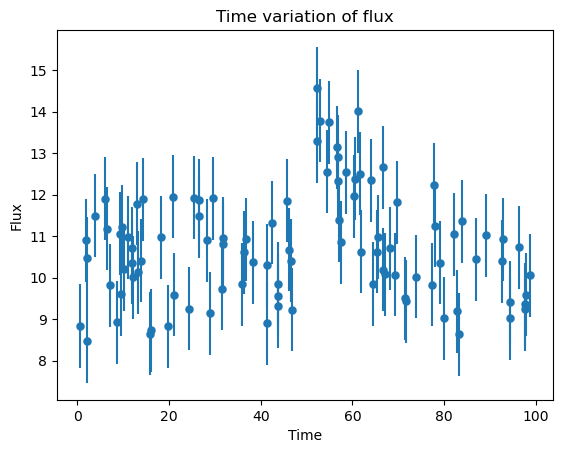

In [4]:
# Plot flux with flux uncertainties against time
plt.scatter(data1[:,0],data1[:,1],lw=0.1)
plt.errorbar(data1[:,0],data1[:,1],yerr=data1[:,2],fmt='none'); #fmt = none gets rid of plotting data, which we already did
plt.title('Time variation of flux');
plt.xlabel('Time');
plt.ylabel('Flux');

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

In [206]:
def burstModel(times,theta):
    # get burstModel values across times for specific params in theta

    # unpack theta
    b, a, t0, log_alpha = theta

    yvals = []
    for elem in times: # iterate through t values
        if elem < t0:
            y = b
            yvals.append(y)
        else:
            y = b + a*np.exp(-(np.exp(log_alpha))*(elem-t0))
            yvals.append(y)
    
    return yvals  

def logL(theta,data,model=burstModel):
    times = data[:,0]
    fluxes = data[:,1]
    fsigmas = data[:,2]

    modelFits = model(times,theta)

    return sum(scipy.stats.norm.logpdf(*args)
               for args in zip(fluxes, modelFits, fsigmas))
        # zip('ABCD','wxyz') = Aw,Bx,Cy,Dz


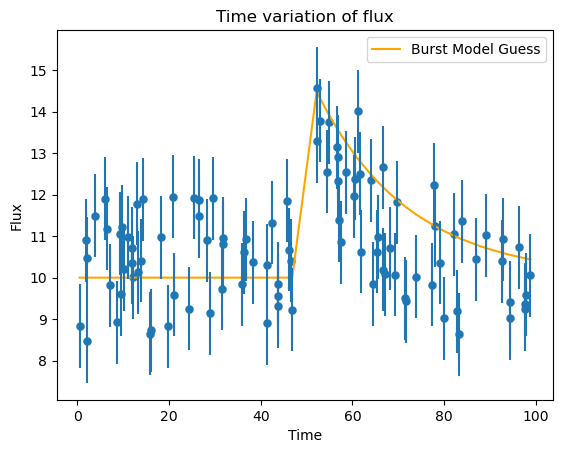

In [50]:
# check that burstModel roughly works, guess a decent theta

plt.plot(data1[:,0],burstModel(times=data1[:,0],theta=[10,5,50,-3]),color='orange',label='Burst Model Guess')
plt.scatter(data1[:,0],data1[:,1],lw=0.1)
plt.errorbar(data1[:,0],data1[:,1],yerr=data1[:,2],fmt='none'); #fmt = none gets rid of plotting data, which we already did
plt.title('Time variation of flux');
plt.xlabel('Time');
plt.ylabel('Flux');
plt.legend();

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

In [51]:
# create priors
b_prior = scipy.stats.uniform(0,50) # loc, width
A_prior = scipy.stats.uniform(0,50)
t0_prior = scipy.stats.uniform(0,100)
logAlpha_prior = scipy.stats.uniform(-5,10)

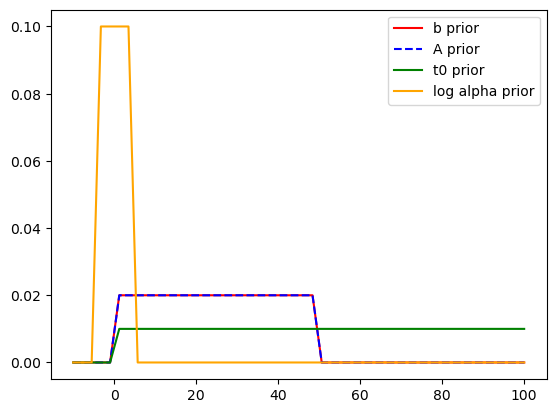

In [52]:
xGrid = np.linspace(-10,100)
plt.plot(xGrid,b_prior.pdf(xGrid),color='red',label='b prior')
plt.plot(xGrid,A_prior.pdf(xGrid),color='blue',linestyle='--',label='A prior')
plt.plot(xGrid,t0_prior.pdf(xGrid),color='green',label='t0 prior')
plt.plot(xGrid,logAlpha_prior.pdf(xGrid),color='orange',label='log alpha prior')

plt.legend()
plt.show()

In [53]:
import emcee

In [348]:
# get MCMC chain, try with emcee

ndim = 4  # number of parameters in the model
nwalkers = 8  # number of MCMC walkers -- got warning that walkers should be at least 2*ndim
burn1 = 0  # "burn-in" period to let chains stabilize
    # set initially to zero so we can decide on it later 
nsteps = 20000  # number of MCMC steps to take **for each walker**

# intialize theta
    # theta = b, A, t0, log_alpha
# good practice to random draw for starting values, but need to do it from within the priors
np.random.seed(123)

bDraws = b_prior.rvs(nwalkers)
Adraws = A_prior.rvs(nwalkers)
t0draws = t0_prior.rvs(nwalkers)
logAlphaDraws = logAlpha_prior.rvs(nwalkers)
# each of these are our columns

# place into an array with dimensions (nwalkers,ndim)
starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:,0] = bDraws
starting_guesses[:,1] = Adraws
starting_guesses[:,2] = t0draws
starting_guesses[:,3] = logAlphaDraws
print(starting_guesses)
print(starting_guesses.shape)

[[34.82345928 24.04659507 18.24917305  2.22443383]
 [14.30696675 19.60587591 17.54517561 -1.77041086]
 [11.34257268 17.15890081 53.15513738 -1.38211344]
 [27.56573845 36.45248537 53.18275871 -2.71736769]
 [35.97344849 21.92861223 63.44009586 -2.06285954]
 [21.15532301  2.98389483 84.94317941  1.30976124]
 [49.03820992 19.90221277 72.44553249 -4.0789506 ]
 [34.24148693 36.89977029 61.10235107 -0.66298827]]
(8, 4)


In [294]:
# create logPosterior function
    # since emcee wants to undo the log itself to get the posterior

priors = [b_prior,A_prior,t0_prior,logAlpha_prior]

def logPosterior(theta,data,priors):
    # theta = b, A, t0, logAlpha

    prior_logPDFs = []
    for i in range(len(priors)):
        logpdf = priors[i].logpdf(theta[i]) # get pdf for that prior evaluated at the theta val corresponding to that prior
        prior_logPDFs.append(logpdf)

    totalPrior = np.sum(prior_logPDFs)
    logPost = logL(theta,data,model=burstModel)+totalPrior
    
    return logPost

In [295]:
# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior, args=[data1, priors],a=2.0)
sampler.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in (burn1 = 0) points and reshape:
emcee_trace  = sampler.chain[:, burn1:, :].reshape(-1, ndim)

print("done")

done


Took 29 minutes for 8 walkers to explore 4 dimensions at 20,000 steps each. I chose this number of steps because my autocorrelations later are quite long.

In [350]:
print(sampler.chain.shape) #original chain structure
print(emcee_trace.shape) #burned and flattened chain
print(sampler.acceptance_fraction)

(8, 20000, 4)
(160000, 4)
[0.44535 0.20785 0.43815 0.43685 0.4371  0.4423  0.3475  0.4406 ]


Most acceptance rates are very good! They actually improved from when I was running nsteps = 10,000. Second walker is a little weird...

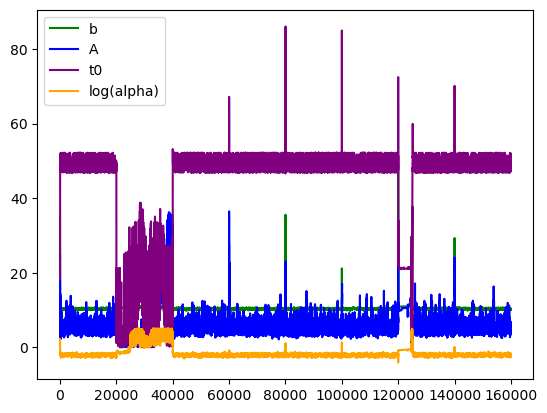

In [351]:
traceLength = len(emcee_trace)
xGrid = np.linspace(1,traceLength,traceLength)

plt.plot(xGrid,emcee_trace[:,0],color='green',label='b')
plt.plot(xGrid,emcee_trace[:,1],color='blue',label='A')
plt.plot(xGrid,emcee_trace[:,2],color='purple',label='t0')
plt.plot(xGrid,emcee_trace[:,3],color='orange',label='log(alpha)')
plt.legend()
plt.show()

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

The second walker seems to have gotten lost somehow. We have enough walkers that I'm comfortable just throwing that one out.

(1, 20000, 4)
(6, 20000, 4)


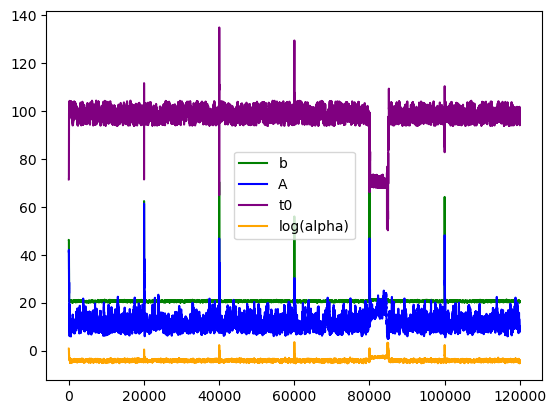

In [356]:
# shape is nwalkers, samples, ndim
# so index within nwalkers that I want 0th through 1st element spliced with 2nd element onwards

emcee_trace2  = sampler.chain[0:1, :, :] + sampler.chain[2:, :, :] # splice back together with +

print(sampler.chain[0:1, :, :].shape)
print(sampler.chain[2:, :, :].shape)

emcee_trace_shaped = emcee_trace2.reshape(-1, ndim)

traceLength = len(emcee_trace_shaped)
xGrid = np.linspace(1,traceLength,traceLength)
plt.plot(xGrid,emcee_trace_shaped[:,0],color='green',label='b')
plt.plot(xGrid,emcee_trace_shaped[:,1],color='blue',label='A')
plt.plot(xGrid,emcee_trace_shaped[:,2],color='purple',label='t0')
plt.plot(xGrid,emcee_trace_shaped[:,3],color='orange',label='log(alpha)')
plt.legend()
plt.show()

Looks much better, but there is also a strange burn-in for the second to last walker specifically which doesn't go away when the other walkers are appropriately burned in the next couple cells. In playing around with the burn-ins, the other walkers only need a couple hundred, while this second to last one would require around 5000. I save more points by dumping that whole walker as well (lose another 20k, so 40k total) than burning 5000 points off the start of every walker (lose another 35k, so 55k total). (I tried dumping only the bad points of that walker, but I couldn't splice them back together since they're different sizes unfortunately.)

(6, 20000, 4)
(120000, 4)


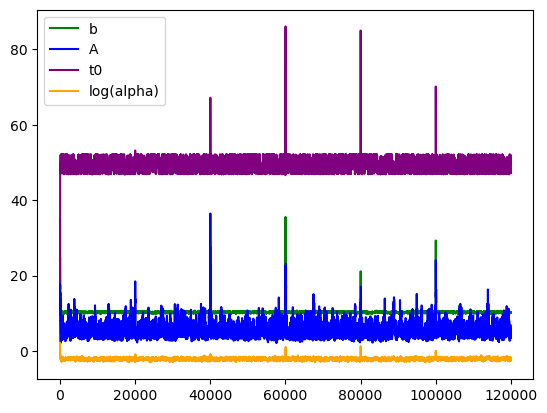

In [372]:
# Of the original 160,000 points:
    # walker 1: index 0:1 --> keep 0-20k
    # walker 2: index 1:2 --> dump 
    # walker 3: index 2:3 --> keep 40k-60k
    # walker 4: index 3:4 --> keep 60k-80k
    # walker 5: index 4:5 --> keep 80k-100k
    # walker 6: index 5:6 --> keep 100k-120k
    # walker 7: index 6:7 --> dump
    # walker 8: index 7: --> keep 140k-160k
    #
    # should have a total length of 120k at end!

emcee_trace3 = np.concatenate((sampler.chain[0:1, :, :],sampler.chain[2:6, :, :],sampler.chain[7:, :, :]),axis=0)

print(emcee_trace3.shape)
emcee_trace3_shaped = emcee_trace3.reshape(-1, ndim)
print(emcee_trace3_shaped.shape)

traceLength = len(emcee_trace3_shaped)
xGrid = np.linspace(1,traceLength,traceLength)
plt.plot(xGrid,emcee_trace3_shaped[:,0],color='green',label='b')
plt.plot(xGrid,emcee_trace3_shaped[:,1],color='blue',label='A')
plt.plot(xGrid,emcee_trace3_shaped[:,2],color='purple',label='t0')
plt.plot(xGrid,emcee_trace3_shaped[:,3],color='orange',label='log(alpha)')
plt.legend()
plt.show()

Great! Now we need to dump the burn-in for the beginning of each walker.

(8, 20000, 4)
(118800, 4)


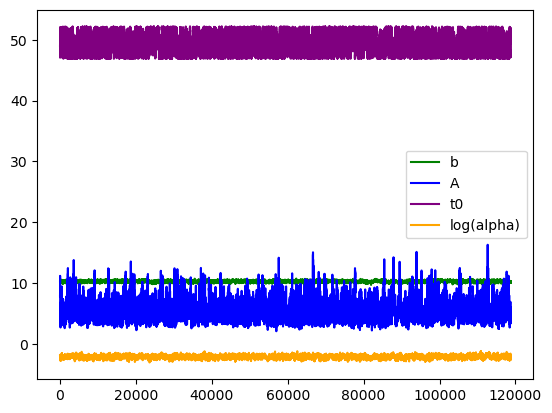

In [386]:
# dump the burn in, which seems to be around 200 points for the beginning of each walker
burn2 = 200

emcee_burned  = emcee_trace3[:,burn2:, :].reshape(-1, ndim)
    # using the unshaped one burns the first burn2 samples PER walker, then reshapes

print(sampler.chain.shape) #original chain structure
print(emcee_burned.shape) #burned and flattened chain


xGrid2 = np.linspace(1,len(emcee_burned),len(emcee_burned))
plt.plot(xGrid2,emcee_burned[:,0],color='green',label='b')
plt.plot(xGrid2,emcee_burned[:,1],color='blue',label='A')
plt.plot(xGrid2,emcee_burned[:,2],color='purple',label='t0')
plt.plot(xGrid2,emcee_burned[:,3],color='orange',label='log(alpha)')
plt.legend()
plt.show()


In [387]:
# thin the chain by selecting points only every auto correlation length
import acor

# the first element of the tuple is the length between independent samples (auto-correlation)

b_acor = acor.acor(emcee_burned[:,0])[0]
A_acor = acor.acor(emcee_burned[:,1])[0] 
t0_acor = acor.acor(emcee_burned[:,2])[0]
logAlpha_acor = acor.acor(emcee_burned[:,3])[0]

print(b_acor,A_acor,t0_acor,logAlpha_acor)

107.13839473160857 127.95856437252343 142.3509926606244 63.87639753648685


These are quite large. I have tried many ways of getting around this, but the acor lengths only seem to get longer as I add more samples... and the only reason I was adding more samples is because I need a lot initially since they get thinned so heavily. Sigh! I think the moral of the story is to choose the most efficient package, like PTMCMC, even if you think it's too complicated for your "simple" problem. PTMCMC applies parallel tempering, which emcee does not, and I know that helps with acor lengths.

b chain length: 1111
A chain length: 936
t0 chain length: 837
log(alpha) chain length: 1886


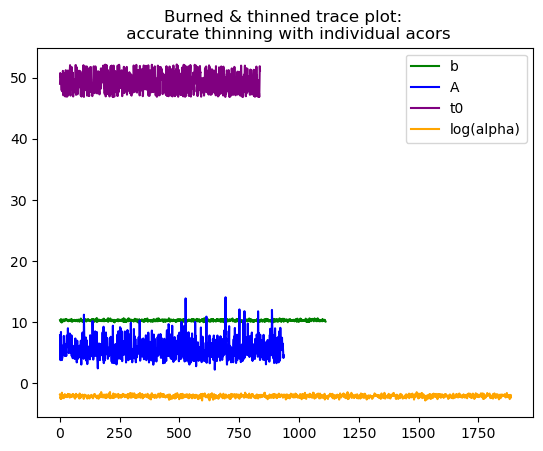

In [404]:
# Plot only every independent point

# thin each chain according to its own auto correlation length
    # this will chain to be different total lengths just for plotting
acors = [b_acor,A_acor,t0_acor,logAlpha_acor]
colors = ['green','blue','purple','orange']
labels=['b','A','t0','log(alpha)']


for i in range(4):
    # thin according to the ith acor length
    # this will create an entire array where each parameter's trace is thinned by that amount
    emcee_trace_new = emcee_burned[::int(acors[i])] # take nearest integer of acor for each parameter

    # plot it 
    xGrid3 = np.linspace(1,len(emcee_trace_new[:,i]),len(emcee_trace_new[:,i]))
    plt.plot(xGrid3,emcee_trace_new[:,i],color=colors[i],label=labels[i])

    # print length of chain
    print(labels[i],'chain length:',len(emcee_trace_new[:,i]))

plt.title('Burned & thinned trace plot: \n accurate thinning with individual acors');
plt.legend();

Since the chains have different auto-correlation lengths, thinning by their individual acor lengths causes them to be different sizes. There's a chance that some fancy array stuff would work by filling the empty elements with 0s, NaNs, or keeping empty somehow, but a more conservative and faster approach is to choose the longest acor length and thin by that (sadly, this will make our total number of samples the smallest out of all the chain lengths).

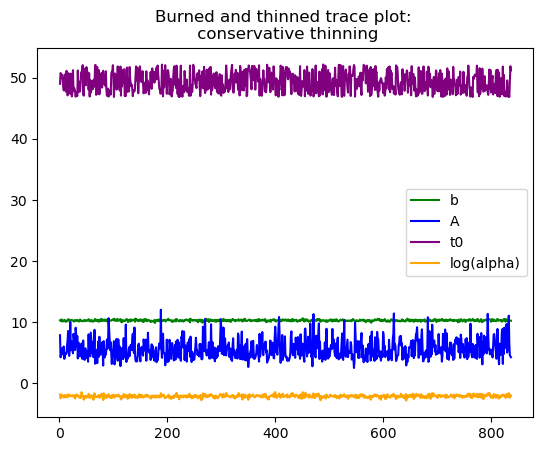

In [399]:
# thin every param by longest acor
emcee_final = emcee_burned[::int(t0_acor)] # t0 has the longest acor of 142

xGrid4 = np.linspace(1,len(emcee_final),len(emcee_final))
plt.plot(xGrid4,emcee_final[:,0],color='green',label='b')
plt.plot(xGrid4,emcee_final[:,1],color='blue',label='A')
plt.plot(xGrid4,emcee_final[:,2],color='purple',label='t0')
plt.plot(xGrid4,emcee_final[:,3],color='orange',label='log(alpha)')
plt.title('Burned and thinned trace plot: \n conservative thinning')
plt.legend()
plt.show()

Ideally, we'd have more points than this, however as I stated above, I don't believe adding more samples would increase the number of points we have left behind after thinning since more samples increased by autocorrelation lengths. There is a deeper underlying problem that parallel tempering seems to fix within PTMCMC, which I did not use here. 

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.


In [105]:
import corner

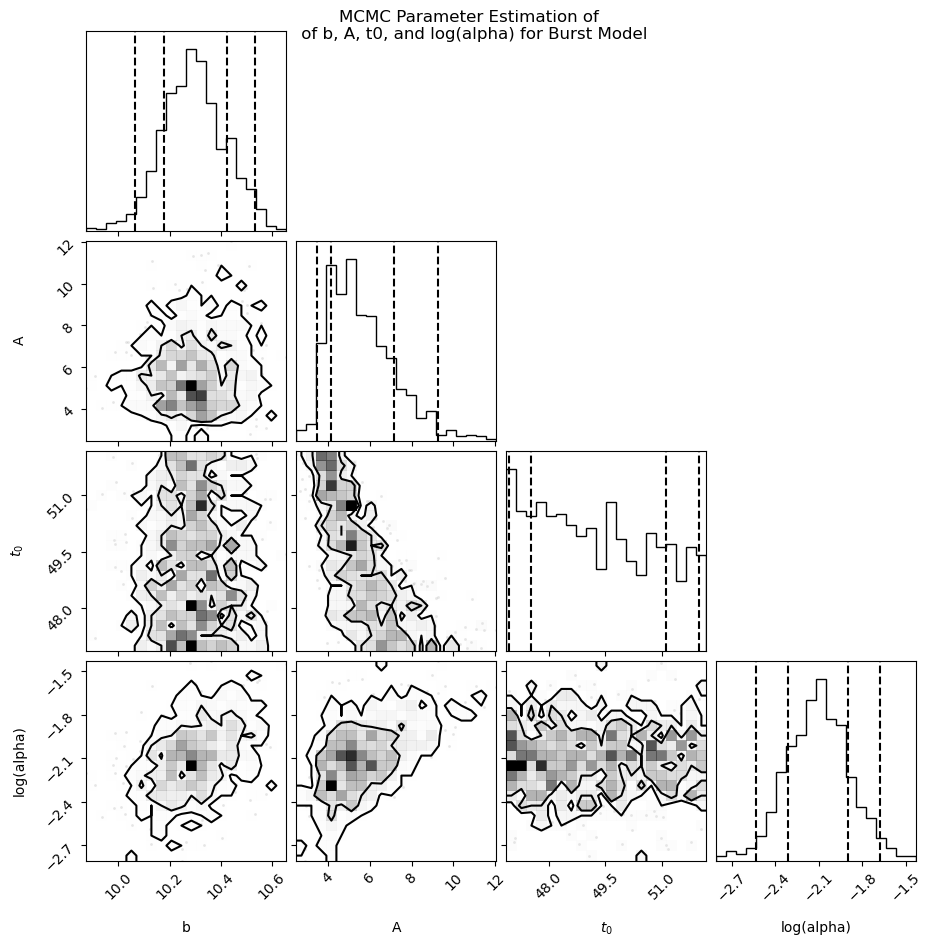

In [400]:
fig = corner.corner(emcee_final, # take the burned and thinned chain
                    labels=['b','A','$t_0$','log(alpha)'], 
                    quantiles = [0.025,0.16,0.84,0.975], # 68% and 95% quantiles for the outside plots
                    levels=[0.68,0.95])
plt.suptitle('MCMC Parameter Estimation of \n of b, A, t0, and log(alpha) for Burst Model');

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

In [405]:
# get 100 random indices
randomIdxs = np.random.choice(emcee_final.shape[0],100)# .shape[0] tells it to only grab rows 
emcee_trace_100 = emcee_final[randomIdxs]
print(len(emcee_trace_100))
print(emcee_trace_100)


100
[[10.26925802  5.0835757  49.91160366 -1.95387518]
 [10.54186331  5.9427713  47.38757125 -2.13002252]
 [10.32830743  4.92035031 49.53667885 -2.37998808]
 [10.17943649  4.80664589 47.79424655 -2.3226493 ]
 [10.21506425  4.86508247 49.88542809 -2.22557047]
 [10.34267848  6.08202834 47.82172185 -2.04248872]
 [10.429356    4.33054854 51.99601041 -1.69483698]
 [10.24867013  5.69312644 50.27096869 -1.9672175 ]
 [10.16140151  6.86544786 48.11806488 -2.03090667]
 [10.29797462  4.87285604 49.15372486 -2.12721736]
 [10.18434243  4.61692919 48.28003684 -2.32955803]
 [10.38035965  7.36419386 47.65265781 -1.9407091 ]
 [10.33274513  4.87024074 51.25060501 -1.94023059]
 [10.44346135  8.86462806 46.98446051 -1.8356717 ]
 [10.15967527  7.6273655  47.15644616 -2.13901648]
 [10.19796723  5.39784478 48.24043447 -2.41942073]
 [10.25366654  6.73139792 46.89929641 -2.13012119]
 [10.27863746  3.97915793 50.00537037 -2.31232552]
 [10.39887844  4.97712957 47.99137015 -2.23382782]
 [10.19363566  3.82426323 5

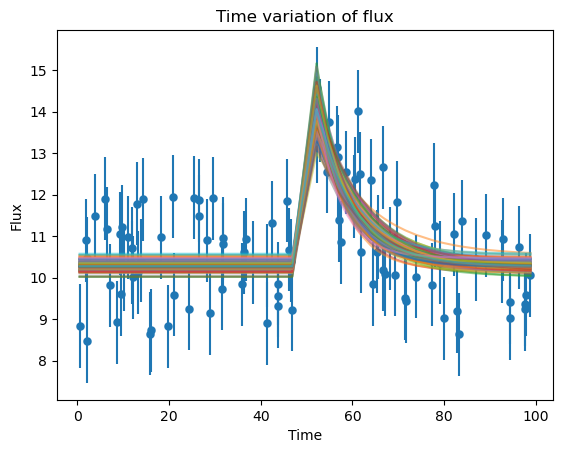

In [406]:
# plot data
plt.scatter(data1[:,0],data1[:,1],lw=0.1)
plt.errorbar(data1[:,0],data1[:,1],yerr=data1[:,2],fmt='none'); #fmt = none gets rid of plotting data, which we already did
plt.title('Time variation of flux');
plt.xlabel('Time');
plt.ylabel('Flux');

# plot 100 variations on burst model
for i in range(len(emcee_trace_100)):
    model = burstModel(times=data1[:,0],theta=emcee_trace_100[i])
    plt.plot(data1[:,0],model,alpha=0.5)

This looks pretty good! 100 randomly chosen sets of theta from the burned and thinned chain are offering pretty good models for the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*


In [430]:
def gaussModel(times,theta):
    # get burstModel values across times for specific params in theta

    # unpack theta
    b, a, t0, log_sigmaw = theta

    yvals = []

    for elem in times: # iterate through t values
        y = b + a*np.exp(-((elem-t0)**2)/(2*np.exp(log_sigmaw)**2))
        yvals.append(y)

    return yvals


In [408]:
import ultranest

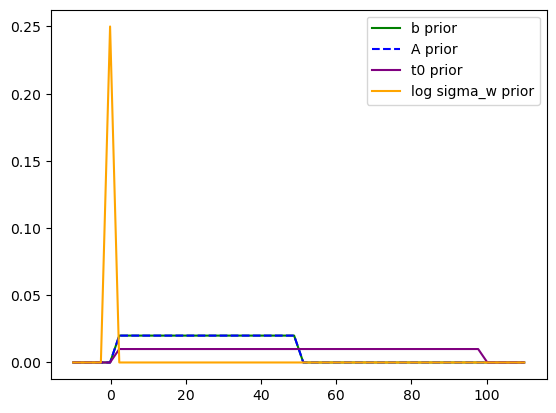

In [413]:
# remind myself about the priors, but now with log_sigmaw instead of log_alpha
xGrid = np.linspace(-10,110)
plt.plot(xGrid,b_prior.pdf(xGrid),color='green',label='b prior')
plt.plot(xGrid,A_prior.pdf(xGrid),color='blue',linestyle='--',label='A prior')
plt.plot(xGrid,t0_prior.pdf(xGrid),color='purple',label='t0 prior')
plt.plot(xGrid,scipy.stats.uniform(-2,4).pdf(xGrid),color='orange',label='log sigma_w prior')

plt.legend()
plt.show()

In [433]:
def my_prior_transform(cube):
    params = cube.copy()

    # transform b parameter: uniform prior from 0 to 50
    lo = 0
    hi = 50
    params[0] = cube[0] * (hi - lo) + lo

    # transform A parameter: uniform prior from 0 to 50
    lo = 0
    hi = 50
    params[1] = cube[1] * (hi - lo) + lo

    # transform t0 parameter: uniform prior from 0 to 100
    lo = 0
    hi = 100
    params[2] = cube[2] * (hi - lo) + lo

    # transform log_sigmaw parameter: uniform prior from -2 to 2
    lo = -2
    hi = 2
    params[3] = cube[3] * (hi - lo) + lo

    # More complex prior, you can use the ppf functions
    # from scipy.stats, such as scipy.stats.norm(mean, std).ppf

    return params


# similar to logL from before: 
    # this one slightly more hard-coded as to make it 
    # so that the loglikelihood function inputted into ultranest.ReactiveNestedSampler
    # doesn't need any arguments except for params (i.e. theta)

def logL_gaussModel(theta):
    times = data1[:,0]
    fluxes = data1[:,1]
    fsigmas = data1[:,2]

    modelFits = gaussModel(times,theta)

    return sum(scipy.stats.norm.logpdf(*args)
               for args in zip(fluxes, modelFits, fsigmas))
        # zip('ABCD','wxyz') = Aw,Bx,Cy,Dz

In [434]:
param_names = ['b','A','t0','log_sigmaw']

sampler = ultranest.ReactiveNestedSampler(param_names, logL_gaussModel, 
                                          my_prior_transform)

DEBUG:ultranest:ReactiveNestedSampler: dims=4+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


In [435]:
result = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 400.0), (inf, 400.0)]


DEBUG:ultranest:iteration=0, ncalls=401, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-129085.35, Lmax=-181.19


DEBUG:ultranest:iteration=10, ncalls=411, regioncalls=440, ndraw=40, logz=-79228.31, remainder_fraction=100.0000%, Lmin=-77631.78, Lmax=-181.19


DEBUG:ultranest:iteration=30, ncalls=434, regioncalls=1360, ndraw=40, logz=-68401.35, remainder_fraction=100.0000%, Lmin=-68382.35, Lmax=-181.19


DEBUG:ultranest:iteration=40, ncalls=445, regioncalls=1800, ndraw=40, logz=-64995.59, remainder_fraction=100.0000%, Lmin=-64667.36, Lmax=-181.19


DEBUG:ultranest:iteration=49, ncalls=454, regioncalls=2160, ndraw=40, logz=-61059.68, remainder_fraction=100.0000%, Lmin=-60784.68, Lmax=-181.19


DEBUG:ultranest:iteration=58, ncalls=465, regioncalls=2600, ndraw=40, logz=-56979.10, remainder_fraction=100.0000%, Lmin=-56787.12, Lmax=-181.19


DEBUG:ultranest:iteration=62, ncalls=469, regioncalls=2760, ndraw=40, logz=-56401.59, remainder_fraction=100.0000%, Lmin=-56183.03, Lmax=-181.19


DEBUG:ultranest:iteration=65, ncalls=472, regioncalls=2880, ndraw=40, logz=-56055.52, remainder_fraction=100.0000%, Lmin=-55182.08, Lmax=-181.19


DEBUG:ultranest:iteration=71, ncalls=478, regioncalls=3120, ndraw=40, logz=-53656.80, remainder_fraction=100.0000%, Lmin=-53489.38, Lmax=-181.19


DEBUG:ultranest:iteration=74, ncalls=481, regioncalls=3240, ndraw=40, logz=-52826.20, remainder_fraction=100.0000%, Lmin=-52802.52, Lmax=-181.19


DEBUG:ultranest:iteration=80, ncalls=488, regioncalls=3520, ndraw=40, logz=-52136.15, remainder_fraction=100.0000%, Lmin=-51681.42, Lmax=-181.19


DEBUG:ultranest:iteration=83, ncalls=492, regioncalls=3680, ndraw=40, logz=-50808.31, remainder_fraction=100.0000%, Lmin=-50692.64, Lmax=-181.19


DEBUG:ultranest:iteration=87, ncalls=498, regioncalls=3920, ndraw=40, logz=-50077.19, remainder_fraction=100.0000%, Lmin=-49517.11, Lmax=-181.19


DEBUG:ultranest:iteration=90, ncalls=501, regioncalls=4040, ndraw=40, logz=-49136.12, remainder_fraction=100.0000%, Lmin=-48866.95, Lmax=-181.19


DEBUG:ultranest:iteration=92, ncalls=506, regioncalls=4240, ndraw=40, logz=-48672.22, remainder_fraction=100.0000%, Lmin=-48604.73, Lmax=-181.19


DEBUG:ultranest:iteration=93, ncalls=508, regioncalls=4320, ndraw=40, logz=-48610.95, remainder_fraction=100.0000%, Lmin=-48517.20, Lmax=-181.19


DEBUG:ultranest:iteration=98, ncalls=515, regioncalls=4600, ndraw=40, logz=-45197.11, remainder_fraction=100.0000%, Lmin=-44661.24, Lmax=-181.19


DEBUG:ultranest:iteration=105, ncalls=523, regioncalls=4920, ndraw=40, logz=-42569.33, remainder_fraction=100.0000%, Lmin=-42123.13, Lmax=-181.19


DEBUG:ultranest:iteration=120, ncalls=543, regioncalls=5720, ndraw=40, logz=-37848.45, remainder_fraction=100.0000%, Lmin=-37220.73, Lmax=-181.19


DEBUG:ultranest:iteration=136, ncalls=568, regioncalls=6720, ndraw=40, logz=-33637.54, remainder_fraction=100.0000%, Lmin=-33564.03, Lmax=-181.19


DEBUG:ultranest:iteration=140, ncalls=573, regioncalls=6920, ndraw=40, logz=-32795.88, remainder_fraction=100.0000%, Lmin=-32702.40, Lmax=-181.19


DEBUG:ultranest:iteration=143, ncalls=576, regioncalls=7040, ndraw=40, logz=-32270.18, remainder_fraction=100.0000%, Lmin=-31866.65, Lmax=-181.19


DEBUG:ultranest:iteration=147, ncalls=583, regioncalls=7320, ndraw=40, logz=-30749.41, remainder_fraction=100.0000%, Lmin=-30731.64, Lmax=-181.19


DEBUG:ultranest:iteration=155, ncalls=594, regioncalls=7760, ndraw=40, logz=-30031.57, remainder_fraction=100.0000%, Lmin=-29894.22, Lmax=-181.19


DEBUG:ultranest:iteration=159, ncalls=600, regioncalls=8000, ndraw=40, logz=-29504.52, remainder_fraction=100.0000%, Lmin=-29462.93, Lmax=-181.19


DEBUG:ultranest:iteration=160, ncalls=601, regioncalls=8040, ndraw=40, logz=-29469.32, remainder_fraction=100.0000%, Lmin=-29330.44, Lmax=-181.19


DEBUG:ultranest:iteration=165, ncalls=608, regioncalls=8320, ndraw=40, logz=-28930.48, remainder_fraction=100.0000%, Lmin=-28695.11, Lmax=-181.19


DEBUG:ultranest:iteration=169, ncalls=612, regioncalls=8480, ndraw=40, logz=-28417.27, remainder_fraction=100.0000%, Lmin=-28226.72, Lmax=-181.19


DEBUG:ultranest:iteration=179, ncalls=627, regioncalls=9080, ndraw=40, logz=-26621.84, remainder_fraction=100.0000%, Lmin=-26601.89, Lmax=-181.19


DEBUG:ultranest:iteration=180, ncalls=628, regioncalls=9120, ndraw=40, logz=-26608.33, remainder_fraction=100.0000%, Lmin=-25482.23, Lmax=-181.19


DEBUG:ultranest:iteration=185, ncalls=635, regioncalls=9400, ndraw=40, logz=-24858.03, remainder_fraction=100.0000%, Lmin=-24633.22, Lmax=-181.19


DEBUG:ultranest:iteration=198, ncalls=656, regioncalls=10240, ndraw=40, logz=-23252.93, remainder_fraction=100.0000%, Lmin=-23185.52, Lmax=-181.19


DEBUG:ultranest:iteration=200, ncalls=659, regioncalls=10360, ndraw=40, logz=-23010.07, remainder_fraction=100.0000%, Lmin=-22557.16, Lmax=-181.19


DEBUG:ultranest:iteration=204, ncalls=663, regioncalls=10520, ndraw=40, logz=-21840.98, remainder_fraction=100.0000%, Lmin=-21795.52, Lmax=-181.19


DEBUG:ultranest:iteration=206, ncalls=667, regioncalls=10680, ndraw=40, logz=-21722.31, remainder_fraction=100.0000%, Lmin=-21645.61, Lmax=-181.19


DEBUG:ultranest:iteration=210, ncalls=674, regioncalls=10960, ndraw=40, logz=-20556.90, remainder_fraction=100.0000%, Lmin=-20316.75, Lmax=-181.19


DEBUG:ultranest:iteration=215, ncalls=680, regioncalls=11200, ndraw=40, logz=-20032.17, remainder_fraction=100.0000%, Lmin=-19684.99, Lmax=-181.19


DEBUG:ultranest:iteration=221, ncalls=689, regioncalls=11560, ndraw=40, logz=-18509.85, remainder_fraction=100.0000%, Lmin=-18465.51, Lmax=-181.19


DEBUG:ultranest:iteration=236, ncalls=708, regioncalls=12320, ndraw=40, logz=-16664.76, remainder_fraction=100.0000%, Lmin=-16504.58, Lmax=-181.19


DEBUG:ultranest:iteration=240, ncalls=714, regioncalls=12560, ndraw=40, logz=-16146.90, remainder_fraction=100.0000%, Lmin=-16078.36, Lmax=-181.19


DEBUG:ultranest:iteration=248, ncalls=726, regioncalls=13040, ndraw=40, logz=-15845.78, remainder_fraction=100.0000%, Lmin=-15770.16, Lmax=-181.19


DEBUG:ultranest:iteration=257, ncalls=744, regioncalls=13760, ndraw=40, logz=-14869.32, remainder_fraction=100.0000%, Lmin=-14842.23, Lmax=-181.19


DEBUG:ultranest:iteration=269, ncalls=762, regioncalls=14480, ndraw=40, logz=-14111.03, remainder_fraction=100.0000%, Lmin=-14080.36, Lmax=-181.19


DEBUG:ultranest:iteration=270, ncalls=764, regioncalls=14560, ndraw=40, logz=-14087.03, remainder_fraction=100.0000%, Lmin=-14026.29, Lmax=-181.19


DEBUG:ultranest:iteration=280, ncalls=776, regioncalls=15040, ndraw=40, logz=-13474.68, remainder_fraction=100.0000%, Lmin=-13408.26, Lmax=-181.19


DEBUG:ultranest:iteration=289, ncalls=788, regioncalls=15520, ndraw=40, logz=-12911.07, remainder_fraction=100.0000%, Lmin=-12869.99, Lmax=-181.19


DEBUG:ultranest:iteration=293, ncalls=794, regioncalls=15760, ndraw=40, logz=-12449.74, remainder_fraction=100.0000%, Lmin=-12401.73, Lmax=-181.19


DEBUG:ultranest:iteration=300, ncalls=802, regioncalls=16080, ndraw=40, logz=-11750.08, remainder_fraction=100.0000%, Lmin=-11619.66, Lmax=-181.19


DEBUG:ultranest:iteration=315, ncalls=823, regioncalls=16920, ndraw=40, logz=-10247.78, remainder_fraction=100.0000%, Lmin=-10155.28, Lmax=-181.19


DEBUG:ultranest:iteration=320, ncalls=829, regioncalls=17160, ndraw=40, logz=-9634.41, remainder_fraction=100.0000%, Lmin=-9407.79, Lmax=-181.19


DEBUG:ultranest:iteration=337, ncalls=853, regioncalls=18120, ndraw=40, logz=-8259.31, remainder_fraction=100.0000%, Lmin=-8144.92, Lmax=-181.19


DEBUG:ultranest:iteration=355, ncalls=879, regioncalls=19160, ndraw=40, logz=-7560.74, remainder_fraction=100.0000%, Lmin=-7445.71, Lmax=-181.19


DEBUG:ultranest:iteration=360, ncalls=888, regioncalls=19520, ndraw=40, logz=-7159.43, remainder_fraction=100.0000%, Lmin=-7108.98, Lmax=-181.19


DEBUG:ultranest:iteration=377, ncalls=913, regioncalls=20520, ndraw=40, logz=-6346.63, remainder_fraction=100.0000%, Lmin=-6282.93, Lmax=-179.98


DEBUG:ultranest:iteration=395, ncalls=940, regioncalls=21600, ndraw=40, logz=-5772.76, remainder_fraction=100.0000%, Lmin=-5725.95, Lmax=-179.98


DEBUG:ultranest:iteration=400, ncalls=946, regioncalls=21840, ndraw=40, logz=-5645.79, remainder_fraction=100.0000%, Lmin=-5626.86, Lmax=-179.98


DEBUG:ultranest:iteration=406, ncalls=953, regioncalls=22120, ndraw=40, logz=-5568.70, remainder_fraction=100.0000%, Lmin=-5556.10, Lmax=-179.98


DEBUG:ultranest:iteration=413, ncalls=961, regioncalls=22440, ndraw=40, logz=-5472.38, remainder_fraction=100.0000%, Lmin=-5459.58, Lmax=-179.98


DEBUG:ultranest:iteration=428, ncalls=985, regioncalls=23400, ndraw=40, logz=-5234.90, remainder_fraction=100.0000%, Lmin=-5220.30, Lmax=-179.98


DEBUG:ultranest:iteration=440, ncalls=1005, regioncalls=24200, ndraw=40, logz=-5087.37, remainder_fraction=100.0000%, Lmin=-5040.84, Lmax=-179.98


DEBUG:ultranest:iteration=444, ncalls=1009, regioncalls=24360, ndraw=40, logz=-5022.23, remainder_fraction=100.0000%, Lmin=-5013.47, Lmax=-179.98


DEBUG:ultranest:iteration=447, ncalls=1012, regioncalls=24480, ndraw=40, logz=-5002.91, remainder_fraction=100.0000%, Lmin=-4977.73, Lmax=-179.98


DEBUG:ultranest:iteration=448, ncalls=1018, regioncalls=24720, ndraw=40, logz=-4984.84, remainder_fraction=100.0000%, Lmin=-4959.44, Lmax=-179.98


DEBUG:ultranest:iteration=450, ncalls=1022, regioncalls=24880, ndraw=40, logz=-4961.10, remainder_fraction=100.0000%, Lmin=-4947.94, Lmax=-179.98


DEBUG:ultranest:iteration=455, ncalls=1028, regioncalls=25120, ndraw=40, logz=-4878.86, remainder_fraction=100.0000%, Lmin=-4871.62, Lmax=-179.98


DEBUG:ultranest:iteration=465, ncalls=1046, regioncalls=25840, ndraw=40, logz=-4759.52, remainder_fraction=100.0000%, Lmin=-4738.34, Lmax=-179.98


DEBUG:ultranest:iteration=468, ncalls=1055, regioncalls=26200, ndraw=40, logz=-4728.59, remainder_fraction=100.0000%, Lmin=-4712.11, Lmax=-179.98


DEBUG:ultranest:iteration=472, ncalls=1060, regioncalls=26400, ndraw=40, logz=-4688.89, remainder_fraction=100.0000%, Lmin=-4663.78, Lmax=-179.98


DEBUG:ultranest:iteration=477, ncalls=1070, regioncalls=26800, ndraw=40, logz=-4636.45, remainder_fraction=100.0000%, Lmin=-4623.63, Lmax=-179.98


DEBUG:ultranest:iteration=480, ncalls=1075, regioncalls=27000, ndraw=40, logz=-4593.70, remainder_fraction=100.0000%, Lmin=-4582.19, Lmax=-179.98


DEBUG:ultranest:iteration=496, ncalls=1102, regioncalls=28080, ndraw=40, logz=-4397.92, remainder_fraction=100.0000%, Lmin=-4363.55, Lmax=-179.98


DEBUG:ultranest:iteration=514, ncalls=1126, regioncalls=29040, ndraw=40, logz=-4100.98, remainder_fraction=100.0000%, Lmin=-4087.75, Lmax=-179.98


DEBUG:ultranest:iteration=518, ncalls=1133, regioncalls=29320, ndraw=40, logz=-4074.64, remainder_fraction=100.0000%, Lmin=-4051.64, Lmax=-179.98


DEBUG:ultranest:iteration=520, ncalls=1136, regioncalls=29440, ndraw=40, logz=-4056.68, remainder_fraction=100.0000%, Lmin=-4039.11, Lmax=-179.98


DEBUG:ultranest:iteration=522, ncalls=1141, regioncalls=29640, ndraw=40, logz=-3984.50, remainder_fraction=100.0000%, Lmin=-3965.41, Lmax=-179.98


DEBUG:ultranest:iteration=526, ncalls=1147, regioncalls=29880, ndraw=40, logz=-3920.16, remainder_fraction=100.0000%, Lmin=-3896.98, Lmax=-179.98


DEBUG:ultranest:iteration=530, ncalls=1152, regioncalls=30080, ndraw=40, logz=-3847.81, remainder_fraction=100.0000%, Lmin=-3829.90, Lmax=-179.98


DEBUG:ultranest:iteration=534, ncalls=1161, regioncalls=30440, ndraw=40, logz=-3818.03, remainder_fraction=100.0000%, Lmin=-3807.30, Lmax=-179.98


DEBUG:ultranest:iteration=538, ncalls=1171, regioncalls=30840, ndraw=40, logz=-3784.84, remainder_fraction=100.0000%, Lmin=-3771.53, Lmax=-179.98


DEBUG:ultranest:iteration=540, ncalls=1176, regioncalls=31040, ndraw=40, logz=-3758.97, remainder_fraction=100.0000%, Lmin=-3729.05, Lmax=-179.98


DEBUG:ultranest:iteration=544, ncalls=1185, regioncalls=31400, ndraw=40, logz=-3712.01, remainder_fraction=100.0000%, Lmin=-3700.79, Lmax=-179.98


DEBUG:ultranest:iteration=547, ncalls=1189, regioncalls=31560, ndraw=40, logz=-3704.12, remainder_fraction=100.0000%, Lmin=-3665.26, Lmax=-179.98


DEBUG:ultranest:iteration=550, ncalls=1194, regioncalls=31760, ndraw=40, logz=-3650.30, remainder_fraction=100.0000%, Lmin=-3626.94, Lmax=-179.98


DEBUG:ultranest:iteration=554, ncalls=1200, regioncalls=32000, ndraw=40, logz=-3604.55, remainder_fraction=100.0000%, Lmin=-3593.04, Lmax=-179.98


DEBUG:ultranest:iteration=557, ncalls=1206, regioncalls=32240, ndraw=40, logz=-3572.27, remainder_fraction=100.0000%, Lmin=-3543.63, Lmax=-179.98


DEBUG:ultranest:iteration=559, ncalls=1211, regioncalls=32440, ndraw=40, logz=-3539.74, remainder_fraction=100.0000%, Lmin=-3531.96, Lmax=-179.98


DEBUG:ultranest:iteration=560, ncalls=1212, regioncalls=32480, ndraw=40, logz=-3538.83, remainder_fraction=100.0000%, Lmin=-3512.39, Lmax=-179.98


DEBUG:ultranest:iteration=563, ncalls=1218, regioncalls=32720, ndraw=40, logz=-3468.56, remainder_fraction=100.0000%, Lmin=-3457.99, Lmax=-179.98


DEBUG:ultranest:iteration=566, ncalls=1222, regioncalls=32880, ndraw=40, logz=-3370.93, remainder_fraction=100.0000%, Lmin=-3333.70, Lmax=-179.98


DEBUG:ultranest:iteration=571, ncalls=1228, regioncalls=33120, ndraw=40, logz=-3268.38, remainder_fraction=100.0000%, Lmin=-3254.54, Lmax=-179.98


DEBUG:ultranest:iteration=575, ncalls=1243, regioncalls=33720, ndraw=40, logz=-3249.40, remainder_fraction=100.0000%, Lmin=-3240.23, Lmax=-179.98


DEBUG:ultranest:iteration=588, ncalls=1268, regioncalls=34720, ndraw=40, logz=-3059.30, remainder_fraction=100.0000%, Lmin=-3042.10, Lmax=-179.98


DEBUG:ultranest:iteration=591, ncalls=1280, regioncalls=35200, ndraw=40, logz=-3014.04, remainder_fraction=100.0000%, Lmin=-3005.89, Lmax=-179.98


DEBUG:ultranest:iteration=600, ncalls=1296, regioncalls=35840, ndraw=40, logz=-2901.45, remainder_fraction=100.0000%, Lmin=-2891.12, Lmax=-179.98


DEBUG:ultranest:iteration=604, ncalls=1303, regioncalls=36120, ndraw=40, logz=-2871.96, remainder_fraction=100.0000%, Lmin=-2857.80, Lmax=-179.98


DEBUG:ultranest:iteration=611, ncalls=1318, regioncalls=36720, ndraw=40, logz=-2757.87, remainder_fraction=100.0000%, Lmin=-2714.09, Lmax=-179.98


DEBUG:ultranest:iteration=625, ncalls=1343, regioncalls=37720, ndraw=40, logz=-2617.41, remainder_fraction=100.0000%, Lmin=-2599.14, Lmax=-179.98


DEBUG:ultranest:iteration=630, ncalls=1357, regioncalls=38280, ndraw=40, logz=-2601.33, remainder_fraction=100.0000%, Lmin=-2577.87, Lmax=-179.98


DEBUG:ultranest:iteration=637, ncalls=1372, regioncalls=38880, ndraw=40, logz=-2547.90, remainder_fraction=100.0000%, Lmin=-2537.45, Lmax=-179.98


DEBUG:ultranest:iteration=640, ncalls=1378, regioncalls=39120, ndraw=40, logz=-2532.26, remainder_fraction=100.0000%, Lmin=-2519.93, Lmax=-179.98


DEBUG:ultranest:iteration=646, ncalls=1386, regioncalls=39440, ndraw=40, logz=-2505.68, remainder_fraction=100.0000%, Lmin=-2493.89, Lmax=-179.98


DEBUG:ultranest:iteration=659, ncalls=1405, regioncalls=40200, ndraw=40, logz=-2395.72, remainder_fraction=100.0000%, Lmin=-2386.30, Lmax=-179.98


DEBUG:ultranest:iteration=675, ncalls=1429, regioncalls=41160, ndraw=40, logz=-2294.34, remainder_fraction=100.0000%, Lmin=-2283.11, Lmax=-179.98


DEBUG:ultranest:iteration=680, ncalls=1440, regioncalls=41600, ndraw=40, logz=-2263.30, remainder_fraction=100.0000%, Lmin=-2240.42, Lmax=-179.98


DEBUG:ultranest:iteration=691, ncalls=1457, regioncalls=42280, ndraw=40, logz=-2197.32, remainder_fraction=100.0000%, Lmin=-2189.03, Lmax=-179.98


DEBUG:ultranest:iteration=701, ncalls=1482, regioncalls=43280, ndraw=40, logz=-2136.79, remainder_fraction=100.0000%, Lmin=-2126.69, Lmax=-179.98


DEBUG:ultranest:iteration=716, ncalls=1508, regioncalls=44320, ndraw=40, logz=-2004.43, remainder_fraction=100.0000%, Lmin=-1988.69, Lmax=-179.98


DEBUG:ultranest:iteration=720, ncalls=1521, regioncalls=44840, ndraw=40, logz=-1976.36, remainder_fraction=100.0000%, Lmin=-1960.87, Lmax=-179.98


DEBUG:ultranest:iteration=735, ncalls=1546, regioncalls=45840, ndraw=40, logz=-1903.37, remainder_fraction=100.0000%, Lmin=-1892.41, Lmax=-179.98


DEBUG:ultranest:iteration=750, ncalls=1574, regioncalls=46960, ndraw=40, logz=-1821.14, remainder_fraction=100.0000%, Lmin=-1813.45, Lmax=-179.98


DEBUG:ultranest:iteration=760, ncalls=1593, regioncalls=47720, ndraw=40, logz=-1772.05, remainder_fraction=100.0000%, Lmin=-1761.43, Lmax=-179.98


DEBUG:ultranest:iteration=773, ncalls=1618, regioncalls=48720, ndraw=40, logz=-1729.69, remainder_fraction=100.0000%, Lmin=-1721.60, Lmax=-179.98


DEBUG:ultranest:iteration=784, ncalls=1641, regioncalls=49640, ndraw=40, logz=-1688.62, remainder_fraction=100.0000%, Lmin=-1679.02, Lmax=-179.98


DEBUG:ultranest:iteration=797, ncalls=1669, regioncalls=50760, ndraw=40, logz=-1611.78, remainder_fraction=100.0000%, Lmin=-1601.38, Lmax=-179.98


DEBUG:ultranest:iteration=800, ncalls=1675, regioncalls=51000, ndraw=40, logz=-1582.43, remainder_fraction=100.0000%, Lmin=-1565.95, Lmax=-179.98


DEBUG:ultranest:iteration=804, ncalls=1682, regioncalls=51280, ndraw=40, logz=-1564.64, remainder_fraction=100.0000%, Lmin=-1555.52, Lmax=-179.98


DEBUG:ultranest:iteration=809, ncalls=1690, regioncalls=51600, ndraw=40, logz=-1548.56, remainder_fraction=100.0000%, Lmin=-1538.76, Lmax=-179.98


DEBUG:ultranest:iteration=813, ncalls=1702, regioncalls=52080, ndraw=40, logz=-1543.11, remainder_fraction=100.0000%, Lmin=-1535.31, Lmax=-179.98


DEBUG:ultranest:iteration=826, ncalls=1729, regioncalls=53160, ndraw=40, logz=-1492.67, remainder_fraction=100.0000%, Lmin=-1483.32, Lmax=-179.98


DEBUG:ultranest:iteration=836, ncalls=1753, regioncalls=54120, ndraw=40, logz=-1446.11, remainder_fraction=100.0000%, Lmin=-1433.05, Lmax=-179.98


DEBUG:ultranest:iteration=840, ncalls=1761, regioncalls=54440, ndraw=40, logz=-1418.21, remainder_fraction=100.0000%, Lmin=-1405.21, Lmax=-179.98


DEBUG:ultranest:iteration=847, ncalls=1773, regioncalls=54920, ndraw=40, logz=-1387.17, remainder_fraction=100.0000%, Lmin=-1378.70, Lmax=-179.98


DEBUG:ultranest:iteration=858, ncalls=1797, regioncalls=55880, ndraw=40, logz=-1360.81, remainder_fraction=100.0000%, Lmin=-1346.15, Lmax=-179.98


DEBUG:ultranest:iteration=869, ncalls=1821, regioncalls=56840, ndraw=40, logz=-1320.22, remainder_fraction=100.0000%, Lmin=-1308.61, Lmax=-179.98


DEBUG:ultranest:iteration=880, ncalls=1840, regioncalls=57600, ndraw=40, logz=-1286.48, remainder_fraction=100.0000%, Lmin=-1276.45, Lmax=-179.98


DEBUG:ultranest:iteration=885, ncalls=1852, regioncalls=58080, ndraw=40, logz=-1266.22, remainder_fraction=100.0000%, Lmin=-1257.40, Lmax=-179.98


DEBUG:ultranest:iteration=890, ncalls=1861, regioncalls=58440, ndraw=40, logz=-1228.97, remainder_fraction=100.0000%, Lmin=-1213.26, Lmax=-179.98


DEBUG:ultranest:iteration=892, ncalls=1865, regioncalls=58600, ndraw=40, logz=-1210.75, remainder_fraction=100.0000%, Lmin=-1201.11, Lmax=-179.98


DEBUG:ultranest:iteration=894, ncalls=1875, regioncalls=59000, ndraw=40, logz=-1205.63, remainder_fraction=100.0000%, Lmin=-1196.61, Lmax=-179.98


DEBUG:ultranest:iteration=896, ncalls=1879, regioncalls=59160, ndraw=40, logz=-1202.99, remainder_fraction=100.0000%, Lmin=-1191.77, Lmax=-179.98


DEBUG:ultranest:iteration=900, ncalls=1892, regioncalls=59680, ndraw=40, logz=-1191.76, remainder_fraction=100.0000%, Lmin=-1183.97, Lmax=-179.98


DEBUG:ultranest:iteration=910, ncalls=1918, regioncalls=60720, ndraw=40, logz=-1170.44, remainder_fraction=100.0000%, Lmin=-1156.12, Lmax=-179.98


DEBUG:ultranest:iteration=914, ncalls=1927, regioncalls=61080, ndraw=40, logz=-1156.83, remainder_fraction=100.0000%, Lmin=-1144.48, Lmax=-179.98


DEBUG:ultranest:iteration=916, ncalls=1933, regioncalls=61320, ndraw=40, logz=-1148.90, remainder_fraction=100.0000%, Lmin=-1140.49, Lmax=-179.98


DEBUG:ultranest:iteration=920, ncalls=1940, regioncalls=61600, ndraw=40, logz=-1137.74, remainder_fraction=100.0000%, Lmin=-1129.28, Lmax=-179.98


DEBUG:ultranest:iteration=925, ncalls=1947, regioncalls=61880, ndraw=40, logz=-1121.16, remainder_fraction=100.0000%, Lmin=-1111.37, Lmax=-179.98


DEBUG:ultranest:iteration=928, ncalls=1953, regioncalls=62120, ndraw=40, logz=-1111.71, remainder_fraction=100.0000%, Lmin=-1101.74, Lmax=-179.98


DEBUG:ultranest:iteration=931, ncalls=1961, regioncalls=62440, ndraw=40, logz=-1104.62, remainder_fraction=100.0000%, Lmin=-1094.88, Lmax=-179.98


DEBUG:ultranest:iteration=939, ncalls=1985, regioncalls=63400, ndraw=40, logz=-1091.45, remainder_fraction=100.0000%, Lmin=-1081.85, Lmax=-179.98


DEBUG:ultranest:iteration=945, ncalls=2000, regioncalls=64000, ndraw=40, logz=-1082.25, remainder_fraction=100.0000%, Lmin=-1072.49, Lmax=-179.98


DEBUG:ultranest:iteration=952, ncalls=2025, regioncalls=65000, ndraw=40, logz=-1061.61, remainder_fraction=100.0000%, Lmin=-1051.82, Lmax=-179.98


DEBUG:ultranest:iteration=959, ncalls=2049, regioncalls=65960, ndraw=40, logz=-1049.75, remainder_fraction=100.0000%, Lmin=-1035.07, Lmax=-179.98


DEBUG:ultranest:iteration=960, ncalls=2050, regioncalls=66000, ndraw=40, logz=-1043.46, remainder_fraction=100.0000%, Lmin=-1033.39, Lmax=-179.98


DEBUG:ultranest:iteration=964, ncalls=2061, regioncalls=66440, ndraw=40, logz=-1036.06, remainder_fraction=100.0000%, Lmin=-1026.89, Lmax=-179.44


DEBUG:ultranest:iteration=971, ncalls=2084, regioncalls=67360, ndraw=40, logz=-1011.81, remainder_fraction=100.0000%, Lmin=-1003.01, Lmax=-179.44


DEBUG:ultranest:iteration=979, ncalls=2110, regioncalls=68400, ndraw=40, logz=-990.46, remainder_fraction=100.0000%, Lmin=-981.27, Lmax=-179.44


DEBUG:ultranest:iteration=981, ncalls=2124, regioncalls=68960, ndraw=40, logz=-988.55, remainder_fraction=100.0000%, Lmin=-980.38, Lmax=-179.44


DEBUG:ultranest:iteration=989, ncalls=2151, regioncalls=70040, ndraw=40, logz=-959.99, remainder_fraction=100.0000%, Lmin=-949.47, Lmax=-179.44


DEBUG:ultranest:iteration=999, ncalls=2173, regioncalls=70920, ndraw=40, logz=-939.15, remainder_fraction=100.0000%, Lmin=-928.30, Lmax=-179.44


DEBUG:ultranest:iteration=1000, ncalls=2174, regioncalls=70960, ndraw=40, logz=-936.70, remainder_fraction=100.0000%, Lmin=-918.19, Lmax=-179.44


DEBUG:ultranest:iteration=1003, ncalls=2181, regioncalls=71240, ndraw=40, logz=-924.73, remainder_fraction=100.0000%, Lmin=-916.35, Lmax=-179.44


DEBUG:ultranest:iteration=1010, ncalls=2202, regioncalls=72080, ndraw=40, logz=-911.44, remainder_fraction=100.0000%, Lmin=-896.65, Lmax=-179.44


DEBUG:ultranest:iteration=1019, ncalls=2237, regioncalls=73480, ndraw=40, logz=-879.73, remainder_fraction=100.0000%, Lmin=-869.64, Lmax=-177.13


DEBUG:ultranest:iteration=1025, ncalls=2246, regioncalls=73840, ndraw=40, logz=-866.50, remainder_fraction=100.0000%, Lmin=-856.07, Lmax=-177.13


DEBUG:ultranest:iteration=1030, ncalls=2255, regioncalls=74200, ndraw=40, logz=-847.62, remainder_fraction=100.0000%, Lmin=-837.76, Lmax=-177.13


DEBUG:ultranest:iteration=1038, ncalls=2274, regioncalls=74960, ndraw=40, logz=-829.30, remainder_fraction=100.0000%, Lmin=-818.67, Lmax=-177.13


DEBUG:ultranest:iteration=1040, ncalls=2276, regioncalls=75040, ndraw=40, logz=-821.18, remainder_fraction=100.0000%, Lmin=-810.36, Lmax=-177.13


DEBUG:ultranest:iteration=1042, ncalls=2291, regioncalls=75640, ndraw=40, logz=-815.98, remainder_fraction=100.0000%, Lmin=-798.28, Lmax=-177.13


DEBUG:ultranest:iteration=1053, ncalls=2314, regioncalls=76560, ndraw=40, logz=-792.63, remainder_fraction=100.0000%, Lmin=-783.67, Lmax=-177.13


DEBUG:ultranest:iteration=1055, ncalls=2320, regioncalls=76800, ndraw=40, logz=-789.62, remainder_fraction=100.0000%, Lmin=-780.38, Lmax=-177.13


DEBUG:ultranest:iteration=1058, ncalls=2325, regioncalls=77000, ndraw=40, logz=-787.50, remainder_fraction=100.0000%, Lmin=-779.57, Lmax=-177.13


DEBUG:ultranest:iteration=1061, ncalls=2329, regioncalls=77160, ndraw=40, logz=-786.31, remainder_fraction=100.0000%, Lmin=-775.97, Lmax=-177.13


DEBUG:ultranest:iteration=1062, ncalls=2338, regioncalls=77520, ndraw=40, logz=-784.45, remainder_fraction=100.0000%, Lmin=-775.24, Lmax=-177.13


DEBUG:ultranest:iteration=1065, ncalls=2345, regioncalls=77800, ndraw=40, logz=-777.84, remainder_fraction=100.0000%, Lmin=-767.69, Lmax=-177.13


DEBUG:ultranest:iteration=1073, ncalls=2360, regioncalls=78400, ndraw=40, logz=-763.75, remainder_fraction=100.0000%, Lmin=-754.06, Lmax=-177.13


DEBUG:ultranest:iteration=1080, ncalls=2382, regioncalls=79280, ndraw=40, logz=-755.01, remainder_fraction=100.0000%, Lmin=-744.76, Lmax=-177.13


DEBUG:ultranest:iteration=1086, ncalls=2395, regioncalls=79800, ndraw=40, logz=-743.36, remainder_fraction=100.0000%, Lmin=-735.16, Lmax=-177.13


DEBUG:ultranest:iteration=1089, ncalls=2410, regioncalls=80400, ndraw=40, logz=-739.04, remainder_fraction=100.0000%, Lmin=-726.70, Lmax=-177.13


DEBUG:ultranest:iteration=1101, ncalls=2435, regioncalls=81400, ndraw=40, logz=-719.01, remainder_fraction=100.0000%, Lmin=-710.69, Lmax=-177.13


DEBUG:ultranest:iteration=1102, ncalls=2450, regioncalls=82000, ndraw=40, logz=-718.50, remainder_fraction=100.0000%, Lmin=-710.47, Lmax=-177.13


DEBUG:ultranest:iteration=1106, ncalls=2470, regioncalls=82800, ndraw=40, logz=-717.14, remainder_fraction=100.0000%, Lmin=-708.56, Lmax=-177.13


DEBUG:ultranest:iteration=1110, ncalls=2485, regioncalls=83400, ndraw=40, logz=-710.72, remainder_fraction=100.0000%, Lmin=-700.80, Lmax=-176.02


DEBUG:ultranest:iteration=1120, ncalls=2512, regioncalls=84480, ndraw=40, logz=-695.53, remainder_fraction=100.0000%, Lmin=-686.39, Lmax=-176.02


DEBUG:ultranest:iteration=1134, ncalls=2537, regioncalls=85560, ndraw=40, logz=-681.02, remainder_fraction=100.0000%, Lmin=-672.02, Lmax=-176.02


DEBUG:ultranest:iteration=1146, ncalls=2566, regioncalls=86720, ndraw=40, logz=-668.74, remainder_fraction=100.0000%, Lmin=-659.98, Lmax=-176.02


DEBUG:ultranest:iteration=1156, ncalls=2597, regioncalls=87960, ndraw=40, logz=-657.91, remainder_fraction=100.0000%, Lmin=-649.16, Lmax=-176.02


DEBUG:ultranest:iteration=1160, ncalls=2615, regioncalls=88680, ndraw=40, logz=-645.52, remainder_fraction=100.0000%, Lmin=-636.59, Lmax=-176.02


DEBUG:ultranest:iteration=1165, ncalls=2641, regioncalls=89720, ndraw=40, logz=-631.08, remainder_fraction=100.0000%, Lmin=-621.67, Lmax=-176.02


DEBUG:ultranest:iteration=1169, ncalls=2655, regioncalls=90280, ndraw=40, logz=-626.47, remainder_fraction=100.0000%, Lmin=-616.55, Lmax=-176.02


DEBUG:ultranest:iteration=1170, ncalls=2658, regioncalls=90400, ndraw=40, logz=-625.15, remainder_fraction=100.0000%, Lmin=-616.43, Lmax=-176.02


DEBUG:ultranest:iteration=1172, ncalls=2665, regioncalls=90680, ndraw=40, logz=-623.76, remainder_fraction=100.0000%, Lmin=-614.52, Lmax=-176.02


DEBUG:ultranest:iteration=1177, ncalls=2681, regioncalls=91320, ndraw=40, logz=-618.79, remainder_fraction=100.0000%, Lmin=-609.31, Lmax=-176.02


DEBUG:ultranest:iteration=1185, ncalls=2704, regioncalls=92240, ndraw=40, logz=-604.81, remainder_fraction=100.0000%, Lmin=-595.22, Lmax=-176.02


DEBUG:ultranest:iteration=1196, ncalls=2731, regioncalls=93320, ndraw=40, logz=-591.28, remainder_fraction=100.0000%, Lmin=-582.01, Lmax=-176.02


DEBUG:ultranest:iteration=1197, ncalls=2739, regioncalls=93640, ndraw=40, logz=-590.43, remainder_fraction=100.0000%, Lmin=-580.36, Lmax=-176.02


DEBUG:ultranest:iteration=1198, ncalls=2744, regioncalls=93840, ndraw=40, logz=-589.05, remainder_fraction=100.0000%, Lmin=-580.34, Lmax=-176.02


DEBUG:ultranest:iteration=1200, ncalls=2749, regioncalls=94040, ndraw=40, logz=-587.76, remainder_fraction=100.0000%, Lmin=-578.03, Lmax=-176.02


DEBUG:ultranest:iteration=1207, ncalls=2778, regioncalls=95200, ndraw=40, logz=-574.06, remainder_fraction=100.0000%, Lmin=-565.97, Lmax=-176.02


DEBUG:ultranest:iteration=1216, ncalls=2814, regioncalls=96640, ndraw=40, logz=-566.39, remainder_fraction=100.0000%, Lmin=-555.62, Lmax=-176.02


DEBUG:ultranest:iteration=1220, ncalls=2824, regioncalls=97040, ndraw=40, logz=-561.77, remainder_fraction=100.0000%, Lmin=-551.89, Lmax=-176.02


DEBUG:ultranest:iteration=1221, ncalls=2833, regioncalls=97400, ndraw=40, logz=-560.58, remainder_fraction=100.0000%, Lmin=-551.67, Lmax=-176.02


DEBUG:ultranest:iteration=1223, ncalls=2839, regioncalls=97640, ndraw=40, logz=-559.21, remainder_fraction=100.0000%, Lmin=-550.66, Lmax=-176.02


DEBUG:ultranest:iteration=1227, ncalls=2848, regioncalls=98000, ndraw=40, logz=-554.69, remainder_fraction=100.0000%, Lmin=-545.75, Lmax=-176.02


DEBUG:ultranest:iteration=1237, ncalls=2874, regioncalls=99040, ndraw=40, logz=-548.70, remainder_fraction=100.0000%, Lmin=-540.62, Lmax=-176.02


DEBUG:ultranest:iteration=1240, ncalls=2884, regioncalls=99440, ndraw=40, logz=-547.46, remainder_fraction=100.0000%, Lmin=-539.40, Lmax=-176.02


DEBUG:ultranest:iteration=1250, ncalls=2908, regioncalls=100400, ndraw=40, logz=-541.44, remainder_fraction=100.0000%, Lmin=-532.58, Lmax=-176.02


DEBUG:ultranest:iteration=1258, ncalls=2932, regioncalls=101360, ndraw=40, logz=-533.83, remainder_fraction=100.0000%, Lmin=-521.61, Lmax=-176.02


DEBUG:ultranest:iteration=1265, ncalls=2954, regioncalls=102240, ndraw=40, logz=-524.39, remainder_fraction=100.0000%, Lmin=-514.13, Lmax=-176.02


DEBUG:ultranest:iteration=1273, ncalls=2980, regioncalls=103280, ndraw=40, logz=-511.86, remainder_fraction=100.0000%, Lmin=-502.35, Lmax=-176.02


DEBUG:ultranest:iteration=1280, ncalls=3005, regioncalls=104280, ndraw=40, logz=-506.26, remainder_fraction=100.0000%, Lmin=-493.85, Lmax=-176.02


DEBUG:ultranest:iteration=1289, ncalls=3029, regioncalls=105240, ndraw=40, logz=-492.96, remainder_fraction=100.0000%, Lmin=-483.74, Lmax=-176.02


DEBUG:ultranest:iteration=1299, ncalls=3059, regioncalls=106440, ndraw=40, logz=-481.49, remainder_fraction=100.0000%, Lmin=-472.73, Lmax=-176.02


DEBUG:ultranest:iteration=1304, ncalls=3076, regioncalls=107120, ndraw=40, logz=-479.08, remainder_fraction=100.0000%, Lmin=-470.36, Lmax=-176.02


DEBUG:ultranest:iteration=1307, ncalls=3085, regioncalls=107480, ndraw=40, logz=-477.78, remainder_fraction=100.0000%, Lmin=-469.27, Lmax=-176.02


DEBUG:ultranest:iteration=1314, ncalls=3113, regioncalls=108600, ndraw=40, logz=-472.34, remainder_fraction=100.0000%, Lmin=-462.53, Lmax=-176.02


DEBUG:ultranest:iteration=1320, ncalls=3134, regioncalls=109480, ndraw=40, logz=-468.52, remainder_fraction=100.0000%, Lmin=-459.87, Lmax=-176.02


DEBUG:ultranest:iteration=1329, ncalls=3157, regioncalls=110480, ndraw=40, logz=-459.73, remainder_fraction=100.0000%, Lmin=-450.90, Lmax=-176.02


DEBUG:ultranest:iteration=1333, ncalls=3184, regioncalls=111560, ndraw=40, logz=-458.14, remainder_fraction=100.0000%, Lmin=-447.87, Lmax=-176.02


DEBUG:ultranest:iteration=1341, ncalls=3212, regioncalls=112680, ndraw=40, logz=-450.33, remainder_fraction=100.0000%, Lmin=-439.88, Lmax=-176.02


DEBUG:ultranest:iteration=1346, ncalls=3239, regioncalls=113760, ndraw=40, logz=-446.12, remainder_fraction=100.0000%, Lmin=-437.53, Lmax=-176.02


DEBUG:ultranest:iteration=1357, ncalls=3261, regioncalls=114640, ndraw=40, logz=-435.44, remainder_fraction=100.0000%, Lmin=-425.92, Lmax=-176.02


DEBUG:ultranest:iteration=1360, ncalls=3269, regioncalls=114960, ndraw=40, logz=-433.33, remainder_fraction=100.0000%, Lmin=-424.65, Lmax=-171.74


DEBUG:ultranest:iteration=1367, ncalls=3295, regioncalls=116000, ndraw=40, logz=-428.19, remainder_fraction=100.0000%, Lmin=-418.51, Lmax=-171.74


DEBUG:ultranest:iteration=1375, ncalls=3325, regioncalls=117200, ndraw=40, logz=-424.43, remainder_fraction=100.0000%, Lmin=-415.95, Lmax=-171.74


DEBUG:ultranest:iteration=1380, ncalls=3334, regioncalls=117560, ndraw=40, logz=-421.32, remainder_fraction=100.0000%, Lmin=-411.98, Lmax=-171.74


DEBUG:ultranest:iteration=1385, ncalls=3347, regioncalls=118080, ndraw=40, logz=-418.57, remainder_fraction=100.0000%, Lmin=-409.76, Lmax=-171.74


DEBUG:ultranest:iteration=1388, ncalls=3364, regioncalls=118760, ndraw=40, logz=-416.68, remainder_fraction=100.0000%, Lmin=-406.77, Lmax=-171.74


DEBUG:ultranest:iteration=1389, ncalls=3373, regioncalls=119120, ndraw=40, logz=-415.73, remainder_fraction=100.0000%, Lmin=-405.71, Lmax=-171.74


DEBUG:ultranest:iteration=1390, ncalls=3385, regioncalls=119600, ndraw=40, logz=-414.72, remainder_fraction=100.0000%, Lmin=-404.94, Lmax=-171.74


DEBUG:ultranest:iteration=1399, ncalls=3414, regioncalls=120760, ndraw=40, logz=-408.12, remainder_fraction=100.0000%, Lmin=-399.06, Lmax=-171.59


DEBUG:ultranest:iteration=1400, ncalls=3426, regioncalls=121240, ndraw=40, logz=-407.62, remainder_fraction=100.0000%, Lmin=-398.48, Lmax=-171.59


DEBUG:ultranest:iteration=1403, ncalls=3450, regioncalls=122200, ndraw=40, logz=-406.30, remainder_fraction=100.0000%, Lmin=-397.82, Lmax=-171.59


DEBUG:ultranest:iteration=1405, ncalls=3462, regioncalls=122680, ndraw=40, logz=-405.49, remainder_fraction=100.0000%, Lmin=-396.78, Lmax=-171.59


DEBUG:ultranest:iteration=1407, ncalls=3470, regioncalls=123000, ndraw=40, logz=-404.73, remainder_fraction=100.0000%, Lmin=-395.76, Lmax=-171.59


DEBUG:ultranest:iteration=1416, ncalls=3493, regioncalls=123920, ndraw=40, logz=-398.72, remainder_fraction=100.0000%, Lmin=-390.04, Lmax=-171.59


DEBUG:ultranest:iteration=1421, ncalls=3523, regioncalls=125120, ndraw=40, logz=-396.34, remainder_fraction=100.0000%, Lmin=-387.52, Lmax=-171.59


DEBUG:ultranest:iteration=1428, ncalls=3548, regioncalls=126120, ndraw=40, logz=-390.15, remainder_fraction=100.0000%, Lmin=-380.58, Lmax=-171.59


DEBUG:ultranest:iteration=1436, ncalls=3574, regioncalls=127160, ndraw=40, logz=-384.40, remainder_fraction=100.0000%, Lmin=-375.35, Lmax=-171.59


DEBUG:ultranest:iteration=1440, ncalls=3584, regioncalls=127560, ndraw=40, logz=-381.61, remainder_fraction=100.0000%, Lmin=-370.68, Lmax=-171.59


DEBUG:ultranest:iteration=1442, ncalls=3589, regioncalls=127760, ndraw=40, logz=-377.58, remainder_fraction=100.0000%, Lmin=-364.89, Lmax=-171.59


DEBUG:ultranest:iteration=1445, ncalls=3595, regioncalls=128040, ndraw=40, logz=-372.95, remainder_fraction=100.0000%, Lmin=-363.25, Lmax=-171.59


DEBUG:ultranest:iteration=1448, ncalls=3605, regioncalls=128440, ndraw=40, logz=-371.12, remainder_fraction=100.0000%, Lmin=-362.26, Lmax=-171.59


DEBUG:ultranest:iteration=1458, ncalls=3629, regioncalls=129400, ndraw=40, logz=-368.46, remainder_fraction=100.0000%, Lmin=-360.30, Lmax=-171.59


DEBUG:ultranest:iteration=1463, ncalls=3658, regioncalls=130560, ndraw=40, logz=-367.22, remainder_fraction=100.0000%, Lmin=-358.64, Lmax=-171.59


DEBUG:ultranest:iteration=1472, ncalls=3685, regioncalls=131640, ndraw=40, logz=-362.10, remainder_fraction=100.0000%, Lmin=-351.96, Lmax=-171.59


DEBUG:ultranest:iteration=1480, ncalls=3706, regioncalls=132480, ndraw=40, logz=-356.89, remainder_fraction=100.0000%, Lmin=-348.22, Lmax=-171.59


DEBUG:ultranest:iteration=1485, ncalls=3728, regioncalls=133360, ndraw=40, logz=-354.14, remainder_fraction=100.0000%, Lmin=-344.10, Lmax=-171.59


DEBUG:ultranest:iteration=1491, ncalls=3755, regioncalls=134440, ndraw=40, logz=-349.59, remainder_fraction=100.0000%, Lmin=-339.43, Lmax=-171.59


DEBUG:ultranest:iteration=1500, ncalls=3784, regioncalls=135600, ndraw=40, logz=-345.15, remainder_fraction=100.0000%, Lmin=-336.12, Lmax=-171.59


DEBUG:ultranest:iteration=1510, ncalls=3808, regioncalls=136560, ndraw=40, logz=-338.67, remainder_fraction=100.0000%, Lmin=-328.62, Lmax=-171.59


DEBUG:ultranest:iteration=1516, ncalls=3839, regioncalls=137800, ndraw=40, logz=-335.46, remainder_fraction=100.0000%, Lmin=-326.62, Lmax=-171.59


DEBUG:ultranest:iteration=1520, ncalls=3847, regioncalls=138120, ndraw=40, logz=-333.89, remainder_fraction=100.0000%, Lmin=-324.47, Lmax=-171.59


DEBUG:ultranest:iteration=1524, ncalls=3862, regioncalls=138720, ndraw=40, logz=-331.72, remainder_fraction=100.0000%, Lmin=-322.13, Lmax=-171.59


DEBUG:ultranest:iteration=1530, ncalls=3883, regioncalls=139560, ndraw=40, logz=-329.03, remainder_fraction=100.0000%, Lmin=-320.10, Lmax=-171.59


DEBUG:ultranest:iteration=1536, ncalls=3911, regioncalls=140760, ndraw=40, logz=-326.35, remainder_fraction=100.0000%, Lmin=-317.39, Lmax=-171.59


DEBUG:ultranest:iteration=1544, ncalls=3938, regioncalls=141840, ndraw=40, logz=-322.04, remainder_fraction=100.0000%, Lmin=-313.46, Lmax=-171.59


DEBUG:ultranest:iteration=1551, ncalls=3964, regioncalls=142880, ndraw=40, logz=-319.11, remainder_fraction=100.0000%, Lmin=-309.99, Lmax=-171.59


DEBUG:ultranest:iteration=1558, ncalls=3991, regioncalls=143960, ndraw=40, logz=-316.07, remainder_fraction=100.0000%, Lmin=-307.16, Lmax=-171.59


DEBUG:ultranest:iteration=1560, ncalls=4012, regioncalls=144800, ndraw=40, logz=-315.37, remainder_fraction=100.0000%, Lmin=-305.46, Lmax=-171.59


DEBUG:ultranest:iteration=1567, ncalls=4037, regioncalls=145800, ndraw=40, logz=-311.23, remainder_fraction=100.0000%, Lmin=-301.67, Lmax=-171.59


DEBUG:ultranest:iteration=1576, ncalls=4073, regioncalls=147240, ndraw=40, logz=-305.12, remainder_fraction=100.0000%, Lmin=-295.85, Lmax=-171.59


DEBUG:ultranest:iteration=1583, ncalls=4102, regioncalls=148400, ndraw=40, logz=-301.78, remainder_fraction=100.0000%, Lmin=-292.98, Lmax=-171.59


DEBUG:ultranest:iteration=1588, ncalls=4128, regioncalls=149440, ndraw=40, logz=-300.64, remainder_fraction=100.0000%, Lmin=-291.47, Lmax=-171.59


DEBUG:ultranest:iteration=1592, ncalls=4142, regioncalls=150000, ndraw=40, logz=-299.43, remainder_fraction=100.0000%, Lmin=-290.31, Lmax=-171.59


DEBUG:ultranest:iteration=1600, ncalls=4166, regioncalls=150960, ndraw=40, logz=-296.66, remainder_fraction=100.0000%, Lmin=-288.23, Lmax=-171.59


DEBUG:ultranest:iteration=1603, ncalls=4196, regioncalls=152160, ndraw=40, logz=-295.98, remainder_fraction=100.0000%, Lmin=-287.20, Lmax=-171.59


DEBUG:ultranest:iteration=1609, ncalls=4222, regioncalls=153200, ndraw=40, logz=-293.30, remainder_fraction=100.0000%, Lmin=-284.20, Lmax=-171.59


DEBUG:ultranest:iteration=1613, ncalls=4251, regioncalls=154360, ndraw=40, logz=-291.70, remainder_fraction=100.0000%, Lmin=-282.57, Lmax=-171.59


DEBUG:ultranest:iteration=1620, ncalls=4271, regioncalls=155160, ndraw=40, logz=-289.07, remainder_fraction=100.0000%, Lmin=-279.82, Lmax=-171.59


DEBUG:ultranest:iteration=1626, ncalls=4298, regioncalls=156360, ndraw=40, logz=-287.01, remainder_fraction=100.0000%, Lmin=-278.13, Lmax=-171.59


DEBUG:ultranest:iteration=1635, ncalls=4323, regioncalls=157360, ndraw=40, logz=-285.02, remainder_fraction=100.0000%, Lmin=-276.20, Lmax=-171.59


DEBUG:ultranest:iteration=1640, ncalls=4340, regioncalls=158040, ndraw=40, logz=-283.55, remainder_fraction=100.0000%, Lmin=-274.73, Lmax=-171.59


DEBUG:ultranest:iteration=1644, ncalls=4370, regioncalls=159240, ndraw=40, logz=-282.62, remainder_fraction=100.0000%, Lmin=-273.86, Lmax=-171.59


DEBUG:ultranest:iteration=1649, ncalls=4399, regioncalls=160400, ndraw=40, logz=-281.38, remainder_fraction=100.0000%, Lmin=-272.15, Lmax=-171.59


DEBUG:ultranest:iteration=1656, ncalls=4428, regioncalls=161560, ndraw=40, logz=-279.31, remainder_fraction=100.0000%, Lmin=-270.26, Lmax=-155.08


DEBUG:ultranest:iteration=1662, ncalls=4453, regioncalls=162560, ndraw=40, logz=-277.75, remainder_fraction=100.0000%, Lmin=-269.21, Lmax=-155.08


DEBUG:ultranest:iteration=1670, ncalls=4473, regioncalls=163360, ndraw=40, logz=-275.59, remainder_fraction=100.0000%, Lmin=-266.33, Lmax=-155.08


DEBUG:ultranest:iteration=1676, ncalls=4500, regioncalls=164440, ndraw=40, logz=-273.97, remainder_fraction=100.0000%, Lmin=-264.96, Lmax=-155.08


DEBUG:ultranest:iteration=1680, ncalls=4522, regioncalls=165320, ndraw=40, logz=-272.99, remainder_fraction=100.0000%, Lmin=-264.17, Lmax=-155.08


DEBUG:ultranest:iteration=1688, ncalls=4550, regioncalls=166440, ndraw=40, logz=-270.58, remainder_fraction=100.0000%, Lmin=-261.34, Lmax=-155.08


DEBUG:ultranest:iteration=1694, ncalls=4584, regioncalls=167800, ndraw=40, logz=-268.83, remainder_fraction=100.0000%, Lmin=-260.16, Lmax=-155.08


DEBUG:ultranest:iteration=1702, ncalls=4609, regioncalls=168800, ndraw=40, logz=-266.62, remainder_fraction=100.0000%, Lmin=-257.54, Lmax=-155.08


DEBUG:ultranest:iteration=1708, ncalls=4634, regioncalls=169800, ndraw=40, logz=-265.35, remainder_fraction=100.0000%, Lmin=-256.70, Lmax=-155.08


DEBUG:ultranest:iteration=1710, ncalls=4647, regioncalls=170320, ndraw=40, logz=-264.99, remainder_fraction=100.0000%, Lmin=-256.53, Lmax=-155.08


DEBUG:ultranest:iteration=1713, ncalls=4682, regioncalls=171720, ndraw=40, logz=-264.57, remainder_fraction=100.0000%, Lmin=-256.19, Lmax=-155.08


DEBUG:ultranest:iteration=1719, ncalls=4710, regioncalls=172840, ndraw=40, logz=-263.47, remainder_fraction=100.0000%, Lmin=-254.94, Lmax=-155.08


DEBUG:ultranest:iteration=1720, ncalls=4713, regioncalls=172960, ndraw=40, logz=-263.31, remainder_fraction=100.0000%, Lmin=-254.57, Lmax=-155.08


DEBUG:ultranest:iteration=1725, ncalls=4739, regioncalls=174000, ndraw=40, logz=-262.53, remainder_fraction=100.0000%, Lmin=-253.99, Lmax=-155.08


DEBUG:ultranest:iteration=1732, ncalls=4760, regioncalls=174840, ndraw=40, logz=-260.57, remainder_fraction=100.0000%, Lmin=-251.20, Lmax=-155.08


DEBUG:ultranest:iteration=1738, ncalls=4785, regioncalls=175840, ndraw=40, logz=-259.06, remainder_fraction=100.0000%, Lmin=-250.12, Lmax=-155.08


DEBUG:ultranest:iteration=1740, ncalls=4794, regioncalls=176200, ndraw=40, logz=-258.63, remainder_fraction=100.0000%, Lmin=-249.88, Lmax=-155.08


DEBUG:ultranest:iteration=1741, ncalls=4797, regioncalls=176320, ndraw=40, logz=-258.45, remainder_fraction=100.0000%, Lmin=-249.76, Lmax=-155.08


DEBUG:ultranest:iteration=1743, ncalls=4810, regioncalls=176840, ndraw=40, logz=-258.04, remainder_fraction=100.0000%, Lmin=-249.16, Lmax=-155.08


DEBUG:ultranest:iteration=1750, ncalls=4825, regioncalls=177440, ndraw=40, logz=-256.90, remainder_fraction=100.0000%, Lmin=-248.60, Lmax=-155.08


DEBUG:ultranest:iteration=1755, ncalls=4844, regioncalls=178200, ndraw=40, logz=-256.31, remainder_fraction=100.0000%, Lmin=-248.05, Lmax=-155.08


DEBUG:ultranest:iteration=1756, ncalls=4856, regioncalls=178680, ndraw=40, logz=-256.20, remainder_fraction=100.0000%, Lmin=-247.94, Lmax=-155.08


DEBUG:ultranest:iteration=1760, ncalls=4863, regioncalls=178960, ndraw=40, logz=-255.73, remainder_fraction=100.0000%, Lmin=-247.32, Lmax=-155.08


DEBUG:ultranest:iteration=1764, ncalls=4873, regioncalls=179360, ndraw=40, logz=-255.22, remainder_fraction=100.0000%, Lmin=-246.85, Lmax=-155.08


DEBUG:ultranest:iteration=1770, ncalls=4896, regioncalls=180280, ndraw=40, logz=-254.56, remainder_fraction=100.0000%, Lmin=-246.25, Lmax=-155.08


DEBUG:ultranest:iteration=1776, ncalls=4919, regioncalls=181200, ndraw=40, logz=-253.42, remainder_fraction=100.0000%, Lmin=-244.29, Lmax=-155.08


DEBUG:ultranest:iteration=1780, ncalls=4932, regioncalls=181720, ndraw=40, logz=-252.62, remainder_fraction=100.0000%, Lmin=-244.01, Lmax=-155.08


DEBUG:ultranest:iteration=1785, ncalls=4959, regioncalls=182800, ndraw=40, logz=-251.71, remainder_fraction=100.0000%, Lmin=-242.68, Lmax=-155.08


DEBUG:ultranest:iteration=1792, ncalls=4987, regioncalls=183920, ndraw=40, logz=-250.27, remainder_fraction=100.0000%, Lmin=-241.44, Lmax=-155.08


DEBUG:ultranest:iteration=1796, ncalls=5015, regioncalls=185040, ndraw=40, logz=-249.54, remainder_fraction=100.0000%, Lmin=-240.44, Lmax=-155.08


DEBUG:ultranest:iteration=1800, ncalls=5040, regioncalls=186040, ndraw=40, logz=-248.63, remainder_fraction=100.0000%, Lmin=-239.67, Lmax=-155.08


DEBUG:ultranest:iteration=1806, ncalls=5067, regioncalls=187160, ndraw=40, logz=-247.21, remainder_fraction=100.0000%, Lmin=-237.90, Lmax=-155.08


DEBUG:ultranest:iteration=1812, ncalls=5102, regioncalls=188560, ndraw=40, logz=-245.62, remainder_fraction=100.0000%, Lmin=-236.78, Lmax=-155.08


DEBUG:ultranest:iteration=1818, ncalls=5132, regioncalls=189760, ndraw=40, logz=-244.61, remainder_fraction=100.0000%, Lmin=-235.85, Lmax=-155.08


DEBUG:ultranest:iteration=1824, ncalls=5165, regioncalls=191080, ndraw=40, logz=-243.77, remainder_fraction=100.0000%, Lmin=-235.09, Lmax=-155.08


DEBUG:ultranest:iteration=1829, ncalls=5176, regioncalls=191520, ndraw=40, logz=-243.11, remainder_fraction=100.0000%, Lmin=-234.51, Lmax=-155.08


DEBUG:ultranest:iteration=1833, ncalls=5191, regioncalls=192120, ndraw=40, logz=-242.34, remainder_fraction=100.0000%, Lmin=-233.39, Lmax=-155.08


DEBUG:ultranest:iteration=1836, ncalls=5203, regioncalls=192600, ndraw=40, logz=-241.75, remainder_fraction=100.0000%, Lmin=-232.88, Lmax=-155.08


DEBUG:ultranest:iteration=1838, ncalls=5216, regioncalls=193120, ndraw=40, logz=-241.44, remainder_fraction=100.0000%, Lmin=-232.84, Lmax=-155.08


DEBUG:ultranest:iteration=1840, ncalls=5219, regioncalls=193240, ndraw=40, logz=-241.19, remainder_fraction=100.0000%, Lmin=-232.74, Lmax=-155.08


DEBUG:ultranest:iteration=1843, ncalls=5230, regioncalls=193680, ndraw=40, logz=-240.84, remainder_fraction=100.0000%, Lmin=-232.33, Lmax=-155.08


DEBUG:ultranest:iteration=1848, ncalls=5240, regioncalls=194080, ndraw=40, logz=-240.21, remainder_fraction=100.0000%, Lmin=-231.42, Lmax=-155.08


DEBUG:ultranest:iteration=1850, ncalls=5254, regioncalls=194640, ndraw=40, logz=-239.90, remainder_fraction=100.0000%, Lmin=-231.17, Lmax=-155.08


DEBUG:ultranest:iteration=1855, ncalls=5284, regioncalls=195840, ndraw=40, logz=-239.20, remainder_fraction=100.0000%, Lmin=-230.52, Lmax=-155.08


DEBUG:ultranest:iteration=1862, ncalls=5310, regioncalls=196880, ndraw=40, logz=-238.28, remainder_fraction=100.0000%, Lmin=-229.48, Lmax=-155.08


DEBUG:ultranest:iteration=1865, ncalls=5323, regioncalls=197400, ndraw=40, logz=-237.81, remainder_fraction=100.0000%, Lmin=-229.03, Lmax=-155.08


DEBUG:ultranest:iteration=1868, ncalls=5341, regioncalls=198120, ndraw=40, logz=-237.28, remainder_fraction=100.0000%, Lmin=-228.09, Lmax=-155.08


DEBUG:ultranest:iteration=1874, ncalls=5372, regioncalls=199360, ndraw=40, logz=-236.20, remainder_fraction=100.0000%, Lmin=-227.06, Lmax=-155.08


DEBUG:ultranest:iteration=1879, ncalls=5400, regioncalls=200480, ndraw=40, logz=-235.28, remainder_fraction=100.0000%, Lmin=-226.36, Lmax=-155.08


DEBUG:ultranest:iteration=1880, ncalls=5409, regioncalls=200880, ndraw=40, logz=-235.12, remainder_fraction=100.0000%, Lmin=-226.20, Lmax=-155.08


DEBUG:ultranest:iteration=1886, ncalls=5435, regioncalls=201920, ndraw=40, logz=-234.32, remainder_fraction=100.0000%, Lmin=-225.67, Lmax=-155.08


DEBUG:ultranest:iteration=1890, ncalls=5470, regioncalls=203320, ndraw=40, logz=-233.86, remainder_fraction=100.0000%, Lmin=-225.29, Lmax=-155.08


DEBUG:ultranest:iteration=1896, ncalls=5501, regioncalls=204560, ndraw=40, logz=-233.14, remainder_fraction=100.0000%, Lmin=-224.46, Lmax=-155.08


DEBUG:ultranest:iteration=1902, ncalls=5531, regioncalls=205760, ndraw=40, logz=-232.12, remainder_fraction=100.0000%, Lmin=-222.77, Lmax=-155.08


DEBUG:ultranest:iteration=1911, ncalls=5563, regioncalls=207040, ndraw=40, logz=-229.82, remainder_fraction=100.0000%, Lmin=-220.25, Lmax=-155.08


DEBUG:ultranest:iteration=1918, ncalls=5593, regioncalls=208240, ndraw=40, logz=-228.63, remainder_fraction=100.0000%, Lmin=-219.90, Lmax=-155.08


DEBUG:ultranest:iteration=1920, ncalls=5597, regioncalls=208400, ndraw=40, logz=-228.40, remainder_fraction=100.0000%, Lmin=-219.88, Lmax=-155.08


DEBUG:ultranest:iteration=1927, ncalls=5627, regioncalls=209600, ndraw=40, logz=-227.73, remainder_fraction=100.0000%, Lmin=-219.36, Lmax=-155.08


DEBUG:ultranest:iteration=1935, ncalls=5655, regioncalls=210720, ndraw=40, logz=-226.91, remainder_fraction=100.0000%, Lmin=-218.13, Lmax=-155.08


DEBUG:ultranest:iteration=1941, ncalls=5688, regioncalls=212040, ndraw=40, logz=-226.02, remainder_fraction=100.0000%, Lmin=-217.17, Lmax=-155.08


DEBUG:ultranest:iteration=1944, ncalls=5720, regioncalls=213320, ndraw=40, logz=-225.59, remainder_fraction=100.0000%, Lmin=-216.28, Lmax=-155.08


DEBUG:ultranest:iteration=1950, ncalls=5745, regioncalls=214320, ndraw=40, logz=-224.67, remainder_fraction=100.0000%, Lmin=-215.78, Lmax=-155.08


DEBUG:ultranest:iteration=1955, ncalls=5775, regioncalls=215520, ndraw=40, logz=-224.12, remainder_fraction=100.0000%, Lmin=-215.50, Lmax=-155.08


DEBUG:ultranest:iteration=1957, ncalls=5791, regioncalls=216160, ndraw=40, logz=-223.88, remainder_fraction=100.0000%, Lmin=-214.93, Lmax=-155.08


DEBUG:ultranest:iteration=1960, ncalls=5803, regioncalls=216640, ndraw=40, logz=-223.51, remainder_fraction=100.0000%, Lmin=-214.73, Lmax=-155.08


DEBUG:ultranest:iteration=1964, ncalls=5830, regioncalls=217720, ndraw=40, logz=-223.09, remainder_fraction=100.0000%, Lmin=-214.33, Lmax=-155.08


DEBUG:ultranest:iteration=1968, ncalls=5856, regioncalls=218760, ndraw=40, logz=-222.68, remainder_fraction=100.0000%, Lmin=-214.08, Lmax=-155.08


DEBUG:ultranest:iteration=1973, ncalls=5880, regioncalls=219720, ndraw=40, logz=-222.26, remainder_fraction=100.0000%, Lmin=-213.91, Lmax=-155.08


DEBUG:ultranest:iteration=1980, ncalls=5902, regioncalls=220600, ndraw=40, logz=-221.75, remainder_fraction=100.0000%, Lmin=-213.43, Lmax=-155.08


DEBUG:ultranest:iteration=1988, ncalls=5932, regioncalls=221880, ndraw=40, logz=-221.22, remainder_fraction=100.0000%, Lmin=-213.02, Lmax=-155.08


DEBUG:ultranest:iteration=1993, ncalls=5965, regioncalls=223200, ndraw=40, logz=-220.90, remainder_fraction=100.0000%, Lmin=-212.58, Lmax=-155.08


DEBUG:ultranest:iteration=1998, ncalls=5990, regioncalls=224200, ndraw=40, logz=-220.53, remainder_fraction=100.0000%, Lmin=-212.15, Lmax=-155.08


DEBUG:ultranest:iteration=2000, ncalls=5995, regioncalls=224400, ndraw=40, logz=-220.39, remainder_fraction=100.0000%, Lmin=-212.03, Lmax=-155.08


DEBUG:ultranest:iteration=2005, ncalls=6020, regioncalls=225400, ndraw=40, logz=-220.01, remainder_fraction=100.0000%, Lmin=-210.91, Lmax=-155.08


DEBUG:ultranest:iteration=2008, ncalls=6031, regioncalls=225840, ndraw=40, logz=-219.56, remainder_fraction=100.0000%, Lmin=-210.52, Lmax=-155.08


DEBUG:ultranest:iteration=2012, ncalls=6043, regioncalls=226320, ndraw=40, logz=-219.04, remainder_fraction=100.0000%, Lmin=-209.95, Lmax=-155.08


DEBUG:ultranest:iteration=2023, ncalls=6066, regioncalls=227240, ndraw=40, logz=-217.61, remainder_fraction=100.0000%, Lmin=-208.68, Lmax=-155.08


DEBUG:ultranest:iteration=2028, ncalls=6095, regioncalls=228400, ndraw=40, logz=-217.09, remainder_fraction=100.0000%, Lmin=-208.44, Lmax=-155.08


DEBUG:ultranest:iteration=2033, ncalls=6106, regioncalls=228840, ndraw=40, logz=-216.59, remainder_fraction=100.0000%, Lmin=-207.85, Lmax=-155.08


DEBUG:ultranest:iteration=2038, ncalls=6127, regioncalls=229680, ndraw=40, logz=-216.07, remainder_fraction=100.0000%, Lmin=-207.20, Lmax=-155.08


DEBUG:ultranest:iteration=2040, ncalls=6145, regioncalls=230400, ndraw=40, logz=-215.84, remainder_fraction=100.0000%, Lmin=-206.65, Lmax=-155.08


DEBUG:ultranest:iteration=2047, ncalls=6172, regioncalls=231480, ndraw=40, logz=-214.94, remainder_fraction=100.0000%, Lmin=-206.08, Lmax=-155.08


DEBUG:ultranest:iteration=2052, ncalls=6197, regioncalls=232480, ndraw=40, logz=-214.47, remainder_fraction=100.0000%, Lmin=-205.75, Lmax=-155.08


DEBUG:ultranest:iteration=2055, ncalls=6205, regioncalls=232800, ndraw=40, logz=-214.22, remainder_fraction=100.0000%, Lmin=-205.57, Lmax=-155.08


DEBUG:ultranest:iteration=2056, ncalls=6210, regioncalls=233000, ndraw=40, logz=-214.14, remainder_fraction=100.0000%, Lmin=-205.53, Lmax=-155.08


DEBUG:ultranest:iteration=2058, ncalls=6216, regioncalls=233240, ndraw=40, logz=-213.98, remainder_fraction=100.0000%, Lmin=-205.07, Lmax=-155.08


DEBUG:ultranest:iteration=2066, ncalls=6237, regioncalls=234080, ndraw=40, logz=-213.24, remainder_fraction=100.0000%, Lmin=-204.60, Lmax=-155.08


DEBUG:ultranest:iteration=2073, ncalls=6263, regioncalls=235120, ndraw=40, logz=-212.66, remainder_fraction=100.0000%, Lmin=-203.94, Lmax=-155.08


DEBUG:ultranest:iteration=2078, ncalls=6290, regioncalls=236200, ndraw=40, logz=-212.28, remainder_fraction=100.0000%, Lmin=-203.66, Lmax=-155.08


DEBUG:ultranest:iteration=2080, ncalls=6297, regioncalls=236480, ndraw=40, logz=-212.12, remainder_fraction=100.0000%, Lmin=-203.34, Lmax=-155.08


DEBUG:ultranest:iteration=2088, ncalls=6325, regioncalls=237600, ndraw=40, logz=-211.43, remainder_fraction=100.0000%, Lmin=-202.61, Lmax=-155.08


DEBUG:ultranest:iteration=2090, ncalls=6357, regioncalls=238880, ndraw=40, logz=-211.26, remainder_fraction=100.0000%, Lmin=-202.53, Lmax=-155.08


DEBUG:ultranest:iteration=2097, ncalls=6384, regioncalls=239960, ndraw=40, logz=-210.72, remainder_fraction=100.0000%, Lmin=-202.11, Lmax=-155.08


DEBUG:ultranest:iteration=2099, ncalls=6403, regioncalls=240720, ndraw=40, logz=-210.58, remainder_fraction=100.0000%, Lmin=-202.02, Lmax=-155.08


DEBUG:ultranest:iteration=2104, ncalls=6428, regioncalls=241720, ndraw=40, logz=-210.25, remainder_fraction=100.0000%, Lmin=-201.72, Lmax=-155.08


DEBUG:ultranest:iteration=2108, ncalls=6455, regioncalls=242800, ndraw=40, logz=-209.99, remainder_fraction=100.0000%, Lmin=-201.45, Lmax=-155.08


DEBUG:ultranest:iteration=2111, ncalls=6469, regioncalls=243360, ndraw=40, logz=-209.80, remainder_fraction=100.0000%, Lmin=-201.35, Lmax=-155.08


DEBUG:ultranest:iteration=2115, ncalls=6498, regioncalls=244520, ndraw=40, logz=-209.55, remainder_fraction=100.0000%, Lmin=-200.77, Lmax=-155.08


DEBUG:ultranest:iteration=2120, ncalls=6560, regioncalls=247000, ndraw=40, logz=-209.18, remainder_fraction=100.0000%, Lmin=-200.63, Lmax=-155.08


DEBUG:ultranest:iteration=2126, ncalls=6585, regioncalls=248000, ndraw=40, logz=-208.83, remainder_fraction=100.0000%, Lmin=-200.38, Lmax=-155.08


DEBUG:ultranest:iteration=2132, ncalls=6620, regioncalls=249400, ndraw=40, logz=-208.48, remainder_fraction=100.0000%, Lmin=-199.74, Lmax=-155.08


DEBUG:ultranest:iteration=2140, ncalls=6655, regioncalls=250800, ndraw=40, logz=-207.95, remainder_fraction=100.0000%, Lmin=-199.35, Lmax=-155.08


DEBUG:ultranest:iteration=2146, ncalls=6695, regioncalls=252400, ndraw=40, logz=-207.60, remainder_fraction=100.0000%, Lmin=-199.08, Lmax=-155.08


DEBUG:ultranest:iteration=2154, ncalls=6722, regioncalls=253480, ndraw=40, logz=-207.16, remainder_fraction=100.0000%, Lmin=-198.50, Lmax=-155.08


DEBUG:ultranest:iteration=2160, ncalls=6741, regioncalls=254240, ndraw=40, logz=-206.76, remainder_fraction=100.0000%, Lmin=-198.10, Lmax=-155.08


DEBUG:ultranest:iteration=2161, ncalls=6750, regioncalls=254600, ndraw=40, logz=-206.70, remainder_fraction=100.0000%, Lmin=-197.96, Lmax=-155.08


DEBUG:ultranest:iteration=2168, ncalls=6785, regioncalls=256000, ndraw=40, logz=-206.19, remainder_fraction=100.0000%, Lmin=-197.37, Lmax=-155.08


DEBUG:ultranest:iteration=2171, ncalls=6814, regioncalls=257160, ndraw=40, logz=-205.98, remainder_fraction=100.0000%, Lmin=-197.26, Lmax=-155.08


DEBUG:ultranest:iteration=2177, ncalls=6839, regioncalls=258160, ndraw=40, logz=-205.56, remainder_fraction=100.0000%, Lmin=-196.74, Lmax=-155.08


DEBUG:ultranest:iteration=2185, ncalls=6866, regioncalls=259240, ndraw=40, logz=-204.99, remainder_fraction=100.0000%, Lmin=-196.03, Lmax=-155.08


DEBUG:ultranest:iteration=2191, ncalls=6901, regioncalls=260640, ndraw=40, logz=-204.54, remainder_fraction=100.0000%, Lmin=-195.69, Lmax=-155.08


DEBUG:ultranest:iteration=2194, ncalls=6913, regioncalls=261120, ndraw=40, logz=-204.33, remainder_fraction=100.0000%, Lmin=-195.51, Lmax=-155.08


DEBUG:ultranest:iteration=2197, ncalls=6938, regioncalls=262120, ndraw=40, logz=-204.14, remainder_fraction=100.0000%, Lmin=-195.44, Lmax=-155.08


DEBUG:ultranest:iteration=2200, ncalls=6961, regioncalls=263040, ndraw=40, logz=-203.96, remainder_fraction=100.0000%, Lmin=-195.31, Lmax=-155.08


DEBUG:ultranest:iteration=2205, ncalls=7002, regioncalls=264680, ndraw=40, logz=-203.64, remainder_fraction=100.0000%, Lmin=-194.89, Lmax=-155.08


DEBUG:ultranest:iteration=2208, ncalls=7019, regioncalls=265360, ndraw=40, logz=-203.44, remainder_fraction=100.0000%, Lmin=-194.65, Lmax=-155.08


DEBUG:ultranest:iteration=2212, ncalls=7051, regioncalls=266640, ndraw=40, logz=-203.20, remainder_fraction=100.0000%, Lmin=-194.54, Lmax=-155.08


DEBUG:ultranest:iteration=2216, ncalls=7104, regioncalls=268760, ndraw=40, logz=-202.97, remainder_fraction=100.0000%, Lmin=-194.37, Lmax=-155.08


DEBUG:ultranest:iteration=2220, ncalls=7158, regioncalls=270920, ndraw=40, logz=-202.76, remainder_fraction=100.0000%, Lmin=-194.17, Lmax=-155.08


DEBUG:ultranest:iteration=2223, ncalls=7184, regioncalls=271960, ndraw=40, logz=-202.62, remainder_fraction=100.0000%, Lmin=-194.10, Lmax=-155.08


DEBUG:ultranest:iteration=2229, ncalls=7214, regioncalls=273160, ndraw=40, logz=-202.34, remainder_fraction=100.0000%, Lmin=-193.84, Lmax=-155.08


DEBUG:ultranest:iteration=2236, ncalls=7244, regioncalls=274360, ndraw=40, logz=-201.98, remainder_fraction=100.0000%, Lmin=-193.23, Lmax=-155.08


DEBUG:ultranest:iteration=2238, ncalls=7282, regioncalls=275880, ndraw=40, logz=-201.86, remainder_fraction=100.0000%, Lmin=-193.11, Lmax=-155.08


DEBUG:ultranest:iteration=2240, ncalls=7286, regioncalls=276040, ndraw=40, logz=-201.75, remainder_fraction=100.0000%, Lmin=-192.99, Lmax=-155.08


DEBUG:ultranest:iteration=2241, ncalls=7319, regioncalls=277360, ndraw=40, logz=-201.69, remainder_fraction=100.0000%, Lmin=-192.96, Lmax=-155.08


DEBUG:ultranest:iteration=2246, ncalls=7350, regioncalls=278600, ndraw=40, logz=-201.40, remainder_fraction=100.0000%, Lmin=-192.66, Lmax=-155.08


DEBUG:ultranest:iteration=2249, ncalls=7376, regioncalls=279640, ndraw=40, logz=-201.23, remainder_fraction=100.0000%, Lmin=-192.41, Lmax=-155.08


DEBUG:ultranest:iteration=2250, ncalls=7394, regioncalls=280360, ndraw=40, logz=-201.18, remainder_fraction=100.0000%, Lmin=-192.39, Lmax=-155.08


DEBUG:ultranest:iteration=2251, ncalls=7411, regioncalls=281040, ndraw=40, logz=-201.12, remainder_fraction=100.0000%, Lmin=-192.31, Lmax=-155.08


DEBUG:ultranest:iteration=2254, ncalls=7427, regioncalls=281680, ndraw=40, logz=-200.95, remainder_fraction=100.0000%, Lmin=-192.23, Lmax=-155.08


DEBUG:ultranest:iteration=2260, ncalls=7455, regioncalls=282800, ndraw=40, logz=-200.57, remainder_fraction=100.0000%, Lmin=-191.61, Lmax=-155.08


DEBUG:ultranest:iteration=2264, ncalls=7494, regioncalls=284360, ndraw=40, logz=-200.32, remainder_fraction=100.0000%, Lmin=-191.41, Lmax=-155.08


DEBUG:ultranest:iteration=2269, ncalls=7533, regioncalls=285920, ndraw=40, logz=-200.04, remainder_fraction=100.0000%, Lmin=-191.38, Lmax=-155.08


DEBUG:ultranest:iteration=2272, ncalls=7563, regioncalls=287120, ndraw=40, logz=-199.89, remainder_fraction=100.0000%, Lmin=-191.13, Lmax=-155.08


DEBUG:ultranest:iteration=2274, ncalls=7591, regioncalls=288240, ndraw=40, logz=-199.78, remainder_fraction=100.0000%, Lmin=-191.05, Lmax=-155.08


DEBUG:ultranest:iteration=2279, ncalls=7627, regioncalls=289680, ndraw=40, logz=-199.54, remainder_fraction=100.0000%, Lmin=-190.85, Lmax=-155.08


DEBUG:ultranest:iteration=2280, ncalls=7629, regioncalls=289760, ndraw=40, logz=-199.49, remainder_fraction=100.0000%, Lmin=-190.84, Lmax=-155.08


DEBUG:ultranest:iteration=2282, ncalls=7653, regioncalls=290720, ndraw=40, logz=-199.40, remainder_fraction=100.0000%, Lmin=-190.61, Lmax=-155.08


DEBUG:ultranest:iteration=2287, ncalls=7700, regioncalls=292600, ndraw=40, logz=-199.15, remainder_fraction=100.0000%, Lmin=-190.53, Lmax=-155.08


DEBUG:ultranest:iteration=2288, ncalls=7725, regioncalls=293600, ndraw=40, logz=-199.11, remainder_fraction=100.0000%, Lmin=-190.47, Lmax=-155.08


DEBUG:ultranest:iteration=2292, ncalls=7751, regioncalls=294640, ndraw=40, logz=-198.93, remainder_fraction=100.0000%, Lmin=-190.36, Lmax=-155.08


DEBUG:ultranest:iteration=2295, ncalls=7789, regioncalls=296160, ndraw=40, logz=-198.81, remainder_fraction=100.0000%, Lmin=-190.28, Lmax=-155.08


DEBUG:ultranest:iteration=2299, ncalls=7832, regioncalls=297880, ndraw=40, logz=-198.65, remainder_fraction=100.0000%, Lmin=-190.18, Lmax=-155.08


DEBUG:ultranest:iteration=2301, ncalls=7864, regioncalls=299160, ndraw=40, logz=-198.57, remainder_fraction=100.0000%, Lmin=-190.03, Lmax=-155.08


DEBUG:ultranest:iteration=2307, ncalls=7896, regioncalls=300440, ndraw=40, logz=-198.32, remainder_fraction=100.0000%, Lmin=-189.71, Lmax=-155.08


DEBUG:ultranest:iteration=2308, ncalls=7924, regioncalls=301560, ndraw=40, logz=-198.28, remainder_fraction=100.0000%, Lmin=-189.69, Lmax=-155.08


DEBUG:ultranest:iteration=2311, ncalls=7954, regioncalls=302760, ndraw=40, logz=-198.15, remainder_fraction=100.0000%, Lmin=-189.59, Lmax=-155.08


DEBUG:ultranest:iteration=2314, ncalls=7979, regioncalls=303760, ndraw=40, logz=-198.04, remainder_fraction=100.0000%, Lmin=-189.56, Lmax=-155.08


DEBUG:ultranest:iteration=2315, ncalls=8016, regioncalls=305240, ndraw=40, logz=-198.00, remainder_fraction=100.0000%, Lmin=-189.53, Lmax=-155.08


DEBUG:ultranest:iteration=2319, ncalls=8042, regioncalls=306280, ndraw=40, logz=-197.86, remainder_fraction=100.0000%, Lmin=-189.31, Lmax=-155.08


DEBUG:ultranest:iteration=2320, ncalls=8048, regioncalls=306520, ndraw=40, logz=-197.82, remainder_fraction=100.0000%, Lmin=-189.29, Lmax=-155.08


DEBUG:ultranest:iteration=2324, ncalls=8078, regioncalls=307720, ndraw=40, logz=-197.66, remainder_fraction=100.0000%, Lmin=-189.03, Lmax=-155.08


DEBUG:ultranest:iteration=2331, ncalls=8116, regioncalls=309240, ndraw=40, logz=-197.37, remainder_fraction=100.0000%, Lmin=-188.78, Lmax=-155.08


DEBUG:ultranest:iteration=2335, ncalls=8188, regioncalls=312120, ndraw=40, logz=-197.22, remainder_fraction=100.0000%, Lmin=-188.66, Lmax=-155.08


DEBUG:ultranest:iteration=2337, ncalls=8214, regioncalls=313160, ndraw=40, logz=-197.15, remainder_fraction=100.0000%, Lmin=-188.64, Lmax=-155.08


DEBUG:ultranest:iteration=2341, ncalls=8241, regioncalls=314240, ndraw=40, logz=-197.01, remainder_fraction=100.0000%, Lmin=-188.58, Lmax=-155.08


DEBUG:ultranest:iteration=2343, ncalls=8259, regioncalls=314960, ndraw=40, logz=-196.95, remainder_fraction=100.0000%, Lmin=-188.55, Lmax=-155.08


DEBUG:ultranest:iteration=2347, ncalls=8291, regioncalls=316240, ndraw=40, logz=-196.82, remainder_fraction=100.0000%, Lmin=-188.46, Lmax=-155.08


DEBUG:ultranest:iteration=2349, ncalls=8313, regioncalls=317120, ndraw=40, logz=-196.77, remainder_fraction=100.0000%, Lmin=-188.45, Lmax=-155.08


DEBUG:ultranest:iteration=2352, ncalls=8339, regioncalls=318160, ndraw=40, logz=-196.68, remainder_fraction=100.0000%, Lmin=-188.27, Lmax=-155.08


DEBUG:ultranest:iteration=2355, ncalls=8367, regioncalls=319280, ndraw=40, logz=-196.59, remainder_fraction=100.0000%, Lmin=-188.25, Lmax=-155.08


DEBUG:ultranest:iteration=2359, ncalls=8393, regioncalls=320320, ndraw=40, logz=-196.48, remainder_fraction=100.0000%, Lmin=-188.16, Lmax=-155.08


DEBUG:ultranest:iteration=2360, ncalls=8395, regioncalls=320400, ndraw=40, logz=-196.45, remainder_fraction=100.0000%, Lmin=-188.14, Lmax=-155.08


DEBUG:ultranest:iteration=2362, ncalls=8425, regioncalls=321600, ndraw=40, logz=-196.39, remainder_fraction=100.0000%, Lmin=-187.99, Lmax=-155.08


DEBUG:ultranest:iteration=2364, ncalls=8467, regioncalls=323280, ndraw=40, logz=-196.33, remainder_fraction=100.0000%, Lmin=-187.95, Lmax=-155.08


DEBUG:ultranest:iteration=2367, ncalls=8489, regioncalls=324160, ndraw=40, logz=-196.25, remainder_fraction=100.0000%, Lmin=-187.89, Lmax=-155.08


DEBUG:ultranest:iteration=2373, ncalls=8511, regioncalls=325040, ndraw=40, logz=-196.07, remainder_fraction=100.0000%, Lmin=-187.60, Lmax=-155.08


DEBUG:ultranest:iteration=2377, ncalls=8534, regioncalls=325960, ndraw=40, logz=-195.95, remainder_fraction=100.0000%, Lmin=-187.54, Lmax=-155.08


DEBUG:ultranest:iteration=2382, ncalls=8558, regioncalls=326920, ndraw=40, logz=-195.80, remainder_fraction=100.0000%, Lmin=-187.35, Lmax=-155.08


DEBUG:ultranest:iteration=2384, ncalls=8569, regioncalls=327360, ndraw=40, logz=-195.74, remainder_fraction=100.0000%, Lmin=-187.23, Lmax=-155.08


DEBUG:ultranest:iteration=2387, ncalls=8589, regioncalls=328160, ndraw=40, logz=-195.65, remainder_fraction=100.0000%, Lmin=-187.19, Lmax=-155.08


DEBUG:ultranest:iteration=2391, ncalls=8615, regioncalls=329200, ndraw=40, logz=-195.53, remainder_fraction=100.0000%, Lmin=-187.12, Lmax=-155.08


DEBUG:ultranest:iteration=2396, ncalls=8651, regioncalls=330640, ndraw=40, logz=-195.39, remainder_fraction=100.0000%, Lmin=-186.99, Lmax=-155.08


DEBUG:ultranest:iteration=2399, ncalls=8678, regioncalls=331720, ndraw=40, logz=-195.31, remainder_fraction=100.0000%, Lmin=-186.95, Lmax=-155.08


DEBUG:ultranest:iteration=2400, ncalls=8687, regioncalls=332080, ndraw=40, logz=-195.28, remainder_fraction=100.0000%, Lmin=-186.95, Lmax=-155.08


DEBUG:ultranest:iteration=2401, ncalls=8715, regioncalls=333200, ndraw=40, logz=-195.26, remainder_fraction=100.0000%, Lmin=-186.94, Lmax=-155.08


DEBUG:ultranest:iteration=2402, ncalls=8729, regioncalls=333760, ndraw=40, logz=-195.23, remainder_fraction=100.0000%, Lmin=-186.94, Lmax=-155.08


DEBUG:ultranest:iteration=2404, ncalls=8738, regioncalls=334120, ndraw=40, logz=-195.19, remainder_fraction=100.0000%, Lmin=-186.90, Lmax=-155.08


DEBUG:ultranest:iteration=2408, ncalls=8757, regioncalls=334880, ndraw=40, logz=-195.09, remainder_fraction=100.0000%, Lmin=-186.74, Lmax=-155.08


DEBUG:ultranest:iteration=2411, ncalls=8790, regioncalls=336200, ndraw=40, logz=-195.01, remainder_fraction=100.0000%, Lmin=-186.65, Lmax=-155.08


DEBUG:ultranest:iteration=2417, ncalls=8848, regioncalls=338520, ndraw=40, logz=-194.87, remainder_fraction=100.0000%, Lmin=-186.63, Lmax=-155.08


DEBUG:ultranest:iteration=2423, ncalls=8875, regioncalls=339600, ndraw=40, logz=-194.72, remainder_fraction=100.0000%, Lmin=-186.28, Lmax=-155.08


DEBUG:ultranest:iteration=2424, ncalls=8896, regioncalls=340440, ndraw=40, logz=-194.70, remainder_fraction=100.0000%, Lmin=-186.24, Lmax=-155.08


DEBUG:ultranest:iteration=2425, ncalls=8910, regioncalls=341000, ndraw=40, logz=-194.67, remainder_fraction=100.0000%, Lmin=-186.22, Lmax=-155.08


DEBUG:ultranest:iteration=2428, ncalls=8938, regioncalls=342120, ndraw=40, logz=-194.59, remainder_fraction=100.0000%, Lmin=-186.12, Lmax=-155.08


DEBUG:ultranest:iteration=2431, ncalls=8968, regioncalls=343320, ndraw=40, logz=-194.51, remainder_fraction=100.0000%, Lmin=-186.09, Lmax=-155.08


DEBUG:ultranest:iteration=2434, ncalls=8997, regioncalls=344480, ndraw=40, logz=-194.43, remainder_fraction=100.0000%, Lmin=-186.05, Lmax=-155.08


DEBUG:ultranest:iteration=2437, ncalls=9024, regioncalls=345560, ndraw=40, logz=-194.36, remainder_fraction=100.0000%, Lmin=-185.93, Lmax=-155.08


DEBUG:ultranest:iteration=2440, ncalls=9033, regioncalls=345920, ndraw=40, logz=-194.28, remainder_fraction=100.0000%, Lmin=-185.89, Lmax=-155.08


DEBUG:ultranest:iteration=2443, ncalls=9048, regioncalls=346520, ndraw=40, logz=-194.21, remainder_fraction=100.0000%, Lmin=-185.81, Lmax=-155.08


DEBUG:ultranest:iteration=2446, ncalls=9105, regioncalls=348800, ndraw=40, logz=-194.14, remainder_fraction=100.0000%, Lmin=-185.76, Lmax=-155.08


DEBUG:ultranest:iteration=2451, ncalls=9140, regioncalls=350200, ndraw=40, logz=-194.02, remainder_fraction=100.0000%, Lmin=-185.74, Lmax=-155.08


DEBUG:ultranest:iteration=2455, ncalls=9164, regioncalls=351160, ndraw=40, logz=-193.94, remainder_fraction=100.0000%, Lmin=-185.62, Lmax=-155.08


DEBUG:ultranest:iteration=2458, ncalls=9187, regioncalls=352080, ndraw=40, logz=-193.87, remainder_fraction=100.0000%, Lmin=-185.53, Lmax=-155.08


DEBUG:ultranest:iteration=2461, ncalls=9230, regioncalls=353800, ndraw=40, logz=-193.81, remainder_fraction=100.0000%, Lmin=-185.44, Lmax=-155.08


DEBUG:ultranest:iteration=2463, ncalls=9243, regioncalls=354320, ndraw=40, logz=-193.76, remainder_fraction=100.0000%, Lmin=-185.39, Lmax=-155.08


DEBUG:ultranest:iteration=2464, ncalls=9281, regioncalls=355840, ndraw=40, logz=-193.74, remainder_fraction=100.0000%, Lmin=-185.37, Lmax=-155.08


DEBUG:ultranest:iteration=2465, ncalls=9324, regioncalls=357560, ndraw=40, logz=-193.72, remainder_fraction=100.0000%, Lmin=-185.36, Lmax=-155.08


DEBUG:ultranest:iteration=2469, ncalls=9347, regioncalls=358480, ndraw=40, logz=-193.62, remainder_fraction=100.0000%, Lmin=-185.12, Lmax=-155.08


DEBUG:ultranest:iteration=2474, ncalls=9383, regioncalls=360000, ndraw=40, logz=-193.50, remainder_fraction=100.0000%, Lmin=-184.99, Lmax=-155.08


DEBUG:ultranest:iteration=2475, ncalls=9388, regioncalls=360200, ndraw=40, logz=-193.47, remainder_fraction=100.0000%, Lmin=-184.97, Lmax=-155.08


DEBUG:ultranest:iteration=2476, ncalls=9416, regioncalls=361320, ndraw=40, logz=-193.45, remainder_fraction=100.0000%, Lmin=-184.95, Lmax=-155.08


DEBUG:ultranest:iteration=2479, ncalls=9424, regioncalls=361640, ndraw=40, logz=-193.37, remainder_fraction=100.0000%, Lmin=-184.93, Lmax=-155.08


DEBUG:ultranest:iteration=2480, ncalls=9429, regioncalls=361840, ndraw=40, logz=-193.35, remainder_fraction=100.0000%, Lmin=-184.91, Lmax=-155.08


DEBUG:ultranest:iteration=2483, ncalls=9457, regioncalls=362960, ndraw=40, logz=-193.28, remainder_fraction=100.0000%, Lmin=-184.89, Lmax=-155.08


DEBUG:ultranest:iteration=2485, ncalls=9483, regioncalls=364000, ndraw=40, logz=-193.24, remainder_fraction=100.0000%, Lmin=-184.88, Lmax=-155.08


DEBUG:ultranest:iteration=2488, ncalls=9493, regioncalls=364400, ndraw=40, logz=-193.18, remainder_fraction=100.0000%, Lmin=-184.85, Lmax=-155.08


DEBUG:ultranest:iteration=2489, ncalls=9501, regioncalls=364720, ndraw=40, logz=-193.16, remainder_fraction=100.0000%, Lmin=-184.83, Lmax=-155.08


DEBUG:ultranest:iteration=2491, ncalls=9516, regioncalls=365320, ndraw=40, logz=-193.11, remainder_fraction=100.0000%, Lmin=-184.77, Lmax=-155.08


DEBUG:ultranest:iteration=2493, ncalls=9551, regioncalls=366720, ndraw=40, logz=-193.07, remainder_fraction=100.0000%, Lmin=-184.72, Lmax=-155.08


DEBUG:ultranest:iteration=2495, ncalls=9587, regioncalls=368160, ndraw=40, logz=-193.03, remainder_fraction=100.0000%, Lmin=-184.68, Lmax=-155.08


DEBUG:ultranest:iteration=2499, ncalls=9618, regioncalls=369400, ndraw=40, logz=-192.95, remainder_fraction=100.0000%, Lmin=-184.60, Lmax=-155.08


DEBUG:ultranest:iteration=2501, ncalls=9658, regioncalls=371000, ndraw=40, logz=-192.91, remainder_fraction=100.0000%, Lmin=-184.56, Lmax=-155.08


DEBUG:ultranest:iteration=2505, ncalls=9688, regioncalls=372200, ndraw=40, logz=-192.83, remainder_fraction=100.0000%, Lmin=-184.45, Lmax=-155.08


DEBUG:ultranest:iteration=2510, ncalls=9711, regioncalls=373120, ndraw=40, logz=-192.73, remainder_fraction=100.0000%, Lmin=-184.28, Lmax=-155.08


DEBUG:ultranest:iteration=2512, ncalls=9735, regioncalls=374080, ndraw=40, logz=-192.68, remainder_fraction=100.0000%, Lmin=-184.21, Lmax=-155.08


DEBUG:ultranest:iteration=2515, ncalls=9805, regioncalls=376880, ndraw=40, logz=-192.61, remainder_fraction=100.0000%, Lmin=-184.14, Lmax=-155.08


DEBUG:ultranest:iteration=2518, ncalls=9836, regioncalls=378120, ndraw=40, logz=-192.55, remainder_fraction=100.0000%, Lmin=-184.06, Lmax=-155.08


DEBUG:ultranest:iteration=2520, ncalls=9857, regioncalls=378960, ndraw=40, logz=-192.50, remainder_fraction=100.0000%, Lmin=-184.04, Lmax=-155.08


DEBUG:ultranest:iteration=2522, ncalls=9878, regioncalls=379800, ndraw=40, logz=-192.46, remainder_fraction=100.0000%, Lmin=-184.02, Lmax=-155.08


DEBUG:ultranest:iteration=2523, ncalls=9885, regioncalls=380080, ndraw=40, logz=-192.44, remainder_fraction=100.0000%, Lmin=-183.96, Lmax=-155.08


DEBUG:ultranest:iteration=2525, ncalls=9896, regioncalls=380520, ndraw=40, logz=-192.40, remainder_fraction=100.0000%, Lmin=-183.90, Lmax=-155.08


DEBUG:ultranest:iteration=2526, ncalls=9932, regioncalls=381960, ndraw=40, logz=-192.38, remainder_fraction=100.0000%, Lmin=-183.90, Lmax=-155.08


DEBUG:ultranest:iteration=2530, ncalls=9979, regioncalls=383920, ndraw=40, logz=-192.29, remainder_fraction=100.0000%, Lmin=-183.88, Lmax=-155.08


DEBUG:ultranest:iteration=2531, ncalls=10024, regioncalls=385720, ndraw=40, logz=-192.27, remainder_fraction=100.0000%, Lmin=-183.80, Lmax=-155.08


DEBUG:ultranest:iteration=2533, ncalls=10055, regioncalls=386960, ndraw=40, logz=-192.23, remainder_fraction=100.0000%, Lmin=-183.71, Lmax=-155.08


DEBUG:ultranest:iteration=2536, ncalls=10064, regioncalls=387320, ndraw=40, logz=-192.16, remainder_fraction=100.0000%, Lmin=-183.68, Lmax=-155.08


DEBUG:ultranest:iteration=2537, ncalls=10067, regioncalls=387440, ndraw=40, logz=-192.14, remainder_fraction=100.0000%, Lmin=-183.68, Lmax=-155.08


DEBUG:ultranest:iteration=2538, ncalls=10079, regioncalls=387920, ndraw=40, logz=-192.12, remainder_fraction=100.0000%, Lmin=-183.66, Lmax=-155.08


DEBUG:ultranest:iteration=2543, ncalls=10127, regioncalls=389840, ndraw=40, logz=-192.01, remainder_fraction=100.0000%, Lmin=-183.48, Lmax=-155.08


DEBUG:ultranest:iteration=2545, ncalls=10148, regioncalls=390680, ndraw=40, logz=-191.97, remainder_fraction=100.0000%, Lmin=-183.43, Lmax=-155.08


DEBUG:ultranest:iteration=2550, ncalls=10189, regioncalls=392320, ndraw=40, logz=-191.86, remainder_fraction=100.0000%, Lmin=-183.35, Lmax=-155.08


DEBUG:ultranest:iteration=2551, ncalls=10255, regioncalls=394960, ndraw=40, logz=-191.84, remainder_fraction=100.0000%, Lmin=-183.32, Lmax=-155.08


DEBUG:ultranest:iteration=2553, ncalls=10289, regioncalls=396320, ndraw=40, logz=-191.80, remainder_fraction=100.0000%, Lmin=-183.26, Lmax=-155.08


DEBUG:ultranest:iteration=2554, ncalls=10300, regioncalls=396760, ndraw=40, logz=-191.78, remainder_fraction=100.0000%, Lmin=-183.24, Lmax=-155.08


DEBUG:ultranest:iteration=2559, ncalls=10326, regioncalls=397800, ndraw=40, logz=-191.67, remainder_fraction=100.0000%, Lmin=-183.15, Lmax=-155.08


DEBUG:ultranest:iteration=2560, ncalls=10329, regioncalls=397920, ndraw=40, logz=-191.65, remainder_fraction=100.0000%, Lmin=-183.15, Lmax=-155.08


DEBUG:ultranest:iteration=2561, ncalls=10360, regioncalls=399160, ndraw=40, logz=-191.63, remainder_fraction=100.0000%, Lmin=-183.13, Lmax=-155.08


DEBUG:ultranest:iteration=2562, ncalls=10377, regioncalls=399840, ndraw=40, logz=-191.61, remainder_fraction=100.0000%, Lmin=-183.13, Lmax=-155.08


DEBUG:ultranest:iteration=2563, ncalls=10419, regioncalls=401520, ndraw=40, logz=-191.59, remainder_fraction=100.0000%, Lmin=-183.06, Lmax=-155.08


DEBUG:ultranest:iteration=2566, ncalls=10500, regioncalls=404760, ndraw=40, logz=-191.53, remainder_fraction=100.0000%, Lmin=-183.00, Lmax=-155.08


DEBUG:ultranest:iteration=2568, ncalls=10510, regioncalls=405160, ndraw=40, logz=-191.49, remainder_fraction=100.0000%, Lmin=-182.96, Lmax=-155.08


DEBUG:ultranest:iteration=2569, ncalls=10530, regioncalls=405960, ndraw=40, logz=-191.47, remainder_fraction=100.0000%, Lmin=-182.96, Lmax=-155.08


DEBUG:ultranest:iteration=2570, ncalls=10548, regioncalls=406680, ndraw=40, logz=-191.45, remainder_fraction=100.0000%, Lmin=-182.93, Lmax=-155.08


DEBUG:ultranest:iteration=2572, ncalls=10575, regioncalls=407760, ndraw=40, logz=-191.41, remainder_fraction=100.0000%, Lmin=-182.89, Lmax=-155.08


DEBUG:ultranest:iteration=2575, ncalls=10602, regioncalls=408920, ndraw=40, logz=-191.35, remainder_fraction=100.0000%, Lmin=-182.83, Lmax=-155.08


DEBUG:ultranest:iteration=2577, ncalls=10633, regioncalls=410160, ndraw=40, logz=-191.31, remainder_fraction=100.0000%, Lmin=-182.80, Lmax=-155.08


DEBUG:ultranest:iteration=2580, ncalls=10666, regioncalls=411480, ndraw=40, logz=-191.25, remainder_fraction=100.0000%, Lmin=-182.78, Lmax=-155.08


DEBUG:ultranest:iteration=2581, ncalls=10692, regioncalls=412520, ndraw=40, logz=-191.23, remainder_fraction=100.0000%, Lmin=-182.77, Lmax=-155.08


DEBUG:ultranest:iteration=2584, ncalls=10739, regioncalls=414520, ndraw=40, logz=-191.18, remainder_fraction=100.0000%, Lmin=-182.75, Lmax=-155.08


DEBUG:ultranest:iteration=2585, ncalls=10768, regioncalls=415720, ndraw=40, logz=-191.16, remainder_fraction=100.0000%, Lmin=-182.73, Lmax=-155.08


DEBUG:ultranest:iteration=2588, ncalls=10800, regioncalls=417000, ndraw=40, logz=-191.11, remainder_fraction=100.0000%, Lmin=-182.68, Lmax=-151.18


DEBUG:ultranest:iteration=2590, ncalls=10823, regioncalls=417920, ndraw=40, logz=-191.07, remainder_fraction=100.0000%, Lmin=-182.65, Lmax=-151.18


DEBUG:ultranest:iteration=2591, ncalls=10858, regioncalls=419320, ndraw=40, logz=-191.06, remainder_fraction=100.0000%, Lmin=-182.61, Lmax=-151.18


DEBUG:ultranest:iteration=2592, ncalls=10884, regioncalls=420360, ndraw=40, logz=-191.04, remainder_fraction=100.0000%, Lmin=-182.58, Lmax=-151.18


DEBUG:ultranest:iteration=2594, ncalls=10932, regioncalls=422280, ndraw=40, logz=-191.00, remainder_fraction=100.0000%, Lmin=-182.53, Lmax=-151.18


DEBUG:ultranest:iteration=2597, ncalls=10959, regioncalls=423360, ndraw=40, logz=-190.95, remainder_fraction=100.0000%, Lmin=-182.47, Lmax=-151.18


DEBUG:ultranest:iteration=2599, ncalls=10989, regioncalls=424560, ndraw=40, logz=-190.91, remainder_fraction=100.0000%, Lmin=-182.46, Lmax=-151.18


DEBUG:ultranest:iteration=2600, ncalls=11002, regioncalls=425080, ndraw=40, logz=-190.90, remainder_fraction=100.0000%, Lmin=-182.45, Lmax=-151.18


DEBUG:ultranest:iteration=2601, ncalls=11061, regioncalls=427440, ndraw=40, logz=-190.88, remainder_fraction=100.0000%, Lmin=-182.45, Lmax=-151.18


DEBUG:ultranest:iteration=2605, ncalls=11085, regioncalls=428480, ndraw=40, logz=-190.81, remainder_fraction=100.0000%, Lmin=-182.40, Lmax=-151.18


DEBUG:ultranest:iteration=2606, ncalls=11093, regioncalls=428800, ndraw=40, logz=-190.79, remainder_fraction=100.0000%, Lmin=-182.39, Lmax=-151.18


DEBUG:ultranest:iteration=2608, ncalls=11100, regioncalls=429080, ndraw=40, logz=-190.76, remainder_fraction=100.0000%, Lmin=-182.34, Lmax=-151.18


DEBUG:ultranest:iteration=2609, ncalls=11110, regioncalls=429480, ndraw=40, logz=-190.74, remainder_fraction=100.0000%, Lmin=-182.34, Lmax=-151.18


DEBUG:ultranest:iteration=2611, ncalls=11146, regioncalls=430920, ndraw=40, logz=-190.71, remainder_fraction=100.0000%, Lmin=-182.33, Lmax=-151.18


DEBUG:ultranest:iteration=2612, ncalls=11174, regioncalls=432040, ndraw=40, logz=-190.70, remainder_fraction=100.0000%, Lmin=-182.33, Lmax=-151.18


DEBUG:ultranest:iteration=2613, ncalls=11206, regioncalls=433320, ndraw=40, logz=-190.68, remainder_fraction=100.0000%, Lmin=-182.32, Lmax=-151.18


DEBUG:ultranest:iteration=2615, ncalls=11240, regioncalls=434680, ndraw=40, logz=-190.65, remainder_fraction=100.0000%, Lmin=-182.30, Lmax=-151.18


DEBUG:ultranest:iteration=2619, ncalls=11271, regioncalls=435920, ndraw=40, logz=-190.59, remainder_fraction=100.0000%, Lmin=-182.22, Lmax=-151.18


DEBUG:ultranest:iteration=2622, ncalls=11298, regioncalls=437000, ndraw=40, logz=-190.54, remainder_fraction=100.0000%, Lmin=-182.20, Lmax=-151.18


DEBUG:ultranest:iteration=2624, ncalls=11329, regioncalls=438240, ndraw=40, logz=-190.51, remainder_fraction=100.0000%, Lmin=-182.16, Lmax=-151.18


DEBUG:ultranest:iteration=2628, ncalls=11367, regioncalls=439760, ndraw=40, logz=-190.45, remainder_fraction=100.0000%, Lmin=-182.12, Lmax=-151.18


DEBUG:ultranest:iteration=2630, ncalls=11397, regioncalls=440960, ndraw=40, logz=-190.43, remainder_fraction=100.0000%, Lmin=-182.11, Lmax=-151.18


DEBUG:ultranest:iteration=2631, ncalls=11444, regioncalls=442840, ndraw=40, logz=-190.41, remainder_fraction=100.0000%, Lmin=-182.10, Lmax=-151.18


DEBUG:ultranest:iteration=2637, ncalls=11487, regioncalls=444560, ndraw=40, logz=-190.33, remainder_fraction=100.0000%, Lmin=-182.03, Lmax=-151.18


DEBUG:ultranest:iteration=2639, ncalls=11529, regioncalls=446240, ndraw=40, logz=-190.30, remainder_fraction=100.0000%, Lmin=-182.03, Lmax=-151.18


DEBUG:ultranest:iteration=2640, ncalls=11533, regioncalls=446400, ndraw=40, logz=-190.29, remainder_fraction=100.0000%, Lmin=-182.02, Lmax=-151.18


DEBUG:ultranest:iteration=2641, ncalls=11567, regioncalls=447760, ndraw=40, logz=-190.27, remainder_fraction=100.0000%, Lmin=-182.01, Lmax=-151.18


DEBUG:ultranest:iteration=2643, ncalls=11619, regioncalls=449840, ndraw=40, logz=-190.25, remainder_fraction=100.0000%, Lmin=-181.98, Lmax=-151.18


DEBUG:ultranest:iteration=2645, ncalls=11643, regioncalls=450800, ndraw=40, logz=-190.22, remainder_fraction=100.0000%, Lmin=-181.92, Lmax=-151.18


DEBUG:ultranest:iteration=2649, ncalls=11672, regioncalls=451960, ndraw=40, logz=-190.17, remainder_fraction=100.0000%, Lmin=-181.90, Lmax=-151.18


DEBUG:ultranest:iteration=2651, ncalls=11681, regioncalls=452320, ndraw=40, logz=-190.14, remainder_fraction=100.0000%, Lmin=-181.88, Lmax=-151.18


DEBUG:ultranest:iteration=2652, ncalls=11704, regioncalls=453240, ndraw=40, logz=-190.13, remainder_fraction=100.0000%, Lmin=-181.87, Lmax=-151.18


DEBUG:ultranest:iteration=2654, ncalls=11745, regioncalls=454880, ndraw=40, logz=-190.10, remainder_fraction=100.0000%, Lmin=-181.86, Lmax=-151.18


DEBUG:ultranest:iteration=2655, ncalls=11774, regioncalls=456040, ndraw=40, logz=-190.09, remainder_fraction=100.0000%, Lmin=-181.86, Lmax=-151.18


DEBUG:ultranest:iteration=2657, ncalls=11801, regioncalls=457120, ndraw=40, logz=-190.07, remainder_fraction=100.0000%, Lmin=-181.84, Lmax=-151.18


DEBUG:ultranest:iteration=2658, ncalls=11836, regioncalls=458520, ndraw=40, logz=-190.06, remainder_fraction=100.0000%, Lmin=-181.84, Lmax=-151.18


DEBUG:ultranest:iteration=2661, ncalls=11858, regioncalls=459400, ndraw=40, logz=-190.02, remainder_fraction=100.0000%, Lmin=-181.81, Lmax=-151.18


DEBUG:ultranest:iteration=2665, ncalls=11905, regioncalls=461280, ndraw=40, logz=-189.97, remainder_fraction=100.0000%, Lmin=-181.76, Lmax=-151.18


DEBUG:ultranest:iteration=2668, ncalls=11947, regioncalls=462960, ndraw=40, logz=-189.94, remainder_fraction=100.0000%, Lmin=-181.73, Lmax=-151.18


DEBUG:ultranest:iteration=2671, ncalls=11974, regioncalls=464040, ndraw=40, logz=-189.90, remainder_fraction=100.0000%, Lmin=-181.70, Lmax=-151.18


DEBUG:ultranest:iteration=2672, ncalls=11990, regioncalls=464680, ndraw=40, logz=-189.89, remainder_fraction=100.0000%, Lmin=-181.70, Lmax=-151.18


DEBUG:ultranest:iteration=2674, ncalls=12044, regioncalls=466840, ndraw=40, logz=-189.87, remainder_fraction=100.0000%, Lmin=-181.70, Lmax=-151.18


DEBUG:ultranest:iteration=2678, ncalls=12069, regioncalls=467840, ndraw=40, logz=-189.83, remainder_fraction=100.0000%, Lmin=-181.66, Lmax=-151.18


DEBUG:ultranest:iteration=2680, ncalls=12084, regioncalls=468440, ndraw=40, logz=-189.81, remainder_fraction=100.0000%, Lmin=-181.65, Lmax=-151.18


DEBUG:ultranest:iteration=2682, ncalls=12122, regioncalls=469960, ndraw=40, logz=-189.78, remainder_fraction=100.0000%, Lmin=-181.64, Lmax=-151.18


DEBUG:ultranest:iteration=2684, ncalls=12146, regioncalls=470920, ndraw=40, logz=-189.76, remainder_fraction=100.0000%, Lmin=-181.64, Lmax=-151.18


DEBUG:ultranest:iteration=2686, ncalls=12225, regioncalls=474080, ndraw=40, logz=-189.74, remainder_fraction=100.0000%, Lmin=-181.63, Lmax=-151.18


DEBUG:ultranest:iteration=2688, ncalls=12249, regioncalls=475040, ndraw=40, logz=-189.72, remainder_fraction=100.0000%, Lmin=-181.60, Lmax=-151.18


DEBUG:ultranest:iteration=2693, ncalls=12290, regioncalls=476680, ndraw=40, logz=-189.67, remainder_fraction=100.0000%, Lmin=-181.58, Lmax=-151.18


DEBUG:ultranest:iteration=2694, ncalls=12365, regioncalls=479680, ndraw=40, logz=-189.66, remainder_fraction=100.0000%, Lmin=-181.57, Lmax=-151.18


DEBUG:ultranest:iteration=2695, ncalls=12389, regioncalls=480640, ndraw=40, logz=-189.65, remainder_fraction=100.0000%, Lmin=-181.57, Lmax=-151.18


DEBUG:ultranest:iteration=2698, ncalls=12416, regioncalls=481720, ndraw=40, logz=-189.62, remainder_fraction=100.0000%, Lmin=-181.53, Lmax=-151.18


DEBUG:ultranest:iteration=2701, ncalls=12485, regioncalls=484480, ndraw=40, logz=-189.60, remainder_fraction=100.0000%, Lmin=-181.48, Lmax=-151.18


DEBUG:ultranest:iteration=2702, ncalls=12502, regioncalls=485160, ndraw=40, logz=-189.59, remainder_fraction=100.0000%, Lmin=-181.42, Lmax=-151.18


DEBUG:ultranest:iteration=2705, ncalls=12538, regioncalls=486600, ndraw=40, logz=-189.56, remainder_fraction=100.0000%, Lmin=-181.39, Lmax=-151.18


DEBUG:ultranest:iteration=2707, ncalls=12579, regioncalls=488320, ndraw=40, logz=-189.54, remainder_fraction=100.0000%, Lmin=-181.38, Lmax=-151.18


DEBUG:ultranest:iteration=2709, ncalls=12613, regioncalls=489760, ndraw=40, logz=-189.52, remainder_fraction=100.0000%, Lmin=-181.37, Lmax=-151.18


DEBUG:ultranest:iteration=2710, ncalls=12630, regioncalls=490440, ndraw=40, logz=-189.51, remainder_fraction=100.0000%, Lmin=-181.37, Lmax=-151.18


DEBUG:ultranest:iteration=2714, ncalls=12663, regioncalls=491760, ndraw=40, logz=-189.47, remainder_fraction=100.0000%, Lmin=-181.33, Lmax=-151.18


DEBUG:ultranest:iteration=2718, ncalls=12698, regioncalls=493160, ndraw=40, logz=-189.43, remainder_fraction=100.0000%, Lmin=-181.30, Lmax=-151.18


DEBUG:ultranest:iteration=2720, ncalls=12723, regioncalls=494160, ndraw=40, logz=-189.41, remainder_fraction=100.0000%, Lmin=-181.29, Lmax=-151.18


DEBUG:ultranest:iteration=2721, ncalls=12745, regioncalls=495040, ndraw=40, logz=-189.40, remainder_fraction=100.0000%, Lmin=-181.28, Lmax=-151.18


DEBUG:ultranest:iteration=2723, ncalls=12822, regioncalls=498120, ndraw=40, logz=-189.38, remainder_fraction=100.0000%, Lmin=-181.27, Lmax=-151.18


DEBUG:ultranest:iteration=2724, ncalls=12837, regioncalls=498720, ndraw=40, logz=-189.37, remainder_fraction=100.0000%, Lmin=-181.26, Lmax=-151.18


DEBUG:ultranest:iteration=2725, ncalls=12851, regioncalls=499280, ndraw=40, logz=-189.36, remainder_fraction=100.0000%, Lmin=-181.24, Lmax=-151.18


DEBUG:ultranest:iteration=2726, ncalls=12859, regioncalls=499600, ndraw=40, logz=-189.35, remainder_fraction=100.0000%, Lmin=-181.23, Lmax=-151.18


DEBUG:ultranest:iteration=2728, ncalls=12884, regioncalls=500600, ndraw=40, logz=-189.34, remainder_fraction=100.0000%, Lmin=-181.23, Lmax=-151.18


DEBUG:ultranest:iteration=2732, ncalls=12938, regioncalls=502760, ndraw=40, logz=-189.30, remainder_fraction=100.0000%, Lmin=-181.21, Lmax=-151.18


DEBUG:ultranest:iteration=2735, ncalls=12982, regioncalls=504520, ndraw=40, logz=-189.27, remainder_fraction=100.0000%, Lmin=-181.15, Lmax=-151.18


DEBUG:ultranest:iteration=2740, ncalls=13082, regioncalls=508520, ndraw=40, logz=-189.23, remainder_fraction=100.0000%, Lmin=-181.02, Lmax=-151.18


DEBUG:ultranest:iteration=2742, ncalls=13108, regioncalls=509560, ndraw=40, logz=-189.21, remainder_fraction=100.0000%, Lmin=-180.98, Lmax=-151.18


DEBUG:ultranest:iteration=2744, ncalls=13125, regioncalls=510240, ndraw=40, logz=-189.19, remainder_fraction=100.0000%, Lmin=-180.95, Lmax=-151.18


DEBUG:ultranest:iteration=2746, ncalls=13150, regioncalls=511240, ndraw=40, logz=-189.17, remainder_fraction=100.0000%, Lmin=-180.93, Lmax=-151.18


DEBUG:ultranest:iteration=2749, ncalls=13176, regioncalls=512280, ndraw=40, logz=-189.14, remainder_fraction=100.0000%, Lmin=-180.92, Lmax=-151.18


DEBUG:ultranest:iteration=2753, ncalls=13214, regioncalls=513800, ndraw=40, logz=-189.10, remainder_fraction=100.0000%, Lmin=-180.89, Lmax=-151.18


DEBUG:ultranest:iteration=2757, ncalls=13235, regioncalls=514640, ndraw=40, logz=-189.07, remainder_fraction=100.0000%, Lmin=-180.86, Lmax=-151.18


DEBUG:ultranest:iteration=2759, ncalls=13255, regioncalls=515440, ndraw=40, logz=-189.05, remainder_fraction=100.0000%, Lmin=-180.86, Lmax=-151.18


DEBUG:ultranest:iteration=2760, ncalls=13264, regioncalls=515800, ndraw=40, logz=-189.04, remainder_fraction=100.0000%, Lmin=-180.85, Lmax=-151.18


DEBUG:ultranest:iteration=2761, ncalls=13315, regioncalls=517840, ndraw=40, logz=-189.03, remainder_fraction=100.0000%, Lmin=-180.85, Lmax=-151.18


DEBUG:ultranest:iteration=2764, ncalls=13352, regioncalls=519320, ndraw=40, logz=-189.00, remainder_fraction=100.0000%, Lmin=-180.77, Lmax=-151.18


DEBUG:ultranest:iteration=2766, ncalls=13386, regioncalls=520680, ndraw=40, logz=-188.98, remainder_fraction=100.0000%, Lmin=-180.77, Lmax=-151.18


DEBUG:ultranest:iteration=2767, ncalls=13429, regioncalls=522400, ndraw=40, logz=-188.97, remainder_fraction=100.0000%, Lmin=-180.76, Lmax=-151.18


DEBUG:ultranest:iteration=2768, ncalls=13458, regioncalls=523560, ndraw=40, logz=-188.96, remainder_fraction=100.0000%, Lmin=-180.75, Lmax=-151.18


DEBUG:ultranest:iteration=2770, ncalls=13493, regioncalls=524960, ndraw=40, logz=-188.95, remainder_fraction=100.0000%, Lmin=-180.74, Lmax=-151.18


DEBUG:ultranest:iteration=2773, ncalls=13561, regioncalls=527680, ndraw=40, logz=-188.92, remainder_fraction=100.0000%, Lmin=-180.73, Lmax=-151.18


DEBUG:ultranest:iteration=2775, ncalls=13592, regioncalls=528920, ndraw=40, logz=-188.90, remainder_fraction=100.0000%, Lmin=-180.68, Lmax=-151.18


DEBUG:ultranest:iteration=2778, ncalls=13645, regioncalls=531040, ndraw=40, logz=-188.87, remainder_fraction=100.0000%, Lmin=-180.67, Lmax=-151.18


DEBUG:ultranest:iteration=2780, ncalls=13668, regioncalls=531960, ndraw=40, logz=-188.86, remainder_fraction=100.0000%, Lmin=-180.64, Lmax=-151.18


DEBUG:ultranest:iteration=2781, ncalls=13695, regioncalls=533040, ndraw=40, logz=-188.85, remainder_fraction=100.0000%, Lmin=-180.63, Lmax=-151.18


DEBUG:ultranest:iteration=2783, ncalls=13723, regioncalls=534160, ndraw=40, logz=-188.83, remainder_fraction=100.0000%, Lmin=-180.63, Lmax=-151.18


DEBUG:ultranest:iteration=2787, ncalls=13756, regioncalls=535480, ndraw=40, logz=-188.80, remainder_fraction=100.0000%, Lmin=-180.62, Lmax=-151.18


DEBUG:ultranest:iteration=2789, ncalls=13784, regioncalls=536600, ndraw=40, logz=-188.78, remainder_fraction=100.0000%, Lmin=-180.58, Lmax=-151.18


DEBUG:ultranest:iteration=2790, ncalls=13808, regioncalls=537560, ndraw=40, logz=-188.77, remainder_fraction=100.0000%, Lmin=-180.58, Lmax=-151.18


DEBUG:ultranest:iteration=2792, ncalls=13844, regioncalls=539000, ndraw=40, logz=-188.75, remainder_fraction=100.0000%, Lmin=-180.58, Lmax=-151.18


DEBUG:ultranest:iteration=2794, ncalls=13922, regioncalls=542120, ndraw=40, logz=-188.74, remainder_fraction=100.0000%, Lmin=-180.56, Lmax=-151.18


DEBUG:ultranest:iteration=2795, ncalls=14032, regioncalls=546520, ndraw=40, logz=-188.73, remainder_fraction=100.0000%, Lmin=-180.55, Lmax=-151.18


DEBUG:ultranest:iteration=2797, ncalls=14066, regioncalls=547880, ndraw=40, logz=-188.71, remainder_fraction=100.0000%, Lmin=-180.54, Lmax=-151.18


DEBUG:ultranest:iteration=2799, ncalls=14079, regioncalls=548400, ndraw=40, logz=-188.70, remainder_fraction=100.0000%, Lmin=-180.53, Lmax=-151.18


DEBUG:ultranest:iteration=2800, ncalls=14083, regioncalls=548560, ndraw=40, logz=-188.69, remainder_fraction=100.0000%, Lmin=-180.53, Lmax=-151.18


DEBUG:ultranest:iteration=2801, ncalls=14092, regioncalls=548920, ndraw=40, logz=-188.68, remainder_fraction=100.0000%, Lmin=-180.50, Lmax=-151.18


DEBUG:ultranest:iteration=2803, ncalls=14130, regioncalls=550440, ndraw=40, logz=-188.67, remainder_fraction=100.0000%, Lmin=-180.49, Lmax=-151.18


DEBUG:ultranest:iteration=2806, ncalls=14193, regioncalls=553000, ndraw=40, logz=-188.64, remainder_fraction=100.0000%, Lmin=-180.48, Lmax=-151.18


DEBUG:ultranest:iteration=2809, ncalls=14232, regioncalls=554560, ndraw=40, logz=-188.62, remainder_fraction=100.0000%, Lmin=-180.45, Lmax=-151.18


DEBUG:ultranest:iteration=2811, ncalls=14268, regioncalls=556000, ndraw=40, logz=-188.60, remainder_fraction=100.0000%, Lmin=-180.45, Lmax=-151.18


DEBUG:ultranest:iteration=2815, ncalls=14306, regioncalls=557520, ndraw=40, logz=-188.57, remainder_fraction=100.0000%, Lmin=-180.42, Lmax=-150.59


DEBUG:ultranest:iteration=2817, ncalls=14336, regioncalls=558720, ndraw=40, logz=-188.56, remainder_fraction=100.0000%, Lmin=-180.41, Lmax=-150.59


DEBUG:ultranest:iteration=2820, ncalls=14373, regioncalls=560200, ndraw=40, logz=-188.53, remainder_fraction=100.0000%, Lmin=-180.38, Lmax=-150.59


DEBUG:ultranest:iteration=2822, ncalls=14432, regioncalls=562560, ndraw=40, logz=-188.52, remainder_fraction=100.0000%, Lmin=-180.37, Lmax=-150.59


DEBUG:ultranest:iteration=2823, ncalls=14483, regioncalls=564600, ndraw=40, logz=-188.51, remainder_fraction=100.0000%, Lmin=-180.36, Lmax=-150.59


DEBUG:ultranest:iteration=2825, ncalls=14503, regioncalls=565400, ndraw=40, logz=-188.50, remainder_fraction=100.0000%, Lmin=-180.35, Lmax=-150.59


DEBUG:ultranest:iteration=2827, ncalls=14531, regioncalls=566520, ndraw=40, logz=-188.48, remainder_fraction=100.0000%, Lmin=-180.34, Lmax=-150.59


DEBUG:ultranest:iteration=2829, ncalls=14598, regioncalls=569200, ndraw=40, logz=-188.47, remainder_fraction=100.0000%, Lmin=-180.34, Lmax=-150.59


DEBUG:ultranest:iteration=2831, ncalls=14631, regioncalls=570520, ndraw=40, logz=-188.45, remainder_fraction=100.0000%, Lmin=-180.32, Lmax=-150.59


DEBUG:ultranest:iteration=2835, ncalls=14693, regioncalls=573080, ndraw=40, logz=-188.43, remainder_fraction=100.0000%, Lmin=-180.31, Lmax=-150.59


DEBUG:ultranest:iteration=2836, ncalls=14737, regioncalls=574840, ndraw=40, logz=-188.42, remainder_fraction=100.0000%, Lmin=-180.31, Lmax=-150.59


DEBUG:ultranest:iteration=2838, ncalls=14764, regioncalls=575920, ndraw=40, logz=-188.40, remainder_fraction=100.0000%, Lmin=-180.30, Lmax=-150.59


DEBUG:ultranest:iteration=2839, ncalls=14784, regioncalls=576720, ndraw=40, logz=-188.40, remainder_fraction=100.0000%, Lmin=-180.30, Lmax=-150.59


DEBUG:ultranest:iteration=2840, ncalls=14802, regioncalls=577440, ndraw=40, logz=-188.39, remainder_fraction=100.0000%, Lmin=-180.30, Lmax=-150.59


DEBUG:ultranest:iteration=2843, ncalls=14865, regioncalls=579960, ndraw=40, logz=-188.37, remainder_fraction=100.0000%, Lmin=-180.27, Lmax=-150.59


DEBUG:ultranest:iteration=2845, ncalls=14915, regioncalls=581960, ndraw=40, logz=-188.36, remainder_fraction=100.0000%, Lmin=-180.27, Lmax=-150.59


DEBUG:ultranest:iteration=2849, ncalls=14941, regioncalls=583000, ndraw=40, logz=-188.33, remainder_fraction=100.0000%, Lmin=-180.24, Lmax=-150.59


DEBUG:ultranest:iteration=2853, ncalls=14967, regioncalls=584040, ndraw=40, logz=-188.31, remainder_fraction=100.0000%, Lmin=-180.22, Lmax=-150.59


DEBUG:ultranest:iteration=2855, ncalls=14995, regioncalls=585160, ndraw=40, logz=-188.29, remainder_fraction=100.0000%, Lmin=-180.21, Lmax=-150.59


DEBUG:ultranest:iteration=2857, ncalls=15043, regioncalls=587080, ndraw=40, logz=-188.28, remainder_fraction=100.0000%, Lmin=-180.20, Lmax=-150.59


DEBUG:ultranest:iteration=2858, ncalls=15057, regioncalls=587640, ndraw=40, logz=-188.27, remainder_fraction=100.0000%, Lmin=-180.19, Lmax=-150.59


DEBUG:ultranest:iteration=2859, ncalls=15068, regioncalls=588080, ndraw=40, logz=-188.27, remainder_fraction=100.0000%, Lmin=-180.18, Lmax=-150.59


DEBUG:ultranest:iteration=2860, ncalls=15098, regioncalls=589280, ndraw=40, logz=-188.26, remainder_fraction=100.0000%, Lmin=-180.17, Lmax=-150.59


DEBUG:ultranest:iteration=2862, ncalls=15147, regioncalls=591240, ndraw=40, logz=-188.25, remainder_fraction=100.0000%, Lmin=-180.16, Lmax=-150.59


DEBUG:ultranest:iteration=2864, ncalls=15179, regioncalls=592520, ndraw=40, logz=-188.24, remainder_fraction=100.0000%, Lmin=-180.12, Lmax=-150.59


DEBUG:ultranest:iteration=2866, ncalls=15263, regioncalls=595880, ndraw=40, logz=-188.22, remainder_fraction=100.0000%, Lmin=-180.12, Lmax=-150.59


DEBUG:ultranest:iteration=2868, ncalls=15282, regioncalls=596640, ndraw=40, logz=-188.21, remainder_fraction=100.0000%, Lmin=-180.11, Lmax=-150.59


DEBUG:ultranest:iteration=2869, ncalls=15297, regioncalls=597240, ndraw=40, logz=-188.20, remainder_fraction=100.0000%, Lmin=-180.10, Lmax=-150.59


DEBUG:ultranest:iteration=2871, ncalls=15322, regioncalls=598240, ndraw=40, logz=-188.19, remainder_fraction=100.0000%, Lmin=-180.10, Lmax=-150.59


DEBUG:ultranest:iteration=2872, ncalls=15362, regioncalls=599840, ndraw=40, logz=-188.18, remainder_fraction=100.0000%, Lmin=-180.10, Lmax=-150.59


DEBUG:ultranest:iteration=2874, ncalls=15401, regioncalls=601400, ndraw=40, logz=-188.17, remainder_fraction=100.0000%, Lmin=-180.09, Lmax=-150.59


DEBUG:ultranest:iteration=2876, ncalls=15426, regioncalls=602400, ndraw=40, logz=-188.16, remainder_fraction=100.0000%, Lmin=-180.07, Lmax=-150.59


DEBUG:ultranest:iteration=2879, ncalls=15514, regioncalls=605920, ndraw=40, logz=-188.14, remainder_fraction=100.0000%, Lmin=-180.03, Lmax=-150.59


DEBUG:ultranest:iteration=2880, ncalls=15516, regioncalls=606000, ndraw=40, logz=-188.14, remainder_fraction=100.0000%, Lmin=-180.03, Lmax=-150.59


DEBUG:ultranest:iteration=2881, ncalls=15538, regioncalls=606880, ndraw=40, logz=-188.13, remainder_fraction=100.0000%, Lmin=-180.03, Lmax=-150.59


DEBUG:ultranest:iteration=2885, ncalls=15573, regioncalls=608280, ndraw=40, logz=-188.10, remainder_fraction=100.0000%, Lmin=-180.00, Lmax=-150.59


DEBUG:ultranest:iteration=2886, ncalls=15627, regioncalls=610440, ndraw=40, logz=-188.10, remainder_fraction=100.0000%, Lmin=-180.00, Lmax=-150.59


DEBUG:ultranest:iteration=2887, ncalls=15695, regioncalls=613160, ndraw=40, logz=-188.09, remainder_fraction=100.0000%, Lmin=-179.99, Lmax=-150.59


DEBUG:ultranest:iteration=2889, ncalls=15743, regioncalls=615080, ndraw=40, logz=-188.08, remainder_fraction=100.0000%, Lmin=-179.99, Lmax=-150.59


DEBUG:ultranest:iteration=2891, ncalls=15775, regioncalls=616360, ndraw=40, logz=-188.07, remainder_fraction=100.0000%, Lmin=-179.98, Lmax=-150.59


DEBUG:ultranest:iteration=2892, ncalls=15801, regioncalls=617400, ndraw=40, logz=-188.06, remainder_fraction=100.0000%, Lmin=-179.97, Lmax=-150.59


DEBUG:ultranest:iteration=2893, ncalls=15834, regioncalls=618720, ndraw=40, logz=-188.06, remainder_fraction=100.0000%, Lmin=-179.96, Lmax=-150.59


DEBUG:ultranest:iteration=2895, ncalls=15864, regioncalls=619920, ndraw=40, logz=-188.05, remainder_fraction=100.0000%, Lmin=-179.95, Lmax=-150.59


DEBUG:ultranest:iteration=2897, ncalls=15876, regioncalls=620400, ndraw=40, logz=-188.03, remainder_fraction=100.0000%, Lmin=-179.94, Lmax=-150.59


DEBUG:ultranest:iteration=2899, ncalls=15896, regioncalls=621200, ndraw=40, logz=-188.02, remainder_fraction=100.0000%, Lmin=-179.94, Lmax=-150.59


DEBUG:ultranest:iteration=2902, ncalls=15962, regioncalls=623840, ndraw=40, logz=-188.00, remainder_fraction=100.0000%, Lmin=-179.92, Lmax=-150.59


DEBUG:ultranest:iteration=2903, ncalls=15991, regioncalls=625000, ndraw=40, logz=-188.00, remainder_fraction=100.0000%, Lmin=-179.89, Lmax=-150.59


DEBUG:ultranest:iteration=2904, ncalls=16047, regioncalls=627240, ndraw=40, logz=-187.99, remainder_fraction=100.0000%, Lmin=-179.86, Lmax=-150.59


DEBUG:ultranest:iteration=2906, ncalls=16107, regioncalls=629640, ndraw=40, logz=-187.98, remainder_fraction=100.0000%, Lmin=-179.85, Lmax=-150.59


DEBUG:ultranest:iteration=2907, ncalls=16192, regioncalls=633080, ndraw=40, logz=-187.98, remainder_fraction=100.0000%, Lmin=-179.84, Lmax=-150.59


DEBUG:ultranest:iteration=2908, ncalls=16259, regioncalls=635760, ndraw=40, logz=-187.97, remainder_fraction=100.0000%, Lmin=-179.84, Lmax=-150.59


DEBUG:ultranest:iteration=2910, ncalls=16282, regioncalls=636680, ndraw=40, logz=-187.96, remainder_fraction=100.0000%, Lmin=-179.83, Lmax=-150.59


DEBUG:ultranest:iteration=2913, ncalls=16296, regioncalls=637240, ndraw=40, logz=-187.94, remainder_fraction=100.0000%, Lmin=-179.79, Lmax=-150.59


DEBUG:ultranest:iteration=2915, ncalls=16346, regioncalls=639240, ndraw=40, logz=-187.93, remainder_fraction=100.0000%, Lmin=-179.79, Lmax=-150.59


DEBUG:ultranest:iteration=2916, ncalls=16377, regioncalls=640480, ndraw=40, logz=-187.92, remainder_fraction=100.0000%, Lmin=-179.79, Lmax=-150.59


DEBUG:ultranest:iteration=2917, ncalls=16413, regioncalls=641920, ndraw=40, logz=-187.92, remainder_fraction=100.0000%, Lmin=-179.77, Lmax=-150.59


DEBUG:ultranest:iteration=2918, ncalls=16455, regioncalls=643600, ndraw=40, logz=-187.91, remainder_fraction=100.0000%, Lmin=-179.77, Lmax=-150.59


DEBUG:ultranest:iteration=2920, ncalls=16482, regioncalls=644680, ndraw=40, logz=-187.90, remainder_fraction=100.0000%, Lmin=-179.76, Lmax=-150.59


DEBUG:ultranest:iteration=2921, ncalls=16521, regioncalls=646240, ndraw=40, logz=-187.89, remainder_fraction=100.0000%, Lmin=-179.75, Lmax=-150.59


DEBUG:ultranest:iteration=2922, ncalls=16569, regioncalls=648160, ndraw=40, logz=-187.89, remainder_fraction=100.0000%, Lmin=-179.75, Lmax=-150.59


DEBUG:ultranest:iteration=2923, ncalls=16606, regioncalls=649640, ndraw=40, logz=-187.88, remainder_fraction=100.0000%, Lmin=-179.74, Lmax=-150.59


DEBUG:ultranest:iteration=2925, ncalls=16665, regioncalls=652000, ndraw=40, logz=-187.87, remainder_fraction=100.0000%, Lmin=-179.74, Lmax=-150.59


DEBUG:ultranest:iteration=2928, ncalls=16721, regioncalls=654280, ndraw=40, logz=-187.85, remainder_fraction=100.0000%, Lmin=-179.73, Lmax=-150.59


DEBUG:ultranest:iteration=2930, ncalls=16751, regioncalls=655480, ndraw=40, logz=-187.84, remainder_fraction=100.0000%, Lmin=-179.72, Lmax=-150.59


DEBUG:ultranest:iteration=2932, ncalls=16761, regioncalls=655880, ndraw=40, logz=-187.83, remainder_fraction=100.0000%, Lmin=-179.71, Lmax=-150.59


DEBUG:ultranest:iteration=2933, ncalls=16773, regioncalls=656360, ndraw=40, logz=-187.83, remainder_fraction=100.0000%, Lmin=-179.70, Lmax=-150.59


DEBUG:ultranest:iteration=2935, ncalls=16795, regioncalls=657240, ndraw=40, logz=-187.82, remainder_fraction=100.0000%, Lmin=-179.70, Lmax=-150.59


DEBUG:ultranest:iteration=2936, ncalls=16827, regioncalls=658520, ndraw=40, logz=-187.81, remainder_fraction=100.0000%, Lmin=-179.69, Lmax=-150.59


DEBUG:ultranest:iteration=2937, ncalls=16880, regioncalls=660640, ndraw=40, logz=-187.80, remainder_fraction=100.0000%, Lmin=-179.69, Lmax=-150.59


DEBUG:ultranest:iteration=2938, ncalls=16900, regioncalls=661440, ndraw=40, logz=-187.80, remainder_fraction=100.0000%, Lmin=-179.68, Lmax=-150.59


DEBUG:ultranest:iteration=2940, ncalls=16935, regioncalls=662840, ndraw=40, logz=-187.79, remainder_fraction=100.0000%, Lmin=-179.68, Lmax=-150.59


DEBUG:ultranest:iteration=2944, ncalls=16969, regioncalls=664200, ndraw=40, logz=-187.77, remainder_fraction=100.0000%, Lmin=-179.66, Lmax=-150.59


DEBUG:ultranest:iteration=2948, ncalls=17000, regioncalls=665440, ndraw=40, logz=-187.75, remainder_fraction=100.0000%, Lmin=-179.65, Lmax=-150.59


DEBUG:ultranest:iteration=2951, ncalls=17136, regioncalls=670880, ndraw=40, logz=-187.73, remainder_fraction=100.0000%, Lmin=-179.64, Lmax=-150.59


DEBUG:ultranest:iteration=2954, ncalls=17171, regioncalls=672280, ndraw=40, logz=-187.72, remainder_fraction=100.0000%, Lmin=-179.63, Lmax=-150.59


DEBUG:ultranest:iteration=2956, ncalls=17230, regioncalls=674640, ndraw=40, logz=-187.71, remainder_fraction=100.0000%, Lmin=-179.62, Lmax=-150.59


DEBUG:ultranest:iteration=2958, ncalls=17315, regioncalls=678120, ndraw=40, logz=-187.70, remainder_fraction=100.0000%, Lmin=-179.61, Lmax=-150.59


DEBUG:ultranest:iteration=2960, ncalls=17342, regioncalls=679240, ndraw=40, logz=-187.69, remainder_fraction=100.0000%, Lmin=-179.61, Lmax=-150.59


DEBUG:ultranest:iteration=2962, ncalls=17379, regioncalls=680720, ndraw=40, logz=-187.68, remainder_fraction=100.0000%, Lmin=-179.60, Lmax=-150.59


DEBUG:ultranest:iteration=2965, ncalls=17427, regioncalls=682640, ndraw=40, logz=-187.66, remainder_fraction=100.0000%, Lmin=-179.60, Lmax=-150.59


DEBUG:ultranest:iteration=2966, ncalls=17473, regioncalls=684480, ndraw=40, logz=-187.66, remainder_fraction=100.0000%, Lmin=-179.60, Lmax=-150.59


DEBUG:ultranest:iteration=2967, ncalls=17495, regioncalls=685360, ndraw=40, logz=-187.65, remainder_fraction=100.0000%, Lmin=-179.60, Lmax=-150.59


DEBUG:ultranest:iteration=2969, ncalls=17526, regioncalls=686600, ndraw=40, logz=-187.64, remainder_fraction=100.0000%, Lmin=-179.59, Lmax=-150.59


DEBUG:ultranest:iteration=2970, ncalls=17528, regioncalls=686720, ndraw=40, logz=-187.64, remainder_fraction=100.0000%, Lmin=-179.57, Lmax=-150.59


DEBUG:ultranest:iteration=2971, ncalls=17600, regioncalls=689760, ndraw=40, logz=-187.63, remainder_fraction=100.0000%, Lmin=-179.57, Lmax=-150.59


DEBUG:ultranest:iteration=2973, ncalls=17628, regioncalls=690880, ndraw=40, logz=-187.62, remainder_fraction=100.0000%, Lmin=-179.56, Lmax=-150.59


DEBUG:ultranest:iteration=2975, ncalls=17656, regioncalls=692000, ndraw=40, logz=-187.61, remainder_fraction=100.0000%, Lmin=-179.55, Lmax=-150.59


DEBUG:ultranest:iteration=2976, ncalls=17689, regioncalls=693320, ndraw=40, logz=-187.61, remainder_fraction=100.0000%, Lmin=-179.54, Lmax=-150.59


DEBUG:ultranest:iteration=2978, ncalls=17742, regioncalls=695600, ndraw=40, logz=-187.60, remainder_fraction=100.0000%, Lmin=-179.53, Lmax=-150.59


DEBUG:ultranest:iteration=2981, ncalls=17806, regioncalls=698800, ndraw=40, logz=-187.59, remainder_fraction=100.0000%, Lmin=-179.52, Lmax=-148.41


DEBUG:ultranest:iteration=2984, ncalls=17863, regioncalls=701160, ndraw=40, logz=-187.57, remainder_fraction=100.0000%, Lmin=-179.51, Lmax=-148.41


DEBUG:ultranest:iteration=2986, ncalls=17895, regioncalls=702440, ndraw=40, logz=-187.56, remainder_fraction=100.0000%, Lmin=-179.51, Lmax=-148.41


DEBUG:ultranest:iteration=2988, ncalls=17948, regioncalls=704600, ndraw=40, logz=-187.55, remainder_fraction=100.0000%, Lmin=-179.50, Lmax=-148.41


DEBUG:ultranest:iteration=2990, ncalls=18003, regioncalls=706880, ndraw=40, logz=-187.55, remainder_fraction=100.0000%, Lmin=-179.50, Lmax=-148.41


DEBUG:ultranest:iteration=2996, ncalls=18038, regioncalls=708280, ndraw=40, logz=-187.52, remainder_fraction=100.0000%, Lmin=-179.48, Lmax=-148.41


DEBUG:ultranest:iteration=2999, ncalls=18079, regioncalls=710160, ndraw=40, logz=-187.51, remainder_fraction=100.0000%, Lmin=-179.47, Lmax=-148.41


DEBUG:ultranest:iteration=3000, ncalls=18153, regioncalls=713160, ndraw=40, logz=-187.50, remainder_fraction=100.0000%, Lmin=-179.47, Lmax=-148.41


DEBUG:ultranest:iteration=3002, ncalls=18180, regioncalls=714240, ndraw=40, logz=-187.49, remainder_fraction=100.0000%, Lmin=-179.46, Lmax=-148.41


DEBUG:ultranest:iteration=3003, ncalls=18225, regioncalls=716320, ndraw=40, logz=-187.49, remainder_fraction=100.0000%, Lmin=-179.46, Lmax=-148.41


DEBUG:ultranest:iteration=3004, ncalls=18251, regioncalls=717360, ndraw=40, logz=-187.49, remainder_fraction=100.0000%, Lmin=-179.46, Lmax=-148.41


DEBUG:ultranest:iteration=3005, ncalls=18297, regioncalls=719200, ndraw=40, logz=-187.48, remainder_fraction=100.0000%, Lmin=-179.46, Lmax=-148.41


DEBUG:ultranest:iteration=3007, ncalls=18354, regioncalls=721480, ndraw=40, logz=-187.47, remainder_fraction=100.0000%, Lmin=-179.45, Lmax=-148.41


DEBUG:ultranest:iteration=3009, ncalls=18377, regioncalls=722400, ndraw=40, logz=-187.46, remainder_fraction=100.0000%, Lmin=-179.44, Lmax=-148.41


DEBUG:ultranest:iteration=3010, ncalls=18440, regioncalls=725040, ndraw=40, logz=-187.46, remainder_fraction=100.0000%, Lmin=-179.44, Lmax=-148.41


DEBUG:ultranest:iteration=3012, ncalls=18532, regioncalls=728880, ndraw=40, logz=-187.45, remainder_fraction=100.0000%, Lmin=-179.42, Lmax=-148.41


DEBUG:ultranest:iteration=3013, ncalls=18575, regioncalls=730600, ndraw=40, logz=-187.45, remainder_fraction=100.0000%, Lmin=-179.41, Lmax=-148.41


DEBUG:ultranest:iteration=3014, ncalls=18639, regioncalls=733200, ndraw=40, logz=-187.44, remainder_fraction=100.0000%, Lmin=-179.40, Lmax=-148.41


DEBUG:ultranest:iteration=3015, ncalls=18678, regioncalls=734760, ndraw=40, logz=-187.44, remainder_fraction=100.0000%, Lmin=-179.40, Lmax=-148.41


DEBUG:ultranest:iteration=3016, ncalls=18740, regioncalls=737240, ndraw=40, logz=-187.44, remainder_fraction=100.0000%, Lmin=-179.40, Lmax=-148.41


DEBUG:ultranest:iteration=3017, ncalls=18764, regioncalls=738200, ndraw=40, logz=-187.43, remainder_fraction=100.0000%, Lmin=-179.40, Lmax=-148.41


DEBUG:ultranest:iteration=3019, ncalls=18807, regioncalls=739920, ndraw=40, logz=-187.42, remainder_fraction=100.0000%, Lmin=-179.39, Lmax=-148.41


DEBUG:ultranest:iteration=3020, ncalls=18869, regioncalls=742400, ndraw=40, logz=-187.42, remainder_fraction=100.0000%, Lmin=-179.39, Lmax=-148.41


DEBUG:ultranest:iteration=3022, ncalls=18907, regioncalls=744160, ndraw=40, logz=-187.41, remainder_fraction=100.0000%, Lmin=-179.38, Lmax=-148.41


DEBUG:ultranest:iteration=3023, ncalls=18938, regioncalls=745640, ndraw=40, logz=-187.41, remainder_fraction=100.0000%, Lmin=-179.38, Lmax=-148.41


DEBUG:ultranest:iteration=3024, ncalls=18981, regioncalls=747560, ndraw=40, logz=-187.40, remainder_fraction=100.0000%, Lmin=-179.38, Lmax=-148.41


DEBUG:ultranest:iteration=3026, ncalls=19012, regioncalls=748800, ndraw=40, logz=-187.40, remainder_fraction=100.0000%, Lmin=-179.38, Lmax=-148.41


DEBUG:ultranest:iteration=3029, ncalls=19047, regioncalls=750200, ndraw=40, logz=-187.38, remainder_fraction=100.0000%, Lmin=-179.37, Lmax=-148.41


DEBUG:ultranest:iteration=3030, ncalls=19143, regioncalls=754040, ndraw=40, logz=-187.38, remainder_fraction=100.0000%, Lmin=-179.36, Lmax=-148.41


DEBUG:ultranest:iteration=3031, ncalls=19204, regioncalls=756560, ndraw=40, logz=-187.38, remainder_fraction=100.0000%, Lmin=-179.36, Lmax=-148.41


DEBUG:ultranest:iteration=3032, ncalls=19273, regioncalls=759320, ndraw=40, logz=-187.37, remainder_fraction=100.0000%, Lmin=-179.36, Lmax=-148.41


DEBUG:ultranest:iteration=3033, ncalls=19293, regioncalls=760120, ndraw=40, logz=-187.37, remainder_fraction=100.0000%, Lmin=-179.36, Lmax=-148.41


DEBUG:ultranest:iteration=3035, ncalls=19386, regioncalls=764160, ndraw=40, logz=-187.36, remainder_fraction=100.0000%, Lmin=-179.36, Lmax=-148.41


DEBUG:ultranest:iteration=3038, ncalls=19428, regioncalls=766000, ndraw=40, logz=-187.35, remainder_fraction=100.0000%, Lmin=-179.35, Lmax=-148.41


DEBUG:ultranest:iteration=3039, ncalls=19442, regioncalls=766560, ndraw=40, logz=-187.35, remainder_fraction=100.0000%, Lmin=-179.35, Lmax=-148.41


DEBUG:ultranest:iteration=3040, ncalls=19533, regioncalls=770800, ndraw=40, logz=-187.34, remainder_fraction=100.0000%, Lmin=-179.34, Lmax=-148.41


DEBUG:ultranest:iteration=3041, ncalls=19709, regioncalls=777960, ndraw=40, logz=-187.34, remainder_fraction=100.0000%, Lmin=-179.34, Lmax=-148.41


DEBUG:ultranest:iteration=3042, ncalls=19752, regioncalls=779680, ndraw=40, logz=-187.33, remainder_fraction=100.0000%, Lmin=-179.34, Lmax=-148.41


DEBUG:ultranest:iteration=3043, ncalls=19772, regioncalls=780480, ndraw=40, logz=-187.33, remainder_fraction=100.0000%, Lmin=-179.34, Lmax=-148.41


DEBUG:ultranest:iteration=3044, ncalls=19795, regioncalls=781400, ndraw=40, logz=-187.33, remainder_fraction=100.0000%, Lmin=-179.33, Lmax=-148.41


DEBUG:ultranest:iteration=3045, ncalls=19856, regioncalls=783840, ndraw=40, logz=-187.32, remainder_fraction=100.0000%, Lmin=-179.33, Lmax=-148.41


DEBUG:ultranest:iteration=3046, ncalls=19904, regioncalls=785760, ndraw=40, logz=-187.32, remainder_fraction=100.0000%, Lmin=-179.33, Lmax=-148.41


DEBUG:ultranest:iteration=3047, ncalls=19919, regioncalls=786360, ndraw=40, logz=-187.32, remainder_fraction=100.0000%, Lmin=-179.32, Lmax=-148.41


DEBUG:ultranest:iteration=3048, ncalls=19993, regioncalls=789320, ndraw=40, logz=-187.31, remainder_fraction=100.0000%, Lmin=-179.32, Lmax=-148.41


DEBUG:ultranest:iteration=3050, ncalls=20041, regioncalls=791240, ndraw=40, logz=-187.31, remainder_fraction=100.0000%, Lmin=-179.31, Lmax=-148.41


DEBUG:ultranest:iteration=3054, ncalls=20078, regioncalls=792720, ndraw=40, logz=-187.29, remainder_fraction=100.0000%, Lmin=-179.30, Lmax=-148.41


DEBUG:ultranest:iteration=3055, ncalls=20098, regioncalls=793520, ndraw=40, logz=-187.29, remainder_fraction=100.0000%, Lmin=-179.29, Lmax=-148.41


DEBUG:ultranest:iteration=3059, ncalls=20170, regioncalls=796440, ndraw=40, logz=-187.27, remainder_fraction=100.0000%, Lmin=-179.28, Lmax=-148.41


DEBUG:ultranest:iteration=3060, ncalls=20182, regioncalls=796960, ndraw=40, logz=-187.27, remainder_fraction=100.0000%, Lmin=-179.28, Lmax=-148.41


DEBUG:ultranest:iteration=3062, ncalls=20216, regioncalls=798320, ndraw=40, logz=-187.26, remainder_fraction=100.0000%, Lmin=-179.28, Lmax=-148.41


DEBUG:ultranest:iteration=3063, ncalls=20240, regioncalls=799320, ndraw=40, logz=-187.26, remainder_fraction=100.0000%, Lmin=-179.28, Lmax=-148.41


DEBUG:ultranest:iteration=3065, ncalls=20260, regioncalls=800120, ndraw=40, logz=-187.25, remainder_fraction=100.0000%, Lmin=-179.26, Lmax=-148.41


DEBUG:ultranest:iteration=3067, ncalls=20290, regioncalls=801320, ndraw=40, logz=-187.25, remainder_fraction=100.0000%, Lmin=-179.26, Lmax=-148.41


DEBUG:ultranest:iteration=3068, ncalls=20308, regioncalls=802040, ndraw=40, logz=-187.24, remainder_fraction=100.0000%, Lmin=-179.26, Lmax=-148.41


DEBUG:ultranest:iteration=3072, ncalls=20348, regioncalls=803640, ndraw=40, logz=-187.23, remainder_fraction=100.0000%, Lmin=-179.23, Lmax=-148.41


DEBUG:ultranest:iteration=3075, ncalls=20378, regioncalls=804840, ndraw=40, logz=-187.22, remainder_fraction=100.0000%, Lmin=-179.23, Lmax=-148.41


DEBUG:ultranest:iteration=3076, ncalls=20411, regioncalls=806160, ndraw=40, logz=-187.21, remainder_fraction=100.0000%, Lmin=-179.22, Lmax=-148.41


DEBUG:ultranest:iteration=3078, ncalls=20455, regioncalls=807920, ndraw=40, logz=-187.21, remainder_fraction=100.0000%, Lmin=-179.22, Lmax=-148.41


DEBUG:ultranest:iteration=3080, ncalls=20531, regioncalls=810960, ndraw=40, logz=-187.20, remainder_fraction=100.0000%, Lmin=-179.22, Lmax=-148.41


DEBUG:ultranest:iteration=3083, ncalls=20567, regioncalls=812400, ndraw=40, logz=-187.19, remainder_fraction=100.0000%, Lmin=-179.22, Lmax=-148.41


DEBUG:ultranest:iteration=3084, ncalls=20619, regioncalls=814560, ndraw=40, logz=-187.19, remainder_fraction=100.0000%, Lmin=-179.21, Lmax=-148.41


DEBUG:ultranest:iteration=3085, ncalls=20670, regioncalls=816600, ndraw=40, logz=-187.19, remainder_fraction=100.0000%, Lmin=-179.21, Lmax=-148.41


DEBUG:ultranest:iteration=3086, ncalls=20706, regioncalls=818080, ndraw=40, logz=-187.18, remainder_fraction=100.0000%, Lmin=-179.21, Lmax=-148.41


DEBUG:ultranest:iteration=3088, ncalls=20747, regioncalls=820040, ndraw=40, logz=-187.18, remainder_fraction=100.0000%, Lmin=-179.20, Lmax=-148.41


DEBUG:ultranest:iteration=3091, ncalls=20784, regioncalls=821640, ndraw=40, logz=-187.17, remainder_fraction=100.0000%, Lmin=-179.20, Lmax=-148.41


DEBUG:ultranest:iteration=3093, ncalls=20800, regioncalls=822280, ndraw=40, logz=-187.16, remainder_fraction=100.0000%, Lmin=-179.20, Lmax=-148.41


DEBUG:ultranest:iteration=3094, ncalls=20816, regioncalls=823080, ndraw=40, logz=-187.16, remainder_fraction=100.0000%, Lmin=-179.20, Lmax=-148.41


DEBUG:ultranest:iteration=3095, ncalls=20844, regioncalls=824280, ndraw=40, logz=-187.15, remainder_fraction=100.0000%, Lmin=-179.20, Lmax=-148.41


DEBUG:ultranest:iteration=3097, ncalls=20901, regioncalls=826600, ndraw=40, logz=-187.15, remainder_fraction=100.0000%, Lmin=-179.19, Lmax=-148.41


DEBUG:ultranest:iteration=3099, ncalls=21063, regioncalls=833200, ndraw=40, logz=-187.14, remainder_fraction=100.0000%, Lmin=-179.19, Lmax=-148.41


DEBUG:ultranest:iteration=3100, ncalls=21151, regioncalls=836760, ndraw=40, logz=-187.14, remainder_fraction=100.0000%, Lmin=-179.19, Lmax=-148.41


DEBUG:ultranest:iteration=3101, ncalls=21237, regioncalls=840840, ndraw=40, logz=-187.13, remainder_fraction=100.0000%, Lmin=-179.19, Lmax=-148.41


DEBUG:ultranest:iteration=3102, ncalls=21348, regioncalls=845400, ndraw=40, logz=-187.13, remainder_fraction=100.0000%, Lmin=-179.19, Lmax=-148.41


DEBUG:ultranest:iteration=3105, ncalls=21409, regioncalls=847920, ndraw=40, logz=-187.12, remainder_fraction=100.0000%, Lmin=-179.18, Lmax=-148.41


DEBUG:ultranest:iteration=3107, ncalls=21457, regioncalls=849840, ndraw=40, logz=-187.12, remainder_fraction=100.0000%, Lmin=-179.18, Lmax=-148.41


DEBUG:ultranest:iteration=3109, ncalls=21495, regioncalls=851600, ndraw=40, logz=-187.11, remainder_fraction=100.0000%, Lmin=-179.17, Lmax=-148.41


DEBUG:ultranest:iteration=3111, ncalls=21552, regioncalls=853880, ndraw=40, logz=-187.11, remainder_fraction=100.0000%, Lmin=-179.17, Lmax=-148.41


DEBUG:ultranest:iteration=3113, ncalls=21600, regioncalls=855800, ndraw=40, logz=-187.10, remainder_fraction=100.0000%, Lmin=-179.17, Lmax=-148.41


DEBUG:ultranest:iteration=3114, ncalls=21636, regioncalls=857240, ndraw=40, logz=-187.10, remainder_fraction=100.0000%, Lmin=-179.17, Lmax=-148.41


DEBUG:ultranest:iteration=3116, ncalls=21665, regioncalls=858400, ndraw=40, logz=-187.09, remainder_fraction=100.0000%, Lmin=-179.16, Lmax=-148.41


DEBUG:ultranest:iteration=3118, ncalls=21714, regioncalls=860360, ndraw=40, logz=-187.08, remainder_fraction=100.0000%, Lmin=-179.15, Lmax=-148.41


DEBUG:ultranest:iteration=3120, ncalls=21742, regioncalls=861520, ndraw=40, logz=-187.08, remainder_fraction=100.0000%, Lmin=-179.15, Lmax=-148.41


DEBUG:ultranest:iteration=3121, ncalls=21794, regioncalls=863680, ndraw=40, logz=-187.08, remainder_fraction=100.0000%, Lmin=-179.15, Lmax=-148.41


DEBUG:ultranest:iteration=3122, ncalls=21851, regioncalls=865960, ndraw=40, logz=-187.07, remainder_fraction=100.0000%, Lmin=-179.14, Lmax=-148.41


DEBUG:ultranest:iteration=3124, ncalls=21893, regioncalls=867880, ndraw=40, logz=-187.07, remainder_fraction=100.0000%, Lmin=-179.14, Lmax=-148.41


DEBUG:ultranest:iteration=3126, ncalls=21965, regioncalls=871000, ndraw=40, logz=-187.06, remainder_fraction=100.0000%, Lmin=-179.13, Lmax=-148.41


DEBUG:ultranest:iteration=3128, ncalls=22005, regioncalls=872600, ndraw=40, logz=-187.06, remainder_fraction=100.0000%, Lmin=-179.12, Lmax=-148.41


DEBUG:ultranest:iteration=3129, ncalls=22086, regioncalls=875840, ndraw=40, logz=-187.05, remainder_fraction=100.0000%, Lmin=-179.12, Lmax=-148.41


DEBUG:ultranest:iteration=3130, ncalls=22161, regioncalls=878920, ndraw=40, logz=-187.05, remainder_fraction=100.0000%, Lmin=-179.12, Lmax=-148.41


DEBUG:ultranest:iteration=3132, ncalls=22202, regioncalls=880560, ndraw=40, logz=-187.05, remainder_fraction=100.0000%, Lmin=-179.11, Lmax=-148.41


DEBUG:ultranest:iteration=3133, ncalls=22228, regioncalls=881600, ndraw=40, logz=-187.04, remainder_fraction=100.0000%, Lmin=-179.11, Lmax=-148.41


DEBUG:ultranest:iteration=3136, ncalls=22303, regioncalls=884600, ndraw=40, logz=-187.03, remainder_fraction=100.0000%, Lmin=-179.11, Lmax=-148.41


DEBUG:ultranest:iteration=3138, ncalls=22335, regioncalls=885880, ndraw=40, logz=-187.03, remainder_fraction=100.0000%, Lmin=-179.11, Lmax=-148.41


DEBUG:ultranest:iteration=3140, ncalls=22398, regioncalls=888400, ndraw=40, logz=-187.02, remainder_fraction=100.0000%, Lmin=-179.10, Lmax=-148.41


DEBUG:ultranest:iteration=3143, ncalls=22405, regioncalls=888680, ndraw=40, logz=-187.02, remainder_fraction=100.0000%, Lmin=-179.10, Lmax=-148.41


DEBUG:ultranest:iteration=3144, ncalls=22458, regioncalls=890800, ndraw=40, logz=-187.01, remainder_fraction=100.0000%, Lmin=-179.10, Lmax=-148.41


DEBUG:ultranest:iteration=3146, ncalls=22499, regioncalls=892440, ndraw=40, logz=-187.01, remainder_fraction=100.0000%, Lmin=-179.09, Lmax=-148.41


DEBUG:ultranest:iteration=3147, ncalls=22533, regioncalls=893960, ndraw=40, logz=-187.01, remainder_fraction=100.0000%, Lmin=-179.09, Lmax=-148.41


DEBUG:ultranest:iteration=3148, ncalls=22563, regioncalls=895240, ndraw=40, logz=-187.00, remainder_fraction=100.0000%, Lmin=-179.09, Lmax=-148.41


DEBUG:ultranest:iteration=3150, ncalls=22619, regioncalls=897480, ndraw=40, logz=-187.00, remainder_fraction=100.0000%, Lmin=-179.09, Lmax=-148.41


DEBUG:ultranest:iteration=3151, ncalls=22658, regioncalls=899040, ndraw=40, logz=-186.99, remainder_fraction=100.0000%, Lmin=-179.09, Lmax=-148.41


DEBUG:ultranest:iteration=3153, ncalls=22743, regioncalls=902440, ndraw=40, logz=-186.99, remainder_fraction=100.0000%, Lmin=-179.08, Lmax=-148.41


DEBUG:ultranest:iteration=3154, ncalls=22755, regioncalls=902920, ndraw=40, logz=-186.99, remainder_fraction=100.0000%, Lmin=-179.08, Lmax=-148.41


DEBUG:ultranest:iteration=3155, ncalls=22784, regioncalls=904160, ndraw=40, logz=-186.98, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-148.41


DEBUG:ultranest:iteration=3157, ncalls=22844, regioncalls=906680, ndraw=40, logz=-186.98, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-148.41


DEBUG:ultranest:iteration=3158, ncalls=22872, regioncalls=907800, ndraw=40, logz=-186.98, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-148.41


DEBUG:ultranest:iteration=3160, ncalls=22899, regioncalls=908880, ndraw=40, logz=-186.97, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-148.41


DEBUG:ultranest:iteration=3161, ncalls=23065, regioncalls=915880, ndraw=40, logz=-186.97, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-148.41


DEBUG:ultranest:iteration=3164, ncalls=23120, regioncalls=918080, ndraw=40, logz=-186.96, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-148.41


DEBUG:ultranest:iteration=3165, ncalls=23146, regioncalls=919240, ndraw=40, logz=-186.96, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-148.41


DEBUG:ultranest:iteration=3167, ncalls=23236, regioncalls=923200, ndraw=40, logz=-186.95, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-148.41


DEBUG:ultranest:iteration=3168, ncalls=23322, regioncalls=926760, ndraw=40, logz=-186.95, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-148.41


DEBUG:ultranest:iteration=3170, ncalls=23368, regioncalls=928720, ndraw=40, logz=-186.95, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-148.41


DEBUG:ultranest:iteration=3171, ncalls=23383, regioncalls=929320, ndraw=40, logz=-186.95, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-148.41


DEBUG:ultranest:iteration=3175, ncalls=23404, regioncalls=930160, ndraw=40, logz=-186.94, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-148.41


DEBUG:ultranest:iteration=3176, ncalls=23451, regioncalls=932040, ndraw=40, logz=-186.93, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-148.41


DEBUG:ultranest:iteration=3178, ncalls=23501, regioncalls=934040, ndraw=40, logz=-186.93, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-148.41


DEBUG:ultranest:iteration=3179, ncalls=23592, regioncalls=937840, ndraw=40, logz=-186.93, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-148.41


DEBUG:ultranest:iteration=3182, ncalls=23616, regioncalls=938880, ndraw=40, logz=-186.92, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-148.41


DEBUG:ultranest:iteration=3183, ncalls=23719, regioncalls=943000, ndraw=40, logz=-186.92, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-148.41


DEBUG:ultranest:iteration=3185, ncalls=23744, regioncalls=944000, ndraw=40, logz=-186.91, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-148.41


DEBUG:ultranest:iteration=3186, ncalls=23774, regioncalls=945200, ndraw=40, logz=-186.91, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-148.41


DEBUG:ultranest:iteration=3187, ncalls=23804, regioncalls=946400, ndraw=40, logz=-186.91, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-148.41


DEBUG:ultranest:iteration=3188, ncalls=23837, regioncalls=947720, ndraw=40, logz=-186.91, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-148.41


DEBUG:ultranest:iteration=3189, ncalls=24025, regioncalls=955280, ndraw=40, logz=-186.90, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-148.41


DEBUG:ultranest:iteration=3190, ncalls=24150, regioncalls=960400, ndraw=40, logz=-186.90, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-148.41


DEBUG:ultranest:iteration=3192, ncalls=24183, regioncalls=961720, ndraw=40, logz=-186.90, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-148.41


DEBUG:ultranest:iteration=3193, ncalls=24280, regioncalls=965600, ndraw=40, logz=-186.89, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-148.41


DEBUG:ultranest:iteration=3194, ncalls=24313, regioncalls=966920, ndraw=40, logz=-186.89, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-148.41


DEBUG:ultranest:iteration=3195, ncalls=24354, regioncalls=968560, ndraw=40, logz=-186.89, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-148.41


DEBUG:ultranest:iteration=3197, ncalls=24425, regioncalls=971400, ndraw=40, logz=-186.89, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-148.41


DEBUG:ultranest:iteration=3198, ncalls=24441, regioncalls=972040, ndraw=40, logz=-186.88, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-148.41


DEBUG:ultranest:iteration=3200, ncalls=24449, regioncalls=972360, ndraw=40, logz=-186.88, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-148.41


DEBUG:ultranest:iteration=3202, ncalls=24486, regioncalls=973840, ndraw=40, logz=-186.87, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-148.41


DEBUG:ultranest:iteration=3207, ncalls=24527, regioncalls=975480, ndraw=40, logz=-186.86, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-148.41


DEBUG:ultranest:iteration=3209, ncalls=24582, regioncalls=977680, ndraw=40, logz=-186.86, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-148.41


DEBUG:ultranest:iteration=3210, ncalls=24627, regioncalls=979480, ndraw=40, logz=-186.86, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-148.41


DEBUG:ultranest:iteration=3211, ncalls=24651, regioncalls=980440, ndraw=40, logz=-186.86, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-148.41


DEBUG:ultranest:iteration=3212, ncalls=24698, regioncalls=982760, ndraw=40, logz=-186.85, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-148.41


DEBUG:ultranest:iteration=3213, ncalls=24731, regioncalls=984160, ndraw=40, logz=-186.85, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-148.41


DEBUG:ultranest:iteration=3216, ncalls=24769, regioncalls=985760, ndraw=40, logz=-186.85, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-148.41


DEBUG:ultranest:iteration=3217, ncalls=24802, regioncalls=987080, ndraw=40, logz=-186.84, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-148.41


DEBUG:ultranest:iteration=3219, ncalls=24836, regioncalls=988440, ndraw=40, logz=-186.84, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-148.41


DEBUG:ultranest:iteration=3221, ncalls=24888, regioncalls=990520, ndraw=40, logz=-186.84, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-148.41


DEBUG:ultranest:iteration=3223, ncalls=25016, regioncalls=996240, ndraw=40, logz=-186.83, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-148.41


DEBUG:ultranest:iteration=3225, ncalls=25041, regioncalls=997240, ndraw=40, logz=-186.83, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-148.41


DEBUG:ultranest:iteration=3226, ncalls=25106, regioncalls=999840, ndraw=40, logz=-186.83, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-148.41


DEBUG:ultranest:iteration=3228, ncalls=25144, regioncalls=1001360, ndraw=40, logz=-186.82, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-148.41


DEBUG:ultranest:iteration=3229, ncalls=25176, regioncalls=1002640, ndraw=40, logz=-186.82, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-148.41


DEBUG:ultranest:iteration=3230, ncalls=25208, regioncalls=1004000, ndraw=40, logz=-186.82, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-148.41


DEBUG:ultranest:iteration=3232, ncalls=25234, regioncalls=1005040, ndraw=40, logz=-186.81, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-148.41


DEBUG:ultranest:iteration=3233, ncalls=25288, regioncalls=1007280, ndraw=40, logz=-186.81, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.41


DEBUG:ultranest:iteration=3234, ncalls=25357, regioncalls=1010040, ndraw=40, logz=-186.81, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.41


DEBUG:ultranest:iteration=3235, ncalls=25396, regioncalls=1011600, ndraw=40, logz=-186.81, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.41


DEBUG:ultranest:iteration=3236, ncalls=25471, regioncalls=1014600, ndraw=40, logz=-186.81, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.41


DEBUG:ultranest:iteration=3238, ncalls=25543, regioncalls=1017560, ndraw=40, logz=-186.80, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.41


DEBUG:ultranest:iteration=3240, ncalls=25606, regioncalls=1020160, ndraw=40, logz=-186.80, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.41


DEBUG:ultranest:iteration=3242, ncalls=25644, regioncalls=1021680, ndraw=40, logz=-186.80, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.41


DEBUG:ultranest:iteration=3243, ncalls=25694, regioncalls=1023680, ndraw=40, logz=-186.79, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.41


DEBUG:ultranest:iteration=3244, ncalls=25734, regioncalls=1025280, ndraw=40, logz=-186.79, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.41


DEBUG:ultranest:iteration=3245, ncalls=25816, regioncalls=1028560, ndraw=40, logz=-186.79, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.41


DEBUG:ultranest:iteration=3248, ncalls=25834, regioncalls=1029280, ndraw=40, logz=-186.78, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.41


DEBUG:ultranest:iteration=3249, ncalls=25860, regioncalls=1030320, ndraw=40, logz=-186.78, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.41


DEBUG:ultranest:iteration=3250, ncalls=26047, regioncalls=1037800, ndraw=40, logz=-186.78, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.41


DEBUG:ultranest:iteration=3251, ncalls=26060, regioncalls=1038320, ndraw=40, logz=-186.78, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.41


DEBUG:ultranest:iteration=3253, ncalls=26125, regioncalls=1041000, ndraw=40, logz=-186.78, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.41


DEBUG:ultranest:iteration=3254, ncalls=26156, regioncalls=1042240, ndraw=40, logz=-186.77, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-148.41


DEBUG:ultranest:iteration=3255, ncalls=26215, regioncalls=1044600, ndraw=40, logz=-186.77, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.41


DEBUG:ultranest:iteration=3257, ncalls=26241, regioncalls=1045640, ndraw=40, logz=-186.77, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.41


DEBUG:ultranest:iteration=3258, ncalls=26268, regioncalls=1046720, ndraw=40, logz=-186.77, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.41


DEBUG:ultranest:iteration=3259, ncalls=26289, regioncalls=1047560, ndraw=40, logz=-186.76, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.41


DEBUG:ultranest:iteration=3261, ncalls=26326, regioncalls=1049040, ndraw=40, logz=-186.76, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.41


DEBUG:ultranest:iteration=3262, ncalls=26388, regioncalls=1051520, ndraw=40, logz=-186.76, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.41


DEBUG:ultranest:iteration=3264, ncalls=26534, regioncalls=1057360, ndraw=40, logz=-186.76, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.41


DEBUG:ultranest:iteration=3265, ncalls=26559, regioncalls=1058400, ndraw=40, logz=-186.75, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.41


DEBUG:ultranest:iteration=3267, ncalls=26672, regioncalls=1062920, ndraw=40, logz=-186.75, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.41


DEBUG:ultranest:iteration=3268, ncalls=26682, regioncalls=1063320, ndraw=40, logz=-186.75, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.41


DEBUG:ultranest:iteration=3269, ncalls=26793, regioncalls=1067800, ndraw=40, logz=-186.75, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.41


DEBUG:ultranest:iteration=3271, ncalls=26817, regioncalls=1068840, ndraw=40, logz=-186.74, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.41


DEBUG:ultranest:iteration=3272, ncalls=26887, regioncalls=1071840, ndraw=40, logz=-186.74, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.41


DEBUG:ultranest:iteration=3274, ncalls=26925, regioncalls=1073520, ndraw=40, logz=-186.74, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-148.41


DEBUG:ultranest:iteration=3276, ncalls=27038, regioncalls=1078040, ndraw=40, logz=-186.74, remainder_fraction=100.0000%, Lmin=-178.97, Lmax=-148.41


DEBUG:ultranest:iteration=3277, ncalls=27057, regioncalls=1078800, ndraw=40, logz=-186.73, remainder_fraction=100.0000%, Lmin=-178.97, Lmax=-148.41


DEBUG:ultranest:iteration=3278, ncalls=27062, regioncalls=1079000, ndraw=40, logz=-186.73, remainder_fraction=100.0000%, Lmin=-178.97, Lmax=-148.41


DEBUG:ultranest:iteration=3279, ncalls=27081, regioncalls=1079760, ndraw=40, logz=-186.73, remainder_fraction=100.0000%, Lmin=-178.96, Lmax=-148.41


DEBUG:ultranest:iteration=3280, ncalls=27093, regioncalls=1080360, ndraw=40, logz=-186.73, remainder_fraction=100.0000%, Lmin=-178.96, Lmax=-148.41


DEBUG:ultranest:iteration=3281, ncalls=27119, regioncalls=1081400, ndraw=40, logz=-186.73, remainder_fraction=100.0000%, Lmin=-178.96, Lmax=-148.41


DEBUG:ultranest:iteration=3282, ncalls=27142, regioncalls=1082440, ndraw=40, logz=-186.73, remainder_fraction=100.0000%, Lmin=-178.95, Lmax=-148.41


DEBUG:ultranest:iteration=3284, ncalls=27185, regioncalls=1084200, ndraw=40, logz=-186.72, remainder_fraction=100.0000%, Lmin=-178.95, Lmax=-148.41


DEBUG:ultranest:iteration=3285, ncalls=27221, regioncalls=1085640, ndraw=40, logz=-186.72, remainder_fraction=100.0000%, Lmin=-178.95, Lmax=-148.41


DEBUG:ultranest:iteration=3287, ncalls=27238, regioncalls=1086320, ndraw=40, logz=-186.72, remainder_fraction=100.0000%, Lmin=-178.94, Lmax=-148.41


DEBUG:ultranest:iteration=3291, ncalls=27368, regioncalls=1091600, ndraw=40, logz=-186.71, remainder_fraction=100.0000%, Lmin=-178.93, Lmax=-148.41


DEBUG:ultranest:iteration=3292, ncalls=27425, regioncalls=1093880, ndraw=40, logz=-186.71, remainder_fraction=100.0000%, Lmin=-178.93, Lmax=-148.41


DEBUG:ultranest:iteration=3293, ncalls=27482, regioncalls=1096160, ndraw=40, logz=-186.71, remainder_fraction=100.0000%, Lmin=-178.92, Lmax=-148.41


DEBUG:ultranest:iteration=3295, ncalls=27595, regioncalls=1100680, ndraw=40, logz=-186.71, remainder_fraction=100.0000%, Lmin=-178.91, Lmax=-148.41


DEBUG:ultranest:iteration=3296, ncalls=27623, regioncalls=1101800, ndraw=40, logz=-186.70, remainder_fraction=100.0000%, Lmin=-178.91, Lmax=-148.41


DEBUG:ultranest:iteration=3298, ncalls=27825, regioncalls=1110080, ndraw=40, logz=-186.70, remainder_fraction=100.0000%, Lmin=-178.91, Lmax=-148.41


DEBUG:ultranest:iteration=3299, ncalls=27855, regioncalls=1111400, ndraw=40, logz=-186.70, remainder_fraction=100.0000%, Lmin=-178.90, Lmax=-148.41


DEBUG:ultranest:iteration=3300, ncalls=27889, regioncalls=1112760, ndraw=40, logz=-186.70, remainder_fraction=100.0000%, Lmin=-178.90, Lmax=-148.41


DEBUG:ultranest:iteration=3301, ncalls=28042, regioncalls=1118960, ndraw=40, logz=-186.70, remainder_fraction=100.0000%, Lmin=-178.89, Lmax=-148.41


DEBUG:ultranest:iteration=3302, ncalls=28120, regioncalls=1122080, ndraw=40, logz=-186.69, remainder_fraction=100.0000%, Lmin=-178.88, Lmax=-148.41


DEBUG:ultranest:iteration=3304, ncalls=28144, regioncalls=1123040, ndraw=40, logz=-186.69, remainder_fraction=100.0000%, Lmin=-178.87, Lmax=-148.41


DEBUG:ultranest:iteration=3305, ncalls=28173, regioncalls=1124200, ndraw=40, logz=-186.69, remainder_fraction=100.0000%, Lmin=-178.86, Lmax=-148.41


DEBUG:ultranest:iteration=3306, ncalls=28243, regioncalls=1127000, ndraw=40, logz=-186.69, remainder_fraction=100.0000%, Lmin=-178.86, Lmax=-148.41


DEBUG:ultranest:iteration=3307, ncalls=28263, regioncalls=1127800, ndraw=40, logz=-186.69, remainder_fraction=100.0000%, Lmin=-178.85, Lmax=-148.41


DEBUG:ultranest:iteration=3308, ncalls=28283, regioncalls=1128600, ndraw=40, logz=-186.68, remainder_fraction=100.0000%, Lmin=-178.85, Lmax=-148.41


DEBUG:ultranest:iteration=3309, ncalls=28326, regioncalls=1130440, ndraw=40, logz=-186.68, remainder_fraction=100.0000%, Lmin=-178.85, Lmax=-148.41


DEBUG:ultranest:iteration=3310, ncalls=28349, regioncalls=1131440, ndraw=40, logz=-186.68, remainder_fraction=100.0000%, Lmin=-178.85, Lmax=-148.41


DEBUG:ultranest:iteration=3312, ncalls=28371, regioncalls=1132320, ndraw=40, logz=-186.68, remainder_fraction=100.0000%, Lmin=-178.82, Lmax=-148.41


DEBUG:ultranest:iteration=3313, ncalls=28423, regioncalls=1134400, ndraw=40, logz=-186.68, remainder_fraction=100.0000%, Lmin=-178.82, Lmax=-148.41


DEBUG:ultranest:iteration=3314, ncalls=28526, regioncalls=1138520, ndraw=40, logz=-186.68, remainder_fraction=100.0000%, Lmin=-178.82, Lmax=-148.41


DEBUG:ultranest:iteration=3315, ncalls=28561, regioncalls=1139920, ndraw=40, logz=-186.67, remainder_fraction=100.0000%, Lmin=-178.82, Lmax=-148.41


DEBUG:ultranest:iteration=3317, ncalls=28619, regioncalls=1142280, ndraw=40, logz=-186.67, remainder_fraction=100.0000%, Lmin=-178.80, Lmax=-147.64


DEBUG:ultranest:iteration=3319, ncalls=28630, regioncalls=1142720, ndraw=40, logz=-186.67, remainder_fraction=100.0000%, Lmin=-178.78, Lmax=-147.64


DEBUG:ultranest:iteration=3320, ncalls=28658, regioncalls=1143840, ndraw=40, logz=-186.67, remainder_fraction=100.0000%, Lmin=-178.77, Lmax=-147.64


DEBUG:ultranest:iteration=3321, ncalls=28668, regioncalls=1144240, ndraw=40, logz=-186.66, remainder_fraction=100.0000%, Lmin=-178.75, Lmax=-147.64


DEBUG:ultranest:iteration=3322, ncalls=28703, regioncalls=1145640, ndraw=40, logz=-186.66, remainder_fraction=100.0000%, Lmin=-178.75, Lmax=-147.64


DEBUG:ultranest:iteration=3323, ncalls=28802, regioncalls=1149600, ndraw=40, logz=-186.66, remainder_fraction=100.0000%, Lmin=-178.72, Lmax=-147.64


DEBUG:ultranest:iteration=3324, ncalls=28832, regioncalls=1150800, ndraw=40, logz=-186.66, remainder_fraction=100.0000%, Lmin=-178.70, Lmax=-147.64


DEBUG:ultranest:iteration=3325, ncalls=28919, regioncalls=1154280, ndraw=40, logz=-186.66, remainder_fraction=100.0000%, Lmin=-178.70, Lmax=-147.64


DEBUG:ultranest:iteration=3326, ncalls=29066, regioncalls=1160800, ndraw=40, logz=-186.65, remainder_fraction=100.0000%, Lmin=-178.69, Lmax=-147.64


DEBUG:ultranest:iteration=3328, ncalls=29111, regioncalls=1162600, ndraw=40, logz=-186.65, remainder_fraction=100.0000%, Lmin=-178.68, Lmax=-147.64


DEBUG:ultranest:iteration=3329, ncalls=29155, regioncalls=1164360, ndraw=40, logz=-186.65, remainder_fraction=100.0000%, Lmin=-178.68, Lmax=-147.64


DEBUG:ultranest:iteration=3330, ncalls=29206, regioncalls=1166400, ndraw=40, logz=-186.65, remainder_fraction=100.0000%, Lmin=-178.67, Lmax=-147.64


DEBUG:ultranest:iteration=3331, ncalls=29296, regioncalls=1170000, ndraw=40, logz=-186.65, remainder_fraction=100.0000%, Lmin=-178.66, Lmax=-147.64


DEBUG:ultranest:iteration=3332, ncalls=29415, regioncalls=1174760, ndraw=40, logz=-186.64, remainder_fraction=100.0000%, Lmin=-178.65, Lmax=-147.64


DEBUG:ultranest:iteration=3333, ncalls=29472, regioncalls=1177040, ndraw=40, logz=-186.64, remainder_fraction=100.0000%, Lmin=-178.61, Lmax=-147.64


DEBUG:ultranest:iteration=3334, ncalls=29530, regioncalls=1179360, ndraw=40, logz=-186.64, remainder_fraction=100.0000%, Lmin=-178.60, Lmax=-147.64


DEBUG:ultranest:iteration=3336, ncalls=29647, regioncalls=1184360, ndraw=40, logz=-186.64, remainder_fraction=100.0000%, Lmin=-178.57, Lmax=-147.64


DEBUG:ultranest:iteration=3337, ncalls=29670, regioncalls=1185440, ndraw=40, logz=-186.64, remainder_fraction=100.0000%, Lmin=-178.56, Lmax=-147.64


DEBUG:ultranest:iteration=3338, ncalls=29751, regioncalls=1188680, ndraw=40, logz=-186.63, remainder_fraction=100.0000%, Lmin=-178.56, Lmax=-147.64


DEBUG:ultranest:iteration=3339, ncalls=29783, regioncalls=1189960, ndraw=40, logz=-186.63, remainder_fraction=100.0000%, Lmin=-178.56, Lmax=-147.64


DEBUG:ultranest:iteration=3340, ncalls=29839, regioncalls=1192200, ndraw=40, logz=-186.63, remainder_fraction=100.0000%, Lmin=-178.55, Lmax=-147.64


DEBUG:ultranest:iteration=3341, ncalls=29867, regioncalls=1193320, ndraw=40, logz=-186.63, remainder_fraction=100.0000%, Lmin=-178.55, Lmax=-147.64


DEBUG:ultranest:iteration=3342, ncalls=29988, regioncalls=1198160, ndraw=40, logz=-186.63, remainder_fraction=100.0000%, Lmin=-178.54, Lmax=-147.64


DEBUG:ultranest:iteration=3344, ncalls=30043, regioncalls=1200360, ndraw=40, logz=-186.62, remainder_fraction=100.0000%, Lmin=-178.52, Lmax=-147.64


DEBUG:ultranest:iteration=3345, ncalls=30145, regioncalls=1204720, ndraw=40, logz=-186.62, remainder_fraction=100.0000%, Lmin=-178.52, Lmax=-147.64


DEBUG:ultranest:iteration=3346, ncalls=30171, regioncalls=1205800, ndraw=40, logz=-186.62, remainder_fraction=100.0000%, Lmin=-178.51, Lmax=-147.64


DEBUG:ultranest:iteration=3349, ncalls=30198, regioncalls=1206880, ndraw=40, logz=-186.61, remainder_fraction=100.0000%, Lmin=-178.46, Lmax=-147.64


DEBUG:ultranest:iteration=3351, ncalls=30309, regioncalls=1211320, ndraw=40, logz=-186.61, remainder_fraction=100.0000%, Lmin=-178.45, Lmax=-147.64


DEBUG:ultranest:iteration=3352, ncalls=30391, regioncalls=1214600, ndraw=40, logz=-186.61, remainder_fraction=100.0000%, Lmin=-178.44, Lmax=-147.64


DEBUG:ultranest:iteration=3353, ncalls=30492, regioncalls=1218640, ndraw=40, logz=-186.60, remainder_fraction=100.0000%, Lmin=-178.44, Lmax=-147.64


DEBUG:ultranest:iteration=3354, ncalls=30534, regioncalls=1220520, ndraw=40, logz=-186.60, remainder_fraction=100.0000%, Lmin=-178.44, Lmax=-147.64


DEBUG:ultranest:iteration=3355, ncalls=30579, regioncalls=1222400, ndraw=40, logz=-186.60, remainder_fraction=100.0000%, Lmin=-178.43, Lmax=-147.64


DEBUG:ultranest:iteration=3356, ncalls=30623, regioncalls=1224440, ndraw=40, logz=-186.60, remainder_fraction=100.0000%, Lmin=-178.43, Lmax=-147.64


DEBUG:ultranest:iteration=3358, ncalls=30668, regioncalls=1226280, ndraw=40, logz=-186.59, remainder_fraction=100.0000%, Lmin=-178.42, Lmax=-147.64


DEBUG:ultranest:iteration=3359, ncalls=30682, regioncalls=1226840, ndraw=40, logz=-186.59, remainder_fraction=100.0000%, Lmin=-178.42, Lmax=-147.64


DEBUG:ultranest:iteration=3360, ncalls=30688, regioncalls=1227120, ndraw=40, logz=-186.59, remainder_fraction=100.0000%, Lmin=-178.41, Lmax=-147.64


DEBUG:ultranest:iteration=3361, ncalls=30697, regioncalls=1227600, ndraw=40, logz=-186.59, remainder_fraction=100.0000%, Lmin=-178.40, Lmax=-147.64


DEBUG:ultranest:iteration=3362, ncalls=30787, regioncalls=1231480, ndraw=40, logz=-186.59, remainder_fraction=100.0000%, Lmin=-178.40, Lmax=-147.64


DEBUG:ultranest:iteration=3364, ncalls=30855, regioncalls=1234440, ndraw=40, logz=-186.58, remainder_fraction=100.0000%, Lmin=-178.38, Lmax=-147.64


DEBUG:ultranest:iteration=3366, ncalls=30951, regioncalls=1238760, ndraw=40, logz=-186.58, remainder_fraction=100.0000%, Lmin=-178.36, Lmax=-147.64


DEBUG:ultranest:iteration=3367, ncalls=31093, regioncalls=1244960, ndraw=40, logz=-186.58, remainder_fraction=100.0000%, Lmin=-178.36, Lmax=-147.64


DEBUG:ultranest:iteration=3369, ncalls=31226, regioncalls=1250480, ndraw=40, logz=-186.57, remainder_fraction=100.0000%, Lmin=-178.34, Lmax=-147.64


DEBUG:ultranest:iteration=3370, ncalls=31263, regioncalls=1251960, ndraw=40, logz=-186.57, remainder_fraction=100.0000%, Lmin=-178.34, Lmax=-147.64


DEBUG:ultranest:iteration=3371, ncalls=31342, regioncalls=1255400, ndraw=40, logz=-186.57, remainder_fraction=100.0000%, Lmin=-178.32, Lmax=-147.64


DEBUG:ultranest:iteration=3372, ncalls=31586, regioncalls=1265240, ndraw=40, logz=-186.57, remainder_fraction=100.0000%, Lmin=-178.29, Lmax=-147.64


DEBUG:ultranest:iteration=3373, ncalls=31631, regioncalls=1267040, ndraw=40, logz=-186.56, remainder_fraction=100.0000%, Lmin=-178.29, Lmax=-147.64


DEBUG:ultranest:iteration=3374, ncalls=31672, regioncalls=1268680, ndraw=40, logz=-186.56, remainder_fraction=100.0000%, Lmin=-178.28, Lmax=-147.64


DEBUG:ultranest:iteration=3377, ncalls=31704, regioncalls=1270000, ndraw=40, logz=-186.55, remainder_fraction=100.0000%, Lmin=-178.18, Lmax=-147.64


DEBUG:ultranest:iteration=3378, ncalls=31854, regioncalls=1276120, ndraw=40, logz=-186.55, remainder_fraction=100.0000%, Lmin=-178.17, Lmax=-147.64


DEBUG:ultranest:iteration=3379, ncalls=31920, regioncalls=1279040, ndraw=40, logz=-186.55, remainder_fraction=100.0000%, Lmin=-178.17, Lmax=-147.64


DEBUG:ultranest:iteration=3380, ncalls=31966, regioncalls=1281200, ndraw=40, logz=-186.55, remainder_fraction=100.0000%, Lmin=-178.16, Lmax=-147.64


DEBUG:ultranest:iteration=3381, ncalls=31992, regioncalls=1282280, ndraw=40, logz=-186.55, remainder_fraction=100.0000%, Lmin=-178.15, Lmax=-147.64


DEBUG:ultranest:iteration=3383, ncalls=32074, regioncalls=1285560, ndraw=40, logz=-186.54, remainder_fraction=100.0000%, Lmin=-178.14, Lmax=-147.64


DEBUG:ultranest:iteration=3384, ncalls=32092, regioncalls=1286280, ndraw=40, logz=-186.54, remainder_fraction=100.0000%, Lmin=-178.14, Lmax=-147.64


DEBUG:ultranest:iteration=3386, ncalls=32249, regioncalls=1293160, ndraw=40, logz=-186.53, remainder_fraction=100.0000%, Lmin=-178.11, Lmax=-147.64


DEBUG:ultranest:iteration=3388, ncalls=32294, regioncalls=1295160, ndraw=40, logz=-186.53, remainder_fraction=100.0000%, Lmin=-178.06, Lmax=-147.64


DEBUG:ultranest:iteration=3389, ncalls=32356, regioncalls=1297760, ndraw=40, logz=-186.53, remainder_fraction=100.0000%, Lmin=-178.04, Lmax=-147.64


DEBUG:ultranest:iteration=3390, ncalls=32408, regioncalls=1300000, ndraw=40, logz=-186.52, remainder_fraction=100.0000%, Lmin=-178.04, Lmax=-147.64


DEBUG:ultranest:iteration=3391, ncalls=32438, regioncalls=1301320, ndraw=40, logz=-186.52, remainder_fraction=100.0000%, Lmin=-178.02, Lmax=-147.64


DEBUG:ultranest:iteration=3393, ncalls=32470, regioncalls=1302840, ndraw=40, logz=-186.52, remainder_fraction=100.0000%, Lmin=-178.01, Lmax=-147.64


DEBUG:ultranest:iteration=3394, ncalls=32525, regioncalls=1305360, ndraw=40, logz=-186.51, remainder_fraction=100.0000%, Lmin=-178.00, Lmax=-147.64


DEBUG:ultranest:iteration=3395, ncalls=32592, regioncalls=1308120, ndraw=40, logz=-186.51, remainder_fraction=100.0000%, Lmin=-178.00, Lmax=-147.64


DEBUG:ultranest:iteration=3397, ncalls=32638, regioncalls=1310040, ndraw=40, logz=-186.51, remainder_fraction=100.0000%, Lmin=-177.99, Lmax=-147.64


DEBUG:ultranest:iteration=3398, ncalls=32704, regioncalls=1312680, ndraw=40, logz=-186.50, remainder_fraction=100.0000%, Lmin=-177.98, Lmax=-147.64


DEBUG:ultranest:iteration=3399, ncalls=32801, regioncalls=1316680, ndraw=40, logz=-186.50, remainder_fraction=100.0000%, Lmin=-177.98, Lmax=-147.64


DEBUG:ultranest:iteration=3400, ncalls=32850, regioncalls=1318760, ndraw=40, logz=-186.50, remainder_fraction=100.0000%, Lmin=-177.96, Lmax=-147.64


DEBUG:ultranest:iteration=3401, ncalls=32897, regioncalls=1320680, ndraw=40, logz=-186.50, remainder_fraction=100.0000%, Lmin=-177.96, Lmax=-147.64


DEBUG:ultranest:iteration=3403, ncalls=32960, regioncalls=1323200, ndraw=40, logz=-186.49, remainder_fraction=100.0000%, Lmin=-177.91, Lmax=-147.64


DEBUG:ultranest:iteration=3404, ncalls=33056, regioncalls=1327160, ndraw=40, logz=-186.49, remainder_fraction=100.0000%, Lmin=-177.89, Lmax=-147.64


DEBUG:ultranest:iteration=3405, ncalls=33074, regioncalls=1327880, ndraw=40, logz=-186.49, remainder_fraction=100.0000%, Lmin=-177.83, Lmax=-147.64


DEBUG:ultranest:iteration=3407, ncalls=33114, regioncalls=1329600, ndraw=40, logz=-186.48, remainder_fraction=100.0000%, Lmin=-177.80, Lmax=-147.64


DEBUG:ultranest:iteration=3408, ncalls=33163, regioncalls=1331760, ndraw=40, logz=-186.48, remainder_fraction=100.0000%, Lmin=-177.79, Lmax=-147.64


DEBUG:ultranest:iteration=3410, ncalls=33259, regioncalls=1336240, ndraw=40, logz=-186.47, remainder_fraction=100.0000%, Lmin=-177.76, Lmax=-147.64


DEBUG:ultranest:iteration=3411, ncalls=33283, regioncalls=1337200, ndraw=40, logz=-186.47, remainder_fraction=100.0000%, Lmin=-177.76, Lmax=-147.64


DEBUG:ultranest:iteration=3412, ncalls=33329, regioncalls=1339040, ndraw=40, logz=-186.46, remainder_fraction=100.0000%, Lmin=-177.73, Lmax=-147.64


DEBUG:ultranest:iteration=3414, ncalls=33445, regioncalls=1343680, ndraw=40, logz=-186.46, remainder_fraction=100.0000%, Lmin=-177.72, Lmax=-147.64


DEBUG:ultranest:iteration=3416, ncalls=33541, regioncalls=1347640, ndraw=40, logz=-186.45, remainder_fraction=100.0000%, Lmin=-177.67, Lmax=-147.64


DEBUG:ultranest:iteration=3417, ncalls=33569, regioncalls=1349040, ndraw=40, logz=-186.45, remainder_fraction=100.0000%, Lmin=-177.63, Lmax=-147.64


DEBUG:ultranest:iteration=3418, ncalls=33702, regioncalls=1354400, ndraw=40, logz=-186.45, remainder_fraction=100.0000%, Lmin=-177.63, Lmax=-147.64


DEBUG:ultranest:iteration=3419, ncalls=33718, regioncalls=1355040, ndraw=40, logz=-186.44, remainder_fraction=100.0000%, Lmin=-177.61, Lmax=-147.64


DEBUG:ultranest:iteration=3420, ncalls=33729, regioncalls=1355600, ndraw=40, logz=-186.44, remainder_fraction=100.0000%, Lmin=-177.58, Lmax=-147.64


DEBUG:ultranest:iteration=3423, ncalls=33782, regioncalls=1357720, ndraw=40, logz=-186.43, remainder_fraction=100.0000%, Lmin=-177.56, Lmax=-147.64


DEBUG:ultranest:iteration=3426, ncalls=33831, regioncalls=1359680, ndraw=40, logz=-186.42, remainder_fraction=100.0000%, Lmin=-177.48, Lmax=-147.64


DEBUG:ultranest:iteration=3429, ncalls=33857, regioncalls=1360720, ndraw=40, logz=-186.41, remainder_fraction=100.0000%, Lmin=-177.46, Lmax=-147.64


DEBUG:ultranest:iteration=3433, ncalls=33880, regioncalls=1361640, ndraw=40, logz=-186.39, remainder_fraction=100.0000%, Lmin=-177.36, Lmax=-147.64


DEBUG:ultranest:iteration=3435, ncalls=33932, regioncalls=1363720, ndraw=40, logz=-186.38, remainder_fraction=100.0000%, Lmin=-177.33, Lmax=-147.64


DEBUG:ultranest:iteration=3439, ncalls=33963, regioncalls=1364960, ndraw=40, logz=-186.37, remainder_fraction=100.0000%, Lmin=-177.16, Lmax=-147.64


DEBUG:ultranest:iteration=3440, ncalls=33971, regioncalls=1365280, ndraw=40, logz=-186.36, remainder_fraction=100.0000%, Lmin=-177.14, Lmax=-147.64


DEBUG:ultranest:iteration=3442, ncalls=34051, regioncalls=1368480, ndraw=40, logz=-186.35, remainder_fraction=100.0000%, Lmin=-177.13, Lmax=-147.64


DEBUG:ultranest:iteration=3444, ncalls=34092, regioncalls=1370120, ndraw=40, logz=-186.35, remainder_fraction=100.0000%, Lmin=-177.11, Lmax=-147.64


DEBUG:ultranest:iteration=3447, ncalls=34125, regioncalls=1371440, ndraw=40, logz=-186.33, remainder_fraction=100.0000%, Lmin=-177.06, Lmax=-147.64


DEBUG:ultranest:iteration=3448, ncalls=34159, regioncalls=1372800, ndraw=40, logz=-186.33, remainder_fraction=100.0000%, Lmin=-177.06, Lmax=-147.64


DEBUG:ultranest:iteration=3449, ncalls=34248, regioncalls=1376360, ndraw=40, logz=-186.32, remainder_fraction=100.0000%, Lmin=-177.05, Lmax=-147.64


DEBUG:ultranest:iteration=3451, ncalls=34281, regioncalls=1377680, ndraw=40, logz=-186.31, remainder_fraction=100.0000%, Lmin=-177.03, Lmax=-147.64


DEBUG:ultranest:iteration=3452, ncalls=34316, regioncalls=1379160, ndraw=40, logz=-186.31, remainder_fraction=100.0000%, Lmin=-177.03, Lmax=-147.64


DEBUG:ultranest:iteration=3456, ncalls=34345, regioncalls=1380520, ndraw=40, logz=-186.29, remainder_fraction=100.0000%, Lmin=-176.92, Lmax=-147.64


DEBUG:ultranest:iteration=3458, ncalls=34385, regioncalls=1382120, ndraw=40, logz=-186.28, remainder_fraction=100.0000%, Lmin=-176.86, Lmax=-147.64


DEBUG:ultranest:iteration=3460, ncalls=34417, regioncalls=1383400, ndraw=40, logz=-186.27, remainder_fraction=100.0000%, Lmin=-176.79, Lmax=-147.64


DEBUG:ultranest:iteration=3463, ncalls=34458, regioncalls=1385040, ndraw=40, logz=-186.25, remainder_fraction=100.0000%, Lmin=-176.75, Lmax=-147.64


DEBUG:ultranest:iteration=3464, ncalls=34477, regioncalls=1385800, ndraw=40, logz=-186.24, remainder_fraction=100.0000%, Lmin=-176.73, Lmax=-147.64


DEBUG:ultranest:iteration=3467, ncalls=34566, regioncalls=1389360, ndraw=40, logz=-186.23, remainder_fraction=100.0000%, Lmin=-176.69, Lmax=-147.64


DEBUG:ultranest:iteration=3470, ncalls=34673, regioncalls=1393640, ndraw=40, logz=-186.21, remainder_fraction=100.0000%, Lmin=-176.61, Lmax=-147.64


DEBUG:ultranest:iteration=3471, ncalls=34701, regioncalls=1394760, ndraw=40, logz=-186.20, remainder_fraction=100.0000%, Lmin=-176.58, Lmax=-147.64


DEBUG:ultranest:iteration=3472, ncalls=34729, regioncalls=1395880, ndraw=40, logz=-186.19, remainder_fraction=100.0000%, Lmin=-176.55, Lmax=-147.64


DEBUG:ultranest:iteration=3473, ncalls=34737, regioncalls=1396200, ndraw=40, logz=-186.19, remainder_fraction=100.0000%, Lmin=-176.55, Lmax=-147.64


DEBUG:ultranest:iteration=3475, ncalls=34748, regioncalls=1396640, ndraw=40, logz=-186.18, remainder_fraction=100.0000%, Lmin=-176.53, Lmax=-147.64


DEBUG:ultranest:iteration=3476, ncalls=34757, regioncalls=1397000, ndraw=40, logz=-186.17, remainder_fraction=100.0000%, Lmin=-176.52, Lmax=-147.64


DEBUG:ultranest:iteration=3479, ncalls=34778, regioncalls=1397840, ndraw=40, logz=-186.15, remainder_fraction=100.0000%, Lmin=-176.50, Lmax=-147.64


DEBUG:ultranest:iteration=3480, ncalls=34815, regioncalls=1399320, ndraw=40, logz=-186.14, remainder_fraction=100.0000%, Lmin=-176.50, Lmax=-147.64


DEBUG:ultranest:iteration=3483, ncalls=34856, regioncalls=1400960, ndraw=40, logz=-186.12, remainder_fraction=100.0000%, Lmin=-176.46, Lmax=-147.64


DEBUG:ultranest:iteration=3485, ncalls=34885, regioncalls=1402120, ndraw=40, logz=-186.11, remainder_fraction=100.0000%, Lmin=-176.38, Lmax=-147.64


DEBUG:ultranest:iteration=3486, ncalls=34908, regioncalls=1403040, ndraw=40, logz=-186.10, remainder_fraction=100.0000%, Lmin=-176.35, Lmax=-147.64


DEBUG:ultranest:iteration=3488, ncalls=34937, regioncalls=1404200, ndraw=40, logz=-186.09, remainder_fraction=100.0000%, Lmin=-176.33, Lmax=-147.64


DEBUG:ultranest:iteration=3489, ncalls=34955, regioncalls=1404920, ndraw=40, logz=-186.08, remainder_fraction=100.0000%, Lmin=-176.32, Lmax=-147.64


DEBUG:ultranest:iteration=3490, ncalls=35047, regioncalls=1408600, ndraw=40, logz=-186.08, remainder_fraction=100.0000%, Lmin=-176.31, Lmax=-146.03


DEBUG:ultranest:iteration=3491, ncalls=35072, regioncalls=1409600, ndraw=40, logz=-186.07, remainder_fraction=100.0000%, Lmin=-176.30, Lmax=-146.03


DEBUG:ultranest:iteration=3492, ncalls=35100, regioncalls=1410720, ndraw=40, logz=-186.06, remainder_fraction=100.0000%, Lmin=-176.28, Lmax=-146.03


DEBUG:ultranest:iteration=3496, ncalls=35128, regioncalls=1411840, ndraw=40, logz=-186.03, remainder_fraction=100.0000%, Lmin=-176.26, Lmax=-146.03


DEBUG:ultranest:iteration=3500, ncalls=35156, regioncalls=1412960, ndraw=40, logz=-186.01, remainder_fraction=100.0000%, Lmin=-176.21, Lmax=-146.03


DEBUG:ultranest:iteration=3502, ncalls=35180, regioncalls=1413920, ndraw=40, logz=-185.99, remainder_fraction=100.0000%, Lmin=-176.13, Lmax=-146.03


DEBUG:ultranest:iteration=3504, ncalls=35209, regioncalls=1415080, ndraw=40, logz=-185.98, remainder_fraction=100.0000%, Lmin=-176.10, Lmax=-146.03


DEBUG:ultranest:iteration=3508, ncalls=35243, regioncalls=1416440, ndraw=40, logz=-185.95, remainder_fraction=100.0000%, Lmin=-176.02, Lmax=-146.03


DEBUG:ultranest:iteration=3510, ncalls=35255, regioncalls=1416920, ndraw=40, logz=-185.93, remainder_fraction=100.0000%, Lmin=-176.00, Lmax=-146.03


DEBUG:ultranest:iteration=3511, ncalls=35303, regioncalls=1418840, ndraw=40, logz=-185.92, remainder_fraction=100.0000%, Lmin=-175.97, Lmax=-146.03


DEBUG:ultranest:iteration=3513, ncalls=35344, regioncalls=1420480, ndraw=40, logz=-185.91, remainder_fraction=100.0000%, Lmin=-175.97, Lmax=-146.03


DEBUG:ultranest:iteration=3516, ncalls=35381, regioncalls=1421960, ndraw=40, logz=-185.88, remainder_fraction=100.0000%, Lmin=-175.95, Lmax=-146.03


DEBUG:ultranest:iteration=3518, ncalls=35427, regioncalls=1423800, ndraw=40, logz=-185.87, remainder_fraction=100.0000%, Lmin=-175.92, Lmax=-146.03


DEBUG:ultranest:iteration=3519, ncalls=35500, regioncalls=1426720, ndraw=40, logz=-185.86, remainder_fraction=100.0000%, Lmin=-175.91, Lmax=-146.03


DEBUG:ultranest:iteration=3520, ncalls=35503, regioncalls=1426840, ndraw=40, logz=-185.85, remainder_fraction=100.0000%, Lmin=-175.87, Lmax=-146.03


DEBUG:ultranest:iteration=3522, ncalls=35533, regioncalls=1428040, ndraw=40, logz=-185.83, remainder_fraction=100.0000%, Lmin=-175.84, Lmax=-146.03


DEBUG:ultranest:iteration=3524, ncalls=35557, regioncalls=1429000, ndraw=40, logz=-185.82, remainder_fraction=100.0000%, Lmin=-175.73, Lmax=-146.03


DEBUG:ultranest:iteration=3527, ncalls=35592, regioncalls=1430400, ndraw=40, logz=-185.79, remainder_fraction=100.0000%, Lmin=-175.71, Lmax=-146.03


DEBUG:ultranest:iteration=3530, ncalls=35618, regioncalls=1431440, ndraw=40, logz=-185.76, remainder_fraction=100.0000%, Lmin=-175.62, Lmax=-146.03


DEBUG:ultranest:iteration=3532, ncalls=35695, regioncalls=1434520, ndraw=40, logz=-185.75, remainder_fraction=100.0000%, Lmin=-175.60, Lmax=-146.03


DEBUG:ultranest:iteration=3534, ncalls=35722, regioncalls=1435600, ndraw=40, logz=-185.73, remainder_fraction=100.0000%, Lmin=-175.58, Lmax=-146.03


DEBUG:ultranest:iteration=3535, ncalls=35764, regioncalls=1437280, ndraw=40, logz=-185.72, remainder_fraction=100.0000%, Lmin=-175.57, Lmax=-146.03


DEBUG:ultranest:iteration=3536, ncalls=35824, regioncalls=1439680, ndraw=40, logz=-185.71, remainder_fraction=100.0000%, Lmin=-175.54, Lmax=-146.03


DEBUG:ultranest:iteration=3537, ncalls=35848, regioncalls=1440640, ndraw=40, logz=-185.70, remainder_fraction=100.0000%, Lmin=-175.54, Lmax=-146.03


DEBUG:ultranest:iteration=3540, ncalls=35875, regioncalls=1441760, ndraw=40, logz=-185.67, remainder_fraction=100.0000%, Lmin=-175.45, Lmax=-146.03


DEBUG:ultranest:iteration=3542, ncalls=35903, regioncalls=1442880, ndraw=40, logz=-185.65, remainder_fraction=100.0000%, Lmin=-175.32, Lmax=-146.03


DEBUG:ultranest:iteration=3545, ncalls=35924, regioncalls=1443720, ndraw=40, logz=-185.62, remainder_fraction=100.0000%, Lmin=-175.23, Lmax=-146.03


DEBUG:ultranest:iteration=3546, ncalls=35953, regioncalls=1444880, ndraw=40, logz=-185.61, remainder_fraction=100.0000%, Lmin=-175.23, Lmax=-146.03


DEBUG:ultranest:iteration=3549, ncalls=36008, regioncalls=1447080, ndraw=40, logz=-185.57, remainder_fraction=100.0000%, Lmin=-175.17, Lmax=-146.03


DEBUG:ultranest:iteration=3550, ncalls=36041, regioncalls=1448400, ndraw=40, logz=-185.56, remainder_fraction=100.0000%, Lmin=-175.14, Lmax=-146.03


DEBUG:ultranest:iteration=3551, ncalls=36065, regioncalls=1449360, ndraw=40, logz=-185.55, remainder_fraction=100.0000%, Lmin=-175.12, Lmax=-146.03


DEBUG:ultranest:iteration=3554, ncalls=36109, regioncalls=1451120, ndraw=40, logz=-185.51, remainder_fraction=100.0000%, Lmin=-175.09, Lmax=-146.03


DEBUG:ultranest:iteration=3557, ncalls=36137, regioncalls=1452240, ndraw=40, logz=-185.48, remainder_fraction=100.0000%, Lmin=-175.06, Lmax=-146.03


DEBUG:ultranest:iteration=3559, ncalls=36160, regioncalls=1453160, ndraw=40, logz=-185.46, remainder_fraction=100.0000%, Lmin=-175.05, Lmax=-146.03


DEBUG:ultranest:iteration=3560, ncalls=36169, regioncalls=1453520, ndraw=40, logz=-185.45, remainder_fraction=100.0000%, Lmin=-175.04, Lmax=-146.03


DEBUG:ultranest:iteration=3562, ncalls=36183, regioncalls=1454080, ndraw=40, logz=-185.42, remainder_fraction=100.0000%, Lmin=-174.96, Lmax=-146.03


DEBUG:ultranest:iteration=3563, ncalls=36198, regioncalls=1454680, ndraw=40, logz=-185.41, remainder_fraction=100.0000%, Lmin=-174.93, Lmax=-146.03


DEBUG:ultranest:iteration=3565, ncalls=36246, regioncalls=1456600, ndraw=40, logz=-185.39, remainder_fraction=100.0000%, Lmin=-174.86, Lmax=-146.03


DEBUG:ultranest:iteration=3566, ncalls=36345, regioncalls=1460560, ndraw=40, logz=-185.38, remainder_fraction=100.0000%, Lmin=-174.82, Lmax=-146.03


DEBUG:ultranest:iteration=3567, ncalls=36373, regioncalls=1461680, ndraw=40, logz=-185.36, remainder_fraction=100.0000%, Lmin=-174.81, Lmax=-146.03


DEBUG:ultranest:iteration=3569, ncalls=36398, regioncalls=1462680, ndraw=40, logz=-185.34, remainder_fraction=100.0000%, Lmin=-174.77, Lmax=-146.03


DEBUG:ultranest:iteration=3570, ncalls=36407, regioncalls=1463040, ndraw=40, logz=-185.32, remainder_fraction=100.0000%, Lmin=-174.76, Lmax=-146.03


DEBUG:ultranest:iteration=3571, ncalls=36416, regioncalls=1463400, ndraw=40, logz=-185.31, remainder_fraction=100.0000%, Lmin=-174.74, Lmax=-146.03


DEBUG:ultranest:iteration=3572, ncalls=36459, regioncalls=1465120, ndraw=40, logz=-185.30, remainder_fraction=100.0000%, Lmin=-174.74, Lmax=-146.03


DEBUG:ultranest:iteration=3574, ncalls=36490, regioncalls=1466360, ndraw=40, logz=-185.27, remainder_fraction=100.0000%, Lmin=-174.72, Lmax=-146.03


DEBUG:ultranest:iteration=3576, ncalls=36532, regioncalls=1468040, ndraw=40, logz=-185.25, remainder_fraction=100.0000%, Lmin=-174.65, Lmax=-146.03


DEBUG:ultranest:iteration=3578, ncalls=36566, regioncalls=1469480, ndraw=40, logz=-185.22, remainder_fraction=100.0000%, Lmin=-174.53, Lmax=-146.03


DEBUG:ultranest:iteration=3579, ncalls=36585, regioncalls=1470240, ndraw=40, logz=-185.21, remainder_fraction=100.0000%, Lmin=-174.53, Lmax=-146.03


DEBUG:ultranest:iteration=3580, ncalls=36607, regioncalls=1471120, ndraw=40, logz=-185.19, remainder_fraction=100.0000%, Lmin=-174.46, Lmax=-146.03


DEBUG:ultranest:iteration=3581, ncalls=36633, regioncalls=1472160, ndraw=40, logz=-185.18, remainder_fraction=100.0000%, Lmin=-174.45, Lmax=-146.03


DEBUG:ultranest:iteration=3582, ncalls=36721, regioncalls=1475680, ndraw=40, logz=-185.16, remainder_fraction=100.0000%, Lmin=-174.42, Lmax=-146.03


DEBUG:ultranest:iteration=3583, ncalls=36765, regioncalls=1477440, ndraw=40, logz=-185.15, remainder_fraction=100.0000%, Lmin=-174.38, Lmax=-146.03


DEBUG:ultranest:iteration=3584, ncalls=36853, regioncalls=1480960, ndraw=40, logz=-185.13, remainder_fraction=100.0000%, Lmin=-174.37, Lmax=-146.03


DEBUG:ultranest:iteration=3585, ncalls=36895, regioncalls=1482640, ndraw=40, logz=-185.12, remainder_fraction=100.0000%, Lmin=-174.33, Lmax=-146.03


DEBUG:ultranest:iteration=3588, ncalls=36915, regioncalls=1483440, ndraw=40, logz=-185.07, remainder_fraction=100.0000%, Lmin=-174.27, Lmax=-146.03


DEBUG:ultranest:iteration=3591, ncalls=37001, regioncalls=1486880, ndraw=40, logz=-185.03, remainder_fraction=100.0000%, Lmin=-174.21, Lmax=-146.03


DEBUG:ultranest:iteration=3592, ncalls=37026, regioncalls=1487880, ndraw=40, logz=-185.01, remainder_fraction=100.0000%, Lmin=-174.20, Lmax=-146.03


DEBUG:ultranest:iteration=3593, ncalls=37077, regioncalls=1489920, ndraw=40, logz=-184.99, remainder_fraction=100.0000%, Lmin=-174.19, Lmax=-146.03


DEBUG:ultranest:iteration=3595, ncalls=37090, regioncalls=1490440, ndraw=40, logz=-184.96, remainder_fraction=100.0000%, Lmin=-174.17, Lmax=-146.03


DEBUG:ultranest:iteration=3596, ncalls=37108, regioncalls=1491160, ndraw=40, logz=-184.95, remainder_fraction=100.0000%, Lmin=-174.14, Lmax=-146.03


DEBUG:ultranest:iteration=3598, ncalls=37168, regioncalls=1493560, ndraw=40, logz=-184.92, remainder_fraction=100.0000%, Lmin=-174.11, Lmax=-146.03


DEBUG:ultranest:iteration=3599, ncalls=37183, regioncalls=1494160, ndraw=40, logz=-184.90, remainder_fraction=100.0000%, Lmin=-174.10, Lmax=-146.03


DEBUG:ultranest:iteration=3600, ncalls=37194, regioncalls=1494600, ndraw=40, logz=-184.89, remainder_fraction=100.0000%, Lmin=-174.09, Lmax=-146.03


DEBUG:ultranest:iteration=3601, ncalls=37245, regioncalls=1496640, ndraw=40, logz=-184.87, remainder_fraction=100.0000%, Lmin=-174.08, Lmax=-146.03


DEBUG:ultranest:iteration=3602, ncalls=37308, regioncalls=1499160, ndraw=40, logz=-184.86, remainder_fraction=100.0000%, Lmin=-174.06, Lmax=-146.03


DEBUG:ultranest:iteration=3603, ncalls=37349, regioncalls=1500800, ndraw=40, logz=-184.84, remainder_fraction=100.0000%, Lmin=-174.05, Lmax=-146.03


DEBUG:ultranest:iteration=3604, ncalls=37445, regioncalls=1504640, ndraw=40, logz=-184.83, remainder_fraction=100.0000%, Lmin=-174.05, Lmax=-146.03


DEBUG:ultranest:iteration=3608, ncalls=37473, regioncalls=1505760, ndraw=40, logz=-184.77, remainder_fraction=100.0000%, Lmin=-174.02, Lmax=-146.03


DEBUG:ultranest:iteration=3609, ncalls=37501, regioncalls=1506880, ndraw=40, logz=-184.76, remainder_fraction=100.0000%, Lmin=-173.98, Lmax=-146.03


DEBUG:ultranest:iteration=3610, ncalls=37533, regioncalls=1508160, ndraw=40, logz=-184.74, remainder_fraction=100.0000%, Lmin=-173.93, Lmax=-146.03


DEBUG:ultranest:iteration=3613, ncalls=37615, regioncalls=1511440, ndraw=40, logz=-184.70, remainder_fraction=100.0000%, Lmin=-173.89, Lmax=-146.03


DEBUG:ultranest:iteration=3614, ncalls=37655, regioncalls=1513040, ndraw=40, logz=-184.68, remainder_fraction=100.0000%, Lmin=-173.87, Lmax=-146.03


DEBUG:ultranest:iteration=3615, ncalls=37691, regioncalls=1514480, ndraw=40, logz=-184.67, remainder_fraction=100.0000%, Lmin=-173.87, Lmax=-146.03


DEBUG:ultranest:iteration=3616, ncalls=37756, regioncalls=1517080, ndraw=40, logz=-184.65, remainder_fraction=100.0000%, Lmin=-173.87, Lmax=-146.03


DEBUG:ultranest:iteration=3619, ncalls=37807, regioncalls=1519120, ndraw=40, logz=-184.61, remainder_fraction=100.0000%, Lmin=-173.85, Lmax=-146.03


DEBUG:ultranest:iteration=3620, ncalls=37830, regioncalls=1520040, ndraw=40, logz=-184.60, remainder_fraction=100.0000%, Lmin=-173.82, Lmax=-146.03


DEBUG:ultranest:iteration=3622, ncalls=37856, regioncalls=1521080, ndraw=40, logz=-184.57, remainder_fraction=100.0000%, Lmin=-173.79, Lmax=-146.03


DEBUG:ultranest:iteration=3623, ncalls=37878, regioncalls=1521960, ndraw=40, logz=-184.56, remainder_fraction=100.0000%, Lmin=-173.75, Lmax=-146.03


DEBUG:ultranest:iteration=3626, ncalls=37906, regioncalls=1523080, ndraw=40, logz=-184.51, remainder_fraction=100.0000%, Lmin=-173.70, Lmax=-146.03


DEBUG:ultranest:iteration=3627, ncalls=37940, regioncalls=1524440, ndraw=40, logz=-184.50, remainder_fraction=100.0000%, Lmin=-173.65, Lmax=-146.03


DEBUG:ultranest:iteration=3629, ncalls=38032, regioncalls=1528120, ndraw=40, logz=-184.47, remainder_fraction=100.0000%, Lmin=-173.61, Lmax=-146.03


DEBUG:ultranest:iteration=3631, ncalls=38085, regioncalls=1530240, ndraw=40, logz=-184.44, remainder_fraction=100.0000%, Lmin=-173.59, Lmax=-146.03


DEBUG:ultranest:iteration=3633, ncalls=38131, regioncalls=1532120, ndraw=40, logz=-184.41, remainder_fraction=100.0000%, Lmin=-173.56, Lmax=-146.03


DEBUG:ultranest:iteration=3637, ncalls=38160, regioncalls=1533280, ndraw=40, logz=-184.35, remainder_fraction=100.0000%, Lmin=-173.54, Lmax=-145.98


DEBUG:ultranest:iteration=3638, ncalls=38224, regioncalls=1535840, ndraw=40, logz=-184.34, remainder_fraction=100.0000%, Lmin=-173.52, Lmax=-145.98


DEBUG:ultranest:iteration=3639, ncalls=38250, regioncalls=1536880, ndraw=40, logz=-184.33, remainder_fraction=100.0000%, Lmin=-173.44, Lmax=-145.98


DEBUG:ultranest:iteration=3640, ncalls=38253, regioncalls=1537000, ndraw=40, logz=-184.31, remainder_fraction=100.0000%, Lmin=-173.42, Lmax=-145.98


DEBUG:ultranest:iteration=3641, ncalls=38314, regioncalls=1539440, ndraw=40, logz=-184.30, remainder_fraction=100.0000%, Lmin=-173.41, Lmax=-145.98


DEBUG:ultranest:iteration=3642, ncalls=38342, regioncalls=1540560, ndraw=40, logz=-184.28, remainder_fraction=100.0000%, Lmin=-173.36, Lmax=-145.98


DEBUG:ultranest:iteration=3644, ncalls=38375, regioncalls=1541880, ndraw=40, logz=-184.25, remainder_fraction=100.0000%, Lmin=-173.28, Lmax=-145.98


DEBUG:ultranest:iteration=3646, ncalls=38401, regioncalls=1542920, ndraw=40, logz=-184.22, remainder_fraction=100.0000%, Lmin=-173.27, Lmax=-145.98


DEBUG:ultranest:iteration=3648, ncalls=38457, regioncalls=1545160, ndraw=40, logz=-184.19, remainder_fraction=100.0000%, Lmin=-173.23, Lmax=-145.98


DEBUG:ultranest:iteration=3649, ncalls=38500, regioncalls=1546880, ndraw=40, logz=-184.17, remainder_fraction=100.0000%, Lmin=-173.21, Lmax=-145.98


DEBUG:ultranest:iteration=3652, ncalls=38534, regioncalls=1548240, ndraw=40, logz=-184.13, remainder_fraction=100.0000%, Lmin=-173.15, Lmax=-145.98


DEBUG:ultranest:iteration=3653, ncalls=38559, regioncalls=1549240, ndraw=40, logz=-184.11, remainder_fraction=100.0000%, Lmin=-173.15, Lmax=-145.98


DEBUG:ultranest:iteration=3655, ncalls=38709, regioncalls=1555280, ndraw=40, logz=-184.08, remainder_fraction=100.0000%, Lmin=-173.12, Lmax=-145.98


DEBUG:ultranest:iteration=3656, ncalls=38781, regioncalls=1558160, ndraw=40, logz=-184.06, remainder_fraction=100.0000%, Lmin=-173.12, Lmax=-145.98


DEBUG:ultranest:iteration=3657, ncalls=38807, regioncalls=1559200, ndraw=40, logz=-184.05, remainder_fraction=100.0000%, Lmin=-173.09, Lmax=-145.98


DEBUG:ultranest:iteration=3658, ncalls=38873, regioncalls=1561840, ndraw=40, logz=-184.03, remainder_fraction=100.0000%, Lmin=-173.07, Lmax=-145.98


DEBUG:ultranest:iteration=3661, ncalls=38899, regioncalls=1562880, ndraw=40, logz=-183.99, remainder_fraction=100.0000%, Lmin=-173.05, Lmax=-145.98


DEBUG:ultranest:iteration=3663, ncalls=38962, regioncalls=1565400, ndraw=40, logz=-183.96, remainder_fraction=100.0000%, Lmin=-173.04, Lmax=-145.98


DEBUG:ultranest:iteration=3665, ncalls=39005, regioncalls=1567120, ndraw=40, logz=-183.93, remainder_fraction=100.0000%, Lmin=-173.01, Lmax=-145.98


DEBUG:ultranest:iteration=3666, ncalls=39054, regioncalls=1569080, ndraw=40, logz=-183.92, remainder_fraction=100.0000%, Lmin=-173.01, Lmax=-145.98


DEBUG:ultranest:iteration=3668, ncalls=39140, regioncalls=1572520, ndraw=40, logz=-183.89, remainder_fraction=100.0000%, Lmin=-172.96, Lmax=-145.98


DEBUG:ultranest:iteration=3670, ncalls=39208, regioncalls=1575240, ndraw=40, logz=-183.86, remainder_fraction=100.0000%, Lmin=-172.88, Lmax=-145.98


DEBUG:ultranest:iteration=3672, ncalls=39256, regioncalls=1577160, ndraw=40, logz=-183.83, remainder_fraction=100.0000%, Lmin=-172.82, Lmax=-145.98


DEBUG:ultranest:iteration=3674, ncalls=39293, regioncalls=1578640, ndraw=40, logz=-183.80, remainder_fraction=100.0000%, Lmin=-172.79, Lmax=-145.98


DEBUG:ultranest:iteration=3676, ncalls=39342, regioncalls=1580600, ndraw=40, logz=-183.77, remainder_fraction=100.0000%, Lmin=-172.76, Lmax=-145.98


DEBUG:ultranest:iteration=3677, ncalls=39368, regioncalls=1581640, ndraw=40, logz=-183.75, remainder_fraction=100.0000%, Lmin=-172.69, Lmax=-145.98


DEBUG:ultranest:iteration=3679, ncalls=39426, regioncalls=1583960, ndraw=40, logz=-183.72, remainder_fraction=100.0000%, Lmin=-172.63, Lmax=-145.98


DEBUG:ultranest:iteration=3680, ncalls=39432, regioncalls=1584200, ndraw=40, logz=-183.70, remainder_fraction=100.0000%, Lmin=-172.53, Lmax=-145.98


DEBUG:ultranest:iteration=3681, ncalls=39458, regioncalls=1585240, ndraw=40, logz=-183.68, remainder_fraction=100.0000%, Lmin=-172.50, Lmax=-145.98


DEBUG:ultranest:iteration=3682, ncalls=39469, regioncalls=1585680, ndraw=40, logz=-183.67, remainder_fraction=100.0000%, Lmin=-172.48, Lmax=-145.98


DEBUG:ultranest:iteration=3683, ncalls=39488, regioncalls=1586440, ndraw=40, logz=-183.65, remainder_fraction=100.0000%, Lmin=-172.47, Lmax=-145.98


DEBUG:ultranest:iteration=3685, ncalls=39516, regioncalls=1587560, ndraw=40, logz=-183.61, remainder_fraction=100.0000%, Lmin=-172.45, Lmax=-145.98


DEBUG:ultranest:iteration=3687, ncalls=39539, regioncalls=1588480, ndraw=40, logz=-183.58, remainder_fraction=100.0000%, Lmin=-172.37, Lmax=-145.98


DEBUG:ultranest:iteration=3689, ncalls=39566, regioncalls=1589560, ndraw=40, logz=-183.54, remainder_fraction=100.0000%, Lmin=-172.36, Lmax=-145.98


DEBUG:ultranest:iteration=3690, ncalls=39597, regioncalls=1590800, ndraw=40, logz=-183.53, remainder_fraction=100.0000%, Lmin=-172.27, Lmax=-145.98


DEBUG:ultranest:iteration=3692, ncalls=39638, regioncalls=1592440, ndraw=40, logz=-183.49, remainder_fraction=100.0000%, Lmin=-172.24, Lmax=-145.98


DEBUG:ultranest:iteration=3693, ncalls=39679, regioncalls=1594080, ndraw=40, logz=-183.47, remainder_fraction=100.0000%, Lmin=-172.21, Lmax=-145.98


DEBUG:ultranest:iteration=3694, ncalls=39717, regioncalls=1595600, ndraw=40, logz=-183.45, remainder_fraction=100.0000%, Lmin=-172.17, Lmax=-145.98


DEBUG:ultranest:iteration=3696, ncalls=39757, regioncalls=1597200, ndraw=40, logz=-183.41, remainder_fraction=100.0000%, Lmin=-172.13, Lmax=-145.98


DEBUG:ultranest:iteration=3699, ncalls=39803, regioncalls=1599040, ndraw=40, logz=-183.35, remainder_fraction=100.0000%, Lmin=-172.08, Lmax=-145.98


DEBUG:ultranest:iteration=3701, ncalls=39935, regioncalls=1604320, ndraw=40, logz=-183.32, remainder_fraction=100.0000%, Lmin=-172.00, Lmax=-145.98


DEBUG:ultranest:iteration=3702, ncalls=39970, regioncalls=1605720, ndraw=40, logz=-183.30, remainder_fraction=100.0000%, Lmin=-171.99, Lmax=-145.98


DEBUG:ultranest:iteration=3703, ncalls=40020, regioncalls=1607720, ndraw=40, logz=-183.28, remainder_fraction=100.0000%, Lmin=-171.97, Lmax=-145.98


DEBUG:ultranest:iteration=3706, ncalls=40056, regioncalls=1609280, ndraw=40, logz=-183.22, remainder_fraction=100.0000%, Lmin=-171.83, Lmax=-145.98


DEBUG:ultranest:iteration=3708, ncalls=40064, regioncalls=1609600, ndraw=40, logz=-183.18, remainder_fraction=100.0000%, Lmin=-171.82, Lmax=-145.98


DEBUG:ultranest:iteration=3709, ncalls=40080, regioncalls=1610240, ndraw=40, logz=-183.16, remainder_fraction=100.0000%, Lmin=-171.82, Lmax=-145.98


DEBUG:ultranest:iteration=3711, ncalls=40123, regioncalls=1611960, ndraw=40, logz=-183.12, remainder_fraction=100.0000%, Lmin=-171.80, Lmax=-145.98


DEBUG:ultranest:iteration=3715, ncalls=40161, regioncalls=1613600, ndraw=40, logz=-183.04, remainder_fraction=100.0000%, Lmin=-171.78, Lmax=-145.98


DEBUG:ultranest:iteration=3716, ncalls=40236, regioncalls=1616600, ndraw=40, logz=-183.03, remainder_fraction=100.0000%, Lmin=-171.77, Lmax=-145.98


DEBUG:ultranest:iteration=3717, ncalls=40276, regioncalls=1618200, ndraw=40, logz=-183.01, remainder_fraction=100.0000%, Lmin=-171.77, Lmax=-145.98


DEBUG:ultranest:iteration=3718, ncalls=40329, regioncalls=1620320, ndraw=40, logz=-182.99, remainder_fraction=100.0000%, Lmin=-171.77, Lmax=-145.98


DEBUG:ultranest:iteration=3719, ncalls=40372, regioncalls=1622040, ndraw=40, logz=-182.97, remainder_fraction=100.0000%, Lmin=-171.74, Lmax=-145.98


DEBUG:ultranest:iteration=3720, ncalls=40423, regioncalls=1624080, ndraw=40, logz=-182.96, remainder_fraction=100.0000%, Lmin=-171.72, Lmax=-145.98


DEBUG:ultranest:iteration=3722, ncalls=40451, regioncalls=1625200, ndraw=40, logz=-182.92, remainder_fraction=100.0000%, Lmin=-171.72, Lmax=-145.98


DEBUG:ultranest:iteration=3724, ncalls=40501, regioncalls=1627200, ndraw=40, logz=-182.89, remainder_fraction=100.0000%, Lmin=-171.68, Lmax=-145.98


DEBUG:ultranest:iteration=3725, ncalls=40578, regioncalls=1630280, ndraw=40, logz=-182.87, remainder_fraction=100.0000%, Lmin=-171.65, Lmax=-145.98


DEBUG:ultranest:iteration=3728, ncalls=40601, regioncalls=1631200, ndraw=40, logz=-182.82, remainder_fraction=100.0000%, Lmin=-171.62, Lmax=-145.98


DEBUG:ultranest:iteration=3730, ncalls=40633, regioncalls=1632480, ndraw=40, logz=-182.79, remainder_fraction=100.0000%, Lmin=-171.59, Lmax=-145.98


DEBUG:ultranest:iteration=3731, ncalls=40664, regioncalls=1633720, ndraw=40, logz=-182.77, remainder_fraction=100.0000%, Lmin=-171.59, Lmax=-145.98


DEBUG:ultranest:iteration=3732, ncalls=40693, regioncalls=1634880, ndraw=40, logz=-182.76, remainder_fraction=100.0000%, Lmin=-171.59, Lmax=-145.98


DEBUG:ultranest:iteration=3734, ncalls=40722, regioncalls=1636040, ndraw=40, logz=-182.73, remainder_fraction=100.0000%, Lmin=-171.56, Lmax=-145.98


DEBUG:ultranest:iteration=3735, ncalls=40757, regioncalls=1637440, ndraw=40, logz=-182.71, remainder_fraction=100.0000%, Lmin=-171.54, Lmax=-145.98


DEBUG:ultranest:iteration=3736, ncalls=40838, regioncalls=1640680, ndraw=40, logz=-182.70, remainder_fraction=100.0000%, Lmin=-171.54, Lmax=-145.98


DEBUG:ultranest:iteration=3739, ncalls=40870, regioncalls=1641960, ndraw=40, logz=-182.65, remainder_fraction=100.0000%, Lmin=-171.39, Lmax=-145.98


DEBUG:ultranest:iteration=3740, ncalls=40946, regioncalls=1645000, ndraw=40, logz=-182.63, remainder_fraction=100.0000%, Lmin=-171.31, Lmax=-145.98


DEBUG:ultranest:iteration=3742, ncalls=41049, regioncalls=1649120, ndraw=40, logz=-182.60, remainder_fraction=100.0000%, Lmin=-171.28, Lmax=-145.98


DEBUG:ultranest:iteration=3743, ncalls=41106, regioncalls=1651400, ndraw=40, logz=-182.58, remainder_fraction=100.0000%, Lmin=-171.27, Lmax=-145.98


DEBUG:ultranest:iteration=3744, ncalls=41138, regioncalls=1652680, ndraw=40, logz=-182.56, remainder_fraction=100.0000%, Lmin=-171.25, Lmax=-145.98


DEBUG:ultranest:iteration=3746, ncalls=41174, regioncalls=1654120, ndraw=40, logz=-182.53, remainder_fraction=100.0000%, Lmin=-171.18, Lmax=-145.98


DEBUG:ultranest:iteration=3747, ncalls=41202, regioncalls=1655240, ndraw=40, logz=-182.51, remainder_fraction=100.0000%, Lmin=-171.16, Lmax=-145.98


DEBUG:ultranest:iteration=3748, ncalls=41240, regioncalls=1656760, ndraw=40, logz=-182.49, remainder_fraction=100.0000%, Lmin=-171.15, Lmax=-145.98


DEBUG:ultranest:iteration=3749, ncalls=41298, regioncalls=1659080, ndraw=40, logz=-182.47, remainder_fraction=100.0000%, Lmin=-171.14, Lmax=-145.98


DEBUG:ultranest:iteration=3750, ncalls=41407, regioncalls=1663440, ndraw=40, logz=-182.46, remainder_fraction=100.0000%, Lmin=-171.14, Lmax=-145.98


DEBUG:ultranest:iteration=3752, ncalls=41434, regioncalls=1664520, ndraw=40, logz=-182.42, remainder_fraction=100.0000%, Lmin=-171.04, Lmax=-145.98


DEBUG:ultranest:iteration=3754, ncalls=41503, regioncalls=1667280, ndraw=40, logz=-182.39, remainder_fraction=100.0000%, Lmin=-171.04, Lmax=-145.98


DEBUG:ultranest:iteration=3755, ncalls=41513, regioncalls=1667680, ndraw=40, logz=-182.37, remainder_fraction=100.0000%, Lmin=-171.01, Lmax=-145.98


DEBUG:ultranest:iteration=3756, ncalls=41576, regioncalls=1670200, ndraw=40, logz=-182.35, remainder_fraction=100.0000%, Lmin=-171.01, Lmax=-145.98


DEBUG:ultranest:iteration=3757, ncalls=41613, regioncalls=1671680, ndraw=40, logz=-182.33, remainder_fraction=100.0000%, Lmin=-171.00, Lmax=-145.98


DEBUG:ultranest:iteration=3760, ncalls=41636, regioncalls=1672600, ndraw=40, logz=-182.28, remainder_fraction=100.0000%, Lmin=-170.93, Lmax=-145.98


DEBUG:ultranest:iteration=3761, ncalls=41655, regioncalls=1673360, ndraw=40, logz=-182.26, remainder_fraction=100.0000%, Lmin=-170.93, Lmax=-145.98


DEBUG:ultranest:iteration=3763, ncalls=41696, regioncalls=1675000, ndraw=40, logz=-182.23, remainder_fraction=100.0000%, Lmin=-170.88, Lmax=-145.98


DEBUG:ultranest:iteration=3765, ncalls=41738, regioncalls=1676680, ndraw=40, logz=-182.20, remainder_fraction=100.0000%, Lmin=-170.80, Lmax=-145.98


DEBUG:ultranest:iteration=3766, ncalls=41764, regioncalls=1677720, ndraw=40, logz=-182.18, remainder_fraction=100.0000%, Lmin=-170.77, Lmax=-145.98


DEBUG:ultranest:iteration=3769, ncalls=41794, regioncalls=1678920, ndraw=40, logz=-182.12, remainder_fraction=100.0000%, Lmin=-170.67, Lmax=-145.98


DEBUG:ultranest:iteration=3770, ncalls=41817, regioncalls=1679840, ndraw=40, logz=-182.10, remainder_fraction=100.0000%, Lmin=-170.65, Lmax=-145.98


DEBUG:ultranest:iteration=3771, ncalls=41855, regioncalls=1681360, ndraw=40, logz=-182.08, remainder_fraction=100.0000%, Lmin=-170.62, Lmax=-145.98


DEBUG:ultranest:iteration=3773, ncalls=41897, regioncalls=1683040, ndraw=40, logz=-182.05, remainder_fraction=100.0000%, Lmin=-170.57, Lmax=-145.98


DEBUG:ultranest:iteration=3774, ncalls=41964, regioncalls=1685720, ndraw=40, logz=-182.03, remainder_fraction=100.0000%, Lmin=-170.53, Lmax=-145.98


DEBUG:ultranest:iteration=3775, ncalls=41995, regioncalls=1686960, ndraw=40, logz=-182.01, remainder_fraction=100.0000%, Lmin=-170.43, Lmax=-145.98


DEBUG:ultranest:iteration=3777, ncalls=42099, regioncalls=1691120, ndraw=40, logz=-181.97, remainder_fraction=100.0000%, Lmin=-170.40, Lmax=-145.98


DEBUG:ultranest:iteration=3779, ncalls=42126, regioncalls=1692200, ndraw=40, logz=-181.92, remainder_fraction=100.0000%, Lmin=-170.27, Lmax=-145.98


DEBUG:ultranest:iteration=3780, ncalls=42135, regioncalls=1692640, ndraw=40, logz=-181.90, remainder_fraction=100.0000%, Lmin=-170.27, Lmax=-145.98


DEBUG:ultranest:iteration=3781, ncalls=42177, regioncalls=1694320, ndraw=40, logz=-181.88, remainder_fraction=100.0000%, Lmin=-170.26, Lmax=-145.98


DEBUG:ultranest:iteration=3782, ncalls=42207, regioncalls=1695520, ndraw=40, logz=-181.86, remainder_fraction=100.0000%, Lmin=-170.26, Lmax=-145.98


DEBUG:ultranest:iteration=3783, ncalls=42228, regioncalls=1696360, ndraw=40, logz=-181.84, remainder_fraction=100.0000%, Lmin=-170.25, Lmax=-145.98


DEBUG:ultranest:iteration=3785, ncalls=42266, regioncalls=1697880, ndraw=40, logz=-181.80, remainder_fraction=100.0000%, Lmin=-170.16, Lmax=-145.98


DEBUG:ultranest:iteration=3786, ncalls=42292, regioncalls=1698920, ndraw=40, logz=-181.77, remainder_fraction=100.0000%, Lmin=-170.15, Lmax=-145.98


DEBUG:ultranest:iteration=3787, ncalls=42358, regioncalls=1701560, ndraw=40, logz=-181.75, remainder_fraction=100.0000%, Lmin=-170.15, Lmax=-145.98


DEBUG:ultranest:iteration=3789, ncalls=42392, regioncalls=1702920, ndraw=40, logz=-181.71, remainder_fraction=100.0000%, Lmin=-170.14, Lmax=-145.98


DEBUG:ultranest:iteration=3791, ncalls=42448, regioncalls=1705280, ndraw=40, logz=-181.67, remainder_fraction=100.0000%, Lmin=-170.11, Lmax=-145.98


DEBUG:ultranest:iteration=3793, ncalls=42492, regioncalls=1707040, ndraw=40, logz=-181.63, remainder_fraction=100.0000%, Lmin=-170.04, Lmax=-145.98


DEBUG:ultranest:iteration=3797, ncalls=42534, regioncalls=1708720, ndraw=40, logz=-181.55, remainder_fraction=100.0000%, Lmin=-169.93, Lmax=-145.98


DEBUG:ultranest:iteration=3798, ncalls=42572, regioncalls=1710240, ndraw=40, logz=-181.53, remainder_fraction=100.0000%, Lmin=-169.92, Lmax=-145.98


DEBUG:ultranest:iteration=3800, ncalls=42594, regioncalls=1711240, ndraw=40, logz=-181.49, remainder_fraction=100.0000%, Lmin=-169.91, Lmax=-145.98


DEBUG:ultranest:iteration=3802, ncalls=42646, regioncalls=1713320, ndraw=40, logz=-181.45, remainder_fraction=100.0000%, Lmin=-169.83, Lmax=-145.98


DEBUG:ultranest:iteration=3805, ncalls=42671, regioncalls=1714320, ndraw=40, logz=-181.39, remainder_fraction=100.0000%, Lmin=-169.76, Lmax=-145.98


DEBUG:ultranest:iteration=3807, ncalls=42716, regioncalls=1716120, ndraw=40, logz=-181.35, remainder_fraction=100.0000%, Lmin=-169.71, Lmax=-145.98


DEBUG:ultranest:iteration=3811, ncalls=42740, regioncalls=1717080, ndraw=40, logz=-181.26, remainder_fraction=100.0000%, Lmin=-169.64, Lmax=-145.98


DEBUG:ultranest:iteration=3815, ncalls=42767, regioncalls=1718200, ndraw=40, logz=-181.18, remainder_fraction=100.0000%, Lmin=-169.58, Lmax=-145.98


DEBUG:ultranest:iteration=3816, ncalls=42787, regioncalls=1719000, ndraw=40, logz=-181.16, remainder_fraction=100.0000%, Lmin=-169.52, Lmax=-145.98


DEBUG:ultranest:iteration=3817, ncalls=42806, regioncalls=1719760, ndraw=40, logz=-181.14, remainder_fraction=100.0000%, Lmin=-169.51, Lmax=-145.98


DEBUG:ultranest:iteration=3818, ncalls=42836, regioncalls=1720960, ndraw=40, logz=-181.12, remainder_fraction=100.0000%, Lmin=-169.50, Lmax=-145.98


DEBUG:ultranest:iteration=3821, ncalls=42949, regioncalls=1725480, ndraw=40, logz=-181.06, remainder_fraction=100.0000%, Lmin=-169.46, Lmax=-145.98


DEBUG:ultranest:iteration=3822, ncalls=43043, regioncalls=1729240, ndraw=40, logz=-181.04, remainder_fraction=100.0000%, Lmin=-169.45, Lmax=-145.98


DEBUG:ultranest:iteration=3823, ncalls=43069, regioncalls=1730280, ndraw=40, logz=-181.03, remainder_fraction=100.0000%, Lmin=-169.45, Lmax=-145.98


DEBUG:ultranest:iteration=3825, ncalls=43114, regioncalls=1732240, ndraw=40, logz=-180.99, remainder_fraction=100.0000%, Lmin=-169.44, Lmax=-145.98


DEBUG:ultranest:iteration=3826, ncalls=43146, regioncalls=1733520, ndraw=40, logz=-180.97, remainder_fraction=100.0000%, Lmin=-169.37, Lmax=-145.98


DEBUG:ultranest:iteration=3828, ncalls=43181, regioncalls=1734920, ndraw=40, logz=-180.93, remainder_fraction=100.0000%, Lmin=-169.35, Lmax=-145.98


DEBUG:ultranest:iteration=3830, ncalls=43260, regioncalls=1738080, ndraw=40, logz=-180.90, remainder_fraction=100.0000%, Lmin=-169.29, Lmax=-145.98


DEBUG:ultranest:iteration=3831, ncalls=43271, regioncalls=1738520, ndraw=40, logz=-180.88, remainder_fraction=100.0000%, Lmin=-169.28, Lmax=-145.98


DEBUG:ultranest:iteration=3833, ncalls=43309, regioncalls=1740040, ndraw=40, logz=-180.84, remainder_fraction=100.0000%, Lmin=-169.26, Lmax=-145.98


DEBUG:ultranest:iteration=3835, ncalls=43381, regioncalls=1743600, ndraw=40, logz=-180.80, remainder_fraction=100.0000%, Lmin=-169.21, Lmax=-145.98


DEBUG:ultranest:iteration=3838, ncalls=43442, regioncalls=1746040, ndraw=40, logz=-180.75, remainder_fraction=100.0000%, Lmin=-169.15, Lmax=-145.98


DEBUG:ultranest:iteration=3839, ncalls=43467, regioncalls=1747040, ndraw=40, logz=-180.73, remainder_fraction=100.0000%, Lmin=-169.13, Lmax=-145.98


DEBUG:ultranest:iteration=3840, ncalls=43513, regioncalls=1748920, ndraw=40, logz=-180.71, remainder_fraction=100.0000%, Lmin=-169.11, Lmax=-145.98


DEBUG:ultranest:iteration=3841, ncalls=43559, regioncalls=1750800, ndraw=40, logz=-180.69, remainder_fraction=100.0000%, Lmin=-169.11, Lmax=-145.98


DEBUG:ultranest:iteration=3842, ncalls=43584, regioncalls=1751800, ndraw=40, logz=-180.67, remainder_fraction=100.0000%, Lmin=-169.07, Lmax=-145.98


DEBUG:ultranest:iteration=3845, ncalls=43640, regioncalls=1754040, ndraw=40, logz=-180.62, remainder_fraction=100.0000%, Lmin=-169.00, Lmax=-145.98


DEBUG:ultranest:iteration=3847, ncalls=43654, regioncalls=1754600, ndraw=40, logz=-180.58, remainder_fraction=100.0000%, Lmin=-168.97, Lmax=-145.98


DEBUG:ultranest:iteration=3850, ncalls=43663, regioncalls=1754960, ndraw=40, logz=-180.53, remainder_fraction=100.0000%, Lmin=-168.96, Lmax=-145.98


DEBUG:ultranest:iteration=3852, ncalls=43689, regioncalls=1756000, ndraw=40, logz=-180.49, remainder_fraction=100.0000%, Lmin=-168.91, Lmax=-145.98


DEBUG:ultranest:iteration=3854, ncalls=43737, regioncalls=1757920, ndraw=40, logz=-180.46, remainder_fraction=100.0000%, Lmin=-168.86, Lmax=-145.98


DEBUG:ultranest:iteration=3856, ncalls=43792, regioncalls=1760120, ndraw=40, logz=-180.42, remainder_fraction=100.0000%, Lmin=-168.82, Lmax=-145.98


DEBUG:ultranest:iteration=3859, ncalls=43822, regioncalls=1761320, ndraw=40, logz=-180.37, remainder_fraction=100.0000%, Lmin=-168.80, Lmax=-145.98


DEBUG:ultranest:iteration=3860, ncalls=43859, regioncalls=1763120, ndraw=40, logz=-180.35, remainder_fraction=100.0000%, Lmin=-168.76, Lmax=-145.98


DEBUG:ultranest:iteration=3861, ncalls=43909, regioncalls=1765120, ndraw=40, logz=-180.34, remainder_fraction=100.0000%, Lmin=-168.74, Lmax=-145.98


DEBUG:ultranest:iteration=3862, ncalls=43935, regioncalls=1766160, ndraw=40, logz=-180.32, remainder_fraction=100.0000%, Lmin=-168.72, Lmax=-145.98


DEBUG:ultranest:iteration=3863, ncalls=43974, regioncalls=1767960, ndraw=40, logz=-180.30, remainder_fraction=100.0000%, Lmin=-168.69, Lmax=-145.98


DEBUG:ultranest:iteration=3864, ncalls=44036, regioncalls=1770480, ndraw=40, logz=-180.28, remainder_fraction=100.0000%, Lmin=-168.68, Lmax=-145.98


DEBUG:ultranest:iteration=3865, ncalls=44068, regioncalls=1771920, ndraw=40, logz=-180.27, remainder_fraction=100.0000%, Lmin=-168.67, Lmax=-145.98


DEBUG:ultranest:iteration=3867, ncalls=44142, regioncalls=1774880, ndraw=40, logz=-180.23, remainder_fraction=100.0000%, Lmin=-168.66, Lmax=-145.98


DEBUG:ultranest:iteration=3869, ncalls=44190, regioncalls=1776800, ndraw=40, logz=-180.20, remainder_fraction=100.0000%, Lmin=-168.65, Lmax=-145.98


DEBUG:ultranest:iteration=3870, ncalls=44225, regioncalls=1778200, ndraw=40, logz=-180.18, remainder_fraction=100.0000%, Lmin=-168.64, Lmax=-145.98


DEBUG:ultranest:iteration=3871, ncalls=44265, regioncalls=1779880, ndraw=40, logz=-180.17, remainder_fraction=100.0000%, Lmin=-168.64, Lmax=-145.98


DEBUG:ultranest:iteration=3872, ncalls=44309, regioncalls=1782160, ndraw=40, logz=-180.15, remainder_fraction=100.0000%, Lmin=-168.63, Lmax=-145.98


DEBUG:ultranest:iteration=3873, ncalls=44354, regioncalls=1783960, ndraw=40, logz=-180.14, remainder_fraction=100.0000%, Lmin=-168.62, Lmax=-145.98


DEBUG:ultranest:iteration=3874, ncalls=44379, regioncalls=1784960, ndraw=40, logz=-180.12, remainder_fraction=100.0000%, Lmin=-168.62, Lmax=-145.98


DEBUG:ultranest:iteration=3875, ncalls=44419, regioncalls=1786560, ndraw=40, logz=-180.11, remainder_fraction=100.0000%, Lmin=-168.60, Lmax=-145.98


DEBUG:ultranest:iteration=3877, ncalls=44460, regioncalls=1788200, ndraw=40, logz=-180.08, remainder_fraction=100.0000%, Lmin=-168.58, Lmax=-145.98


DEBUG:ultranest:iteration=3880, ncalls=44477, regioncalls=1788880, ndraw=40, logz=-180.03, remainder_fraction=100.0000%, Lmin=-168.53, Lmax=-145.98


DEBUG:ultranest:iteration=3882, ncalls=44521, regioncalls=1790680, ndraw=40, logz=-180.00, remainder_fraction=100.0000%, Lmin=-168.52, Lmax=-145.98


DEBUG:ultranest:iteration=3883, ncalls=44564, regioncalls=1792600, ndraw=40, logz=-179.99, remainder_fraction=100.0000%, Lmin=-168.51, Lmax=-145.98


DEBUG:ultranest:iteration=3885, ncalls=44605, regioncalls=1794240, ndraw=40, logz=-179.96, remainder_fraction=100.0000%, Lmin=-168.49, Lmax=-145.98


DEBUG:ultranest:iteration=3888, ncalls=44655, regioncalls=1796240, ndraw=40, logz=-179.91, remainder_fraction=100.0000%, Lmin=-168.38, Lmax=-145.98


DEBUG:ultranest:iteration=3890, ncalls=44705, regioncalls=1798240, ndraw=40, logz=-179.88, remainder_fraction=100.0000%, Lmin=-168.35, Lmax=-145.98


DEBUG:ultranest:iteration=3891, ncalls=44767, regioncalls=1800720, ndraw=40, logz=-179.87, remainder_fraction=100.0000%, Lmin=-168.32, Lmax=-145.98


DEBUG:ultranest:iteration=3892, ncalls=44822, regioncalls=1802920, ndraw=40, logz=-179.85, remainder_fraction=100.0000%, Lmin=-168.30, Lmax=-145.98


DEBUG:ultranest:iteration=3894, ncalls=44889, regioncalls=1805600, ndraw=40, logz=-179.82, remainder_fraction=100.0000%, Lmin=-168.23, Lmax=-145.98


DEBUG:ultranest:iteration=3895, ncalls=44917, regioncalls=1806720, ndraw=40, logz=-179.81, remainder_fraction=100.0000%, Lmin=-168.22, Lmax=-145.98


DEBUG:ultranest:iteration=3897, ncalls=45036, regioncalls=1811800, ndraw=40, logz=-179.77, remainder_fraction=100.0000%, Lmin=-168.21, Lmax=-145.98


DEBUG:ultranest:iteration=3898, ncalls=45051, regioncalls=1812400, ndraw=40, logz=-179.76, remainder_fraction=100.0000%, Lmin=-168.19, Lmax=-145.98


DEBUG:ultranest:iteration=3899, ncalls=45075, regioncalls=1813360, ndraw=40, logz=-179.74, remainder_fraction=100.0000%, Lmin=-168.18, Lmax=-145.98


DEBUG:ultranest:iteration=3901, ncalls=45109, regioncalls=1814760, ndraw=40, logz=-179.71, remainder_fraction=100.0000%, Lmin=-168.06, Lmax=-145.98


DEBUG:ultranest:iteration=3902, ncalls=45118, regioncalls=1815120, ndraw=40, logz=-179.70, remainder_fraction=100.0000%, Lmin=-168.02, Lmax=-145.98


DEBUG:ultranest:iteration=3905, ncalls=45135, regioncalls=1815800, ndraw=40, logz=-179.65, remainder_fraction=100.0000%, Lmin=-167.99, Lmax=-145.98


DEBUG:ultranest:iteration=3908, ncalls=45161, regioncalls=1816840, ndraw=40, logz=-179.60, remainder_fraction=100.0000%, Lmin=-167.95, Lmax=-145.98


DEBUG:ultranest:iteration=3911, ncalls=45188, regioncalls=1817920, ndraw=40, logz=-179.55, remainder_fraction=100.0000%, Lmin=-167.88, Lmax=-145.98


DEBUG:ultranest:iteration=3913, ncalls=45243, regioncalls=1820120, ndraw=40, logz=-179.52, remainder_fraction=100.0000%, Lmin=-167.87, Lmax=-145.98


DEBUG:ultranest:iteration=3916, ncalls=45278, regioncalls=1821520, ndraw=40, logz=-179.47, remainder_fraction=100.0000%, Lmin=-167.84, Lmax=-145.98


DEBUG:ultranest:iteration=3919, ncalls=45303, regioncalls=1822520, ndraw=40, logz=-179.42, remainder_fraction=100.0000%, Lmin=-167.73, Lmax=-145.98


DEBUG:ultranest:iteration=3920, ncalls=45304, regioncalls=1822560, ndraw=40, logz=-179.41, remainder_fraction=100.0000%, Lmin=-167.70, Lmax=-145.98


DEBUG:ultranest:iteration=3921, ncalls=45333, regioncalls=1823880, ndraw=40, logz=-179.39, remainder_fraction=100.0000%, Lmin=-167.67, Lmax=-145.98


DEBUG:ultranest:iteration=3922, ncalls=45437, regioncalls=1828280, ndraw=40, logz=-179.37, remainder_fraction=100.0000%, Lmin=-167.66, Lmax=-145.98


DEBUG:ultranest:iteration=3924, ncalls=45469, regioncalls=1829560, ndraw=40, logz=-179.34, remainder_fraction=100.0000%, Lmin=-167.65, Lmax=-145.98


DEBUG:ultranest:iteration=3926, ncalls=45530, regioncalls=1832080, ndraw=40, logz=-179.31, remainder_fraction=100.0000%, Lmin=-167.62, Lmax=-145.98


DEBUG:ultranest:iteration=3928, ncalls=45614, regioncalls=1835440, ndraw=40, logz=-179.27, remainder_fraction=100.0000%, Lmin=-167.59, Lmax=-145.98


DEBUG:ultranest:iteration=3930, ncalls=45642, regioncalls=1836560, ndraw=40, logz=-179.24, remainder_fraction=100.0000%, Lmin=-167.57, Lmax=-145.98


DEBUG:ultranest:iteration=3933, ncalls=45677, regioncalls=1837960, ndraw=40, logz=-179.19, remainder_fraction=100.0000%, Lmin=-167.45, Lmax=-145.98


DEBUG:ultranest:iteration=3935, ncalls=45705, regioncalls=1839080, ndraw=40, logz=-179.16, remainder_fraction=100.0000%, Lmin=-167.39, Lmax=-145.98


DEBUG:ultranest:iteration=3937, ncalls=45734, regioncalls=1840240, ndraw=40, logz=-179.13, remainder_fraction=100.0000%, Lmin=-167.33, Lmax=-145.98


DEBUG:ultranest:iteration=3938, ncalls=45785, regioncalls=1842600, ndraw=40, logz=-179.11, remainder_fraction=100.0000%, Lmin=-167.33, Lmax=-145.98


DEBUG:ultranest:iteration=3939, ncalls=45804, regioncalls=1843360, ndraw=40, logz=-179.09, remainder_fraction=100.0000%, Lmin=-167.30, Lmax=-145.98


DEBUG:ultranest:iteration=3941, ncalls=45824, regioncalls=1844160, ndraw=40, logz=-179.06, remainder_fraction=100.0000%, Lmin=-167.24, Lmax=-145.98


DEBUG:ultranest:iteration=3943, ncalls=45910, regioncalls=1847880, ndraw=40, logz=-179.02, remainder_fraction=100.0000%, Lmin=-167.23, Lmax=-145.98


DEBUG:ultranest:iteration=3944, ncalls=45965, regioncalls=1850560, ndraw=40, logz=-179.00, remainder_fraction=100.0000%, Lmin=-167.14, Lmax=-145.98


DEBUG:ultranest:iteration=3945, ncalls=46024, regioncalls=1853960, ndraw=40, logz=-178.99, remainder_fraction=100.0000%, Lmin=-167.13, Lmax=-145.98


DEBUG:ultranest:iteration=3946, ncalls=46058, regioncalls=1855520, ndraw=40, logz=-178.97, remainder_fraction=100.0000%, Lmin=-167.13, Lmax=-145.98


DEBUG:ultranest:iteration=3949, ncalls=46110, regioncalls=1857920, ndraw=40, logz=-178.91, remainder_fraction=100.0000%, Lmin=-167.10, Lmax=-145.98


DEBUG:ultranest:iteration=3953, ncalls=46135, regioncalls=1859200, ndraw=40, logz=-178.84, remainder_fraction=100.0000%, Lmin=-166.97, Lmax=-145.98


DEBUG:ultranest:iteration=3955, ncalls=46185, regioncalls=1861920, ndraw=40, logz=-178.81, remainder_fraction=100.0000%, Lmin=-166.87, Lmax=-145.98


DEBUG:ultranest:iteration=3957, ncalls=46242, regioncalls=1864520, ndraw=40, logz=-178.77, remainder_fraction=100.0000%, Lmin=-166.83, Lmax=-145.98


DEBUG:ultranest:iteration=3958, ncalls=46286, regioncalls=1866400, ndraw=40, logz=-178.75, remainder_fraction=100.0000%, Lmin=-166.83, Lmax=-145.98


DEBUG:ultranest:iteration=3960, ncalls=46304, regioncalls=1867120, ndraw=40, logz=-178.71, remainder_fraction=100.0000%, Lmin=-166.82, Lmax=-145.98


DEBUG:ultranest:iteration=3962, ncalls=46392, regioncalls=1870960, ndraw=40, logz=-178.68, remainder_fraction=100.0000%, Lmin=-166.78, Lmax=-145.98


DEBUG:ultranest:iteration=3963, ncalls=46438, regioncalls=1872920, ndraw=40, logz=-178.66, remainder_fraction=100.0000%, Lmin=-166.77, Lmax=-145.98


DEBUG:ultranest:iteration=3965, ncalls=46489, regioncalls=1874960, ndraw=40, logz=-178.62, remainder_fraction=100.0000%, Lmin=-166.76, Lmax=-145.98


DEBUG:ultranest:iteration=3968, ncalls=46576, regioncalls=1878440, ndraw=40, logz=-178.57, remainder_fraction=100.0000%, Lmin=-166.74, Lmax=-145.98


DEBUG:ultranest:iteration=3969, ncalls=46618, regioncalls=1880640, ndraw=40, logz=-178.55, remainder_fraction=100.0000%, Lmin=-166.72, Lmax=-145.98


DEBUG:ultranest:iteration=3971, ncalls=46648, regioncalls=1881840, ndraw=40, logz=-178.52, remainder_fraction=100.0000%, Lmin=-166.69, Lmax=-145.98


DEBUG:ultranest:iteration=3972, ncalls=46680, regioncalls=1883160, ndraw=40, logz=-178.50, remainder_fraction=100.0000%, Lmin=-166.69, Lmax=-145.98


DEBUG:ultranest:iteration=3973, ncalls=46702, regioncalls=1884040, ndraw=40, logz=-178.49, remainder_fraction=100.0000%, Lmin=-166.67, Lmax=-145.98


DEBUG:ultranest:iteration=3974, ncalls=46729, regioncalls=1885360, ndraw=40, logz=-178.47, remainder_fraction=100.0000%, Lmin=-166.67, Lmax=-145.98


DEBUG:ultranest:iteration=3977, ncalls=46765, regioncalls=1886920, ndraw=40, logz=-178.42, remainder_fraction=100.0000%, Lmin=-166.60, Lmax=-145.98


DEBUG:ultranest:iteration=3979, ncalls=46831, regioncalls=1890000, ndraw=40, logz=-178.39, remainder_fraction=100.0000%, Lmin=-166.56, Lmax=-145.98


DEBUG:ultranest:iteration=3980, ncalls=46855, regioncalls=1891040, ndraw=40, logz=-178.38, remainder_fraction=100.0000%, Lmin=-166.56, Lmax=-145.98


DEBUG:ultranest:iteration=3983, ncalls=46881, regioncalls=1892080, ndraw=40, logz=-178.33, remainder_fraction=100.0000%, Lmin=-166.48, Lmax=-145.98


DEBUG:ultranest:iteration=3985, ncalls=46902, regioncalls=1892920, ndraw=40, logz=-178.29, remainder_fraction=100.0000%, Lmin=-166.43, Lmax=-145.98


DEBUG:ultranest:iteration=3988, ncalls=46929, regioncalls=1894000, ndraw=40, logz=-178.24, remainder_fraction=100.0000%, Lmin=-166.34, Lmax=-145.98


DEBUG:ultranest:iteration=3990, ncalls=47016, regioncalls=1897760, ndraw=40, logz=-178.21, remainder_fraction=100.0000%, Lmin=-166.27, Lmax=-145.98


DEBUG:ultranest:iteration=3992, ncalls=47067, regioncalls=1900000, ndraw=40, logz=-178.18, remainder_fraction=100.0000%, Lmin=-166.26, Lmax=-145.98


DEBUG:ultranest:iteration=3994, ncalls=47086, regioncalls=1901600, ndraw=40, logz=-178.14, remainder_fraction=100.0000%, Lmin=-166.24, Lmax=-145.98


DEBUG:ultranest:iteration=3997, ncalls=47100, regioncalls=1902560, ndraw=40, logz=-178.09, remainder_fraction=100.0000%, Lmin=-166.10, Lmax=-145.98


DEBUG:ultranest:iteration=4000, ncalls=47106, regioncalls=1902880, ndraw=40, logz=-178.03, remainder_fraction=100.0000%, Lmin=-165.98, Lmax=-145.98


DEBUG:ultranest:iteration=4001, ncalls=47160, regioncalls=1906080, ndraw=40, logz=-178.01, remainder_fraction=100.0000%, Lmin=-165.93, Lmax=-145.98


DEBUG:ultranest:iteration=4005, ncalls=47207, regioncalls=1908240, ndraw=40, logz=-177.93, remainder_fraction=100.0000%, Lmin=-165.81, Lmax=-145.41


DEBUG:ultranest:iteration=4006, ncalls=47225, regioncalls=1908960, ndraw=40, logz=-177.91, remainder_fraction=100.0000%, Lmin=-165.81, Lmax=-145.41


DEBUG:ultranest:iteration=4008, ncalls=47303, regioncalls=1912240, ndraw=40, logz=-177.87, remainder_fraction=100.0000%, Lmin=-165.74, Lmax=-145.41


DEBUG:ultranest:iteration=4009, ncalls=47332, regioncalls=1913880, ndraw=40, logz=-177.85, remainder_fraction=100.0000%, Lmin=-165.71, Lmax=-145.41


DEBUG:ultranest:iteration=4010, ncalls=47361, regioncalls=1915640, ndraw=40, logz=-177.83, remainder_fraction=100.0000%, Lmin=-165.70, Lmax=-145.41


DEBUG:ultranest:iteration=4011, ncalls=47411, regioncalls=1917840, ndraw=40, logz=-177.81, remainder_fraction=100.0000%, Lmin=-165.67, Lmax=-145.41


DEBUG:ultranest:iteration=4012, ncalls=47439, regioncalls=1919200, ndraw=40, logz=-177.79, remainder_fraction=100.0000%, Lmin=-165.67, Lmax=-145.41


DEBUG:ultranest:iteration=4013, ncalls=47479, regioncalls=1921040, ndraw=40, logz=-177.77, remainder_fraction=100.0000%, Lmin=-165.66, Lmax=-145.41


DEBUG:ultranest:iteration=4015, ncalls=47512, regioncalls=1922440, ndraw=40, logz=-177.73, remainder_fraction=100.0000%, Lmin=-165.63, Lmax=-145.41


DEBUG:ultranest:iteration=4017, ncalls=47538, regioncalls=1923600, ndraw=40, logz=-177.69, remainder_fraction=100.0000%, Lmin=-165.57, Lmax=-145.41


DEBUG:ultranest:iteration=4018, ncalls=47601, regioncalls=1926120, ndraw=40, logz=-177.67, remainder_fraction=100.0000%, Lmin=-165.57, Lmax=-145.41


DEBUG:ultranest:iteration=4021, ncalls=47628, regioncalls=1927200, ndraw=40, logz=-177.62, remainder_fraction=100.0000%, Lmin=-165.52, Lmax=-145.41


DEBUG:ultranest:iteration=4024, ncalls=47667, regioncalls=1929360, ndraw=40, logz=-177.56, remainder_fraction=100.0000%, Lmin=-165.42, Lmax=-145.41


DEBUG:ultranest:iteration=4026, ncalls=47693, regioncalls=1930720, ndraw=40, logz=-177.52, remainder_fraction=100.0000%, Lmin=-165.35, Lmax=-145.41


DEBUG:ultranest:iteration=4027, ncalls=47714, regioncalls=1931560, ndraw=40, logz=-177.50, remainder_fraction=100.0000%, Lmin=-165.34, Lmax=-145.41


DEBUG:ultranest:iteration=4030, ncalls=47749, regioncalls=1933480, ndraw=40, logz=-177.44, remainder_fraction=100.0000%, Lmin=-165.27, Lmax=-145.41


DEBUG:ultranest:iteration=4031, ncalls=47774, regioncalls=1934720, ndraw=40, logz=-177.42, remainder_fraction=100.0000%, Lmin=-165.24, Lmax=-145.41


DEBUG:ultranest:iteration=4034, ncalls=47862, regioncalls=1939800, ndraw=40, logz=-177.36, remainder_fraction=100.0000%, Lmin=-165.18, Lmax=-145.41


DEBUG:ultranest:iteration=4036, ncalls=47887, regioncalls=1940920, ndraw=40, logz=-177.32, remainder_fraction=100.0000%, Lmin=-165.17, Lmax=-145.41


DEBUG:ultranest:iteration=4037, ncalls=47902, regioncalls=1941800, ndraw=40, logz=-177.30, remainder_fraction=100.0000%, Lmin=-165.15, Lmax=-145.41


DEBUG:ultranest:iteration=4040, ncalls=47922, regioncalls=1943280, ndraw=40, logz=-177.24, remainder_fraction=100.0000%, Lmin=-165.03, Lmax=-145.41


DEBUG:ultranest:iteration=4042, ncalls=47948, regioncalls=1944320, ndraw=40, logz=-177.20, remainder_fraction=100.0000%, Lmin=-164.95, Lmax=-145.41


DEBUG:ultranest:iteration=4043, ncalls=48007, regioncalls=1947440, ndraw=40, logz=-177.18, remainder_fraction=100.0000%, Lmin=-164.91, Lmax=-145.41


DEBUG:ultranest:iteration=4045, ncalls=48032, regioncalls=1949040, ndraw=40, logz=-177.14, remainder_fraction=100.0000%, Lmin=-164.88, Lmax=-145.41


DEBUG:ultranest:iteration=4047, ncalls=48054, regioncalls=1950120, ndraw=40, logz=-177.09, remainder_fraction=100.0000%, Lmin=-164.86, Lmax=-145.41


DEBUG:ultranest:iteration=4050, ncalls=48079, regioncalls=1951520, ndraw=40, logz=-177.03, remainder_fraction=100.0000%, Lmin=-164.83, Lmax=-145.41


DEBUG:ultranest:iteration=4051, ncalls=48094, regioncalls=1952120, ndraw=40, logz=-177.01, remainder_fraction=100.0000%, Lmin=-164.79, Lmax=-145.41


DEBUG:ultranest:iteration=4054, ncalls=48124, regioncalls=1953320, ndraw=40, logz=-176.95, remainder_fraction=100.0000%, Lmin=-164.67, Lmax=-145.41


DEBUG:ultranest:iteration=4056, ncalls=48148, regioncalls=1954280, ndraw=40, logz=-176.91, remainder_fraction=100.0000%, Lmin=-164.65, Lmax=-145.41


DEBUG:ultranest:iteration=4062, ncalls=48171, regioncalls=1955200, ndraw=40, logz=-176.79, remainder_fraction=100.0000%, Lmin=-164.58, Lmax=-145.41


DEBUG:ultranest:iteration=4066, ncalls=48214, regioncalls=1956920, ndraw=40, logz=-176.71, remainder_fraction=100.0000%, Lmin=-164.39, Lmax=-145.41


DEBUG:ultranest:iteration=4069, ncalls=48263, regioncalls=1958880, ndraw=40, logz=-176.65, remainder_fraction=100.0000%, Lmin=-164.36, Lmax=-145.41


DEBUG:ultranest:iteration=4071, ncalls=48290, regioncalls=1959960, ndraw=40, logz=-176.61, remainder_fraction=100.0000%, Lmin=-164.31, Lmax=-145.41


DEBUG:ultranest:iteration=4074, ncalls=48323, regioncalls=1961280, ndraw=40, logz=-176.55, remainder_fraction=100.0000%, Lmin=-164.25, Lmax=-145.41


DEBUG:ultranest:iteration=4076, ncalls=48358, regioncalls=1962680, ndraw=40, logz=-176.50, remainder_fraction=100.0000%, Lmin=-164.18, Lmax=-145.41


DEBUG:ultranest:iteration=4080, ncalls=48390, regioncalls=1963960, ndraw=40, logz=-176.42, remainder_fraction=100.0000%, Lmin=-164.16, Lmax=-145.41


DEBUG:ultranest:iteration=4082, ncalls=48428, regioncalls=1965480, ndraw=40, logz=-176.38, remainder_fraction=100.0000%, Lmin=-164.03, Lmax=-145.41


DEBUG:ultranest:iteration=4085, ncalls=48466, regioncalls=1967000, ndraw=40, logz=-176.32, remainder_fraction=100.0000%, Lmin=-164.00, Lmax=-145.41


DEBUG:ultranest:iteration=4089, ncalls=48489, regioncalls=1967920, ndraw=40, logz=-176.24, remainder_fraction=100.0000%, Lmin=-163.84, Lmax=-145.41


DEBUG:ultranest:iteration=4091, ncalls=48517, regioncalls=1969040, ndraw=40, logz=-176.19, remainder_fraction=100.0000%, Lmin=-163.74, Lmax=-145.41


DEBUG:ultranest:iteration=4094, ncalls=48544, regioncalls=1970120, ndraw=40, logz=-176.13, remainder_fraction=100.0000%, Lmin=-163.72, Lmax=-145.41


DEBUG:ultranest:iteration=4096, ncalls=48573, regioncalls=1971280, ndraw=40, logz=-176.08, remainder_fraction=100.0000%, Lmin=-163.70, Lmax=-145.41


DEBUG:ultranest:iteration=4100, ncalls=48596, regioncalls=1972200, ndraw=40, logz=-176.00, remainder_fraction=100.0000%, Lmin=-163.59, Lmax=-145.41


DEBUG:ultranest:iteration=4104, ncalls=48625, regioncalls=1973360, ndraw=40, logz=-175.91, remainder_fraction=100.0000%, Lmin=-163.43, Lmax=-145.41


DEBUG:ultranest:iteration=4107, ncalls=48654, regioncalls=1974520, ndraw=40, logz=-175.84, remainder_fraction=100.0000%, Lmin=-163.41, Lmax=-145.41


DEBUG:ultranest:iteration=4111, ncalls=48680, regioncalls=1975560, ndraw=40, logz=-175.76, remainder_fraction=100.0000%, Lmin=-163.31, Lmax=-145.41


DEBUG:ultranest:iteration=4113, ncalls=48703, regioncalls=1976480, ndraw=40, logz=-175.71, remainder_fraction=100.0000%, Lmin=-163.25, Lmax=-145.41


DEBUG:ultranest:iteration=4114, ncalls=48732, regioncalls=1977640, ndraw=40, logz=-175.69, remainder_fraction=100.0000%, Lmin=-163.25, Lmax=-145.41


DEBUG:ultranest:iteration=4118, ncalls=48751, regioncalls=1978400, ndraw=40, logz=-175.61, remainder_fraction=100.0000%, Lmin=-163.21, Lmax=-145.41


DEBUG:ultranest:iteration=4119, ncalls=48772, regioncalls=1979240, ndraw=40, logz=-175.59, remainder_fraction=100.0000%, Lmin=-163.18, Lmax=-145.41


DEBUG:ultranest:iteration=4120, ncalls=48775, regioncalls=1979360, ndraw=40, logz=-175.57, remainder_fraction=100.0000%, Lmin=-163.13, Lmax=-145.41


DEBUG:ultranest:iteration=4122, ncalls=48791, regioncalls=1980000, ndraw=40, logz=-175.52, remainder_fraction=100.0000%, Lmin=-163.07, Lmax=-145.41


DEBUG:ultranest:iteration=4125, ncalls=48810, regioncalls=1980760, ndraw=40, logz=-175.46, remainder_fraction=100.0000%, Lmin=-163.00, Lmax=-145.41


DEBUG:ultranest:iteration=4127, ncalls=48827, regioncalls=1981440, ndraw=40, logz=-175.42, remainder_fraction=100.0000%, Lmin=-162.94, Lmax=-145.41


DEBUG:ultranest:iteration=4131, ncalls=48851, regioncalls=1982400, ndraw=40, logz=-175.33, remainder_fraction=100.0000%, Lmin=-162.85, Lmax=-145.41


DEBUG:ultranest:iteration=4134, ncalls=48873, regioncalls=1983280, ndraw=40, logz=-175.27, remainder_fraction=100.0000%, Lmin=-162.82, Lmax=-145.41


DEBUG:ultranest:iteration=4135, ncalls=48879, regioncalls=1983520, ndraw=40, logz=-175.25, remainder_fraction=100.0000%, Lmin=-162.82, Lmax=-145.41


DEBUG:ultranest:iteration=4136, ncalls=48886, regioncalls=1983800, ndraw=40, logz=-175.23, remainder_fraction=100.0000%, Lmin=-162.80, Lmax=-145.41


DEBUG:ultranest:iteration=4139, ncalls=48904, regioncalls=1984520, ndraw=40, logz=-175.17, remainder_fraction=100.0000%, Lmin=-162.72, Lmax=-145.41


DEBUG:ultranest:iteration=4140, ncalls=48912, regioncalls=1984880, ndraw=40, logz=-175.15, remainder_fraction=100.0000%, Lmin=-162.71, Lmax=-145.41


DEBUG:ultranest:iteration=4142, ncalls=48924, regioncalls=1985360, ndraw=40, logz=-175.11, remainder_fraction=100.0000%, Lmin=-162.66, Lmax=-145.41


DEBUG:ultranest:iteration=4146, ncalls=48941, regioncalls=1986040, ndraw=40, logz=-175.03, remainder_fraction=100.0000%, Lmin=-162.57, Lmax=-145.41


DEBUG:ultranest:iteration=4153, ncalls=48954, regioncalls=1986560, ndraw=40, logz=-174.89, remainder_fraction=100.0000%, Lmin=-162.48, Lmax=-145.41


DEBUG:ultranest:iteration=4159, ncalls=48974, regioncalls=1987360, ndraw=40, logz=-174.78, remainder_fraction=100.0000%, Lmin=-162.38, Lmax=-145.41


DEBUG:ultranest:iteration=4160, ncalls=48979, regioncalls=1987560, ndraw=40, logz=-174.76, remainder_fraction=100.0000%, Lmin=-162.37, Lmax=-145.41


DEBUG:ultranest:iteration=4164, ncalls=49006, regioncalls=1988640, ndraw=40, logz=-174.69, remainder_fraction=99.9999%, Lmin=-162.33, Lmax=-145.41


DEBUG:ultranest:iteration=4166, ncalls=49017, regioncalls=1989080, ndraw=40, logz=-174.66, remainder_fraction=99.9999%, Lmin=-162.30, Lmax=-145.41


DEBUG:ultranest:iteration=4172, ncalls=49032, regioncalls=1989680, ndraw=40, logz=-174.55, remainder_fraction=99.9999%, Lmin=-162.18, Lmax=-145.41


DEBUG:ultranest:iteration=4174, ncalls=49048, regioncalls=1990320, ndraw=40, logz=-174.52, remainder_fraction=99.9999%, Lmin=-162.15, Lmax=-145.41


DEBUG:ultranest:iteration=4180, ncalls=49068, regioncalls=1991120, ndraw=40, logz=-174.41, remainder_fraction=99.9999%, Lmin=-162.02, Lmax=-145.41


DEBUG:ultranest:iteration=4183, ncalls=49090, regioncalls=1992000, ndraw=40, logz=-174.36, remainder_fraction=99.9999%, Lmin=-161.98, Lmax=-145.41


DEBUG:ultranest:iteration=4187, ncalls=49111, regioncalls=1992840, ndraw=40, logz=-174.30, remainder_fraction=99.9999%, Lmin=-161.91, Lmax=-145.41


DEBUG:ultranest:iteration=4190, ncalls=49121, regioncalls=1993240, ndraw=40, logz=-174.24, remainder_fraction=99.9999%, Lmin=-161.84, Lmax=-145.41


DEBUG:ultranest:iteration=4194, ncalls=49133, regioncalls=1993720, ndraw=40, logz=-174.18, remainder_fraction=99.9999%, Lmin=-161.76, Lmax=-145.41


DEBUG:ultranest:iteration=4196, ncalls=49141, regioncalls=1994040, ndraw=40, logz=-174.14, remainder_fraction=99.9999%, Lmin=-161.71, Lmax=-145.41


DEBUG:ultranest:iteration=4199, ncalls=49149, regioncalls=1994360, ndraw=40, logz=-174.09, remainder_fraction=99.9999%, Lmin=-161.66, Lmax=-145.41


DEBUG:ultranest:iteration=4200, ncalls=49150, regioncalls=1994400, ndraw=40, logz=-174.07, remainder_fraction=99.9999%, Lmin=-161.65, Lmax=-145.41


DEBUG:ultranest:iteration=4202, ncalls=49154, regioncalls=1994560, ndraw=40, logz=-174.04, remainder_fraction=99.9999%, Lmin=-161.63, Lmax=-145.41


DEBUG:ultranest:iteration=4204, ncalls=49166, regioncalls=1995040, ndraw=40, logz=-174.01, remainder_fraction=99.9999%, Lmin=-161.60, Lmax=-145.41


DEBUG:ultranest:iteration=4208, ncalls=49198, regioncalls=1996320, ndraw=40, logz=-173.94, remainder_fraction=99.9999%, Lmin=-161.48, Lmax=-145.41


DEBUG:ultranest:iteration=4215, ncalls=49226, regioncalls=1997440, ndraw=40, logz=-173.82, remainder_fraction=99.9999%, Lmin=-161.27, Lmax=-145.41


DEBUG:ultranest:iteration=4224, ncalls=49257, regioncalls=1998680, ndraw=40, logz=-173.65, remainder_fraction=99.9998%, Lmin=-161.06, Lmax=-145.41


DEBUG:ultranest:iteration=4225, ncalls=49268, regioncalls=1999120, ndraw=40, logz=-173.63, remainder_fraction=99.9998%, Lmin=-161.06, Lmax=-145.41


DEBUG:ultranest:iteration=4230, ncalls=49275, regioncalls=1999440, ndraw=40, logz=-173.54, remainder_fraction=99.9998%, Lmin=-160.94, Lmax=-145.41


DEBUG:ultranest:iteration=4233, ncalls=49286, regioncalls=1999880, ndraw=40, logz=-173.48, remainder_fraction=99.9998%, Lmin=-160.90, Lmax=-145.41


DEBUG:ultranest:iteration=4240, ncalls=49311, regioncalls=2000880, ndraw=40, logz=-173.35, remainder_fraction=99.9998%, Lmin=-160.75, Lmax=-145.41


DEBUG:ultranest:iteration=4248, ncalls=49336, regioncalls=2001880, ndraw=40, logz=-173.20, remainder_fraction=99.9997%, Lmin=-160.60, Lmax=-145.41


DEBUG:ultranest:iteration=4258, ncalls=49363, regioncalls=2002960, ndraw=40, logz=-173.02, remainder_fraction=99.9997%, Lmin=-160.38, Lmax=-145.41


DEBUG:ultranest:iteration=4269, ncalls=49390, regioncalls=2004040, ndraw=40, logz=-172.83, remainder_fraction=99.9997%, Lmin=-160.23, Lmax=-145.41


DEBUG:ultranest:iteration=4276, ncalls=49417, regioncalls=2005120, ndraw=40, logz=-172.71, remainder_fraction=99.9996%, Lmin=-160.14, Lmax=-145.41


DEBUG:ultranest:iteration=4280, ncalls=49428, regioncalls=2005560, ndraw=40, logz=-172.64, remainder_fraction=99.9996%, Lmin=-160.12, Lmax=-145.41


DEBUG:ultranest:iteration=4288, ncalls=49453, regioncalls=2006560, ndraw=40, logz=-172.52, remainder_fraction=99.9995%, Lmin=-159.99, Lmax=-145.41


DEBUG:ultranest:iteration=4294, ncalls=49477, regioncalls=2007520, ndraw=40, logz=-172.43, remainder_fraction=99.9995%, Lmin=-159.87, Lmax=-145.41


DEBUG:ultranest:iteration=4301, ncalls=49499, regioncalls=2008400, ndraw=40, logz=-172.32, remainder_fraction=99.9994%, Lmin=-159.73, Lmax=-145.41


DEBUG:ultranest:iteration=4306, ncalls=49522, regioncalls=2009320, ndraw=40, logz=-172.25, remainder_fraction=99.9993%, Lmin=-159.67, Lmax=-145.41


DEBUG:ultranest:iteration=4315, ncalls=49544, regioncalls=2010200, ndraw=40, logz=-172.11, remainder_fraction=99.9992%, Lmin=-159.53, Lmax=-145.41


DEBUG:ultranest:iteration=4318, ncalls=49553, regioncalls=2010560, ndraw=40, logz=-172.07, remainder_fraction=99.9992%, Lmin=-159.48, Lmax=-145.41


DEBUG:ultranest:iteration=4320, ncalls=49556, regioncalls=2010720, ndraw=40, logz=-172.04, remainder_fraction=99.9992%, Lmin=-159.41, Lmax=-145.41


DEBUG:ultranest:iteration=4323, ncalls=49569, regioncalls=2011240, ndraw=40, logz=-171.99, remainder_fraction=99.9991%, Lmin=-159.32, Lmax=-145.41


DEBUG:ultranest:iteration=4334, ncalls=49594, regioncalls=2012240, ndraw=40, logz=-171.81, remainder_fraction=99.9989%, Lmin=-159.15, Lmax=-145.41


DEBUG:ultranest:iteration=4344, ncalls=49618, regioncalls=2013200, ndraw=40, logz=-171.66, remainder_fraction=99.9987%, Lmin=-158.88, Lmax=-145.41


DEBUG:ultranest:iteration=4353, ncalls=49641, regioncalls=2014120, ndraw=40, logz=-171.51, remainder_fraction=99.9985%, Lmin=-158.70, Lmax=-145.41


DEBUG:ultranest:iteration=4359, ncalls=49664, regioncalls=2015040, ndraw=40, logz=-171.40, remainder_fraction=99.9984%, Lmin=-158.57, Lmax=-145.41


DEBUG:ultranest:iteration=4360, ncalls=49667, regioncalls=2015160, ndraw=40, logz=-171.39, remainder_fraction=99.9984%, Lmin=-158.55, Lmax=-145.41


DEBUG:ultranest:iteration=4366, ncalls=49688, regioncalls=2016000, ndraw=40, logz=-171.28, remainder_fraction=99.9982%, Lmin=-158.41, Lmax=-145.41


DEBUG:ultranest:iteration=4369, ncalls=49699, regioncalls=2016440, ndraw=40, logz=-171.23, remainder_fraction=99.9981%, Lmin=-158.37, Lmax=-145.41


DEBUG:ultranest:iteration=4370, ncalls=49712, regioncalls=2016960, ndraw=40, logz=-171.21, remainder_fraction=99.9981%, Lmin=-158.36, Lmax=-145.41


DEBUG:ultranest:iteration=4372, ncalls=49734, regioncalls=2017960, ndraw=40, logz=-171.18, remainder_fraction=99.9980%, Lmin=-158.35, Lmax=-145.41


DEBUG:ultranest:iteration=4379, ncalls=49764, regioncalls=2019160, ndraw=40, logz=-171.06, remainder_fraction=99.9977%, Lmin=-158.19, Lmax=-145.41


DEBUG:ultranest:iteration=4383, ncalls=49779, regioncalls=2019760, ndraw=40, logz=-171.00, remainder_fraction=99.9976%, Lmin=-158.15, Lmax=-145.41


DEBUG:ultranest:iteration=4388, ncalls=49799, regioncalls=2020560, ndraw=40, logz=-170.92, remainder_fraction=99.9973%, Lmin=-158.07, Lmax=-145.41


DEBUG:ultranest:iteration=4398, ncalls=49827, regioncalls=2021680, ndraw=40, logz=-170.76, remainder_fraction=99.9972%, Lmin=-157.94, Lmax=-145.41


DEBUG:ultranest:iteration=4400, ncalls=49832, regioncalls=2021880, ndraw=40, logz=-170.73, remainder_fraction=99.9971%, Lmin=-157.87, Lmax=-145.41


DEBUG:ultranest:iteration=4410, ncalls=49849, regioncalls=2022600, ndraw=40, logz=-170.57, remainder_fraction=99.9965%, Lmin=-157.67, Lmax=-145.41


DEBUG:ultranest:iteration=4412, ncalls=49857, regioncalls=2022920, ndraw=40, logz=-170.53, remainder_fraction=99.9964%, Lmin=-157.65, Lmax=-145.41


DEBUG:ultranest:iteration=4421, ncalls=49871, regioncalls=2023480, ndraw=40, logz=-170.39, remainder_fraction=99.9958%, Lmin=-157.52, Lmax=-145.41


DEBUG:ultranest:iteration=4432, ncalls=49896, regioncalls=2024480, ndraw=40, logz=-170.22, remainder_fraction=99.9955%, Lmin=-157.33, Lmax=-145.23


DEBUG:ultranest:iteration=4440, ncalls=49914, regioncalls=2025200, ndraw=40, logz=-170.11, remainder_fraction=99.9950%, Lmin=-157.25, Lmax=-145.23


DEBUG:ultranest:iteration=4445, ncalls=49937, regioncalls=2026120, ndraw=40, logz=-170.04, remainder_fraction=99.9946%, Lmin=-157.08, Lmax=-145.23


DEBUG:ultranest:iteration=4449, ncalls=49946, regioncalls=2026480, ndraw=40, logz=-169.97, remainder_fraction=99.9945%, Lmin=-157.03, Lmax=-145.23


DEBUG:ultranest:iteration=4454, ncalls=49964, regioncalls=2027200, ndraw=40, logz=-169.90, remainder_fraction=99.9941%, Lmin=-156.97, Lmax=-145.23


DEBUG:ultranest:iteration=4467, ncalls=49991, regioncalls=2028280, ndraw=40, logz=-169.70, remainder_fraction=99.9925%, Lmin=-156.70, Lmax=-145.23


DEBUG:ultranest:iteration=4472, ncalls=50015, regioncalls=2029240, ndraw=40, logz=-169.62, remainder_fraction=99.9918%, Lmin=-156.54, Lmax=-145.23


DEBUG:ultranest:iteration=4479, ncalls=50038, regioncalls=2030160, ndraw=40, logz=-169.51, remainder_fraction=99.9910%, Lmin=-156.45, Lmax=-145.23


DEBUG:ultranest:iteration=4480, ncalls=50040, regioncalls=2030240, ndraw=40, logz=-169.49, remainder_fraction=99.9908%, Lmin=-156.44, Lmax=-145.23


DEBUG:ultranest:iteration=4487, ncalls=50062, regioncalls=2031120, ndraw=40, logz=-169.38, remainder_fraction=99.9896%, Lmin=-156.36, Lmax=-145.23


DEBUG:ultranest:iteration=4492, ncalls=50089, regioncalls=2032200, ndraw=40, logz=-169.31, remainder_fraction=99.9887%, Lmin=-156.30, Lmax=-145.23


DEBUG:ultranest:iteration=4498, ncalls=50116, regioncalls=2033280, ndraw=40, logz=-169.22, remainder_fraction=99.9875%, Lmin=-156.24, Lmax=-145.23


DEBUG:ultranest:iteration=4504, ncalls=50140, regioncalls=2034240, ndraw=40, logz=-169.14, remainder_fraction=99.9862%, Lmin=-156.16, Lmax=-145.23


DEBUG:ultranest:iteration=4510, ncalls=50164, regioncalls=2035200, ndraw=40, logz=-169.06, remainder_fraction=99.9850%, Lmin=-156.11, Lmax=-145.23


DEBUG:ultranest:iteration=4515, ncalls=50187, regioncalls=2036120, ndraw=40, logz=-168.99, remainder_fraction=99.9847%, Lmin=-156.07, Lmax=-145.23


DEBUG:ultranest:iteration=4520, ncalls=50197, regioncalls=2036520, ndraw=40, logz=-168.93, remainder_fraction=99.9835%, Lmin=-155.97, Lmax=-145.23


DEBUG:ultranest:iteration=4522, ncalls=50209, regioncalls=2037000, ndraw=40, logz=-168.90, remainder_fraction=99.9843%, Lmin=-155.95, Lmax=-145.23


DEBUG:ultranest:iteration=4525, ncalls=50221, regioncalls=2037480, ndraw=40, logz=-168.86, remainder_fraction=99.9836%, Lmin=-155.92, Lmax=-145.23


DEBUG:ultranest:iteration=4526, ncalls=50228, regioncalls=2037760, ndraw=40, logz=-168.85, remainder_fraction=99.9833%, Lmin=-155.82, Lmax=-145.23


DEBUG:ultranest:iteration=4528, ncalls=50236, regioncalls=2038080, ndraw=40, logz=-168.82, remainder_fraction=99.9830%, Lmin=-155.81, Lmax=-145.23


DEBUG:ultranest:iteration=4533, ncalls=50248, regioncalls=2038560, ndraw=40, logz=-168.76, remainder_fraction=99.9817%, Lmin=-155.78, Lmax=-145.23


DEBUG:ultranest:iteration=4543, ncalls=50284, regioncalls=2040000, ndraw=40, logz=-168.63, remainder_fraction=99.9797%, Lmin=-155.69, Lmax=-145.23


DEBUG:ultranest:iteration=4549, ncalls=50311, regioncalls=2041080, ndraw=40, logz=-168.56, remainder_fraction=99.9779%, Lmin=-155.64, Lmax=-145.23


DEBUG:ultranest:iteration=4558, ncalls=50337, regioncalls=2042120, ndraw=40, logz=-168.46, remainder_fraction=99.9773%, Lmin=-155.53, Lmax=-144.89


DEBUG:ultranest:iteration=4560, ncalls=50341, regioncalls=2042280, ndraw=40, logz=-168.43, remainder_fraction=99.9790%, Lmin=-155.51, Lmax=-144.89


DEBUG:ultranest:iteration=4564, ncalls=50358, regioncalls=2042960, ndraw=40, logz=-168.39, remainder_fraction=99.9778%, Lmin=-155.49, Lmax=-144.89


DEBUG:ultranest:iteration=4568, ncalls=50387, regioncalls=2044120, ndraw=40, logz=-168.34, remainder_fraction=99.9765%, Lmin=-155.45, Lmax=-144.89


DEBUG:ultranest:iteration=4575, ncalls=50415, regioncalls=2045240, ndraw=40, logz=-168.27, remainder_fraction=99.9749%, Lmin=-155.39, Lmax=-144.89


DEBUG:ultranest:iteration=4582, ncalls=50442, regioncalls=2046320, ndraw=40, logz=-168.20, remainder_fraction=99.9725%, Lmin=-155.29, Lmax=-144.89


DEBUG:ultranest:iteration=4590, ncalls=50464, regioncalls=2047280, ndraw=40, logz=-168.11, remainder_fraction=99.9700%, Lmin=-155.22, Lmax=-144.89


DEBUG:ultranest:iteration=4600, ncalls=50481, regioncalls=2047960, ndraw=40, logz=-168.01, remainder_fraction=99.9662%, Lmin=-155.13, Lmax=-144.89


DEBUG:ultranest:iteration=4608, ncalls=50505, regioncalls=2048920, ndraw=40, logz=-167.93, remainder_fraction=99.9627%, Lmin=-155.04, Lmax=-144.89


DEBUG:ultranest:iteration=4615, ncalls=50526, regioncalls=2049760, ndraw=40, logz=-167.86, remainder_fraction=99.9595%, Lmin=-154.99, Lmax=-144.89


DEBUG:ultranest:iteration=4621, ncalls=50552, regioncalls=2050800, ndraw=40, logz=-167.81, remainder_fraction=99.9594%, Lmin=-154.91, Lmax=-144.89


DEBUG:ultranest:iteration=4630, ncalls=50573, regioncalls=2051640, ndraw=40, logz=-167.72, remainder_fraction=99.9556%, Lmin=-154.78, Lmax=-144.89


DEBUG:ultranest:iteration=4638, ncalls=50598, regioncalls=2052640, ndraw=40, logz=-167.64, remainder_fraction=99.9526%, Lmin=-154.69, Lmax=-144.89


DEBUG:ultranest:iteration=4640, ncalls=50603, regioncalls=2052840, ndraw=40, logz=-167.62, remainder_fraction=99.9515%, Lmin=-154.66, Lmax=-144.89


DEBUG:ultranest:iteration=4646, ncalls=50624, regioncalls=2053680, ndraw=40, logz=-167.57, remainder_fraction=99.9485%, Lmin=-154.59, Lmax=-144.89


DEBUG:ultranest:iteration=4647, ncalls=50637, regioncalls=2054200, ndraw=40, logz=-167.56, remainder_fraction=99.9478%, Lmin=-154.56, Lmax=-144.89


DEBUG:ultranest:iteration=4650, ncalls=50648, regioncalls=2054640, ndraw=40, logz=-167.53, remainder_fraction=99.9459%, Lmin=-154.51, Lmax=-144.89


DEBUG:ultranest:iteration=4653, ncalls=50654, regioncalls=2054880, ndraw=40, logz=-167.50, remainder_fraction=99.9438%, Lmin=-154.46, Lmax=-144.89


DEBUG:ultranest:iteration=4658, ncalls=50662, regioncalls=2055200, ndraw=40, logz=-167.45, remainder_fraction=99.9405%, Lmin=-154.39, Lmax=-144.89


DEBUG:ultranest:iteration=4666, ncalls=50692, regioncalls=2056400, ndraw=40, logz=-167.37, remainder_fraction=99.9344%, Lmin=-154.32, Lmax=-144.68


DEBUG:ultranest:iteration=4673, ncalls=50722, regioncalls=2057600, ndraw=40, logz=-167.29, remainder_fraction=99.9349%, Lmin=-154.18, Lmax=-144.68


DEBUG:ultranest:iteration=4676, ncalls=50728, regioncalls=2057840, ndraw=40, logz=-167.26, remainder_fraction=99.9324%, Lmin=-154.17, Lmax=-144.68


DEBUG:ultranest:iteration=4680, ncalls=50736, regioncalls=2058160, ndraw=40, logz=-167.22, remainder_fraction=99.9307%, Lmin=-154.13, Lmax=-144.68


DEBUG:ultranest:iteration=4684, ncalls=50744, regioncalls=2058480, ndraw=40, logz=-167.18, remainder_fraction=99.9313%, Lmin=-154.09, Lmax=-144.68


DEBUG:ultranest:iteration=4688, ncalls=50755, regioncalls=2059000, ndraw=40, logz=-167.14, remainder_fraction=99.9280%, Lmin=-154.05, Lmax=-144.68


DEBUG:ultranest:iteration=4693, ncalls=50774, regioncalls=2059760, ndraw=40, logz=-167.09, remainder_fraction=99.9238%, Lmin=-153.99, Lmax=-144.68


DEBUG:ultranest:iteration=4696, ncalls=50784, regioncalls=2060160, ndraw=40, logz=-167.06, remainder_fraction=99.9209%, Lmin=-153.92, Lmax=-144.68


DEBUG:ultranest:iteration=4707, ncalls=50807, regioncalls=2061080, ndraw=40, logz=-166.95, remainder_fraction=99.9127%, Lmin=-153.82, Lmax=-144.68


DEBUG:ultranest:iteration=4717, ncalls=50835, regioncalls=2062200, ndraw=40, logz=-166.86, remainder_fraction=99.9043%, Lmin=-153.65, Lmax=-144.68


DEBUG:ultranest:iteration=4720, ncalls=50840, regioncalls=2062400, ndraw=40, logz=-166.83, remainder_fraction=99.9010%, Lmin=-153.64, Lmax=-144.68


DEBUG:ultranest:iteration=4725, ncalls=50866, regioncalls=2063440, ndraw=40, logz=-166.78, remainder_fraction=99.8948%, Lmin=-153.58, Lmax=-144.68


DEBUG:ultranest:iteration=4734, ncalls=50900, regioncalls=2064800, ndraw=40, logz=-166.69, remainder_fraction=99.8843%, Lmin=-153.53, Lmax=-144.68


DEBUG:ultranest:iteration=4743, ncalls=50931, regioncalls=2066040, ndraw=40, logz=-166.61, remainder_fraction=99.8724%, Lmin=-153.46, Lmax=-144.68


DEBUG:ultranest:iteration=4750, ncalls=50959, regioncalls=2067160, ndraw=40, logz=-166.54, remainder_fraction=99.8623%, Lmin=-153.37, Lmax=-144.68


DEBUG:ultranest:iteration=4755, ncalls=50985, regioncalls=2068200, ndraw=40, logz=-166.50, remainder_fraction=99.8559%, Lmin=-153.31, Lmax=-144.68


DEBUG:ultranest:iteration=4760, ncalls=51002, regioncalls=2068880, ndraw=40, logz=-166.45, remainder_fraction=99.8506%, Lmin=-153.25, Lmax=-144.68


DEBUG:ultranest:iteration=4761, ncalls=51019, regioncalls=2069560, ndraw=40, logz=-166.44, remainder_fraction=99.8489%, Lmin=-153.23, Lmax=-144.68


DEBUG:ultranest:iteration=4768, ncalls=51057, regioncalls=2071080, ndraw=40, logz=-166.37, remainder_fraction=99.8359%, Lmin=-153.11, Lmax=-144.68


DEBUG:ultranest:iteration=4770, ncalls=51065, regioncalls=2071400, ndraw=40, logz=-166.36, remainder_fraction=99.8355%, Lmin=-153.09, Lmax=-144.68


DEBUG:ultranest:iteration=4771, ncalls=51092, regioncalls=2072480, ndraw=40, logz=-166.35, remainder_fraction=99.8335%, Lmin=-153.09, Lmax=-144.68


DEBUG:ultranest:iteration=4779, ncalls=51118, regioncalls=2073520, ndraw=40, logz=-166.27, remainder_fraction=99.8220%, Lmin=-153.03, Lmax=-144.68


DEBUG:ultranest:iteration=4780, ncalls=51130, regioncalls=2074000, ndraw=40, logz=-166.26, remainder_fraction=99.8199%, Lmin=-153.01, Lmax=-144.68


DEBUG:ultranest:iteration=4787, ncalls=51149, regioncalls=2074760, ndraw=40, logz=-166.20, remainder_fraction=99.8056%, Lmin=-152.95, Lmax=-144.68


DEBUG:ultranest:iteration=4796, ncalls=51175, regioncalls=2075800, ndraw=40, logz=-166.12, remainder_fraction=99.7885%, Lmin=-152.87, Lmax=-144.68


DEBUG:ultranest:iteration=4800, ncalls=51187, regioncalls=2076280, ndraw=40, logz=-166.09, remainder_fraction=99.7791%, Lmin=-152.83, Lmax=-144.68


DEBUG:ultranest:iteration=4807, ncalls=51209, regioncalls=2077160, ndraw=40, logz=-166.03, remainder_fraction=99.7696%, Lmin=-152.77, Lmax=-144.68


DEBUG:ultranest:iteration=4810, ncalls=51224, regioncalls=2077760, ndraw=40, logz=-166.00, remainder_fraction=99.7624%, Lmin=-152.74, Lmax=-144.68


DEBUG:ultranest:iteration=4814, ncalls=51237, regioncalls=2078280, ndraw=40, logz=-165.97, remainder_fraction=99.7560%, Lmin=-152.69, Lmax=-144.68


DEBUG:ultranest:iteration=4818, ncalls=51261, regioncalls=2079240, ndraw=40, logz=-165.93, remainder_fraction=99.7450%, Lmin=-152.61, Lmax=-144.68


DEBUG:ultranest:iteration=4820, ncalls=51271, regioncalls=2079640, ndraw=40, logz=-165.91, remainder_fraction=99.7404%, Lmin=-152.59, Lmax=-144.68


DEBUG:ultranest:iteration=4824, ncalls=51286, regioncalls=2080240, ndraw=40, logz=-165.88, remainder_fraction=99.7307%, Lmin=-152.52, Lmax=-144.68


DEBUG:ultranest:iteration=4832, ncalls=51317, regioncalls=2081480, ndraw=40, logz=-165.81, remainder_fraction=99.7077%, Lmin=-152.48, Lmax=-144.68


DEBUG:ultranest:iteration=4834, ncalls=51333, regioncalls=2082120, ndraw=40, logz=-165.79, remainder_fraction=99.7023%, Lmin=-152.47, Lmax=-144.68


DEBUG:ultranest:iteration=4839, ncalls=51341, regioncalls=2082440, ndraw=40, logz=-165.75, remainder_fraction=99.6873%, Lmin=-152.41, Lmax=-144.68


DEBUG:ultranest:iteration=4840, ncalls=51349, regioncalls=2082760, ndraw=40, logz=-165.74, remainder_fraction=99.6839%, Lmin=-152.39, Lmax=-144.68


DEBUG:ultranest:iteration=4850, ncalls=51378, regioncalls=2083920, ndraw=40, logz=-165.65, remainder_fraction=99.6490%, Lmin=-152.30, Lmax=-144.68


DEBUG:ultranest:iteration=4853, ncalls=51398, regioncalls=2084720, ndraw=40, logz=-165.63, remainder_fraction=99.6396%, Lmin=-152.28, Lmax=-144.68


DEBUG:ultranest:iteration=4859, ncalls=51423, regioncalls=2085720, ndraw=40, logz=-165.58, remainder_fraction=99.6266%, Lmin=-152.22, Lmax=-144.68


DEBUG:ultranest:iteration=4860, ncalls=51424, regioncalls=2085800, ndraw=40, logz=-165.57, remainder_fraction=99.6228%, Lmin=-152.19, Lmax=-144.68


DEBUG:ultranest:iteration=4863, ncalls=51448, regioncalls=2086840, ndraw=40, logz=-165.54, remainder_fraction=99.6139%, Lmin=-152.16, Lmax=-144.68


DEBUG:ultranest:iteration=4870, ncalls=51471, regioncalls=2087760, ndraw=40, logz=-165.48, remainder_fraction=99.5983%, Lmin=-152.07, Lmax=-144.68


DEBUG:ultranest:iteration=4880, ncalls=51492, regioncalls=2088600, ndraw=40, logz=-165.40, remainder_fraction=99.5775%, Lmin=-151.98, Lmax=-144.68


DEBUG:ultranest:iteration=4884, ncalls=51502, regioncalls=2089000, ndraw=40, logz=-165.37, remainder_fraction=99.5808%, Lmin=-151.94, Lmax=-144.68


DEBUG:ultranest:iteration=4888, ncalls=51521, regioncalls=2089760, ndraw=40, logz=-165.33, remainder_fraction=99.5627%, Lmin=-151.92, Lmax=-144.68


DEBUG:ultranest:iteration=4896, ncalls=51548, regioncalls=2091040, ndraw=40, logz=-165.27, remainder_fraction=99.5360%, Lmin=-151.87, Lmax=-144.68


DEBUG:ultranest:iteration=4907, ncalls=51571, regioncalls=2091960, ndraw=40, logz=-165.18, remainder_fraction=99.4842%, Lmin=-151.77, Lmax=-144.68


DEBUG:ultranest:iteration=4918, ncalls=51593, regioncalls=2092840, ndraw=40, logz=-165.10, remainder_fraction=99.4354%, Lmin=-151.70, Lmax=-144.68


DEBUG:ultranest:iteration=4920, ncalls=51596, regioncalls=2092960, ndraw=40, logz=-165.08, remainder_fraction=99.4248%, Lmin=-151.68, Lmax=-144.68


DEBUG:ultranest:iteration=4931, ncalls=51618, regioncalls=2093840, ndraw=40, logz=-165.00, remainder_fraction=99.3674%, Lmin=-151.64, Lmax=-144.68


DEBUG:ultranest:iteration=4941, ncalls=51638, regioncalls=2094640, ndraw=40, logz=-164.93, remainder_fraction=99.3201%, Lmin=-151.56, Lmax=-144.68


DEBUG:ultranest:iteration=4947, ncalls=51660, regioncalls=2095520, ndraw=40, logz=-164.89, remainder_fraction=99.2897%, Lmin=-151.49, Lmax=-144.68


DEBUG:ultranest:iteration=4953, ncalls=51678, regioncalls=2096240, ndraw=40, logz=-164.85, remainder_fraction=99.2503%, Lmin=-151.44, Lmax=-144.68


DEBUG:ultranest:iteration=4960, ncalls=51694, regioncalls=2096880, ndraw=40, logz=-164.80, remainder_fraction=99.2151%, Lmin=-151.38, Lmax=-144.68


DEBUG:ultranest:iteration=4965, ncalls=51715, regioncalls=2097720, ndraw=40, logz=-164.76, remainder_fraction=99.2302%, Lmin=-151.31, Lmax=-144.68


DEBUG:ultranest:iteration=4971, ncalls=51737, regioncalls=2098600, ndraw=40, logz=-164.72, remainder_fraction=99.1866%, Lmin=-151.29, Lmax=-144.68


DEBUG:ultranest:iteration=4975, ncalls=51760, regioncalls=2099520, ndraw=40, logz=-164.70, remainder_fraction=99.1563%, Lmin=-151.26, Lmax=-144.68


DEBUG:ultranest:iteration=4982, ncalls=51782, regioncalls=2100400, ndraw=40, logz=-164.65, remainder_fraction=99.1100%, Lmin=-151.20, Lmax=-144.68


DEBUG:ultranest:iteration=4984, ncalls=51804, regioncalls=2101280, ndraw=40, logz=-164.64, remainder_fraction=99.0942%, Lmin=-151.18, Lmax=-144.68


DEBUG:ultranest:iteration=4987, ncalls=51813, regioncalls=2101640, ndraw=40, logz=-164.62, remainder_fraction=99.0704%, Lmin=-151.16, Lmax=-144.68


DEBUG:ultranest:iteration=4992, ncalls=51831, regioncalls=2102360, ndraw=40, logz=-164.58, remainder_fraction=99.0354%, Lmin=-151.13, Lmax=-144.68


DEBUG:ultranest:iteration=4997, ncalls=51850, regioncalls=2103120, ndraw=40, logz=-164.55, remainder_fraction=99.0012%, Lmin=-151.11, Lmax=-144.68


DEBUG:ultranest:iteration=5000, ncalls=51861, regioncalls=2103560, ndraw=40, logz=-164.53, remainder_fraction=98.9778%, Lmin=-151.10, Lmax=-144.68


DEBUG:ultranest:iteration=5003, ncalls=51870, regioncalls=2103920, ndraw=40, logz=-164.51, remainder_fraction=98.9540%, Lmin=-151.08, Lmax=-144.68


DEBUG:ultranest:iteration=5007, ncalls=51880, regioncalls=2104320, ndraw=40, logz=-164.49, remainder_fraction=98.9222%, Lmin=-151.06, Lmax=-144.68


DEBUG:ultranest:iteration=5017, ncalls=51904, regioncalls=2105280, ndraw=40, logz=-164.43, remainder_fraction=98.8415%, Lmin=-150.99, Lmax=-144.68


DEBUG:ultranest:iteration=5025, ncalls=51931, regioncalls=2106360, ndraw=40, logz=-164.38, remainder_fraction=98.7783%, Lmin=-150.94, Lmax=-144.68


DEBUG:ultranest:iteration=5029, ncalls=51940, regioncalls=2106720, ndraw=40, logz=-164.35, remainder_fraction=98.7577%, Lmin=-150.92, Lmax=-144.68


DEBUG:ultranest:iteration=5033, ncalls=51951, regioncalls=2107160, ndraw=40, logz=-164.33, remainder_fraction=98.7166%, Lmin=-150.87, Lmax=-144.68


DEBUG:ultranest:iteration=5036, ncalls=51956, regioncalls=2107360, ndraw=40, logz=-164.31, remainder_fraction=98.6878%, Lmin=-150.82, Lmax=-144.68


DEBUG:ultranest:iteration=5040, ncalls=51965, regioncalls=2107760, ndraw=40, logz=-164.29, remainder_fraction=98.6443%, Lmin=-150.79, Lmax=-144.68


DEBUG:ultranest:iteration=5049, ncalls=51989, regioncalls=2108760, ndraw=40, logz=-164.23, remainder_fraction=98.5502%, Lmin=-150.73, Lmax=-144.68


DEBUG:ultranest:iteration=5059, ncalls=52016, regioncalls=2109840, ndraw=40, logz=-164.17, remainder_fraction=98.4888%, Lmin=-150.65, Lmax=-144.68


DEBUG:ultranest:iteration=5061, ncalls=52022, regioncalls=2110080, ndraw=40, logz=-164.16, remainder_fraction=98.4642%, Lmin=-150.62, Lmax=-144.68


DEBUG:ultranest:iteration=5066, ncalls=52033, regioncalls=2110520, ndraw=40, logz=-164.13, remainder_fraction=98.4213%, Lmin=-150.56, Lmax=-144.68


DEBUG:ultranest:iteration=5070, ncalls=52053, regioncalls=2111320, ndraw=40, logz=-164.11, remainder_fraction=98.3727%, Lmin=-150.53, Lmax=-144.68


DEBUG:ultranest:iteration=5078, ncalls=52079, regioncalls=2112360, ndraw=40, logz=-164.06, remainder_fraction=98.2699%, Lmin=-150.48, Lmax=-144.68


DEBUG:ultranest:iteration=5080, ncalls=52090, regioncalls=2112800, ndraw=40, logz=-164.04, remainder_fraction=98.2434%, Lmin=-150.48, Lmax=-144.68


DEBUG:ultranest:iteration=5090, ncalls=52119, regioncalls=2113960, ndraw=40, logz=-163.98, remainder_fraction=98.1342%, Lmin=-150.36, Lmax=-144.68


DEBUG:ultranest:iteration=5092, ncalls=52131, regioncalls=2114440, ndraw=40, logz=-163.97, remainder_fraction=98.1041%, Lmin=-150.34, Lmax=-144.68


DEBUG:ultranest:iteration=5094, ncalls=52136, regioncalls=2114640, ndraw=40, logz=-163.96, remainder_fraction=98.0723%, Lmin=-150.34, Lmax=-144.68


DEBUG:ultranest:iteration=5095, ncalls=52146, regioncalls=2115040, ndraw=40, logz=-163.95, remainder_fraction=98.0577%, Lmin=-150.30, Lmax=-144.68


DEBUG:ultranest:iteration=5103, ncalls=52167, regioncalls=2115880, ndraw=40, logz=-163.90, remainder_fraction=97.9351%, Lmin=-150.26, Lmax=-144.68


DEBUG:ultranest:iteration=5109, ncalls=52184, regioncalls=2116560, ndraw=40, logz=-163.87, remainder_fraction=97.8457%, Lmin=-150.20, Lmax=-144.68


DEBUG:ultranest:iteration=5120, ncalls=52210, regioncalls=2117600, ndraw=40, logz=-163.80, remainder_fraction=97.6691%, Lmin=-150.13, Lmax=-144.68


DEBUG:ultranest:iteration=5130, ncalls=52235, regioncalls=2118640, ndraw=40, logz=-163.74, remainder_fraction=97.5294%, Lmin=-150.03, Lmax=-144.68


DEBUG:ultranest:iteration=5142, ncalls=52261, regioncalls=2119680, ndraw=40, logz=-163.67, remainder_fraction=97.3231%, Lmin=-149.96, Lmax=-144.68


DEBUG:ultranest:iteration=5154, ncalls=52288, regioncalls=2120760, ndraw=40, logz=-163.60, remainder_fraction=97.1104%, Lmin=-149.84, Lmax=-144.68


DEBUG:ultranest:iteration=5160, ncalls=52302, regioncalls=2121320, ndraw=40, logz=-163.56, remainder_fraction=96.9842%, Lmin=-149.79, Lmax=-144.68


DEBUG:ultranest:iteration=5161, ncalls=52308, regioncalls=2121560, ndraw=40, logz=-163.56, remainder_fraction=96.9611%, Lmin=-149.78, Lmax=-144.68


DEBUG:ultranest:iteration=5168, ncalls=52319, regioncalls=2122000, ndraw=40, logz=-163.52, remainder_fraction=96.8107%, Lmin=-149.73, Lmax=-144.68


DEBUG:ultranest:iteration=5174, ncalls=52338, regioncalls=2122760, ndraw=40, logz=-163.48, remainder_fraction=96.7181%, Lmin=-149.70, Lmax=-144.68


DEBUG:ultranest:iteration=5181, ncalls=52359, regioncalls=2123600, ndraw=40, logz=-163.44, remainder_fraction=96.5502%, Lmin=-149.64, Lmax=-144.68


DEBUG:ultranest:iteration=5189, ncalls=52378, regioncalls=2124360, ndraw=40, logz=-163.40, remainder_fraction=96.3478%, Lmin=-149.58, Lmax=-144.68


DEBUG:ultranest:iteration=5195, ncalls=52404, regioncalls=2125400, ndraw=40, logz=-163.36, remainder_fraction=96.2545%, Lmin=-149.56, Lmax=-144.62


DEBUG:ultranest:iteration=5200, ncalls=52415, regioncalls=2125840, ndraw=40, logz=-163.33, remainder_fraction=96.3190%, Lmin=-149.52, Lmax=-144.62


DEBUG:ultranest:iteration=5205, ncalls=52432, regioncalls=2126520, ndraw=40, logz=-163.30, remainder_fraction=96.1839%, Lmin=-149.48, Lmax=-144.62


DEBUG:ultranest:iteration=5209, ncalls=52449, regioncalls=2127200, ndraw=40, logz=-163.28, remainder_fraction=96.1497%, Lmin=-149.46, Lmax=-144.62


DEBUG:ultranest:iteration=5212, ncalls=52470, regioncalls=2128040, ndraw=40, logz=-163.27, remainder_fraction=96.0615%, Lmin=-149.45, Lmax=-144.62


DEBUG:ultranest:iteration=5217, ncalls=52490, regioncalls=2128840, ndraw=40, logz=-163.24, remainder_fraction=95.9874%, Lmin=-149.43, Lmax=-144.62


DEBUG:ultranest:iteration=5220, ncalls=52510, regioncalls=2129680, ndraw=40, logz=-163.22, remainder_fraction=95.8984%, Lmin=-149.40, Lmax=-144.62


DEBUG:ultranest:iteration=5227, ncalls=52531, regioncalls=2130520, ndraw=40, logz=-163.19, remainder_fraction=95.7585%, Lmin=-149.39, Lmax=-144.62


DEBUG:ultranest:iteration=5236, ncalls=52553, regioncalls=2131440, ndraw=40, logz=-163.14, remainder_fraction=95.5100%, Lmin=-149.33, Lmax=-144.62


DEBUG:ultranest:iteration=5240, ncalls=52560, regioncalls=2131720, ndraw=40, logz=-163.12, remainder_fraction=95.4070%, Lmin=-149.31, Lmax=-144.62


DEBUG:ultranest:iteration=5247, ncalls=52582, regioncalls=2132600, ndraw=40, logz=-163.08, remainder_fraction=95.2392%, Lmin=-149.27, Lmax=-144.62


DEBUG:ultranest:iteration=5256, ncalls=52602, regioncalls=2133400, ndraw=40, logz=-163.04, remainder_fraction=95.0039%, Lmin=-149.22, Lmax=-144.62


DEBUG:ultranest:iteration=5262, ncalls=52615, regioncalls=2133920, ndraw=40, logz=-163.01, remainder_fraction=94.8390%, Lmin=-149.20, Lmax=-144.62


DEBUG:ultranest:iteration=5265, ncalls=52624, regioncalls=2134280, ndraw=40, logz=-163.00, remainder_fraction=94.7425%, Lmin=-149.18, Lmax=-144.62


DEBUG:ultranest:iteration=5272, ncalls=52639, regioncalls=2134880, ndraw=40, logz=-162.96, remainder_fraction=94.5150%, Lmin=-149.17, Lmax=-144.62


DEBUG:ultranest:iteration=5276, ncalls=52653, regioncalls=2135440, ndraw=40, logz=-162.95, remainder_fraction=94.4010%, Lmin=-149.13, Lmax=-144.62


DEBUG:ultranest:iteration=5280, ncalls=52660, regioncalls=2135720, ndraw=40, logz=-162.93, remainder_fraction=94.2635%, Lmin=-149.12, Lmax=-144.62


DEBUG:ultranest:iteration=5285, ncalls=52669, regioncalls=2136080, ndraw=40, logz=-162.90, remainder_fraction=94.1161%, Lmin=-149.09, Lmax=-144.62


DEBUG:ultranest:iteration=5298, ncalls=52693, regioncalls=2137040, ndraw=40, logz=-162.85, remainder_fraction=93.8148%, Lmin=-149.05, Lmax=-144.62


DEBUG:ultranest:iteration=5306, ncalls=52719, regioncalls=2138080, ndraw=40, logz=-162.81, remainder_fraction=93.5260%, Lmin=-149.01, Lmax=-144.62


DEBUG:ultranest:iteration=5312, ncalls=52735, regioncalls=2138720, ndraw=40, logz=-162.79, remainder_fraction=93.2958%, Lmin=-148.99, Lmax=-144.62


DEBUG:ultranest:iteration=5317, ncalls=52744, regioncalls=2139080, ndraw=40, logz=-162.77, remainder_fraction=93.1138%, Lmin=-148.97, Lmax=-144.62


DEBUG:ultranest:iteration=5320, ncalls=52753, regioncalls=2139440, ndraw=40, logz=-162.75, remainder_fraction=93.0002%, Lmin=-148.97, Lmax=-144.62


DEBUG:ultranest:iteration=5323, ncalls=52765, regioncalls=2139920, ndraw=40, logz=-162.74, remainder_fraction=92.9171%, Lmin=-148.96, Lmax=-144.62


DEBUG:ultranest:iteration=5327, ncalls=52773, regioncalls=2140240, ndraw=40, logz=-162.73, remainder_fraction=92.7798%, Lmin=-148.94, Lmax=-144.62


DEBUG:ultranest:iteration=5332, ncalls=52787, regioncalls=2140800, ndraw=40, logz=-162.71, remainder_fraction=92.6314%, Lmin=-148.93, Lmax=-144.62


DEBUG:ultranest:iteration=5341, ncalls=52812, regioncalls=2141800, ndraw=40, logz=-162.67, remainder_fraction=92.3607%, Lmin=-148.89, Lmax=-144.62


DEBUG:ultranest:iteration=5353, ncalls=52839, regioncalls=2142880, ndraw=40, logz=-162.63, remainder_fraction=91.9250%, Lmin=-148.82, Lmax=-144.62


DEBUG:ultranest:iteration=5360, ncalls=52858, regioncalls=2143640, ndraw=40, logz=-162.60, remainder_fraction=91.6283%, Lmin=-148.77, Lmax=-144.62


DEBUG:ultranest:iteration=5368, ncalls=52890, regioncalls=2144920, ndraw=40, logz=-162.57, remainder_fraction=91.3140%, Lmin=-148.73, Lmax=-144.62


DEBUG:ultranest:iteration=5372, ncalls=52902, regioncalls=2145400, ndraw=40, logz=-162.55, remainder_fraction=91.2083%, Lmin=-148.73, Lmax=-144.62


DEBUG:ultranest:iteration=5379, ncalls=52921, regioncalls=2146160, ndraw=40, logz=-162.53, remainder_fraction=90.9545%, Lmin=-148.70, Lmax=-144.62


DEBUG:ultranest:iteration=5388, ncalls=52953, regioncalls=2147440, ndraw=40, logz=-162.50, remainder_fraction=90.6295%, Lmin=-148.66, Lmax=-144.62


DEBUG:ultranest:iteration=5391, ncalls=52960, regioncalls=2147720, ndraw=40, logz=-162.48, remainder_fraction=90.4879%, Lmin=-148.64, Lmax=-144.62


DEBUG:ultranest:iteration=5393, ncalls=52970, regioncalls=2148120, ndraw=40, logz=-162.48, remainder_fraction=90.4385%, Lmin=-148.63, Lmax=-144.62


DEBUG:ultranest:iteration=5399, ncalls=52989, regioncalls=2148880, ndraw=40, logz=-162.46, remainder_fraction=90.4276%, Lmin=-148.61, Lmax=-144.62


DEBUG:ultranest:iteration=5400, ncalls=52990, regioncalls=2148960, ndraw=40, logz=-162.45, remainder_fraction=90.3817%, Lmin=-148.61, Lmax=-144.62


DEBUG:ultranest:iteration=5407, ncalls=53002, regioncalls=2149440, ndraw=40, logz=-162.43, remainder_fraction=90.0558%, Lmin=-148.54, Lmax=-144.62


DEBUG:ultranest:iteration=5417, ncalls=53024, regioncalls=2150320, ndraw=40, logz=-162.39, remainder_fraction=89.8815%, Lmin=-148.48, Lmax=-144.62


DEBUG:ultranest:iteration=5427, ncalls=53047, regioncalls=2151240, ndraw=40, logz=-162.36, remainder_fraction=89.6028%, Lmin=-148.44, Lmax=-144.41


DEBUG:ultranest:iteration=5437, ncalls=53069, regioncalls=2152120, ndraw=40, logz=-162.32, remainder_fraction=89.4691%, Lmin=-148.41, Lmax=-144.41


DEBUG:ultranest:iteration=5440, ncalls=53074, regioncalls=2152320, ndraw=40, logz=-162.31, remainder_fraction=89.3404%, Lmin=-148.40, Lmax=-144.41


DEBUG:ultranest:iteration=5450, ncalls=53095, regioncalls=2153160, ndraw=40, logz=-162.28, remainder_fraction=88.9911%, Lmin=-148.34, Lmax=-144.41


DEBUG:ultranest:iteration=5451, ncalls=53100, regioncalls=2153360, ndraw=40, logz=-162.27, remainder_fraction=88.9339%, Lmin=-148.33, Lmax=-144.41


DEBUG:ultranest:iteration=5454, ncalls=53108, regioncalls=2153680, ndraw=40, logz=-162.26, remainder_fraction=88.7917%, Lmin=-148.31, Lmax=-144.41


DEBUG:ultranest:iteration=5462, ncalls=53125, regioncalls=2154360, ndraw=40, logz=-162.24, remainder_fraction=88.4840%, Lmin=-148.26, Lmax=-144.41


DEBUG:ultranest:iteration=5469, ncalls=53145, regioncalls=2155160, ndraw=40, logz=-162.21, remainder_fraction=88.1393%, Lmin=-148.23, Lmax=-144.41


DEBUG:ultranest:iteration=5480, ncalls=53160, regioncalls=2155760, ndraw=40, logz=-162.17, remainder_fraction=87.7011%, Lmin=-148.20, Lmax=-144.41


DEBUG:ultranest:iteration=5491, ncalls=53175, regioncalls=2156360, ndraw=40, logz=-162.14, remainder_fraction=87.1646%, Lmin=-148.16, Lmax=-144.41


DEBUG:ultranest:iteration=5494, ncalls=53183, regioncalls=2156680, ndraw=40, logz=-162.13, remainder_fraction=87.0406%, Lmin=-148.15, Lmax=-144.41


DEBUG:ultranest:iteration=5500, ncalls=53200, regioncalls=2157360, ndraw=40, logz=-162.11, remainder_fraction=86.7403%, Lmin=-148.10, Lmax=-144.41


DEBUG:ultranest:iteration=5511, ncalls=53230, regioncalls=2158560, ndraw=40, logz=-162.07, remainder_fraction=86.4131%, Lmin=-148.04, Lmax=-144.41


DEBUG:ultranest:iteration=5518, ncalls=53253, regioncalls=2159480, ndraw=40, logz=-162.05, remainder_fraction=86.1220%, Lmin=-148.02, Lmax=-144.41


DEBUG:ultranest:iteration=5520, ncalls=53258, regioncalls=2159680, ndraw=40, logz=-162.05, remainder_fraction=85.9890%, Lmin=-148.00, Lmax=-144.41


DEBUG:ultranest:iteration=5529, ncalls=53280, regioncalls=2160560, ndraw=40, logz=-162.02, remainder_fraction=85.5897%, Lmin=-147.97, Lmax=-144.41


DEBUG:ultranest:iteration=5539, ncalls=53307, regioncalls=2161640, ndraw=40, logz=-161.99, remainder_fraction=85.2250%, Lmin=-147.92, Lmax=-144.41


DEBUG:ultranest:iteration=5547, ncalls=53326, regioncalls=2162400, ndraw=40, logz=-161.96, remainder_fraction=84.7929%, Lmin=-147.89, Lmax=-144.41


DEBUG:ultranest:iteration=5555, ncalls=53349, regioncalls=2163320, ndraw=40, logz=-161.94, remainder_fraction=84.4897%, Lmin=-147.86, Lmax=-144.41


DEBUG:ultranest:iteration=5560, ncalls=53369, regioncalls=2164120, ndraw=40, logz=-161.92, remainder_fraction=84.1926%, Lmin=-147.86, Lmax=-144.41


DEBUG:ultranest:iteration=5566, ncalls=53391, regioncalls=2165000, ndraw=40, logz=-161.90, remainder_fraction=84.0745%, Lmin=-147.84, Lmax=-144.41


DEBUG:ultranest:iteration=5574, ncalls=53412, regioncalls=2165840, ndraw=40, logz=-161.88, remainder_fraction=83.6488%, Lmin=-147.79, Lmax=-144.41


DEBUG:ultranest:iteration=5577, ncalls=53425, regioncalls=2166360, ndraw=40, logz=-161.87, remainder_fraction=83.4687%, Lmin=-147.78, Lmax=-144.41


DEBUG:ultranest:iteration=5580, ncalls=53431, regioncalls=2166640, ndraw=40, logz=-161.86, remainder_fraction=83.3082%, Lmin=-147.78, Lmax=-144.41


DEBUG:ultranest:iteration=5587, ncalls=53438, regioncalls=2166920, ndraw=40, logz=-161.84, remainder_fraction=83.1307%, Lmin=-147.75, Lmax=-144.41


DEBUG:ultranest:iteration=5597, ncalls=53454, regioncalls=2167560, ndraw=40, logz=-161.82, remainder_fraction=82.6197%, Lmin=-147.72, Lmax=-144.41


DEBUG:ultranest:iteration=5600, ncalls=53459, regioncalls=2167760, ndraw=40, logz=-161.81, remainder_fraction=82.4302%, Lmin=-147.68, Lmax=-144.41


DEBUG:ultranest:iteration=5612, ncalls=53483, regioncalls=2168720, ndraw=40, logz=-161.77, remainder_fraction=81.7588%, Lmin=-147.64, Lmax=-144.41


DEBUG:ultranest:iteration=5622, ncalls=53505, regioncalls=2169600, ndraw=40, logz=-161.75, remainder_fraction=81.2299%, Lmin=-147.61, Lmax=-144.41


DEBUG:ultranest:iteration=5632, ncalls=53524, regioncalls=2170360, ndraw=40, logz=-161.72, remainder_fraction=80.8656%, Lmin=-147.55, Lmax=-144.41


DEBUG:ultranest:iteration=5640, ncalls=53539, regioncalls=2170960, ndraw=40, logz=-161.70, remainder_fraction=80.4765%, Lmin=-147.52, Lmax=-144.41


DEBUG:ultranest:iteration=5650, ncalls=53560, regioncalls=2171800, ndraw=40, logz=-161.67, remainder_fraction=80.2439%, Lmin=-147.49, Lmax=-144.41


DEBUG:ultranest:iteration=5662, ncalls=53581, regioncalls=2172640, ndraw=40, logz=-161.64, remainder_fraction=79.5754%, Lmin=-147.44, Lmax=-144.41


DEBUG:ultranest:iteration=5674, ncalls=53599, regioncalls=2173360, ndraw=40, logz=-161.61, remainder_fraction=78.9565%, Lmin=-147.41, Lmax=-144.41


DEBUG:ultranest:iteration=5680, ncalls=53613, regioncalls=2173920, ndraw=40, logz=-161.59, remainder_fraction=78.6282%, Lmin=-147.39, Lmax=-144.41


DEBUG:ultranest:iteration=5683, ncalls=53618, regioncalls=2174120, ndraw=40, logz=-161.59, remainder_fraction=78.6147%, Lmin=-147.38, Lmax=-144.41


DEBUG:ultranest:iteration=5686, ncalls=53626, regioncalls=2174440, ndraw=40, logz=-161.58, remainder_fraction=78.4959%, Lmin=-147.38, Lmax=-144.41


DEBUG:ultranest:iteration=5693, ncalls=53647, regioncalls=2175280, ndraw=40, logz=-161.56, remainder_fraction=78.1777%, Lmin=-147.35, Lmax=-144.41


DEBUG:ultranest:iteration=5704, ncalls=53675, regioncalls=2176400, ndraw=40, logz=-161.54, remainder_fraction=77.5344%, Lmin=-147.32, Lmax=-144.41


DEBUG:ultranest:iteration=5716, ncalls=53699, regioncalls=2177360, ndraw=40, logz=-161.51, remainder_fraction=77.0656%, Lmin=-147.29, Lmax=-144.41


DEBUG:ultranest:iteration=5720, ncalls=53708, regioncalls=2177720, ndraw=40, logz=-161.50, remainder_fraction=76.9684%, Lmin=-147.28, Lmax=-144.41


DEBUG:ultranest:iteration=5722, ncalls=53717, regioncalls=2178080, ndraw=40, logz=-161.49, remainder_fraction=76.8878%, Lmin=-147.28, Lmax=-144.41


DEBUG:ultranest:iteration=5730, ncalls=53738, regioncalls=2178920, ndraw=40, logz=-161.47, remainder_fraction=76.4890%, Lmin=-147.25, Lmax=-144.41


DEBUG:ultranest:iteration=5740, ncalls=53763, regioncalls=2179920, ndraw=40, logz=-161.45, remainder_fraction=75.9290%, Lmin=-147.20, Lmax=-144.41


DEBUG:ultranest:iteration=5752, ncalls=53790, regioncalls=2181000, ndraw=40, logz=-161.43, remainder_fraction=75.2630%, Lmin=-147.15, Lmax=-144.41


DEBUG:ultranest:iteration=5759, ncalls=53814, regioncalls=2181960, ndraw=40, logz=-161.41, remainder_fraction=74.8139%, Lmin=-147.11, Lmax=-144.41


DEBUG:ultranest:iteration=5760, ncalls=53815, regioncalls=2182040, ndraw=40, logz=-161.41, remainder_fraction=74.7510%, Lmin=-147.10, Lmax=-144.41


DEBUG:ultranest:iteration=5771, ncalls=53836, regioncalls=2182880, ndraw=40, logz=-161.38, remainder_fraction=74.2010%, Lmin=-147.05, Lmax=-144.36


DEBUG:ultranest:iteration=5782, ncalls=53856, regioncalls=2183680, ndraw=40, logz=-161.36, remainder_fraction=73.7357%, Lmin=-146.99, Lmax=-144.36


DEBUG:ultranest:iteration=5785, ncalls=53868, regioncalls=2184160, ndraw=40, logz=-161.35, remainder_fraction=73.4957%, Lmin=-146.98, Lmax=-144.36


DEBUG:ultranest:iteration=5795, ncalls=53888, regioncalls=2184960, ndraw=40, logz=-161.33, remainder_fraction=72.8635%, Lmin=-146.94, Lmax=-144.36


DEBUG:ultranest:iteration=5800, ncalls=53897, regioncalls=2185320, ndraw=40, logz=-161.32, remainder_fraction=72.4639%, Lmin=-146.93, Lmax=-144.36


DEBUG:ultranest:iteration=5801, ncalls=53904, regioncalls=2185600, ndraw=40, logz=-161.31, remainder_fraction=72.3793%, Lmin=-146.92, Lmax=-144.36


DEBUG:ultranest:iteration=5804, ncalls=53909, regioncalls=2185800, ndraw=40, logz=-161.31, remainder_fraction=72.1327%, Lmin=-146.91, Lmax=-144.36


DEBUG:ultranest:iteration=5806, ncalls=53913, regioncalls=2185960, ndraw=40, logz=-161.30, remainder_fraction=71.9602%, Lmin=-146.90, Lmax=-144.36


DEBUG:ultranest:iteration=5808, ncalls=53917, regioncalls=2186120, ndraw=40, logz=-161.30, remainder_fraction=72.0231%, Lmin=-146.90, Lmax=-144.36


DEBUG:ultranest:iteration=5816, ncalls=53928, regioncalls=2186560, ndraw=40, logz=-161.28, remainder_fraction=71.6057%, Lmin=-146.88, Lmax=-144.36


DEBUG:ultranest:iteration=5830, ncalls=53950, regioncalls=2187440, ndraw=40, logz=-161.25, remainder_fraction=70.6587%, Lmin=-146.83, Lmax=-144.36


DEBUG:ultranest:iteration=5840, ncalls=53971, regioncalls=2188280, ndraw=40, logz=-161.23, remainder_fraction=70.1710%, Lmin=-146.81, Lmax=-144.36


DEBUG:ultranest:iteration=5845, ncalls=53983, regioncalls=2188760, ndraw=40, logz=-161.22, remainder_fraction=69.7702%, Lmin=-146.80, Lmax=-144.36


DEBUG:ultranest:iteration=5849, ncalls=53989, regioncalls=2189000, ndraw=40, logz=-161.21, remainder_fraction=69.6312%, Lmin=-146.78, Lmax=-144.36


DEBUG:ultranest:iteration=5851, ncalls=53992, regioncalls=2189120, ndraw=40, logz=-161.21, remainder_fraction=69.4897%, Lmin=-146.77, Lmax=-144.36


DEBUG:ultranest:iteration=5853, ncalls=54000, regioncalls=2189440, ndraw=40, logz=-161.20, remainder_fraction=69.3226%, Lmin=-146.77, Lmax=-144.36


DEBUG:ultranest:iteration=5855, ncalls=54013, regioncalls=2189960, ndraw=40, logz=-161.20, remainder_fraction=69.2265%, Lmin=-146.76, Lmax=-144.36


DEBUG:ultranest:iteration=5868, ncalls=54038, regioncalls=2190960, ndraw=40, logz=-161.17, remainder_fraction=68.4021%, Lmin=-146.73, Lmax=-144.36


DEBUG:ultranest:iteration=5879, ncalls=54064, regioncalls=2192000, ndraw=40, logz=-161.15, remainder_fraction=67.6113%, Lmin=-146.71, Lmax=-144.36


DEBUG:ultranest:iteration=5880, ncalls=54065, regioncalls=2192040, ndraw=40, logz=-161.15, remainder_fraction=67.5357%, Lmin=-146.70, Lmax=-144.36


DEBUG:ultranest:iteration=5883, ncalls=54073, regioncalls=2192360, ndraw=40, logz=-161.14, remainder_fraction=67.3297%, Lmin=-146.69, Lmax=-144.36


DEBUG:ultranest:iteration=5889, ncalls=54084, regioncalls=2192800, ndraw=40, logz=-161.13, remainder_fraction=66.9263%, Lmin=-146.67, Lmax=-144.36


DEBUG:ultranest:iteration=5899, ncalls=54112, regioncalls=2193920, ndraw=40, logz=-161.11, remainder_fraction=66.1451%, Lmin=-146.62, Lmax=-144.36


DEBUG:ultranest:iteration=5909, ncalls=54138, regioncalls=2194960, ndraw=40, logz=-161.09, remainder_fraction=65.4106%, Lmin=-146.60, Lmax=-144.36


DEBUG:ultranest:iteration=5916, ncalls=54165, regioncalls=2196040, ndraw=40, logz=-161.08, remainder_fraction=64.8999%, Lmin=-146.57, Lmax=-144.36


DEBUG:ultranest:iteration=5920, ncalls=54176, regioncalls=2196480, ndraw=40, logz=-161.07, remainder_fraction=64.5644%, Lmin=-146.55, Lmax=-144.36


DEBUG:ultranest:iteration=5932, ncalls=54202, regioncalls=2197520, ndraw=40, logz=-161.05, remainder_fraction=63.7763%, Lmin=-146.50, Lmax=-144.36


DEBUG:ultranest:iteration=5937, ncalls=54224, regioncalls=2198400, ndraw=40, logz=-161.04, remainder_fraction=63.3568%, Lmin=-146.49, Lmax=-144.36


DEBUG:ultranest:iteration=5940, ncalls=54229, regioncalls=2198640, ndraw=40, logz=-161.04, remainder_fraction=63.1050%, Lmin=-146.48, Lmax=-144.36


DEBUG:ultranest:iteration=5948, ncalls=54247, regioncalls=2199360, ndraw=40, logz=-161.02, remainder_fraction=62.5603%, Lmin=-146.48, Lmax=-144.36


DEBUG:ultranest:iteration=5951, ncalls=54258, regioncalls=2199800, ndraw=40, logz=-161.02, remainder_fraction=62.2772%, Lmin=-146.47, Lmax=-144.36


DEBUG:ultranest:iteration=5954, ncalls=54266, regioncalls=2200120, ndraw=40, logz=-161.01, remainder_fraction=62.2308%, Lmin=-146.46, Lmax=-144.36


DEBUG:ultranest:iteration=5957, ncalls=54272, regioncalls=2200360, ndraw=40, logz=-161.00, remainder_fraction=61.9745%, Lmin=-146.44, Lmax=-144.36


DEBUG:ultranest:iteration=5960, ncalls=54277, regioncalls=2200560, ndraw=40, logz=-161.00, remainder_fraction=61.7272%, Lmin=-146.43, Lmax=-144.36


DEBUG:ultranest:iteration=5965, ncalls=54299, regioncalls=2201440, ndraw=40, logz=-160.99, remainder_fraction=61.4886%, Lmin=-146.41, Lmax=-144.36


DEBUG:ultranest:iteration=5974, ncalls=54325, regioncalls=2202480, ndraw=40, logz=-160.97, remainder_fraction=60.9987%, Lmin=-146.39, Lmax=-144.36


DEBUG:ultranest:iteration=5984, ncalls=54352, regioncalls=2203560, ndraw=40, logz=-160.96, remainder_fraction=60.3222%, Lmin=-146.37, Lmax=-144.36


DEBUG:ultranest:iteration=5986, ncalls=54363, regioncalls=2204000, ndraw=40, logz=-160.95, remainder_fraction=60.1346%, Lmin=-146.36, Lmax=-144.36


DEBUG:ultranest:iteration=5989, ncalls=54372, regioncalls=2204360, ndraw=40, logz=-160.95, remainder_fraction=59.9195%, Lmin=-146.36, Lmax=-144.36


DEBUG:ultranest:iteration=5991, ncalls=54377, regioncalls=2204560, ndraw=40, logz=-160.94, remainder_fraction=59.7605%, Lmin=-146.35, Lmax=-144.36


DEBUG:ultranest:iteration=5996, ncalls=54389, regioncalls=2205040, ndraw=40, logz=-160.94, remainder_fraction=59.3641%, Lmin=-146.33, Lmax=-144.36


DEBUG:ultranest:iteration=6000, ncalls=54397, regioncalls=2205360, ndraw=40, logz=-160.93, remainder_fraction=59.0311%, Lmin=-146.33, Lmax=-144.36


DEBUG:ultranest:iteration=6004, ncalls=54406, regioncalls=2205720, ndraw=40, logz=-160.92, remainder_fraction=58.6793%, Lmin=-146.32, Lmax=-144.36


DEBUG:ultranest:iteration=6008, ncalls=54418, regioncalls=2206200, ndraw=40, logz=-160.92, remainder_fraction=58.4475%, Lmin=-146.31, Lmax=-144.36


DEBUG:ultranest:iteration=6018, ncalls=54445, regioncalls=2207280, ndraw=40, logz=-160.90, remainder_fraction=57.7609%, Lmin=-146.29, Lmax=-144.36


DEBUG:ultranest:iteration=6028, ncalls=54471, regioncalls=2208320, ndraw=40, logz=-160.88, remainder_fraction=57.1638%, Lmin=-146.26, Lmax=-144.36


DEBUG:ultranest:iteration=6030, ncalls=54475, regioncalls=2208520, ndraw=40, logz=-160.88, remainder_fraction=57.0870%, Lmin=-146.25, Lmax=-144.36


DEBUG:ultranest:iteration=6040, ncalls=54491, regioncalls=2209160, ndraw=40, logz=-160.86, remainder_fraction=56.5000%, Lmin=-146.24, Lmax=-144.36


DEBUG:ultranest:iteration=6054, ncalls=54517, regioncalls=2210200, ndraw=40, logz=-160.84, remainder_fraction=55.5631%, Lmin=-146.21, Lmax=-144.36


DEBUG:ultranest:iteration=6068, ncalls=54540, regioncalls=2211120, ndraw=40, logz=-160.82, remainder_fraction=54.5004%, Lmin=-146.18, Lmax=-144.36


DEBUG:ultranest:iteration=6080, ncalls=54562, regioncalls=2212000, ndraw=40, logz=-160.80, remainder_fraction=53.6646%, Lmin=-146.15, Lmax=-144.36


DEBUG:ultranest:iteration=6089, ncalls=54584, regioncalls=2212880, ndraw=40, logz=-160.79, remainder_fraction=53.1825%, Lmin=-146.11, Lmax=-144.36


DEBUG:ultranest:iteration=6101, ncalls=54605, regioncalls=2213720, ndraw=40, logz=-160.77, remainder_fraction=52.7101%, Lmin=-146.09, Lmax=-144.36


DEBUG:ultranest:iteration=6113, ncalls=54626, regioncalls=2214560, ndraw=40, logz=-160.76, remainder_fraction=51.8564%, Lmin=-146.07, Lmax=-144.36


DEBUG:ultranest:iteration=6116, ncalls=54632, regioncalls=2214800, ndraw=40, logz=-160.75, remainder_fraction=51.7578%, Lmin=-146.07, Lmax=-144.36


DEBUG:ultranest:iteration=6120, ncalls=54640, regioncalls=2215160, ndraw=40, logz=-160.75, remainder_fraction=51.5171%, Lmin=-146.06, Lmax=-144.36


DEBUG:ultranest:iteration=6134, ncalls=54664, regioncalls=2216120, ndraw=40, logz=-160.73, remainder_fraction=50.5013%, Lmin=-146.02, Lmax=-144.36


DEBUG:ultranest:iteration=6139, ncalls=54674, regioncalls=2216520, ndraw=40, logz=-160.72, remainder_fraction=50.1237%, Lmin=-146.02, Lmax=-144.36


DEBUG:ultranest:iteration=6146, ncalls=54689, regioncalls=2217120, ndraw=40, logz=-160.71, remainder_fraction=49.5550%, Lmin=-146.00, Lmax=-144.36


DEBUG:ultranest:iteration=6156, ncalls=54712, regioncalls=2218040, ndraw=40, logz=-160.70, remainder_fraction=48.8977%, Lmin=-145.98, Lmax=-144.36


DEBUG:ultranest:iteration=6160, ncalls=54717, regioncalls=2218240, ndraw=40, logz=-160.70, remainder_fraction=48.5668%, Lmin=-145.98, Lmax=-144.36


DEBUG:ultranest:iteration=6163, ncalls=54722, regioncalls=2218440, ndraw=40, logz=-160.69, remainder_fraction=48.3446%, Lmin=-145.98, Lmax=-144.36


DEBUG:ultranest:iteration=6166, ncalls=54728, regioncalls=2218680, ndraw=40, logz=-160.69, remainder_fraction=48.1342%, Lmin=-145.97, Lmax=-144.36


DEBUG:ultranest:iteration=6171, ncalls=54736, regioncalls=2219000, ndraw=40, logz=-160.68, remainder_fraction=47.8023%, Lmin=-145.96, Lmax=-144.36


DEBUG:ultranest:iteration=6175, ncalls=54743, regioncalls=2219280, ndraw=40, logz=-160.68, remainder_fraction=47.7342%, Lmin=-145.96, Lmax=-144.36


DEBUG:ultranest:iteration=6178, ncalls=54753, regioncalls=2219680, ndraw=40, logz=-160.67, remainder_fraction=47.5189%, Lmin=-145.96, Lmax=-144.36


DEBUG:ultranest:iteration=6191, ncalls=54777, regioncalls=2220640, ndraw=40, logz=-160.66, remainder_fraction=46.4841%, Lmin=-145.94, Lmax=-144.36


DEBUG:ultranest:iteration=6193, ncalls=54785, regioncalls=2220960, ndraw=40, logz=-160.66, remainder_fraction=46.3636%, Lmin=-145.94, Lmax=-144.36


DEBUG:ultranest:iteration=6198, ncalls=54796, regioncalls=2221400, ndraw=40, logz=-160.65, remainder_fraction=46.1511%, Lmin=-145.93, Lmax=-144.36


DEBUG:ultranest:iteration=6200, ncalls=54800, regioncalls=2221560, ndraw=40, logz=-160.65, remainder_fraction=46.0413%, Lmin=-145.93, Lmax=-144.36


DEBUG:ultranest:iteration=6209, ncalls=54825, regioncalls=2222560, ndraw=40, logz=-160.64, remainder_fraction=45.3690%, Lmin=-145.92, Lmax=-144.36


DEBUG:ultranest:iteration=6210, ncalls=54826, regioncalls=2222640, ndraw=40, logz=-160.64, remainder_fraction=45.2882%, Lmin=-145.92, Lmax=-144.36


DEBUG:ultranest:iteration=6224, ncalls=54850, regioncalls=2223600, ndraw=40, logz=-160.62, remainder_fraction=44.4104%, Lmin=-145.88, Lmax=-144.36


DEBUG:ultranest:iteration=6237, ncalls=54874, regioncalls=2224560, ndraw=40, logz=-160.61, remainder_fraction=43.5877%, Lmin=-145.86, Lmax=-144.36


DEBUG:ultranest:iteration=6240, ncalls=54877, regioncalls=2224680, ndraw=40, logz=-160.60, remainder_fraction=43.5096%, Lmin=-145.85, Lmax=-144.36


DEBUG:ultranest:iteration=6244, ncalls=54882, regioncalls=2224880, ndraw=40, logz=-160.60, remainder_fraction=43.2581%, Lmin=-145.84, Lmax=-144.36


DEBUG:ultranest:iteration=6250, ncalls=54890, regioncalls=2225200, ndraw=40, logz=-160.59, remainder_fraction=42.8477%, Lmin=-145.83, Lmax=-144.36


DEBUG:ultranest:iteration=6256, ncalls=54900, regioncalls=2225600, ndraw=40, logz=-160.59, remainder_fraction=42.4640%, Lmin=-145.81, Lmax=-144.36


DEBUG:ultranest:iteration=6268, ncalls=54917, regioncalls=2226280, ndraw=40, logz=-160.57, remainder_fraction=41.8542%, Lmin=-145.79, Lmax=-144.36


DEBUG:ultranest:iteration=6280, ncalls=54933, regioncalls=2226920, ndraw=40, logz=-160.56, remainder_fraction=41.1869%, Lmin=-145.78, Lmax=-144.36


DEBUG:ultranest:iteration=6291, ncalls=54962, regioncalls=2228080, ndraw=40, logz=-160.55, remainder_fraction=40.6519%, Lmin=-145.76, Lmax=-144.36


DEBUG:ultranest:iteration=6300, ncalls=54979, regioncalls=2228800, ndraw=40, logz=-160.54, remainder_fraction=40.0473%, Lmin=-145.74, Lmax=-144.36


DEBUG:ultranest:iteration=6305, ncalls=54988, regioncalls=2229200, ndraw=40, logz=-160.54, remainder_fraction=39.7620%, Lmin=-145.74, Lmax=-144.36


DEBUG:ultranest:iteration=6310, ncalls=54998, regioncalls=2229600, ndraw=40, logz=-160.53, remainder_fraction=39.4373%, Lmin=-145.72, Lmax=-144.36


DEBUG:ultranest:iteration=6315, ncalls=55006, regioncalls=2229920, ndraw=40, logz=-160.53, remainder_fraction=39.0888%, Lmin=-145.71, Lmax=-144.36


DEBUG:ultranest:iteration=6320, ncalls=55020, regioncalls=2230480, ndraw=40, logz=-160.52, remainder_fraction=38.7406%, Lmin=-145.70, Lmax=-144.36


DEBUG:ultranest:iteration=6322, ncalls=55025, regioncalls=2230680, ndraw=40, logz=-160.52, remainder_fraction=38.5955%, Lmin=-145.70, Lmax=-144.36


DEBUG:ultranest:iteration=6329, ncalls=55035, regioncalls=2231080, ndraw=40, logz=-160.52, remainder_fraction=38.2304%, Lmin=-145.69, Lmax=-144.36


DEBUG:ultranest:iteration=6342, ncalls=55058, regioncalls=2232000, ndraw=40, logz=-160.50, remainder_fraction=37.4854%, Lmin=-145.67, Lmax=-144.36


DEBUG:ultranest:iteration=6356, ncalls=55085, regioncalls=2233080, ndraw=40, logz=-160.49, remainder_fraction=36.7863%, Lmin=-145.64, Lmax=-144.36


DEBUG:ultranest:iteration=6360, ncalls=55101, regioncalls=2233720, ndraw=40, logz=-160.49, remainder_fraction=36.5524%, Lmin=-145.64, Lmax=-144.36


DEBUG:ultranest:iteration=6376, ncalls=55128, regioncalls=2234800, ndraw=40, logz=-160.47, remainder_fraction=35.6751%, Lmin=-145.61, Lmax=-144.36


DEBUG:ultranest:iteration=6380, ncalls=55138, regioncalls=2235200, ndraw=40, logz=-160.47, remainder_fraction=35.4223%, Lmin=-145.61, Lmax=-144.36


DEBUG:ultranest:iteration=6383, ncalls=55148, regioncalls=2235600, ndraw=40, logz=-160.47, remainder_fraction=35.2167%, Lmin=-145.60, Lmax=-144.36


DEBUG:ultranest:iteration=6389, ncalls=55163, regioncalls=2236200, ndraw=40, logz=-160.46, remainder_fraction=34.9963%, Lmin=-145.59, Lmax=-144.36


DEBUG:ultranest:iteration=6390, ncalls=55165, regioncalls=2236320, ndraw=40, logz=-160.46, remainder_fraction=34.9251%, Lmin=-145.59, Lmax=-144.36


DEBUG:ultranest:iteration=6400, ncalls=55186, regioncalls=2237160, ndraw=40, logz=-160.45, remainder_fraction=34.3546%, Lmin=-145.58, Lmax=-144.36


DEBUG:ultranest:iteration=6416, ncalls=55212, regioncalls=2238200, ndraw=40, logz=-160.44, remainder_fraction=33.6454%, Lmin=-145.55, Lmax=-144.36


DEBUG:ultranest:iteration=6431, ncalls=55235, regioncalls=2239120, ndraw=40, logz=-160.43, remainder_fraction=32.9682%, Lmin=-145.53, Lmax=-144.36


DEBUG:ultranest:iteration=6440, ncalls=55259, regioncalls=2240080, ndraw=40, logz=-160.42, remainder_fraction=32.5945%, Lmin=-145.51, Lmax=-144.36


DEBUG:ultranest:iteration=6457, ncalls=55280, regioncalls=2240920, ndraw=40, logz=-160.41, remainder_fraction=31.7345%, Lmin=-145.49, Lmax=-144.36


DEBUG:ultranest:iteration=6469, ncalls=55302, regioncalls=2241800, ndraw=40, logz=-160.40, remainder_fraction=31.0742%, Lmin=-145.48, Lmax=-144.36


DEBUG:ultranest:iteration=6474, ncalls=55310, regioncalls=2242120, ndraw=40, logz=-160.40, remainder_fraction=30.8460%, Lmin=-145.47, Lmax=-144.36


DEBUG:ultranest:iteration=6479, ncalls=55321, regioncalls=2242560, ndraw=40, logz=-160.39, remainder_fraction=30.6133%, Lmin=-145.47, Lmax=-144.36


DEBUG:ultranest:iteration=6480, ncalls=55323, regioncalls=2242680, ndraw=40, logz=-160.39, remainder_fraction=30.5531%, Lmin=-145.47, Lmax=-144.36


DEBUG:ultranest:iteration=6493, ncalls=55344, regioncalls=2243520, ndraw=40, logz=-160.38, remainder_fraction=29.9996%, Lmin=-145.44, Lmax=-144.36


DEBUG:ultranest:iteration=6504, ncalls=55366, regioncalls=2244400, ndraw=40, logz=-160.38, remainder_fraction=29.4560%, Lmin=-145.43, Lmax=-144.36


DEBUG:ultranest:iteration=6513, ncalls=55387, regioncalls=2245240, ndraw=40, logz=-160.37, remainder_fraction=29.0898%, Lmin=-145.42, Lmax=-144.36


DEBUG:ultranest:iteration=6520, ncalls=55400, regioncalls=2245760, ndraw=40, logz=-160.37, remainder_fraction=28.7420%, Lmin=-145.40, Lmax=-144.35


DEBUG:ultranest:iteration=6530, ncalls=55422, regioncalls=2246640, ndraw=40, logz=-160.36, remainder_fraction=28.3338%, Lmin=-145.39, Lmax=-144.35


DEBUG:ultranest:iteration=6542, ncalls=55442, regioncalls=2247440, ndraw=40, logz=-160.35, remainder_fraction=27.7746%, Lmin=-145.37, Lmax=-144.35


DEBUG:ultranest:iteration=6550, ncalls=55463, regioncalls=2248280, ndraw=40, logz=-160.35, remainder_fraction=27.3308%, Lmin=-145.36, Lmax=-144.35


DEBUG:ultranest:iteration=6560, ncalls=55483, regioncalls=2249080, ndraw=40, logz=-160.34, remainder_fraction=26.8353%, Lmin=-145.34, Lmax=-144.35


DEBUG:ultranest:iteration=6568, ncalls=55506, regioncalls=2250000, ndraw=40, logz=-160.34, remainder_fraction=26.4732%, Lmin=-145.34, Lmax=-144.35


DEBUG:ultranest:iteration=6570, ncalls=55509, regioncalls=2250120, ndraw=40, logz=-160.33, remainder_fraction=26.3641%, Lmin=-145.33, Lmax=-144.35


DEBUG:ultranest:iteration=6573, ncalls=55517, regioncalls=2250440, ndraw=40, logz=-160.33, remainder_fraction=26.2479%, Lmin=-145.33, Lmax=-144.35


DEBUG:ultranest:iteration=6581, ncalls=55537, regioncalls=2251240, ndraw=40, logz=-160.33, remainder_fraction=25.8725%, Lmin=-145.32, Lmax=-144.35


DEBUG:ultranest:iteration=6587, ncalls=55562, regioncalls=2252240, ndraw=40, logz=-160.32, remainder_fraction=25.5904%, Lmin=-145.31, Lmax=-144.35


DEBUG:ultranest:iteration=6592, ncalls=55590, regioncalls=2253360, ndraw=40, logz=-160.32, remainder_fraction=25.3248%, Lmin=-145.30, Lmax=-144.35


DEBUG:ultranest:iteration=6600, ncalls=55619, regioncalls=2254520, ndraw=40, logz=-160.32, remainder_fraction=24.9338%, Lmin=-145.29, Lmax=-144.35


DEBUG:ultranest:iteration=6608, ncalls=55641, regioncalls=2255400, ndraw=40, logz=-160.31, remainder_fraction=24.5792%, Lmin=-145.28, Lmax=-144.35


DEBUG:ultranest:iteration=6615, ncalls=55663, regioncalls=2256280, ndraw=40, logz=-160.31, remainder_fraction=24.2549%, Lmin=-145.28, Lmax=-144.35


DEBUG:ultranest:iteration=6625, ncalls=55688, regioncalls=2257280, ndraw=40, logz=-160.30, remainder_fraction=23.8232%, Lmin=-145.27, Lmax=-144.35


DEBUG:ultranest:iteration=6635, ncalls=55709, regioncalls=2258120, ndraw=40, logz=-160.30, remainder_fraction=23.4111%, Lmin=-145.27, Lmax=-144.35


DEBUG:ultranest:iteration=6640, ncalls=55727, regioncalls=2258840, ndraw=40, logz=-160.29, remainder_fraction=23.1522%, Lmin=-145.26, Lmax=-144.35


DEBUG:ultranest:iteration=6651, ncalls=55749, regioncalls=2259720, ndraw=40, logz=-160.29, remainder_fraction=22.7822%, Lmin=-145.25, Lmax=-144.35


DEBUG:ultranest:iteration=6660, ncalls=55766, regioncalls=2260440, ndraw=40, logz=-160.28, remainder_fraction=22.3890%, Lmin=-145.24, Lmax=-144.35


DEBUG:ultranest:iteration=6670, ncalls=55784, regioncalls=2261160, ndraw=40, logz=-160.28, remainder_fraction=21.9594%, Lmin=-145.23, Lmax=-144.35


DEBUG:ultranest:iteration=6680, ncalls=55800, regioncalls=2261800, ndraw=40, logz=-160.27, remainder_fraction=21.5774%, Lmin=-145.22, Lmax=-144.35


DEBUG:ultranest:iteration=6690, ncalls=55820, regioncalls=2262600, ndraw=40, logz=-160.27, remainder_fraction=21.1990%, Lmin=-145.21, Lmax=-144.35


DEBUG:ultranest:iteration=6702, ncalls=55840, regioncalls=2263400, ndraw=40, logz=-160.26, remainder_fraction=20.7687%, Lmin=-145.19, Lmax=-144.35


DEBUG:ultranest:iteration=6709, ncalls=55862, regioncalls=2264280, ndraw=40, logz=-160.26, remainder_fraction=20.4796%, Lmin=-145.18, Lmax=-144.32


DEBUG:ultranest:iteration=6718, ncalls=55887, regioncalls=2265280, ndraw=40, logz=-160.26, remainder_fraction=20.2124%, Lmin=-145.17, Lmax=-144.32


DEBUG:ultranest:iteration=6720, ncalls=55889, regioncalls=2265360, ndraw=40, logz=-160.26, remainder_fraction=20.1266%, Lmin=-145.17, Lmax=-144.32


DEBUG:ultranest:iteration=6728, ncalls=55913, regioncalls=2266320, ndraw=40, logz=-160.25, remainder_fraction=19.8049%, Lmin=-145.16, Lmax=-144.32


DEBUG:ultranest:iteration=6738, ncalls=55933, regioncalls=2267120, ndraw=40, logz=-160.25, remainder_fraction=19.4435%, Lmin=-145.14, Lmax=-144.32


DEBUG:ultranest:iteration=6748, ncalls=55951, regioncalls=2267840, ndraw=40, logz=-160.24, remainder_fraction=19.1012%, Lmin=-145.13, Lmax=-144.32


DEBUG:ultranest:iteration=6750, ncalls=55953, regioncalls=2267960, ndraw=40, logz=-160.24, remainder_fraction=19.0346%, Lmin=-145.13, Lmax=-144.32


DEBUG:ultranest:iteration=6760, ncalls=55965, regioncalls=2268440, ndraw=40, logz=-160.24, remainder_fraction=18.6439%, Lmin=-145.12, Lmax=-144.32


DEBUG:ultranest:iteration=6773, ncalls=55982, regioncalls=2269120, ndraw=40, logz=-160.23, remainder_fraction=18.1914%, Lmin=-145.11, Lmax=-144.32


DEBUG:ultranest:iteration=6783, ncalls=56000, regioncalls=2269840, ndraw=40, logz=-160.23, remainder_fraction=17.8466%, Lmin=-145.09, Lmax=-144.32


DEBUG:ultranest:iteration=6795, ncalls=56019, regioncalls=2270600, ndraw=40, logz=-160.22, remainder_fraction=17.4456%, Lmin=-145.08, Lmax=-144.32


DEBUG:ultranest:iteration=6800, ncalls=56036, regioncalls=2271280, ndraw=40, logz=-160.22, remainder_fraction=17.3022%, Lmin=-145.07, Lmax=-144.32


DEBUG:ultranest:iteration=6812, ncalls=56058, regioncalls=2272160, ndraw=40, logz=-160.22, remainder_fraction=16.9352%, Lmin=-145.06, Lmax=-144.32


DEBUG:ultranest:iteration=6821, ncalls=56086, regioncalls=2273280, ndraw=40, logz=-160.21, remainder_fraction=16.6519%, Lmin=-145.05, Lmax=-144.32


DEBUG:ultranest:iteration=6829, ncalls=56106, regioncalls=2274080, ndraw=40, logz=-160.21, remainder_fraction=16.4124%, Lmin=-145.04, Lmax=-144.32


DEBUG:ultranest:iteration=6838, ncalls=56127, regioncalls=2274920, ndraw=40, logz=-160.21, remainder_fraction=16.1047%, Lmin=-145.03, Lmax=-144.32


DEBUG:ultranest:iteration=6840, ncalls=56130, regioncalls=2275080, ndraw=40, logz=-160.21, remainder_fraction=16.0505%, Lmin=-145.03, Lmax=-144.32


DEBUG:ultranest:iteration=6851, ncalls=56149, regioncalls=2275840, ndraw=40, logz=-160.20, remainder_fraction=15.7236%, Lmin=-145.02, Lmax=-144.32


DEBUG:ultranest:iteration=6862, ncalls=56169, regioncalls=2276640, ndraw=40, logz=-160.20, remainder_fraction=15.4049%, Lmin=-145.01, Lmax=-144.32


DEBUG:ultranest:iteration=6874, ncalls=56188, regioncalls=2277400, ndraw=40, logz=-160.20, remainder_fraction=15.0158%, Lmin=-145.00, Lmax=-144.32


DEBUG:ultranest:iteration=6880, ncalls=56199, regioncalls=2277840, ndraw=40, logz=-160.19, remainder_fraction=14.8223%, Lmin=-145.00, Lmax=-144.32


DEBUG:ultranest:iteration=6891, ncalls=56218, regioncalls=2278600, ndraw=40, logz=-160.19, remainder_fraction=14.5086%, Lmin=-144.99, Lmax=-144.32


DEBUG:ultranest:iteration=6901, ncalls=56238, regioncalls=2279400, ndraw=40, logz=-160.19, remainder_fraction=14.2507%, Lmin=-144.99, Lmax=-144.32


DEBUG:ultranest:iteration=6909, ncalls=56257, regioncalls=2280160, ndraw=40, logz=-160.18, remainder_fraction=13.9989%, Lmin=-144.98, Lmax=-144.32


DEBUG:ultranest:iteration=6920, ncalls=56277, regioncalls=2280960, ndraw=40, logz=-160.18, remainder_fraction=13.7064%, Lmin=-144.97, Lmax=-144.32


DEBUG:ultranest:iteration=6930, ncalls=56296, regioncalls=2281720, ndraw=40, logz=-160.18, remainder_fraction=13.4245%, Lmin=-144.96, Lmax=-144.32


DEBUG:ultranest:iteration=6937, ncalls=56318, regioncalls=2282600, ndraw=40, logz=-160.18, remainder_fraction=13.2357%, Lmin=-144.94, Lmax=-144.32


DEBUG:ultranest:iteration=6944, ncalls=56331, regioncalls=2283120, ndraw=40, logz=-160.17, remainder_fraction=13.0533%, Lmin=-144.94, Lmax=-144.32


DEBUG:ultranest:iteration=6952, ncalls=56354, regioncalls=2284040, ndraw=40, logz=-160.17, remainder_fraction=12.8354%, Lmin=-144.93, Lmax=-144.32


DEBUG:ultranest:iteration=6960, ncalls=56375, regioncalls=2284880, ndraw=40, logz=-160.17, remainder_fraction=12.6258%, Lmin=-144.93, Lmax=-144.32


DEBUG:ultranest:iteration=6966, ncalls=56395, regioncalls=2285680, ndraw=40, logz=-160.17, remainder_fraction=12.4852%, Lmin=-144.92, Lmax=-144.32


DEBUG:ultranest:iteration=6973, ncalls=56414, regioncalls=2286440, ndraw=40, logz=-160.16, remainder_fraction=12.3069%, Lmin=-144.92, Lmax=-144.32


DEBUG:ultranest:iteration=6980, ncalls=56435, regioncalls=2287280, ndraw=40, logz=-160.16, remainder_fraction=12.1330%, Lmin=-144.91, Lmax=-144.32


DEBUG:ultranest:iteration=6986, ncalls=56443, regioncalls=2287600, ndraw=40, logz=-160.16, remainder_fraction=11.9718%, Lmin=-144.91, Lmax=-144.32


DEBUG:ultranest:iteration=6994, ncalls=56464, regioncalls=2288440, ndraw=40, logz=-160.16, remainder_fraction=11.7896%, Lmin=-144.90, Lmax=-144.32


DEBUG:ultranest:iteration=7000, ncalls=56480, regioncalls=2289080, ndraw=40, logz=-160.16, remainder_fraction=11.6528%, Lmin=-144.90, Lmax=-144.32


DEBUG:ultranest:iteration=7008, ncalls=56504, regioncalls=2290040, ndraw=40, logz=-160.16, remainder_fraction=11.4658%, Lmin=-144.89, Lmax=-144.32


DEBUG:ultranest:iteration=7015, ncalls=56528, regioncalls=2291000, ndraw=40, logz=-160.15, remainder_fraction=11.2996%, Lmin=-144.89, Lmax=-144.32


DEBUG:ultranest:iteration=7020, ncalls=56535, regioncalls=2291320, ndraw=40, logz=-160.15, remainder_fraction=11.1971%, Lmin=-144.89, Lmax=-144.32


DEBUG:ultranest:iteration=7024, ncalls=56542, regioncalls=2291600, ndraw=40, logz=-160.15, remainder_fraction=11.0942%, Lmin=-144.88, Lmax=-144.32


DEBUG:ultranest:iteration=7028, ncalls=56551, regioncalls=2291960, ndraw=40, logz=-160.15, remainder_fraction=10.9985%, Lmin=-144.88, Lmax=-144.32


DEBUG:ultranest:iteration=7032, ncalls=56558, regioncalls=2292240, ndraw=40, logz=-160.15, remainder_fraction=10.9129%, Lmin=-144.88, Lmax=-144.32


DEBUG:ultranest:iteration=7037, ncalls=56570, regioncalls=2292720, ndraw=40, logz=-160.15, remainder_fraction=10.7922%, Lmin=-144.88, Lmax=-144.32


DEBUG:ultranest:iteration=7040, ncalls=56574, regioncalls=2292880, ndraw=40, logz=-160.15, remainder_fraction=10.7201%, Lmin=-144.87, Lmax=-144.32


DEBUG:ultranest:iteration=7051, ncalls=56599, regioncalls=2293880, ndraw=40, logz=-160.14, remainder_fraction=10.4820%, Lmin=-144.87, Lmax=-144.32


DEBUG:ultranest:iteration=7061, ncalls=56622, regioncalls=2294800, ndraw=40, logz=-160.14, remainder_fraction=10.2716%, Lmin=-144.86, Lmax=-144.32


DEBUG:ultranest:iteration=7072, ncalls=56644, regioncalls=2295680, ndraw=40, logz=-160.14, remainder_fraction=10.0552%, Lmin=-144.85, Lmax=-144.32


DEBUG:ultranest:iteration=7079, ncalls=56665, regioncalls=2296520, ndraw=40, logz=-160.14, remainder_fraction=9.9182%, Lmin=-144.85, Lmax=-144.32


DEBUG:ultranest:iteration=7080, ncalls=56666, regioncalls=2296560, ndraw=40, logz=-160.14, remainder_fraction=9.8950%, Lmin=-144.85, Lmax=-144.32


DEBUG:ultranest:iteration=7094, ncalls=56689, regioncalls=2297480, ndraw=40, logz=-160.13, remainder_fraction=9.6225%, Lmin=-144.83, Lmax=-144.32


DEBUG:ultranest:iteration=7105, ncalls=56712, regioncalls=2298400, ndraw=40, logz=-160.13, remainder_fraction=9.3968%, Lmin=-144.83, Lmax=-144.32


DEBUG:ultranest:iteration=7110, ncalls=56721, regioncalls=2298840, ndraw=40, logz=-160.13, remainder_fraction=9.2912%, Lmin=-144.83, Lmax=-144.32


DEBUG:ultranest:iteration=7120, ncalls=56733, regioncalls=2299320, ndraw=40, logz=-160.13, remainder_fraction=9.1128%, Lmin=-144.82, Lmax=-144.32


DEBUG:ultranest:iteration=7134, ncalls=56753, regioncalls=2300120, ndraw=40, logz=-160.13, remainder_fraction=8.8543%, Lmin=-144.81, Lmax=-144.32


DEBUG:ultranest:iteration=7144, ncalls=56772, regioncalls=2300880, ndraw=40, logz=-160.12, remainder_fraction=8.6847%, Lmin=-144.80, Lmax=-144.32


DEBUG:ultranest:iteration=7148, ncalls=56780, regioncalls=2301200, ndraw=40, logz=-160.12, remainder_fraction=8.6195%, Lmin=-144.80, Lmax=-144.32


DEBUG:ultranest:iteration=7152, ncalls=56787, regioncalls=2301480, ndraw=40, logz=-160.12, remainder_fraction=8.5391%, Lmin=-144.80, Lmax=-144.32


DEBUG:ultranest:iteration=7160, ncalls=56798, regioncalls=2301920, ndraw=40, logz=-160.12, remainder_fraction=8.3949%, Lmin=-144.79, Lmax=-144.32


DEBUG:ultranest:iteration=7163, ncalls=56807, regioncalls=2302280, ndraw=40, logz=-160.12, remainder_fraction=8.3383%, Lmin=-144.79, Lmax=-144.32


DEBUG:ultranest:iteration=7174, ncalls=56822, regioncalls=2302880, ndraw=40, logz=-160.12, remainder_fraction=8.1402%, Lmin=-144.78, Lmax=-144.32


DEBUG:ultranest:iteration=7183, ncalls=56852, regioncalls=2304080, ndraw=40, logz=-160.12, remainder_fraction=7.9795%, Lmin=-144.78, Lmax=-144.32


DEBUG:ultranest:iteration=7187, ncalls=56864, regioncalls=2304560, ndraw=40, logz=-160.12, remainder_fraction=7.9191%, Lmin=-144.78, Lmax=-144.32


DEBUG:ultranest:iteration=7196, ncalls=56882, regioncalls=2305280, ndraw=40, logz=-160.11, remainder_fraction=7.7677%, Lmin=-144.77, Lmax=-144.32


DEBUG:ultranest:iteration=7200, ncalls=56887, regioncalls=2305520, ndraw=40, logz=-160.11, remainder_fraction=7.6973%, Lmin=-144.77, Lmax=-144.32


DEBUG:ultranest:iteration=7204, ncalls=56895, regioncalls=2305840, ndraw=40, logz=-160.11, remainder_fraction=7.6458%, Lmin=-144.77, Lmax=-144.32


DEBUG:ultranest:iteration=7212, ncalls=56907, regioncalls=2306320, ndraw=40, logz=-160.11, remainder_fraction=7.5163%, Lmin=-144.76, Lmax=-144.32


DEBUG:ultranest:iteration=7227, ncalls=56931, regioncalls=2307280, ndraw=40, logz=-160.11, remainder_fraction=7.2757%, Lmin=-144.75, Lmax=-144.32


DEBUG:ultranest:iteration=7239, ncalls=56952, regioncalls=2308120, ndraw=40, logz=-160.11, remainder_fraction=7.0908%, Lmin=-144.74, Lmax=-144.32


DEBUG:ultranest:iteration=7240, ncalls=56953, regioncalls=2308160, ndraw=40, logz=-160.11, remainder_fraction=7.0751%, Lmin=-144.74, Lmax=-144.32


DEBUG:ultranest:iteration=7251, ncalls=56974, regioncalls=2309000, ndraw=40, logz=-160.11, remainder_fraction=6.9142%, Lmin=-144.73, Lmax=-144.32


DEBUG:ultranest:iteration=7259, ncalls=56995, regioncalls=2309840, ndraw=40, logz=-160.10, remainder_fraction=6.7967%, Lmin=-144.72, Lmax=-144.32


DEBUG:ultranest:iteration=7268, ncalls=57017, regioncalls=2310720, ndraw=40, logz=-160.10, remainder_fraction=6.6616%, Lmin=-144.72, Lmax=-144.32


DEBUG:ultranest:iteration=7279, ncalls=57038, regioncalls=2311560, ndraw=40, logz=-160.10, remainder_fraction=6.5079%, Lmin=-144.71, Lmax=-144.32


DEBUG:ultranest:iteration=7280, ncalls=57039, regioncalls=2311600, ndraw=40, logz=-160.10, remainder_fraction=6.4920%, Lmin=-144.71, Lmax=-144.32


DEBUG:ultranest:iteration=7289, ncalls=57060, regioncalls=2312440, ndraw=40, logz=-160.10, remainder_fraction=6.3691%, Lmin=-144.71, Lmax=-144.32


DEBUG:ultranest:iteration=7290, ncalls=57061, regioncalls=2312520, ndraw=40, logz=-160.10, remainder_fraction=6.3541%, Lmin=-144.71, Lmax=-144.32


DEBUG:ultranest:iteration=7294, ncalls=57066, regioncalls=2312720, ndraw=40, logz=-160.10, remainder_fraction=6.3020%, Lmin=-144.70, Lmax=-144.32


DEBUG:ultranest:iteration=7301, ncalls=57074, regioncalls=2313040, ndraw=40, logz=-160.10, remainder_fraction=6.2054%, Lmin=-144.70, Lmax=-144.32


DEBUG:ultranest:iteration=7305, ncalls=57081, regioncalls=2313320, ndraw=40, logz=-160.10, remainder_fraction=6.1497%, Lmin=-144.70, Lmax=-144.32


DEBUG:ultranest:iteration=7307, ncalls=57084, regioncalls=2313440, ndraw=40, logz=-160.10, remainder_fraction=6.1232%, Lmin=-144.70, Lmax=-144.32


DEBUG:ultranest:iteration=7312, ncalls=57092, regioncalls=2313760, ndraw=40, logz=-160.10, remainder_fraction=6.0540%, Lmin=-144.69, Lmax=-144.32


DEBUG:ultranest:iteration=7318, ncalls=57102, regioncalls=2314200, ndraw=40, logz=-160.10, remainder_fraction=5.9718%, Lmin=-144.69, Lmax=-144.32


DEBUG:ultranest:iteration=7320, ncalls=57108, regioncalls=2314440, ndraw=40, logz=-160.09, remainder_fraction=5.9486%, Lmin=-144.69, Lmax=-144.32


DEBUG:ultranest:iteration=7324, ncalls=57116, regioncalls=2314800, ndraw=40, logz=-160.09, remainder_fraction=5.8952%, Lmin=-144.69, Lmax=-144.32


DEBUG:ultranest:iteration=7337, ncalls=57139, regioncalls=2315720, ndraw=40, logz=-160.09, remainder_fraction=5.7312%, Lmin=-144.68, Lmax=-144.32


DEBUG:ultranest:iteration=7353, ncalls=57164, regioncalls=2316720, ndraw=40, logz=-160.09, remainder_fraction=5.5359%, Lmin=-144.68, Lmax=-144.32


DEBUG:ultranest:iteration=7360, ncalls=57176, regioncalls=2317200, ndraw=40, logz=-160.09, remainder_fraction=5.4556%, Lmin=-144.67, Lmax=-144.32


DEBUG:ultranest:iteration=7375, ncalls=57202, regioncalls=2318240, ndraw=40, logz=-160.09, remainder_fraction=5.2801%, Lmin=-144.67, Lmax=-144.32


DEBUG:ultranest:iteration=7380, ncalls=57212, regioncalls=2318680, ndraw=40, logz=-160.09, remainder_fraction=5.2231%, Lmin=-144.67, Lmax=-144.32


DEBUG:ultranest:iteration=7398, ncalls=57236, regioncalls=2319640, ndraw=40, logz=-160.09, remainder_fraction=5.0078%, Lmin=-144.66, Lmax=-144.32


DEBUG:ultranest:iteration=7400, ncalls=57238, regioncalls=2319720, ndraw=40, logz=-160.08, remainder_fraction=4.9845%, Lmin=-144.66, Lmax=-144.32


DEBUG:ultranest:iteration=7411, ncalls=57261, regioncalls=2320640, ndraw=40, logz=-160.08, remainder_fraction=4.8628%, Lmin=-144.65, Lmax=-144.32


DEBUG:ultranest:iteration=7424, ncalls=57282, regioncalls=2321480, ndraw=40, logz=-160.08, remainder_fraction=4.7280%, Lmin=-144.65, Lmax=-144.32


DEBUG:ultranest:iteration=7430, ncalls=57291, regioncalls=2321840, ndraw=40, logz=-160.08, remainder_fraction=4.6651%, Lmin=-144.64, Lmax=-144.32


DEBUG:ultranest:iteration=7440, ncalls=57305, regioncalls=2322400, ndraw=40, logz=-160.08, remainder_fraction=4.5632%, Lmin=-144.64, Lmax=-144.32


DEBUG:ultranest:iteration=7452, ncalls=57325, regioncalls=2323200, ndraw=40, logz=-160.08, remainder_fraction=4.4416%, Lmin=-144.64, Lmax=-144.32


DEBUG:ultranest:iteration=7456, ncalls=57335, regioncalls=2323600, ndraw=40, logz=-160.08, remainder_fraction=4.4031%, Lmin=-144.64, Lmax=-144.32


DEBUG:ultranest:iteration=7464, ncalls=57349, regioncalls=2324160, ndraw=40, logz=-160.08, remainder_fraction=4.3242%, Lmin=-144.63, Lmax=-144.32


DEBUG:ultranest:iteration=7470, ncalls=57358, regioncalls=2324560, ndraw=40, logz=-160.08, remainder_fraction=4.2673%, Lmin=-144.63, Lmax=-144.32


DEBUG:ultranest:iteration=7480, ncalls=57373, regioncalls=2325160, ndraw=40, logz=-160.08, remainder_fraction=4.1715%, Lmin=-144.62, Lmax=-144.32


DEBUG:ultranest:iteration=7494, ncalls=57395, regioncalls=2326040, ndraw=40, logz=-160.07, remainder_fraction=4.0406%, Lmin=-144.62, Lmax=-144.32


DEBUG:ultranest:iteration=7507, ncalls=57419, regioncalls=2327000, ndraw=40, logz=-160.07, remainder_fraction=3.9243%, Lmin=-144.61, Lmax=-144.32


DEBUG:ultranest:iteration=7520, ncalls=57439, regioncalls=2327800, ndraw=40, logz=-160.07, remainder_fraction=3.8128%, Lmin=-144.61, Lmax=-144.32


DEBUG:ultranest:iteration=7535, ncalls=57460, regioncalls=2328640, ndraw=40, logz=-160.07, remainder_fraction=3.6863%, Lmin=-144.60, Lmax=-144.32


DEBUG:ultranest:iteration=7544, ncalls=57480, regioncalls=2329440, ndraw=40, logz=-160.07, remainder_fraction=3.6136%, Lmin=-144.60, Lmax=-144.32


DEBUG:ultranest:iteration=7556, ncalls=57498, regioncalls=2330160, ndraw=40, logz=-160.07, remainder_fraction=3.5197%, Lmin=-144.60, Lmax=-144.32


DEBUG:ultranest:iteration=7560, ncalls=57505, regioncalls=2330440, ndraw=40, logz=-160.07, remainder_fraction=3.4887%, Lmin=-144.59, Lmax=-144.32


DEBUG:ultranest:iteration=7564, ncalls=57511, regioncalls=2330680, ndraw=40, logz=-160.07, remainder_fraction=3.4584%, Lmin=-144.59, Lmax=-144.32


DEBUG:ultranest:iteration=7567, ncalls=57521, regioncalls=2331080, ndraw=40, logz=-160.07, remainder_fraction=3.4340%, Lmin=-144.59, Lmax=-144.32


DEBUG:ultranest:iteration=7580, ncalls=57546, regioncalls=2332080, ndraw=40, logz=-160.07, remainder_fraction=3.3354%, Lmin=-144.59, Lmax=-144.32


DEBUG:ultranest:iteration=7591, ncalls=57570, regioncalls=2333040, ndraw=40, logz=-160.07, remainder_fraction=3.2553%, Lmin=-144.58, Lmax=-144.32


DEBUG:ultranest:iteration=7600, ncalls=57585, regioncalls=2333640, ndraw=40, logz=-160.07, remainder_fraction=3.1889%, Lmin=-144.58, Lmax=-144.32


DEBUG:ultranest:iteration=7614, ncalls=57607, regioncalls=2334520, ndraw=40, logz=-160.07, remainder_fraction=3.0869%, Lmin=-144.57, Lmax=-144.32


DEBUG:ultranest:iteration=7627, ncalls=57628, regioncalls=2335360, ndraw=40, logz=-160.06, remainder_fraction=2.9992%, Lmin=-144.57, Lmax=-144.32


DEBUG:ultranest:iteration=7636, ncalls=57647, regioncalls=2336120, ndraw=40, logz=-160.06, remainder_fraction=2.9408%, Lmin=-144.56, Lmax=-144.32


DEBUG:ultranest:iteration=7640, ncalls=57657, regioncalls=2336520, ndraw=40, logz=-160.06, remainder_fraction=2.9152%, Lmin=-144.56, Lmax=-144.32


DEBUG:ultranest:iteration=7650, ncalls=57678, regioncalls=2337400, ndraw=40, logz=-160.06, remainder_fraction=2.8508%, Lmin=-144.56, Lmax=-144.32


DEBUG:ultranest:iteration=7662, ncalls=57698, regioncalls=2338200, ndraw=40, logz=-160.06, remainder_fraction=2.7747%, Lmin=-144.55, Lmax=-144.32


DEBUG:ultranest:iteration=7670, ncalls=57718, regioncalls=2339000, ndraw=40, logz=-160.06, remainder_fraction=2.7252%, Lmin=-144.55, Lmax=-144.32


DEBUG:ultranest:iteration=7680, ncalls=57739, regioncalls=2339840, ndraw=40, logz=-160.06, remainder_fraction=2.6619%, Lmin=-144.55, Lmax=-144.32


DEBUG:ultranest:iteration=7685, ncalls=57750, regioncalls=2340280, ndraw=40, logz=-160.06, remainder_fraction=2.6321%, Lmin=-144.55, Lmax=-144.32


DEBUG:ultranest:iteration=7698, ncalls=57768, regioncalls=2341000, ndraw=40, logz=-160.06, remainder_fraction=2.5536%, Lmin=-144.54, Lmax=-144.32


DEBUG:ultranest:iteration=7712, ncalls=57794, regioncalls=2342040, ndraw=40, logz=-160.06, remainder_fraction=2.4713%, Lmin=-144.54, Lmax=-144.32


DEBUG:ultranest:iteration=7718, ncalls=57801, regioncalls=2342320, ndraw=40, logz=-160.06, remainder_fraction=2.4377%, Lmin=-144.53, Lmax=-144.32


DEBUG:ultranest:iteration=7719, ncalls=57804, regioncalls=2342440, ndraw=40, logz=-160.06, remainder_fraction=2.4322%, Lmin=-144.53, Lmax=-144.32


DEBUG:ultranest:iteration=7720, ncalls=57805, regioncalls=2342480, ndraw=40, logz=-160.06, remainder_fraction=2.4264%, Lmin=-144.53, Lmax=-144.32


DEBUG:ultranest:iteration=7723, ncalls=57813, regioncalls=2342800, ndraw=40, logz=-160.06, remainder_fraction=2.4109%, Lmin=-144.53, Lmax=-144.32


DEBUG:ultranest:iteration=7734, ncalls=57836, regioncalls=2343720, ndraw=40, logz=-160.06, remainder_fraction=2.3505%, Lmin=-144.53, Lmax=-144.32


DEBUG:ultranest:iteration=7740, ncalls=57847, regioncalls=2344240, ndraw=40, logz=-160.06, remainder_fraction=2.3172%, Lmin=-144.53, Lmax=-144.32


DEBUG:ultranest:iteration=7750, ncalls=57868, regioncalls=2345080, ndraw=40, logz=-160.06, remainder_fraction=2.2636%, Lmin=-144.52, Lmax=-144.32


DEBUG:ultranest:iteration=7760, ncalls=57887, regioncalls=2345840, ndraw=40, logz=-160.06, remainder_fraction=2.2123%, Lmin=-144.52, Lmax=-144.32


DEBUG:ultranest:iteration=7768, ncalls=57908, regioncalls=2346680, ndraw=40, logz=-160.06, remainder_fraction=2.1722%, Lmin=-144.52, Lmax=-144.32


DEBUG:ultranest:iteration=7778, ncalls=57936, regioncalls=2347800, ndraw=40, logz=-160.06, remainder_fraction=2.1222%, Lmin=-144.52, Lmax=-144.32


DEBUG:ultranest:iteration=7786, ncalls=57962, regioncalls=2348840, ndraw=40, logz=-160.05, remainder_fraction=2.0838%, Lmin=-144.51, Lmax=-144.32


DEBUG:ultranest:iteration=7793, ncalls=57984, regioncalls=2349720, ndraw=40, logz=-160.05, remainder_fraction=2.0504%, Lmin=-144.51, Lmax=-144.32


DEBUG:ultranest:iteration=7799, ncalls=58006, regioncalls=2350600, ndraw=40, logz=-160.05, remainder_fraction=2.0230%, Lmin=-144.51, Lmax=-144.32


DEBUG:ultranest:iteration=7800, ncalls=58011, regioncalls=2350800, ndraw=40, logz=-160.05, remainder_fraction=2.0180%, Lmin=-144.51, Lmax=-144.32


DEBUG:ultranest:iteration=7807, ncalls=58029, regioncalls=2351520, ndraw=40, logz=-160.05, remainder_fraction=1.9865%, Lmin=-144.51, Lmax=-144.32


DEBUG:ultranest:iteration=7816, ncalls=58049, regioncalls=2352320, ndraw=40, logz=-160.05, remainder_fraction=1.9475%, Lmin=-144.50, Lmax=-144.30


DEBUG:ultranest:iteration=7823, ncalls=58073, regioncalls=2353280, ndraw=40, logz=-160.05, remainder_fraction=1.9153%, Lmin=-144.50, Lmax=-144.30


DEBUG:ultranest:iteration=7830, ncalls=58091, regioncalls=2354080, ndraw=40, logz=-160.05, remainder_fraction=1.8849%, Lmin=-144.50, Lmax=-144.30


DEBUG:ultranest:iteration=7832, ncalls=58097, regioncalls=2354360, ndraw=40, logz=-160.05, remainder_fraction=1.8760%, Lmin=-144.50, Lmax=-144.30


DEBUG:ultranest:iteration=7837, ncalls=58106, regioncalls=2354720, ndraw=40, logz=-160.05, remainder_fraction=1.8537%, Lmin=-144.50, Lmax=-144.30


DEBUG:ultranest:iteration=7840, ncalls=58110, regioncalls=2354880, ndraw=40, logz=-160.05, remainder_fraction=1.8406%, Lmin=-144.50, Lmax=-144.30


DEBUG:ultranest:iteration=7853, ncalls=58133, regioncalls=2355800, ndraw=40, logz=-160.05, remainder_fraction=1.7851%, Lmin=-144.49, Lmax=-144.30


DEBUG:ultranest:iteration=7863, ncalls=58156, regioncalls=2356720, ndraw=40, logz=-160.05, remainder_fraction=1.7444%, Lmin=-144.49, Lmax=-144.30


DEBUG:ultranest:iteration=7873, ncalls=58178, regioncalls=2357600, ndraw=40, logz=-160.05, remainder_fraction=1.7033%, Lmin=-144.49, Lmax=-144.30


DEBUG:ultranest:iteration=7880, ncalls=58192, regioncalls=2358160, ndraw=40, logz=-160.05, remainder_fraction=1.6754%, Lmin=-144.49, Lmax=-144.30


DEBUG:ultranest:iteration=7885, ncalls=58201, regioncalls=2358520, ndraw=40, logz=-160.05, remainder_fraction=1.6556%, Lmin=-144.48, Lmax=-144.30


DEBUG:ultranest:iteration=7897, ncalls=58217, regioncalls=2359160, ndraw=40, logz=-160.05, remainder_fraction=1.6089%, Lmin=-144.48, Lmax=-144.30


DEBUG:ultranest:iteration=7909, ncalls=58239, regioncalls=2360040, ndraw=40, logz=-160.05, remainder_fraction=1.5645%, Lmin=-144.48, Lmax=-144.30


DEBUG:ultranest:iteration=7919, ncalls=58263, regioncalls=2361000, ndraw=40, logz=-160.05, remainder_fraction=1.5278%, Lmin=-144.48, Lmax=-144.30


DEBUG:ultranest:iteration=7920, ncalls=58268, regioncalls=2361240, ndraw=40, logz=-160.05, remainder_fraction=1.5241%, Lmin=-144.47, Lmax=-144.30


DEBUG:ultranest:iteration=7929, ncalls=58288, regioncalls=2362040, ndraw=40, logz=-160.05, remainder_fraction=1.4914%, Lmin=-144.47, Lmax=-144.30


DEBUG:ultranest:iteration=7934, ncalls=58298, regioncalls=2362440, ndraw=40, logz=-160.05, remainder_fraction=1.4737%, Lmin=-144.47, Lmax=-144.30


DEBUG:ultranest:iteration=7939, ncalls=58311, regioncalls=2362960, ndraw=40, logz=-160.05, remainder_fraction=1.4560%, Lmin=-144.47, Lmax=-144.30


DEBUG:ultranest:iteration=7953, ncalls=58335, regioncalls=2363920, ndraw=40, logz=-160.05, remainder_fraction=1.4089%, Lmin=-144.47, Lmax=-144.30


DEBUG:ultranest:iteration=7956, ncalls=58343, regioncalls=2364240, ndraw=40, logz=-160.05, remainder_fraction=1.3991%, Lmin=-144.47, Lmax=-144.30


DEBUG:ultranest:iteration=7957, ncalls=58348, regioncalls=2364440, ndraw=40, logz=-160.05, remainder_fraction=1.3957%, Lmin=-144.47, Lmax=-144.30


DEBUG:ultranest:iteration=7960, ncalls=58354, regioncalls=2364680, ndraw=40, logz=-160.05, remainder_fraction=1.3859%, Lmin=-144.47, Lmax=-144.30


DEBUG:ultranest:iteration=7964, ncalls=58364, regioncalls=2365080, ndraw=40, logz=-160.05, remainder_fraction=1.3725%, Lmin=-144.47, Lmax=-144.30


DEBUG:ultranest:iteration=7975, ncalls=58386, regioncalls=2365960, ndraw=40, logz=-160.05, remainder_fraction=1.3371%, Lmin=-144.46, Lmax=-144.30


DEBUG:ultranest:iteration=7985, ncalls=58411, regioncalls=2366960, ndraw=40, logz=-160.05, remainder_fraction=1.3058%, Lmin=-144.46, Lmax=-144.30


DEBUG:ultranest:iteration=7987, ncalls=58417, regioncalls=2367200, ndraw=40, logz=-160.05, remainder_fraction=1.2994%, Lmin=-144.46, Lmax=-144.30


DEBUG:ultranest:iteration=7991, ncalls=58428, regioncalls=2367640, ndraw=40, logz=-160.05, remainder_fraction=1.2868%, Lmin=-144.46, Lmax=-144.30


DEBUG:ultranest:iteration=8000, ncalls=58442, regioncalls=2368200, ndraw=40, logz=-160.05, remainder_fraction=1.2604%, Lmin=-144.46, Lmax=-144.30


DEBUG:ultranest:iteration=8010, ncalls=58465, regioncalls=2369120, ndraw=40, logz=-160.05, remainder_fraction=1.2310%, Lmin=-144.46, Lmax=-144.30


DEBUG:ultranest:iteration=8016, ncalls=58474, regioncalls=2369480, ndraw=40, logz=-160.05, remainder_fraction=1.2135%, Lmin=-144.46, Lmax=-144.30


DEBUG:ultranest:iteration=8019, ncalls=58485, regioncalls=2369920, ndraw=40, logz=-160.05, remainder_fraction=1.2049%, Lmin=-144.46, Lmax=-144.30


DEBUG:ultranest:iteration=8027, ncalls=58501, regioncalls=2370560, ndraw=40, logz=-160.05, remainder_fraction=1.1826%, Lmin=-144.45, Lmax=-144.30


DEBUG:ultranest:iteration=8033, ncalls=58513, regioncalls=2371040, ndraw=40, logz=-160.05, remainder_fraction=1.1663%, Lmin=-144.45, Lmax=-144.30


DEBUG:ultranest:iteration=8040, ncalls=58524, regioncalls=2371480, ndraw=40, logz=-160.05, remainder_fraction=1.1468%, Lmin=-144.45, Lmax=-144.30


DEBUG:ultranest:iteration=8042, ncalls=58530, regioncalls=2371720, ndraw=40, logz=-160.05, remainder_fraction=1.1413%, Lmin=-144.45, Lmax=-144.30


DEBUG:ultranest:iteration=8044, ncalls=58537, regioncalls=2372000, ndraw=40, logz=-160.05, remainder_fraction=1.1357%, Lmin=-144.45, Lmax=-144.30


DEBUG:ultranest:iteration=8050, ncalls=58552, regioncalls=2372600, ndraw=40, logz=-160.04, remainder_fraction=1.1196%, Lmin=-144.45, Lmax=-144.30


DEBUG:ultranest:iteration=8055, ncalls=58562, regioncalls=2373000, ndraw=40, logz=-160.04, remainder_fraction=1.1064%, Lmin=-144.45, Lmax=-144.30


DEBUG:ultranest:iteration=8059, ncalls=58570, regioncalls=2373320, ndraw=40, logz=-160.04, remainder_fraction=1.0958%, Lmin=-144.45, Lmax=-144.30


DEBUG:ultranest:iteration=8066, ncalls=58590, regioncalls=2374120, ndraw=40, logz=-160.04, remainder_fraction=1.0776%, Lmin=-144.45, Lmax=-144.30


DEBUG:ultranest:iteration=8075, ncalls=58616, regioncalls=2375160, ndraw=40, logz=-160.04, remainder_fraction=1.0551%, Lmin=-144.44, Lmax=-144.30


DEBUG:ultranest:iteration=8080, ncalls=58627, regioncalls=2375600, ndraw=40, logz=-160.04, remainder_fraction=1.0425%, Lmin=-144.44, Lmax=-144.30


DEBUG:ultranest:iteration=8092, ncalls=58653, regioncalls=2376640, ndraw=40, logz=-160.04, remainder_fraction=1.0134%, Lmin=-144.44, Lmax=-144.30


[ultranest] Explored until L=-1e+02  


INFO:ultranest:Explored until L=-1e+02  


[ultranest] Likelihood function evaluations: 58662


INFO:ultranest:Likelihood function evaluations: 58662
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -160 +- 0.1589


INFO:ultranest:  logZ = -160 +- 0.1589


[ultranest] Effective samples strategy satisfied (ESS = 2196.5, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 2196.5, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)


[ultranest]   logZ error budget: single: 0.18 bs:0.16 tail:0.01 total:0.16 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.18 bs:0.16 tail:0.01 total:0.16 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.



logZ = -160.034 +- 0.293
  single instance: logZ = -160.034 +- 0.185
  bootstrapped   : logZ = -160.040 +- 0.293
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    b                   : 9.82  │ ▁▁▁▁▁▁▁▁▁▂▃▄▄▅▆▆▇▇▇▆▅▄▄▃▂▂▁▁▁▁▁▁ ▁ ▁▁ │10.89     10.32 +- 0.12
    A                   : 1.32  │ ▁▁▁▁▁▁▁▁▂▃▄▅▆▆▇▆▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁ ▁ │4.94      2.78 +- 0.38
    t0                  : 51.91 │ ▁▁▁▁▁▁▁▂▂▂▄▅▆▇▇▇▇▆▅▅▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁ │59.72     55.40 +- 1.00
    log_sigmaw          : 0.70  │ ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▅▆▇▇▇▆▆▆▅▄▃▂▂▁│2.00      1.64 +- 0.17



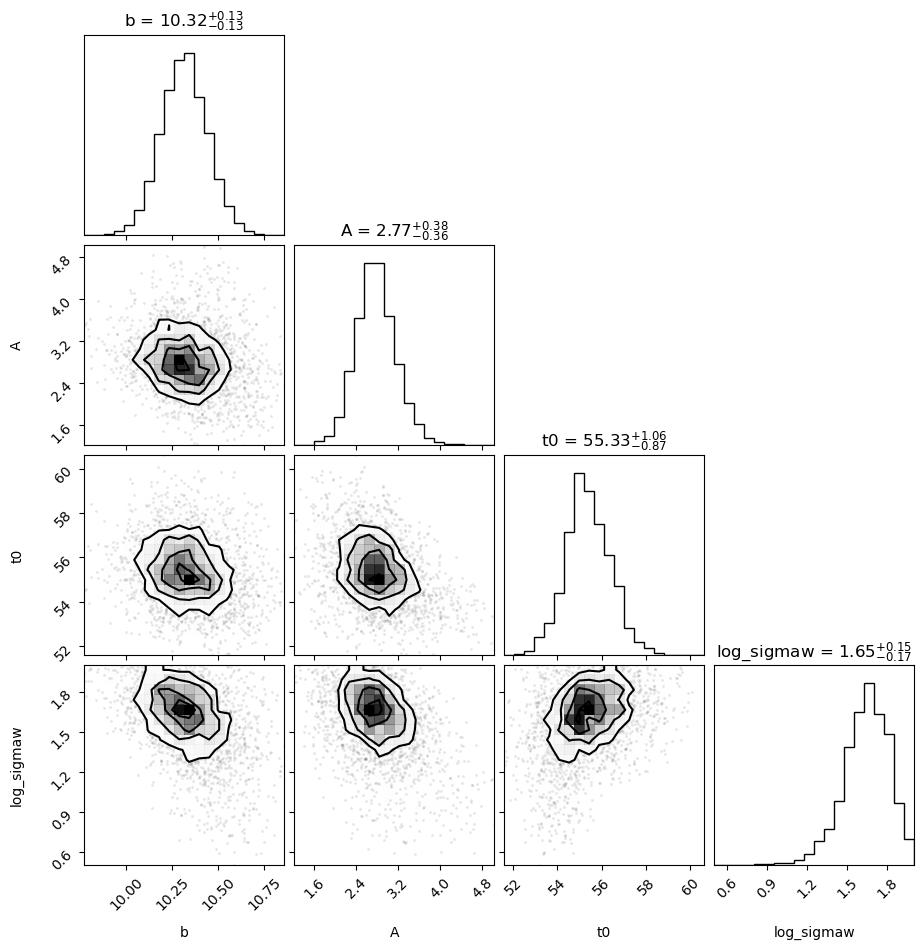

In [436]:
from ultranest.plot import cornerplot
cornerplot(result)

Corner plot looks nice! Double check that my sampling is running correctly by trying with the burstModel and seeing if my corner plot is similar. 

In [437]:
param_names2 = ['b','A','t0','log_alpha']

# same logL as before but more hardcoded
def logL_burst(theta):
    times = data1[:,0]
    fluxes = data1[:,1]
    fsigmas = data1[:,2]

    modelFits = burstModel(times,theta)

    return sum(scipy.stats.norm.logpdf(*args)
               for args in zip(fluxes, modelFits, fsigmas))
        # zip('ABCD','wxyz') = Aw,Bx,Cy,Dz

def my_prior_transform2(cube):
    params = cube.copy()

    # transform b parameter: uniform prior from 0 to 50
    lo = 0
    hi = 50
    params[0] = cube[0] * (hi - lo) + lo

    # transform A parameter: uniform prior from 0 to 50
    lo = 0
    hi = 50
    params[1] = cube[1] * (hi - lo) + lo

    # transform t0 parameter: uniform prior from 0 to 100
    lo = 0
    hi = 100
    params[2] = cube[2] * (hi - lo) + lo

    # transform log_alpha parameter: uniform prior from -5 to 5
    lo = -5
    hi = 5
    params[3] = cube[3] * (hi - lo) + lo

    # More complex prior, you can use the ppf functions
    # from scipy.stats, such as scipy.stats.norm(mean, std).ppf

    return params


In [438]:
sampler2 = ultranest.ReactiveNestedSampler(param_names2, logL_burst, 
                                          my_prior_transform2)

DEBUG:ultranest:ReactiveNestedSampler: dims=4+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


In [439]:
result2 = sampler2.run()
#sampler2.print_results()

[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 400.0), (inf, 400.0)]


DEBUG:ultranest:iteration=0, ncalls=401, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-122306.89, Lmax=-168.31


DEBUG:ultranest:iteration=3, ncalls=404, regioncalls=160, ndraw=40, logz=-115322.69, remainder_fraction=100.0000%, Lmin=-100451.70, Lmax=-168.31


DEBUG:ultranest:iteration=10, ncalls=411, regioncalls=440, ndraw=40, logz=-87259.87, remainder_fraction=100.0000%, Lmin=-87146.60, Lmax=-168.31


DEBUG:ultranest:iteration=21, ncalls=422, regioncalls=880, ndraw=40, logz=-74313.87, remainder_fraction=100.0000%, Lmin=-73549.26, Lmax=-168.31


DEBUG:ultranest:iteration=35, ncalls=439, regioncalls=1560, ndraw=40, logz=-67011.60, remainder_fraction=100.0000%, Lmin=-66774.40, Lmax=-168.31


DEBUG:ultranest:iteration=40, ncalls=445, regioncalls=1800, ndraw=40, logz=-66114.80, remainder_fraction=100.0000%, Lmin=-66085.04, Lmax=-168.31


DEBUG:ultranest:iteration=46, ncalls=451, regioncalls=2040, ndraw=40, logz=-64260.19, remainder_fraction=100.0000%, Lmin=-64228.14, Lmax=-168.31


DEBUG:ultranest:iteration=60, ncalls=467, regioncalls=2680, ndraw=40, logz=-61155.57, remainder_fraction=100.0000%, Lmin=-60407.65, Lmax=-168.31


DEBUG:ultranest:iteration=76, ncalls=483, regioncalls=3320, ndraw=40, logz=-53387.15, remainder_fraction=100.0000%, Lmin=-53048.15, Lmax=-168.31


DEBUG:ultranest:iteration=80, ncalls=488, regioncalls=3520, ndraw=40, logz=-50815.73, remainder_fraction=100.0000%, Lmin=-50722.86, Lmax=-168.31


DEBUG:ultranest:iteration=90, ncalls=501, regioncalls=4040, ndraw=40, logz=-47511.31, remainder_fraction=100.0000%, Lmin=-47266.32, Lmax=-168.31


DEBUG:ultranest:iteration=99, ncalls=513, regioncalls=4520, ndraw=40, logz=-44597.33, remainder_fraction=100.0000%, Lmin=-44441.90, Lmax=-168.31


DEBUG:ultranest:iteration=103, ncalls=517, regioncalls=4680, ndraw=40, logz=-43490.82, remainder_fraction=100.0000%, Lmin=-43400.67, Lmax=-168.31


DEBUG:ultranest:iteration=115, ncalls=530, regioncalls=5200, ndraw=40, logz=-40656.34, remainder_fraction=100.0000%, Lmin=-40193.84, Lmax=-168.31


DEBUG:ultranest:iteration=120, ncalls=537, regioncalls=5480, ndraw=40, logz=-39190.45, remainder_fraction=100.0000%, Lmin=-39025.53, Lmax=-168.31


DEBUG:ultranest:iteration=123, ncalls=542, regioncalls=5680, ndraw=40, logz=-38862.03, remainder_fraction=100.0000%, Lmin=-38766.18, Lmax=-168.31


DEBUG:ultranest:iteration=128, ncalls=547, regioncalls=5880, ndraw=40, logz=-37798.17, remainder_fraction=100.0000%, Lmin=-37315.66, Lmax=-168.31


DEBUG:ultranest:iteration=132, ncalls=551, regioncalls=6040, ndraw=40, logz=-36411.95, remainder_fraction=100.0000%, Lmin=-36098.89, Lmax=-168.31


DEBUG:ultranest:iteration=134, ncalls=554, regioncalls=6160, ndraw=40, logz=-35581.37, remainder_fraction=100.0000%, Lmin=-35421.32, Lmax=-168.31


DEBUG:ultranest:iteration=136, ncalls=558, regioncalls=6320, ndraw=40, logz=-35396.04, remainder_fraction=100.0000%, Lmin=-35354.16, Lmax=-168.31


DEBUG:ultranest:iteration=141, ncalls=564, regioncalls=6560, ndraw=40, logz=-34318.90, remainder_fraction=100.0000%, Lmin=-34170.53, Lmax=-168.31


DEBUG:ultranest:iteration=150, ncalls=580, regioncalls=7200, ndraw=40, logz=-33034.53, remainder_fraction=100.0000%, Lmin=-32882.92, Lmax=-168.31


DEBUG:ultranest:iteration=160, ncalls=590, regioncalls=7600, ndraw=40, logz=-31798.46, remainder_fraction=100.0000%, Lmin=-31614.56, Lmax=-168.31


DEBUG:ultranest:iteration=164, ncalls=596, regioncalls=7840, ndraw=40, logz=-30940.37, remainder_fraction=100.0000%, Lmin=-30809.02, Lmax=-168.31


DEBUG:ultranest:iteration=169, ncalls=601, regioncalls=8040, ndraw=40, logz=-30570.21, remainder_fraction=100.0000%, Lmin=-30012.52, Lmax=-168.31


DEBUG:ultranest:iteration=172, ncalls=604, regioncalls=8160, ndraw=40, logz=-29761.40, remainder_fraction=100.0000%, Lmin=-29623.17, Lmax=-168.31


DEBUG:ultranest:iteration=180, ncalls=616, regioncalls=8640, ndraw=40, logz=-27494.44, remainder_fraction=100.0000%, Lmin=-27456.55, Lmax=-168.31


DEBUG:ultranest:iteration=196, ncalls=639, regioncalls=9560, ndraw=40, logz=-25285.86, remainder_fraction=100.0000%, Lmin=-24926.20, Lmax=-168.31


DEBUG:ultranest:iteration=200, ncalls=644, regioncalls=9760, ndraw=40, logz=-24028.12, remainder_fraction=100.0000%, Lmin=-23347.75, Lmax=-168.31


DEBUG:ultranest:iteration=218, ncalls=668, regioncalls=10720, ndraw=40, logz=-20213.47, remainder_fraction=100.0000%, Lmin=-19616.53, Lmax=-168.31


DEBUG:ultranest:iteration=225, ncalls=677, regioncalls=11080, ndraw=40, logz=-18338.85, remainder_fraction=100.0000%, Lmin=-18318.55, Lmax=-168.31


DEBUG:ultranest:iteration=228, ncalls=680, regioncalls=11200, ndraw=40, logz=-18178.15, remainder_fraction=100.0000%, Lmin=-18002.30, Lmax=-168.31


DEBUG:ultranest:iteration=233, ncalls=685, regioncalls=11400, ndraw=40, logz=-17367.47, remainder_fraction=100.0000%, Lmin=-17302.87, Lmax=-168.31


DEBUG:ultranest:iteration=237, ncalls=691, regioncalls=11640, ndraw=40, logz=-17276.57, remainder_fraction=100.0000%, Lmin=-17257.00, Lmax=-168.31


DEBUG:ultranest:iteration=240, ncalls=694, regioncalls=11760, ndraw=40, logz=-17165.90, remainder_fraction=100.0000%, Lmin=-17092.63, Lmax=-168.31


DEBUG:ultranest:iteration=245, ncalls=700, regioncalls=12000, ndraw=40, logz=-16867.92, remainder_fraction=100.0000%, Lmin=-16718.86, Lmax=-168.31


DEBUG:ultranest:iteration=248, ncalls=703, regioncalls=12120, ndraw=40, logz=-16169.64, remainder_fraction=100.0000%, Lmin=-16146.34, Lmax=-168.31


DEBUG:ultranest:iteration=251, ncalls=708, regioncalls=12320, ndraw=40, logz=-15725.53, remainder_fraction=100.0000%, Lmin=-15316.65, Lmax=-168.31


DEBUG:ultranest:iteration=257, ncalls=714, regioncalls=12560, ndraw=40, logz=-14507.02, remainder_fraction=100.0000%, Lmin=-14487.01, Lmax=-168.31


DEBUG:ultranest:iteration=267, ncalls=728, regioncalls=13120, ndraw=40, logz=-13280.93, remainder_fraction=100.0000%, Lmin=-13134.22, Lmax=-168.31


DEBUG:ultranest:iteration=275, ncalls=749, regioncalls=13960, ndraw=40, logz=-12701.42, remainder_fraction=100.0000%, Lmin=-12627.25, Lmax=-168.31


DEBUG:ultranest:iteration=280, ncalls=757, regioncalls=14280, ndraw=40, logz=-12195.78, remainder_fraction=100.0000%, Lmin=-12126.32, Lmax=-168.31


DEBUG:ultranest:iteration=286, ncalls=765, regioncalls=14600, ndraw=40, logz=-11658.25, remainder_fraction=100.0000%, Lmin=-11648.46, Lmax=-168.31


DEBUG:ultranest:iteration=292, ncalls=772, regioncalls=14880, ndraw=40, logz=-11293.34, remainder_fraction=100.0000%, Lmin=-11239.23, Lmax=-168.31


DEBUG:ultranest:iteration=300, ncalls=784, regioncalls=15360, ndraw=40, logz=-10529.14, remainder_fraction=100.0000%, Lmin=-10440.21, Lmax=-168.31


DEBUG:ultranest:iteration=305, ncalls=790, regioncalls=15600, ndraw=40, logz=-10281.59, remainder_fraction=100.0000%, Lmin=-10212.06, Lmax=-168.31


DEBUG:ultranest:iteration=320, ncalls=807, regioncalls=16280, ndraw=40, logz=-9441.75, remainder_fraction=100.0000%, Lmin=-9378.45, Lmax=-168.31


DEBUG:ultranest:iteration=325, ncalls=813, regioncalls=16520, ndraw=40, logz=-9032.93, remainder_fraction=100.0000%, Lmin=-8923.85, Lmax=-168.31


DEBUG:ultranest:iteration=333, ncalls=827, regioncalls=17080, ndraw=40, logz=-8412.30, remainder_fraction=100.0000%, Lmin=-8326.46, Lmax=-168.31


DEBUG:ultranest:iteration=339, ncalls=837, regioncalls=17480, ndraw=40, logz=-8104.81, remainder_fraction=100.0000%, Lmin=-8072.07, Lmax=-168.31


DEBUG:ultranest:iteration=343, ncalls=843, regioncalls=17720, ndraw=40, logz=-7928.58, remainder_fraction=100.0000%, Lmin=-7812.48, Lmax=-168.31


DEBUG:ultranest:iteration=347, ncalls=853, regioncalls=18120, ndraw=40, logz=-7568.91, remainder_fraction=100.0000%, Lmin=-7524.45, Lmax=-168.31


DEBUG:ultranest:iteration=359, ncalls=872, regioncalls=18880, ndraw=40, logz=-6910.91, remainder_fraction=100.0000%, Lmin=-6884.37, Lmax=-168.31


DEBUG:ultranest:iteration=360, ncalls=875, regioncalls=19000, ndraw=40, logz=-6891.26, remainder_fraction=100.0000%, Lmin=-6780.45, Lmax=-168.31


DEBUG:ultranest:iteration=367, ncalls=882, regioncalls=19280, ndraw=40, logz=-6558.12, remainder_fraction=100.0000%, Lmin=-6523.54, Lmax=-168.31


DEBUG:ultranest:iteration=370, ncalls=886, regioncalls=19440, ndraw=40, logz=-6488.90, remainder_fraction=100.0000%, Lmin=-6447.27, Lmax=-168.31


DEBUG:ultranest:iteration=372, ncalls=891, regioncalls=19640, ndraw=40, logz=-6434.10, remainder_fraction=100.0000%, Lmin=-6372.90, Lmax=-168.31


DEBUG:ultranest:iteration=376, ncalls=898, regioncalls=19920, ndraw=40, logz=-6279.70, remainder_fraction=100.0000%, Lmin=-6263.83, Lmax=-168.31


DEBUG:ultranest:iteration=391, ncalls=921, regioncalls=20840, ndraw=40, logz=-5842.45, remainder_fraction=100.0000%, Lmin=-5818.11, Lmax=-168.31


DEBUG:ultranest:iteration=400, ncalls=935, regioncalls=21400, ndraw=40, logz=-5667.08, remainder_fraction=100.0000%, Lmin=-5621.71, Lmax=-168.31


DEBUG:ultranest:iteration=404, ncalls=939, regioncalls=21560, ndraw=40, logz=-5607.98, remainder_fraction=100.0000%, Lmin=-5487.98, Lmax=-168.31


DEBUG:ultranest:iteration=410, ncalls=948, regioncalls=21920, ndraw=40, logz=-5386.29, remainder_fraction=100.0000%, Lmin=-5362.64, Lmax=-168.31


DEBUG:ultranest:iteration=417, ncalls=955, regioncalls=22200, ndraw=40, logz=-5164.96, remainder_fraction=100.0000%, Lmin=-5140.38, Lmax=-168.31


DEBUG:ultranest:iteration=423, ncalls=965, regioncalls=22600, ndraw=40, logz=-5015.28, remainder_fraction=100.0000%, Lmin=-4967.74, Lmax=-168.31


DEBUG:ultranest:iteration=438, ncalls=988, regioncalls=23520, ndraw=40, logz=-4782.88, remainder_fraction=100.0000%, Lmin=-4715.89, Lmax=-168.31


DEBUG:ultranest:iteration=440, ncalls=990, regioncalls=23600, ndraw=40, logz=-4691.19, remainder_fraction=100.0000%, Lmin=-4649.72, Lmax=-168.31


DEBUG:ultranest:iteration=444, ncalls=995, regioncalls=23800, ndraw=40, logz=-4595.28, remainder_fraction=100.0000%, Lmin=-4579.80, Lmax=-168.31


DEBUG:ultranest:iteration=448, ncalls=1006, regioncalls=24240, ndraw=40, logz=-4538.04, remainder_fraction=100.0000%, Lmin=-4521.34, Lmax=-168.31


DEBUG:ultranest:iteration=450, ncalls=1013, regioncalls=24520, ndraw=40, logz=-4527.07, remainder_fraction=100.0000%, Lmin=-4495.66, Lmax=-168.31


DEBUG:ultranest:iteration=465, ncalls=1037, regioncalls=25480, ndraw=40, logz=-4043.08, remainder_fraction=100.0000%, Lmin=-4028.01, Lmax=-168.31


DEBUG:ultranest:iteration=480, ncalls=1059, regioncalls=26360, ndraw=40, logz=-3820.04, remainder_fraction=100.0000%, Lmin=-3809.94, Lmax=-168.31


DEBUG:ultranest:iteration=493, ncalls=1084, regioncalls=27360, ndraw=40, logz=-3637.50, remainder_fraction=100.0000%, Lmin=-3620.28, Lmax=-168.31


DEBUG:ultranest:iteration=508, ncalls=1108, regioncalls=28320, ndraw=40, logz=-3480.41, remainder_fraction=100.0000%, Lmin=-3465.70, Lmax=-168.31


DEBUG:ultranest:iteration=520, ncalls=1132, regioncalls=29280, ndraw=40, logz=-3318.41, remainder_fraction=100.0000%, Lmin=-3294.30, Lmax=-168.31


DEBUG:ultranest:iteration=535, ncalls=1158, regioncalls=30320, ndraw=40, logz=-3181.49, remainder_fraction=100.0000%, Lmin=-3162.52, Lmax=-168.31


DEBUG:ultranest:iteration=540, ncalls=1164, regioncalls=30560, ndraw=40, logz=-3155.23, remainder_fraction=100.0000%, Lmin=-3135.40, Lmax=-168.31


DEBUG:ultranest:iteration=545, ncalls=1172, regioncalls=30880, ndraw=40, logz=-3085.83, remainder_fraction=100.0000%, Lmin=-3057.22, Lmax=-168.31


DEBUG:ultranest:iteration=548, ncalls=1178, regioncalls=31120, ndraw=40, logz=-3040.57, remainder_fraction=100.0000%, Lmin=-3029.31, Lmax=-168.31


DEBUG:ultranest:iteration=558, ncalls=1193, regioncalls=31720, ndraw=40, logz=-2917.61, remainder_fraction=100.0000%, Lmin=-2900.80, Lmax=-168.31


DEBUG:ultranest:iteration=560, ncalls=1196, regioncalls=31840, ndraw=40, logz=-2903.02, remainder_fraction=100.0000%, Lmin=-2891.69, Lmax=-168.31


DEBUG:ultranest:iteration=563, ncalls=1200, regioncalls=32000, ndraw=40, logz=-2889.89, remainder_fraction=100.0000%, Lmin=-2873.69, Lmax=-168.31


DEBUG:ultranest:iteration=566, ncalls=1206, regioncalls=32240, ndraw=40, logz=-2855.04, remainder_fraction=100.0000%, Lmin=-2830.79, Lmax=-168.31


DEBUG:ultranest:iteration=568, ncalls=1209, regioncalls=32360, ndraw=40, logz=-2837.20, remainder_fraction=100.0000%, Lmin=-2826.16, Lmax=-168.31


DEBUG:ultranest:iteration=571, ncalls=1213, regioncalls=32520, ndraw=40, logz=-2819.43, remainder_fraction=100.0000%, Lmin=-2810.26, Lmax=-168.31


DEBUG:ultranest:iteration=576, ncalls=1221, regioncalls=32840, ndraw=40, logz=-2788.80, remainder_fraction=100.0000%, Lmin=-2753.39, Lmax=-168.31


DEBUG:ultranest:iteration=588, ncalls=1242, regioncalls=33680, ndraw=40, logz=-2659.63, remainder_fraction=100.0000%, Lmin=-2637.14, Lmax=-168.31


DEBUG:ultranest:iteration=598, ncalls=1264, regioncalls=34560, ndraw=40, logz=-2536.65, remainder_fraction=100.0000%, Lmin=-2528.27, Lmax=-168.31


DEBUG:ultranest:iteration=600, ncalls=1266, regioncalls=34640, ndraw=40, logz=-2531.82, remainder_fraction=100.0000%, Lmin=-2499.13, Lmax=-168.31


DEBUG:ultranest:iteration=614, ncalls=1291, regioncalls=35640, ndraw=40, logz=-2444.20, remainder_fraction=100.0000%, Lmin=-2425.24, Lmax=-168.31


DEBUG:ultranest:iteration=629, ncalls=1311, regioncalls=36440, ndraw=40, logz=-2318.71, remainder_fraction=100.0000%, Lmin=-2308.05, Lmax=-168.31


DEBUG:ultranest:iteration=640, ncalls=1330, regioncalls=37200, ndraw=40, logz=-2239.28, remainder_fraction=100.0000%, Lmin=-2231.52, Lmax=-168.31


DEBUG:ultranest:iteration=655, ncalls=1355, regioncalls=38200, ndraw=40, logz=-2133.13, remainder_fraction=100.0000%, Lmin=-2123.80, Lmax=-168.31


DEBUG:ultranest:iteration=662, ncalls=1364, regioncalls=38560, ndraw=40, logz=-2054.16, remainder_fraction=100.0000%, Lmin=-2032.25, Lmax=-168.31


DEBUG:ultranest:iteration=664, ncalls=1367, regioncalls=38680, ndraw=40, logz=-2033.13, remainder_fraction=100.0000%, Lmin=-1989.43, Lmax=-168.31


DEBUG:ultranest:iteration=668, ncalls=1374, regioncalls=38960, ndraw=40, logz=-1973.84, remainder_fraction=100.0000%, Lmin=-1962.24, Lmax=-168.31


DEBUG:ultranest:iteration=671, ncalls=1380, regioncalls=39200, ndraw=40, logz=-1958.48, remainder_fraction=100.0000%, Lmin=-1928.43, Lmax=-168.31


DEBUG:ultranest:iteration=676, ncalls=1386, regioncalls=39440, ndraw=40, logz=-1928.49, remainder_fraction=100.0000%, Lmin=-1908.90, Lmax=-168.31


DEBUG:ultranest:iteration=678, ncalls=1394, regioncalls=39760, ndraw=40, logz=-1879.63, remainder_fraction=100.0000%, Lmin=-1868.22, Lmax=-168.31


DEBUG:ultranest:iteration=680, ncalls=1396, regioncalls=39840, ndraw=40, logz=-1874.10, remainder_fraction=100.0000%, Lmin=-1866.54, Lmax=-168.31


DEBUG:ultranest:iteration=685, ncalls=1402, regioncalls=40080, ndraw=40, logz=-1847.07, remainder_fraction=100.0000%, Lmin=-1831.01, Lmax=-168.31


DEBUG:ultranest:iteration=687, ncalls=1410, regioncalls=40400, ndraw=40, logz=-1836.68, remainder_fraction=100.0000%, Lmin=-1826.97, Lmax=-168.31


DEBUG:ultranest:iteration=692, ncalls=1416, regioncalls=40640, ndraw=40, logz=-1775.23, remainder_fraction=100.0000%, Lmin=-1763.01, Lmax=-168.31


DEBUG:ultranest:iteration=694, ncalls=1424, regioncalls=40960, ndraw=40, logz=-1768.71, remainder_fraction=100.0000%, Lmin=-1756.18, Lmax=-168.31


DEBUG:ultranest:iteration=697, ncalls=1436, regioncalls=41440, ndraw=40, logz=-1747.27, remainder_fraction=100.0000%, Lmin=-1731.00, Lmax=-168.31


DEBUG:ultranest:iteration=710, ncalls=1463, regioncalls=42520, ndraw=40, logz=-1682.22, remainder_fraction=100.0000%, Lmin=-1666.19, Lmax=-168.31


DEBUG:ultranest:iteration=720, ncalls=1489, regioncalls=43560, ndraw=40, logz=-1640.45, remainder_fraction=100.0000%, Lmin=-1626.30, Lmax=-168.31


DEBUG:ultranest:iteration=730, ncalls=1514, regioncalls=44560, ndraw=40, logz=-1607.06, remainder_fraction=100.0000%, Lmin=-1586.38, Lmax=-168.31


DEBUG:ultranest:iteration=740, ncalls=1539, regioncalls=45560, ndraw=40, logz=-1566.11, remainder_fraction=100.0000%, Lmin=-1558.29, Lmax=-168.31


DEBUG:ultranest:iteration=745, ncalls=1555, regioncalls=46200, ndraw=40, logz=-1544.14, remainder_fraction=100.0000%, Lmin=-1531.20, Lmax=-168.31


DEBUG:ultranest:iteration=755, ncalls=1582, regioncalls=47280, ndraw=40, logz=-1484.66, remainder_fraction=100.0000%, Lmin=-1475.19, Lmax=-168.31


DEBUG:ultranest:iteration=760, ncalls=1592, regioncalls=47680, ndraw=40, logz=-1454.85, remainder_fraction=100.0000%, Lmin=-1430.70, Lmax=-168.31


DEBUG:ultranest:iteration=770, ncalls=1616, regioncalls=48640, ndraw=40, logz=-1405.74, remainder_fraction=100.0000%, Lmin=-1395.43, Lmax=-168.31


DEBUG:ultranest:iteration=782, ncalls=1645, regioncalls=49800, ndraw=40, logz=-1362.71, remainder_fraction=100.0000%, Lmin=-1348.65, Lmax=-168.31


DEBUG:ultranest:iteration=795, ncalls=1674, regioncalls=50960, ndraw=40, logz=-1309.06, remainder_fraction=100.0000%, Lmin=-1290.69, Lmax=-168.31


DEBUG:ultranest:iteration=800, ncalls=1687, regioncalls=51480, ndraw=40, logz=-1266.29, remainder_fraction=100.0000%, Lmin=-1247.00, Lmax=-168.31


DEBUG:ultranest:iteration=805, ncalls=1697, regioncalls=51880, ndraw=40, logz=-1234.84, remainder_fraction=100.0000%, Lmin=-1218.80, Lmax=-168.31


DEBUG:ultranest:iteration=808, ncalls=1705, regioncalls=52200, ndraw=40, logz=-1224.58, remainder_fraction=100.0000%, Lmin=-1214.64, Lmax=-168.31


DEBUG:ultranest:iteration=811, ncalls=1713, regioncalls=52520, ndraw=40, logz=-1211.70, remainder_fraction=100.0000%, Lmin=-1197.35, Lmax=-168.31


DEBUG:ultranest:iteration=812, ncalls=1718, regioncalls=52720, ndraw=40, logz=-1205.36, remainder_fraction=100.0000%, Lmin=-1196.44, Lmax=-168.31


DEBUG:ultranest:iteration=813, ncalls=1730, regioncalls=53200, ndraw=40, logz=-1204.12, remainder_fraction=100.0000%, Lmin=-1195.55, Lmax=-168.31


DEBUG:ultranest:iteration=818, ncalls=1741, regioncalls=53640, ndraw=40, logz=-1175.87, remainder_fraction=100.0000%, Lmin=-1166.98, Lmax=-168.31


DEBUG:ultranest:iteration=828, ncalls=1769, regioncalls=54760, ndraw=40, logz=-1141.92, remainder_fraction=100.0000%, Lmin=-1125.43, Lmax=-168.31


DEBUG:ultranest:iteration=836, ncalls=1796, regioncalls=55840, ndraw=40, logz=-1102.35, remainder_fraction=100.0000%, Lmin=-1083.51, Lmax=-165.49


DEBUG:ultranest:iteration=840, ncalls=1803, regioncalls=56120, ndraw=40, logz=-1088.52, remainder_fraction=100.0000%, Lmin=-1080.13, Lmax=-165.49


DEBUG:ultranest:iteration=846, ncalls=1813, regioncalls=56520, ndraw=40, logz=-1075.65, remainder_fraction=100.0000%, Lmin=-1066.69, Lmax=-165.49


DEBUG:ultranest:iteration=848, ncalls=1818, regioncalls=56720, ndraw=40, logz=-1070.91, remainder_fraction=100.0000%, Lmin=-1059.97, Lmax=-165.49


DEBUG:ultranest:iteration=849, ncalls=1829, regioncalls=57160, ndraw=40, logz=-1068.02, remainder_fraction=100.0000%, Lmin=-1056.83, Lmax=-165.49


DEBUG:ultranest:iteration=851, ncalls=1842, regioncalls=57680, ndraw=40, logz=-1063.16, remainder_fraction=100.0000%, Lmin=-1045.52, Lmax=-165.49


DEBUG:ultranest:iteration=854, ncalls=1852, regioncalls=58080, ndraw=40, logz=-1048.68, remainder_fraction=100.0000%, Lmin=-1032.79, Lmax=-165.49


DEBUG:ultranest:iteration=863, ncalls=1875, regioncalls=59000, ndraw=40, logz=-1014.73, remainder_fraction=100.0000%, Lmin=-1004.72, Lmax=-165.49


DEBUG:ultranest:iteration=869, ncalls=1901, regioncalls=60040, ndraw=40, logz=-1003.00, remainder_fraction=100.0000%, Lmin=-993.31, Lmax=-165.49


DEBUG:ultranest:iteration=875, ncalls=1927, regioncalls=61080, ndraw=40, logz=-985.05, remainder_fraction=100.0000%, Lmin=-973.38, Lmax=-165.49


DEBUG:ultranest:iteration=880, ncalls=1937, regioncalls=61480, ndraw=40, logz=-975.72, remainder_fraction=100.0000%, Lmin=-954.13, Lmax=-165.49


DEBUG:ultranest:iteration=889, ncalls=1962, regioncalls=62480, ndraw=40, logz=-948.85, remainder_fraction=100.0000%, Lmin=-940.66, Lmax=-165.49


DEBUG:ultranest:iteration=893, ncalls=1973, regioncalls=62920, ndraw=40, logz=-940.45, remainder_fraction=100.0000%, Lmin=-931.12, Lmax=-165.49


DEBUG:ultranest:iteration=897, ncalls=1981, regioncalls=63240, ndraw=40, logz=-930.36, remainder_fraction=100.0000%, Lmin=-921.40, Lmax=-165.49


DEBUG:ultranest:iteration=903, ncalls=1995, regioncalls=63800, ndraw=40, logz=-910.55, remainder_fraction=100.0000%, Lmin=-899.54, Lmax=-165.49


DEBUG:ultranest:iteration=912, ncalls=2019, regioncalls=64760, ndraw=40, logz=-877.20, remainder_fraction=100.0000%, Lmin=-868.00, Lmax=-165.49


DEBUG:ultranest:iteration=920, ncalls=2045, regioncalls=65800, ndraw=40, logz=-855.22, remainder_fraction=100.0000%, Lmin=-844.37, Lmax=-165.49


DEBUG:ultranest:iteration=928, ncalls=2073, regioncalls=66920, ndraw=40, logz=-837.81, remainder_fraction=100.0000%, Lmin=-827.63, Lmax=-165.49


DEBUG:ultranest:iteration=929, ncalls=2079, regioncalls=67160, ndraw=40, logz=-835.80, remainder_fraction=100.0000%, Lmin=-824.93, Lmax=-165.49


DEBUG:ultranest:iteration=932, ncalls=2095, regioncalls=67800, ndraw=40, logz=-829.92, remainder_fraction=100.0000%, Lmin=-816.38, Lmax=-165.49


DEBUG:ultranest:iteration=937, ncalls=2107, regioncalls=68280, ndraw=40, logz=-816.41, remainder_fraction=100.0000%, Lmin=-808.36, Lmax=-165.49


DEBUG:ultranest:iteration=938, ncalls=2116, regioncalls=68640, ndraw=40, logz=-815.85, remainder_fraction=100.0000%, Lmin=-807.24, Lmax=-165.49


DEBUG:ultranest:iteration=941, ncalls=2127, regioncalls=69080, ndraw=40, logz=-811.90, remainder_fraction=100.0000%, Lmin=-803.58, Lmax=-165.49


DEBUG:ultranest:iteration=947, ncalls=2148, regioncalls=69920, ndraw=40, logz=-785.48, remainder_fraction=100.0000%, Lmin=-769.64, Lmax=-165.49


DEBUG:ultranest:iteration=955, ncalls=2173, regioncalls=70920, ndraw=40, logz=-743.45, remainder_fraction=100.0000%, Lmin=-734.85, Lmax=-165.49


DEBUG:ultranest:iteration=960, ncalls=2193, regioncalls=71720, ndraw=40, logz=-731.46, remainder_fraction=100.0000%, Lmin=-722.15, Lmax=-165.49


DEBUG:ultranest:iteration=968, ncalls=2218, regioncalls=72720, ndraw=40, logz=-720.59, remainder_fraction=100.0000%, Lmin=-710.83, Lmax=-165.49


DEBUG:ultranest:iteration=975, ncalls=2244, regioncalls=73760, ndraw=40, logz=-709.93, remainder_fraction=100.0000%, Lmin=-700.12, Lmax=-165.49


DEBUG:ultranest:iteration=979, ncalls=2273, regioncalls=74920, ndraw=40, logz=-702.81, remainder_fraction=100.0000%, Lmin=-689.76, Lmax=-165.49


DEBUG:ultranest:iteration=982, ncalls=2305, regioncalls=76200, ndraw=40, logz=-695.08, remainder_fraction=100.0000%, Lmin=-685.97, Lmax=-165.49


DEBUG:ultranest:iteration=985, ncalls=2315, regioncalls=76600, ndraw=40, logz=-692.64, remainder_fraction=100.0000%, Lmin=-684.67, Lmax=-165.49


DEBUG:ultranest:iteration=989, ncalls=2351, regioncalls=78040, ndraw=40, logz=-688.28, remainder_fraction=100.0000%, Lmin=-679.05, Lmax=-165.49


DEBUG:ultranest:iteration=990, ncalls=2353, regioncalls=78120, ndraw=40, logz=-687.13, remainder_fraction=100.0000%, Lmin=-671.82, Lmax=-165.49


DEBUG:ultranest:iteration=995, ncalls=2362, regioncalls=78480, ndraw=40, logz=-668.97, remainder_fraction=100.0000%, Lmin=-658.34, Lmax=-165.49


DEBUG:ultranest:iteration=997, ncalls=2369, regioncalls=78760, ndraw=40, logz=-664.77, remainder_fraction=100.0000%, Lmin=-655.50, Lmax=-165.49


DEBUG:ultranest:iteration=1000, ncalls=2376, regioncalls=79040, ndraw=40, logz=-647.31, remainder_fraction=100.0000%, Lmin=-638.47, Lmax=-165.49


DEBUG:ultranest:iteration=1003, ncalls=2384, regioncalls=79360, ndraw=40, logz=-645.01, remainder_fraction=100.0000%, Lmin=-637.13, Lmax=-165.49


DEBUG:ultranest:iteration=1008, ncalls=2395, regioncalls=79800, ndraw=40, logz=-637.49, remainder_fraction=100.0000%, Lmin=-629.65, Lmax=-165.49


DEBUG:ultranest:iteration=1018, ncalls=2421, regioncalls=80840, ndraw=40, logz=-625.16, remainder_fraction=100.0000%, Lmin=-612.90, Lmax=-165.49


DEBUG:ultranest:iteration=1028, ncalls=2447, regioncalls=81880, ndraw=40, logz=-602.87, remainder_fraction=100.0000%, Lmin=-593.62, Lmax=-165.49


DEBUG:ultranest:iteration=1033, ncalls=2455, regioncalls=82200, ndraw=40, logz=-592.79, remainder_fraction=100.0000%, Lmin=-584.04, Lmax=-165.49


DEBUG:ultranest:iteration=1037, ncalls=2465, regioncalls=82600, ndraw=40, logz=-589.58, remainder_fraction=100.0000%, Lmin=-580.04, Lmax=-165.49


DEBUG:ultranest:iteration=1040, ncalls=2470, regioncalls=82800, ndraw=40, logz=-579.70, remainder_fraction=100.0000%, Lmin=-571.60, Lmax=-165.49


DEBUG:ultranest:iteration=1045, ncalls=2480, regioncalls=83200, ndraw=40, logz=-575.50, remainder_fraction=100.0000%, Lmin=-562.63, Lmax=-165.49


DEBUG:ultranest:iteration=1055, ncalls=2504, regioncalls=84160, ndraw=40, logz=-556.63, remainder_fraction=100.0000%, Lmin=-546.81, Lmax=-165.49


DEBUG:ultranest:iteration=1058, ncalls=2509, regioncalls=84360, ndraw=40, logz=-550.64, remainder_fraction=100.0000%, Lmin=-541.83, Lmax=-165.49


DEBUG:ultranest:iteration=1067, ncalls=2530, regioncalls=85200, ndraw=40, logz=-523.65, remainder_fraction=100.0000%, Lmin=-514.72, Lmax=-165.49


DEBUG:ultranest:iteration=1078, ncalls=2547, regioncalls=85880, ndraw=40, logz=-505.36, remainder_fraction=100.0000%, Lmin=-496.71, Lmax=-165.49


DEBUG:ultranest:iteration=1080, ncalls=2550, regioncalls=86000, ndraw=40, logz=-503.40, remainder_fraction=100.0000%, Lmin=-494.41, Lmax=-165.49


DEBUG:ultranest:iteration=1086, ncalls=2563, regioncalls=86520, ndraw=40, logz=-496.76, remainder_fraction=100.0000%, Lmin=-484.24, Lmax=-165.49


DEBUG:ultranest:iteration=1097, ncalls=2585, regioncalls=87400, ndraw=40, logz=-481.70, remainder_fraction=100.0000%, Lmin=-473.20, Lmax=-165.49


DEBUG:ultranest:iteration=1111, ncalls=2609, regioncalls=88360, ndraw=40, logz=-467.14, remainder_fraction=100.0000%, Lmin=-459.05, Lmax=-165.49


DEBUG:ultranest:iteration=1120, ncalls=2627, regioncalls=89080, ndraw=40, logz=-462.41, remainder_fraction=100.0000%, Lmin=-453.78, Lmax=-165.49


DEBUG:ultranest:iteration=1122, ncalls=2633, regioncalls=89320, ndraw=40, logz=-460.69, remainder_fraction=100.0000%, Lmin=-452.29, Lmax=-165.49


DEBUG:ultranest:iteration=1129, ncalls=2643, regioncalls=89760, ndraw=40, logz=-453.59, remainder_fraction=100.0000%, Lmin=-444.30, Lmax=-165.49


DEBUG:ultranest:iteration=1131, ncalls=2648, regioncalls=89960, ndraw=40, logz=-450.99, remainder_fraction=100.0000%, Lmin=-441.71, Lmax=-165.49


DEBUG:ultranest:iteration=1133, ncalls=2654, regioncalls=90200, ndraw=40, logz=-449.49, remainder_fraction=100.0000%, Lmin=-439.51, Lmax=-165.49


DEBUG:ultranest:iteration=1140, ncalls=2669, regioncalls=90800, ndraw=40, logz=-439.52, remainder_fraction=100.0000%, Lmin=-429.38, Lmax=-165.49


DEBUG:ultranest:iteration=1152, ncalls=2698, regioncalls=91960, ndraw=40, logz=-423.55, remainder_fraction=100.0000%, Lmin=-415.24, Lmax=-165.49


DEBUG:ultranest:iteration=1160, ncalls=2712, regioncalls=92520, ndraw=40, logz=-418.38, remainder_fraction=100.0000%, Lmin=-409.75, Lmax=-165.49


DEBUG:ultranest:iteration=1163, ncalls=2719, regioncalls=92800, ndraw=40, logz=-416.64, remainder_fraction=100.0000%, Lmin=-407.53, Lmax=-165.49


DEBUG:ultranest:iteration=1168, ncalls=2727, regioncalls=93120, ndraw=40, logz=-411.19, remainder_fraction=100.0000%, Lmin=-401.63, Lmax=-165.49


DEBUG:ultranest:iteration=1170, ncalls=2734, regioncalls=93400, ndraw=40, logz=-409.20, remainder_fraction=100.0000%, Lmin=-400.39, Lmax=-165.49


DEBUG:ultranest:iteration=1176, ncalls=2754, regioncalls=94200, ndraw=40, logz=-404.81, remainder_fraction=100.0000%, Lmin=-392.92, Lmax=-165.49


DEBUG:ultranest:iteration=1182, ncalls=2777, regioncalls=95120, ndraw=40, logz=-396.99, remainder_fraction=100.0000%, Lmin=-388.35, Lmax=-165.49


DEBUG:ultranest:iteration=1193, ncalls=2801, regioncalls=96080, ndraw=40, logz=-392.92, remainder_fraction=100.0000%, Lmin=-384.92, Lmax=-165.49


DEBUG:ultranest:iteration=1200, ncalls=2821, regioncalls=96880, ndraw=40, logz=-389.38, remainder_fraction=100.0000%, Lmin=-380.44, Lmax=-165.49


DEBUG:ultranest:iteration=1205, ncalls=2847, regioncalls=97920, ndraw=40, logz=-383.68, remainder_fraction=100.0000%, Lmin=-375.68, Lmax=-165.49


DEBUG:ultranest:iteration=1211, ncalls=2875, regioncalls=99040, ndraw=40, logz=-380.22, remainder_fraction=100.0000%, Lmin=-371.44, Lmax=-165.49


DEBUG:ultranest:iteration=1218, ncalls=2904, regioncalls=100200, ndraw=40, logz=-374.80, remainder_fraction=100.0000%, Lmin=-366.52, Lmax=-165.49


DEBUG:ultranest:iteration=1220, ncalls=2914, regioncalls=100600, ndraw=40, logz=-373.59, remainder_fraction=100.0000%, Lmin=-363.59, Lmax=-165.49


DEBUG:ultranest:iteration=1222, ncalls=2919, regioncalls=100800, ndraw=40, logz=-371.53, remainder_fraction=100.0000%, Lmin=-363.00, Lmax=-165.49


DEBUG:ultranest:iteration=1226, ncalls=2925, regioncalls=101040, ndraw=40, logz=-370.02, remainder_fraction=100.0000%, Lmin=-361.70, Lmax=-165.49


DEBUG:ultranest:iteration=1227, ncalls=2931, regioncalls=101280, ndraw=40, logz=-369.63, remainder_fraction=100.0000%, Lmin=-360.90, Lmax=-165.49


DEBUG:ultranest:iteration=1234, ncalls=2952, regioncalls=102120, ndraw=40, logz=-361.07, remainder_fraction=100.0000%, Lmin=-352.17, Lmax=-165.49


DEBUG:ultranest:iteration=1238, ncalls=2961, regioncalls=102480, ndraw=40, logz=-358.88, remainder_fraction=100.0000%, Lmin=-350.61, Lmax=-165.49


DEBUG:ultranest:iteration=1240, ncalls=2965, regioncalls=102640, ndraw=40, logz=-357.83, remainder_fraction=100.0000%, Lmin=-349.26, Lmax=-165.49


DEBUG:ultranest:iteration=1241, ncalls=2969, regioncalls=102800, ndraw=40, logz=-357.37, remainder_fraction=100.0000%, Lmin=-347.73, Lmax=-165.49


DEBUG:ultranest:iteration=1244, ncalls=2976, regioncalls=103080, ndraw=40, logz=-354.02, remainder_fraction=100.0000%, Lmin=-345.06, Lmax=-165.49


DEBUG:ultranest:iteration=1246, ncalls=2980, regioncalls=103240, ndraw=40, logz=-352.97, remainder_fraction=100.0000%, Lmin=-344.88, Lmax=-165.49


DEBUG:ultranest:iteration=1247, ncalls=2986, regioncalls=103480, ndraw=40, logz=-352.66, remainder_fraction=100.0000%, Lmin=-344.71, Lmax=-165.49


DEBUG:ultranest:iteration=1248, ncalls=3001, regioncalls=104080, ndraw=40, logz=-352.39, remainder_fraction=100.0000%, Lmin=-341.77, Lmax=-165.49


DEBUG:ultranest:iteration=1252, ncalls=3012, regioncalls=104520, ndraw=40, logz=-349.26, remainder_fraction=100.0000%, Lmin=-339.95, Lmax=-165.49


DEBUG:ultranest:iteration=1253, ncalls=3016, regioncalls=104680, ndraw=40, logz=-348.47, remainder_fraction=100.0000%, Lmin=-339.51, Lmax=-165.49


DEBUG:ultranest:iteration=1256, ncalls=3023, regioncalls=104960, ndraw=40, logz=-346.93, remainder_fraction=100.0000%, Lmin=-338.86, Lmax=-165.49


DEBUG:ultranest:iteration=1258, ncalls=3030, regioncalls=105240, ndraw=40, logz=-346.34, remainder_fraction=100.0000%, Lmin=-338.52, Lmax=-165.49


DEBUG:ultranest:iteration=1260, ncalls=3040, regioncalls=105640, ndraw=40, logz=-345.84, remainder_fraction=100.0000%, Lmin=-336.33, Lmax=-165.49


DEBUG:ultranest:iteration=1270, ncalls=3065, regioncalls=106640, ndraw=40, logz=-341.44, remainder_fraction=100.0000%, Lmin=-332.08, Lmax=-165.49


DEBUG:ultranest:iteration=1278, ncalls=3090, regioncalls=107640, ndraw=40, logz=-337.59, remainder_fraction=100.0000%, Lmin=-329.27, Lmax=-165.49


DEBUG:ultranest:iteration=1280, ncalls=3092, regioncalls=107720, ndraw=40, logz=-336.96, remainder_fraction=100.0000%, Lmin=-328.10, Lmax=-165.49


DEBUG:ultranest:iteration=1283, ncalls=3100, regioncalls=108040, ndraw=40, logz=-334.92, remainder_fraction=100.0000%, Lmin=-326.29, Lmax=-165.49


DEBUG:ultranest:iteration=1286, ncalls=3124, regioncalls=109000, ndraw=40, logz=-332.38, remainder_fraction=100.0000%, Lmin=-321.91, Lmax=-165.49


DEBUG:ultranest:iteration=1290, ncalls=3131, regioncalls=109280, ndraw=40, logz=-329.52, remainder_fraction=100.0000%, Lmin=-320.82, Lmax=-165.49


DEBUG:ultranest:iteration=1291, ncalls=3135, regioncalls=109440, ndraw=40, logz=-329.05, remainder_fraction=100.0000%, Lmin=-320.37, Lmax=-165.49


DEBUG:ultranest:iteration=1295, ncalls=3142, regioncalls=109720, ndraw=40, logz=-326.15, remainder_fraction=100.0000%, Lmin=-317.18, Lmax=-165.49


DEBUG:ultranest:iteration=1297, ncalls=3146, regioncalls=109880, ndraw=40, logz=-325.21, remainder_fraction=100.0000%, Lmin=-316.51, Lmax=-165.49


DEBUG:ultranest:iteration=1299, ncalls=3154, regioncalls=110240, ndraw=40, logz=-324.12, remainder_fraction=100.0000%, Lmin=-315.03, Lmax=-153.47


DEBUG:ultranest:iteration=1302, ncalls=3174, regioncalls=111040, ndraw=40, logz=-321.65, remainder_fraction=100.0000%, Lmin=-312.70, Lmax=-153.47


DEBUG:ultranest:iteration=1305, ncalls=3182, regioncalls=111360, ndraw=40, logz=-319.95, remainder_fraction=100.0000%, Lmin=-310.60, Lmax=-153.47


DEBUG:ultranest:iteration=1307, ncalls=3191, regioncalls=111720, ndraw=40, logz=-318.66, remainder_fraction=100.0000%, Lmin=-310.05, Lmax=-153.47


DEBUG:ultranest:iteration=1314, ncalls=3209, regioncalls=112440, ndraw=40, logz=-314.41, remainder_fraction=100.0000%, Lmin=-306.15, Lmax=-153.47


DEBUG:ultranest:iteration=1316, ncalls=3215, regioncalls=112680, ndraw=40, logz=-313.71, remainder_fraction=100.0000%, Lmin=-305.30, Lmax=-153.47


DEBUG:ultranest:iteration=1320, ncalls=3225, regioncalls=113080, ndraw=40, logz=-312.49, remainder_fraction=100.0000%, Lmin=-303.78, Lmax=-153.47


DEBUG:ultranest:iteration=1323, ncalls=3233, regioncalls=113400, ndraw=40, logz=-311.35, remainder_fraction=100.0000%, Lmin=-302.78, Lmax=-153.47


DEBUG:ultranest:iteration=1325, ncalls=3241, regioncalls=113720, ndraw=40, logz=-310.41, remainder_fraction=100.0000%, Lmin=-301.87, Lmax=-153.47


DEBUG:ultranest:iteration=1326, ncalls=3248, regioncalls=114000, ndraw=40, logz=-310.03, remainder_fraction=100.0000%, Lmin=-301.42, Lmax=-153.47


DEBUG:ultranest:iteration=1330, ncalls=3252, regioncalls=114160, ndraw=40, logz=-308.72, remainder_fraction=100.0000%, Lmin=-300.44, Lmax=-153.47


DEBUG:ultranest:iteration=1333, ncalls=3265, regioncalls=114680, ndraw=40, logz=-307.88, remainder_fraction=100.0000%, Lmin=-299.79, Lmax=-153.47


DEBUG:ultranest:iteration=1339, ncalls=3290, regioncalls=115680, ndraw=40, logz=-305.96, remainder_fraction=100.0000%, Lmin=-297.68, Lmax=-153.47


DEBUG:ultranest:iteration=1345, ncalls=3316, regioncalls=116720, ndraw=40, logz=-301.37, remainder_fraction=100.0000%, Lmin=-291.36, Lmax=-153.47


DEBUG:ultranest:iteration=1354, ncalls=3340, regioncalls=117680, ndraw=40, logz=-296.51, remainder_fraction=100.0000%, Lmin=-287.70, Lmax=-153.47


DEBUG:ultranest:iteration=1360, ncalls=3364, regioncalls=118640, ndraw=40, logz=-292.16, remainder_fraction=100.0000%, Lmin=-283.19, Lmax=-153.47


DEBUG:ultranest:iteration=1362, ncalls=3372, regioncalls=118960, ndraw=40, logz=-291.29, remainder_fraction=100.0000%, Lmin=-282.11, Lmax=-153.47


DEBUG:ultranest:iteration=1365, ncalls=3379, regioncalls=119240, ndraw=40, logz=-289.89, remainder_fraction=100.0000%, Lmin=-281.56, Lmax=-153.47


DEBUG:ultranest:iteration=1367, ncalls=3382, regioncalls=119360, ndraw=40, logz=-289.15, remainder_fraction=100.0000%, Lmin=-280.55, Lmax=-153.47


DEBUG:ultranest:iteration=1370, ncalls=3395, regioncalls=119880, ndraw=40, logz=-288.21, remainder_fraction=100.0000%, Lmin=-279.84, Lmax=-153.47


DEBUG:ultranest:iteration=1374, ncalls=3405, regioncalls=120280, ndraw=40, logz=-287.12, remainder_fraction=100.0000%, Lmin=-279.01, Lmax=-153.47


DEBUG:ultranest:iteration=1376, ncalls=3411, regioncalls=120520, ndraw=40, logz=-286.59, remainder_fraction=100.0000%, Lmin=-278.44, Lmax=-153.47


DEBUG:ultranest:iteration=1378, ncalls=3418, regioncalls=120800, ndraw=40, logz=-286.11, remainder_fraction=100.0000%, Lmin=-278.19, Lmax=-153.47


DEBUG:ultranest:iteration=1387, ncalls=3441, regioncalls=121720, ndraw=40, logz=-283.32, remainder_fraction=100.0000%, Lmin=-274.84, Lmax=-153.47


DEBUG:ultranest:iteration=1391, ncalls=3451, regioncalls=122120, ndraw=40, logz=-282.16, remainder_fraction=100.0000%, Lmin=-273.92, Lmax=-153.47


DEBUG:ultranest:iteration=1393, ncalls=3454, regioncalls=122240, ndraw=40, logz=-281.69, remainder_fraction=100.0000%, Lmin=-273.30, Lmax=-153.47


DEBUG:ultranest:iteration=1394, ncalls=3463, regioncalls=122600, ndraw=40, logz=-281.40, remainder_fraction=100.0000%, Lmin=-273.00, Lmax=-153.47


DEBUG:ultranest:iteration=1395, ncalls=3469, regioncalls=122840, ndraw=40, logz=-281.10, remainder_fraction=100.0000%, Lmin=-272.93, Lmax=-153.47


DEBUG:ultranest:iteration=1400, ncalls=3476, regioncalls=123120, ndraw=40, logz=-278.69, remainder_fraction=100.0000%, Lmin=-269.52, Lmax=-153.47


DEBUG:ultranest:iteration=1403, ncalls=3485, regioncalls=123480, ndraw=40, logz=-277.44, remainder_fraction=100.0000%, Lmin=-268.92, Lmax=-153.47


DEBUG:ultranest:iteration=1406, ncalls=3501, regioncalls=124120, ndraw=40, logz=-276.35, remainder_fraction=100.0000%, Lmin=-267.94, Lmax=-153.47


DEBUG:ultranest:iteration=1410, ncalls=3538, regioncalls=125600, ndraw=40, logz=-275.22, remainder_fraction=100.0000%, Lmin=-266.89, Lmax=-153.47


DEBUG:ultranest:iteration=1414, ncalls=3556, regioncalls=126320, ndraw=40, logz=-273.96, remainder_fraction=100.0000%, Lmin=-264.18, Lmax=-153.47


DEBUG:ultranest:iteration=1421, ncalls=3582, regioncalls=127360, ndraw=40, logz=-270.55, remainder_fraction=100.0000%, Lmin=-261.98, Lmax=-153.47


DEBUG:ultranest:iteration=1423, ncalls=3590, regioncalls=127680, ndraw=40, logz=-269.86, remainder_fraction=100.0000%, Lmin=-260.61, Lmax=-153.47


DEBUG:ultranest:iteration=1425, ncalls=3598, regioncalls=128000, ndraw=40, logz=-268.94, remainder_fraction=100.0000%, Lmin=-259.00, Lmax=-153.47


DEBUG:ultranest:iteration=1431, ncalls=3607, regioncalls=128360, ndraw=40, logz=-265.66, remainder_fraction=100.0000%, Lmin=-257.05, Lmax=-153.47


DEBUG:ultranest:iteration=1435, ncalls=3627, regioncalls=129160, ndraw=40, logz=-264.56, remainder_fraction=100.0000%, Lmin=-256.41, Lmax=-153.47


DEBUG:ultranest:iteration=1437, ncalls=3634, regioncalls=129440, ndraw=40, logz=-264.12, remainder_fraction=100.0000%, Lmin=-256.16, Lmax=-153.47


DEBUG:ultranest:iteration=1440, ncalls=3643, regioncalls=129800, ndraw=40, logz=-263.59, remainder_fraction=100.0000%, Lmin=-255.79, Lmax=-153.47


DEBUG:ultranest:iteration=1446, ncalls=3670, regioncalls=130880, ndraw=40, logz=-262.18, remainder_fraction=100.0000%, Lmin=-253.68, Lmax=-153.47


DEBUG:ultranest:iteration=1455, ncalls=3699, regioncalls=132040, ndraw=40, logz=-259.44, remainder_fraction=100.0000%, Lmin=-250.91, Lmax=-153.47


DEBUG:ultranest:iteration=1464, ncalls=3723, regioncalls=133000, ndraw=40, logz=-256.83, remainder_fraction=100.0000%, Lmin=-248.18, Lmax=-153.47


DEBUG:ultranest:iteration=1469, ncalls=3758, regioncalls=134400, ndraw=40, logz=-255.44, remainder_fraction=100.0000%, Lmin=-247.21, Lmax=-153.47


DEBUG:ultranest:iteration=1472, ncalls=3770, regioncalls=134880, ndraw=40, logz=-254.23, remainder_fraction=100.0000%, Lmin=-245.10, Lmax=-153.47


DEBUG:ultranest:iteration=1476, ncalls=3792, regioncalls=135760, ndraw=40, logz=-252.93, remainder_fraction=100.0000%, Lmin=-244.87, Lmax=-153.47


DEBUG:ultranest:iteration=1480, ncalls=3813, regioncalls=136600, ndraw=40, logz=-252.01, remainder_fraction=100.0000%, Lmin=-243.26, Lmax=-153.47


DEBUG:ultranest:iteration=1486, ncalls=3835, regioncalls=137480, ndraw=40, logz=-250.40, remainder_fraction=100.0000%, Lmin=-242.09, Lmax=-153.47


DEBUG:ultranest:iteration=1494, ncalls=3857, regioncalls=138360, ndraw=40, logz=-248.23, remainder_fraction=100.0000%, Lmin=-239.89, Lmax=-153.47


DEBUG:ultranest:iteration=1499, ncalls=3884, regioncalls=139440, ndraw=40, logz=-247.16, remainder_fraction=100.0000%, Lmin=-238.88, Lmax=-153.47


DEBUG:ultranest:iteration=1508, ncalls=3906, regioncalls=140320, ndraw=40, logz=-244.64, remainder_fraction=100.0000%, Lmin=-234.54, Lmax=-153.47


DEBUG:ultranest:iteration=1510, ncalls=3913, regioncalls=140600, ndraw=40, logz=-243.27, remainder_fraction=100.0000%, Lmin=-233.75, Lmax=-153.47


DEBUG:ultranest:iteration=1513, ncalls=3924, regioncalls=141040, ndraw=40, logz=-241.80, remainder_fraction=100.0000%, Lmin=-232.76, Lmax=-153.47


DEBUG:ultranest:iteration=1516, ncalls=3950, regioncalls=142080, ndraw=40, logz=-240.71, remainder_fraction=100.0000%, Lmin=-231.89, Lmax=-153.47


DEBUG:ultranest:iteration=1520, ncalls=3958, regioncalls=142400, ndraw=40, logz=-239.58, remainder_fraction=100.0000%, Lmin=-231.29, Lmax=-153.47


DEBUG:ultranest:iteration=1524, ncalls=3989, regioncalls=143640, ndraw=40, logz=-238.86, remainder_fraction=100.0000%, Lmin=-230.63, Lmax=-153.47


DEBUG:ultranest:iteration=1531, ncalls=4014, regioncalls=144640, ndraw=40, logz=-237.44, remainder_fraction=100.0000%, Lmin=-229.27, Lmax=-153.47


DEBUG:ultranest:iteration=1533, ncalls=4042, regioncalls=145760, ndraw=40, logz=-237.11, remainder_fraction=100.0000%, Lmin=-229.04, Lmax=-153.47


DEBUG:ultranest:iteration=1542, ncalls=4067, regioncalls=146760, ndraw=40, logz=-235.15, remainder_fraction=100.0000%, Lmin=-226.51, Lmax=-153.47


DEBUG:ultranest:iteration=1548, ncalls=4088, regioncalls=147600, ndraw=40, logz=-233.59, remainder_fraction=100.0000%, Lmin=-224.31, Lmax=-153.47


DEBUG:ultranest:iteration=1555, ncalls=4121, regioncalls=148920, ndraw=40, logz=-231.71, remainder_fraction=100.0000%, Lmin=-223.58, Lmax=-153.47


DEBUG:ultranest:iteration=1560, ncalls=4132, regioncalls=149360, ndraw=40, logz=-230.78, remainder_fraction=100.0000%, Lmin=-222.67, Lmax=-153.47


DEBUG:ultranest:iteration=1566, ncalls=4156, regioncalls=150320, ndraw=40, logz=-229.83, remainder_fraction=100.0000%, Lmin=-221.57, Lmax=-153.47


DEBUG:ultranest:iteration=1573, ncalls=4196, regioncalls=151920, ndraw=40, logz=-228.20, remainder_fraction=100.0000%, Lmin=-219.56, Lmax=-153.47


DEBUG:ultranest:iteration=1581, ncalls=4230, regioncalls=153280, ndraw=40, logz=-226.51, remainder_fraction=100.0000%, Lmin=-218.28, Lmax=-153.47


DEBUG:ultranest:iteration=1584, ncalls=4254, regioncalls=154240, ndraw=40, logz=-226.04, remainder_fraction=100.0000%, Lmin=-217.76, Lmax=-153.47


DEBUG:ultranest:iteration=1593, ncalls=4303, regioncalls=156200, ndraw=40, logz=-224.67, remainder_fraction=100.0000%, Lmin=-215.33, Lmax=-153.47


DEBUG:ultranest:iteration=1597, ncalls=4319, regioncalls=156840, ndraw=40, logz=-223.40, remainder_fraction=100.0000%, Lmin=-214.94, Lmax=-153.47


DEBUG:ultranest:iteration=1600, ncalls=4338, regioncalls=157600, ndraw=40, logz=-222.79, remainder_fraction=100.0000%, Lmin=-214.17, Lmax=-153.47


DEBUG:ultranest:iteration=1605, ncalls=4363, regioncalls=158600, ndraw=40, logz=-221.85, remainder_fraction=100.0000%, Lmin=-213.59, Lmax=-153.47


DEBUG:ultranest:iteration=1614, ncalls=4391, regioncalls=159720, ndraw=40, logz=-220.44, remainder_fraction=100.0000%, Lmin=-212.20, Lmax=-153.47


DEBUG:ultranest:iteration=1622, ncalls=4413, regioncalls=160600, ndraw=40, logz=-219.49, remainder_fraction=100.0000%, Lmin=-211.74, Lmax=-153.47


DEBUG:ultranest:iteration=1625, ncalls=4424, regioncalls=161040, ndraw=40, logz=-219.14, remainder_fraction=100.0000%, Lmin=-210.74, Lmax=-153.47


DEBUG:ultranest:iteration=1629, ncalls=4450, regioncalls=162080, ndraw=40, logz=-218.51, remainder_fraction=100.0000%, Lmin=-210.47, Lmax=-153.47


DEBUG:ultranest:iteration=1636, ncalls=4483, regioncalls=163400, ndraw=40, logz=-217.76, remainder_fraction=100.0000%, Lmin=-209.94, Lmax=-153.47


DEBUG:ultranest:iteration=1640, ncalls=4499, regioncalls=164040, ndraw=40, logz=-217.37, remainder_fraction=100.0000%, Lmin=-209.61, Lmax=-153.47


DEBUG:ultranest:iteration=1641, ncalls=4526, regioncalls=165120, ndraw=40, logz=-217.28, remainder_fraction=100.0000%, Lmin=-209.42, Lmax=-153.47


DEBUG:ultranest:iteration=1642, ncalls=4540, regioncalls=165680, ndraw=40, logz=-217.18, remainder_fraction=100.0000%, Lmin=-209.15, Lmax=-153.47


DEBUG:ultranest:iteration=1645, ncalls=4567, regioncalls=166760, ndraw=40, logz=-216.85, remainder_fraction=100.0000%, Lmin=-208.91, Lmax=-153.47


DEBUG:ultranest:iteration=1646, ncalls=4580, regioncalls=167280, ndraw=40, logz=-216.74, remainder_fraction=100.0000%, Lmin=-208.86, Lmax=-153.47


DEBUG:ultranest:iteration=1648, ncalls=4596, regioncalls=167920, ndraw=40, logz=-216.54, remainder_fraction=100.0000%, Lmin=-208.50, Lmax=-153.47


DEBUG:ultranest:iteration=1653, ncalls=4622, regioncalls=168960, ndraw=40, logz=-215.93, remainder_fraction=100.0000%, Lmin=-208.00, Lmax=-153.47


DEBUG:ultranest:iteration=1655, ncalls=4640, regioncalls=169680, ndraw=40, logz=-215.72, remainder_fraction=100.0000%, Lmin=-207.92, Lmax=-153.47


DEBUG:ultranest:iteration=1656, ncalls=4668, regioncalls=170800, ndraw=40, logz=-215.63, remainder_fraction=100.0000%, Lmin=-207.70, Lmax=-153.47


DEBUG:ultranest:iteration=1659, ncalls=4679, regioncalls=171240, ndraw=40, logz=-215.32, remainder_fraction=100.0000%, Lmin=-207.51, Lmax=-153.47


DEBUG:ultranest:iteration=1661, ncalls=4721, regioncalls=172960, ndraw=40, logz=-215.14, remainder_fraction=100.0000%, Lmin=-207.42, Lmax=-153.47


DEBUG:ultranest:iteration=1665, ncalls=4748, regioncalls=174040, ndraw=40, logz=-214.81, remainder_fraction=100.0000%, Lmin=-206.94, Lmax=-153.47


DEBUG:ultranest:iteration=1670, ncalls=4782, regioncalls=175400, ndraw=40, logz=-214.36, remainder_fraction=100.0000%, Lmin=-206.67, Lmax=-153.47


DEBUG:ultranest:iteration=1674, ncalls=4811, regioncalls=176560, ndraw=40, logz=-214.04, remainder_fraction=100.0000%, Lmin=-206.27, Lmax=-153.47


DEBUG:ultranest:iteration=1677, ncalls=4845, regioncalls=177960, ndraw=40, logz=-213.80, remainder_fraction=100.0000%, Lmin=-206.14, Lmax=-153.47


DEBUG:ultranest:iteration=1680, ncalls=4854, regioncalls=178320, ndraw=40, logz=-213.54, remainder_fraction=100.0000%, Lmin=-205.50, Lmax=-153.47


DEBUG:ultranest:iteration=1687, ncalls=4879, regioncalls=179320, ndraw=40, logz=-212.77, remainder_fraction=100.0000%, Lmin=-204.67, Lmax=-153.47


DEBUG:ultranest:iteration=1691, ncalls=4932, regioncalls=181440, ndraw=40, logz=-212.34, remainder_fraction=100.0000%, Lmin=-204.33, Lmax=-153.47


DEBUG:ultranest:iteration=1697, ncalls=4971, regioncalls=183000, ndraw=40, logz=-211.75, remainder_fraction=100.0000%, Lmin=-203.56, Lmax=-153.47


DEBUG:ultranest:iteration=1700, ncalls=4997, regioncalls=184040, ndraw=40, logz=-211.39, remainder_fraction=100.0000%, Lmin=-203.17, Lmax=-153.47


DEBUG:ultranest:iteration=1704, ncalls=5026, regioncalls=185200, ndraw=40, logz=-210.94, remainder_fraction=100.0000%, Lmin=-203.01, Lmax=-153.47


DEBUG:ultranest:iteration=1710, ncalls=5062, regioncalls=186640, ndraw=40, logz=-210.31, remainder_fraction=100.0000%, Lmin=-202.27, Lmax=-153.47


DEBUG:ultranest:iteration=1713, ncalls=5102, regioncalls=188280, ndraw=40, logz=-210.02, remainder_fraction=100.0000%, Lmin=-202.15, Lmax=-153.47


DEBUG:ultranest:iteration=1715, ncalls=5131, regioncalls=189440, ndraw=40, logz=-209.85, remainder_fraction=100.0000%, Lmin=-202.11, Lmax=-153.47


DEBUG:ultranest:iteration=1720, ncalls=5165, regioncalls=190800, ndraw=40, logz=-209.48, remainder_fraction=100.0000%, Lmin=-201.79, Lmax=-153.47


DEBUG:ultranest:iteration=1723, ncalls=5181, regioncalls=191440, ndraw=40, logz=-209.27, remainder_fraction=100.0000%, Lmin=-201.64, Lmax=-153.47


DEBUG:ultranest:iteration=1727, ncalls=5204, regioncalls=192360, ndraw=40, logz=-208.98, remainder_fraction=100.0000%, Lmin=-201.13, Lmax=-153.47


DEBUG:ultranest:iteration=1732, ncalls=5226, regioncalls=193240, ndraw=40, logz=-208.55, remainder_fraction=100.0000%, Lmin=-200.80, Lmax=-153.47


DEBUG:ultranest:iteration=1734, ncalls=5252, regioncalls=194280, ndraw=40, logz=-208.40, remainder_fraction=100.0000%, Lmin=-200.49, Lmax=-153.47


DEBUG:ultranest:iteration=1736, ncalls=5271, regioncalls=195040, ndraw=40, logz=-208.23, remainder_fraction=100.0000%, Lmin=-200.18, Lmax=-153.47


DEBUG:ultranest:iteration=1738, ncalls=5284, regioncalls=195560, ndraw=40, logz=-208.04, remainder_fraction=100.0000%, Lmin=-200.07, Lmax=-153.47


DEBUG:ultranest:iteration=1742, ncalls=5304, regioncalls=196360, ndraw=40, logz=-207.71, remainder_fraction=100.0000%, Lmin=-199.90, Lmax=-153.47


DEBUG:ultranest:iteration=1746, ncalls=5335, regioncalls=197600, ndraw=40, logz=-207.39, remainder_fraction=100.0000%, Lmin=-199.43, Lmax=-153.47


DEBUG:ultranest:iteration=1747, ncalls=5350, regioncalls=198200, ndraw=40, logz=-207.30, remainder_fraction=100.0000%, Lmin=-199.32, Lmax=-153.47


DEBUG:ultranest:iteration=1749, ncalls=5364, regioncalls=198760, ndraw=40, logz=-207.13, remainder_fraction=100.0000%, Lmin=-199.26, Lmax=-153.47


DEBUG:ultranest:iteration=1752, ncalls=5382, regioncalls=199480, ndraw=40, logz=-206.82, remainder_fraction=100.0000%, Lmin=-198.38, Lmax=-153.47


DEBUG:ultranest:iteration=1756, ncalls=5429, regioncalls=201360, ndraw=40, logz=-206.33, remainder_fraction=100.0000%, Lmin=-198.20, Lmax=-153.47


DEBUG:ultranest:iteration=1758, ncalls=5454, regioncalls=202520, ndraw=40, logz=-206.13, remainder_fraction=100.0000%, Lmin=-198.08, Lmax=-153.47


DEBUG:ultranest:iteration=1759, ncalls=5465, regioncalls=202960, ndraw=40, logz=-206.04, remainder_fraction=100.0000%, Lmin=-197.89, Lmax=-153.47


DEBUG:ultranest:iteration=1760, ncalls=5467, regioncalls=203040, ndraw=40, logz=-205.94, remainder_fraction=100.0000%, Lmin=-197.85, Lmax=-153.47


DEBUG:ultranest:iteration=1761, ncalls=5488, regioncalls=203880, ndraw=40, logz=-205.84, remainder_fraction=100.0000%, Lmin=-197.75, Lmax=-153.47


DEBUG:ultranest:iteration=1762, ncalls=5499, regioncalls=204320, ndraw=40, logz=-205.75, remainder_fraction=100.0000%, Lmin=-197.56, Lmax=-153.47


DEBUG:ultranest:iteration=1764, ncalls=5523, regioncalls=205280, ndraw=40, logz=-205.55, remainder_fraction=100.0000%, Lmin=-197.37, Lmax=-153.47


DEBUG:ultranest:iteration=1767, ncalls=5547, regioncalls=206240, ndraw=40, logz=-205.25, remainder_fraction=100.0000%, Lmin=-197.15, Lmax=-153.47


DEBUG:ultranest:iteration=1769, ncalls=5572, regioncalls=207240, ndraw=40, logz=-205.06, remainder_fraction=100.0000%, Lmin=-197.03, Lmax=-153.47


DEBUG:ultranest:iteration=1771, ncalls=5600, regioncalls=208360, ndraw=40, logz=-204.88, remainder_fraction=100.0000%, Lmin=-196.65, Lmax=-153.47


DEBUG:ultranest:iteration=1774, ncalls=5626, regioncalls=209400, ndraw=40, logz=-204.58, remainder_fraction=100.0000%, Lmin=-196.50, Lmax=-153.47


DEBUG:ultranest:iteration=1778, ncalls=5662, regioncalls=210840, ndraw=40, logz=-204.23, remainder_fraction=100.0000%, Lmin=-196.30, Lmax=-153.47


DEBUG:ultranest:iteration=1780, ncalls=5733, regioncalls=213680, ndraw=40, logz=-204.08, remainder_fraction=100.0000%, Lmin=-196.23, Lmax=-153.47


DEBUG:ultranest:iteration=1783, ncalls=5773, regioncalls=215280, ndraw=40, logz=-203.85, remainder_fraction=100.0000%, Lmin=-196.00, Lmax=-153.47


DEBUG:ultranest:iteration=1787, ncalls=5806, regioncalls=216600, ndraw=40, logz=-203.58, remainder_fraction=100.0000%, Lmin=-195.87, Lmax=-153.47


DEBUG:ultranest:iteration=1790, ncalls=5836, regioncalls=217800, ndraw=40, logz=-203.40, remainder_fraction=100.0000%, Lmin=-195.78, Lmax=-153.47


DEBUG:ultranest:iteration=1793, ncalls=5862, regioncalls=218840, ndraw=40, logz=-203.20, remainder_fraction=100.0000%, Lmin=-195.39, Lmax=-153.47


DEBUG:ultranest:iteration=1794, ncalls=5877, regioncalls=219440, ndraw=40, logz=-203.13, remainder_fraction=100.0000%, Lmin=-195.37, Lmax=-153.47


DEBUG:ultranest:iteration=1796, ncalls=5895, regioncalls=220160, ndraw=40, logz=-203.01, remainder_fraction=100.0000%, Lmin=-194.95, Lmax=-153.47


DEBUG:ultranest:iteration=1800, ncalls=5906, regioncalls=220600, ndraw=40, logz=-202.69, remainder_fraction=100.0000%, Lmin=-194.84, Lmax=-153.47


DEBUG:ultranest:iteration=1803, ncalls=5917, regioncalls=221160, ndraw=40, logz=-202.47, remainder_fraction=100.0000%, Lmin=-194.55, Lmax=-153.47


DEBUG:ultranest:iteration=1806, ncalls=5938, regioncalls=222000, ndraw=40, logz=-202.26, remainder_fraction=100.0000%, Lmin=-194.39, Lmax=-153.47


DEBUG:ultranest:iteration=1815, ncalls=5965, regioncalls=223080, ndraw=40, logz=-201.70, remainder_fraction=100.0000%, Lmin=-194.15, Lmax=-153.47


DEBUG:ultranest:iteration=1820, ncalls=5990, regioncalls=224080, ndraw=40, logz=-201.44, remainder_fraction=100.0000%, Lmin=-193.86, Lmax=-153.47


DEBUG:ultranest:iteration=1826, ncalls=6017, regioncalls=225200, ndraw=40, logz=-201.15, remainder_fraction=100.0000%, Lmin=-193.35, Lmax=-153.47


DEBUG:ultranest:iteration=1830, ncalls=6028, regioncalls=225640, ndraw=40, logz=-200.90, remainder_fraction=100.0000%, Lmin=-193.06, Lmax=-153.47


DEBUG:ultranest:iteration=1836, ncalls=6039, regioncalls=226080, ndraw=40, logz=-200.52, remainder_fraction=100.0000%, Lmin=-192.53, Lmax=-153.47


DEBUG:ultranest:iteration=1840, ncalls=6048, regioncalls=226440, ndraw=40, logz=-200.25, remainder_fraction=100.0000%, Lmin=-192.10, Lmax=-153.47


DEBUG:ultranest:iteration=1845, ncalls=6072, regioncalls=227400, ndraw=40, logz=-199.83, remainder_fraction=100.0000%, Lmin=-191.79, Lmax=-153.47


DEBUG:ultranest:iteration=1853, ncalls=6107, regioncalls=228800, ndraw=40, logz=-199.27, remainder_fraction=100.0000%, Lmin=-191.47, Lmax=-153.47


DEBUG:ultranest:iteration=1859, ncalls=6140, regioncalls=230120, ndraw=40, logz=-198.92, remainder_fraction=100.0000%, Lmin=-190.91, Lmax=-153.47


DEBUG:ultranest:iteration=1864, ncalls=6166, regioncalls=231160, ndraw=40, logz=-198.61, remainder_fraction=100.0000%, Lmin=-190.83, Lmax=-153.47


DEBUG:ultranest:iteration=1873, ncalls=6189, regioncalls=232080, ndraw=40, logz=-198.14, remainder_fraction=100.0000%, Lmin=-190.44, Lmax=-151.07


DEBUG:ultranest:iteration=1879, ncalls=6211, regioncalls=232960, ndraw=40, logz=-197.84, remainder_fraction=100.0000%, Lmin=-190.19, Lmax=-151.07


DEBUG:ultranest:iteration=1880, ncalls=6213, regioncalls=233040, ndraw=40, logz=-197.80, remainder_fraction=100.0000%, Lmin=-190.13, Lmax=-151.07


DEBUG:ultranest:iteration=1883, ncalls=6227, regioncalls=233600, ndraw=40, logz=-197.65, remainder_fraction=100.0000%, Lmin=-189.87, Lmax=-151.07


DEBUG:ultranest:iteration=1887, ncalls=6239, regioncalls=234080, ndraw=40, logz=-197.42, remainder_fraction=100.0000%, Lmin=-189.53, Lmax=-151.07


DEBUG:ultranest:iteration=1892, ncalls=6252, regioncalls=234600, ndraw=40, logz=-197.14, remainder_fraction=100.0000%, Lmin=-189.20, Lmax=-151.07


DEBUG:ultranest:iteration=1899, ncalls=6286, regioncalls=235960, ndraw=40, logz=-196.75, remainder_fraction=100.0000%, Lmin=-189.00, Lmax=-151.07


DEBUG:ultranest:iteration=1901, ncalls=6306, regioncalls=236920, ndraw=40, logz=-196.65, remainder_fraction=100.0000%, Lmin=-188.92, Lmax=-151.07


DEBUG:ultranest:iteration=1910, ncalls=6335, regioncalls=238080, ndraw=40, logz=-196.22, remainder_fraction=100.0000%, Lmin=-188.30, Lmax=-151.07


DEBUG:ultranest:iteration=1919, ncalls=6363, regioncalls=239200, ndraw=40, logz=-195.69, remainder_fraction=100.0000%, Lmin=-187.73, Lmax=-151.07


DEBUG:ultranest:iteration=1920, ncalls=6366, regioncalls=239320, ndraw=40, logz=-195.63, remainder_fraction=100.0000%, Lmin=-187.70, Lmax=-151.07


DEBUG:ultranest:iteration=1924, ncalls=6385, regioncalls=240080, ndraw=40, logz=-195.41, remainder_fraction=100.0000%, Lmin=-187.44, Lmax=-151.07


DEBUG:ultranest:iteration=1927, ncalls=6409, regioncalls=241040, ndraw=40, logz=-195.25, remainder_fraction=100.0000%, Lmin=-187.38, Lmax=-151.07


DEBUG:ultranest:iteration=1929, ncalls=6433, regioncalls=242000, ndraw=40, logz=-195.15, remainder_fraction=100.0000%, Lmin=-187.35, Lmax=-151.07


DEBUG:ultranest:iteration=1937, ncalls=6453, regioncalls=242800, ndraw=40, logz=-194.76, remainder_fraction=100.0000%, Lmin=-186.94, Lmax=-151.07


DEBUG:ultranest:iteration=1943, ncalls=6485, regioncalls=244080, ndraw=40, logz=-194.50, remainder_fraction=100.0000%, Lmin=-186.84, Lmax=-151.07


DEBUG:ultranest:iteration=1945, ncalls=6510, regioncalls=245080, ndraw=40, logz=-194.41, remainder_fraction=100.0000%, Lmin=-186.75, Lmax=-151.07


DEBUG:ultranest:iteration=1950, ncalls=6532, regioncalls=245960, ndraw=40, logz=-194.21, remainder_fraction=100.0000%, Lmin=-186.40, Lmax=-151.07


DEBUG:ultranest:iteration=1957, ncalls=6551, regioncalls=246720, ndraw=40, logz=-193.91, remainder_fraction=100.0000%, Lmin=-186.09, Lmax=-151.07


DEBUG:ultranest:iteration=1960, ncalls=6566, regioncalls=247320, ndraw=40, logz=-193.76, remainder_fraction=100.0000%, Lmin=-185.79, Lmax=-151.07


DEBUG:ultranest:iteration=1964, ncalls=6588, regioncalls=248200, ndraw=40, logz=-193.56, remainder_fraction=100.0000%, Lmin=-185.69, Lmax=-151.07


DEBUG:ultranest:iteration=1968, ncalls=6609, regioncalls=249040, ndraw=40, logz=-193.37, remainder_fraction=100.0000%, Lmin=-185.55, Lmax=-151.07


DEBUG:ultranest:iteration=1973, ncalls=6647, regioncalls=250560, ndraw=40, logz=-193.16, remainder_fraction=100.0000%, Lmin=-185.47, Lmax=-151.07


DEBUG:ultranest:iteration=1978, ncalls=6668, regioncalls=251400, ndraw=40, logz=-192.98, remainder_fraction=100.0000%, Lmin=-185.34, Lmax=-151.07


DEBUG:ultranest:iteration=1981, ncalls=6681, regioncalls=251920, ndraw=40, logz=-192.86, remainder_fraction=100.0000%, Lmin=-185.16, Lmax=-151.07


DEBUG:ultranest:iteration=1987, ncalls=6713, regioncalls=253200, ndraw=40, logz=-192.65, remainder_fraction=100.0000%, Lmin=-185.09, Lmax=-151.07


DEBUG:ultranest:iteration=1993, ncalls=6746, regioncalls=254520, ndraw=40, logz=-192.45, remainder_fraction=100.0000%, Lmin=-184.90, Lmax=-151.07


DEBUG:ultranest:iteration=1996, ncalls=6771, regioncalls=255520, ndraw=40, logz=-192.35, remainder_fraction=100.0000%, Lmin=-184.78, Lmax=-151.07


DEBUG:ultranest:iteration=2000, ncalls=6796, regioncalls=256520, ndraw=40, logz=-192.22, remainder_fraction=100.0000%, Lmin=-184.63, Lmax=-151.07


DEBUG:ultranest:iteration=2006, ncalls=6825, regioncalls=257680, ndraw=40, logz=-192.02, remainder_fraction=100.0000%, Lmin=-184.30, Lmax=-151.07


DEBUG:ultranest:iteration=2012, ncalls=6847, regioncalls=258560, ndraw=40, logz=-191.81, remainder_fraction=100.0000%, Lmin=-184.25, Lmax=-151.07


DEBUG:ultranest:iteration=2015, ncalls=6866, regioncalls=259320, ndraw=40, logz=-191.72, remainder_fraction=100.0000%, Lmin=-184.24, Lmax=-151.07


DEBUG:ultranest:iteration=2020, ncalls=6889, regioncalls=260240, ndraw=40, logz=-191.58, remainder_fraction=100.0000%, Lmin=-184.16, Lmax=-151.07


DEBUG:ultranest:iteration=2025, ncalls=6917, regioncalls=261360, ndraw=40, logz=-191.45, remainder_fraction=100.0000%, Lmin=-183.98, Lmax=-151.07


DEBUG:ultranest:iteration=2028, ncalls=6930, regioncalls=261880, ndraw=40, logz=-191.37, remainder_fraction=100.0000%, Lmin=-183.92, Lmax=-151.07


DEBUG:ultranest:iteration=2030, ncalls=6955, regioncalls=263120, ndraw=40, logz=-191.31, remainder_fraction=100.0000%, Lmin=-183.90, Lmax=-151.07


DEBUG:ultranest:iteration=2034, ncalls=6981, regioncalls=264160, ndraw=40, logz=-191.21, remainder_fraction=100.0000%, Lmin=-183.82, Lmax=-151.07


DEBUG:ultranest:iteration=2039, ncalls=7006, regioncalls=265160, ndraw=40, logz=-191.09, remainder_fraction=100.0000%, Lmin=-183.76, Lmax=-151.07


DEBUG:ultranest:iteration=2040, ncalls=7016, regioncalls=265560, ndraw=40, logz=-191.07, remainder_fraction=100.0000%, Lmin=-183.74, Lmax=-151.07


DEBUG:ultranest:iteration=2042, ncalls=7022, regioncalls=265800, ndraw=40, logz=-191.02, remainder_fraction=100.0000%, Lmin=-183.73, Lmax=-151.07


DEBUG:ultranest:iteration=2046, ncalls=7048, regioncalls=266840, ndraw=40, logz=-190.94, remainder_fraction=100.0000%, Lmin=-183.65, Lmax=-151.07


DEBUG:ultranest:iteration=2049, ncalls=7081, regioncalls=268160, ndraw=40, logz=-190.87, remainder_fraction=100.0000%, Lmin=-183.60, Lmax=-151.07


DEBUG:ultranest:iteration=2055, ncalls=7109, regioncalls=269280, ndraw=40, logz=-190.75, remainder_fraction=100.0000%, Lmin=-183.47, Lmax=-151.07


DEBUG:ultranest:iteration=2058, ncalls=7134, regioncalls=270280, ndraw=40, logz=-190.69, remainder_fraction=100.0000%, Lmin=-183.44, Lmax=-151.07


DEBUG:ultranest:iteration=2062, ncalls=7169, regioncalls=271680, ndraw=40, logz=-190.61, remainder_fraction=100.0000%, Lmin=-183.41, Lmax=-151.07


DEBUG:ultranest:iteration=2064, ncalls=7181, regioncalls=272160, ndraw=40, logz=-190.57, remainder_fraction=100.0000%, Lmin=-183.36, Lmax=-151.07


DEBUG:ultranest:iteration=2067, ncalls=7202, regioncalls=273000, ndraw=40, logz=-190.51, remainder_fraction=100.0000%, Lmin=-183.30, Lmax=-151.07


DEBUG:ultranest:iteration=2070, ncalls=7216, regioncalls=273600, ndraw=40, logz=-190.46, remainder_fraction=100.0000%, Lmin=-183.29, Lmax=-151.07


DEBUG:ultranest:iteration=2075, ncalls=7242, regioncalls=274640, ndraw=40, logz=-190.37, remainder_fraction=100.0000%, Lmin=-183.21, Lmax=-151.07


DEBUG:ultranest:iteration=2078, ncalls=7273, regioncalls=276000, ndraw=40, logz=-190.31, remainder_fraction=100.0000%, Lmin=-183.19, Lmax=-151.07


DEBUG:ultranest:iteration=2080, ncalls=7278, regioncalls=276240, ndraw=40, logz=-190.28, remainder_fraction=100.0000%, Lmin=-183.15, Lmax=-151.07


DEBUG:ultranest:iteration=2082, ncalls=7288, regioncalls=276680, ndraw=40, logz=-190.25, remainder_fraction=100.0000%, Lmin=-183.10, Lmax=-151.07


DEBUG:ultranest:iteration=2086, ncalls=7309, regioncalls=277520, ndraw=40, logz=-190.18, remainder_fraction=100.0000%, Lmin=-182.96, Lmax=-151.07


DEBUG:ultranest:iteration=2092, ncalls=7334, regioncalls=278560, ndraw=40, logz=-190.07, remainder_fraction=100.0000%, Lmin=-182.86, Lmax=-151.07


DEBUG:ultranest:iteration=2097, ncalls=7369, regioncalls=280120, ndraw=40, logz=-189.98, remainder_fraction=100.0000%, Lmin=-182.68, Lmax=-151.07


DEBUG:ultranest:iteration=2103, ncalls=7395, regioncalls=281160, ndraw=40, logz=-189.86, remainder_fraction=100.0000%, Lmin=-182.59, Lmax=-151.07


DEBUG:ultranest:iteration=2107, ncalls=7418, regioncalls=282080, ndraw=40, logz=-189.79, remainder_fraction=100.0000%, Lmin=-182.47, Lmax=-151.07


DEBUG:ultranest:iteration=2110, ncalls=7441, regioncalls=283000, ndraw=40, logz=-189.73, remainder_fraction=100.0000%, Lmin=-182.41, Lmax=-151.07


DEBUG:ultranest:iteration=2117, ncalls=7466, regioncalls=284000, ndraw=40, logz=-189.60, remainder_fraction=100.0000%, Lmin=-182.29, Lmax=-151.07


DEBUG:ultranest:iteration=2119, ncalls=7510, regioncalls=285800, ndraw=40, logz=-189.57, remainder_fraction=100.0000%, Lmin=-182.29, Lmax=-151.07


DEBUG:ultranest:iteration=2120, ncalls=7511, regioncalls=285840, ndraw=40, logz=-189.55, remainder_fraction=100.0000%, Lmin=-182.28, Lmax=-151.07


DEBUG:ultranest:iteration=2123, ncalls=7526, regioncalls=286440, ndraw=40, logz=-189.49, remainder_fraction=100.0000%, Lmin=-182.25, Lmax=-151.07


DEBUG:ultranest:iteration=2128, ncalls=7547, regioncalls=287280, ndraw=40, logz=-189.41, remainder_fraction=100.0000%, Lmin=-182.22, Lmax=-151.07


DEBUG:ultranest:iteration=2133, ncalls=7574, regioncalls=288360, ndraw=40, logz=-189.33, remainder_fraction=100.0000%, Lmin=-182.10, Lmax=-151.07


DEBUG:ultranest:iteration=2137, ncalls=7601, regioncalls=289440, ndraw=40, logz=-189.27, remainder_fraction=100.0000%, Lmin=-182.07, Lmax=-151.07


DEBUG:ultranest:iteration=2141, ncalls=7630, regioncalls=290600, ndraw=40, logz=-189.20, remainder_fraction=100.0000%, Lmin=-182.06, Lmax=-151.07


DEBUG:ultranest:iteration=2147, ncalls=7657, regioncalls=291720, ndraw=40, logz=-189.11, remainder_fraction=100.0000%, Lmin=-181.98, Lmax=-151.07


DEBUG:ultranest:iteration=2150, ncalls=7670, regioncalls=292240, ndraw=40, logz=-189.07, remainder_fraction=100.0000%, Lmin=-181.96, Lmax=-151.07


DEBUG:ultranest:iteration=2155, ncalls=7696, regioncalls=293280, ndraw=40, logz=-189.00, remainder_fraction=100.0000%, Lmin=-181.91, Lmax=-151.07


DEBUG:ultranest:iteration=2159, ncalls=7724, regioncalls=294400, ndraw=40, logz=-188.95, remainder_fraction=100.0000%, Lmin=-181.82, Lmax=-151.07


DEBUG:ultranest:iteration=2160, ncalls=7728, regioncalls=294560, ndraw=40, logz=-188.93, remainder_fraction=100.0000%, Lmin=-181.79, Lmax=-151.07


DEBUG:ultranest:iteration=2166, ncalls=7752, regioncalls=295520, ndraw=40, logz=-188.85, remainder_fraction=100.0000%, Lmin=-181.70, Lmax=-151.07


DEBUG:ultranest:iteration=2169, ncalls=7776, regioncalls=296480, ndraw=40, logz=-188.81, remainder_fraction=100.0000%, Lmin=-181.67, Lmax=-151.07


DEBUG:ultranest:iteration=2176, ncalls=7800, regioncalls=297600, ndraw=40, logz=-188.71, remainder_fraction=100.0000%, Lmin=-181.56, Lmax=-151.07


DEBUG:ultranest:iteration=2181, ncalls=7828, regioncalls=298720, ndraw=40, logz=-188.64, remainder_fraction=100.0000%, Lmin=-181.43, Lmax=-151.07


DEBUG:ultranest:iteration=2185, ncalls=7860, regioncalls=300040, ndraw=40, logz=-188.58, remainder_fraction=100.0000%, Lmin=-181.39, Lmax=-151.07


DEBUG:ultranest:iteration=2186, ncalls=7887, regioncalls=301120, ndraw=40, logz=-188.57, remainder_fraction=100.0000%, Lmin=-181.39, Lmax=-151.07


DEBUG:ultranest:iteration=2188, ncalls=7914, regioncalls=302320, ndraw=40, logz=-188.54, remainder_fraction=100.0000%, Lmin=-181.38, Lmax=-151.07


DEBUG:ultranest:iteration=2193, ncalls=7944, regioncalls=303520, ndraw=40, logz=-188.47, remainder_fraction=100.0000%, Lmin=-181.35, Lmax=-151.07


DEBUG:ultranest:iteration=2197, ncalls=7968, regioncalls=304480, ndraw=40, logz=-188.42, remainder_fraction=100.0000%, Lmin=-181.33, Lmax=-151.07


DEBUG:ultranest:iteration=2200, ncalls=7987, regioncalls=305240, ndraw=40, logz=-188.39, remainder_fraction=100.0000%, Lmin=-181.30, Lmax=-151.07


DEBUG:ultranest:iteration=2202, ncalls=8011, regioncalls=306280, ndraw=40, logz=-188.36, remainder_fraction=100.0000%, Lmin=-181.22, Lmax=-151.07


DEBUG:ultranest:iteration=2208, ncalls=8022, regioncalls=306720, ndraw=40, logz=-188.29, remainder_fraction=100.0000%, Lmin=-181.17, Lmax=-151.07


DEBUG:ultranest:iteration=2210, ncalls=8034, regioncalls=307240, ndraw=40, logz=-188.26, remainder_fraction=100.0000%, Lmin=-181.16, Lmax=-151.07


DEBUG:ultranest:iteration=2212, ncalls=8039, regioncalls=307440, ndraw=40, logz=-188.24, remainder_fraction=100.0000%, Lmin=-181.16, Lmax=-151.07


DEBUG:ultranest:iteration=2213, ncalls=8044, regioncalls=307640, ndraw=40, logz=-188.23, remainder_fraction=100.0000%, Lmin=-181.16, Lmax=-151.07


DEBUG:ultranest:iteration=2214, ncalls=8050, regioncalls=307880, ndraw=40, logz=-188.21, remainder_fraction=100.0000%, Lmin=-181.16, Lmax=-151.07


DEBUG:ultranest:iteration=2215, ncalls=8085, regioncalls=309520, ndraw=40, logz=-188.20, remainder_fraction=100.0000%, Lmin=-181.15, Lmax=-151.07


DEBUG:ultranest:iteration=2216, ncalls=8128, regioncalls=311240, ndraw=40, logz=-188.19, remainder_fraction=100.0000%, Lmin=-181.14, Lmax=-151.07


DEBUG:ultranest:iteration=2219, ncalls=8165, regioncalls=312880, ndraw=40, logz=-188.16, remainder_fraction=100.0000%, Lmin=-181.10, Lmax=-151.07


DEBUG:ultranest:iteration=2222, ncalls=8192, regioncalls=314040, ndraw=40, logz=-188.12, remainder_fraction=100.0000%, Lmin=-181.07, Lmax=-151.07


DEBUG:ultranest:iteration=2226, ncalls=8231, regioncalls=315600, ndraw=40, logz=-188.08, remainder_fraction=100.0000%, Lmin=-181.05, Lmax=-151.07


DEBUG:ultranest:iteration=2228, ncalls=8289, regioncalls=317920, ndraw=40, logz=-188.06, remainder_fraction=100.0000%, Lmin=-181.04, Lmax=-151.07


DEBUG:ultranest:iteration=2233, ncalls=8321, regioncalls=319280, ndraw=40, logz=-188.01, remainder_fraction=100.0000%, Lmin=-180.98, Lmax=-151.07


DEBUG:ultranest:iteration=2236, ncalls=8333, regioncalls=319840, ndraw=40, logz=-187.97, remainder_fraction=100.0000%, Lmin=-180.94, Lmax=-151.07


DEBUG:ultranest:iteration=2238, ncalls=8363, regioncalls=321040, ndraw=40, logz=-187.95, remainder_fraction=100.0000%, Lmin=-180.92, Lmax=-151.07


DEBUG:ultranest:iteration=2239, ncalls=8377, regioncalls=321600, ndraw=40, logz=-187.94, remainder_fraction=100.0000%, Lmin=-180.92, Lmax=-151.07


DEBUG:ultranest:iteration=2240, ncalls=8378, regioncalls=321640, ndraw=40, logz=-187.93, remainder_fraction=100.0000%, Lmin=-180.91, Lmax=-151.07


DEBUG:ultranest:iteration=2242, ncalls=8404, regioncalls=322680, ndraw=40, logz=-187.91, remainder_fraction=100.0000%, Lmin=-180.88, Lmax=-151.07


DEBUG:ultranest:iteration=2248, ncalls=8432, regioncalls=323920, ndraw=40, logz=-187.85, remainder_fraction=100.0000%, Lmin=-180.84, Lmax=-151.07


DEBUG:ultranest:iteration=2249, ncalls=8445, regioncalls=324440, ndraw=40, logz=-187.84, remainder_fraction=100.0000%, Lmin=-180.84, Lmax=-151.07


DEBUG:ultranest:iteration=2252, ncalls=8452, regioncalls=324720, ndraw=40, logz=-187.81, remainder_fraction=100.0000%, Lmin=-180.81, Lmax=-151.07


DEBUG:ultranest:iteration=2255, ncalls=8476, regioncalls=325680, ndraw=40, logz=-187.78, remainder_fraction=100.0000%, Lmin=-180.80, Lmax=-151.07


DEBUG:ultranest:iteration=2261, ncalls=8503, regioncalls=326760, ndraw=40, logz=-187.73, remainder_fraction=100.0000%, Lmin=-180.77, Lmax=-151.07


DEBUG:ultranest:iteration=2264, ncalls=8534, regioncalls=328000, ndraw=40, logz=-187.70, remainder_fraction=100.0000%, Lmin=-180.75, Lmax=-151.07


DEBUG:ultranest:iteration=2270, ncalls=8569, regioncalls=329480, ndraw=40, logz=-187.64, remainder_fraction=100.0000%, Lmin=-180.68, Lmax=-151.07


DEBUG:ultranest:iteration=2276, ncalls=8602, regioncalls=330960, ndraw=40, logz=-187.59, remainder_fraction=100.0000%, Lmin=-180.67, Lmax=-151.07


DEBUG:ultranest:iteration=2280, ncalls=8630, regioncalls=332080, ndraw=40, logz=-187.56, remainder_fraction=100.0000%, Lmin=-180.62, Lmax=-140.94


DEBUG:ultranest:iteration=2283, ncalls=8657, regioncalls=333160, ndraw=40, logz=-187.53, remainder_fraction=100.0000%, Lmin=-180.59, Lmax=-140.94


DEBUG:ultranest:iteration=2287, ncalls=8697, regioncalls=334760, ndraw=40, logz=-187.50, remainder_fraction=100.0000%, Lmin=-180.57, Lmax=-140.94


DEBUG:ultranest:iteration=2289, ncalls=8730, regioncalls=336120, ndraw=40, logz=-187.48, remainder_fraction=100.0000%, Lmin=-180.56, Lmax=-140.94


DEBUG:ultranest:iteration=2293, ncalls=8755, regioncalls=337320, ndraw=40, logz=-187.45, remainder_fraction=100.0000%, Lmin=-180.54, Lmax=-140.94


DEBUG:ultranest:iteration=2299, ncalls=8796, regioncalls=338960, ndraw=40, logz=-187.40, remainder_fraction=100.0000%, Lmin=-180.48, Lmax=-140.94


DEBUG:ultranest:iteration=2302, ncalls=8833, regioncalls=340440, ndraw=40, logz=-187.38, remainder_fraction=100.0000%, Lmin=-180.44, Lmax=-140.94


DEBUG:ultranest:iteration=2305, ncalls=8865, regioncalls=341720, ndraw=40, logz=-187.35, remainder_fraction=100.0000%, Lmin=-180.42, Lmax=-140.94


DEBUG:ultranest:iteration=2312, ncalls=8902, regioncalls=343200, ndraw=40, logz=-187.30, remainder_fraction=100.0000%, Lmin=-180.36, Lmax=-140.94


DEBUG:ultranest:iteration=2319, ncalls=8931, regioncalls=344440, ndraw=40, logz=-187.24, remainder_fraction=100.0000%, Lmin=-180.29, Lmax=-140.94


DEBUG:ultranest:iteration=2320, ncalls=8963, regioncalls=345960, ndraw=40, logz=-187.23, remainder_fraction=100.0000%, Lmin=-180.27, Lmax=-140.94


DEBUG:ultranest:iteration=2321, ncalls=8996, regioncalls=347280, ndraw=40, logz=-187.22, remainder_fraction=100.0000%, Lmin=-180.27, Lmax=-140.94


DEBUG:ultranest:iteration=2323, ncalls=9027, regioncalls=348560, ndraw=40, logz=-187.21, remainder_fraction=100.0000%, Lmin=-180.26, Lmax=-140.94


DEBUG:ultranest:iteration=2326, ncalls=9057, regioncalls=349880, ndraw=40, logz=-187.18, remainder_fraction=100.0000%, Lmin=-180.24, Lmax=-140.94


DEBUG:ultranest:iteration=2328, ncalls=9081, regioncalls=350840, ndraw=40, logz=-187.17, remainder_fraction=100.0000%, Lmin=-180.22, Lmax=-140.94


DEBUG:ultranest:iteration=2330, ncalls=9112, regioncalls=352080, ndraw=40, logz=-187.15, remainder_fraction=100.0000%, Lmin=-180.21, Lmax=-140.94


DEBUG:ultranest:iteration=2334, ncalls=9135, regioncalls=353080, ndraw=40, logz=-187.12, remainder_fraction=100.0000%, Lmin=-180.21, Lmax=-140.94


DEBUG:ultranest:iteration=2337, ncalls=9163, regioncalls=354200, ndraw=40, logz=-187.10, remainder_fraction=100.0000%, Lmin=-180.19, Lmax=-140.94


DEBUG:ultranest:iteration=2341, ncalls=9212, regioncalls=356160, ndraw=40, logz=-187.07, remainder_fraction=100.0000%, Lmin=-180.18, Lmax=-140.94


DEBUG:ultranest:iteration=2343, ncalls=9245, regioncalls=357560, ndraw=40, logz=-187.06, remainder_fraction=100.0000%, Lmin=-180.17, Lmax=-140.94


DEBUG:ultranest:iteration=2344, ncalls=9254, regioncalls=357920, ndraw=40, logz=-187.05, remainder_fraction=100.0000%, Lmin=-180.17, Lmax=-140.94


DEBUG:ultranest:iteration=2346, ncalls=9266, regioncalls=358400, ndraw=40, logz=-187.04, remainder_fraction=100.0000%, Lmin=-180.17, Lmax=-140.94


DEBUG:ultranest:iteration=2349, ncalls=9297, regioncalls=359720, ndraw=40, logz=-187.02, remainder_fraction=100.0000%, Lmin=-180.15, Lmax=-140.94


DEBUG:ultranest:iteration=2353, ncalls=9322, regioncalls=360720, ndraw=40, logz=-186.99, remainder_fraction=100.0000%, Lmin=-180.12, Lmax=-140.94


DEBUG:ultranest:iteration=2357, ncalls=9347, regioncalls=361760, ndraw=40, logz=-186.96, remainder_fraction=100.0000%, Lmin=-180.09, Lmax=-140.94


DEBUG:ultranest:iteration=2360, ncalls=9365, regioncalls=362560, ndraw=40, logz=-186.95, remainder_fraction=100.0000%, Lmin=-180.08, Lmax=-140.94


DEBUG:ultranest:iteration=2362, ncalls=9452, regioncalls=366320, ndraw=40, logz=-186.93, remainder_fraction=100.0000%, Lmin=-180.07, Lmax=-140.94


DEBUG:ultranest:iteration=2365, ncalls=9475, regioncalls=367280, ndraw=40, logz=-186.91, remainder_fraction=100.0000%, Lmin=-180.06, Lmax=-140.94


DEBUG:ultranest:iteration=2367, ncalls=9501, regioncalls=368320, ndraw=40, logz=-186.90, remainder_fraction=100.0000%, Lmin=-180.05, Lmax=-140.94


DEBUG:ultranest:iteration=2371, ncalls=9535, regioncalls=369800, ndraw=40, logz=-186.88, remainder_fraction=100.0000%, Lmin=-180.05, Lmax=-140.94


DEBUG:ultranest:iteration=2375, ncalls=9573, regioncalls=371320, ndraw=40, logz=-186.85, remainder_fraction=100.0000%, Lmin=-180.02, Lmax=-140.94


DEBUG:ultranest:iteration=2377, ncalls=9600, regioncalls=372400, ndraw=40, logz=-186.84, remainder_fraction=100.0000%, Lmin=-180.01, Lmax=-140.94


DEBUG:ultranest:iteration=2382, ncalls=9639, regioncalls=374080, ndraw=40, logz=-186.81, remainder_fraction=100.0000%, Lmin=-179.98, Lmax=-140.94


DEBUG:ultranest:iteration=2386, ncalls=9674, regioncalls=375520, ndraw=40, logz=-186.78, remainder_fraction=100.0000%, Lmin=-179.97, Lmax=-140.94


DEBUG:ultranest:iteration=2390, ncalls=9698, regioncalls=376480, ndraw=40, logz=-186.76, remainder_fraction=100.0000%, Lmin=-179.96, Lmax=-140.94


DEBUG:ultranest:iteration=2394, ncalls=9738, regioncalls=378080, ndraw=40, logz=-186.74, remainder_fraction=100.0000%, Lmin=-179.94, Lmax=-140.94


DEBUG:ultranest:iteration=2396, ncalls=9768, regioncalls=379280, ndraw=40, logz=-186.73, remainder_fraction=100.0000%, Lmin=-179.94, Lmax=-140.94


DEBUG:ultranest:iteration=2397, ncalls=9794, regioncalls=380480, ndraw=40, logz=-186.72, remainder_fraction=100.0000%, Lmin=-179.94, Lmax=-140.94


DEBUG:ultranest:iteration=2399, ncalls=9830, regioncalls=381920, ndraw=40, logz=-186.71, remainder_fraction=100.0000%, Lmin=-179.92, Lmax=-140.94


DEBUG:ultranest:iteration=2400, ncalls=9835, regioncalls=382120, ndraw=40, logz=-186.71, remainder_fraction=100.0000%, Lmin=-179.91, Lmax=-140.94


DEBUG:ultranest:iteration=2404, ncalls=9866, regioncalls=383360, ndraw=40, logz=-186.68, remainder_fraction=100.0000%, Lmin=-179.90, Lmax=-140.94


DEBUG:ultranest:iteration=2405, ncalls=9899, regioncalls=384680, ndraw=40, logz=-186.68, remainder_fraction=100.0000%, Lmin=-179.89, Lmax=-140.94


DEBUG:ultranest:iteration=2406, ncalls=9912, regioncalls=385200, ndraw=40, logz=-186.67, remainder_fraction=100.0000%, Lmin=-179.89, Lmax=-140.94


DEBUG:ultranest:iteration=2407, ncalls=9927, regioncalls=385800, ndraw=40, logz=-186.67, remainder_fraction=100.0000%, Lmin=-179.88, Lmax=-140.94


DEBUG:ultranest:iteration=2411, ncalls=9955, regioncalls=386920, ndraw=40, logz=-186.65, remainder_fraction=100.0000%, Lmin=-179.86, Lmax=-140.94


DEBUG:ultranest:iteration=2412, ncalls=9980, regioncalls=388000, ndraw=40, logz=-186.64, remainder_fraction=100.0000%, Lmin=-179.85, Lmax=-140.94


DEBUG:ultranest:iteration=2415, ncalls=10004, regioncalls=389040, ndraw=40, logz=-186.63, remainder_fraction=100.0000%, Lmin=-179.81, Lmax=-140.94


DEBUG:ultranest:iteration=2418, ncalls=10034, regioncalls=390240, ndraw=40, logz=-186.61, remainder_fraction=100.0000%, Lmin=-179.81, Lmax=-140.94


DEBUG:ultranest:iteration=2420, ncalls=10063, regioncalls=391400, ndraw=40, logz=-186.60, remainder_fraction=100.0000%, Lmin=-179.80, Lmax=-140.94


DEBUG:ultranest:iteration=2422, ncalls=10114, regioncalls=393440, ndraw=40, logz=-186.59, remainder_fraction=100.0000%, Lmin=-179.79, Lmax=-140.94


DEBUG:ultranest:iteration=2424, ncalls=10139, regioncalls=394440, ndraw=40, logz=-186.58, remainder_fraction=100.0000%, Lmin=-179.78, Lmax=-140.94


DEBUG:ultranest:iteration=2426, ncalls=10172, regioncalls=395760, ndraw=40, logz=-186.57, remainder_fraction=100.0000%, Lmin=-179.78, Lmax=-140.94


DEBUG:ultranest:iteration=2428, ncalls=10207, regioncalls=397160, ndraw=40, logz=-186.56, remainder_fraction=100.0000%, Lmin=-179.76, Lmax=-140.94


DEBUG:ultranest:iteration=2431, ncalls=10252, regioncalls=399040, ndraw=40, logz=-186.54, remainder_fraction=100.0000%, Lmin=-179.76, Lmax=-140.94


DEBUG:ultranest:iteration=2432, ncalls=10270, regioncalls=399760, ndraw=40, logz=-186.54, remainder_fraction=100.0000%, Lmin=-179.75, Lmax=-140.94


DEBUG:ultranest:iteration=2433, ncalls=10277, regioncalls=400040, ndraw=40, logz=-186.53, remainder_fraction=100.0000%, Lmin=-179.74, Lmax=-140.94


DEBUG:ultranest:iteration=2436, ncalls=10289, regioncalls=400520, ndraw=40, logz=-186.52, remainder_fraction=100.0000%, Lmin=-179.73, Lmax=-140.94


DEBUG:ultranest:iteration=2439, ncalls=10331, regioncalls=402280, ndraw=40, logz=-186.50, remainder_fraction=100.0000%, Lmin=-179.72, Lmax=-140.94


DEBUG:ultranest:iteration=2440, ncalls=10341, regioncalls=402680, ndraw=40, logz=-186.50, remainder_fraction=100.0000%, Lmin=-179.72, Lmax=-140.94


DEBUG:ultranest:iteration=2442, ncalls=10362, regioncalls=403520, ndraw=40, logz=-186.49, remainder_fraction=100.0000%, Lmin=-179.71, Lmax=-140.94


DEBUG:ultranest:iteration=2447, ncalls=10393, regioncalls=404800, ndraw=40, logz=-186.46, remainder_fraction=100.0000%, Lmin=-179.69, Lmax=-140.94


DEBUG:ultranest:iteration=2452, ncalls=10439, regioncalls=407080, ndraw=40, logz=-186.44, remainder_fraction=100.0000%, Lmin=-179.68, Lmax=-140.94


DEBUG:ultranest:iteration=2455, ncalls=10474, regioncalls=408520, ndraw=40, logz=-186.42, remainder_fraction=100.0000%, Lmin=-179.67, Lmax=-140.94


DEBUG:ultranest:iteration=2457, ncalls=10484, regioncalls=408920, ndraw=40, logz=-186.42, remainder_fraction=100.0000%, Lmin=-179.67, Lmax=-140.94


DEBUG:ultranest:iteration=2460, ncalls=10494, regioncalls=409320, ndraw=40, logz=-186.40, remainder_fraction=100.0000%, Lmin=-179.64, Lmax=-140.94


DEBUG:ultranest:iteration=2462, ncalls=10516, regioncalls=410200, ndraw=40, logz=-186.39, remainder_fraction=100.0000%, Lmin=-179.63, Lmax=-140.94


DEBUG:ultranest:iteration=2464, ncalls=10551, regioncalls=411600, ndraw=40, logz=-186.38, remainder_fraction=100.0000%, Lmin=-179.62, Lmax=-140.94


DEBUG:ultranest:iteration=2468, ncalls=10589, regioncalls=413160, ndraw=40, logz=-186.37, remainder_fraction=100.0000%, Lmin=-179.60, Lmax=-140.94


DEBUG:ultranest:iteration=2470, ncalls=10622, regioncalls=414480, ndraw=40, logz=-186.36, remainder_fraction=100.0000%, Lmin=-179.60, Lmax=-140.94


DEBUG:ultranest:iteration=2473, ncalls=10713, regioncalls=418120, ndraw=40, logz=-186.34, remainder_fraction=100.0000%, Lmin=-179.60, Lmax=-140.94


DEBUG:ultranest:iteration=2475, ncalls=10742, regioncalls=419280, ndraw=40, logz=-186.33, remainder_fraction=100.0000%, Lmin=-179.60, Lmax=-140.94


DEBUG:ultranest:iteration=2476, ncalls=10756, regioncalls=419880, ndraw=40, logz=-186.33, remainder_fraction=100.0000%, Lmin=-179.59, Lmax=-140.94


DEBUG:ultranest:iteration=2480, ncalls=10770, regioncalls=420680, ndraw=40, logz=-186.31, remainder_fraction=100.0000%, Lmin=-179.56, Lmax=-140.94


DEBUG:ultranest:iteration=2481, ncalls=10813, regioncalls=422520, ndraw=40, logz=-186.31, remainder_fraction=100.0000%, Lmin=-179.55, Lmax=-140.94


DEBUG:ultranest:iteration=2485, ncalls=10855, regioncalls=424200, ndraw=40, logz=-186.29, remainder_fraction=100.0000%, Lmin=-179.54, Lmax=-140.94


DEBUG:ultranest:iteration=2488, ncalls=10919, regioncalls=426880, ndraw=40, logz=-186.28, remainder_fraction=100.0000%, Lmin=-179.54, Lmax=-140.94


DEBUG:ultranest:iteration=2492, ncalls=10977, regioncalls=429200, ndraw=40, logz=-186.26, remainder_fraction=100.0000%, Lmin=-179.52, Lmax=-140.94


DEBUG:ultranest:iteration=2493, ncalls=11056, regioncalls=432720, ndraw=40, logz=-186.26, remainder_fraction=100.0000%, Lmin=-179.52, Lmax=-140.94


DEBUG:ultranest:iteration=2495, ncalls=11065, regioncalls=433080, ndraw=40, logz=-186.25, remainder_fraction=100.0000%, Lmin=-179.51, Lmax=-140.94


DEBUG:ultranest:iteration=2496, ncalls=11095, regioncalls=434440, ndraw=40, logz=-186.25, remainder_fraction=100.0000%, Lmin=-179.51, Lmax=-140.94


DEBUG:ultranest:iteration=2499, ncalls=11123, regioncalls=435800, ndraw=40, logz=-186.23, remainder_fraction=100.0000%, Lmin=-179.51, Lmax=-140.94


DEBUG:ultranest:iteration=2500, ncalls=11150, regioncalls=436880, ndraw=40, logz=-186.23, remainder_fraction=100.0000%, Lmin=-179.50, Lmax=-140.94


DEBUG:ultranest:iteration=2504, ncalls=11166, regioncalls=437520, ndraw=40, logz=-186.21, remainder_fraction=100.0000%, Lmin=-179.49, Lmax=-140.94


DEBUG:ultranest:iteration=2507, ncalls=11197, regioncalls=438760, ndraw=40, logz=-186.20, remainder_fraction=100.0000%, Lmin=-179.47, Lmax=-140.94


DEBUG:ultranest:iteration=2510, ncalls=11235, regioncalls=440280, ndraw=40, logz=-186.19, remainder_fraction=100.0000%, Lmin=-179.47, Lmax=-140.94


DEBUG:ultranest:iteration=2511, ncalls=11256, regioncalls=441120, ndraw=40, logz=-186.19, remainder_fraction=100.0000%, Lmin=-179.47, Lmax=-140.94


DEBUG:ultranest:iteration=2512, ncalls=11324, regioncalls=443960, ndraw=40, logz=-186.18, remainder_fraction=100.0000%, Lmin=-179.46, Lmax=-140.94


DEBUG:ultranest:iteration=2513, ncalls=11349, regioncalls=444960, ndraw=40, logz=-186.18, remainder_fraction=100.0000%, Lmin=-179.46, Lmax=-140.94


DEBUG:ultranest:iteration=2514, ncalls=11374, regioncalls=446120, ndraw=40, logz=-186.17, remainder_fraction=100.0000%, Lmin=-179.46, Lmax=-140.94


DEBUG:ultranest:iteration=2516, ncalls=11407, regioncalls=447440, ndraw=40, logz=-186.17, remainder_fraction=100.0000%, Lmin=-179.46, Lmax=-140.94


DEBUG:ultranest:iteration=2518, ncalls=11461, regioncalls=449600, ndraw=40, logz=-186.16, remainder_fraction=100.0000%, Lmin=-179.46, Lmax=-140.94


DEBUG:ultranest:iteration=2519, ncalls=11475, regioncalls=450160, ndraw=40, logz=-186.16, remainder_fraction=100.0000%, Lmin=-179.46, Lmax=-140.94


DEBUG:ultranest:iteration=2520, ncalls=11483, regioncalls=450480, ndraw=40, logz=-186.15, remainder_fraction=100.0000%, Lmin=-179.45, Lmax=-140.94


DEBUG:ultranest:iteration=2522, ncalls=11505, regioncalls=451360, ndraw=40, logz=-186.14, remainder_fraction=100.0000%, Lmin=-179.45, Lmax=-140.94


DEBUG:ultranest:iteration=2524, ncalls=11538, regioncalls=452680, ndraw=40, logz=-186.14, remainder_fraction=100.0000%, Lmin=-179.44, Lmax=-140.94


DEBUG:ultranest:iteration=2526, ncalls=11568, regioncalls=453920, ndraw=40, logz=-186.13, remainder_fraction=100.0000%, Lmin=-179.44, Lmax=-140.94


DEBUG:ultranest:iteration=2530, ncalls=11602, regioncalls=455280, ndraw=40, logz=-186.11, remainder_fraction=100.0000%, Lmin=-179.43, Lmax=-140.94


DEBUG:ultranest:iteration=2532, ncalls=11614, regioncalls=455760, ndraw=40, logz=-186.11, remainder_fraction=100.0000%, Lmin=-179.43, Lmax=-140.94


DEBUG:ultranest:iteration=2536, ncalls=11636, regioncalls=456680, ndraw=40, logz=-186.09, remainder_fraction=100.0000%, Lmin=-179.42, Lmax=-140.94


DEBUG:ultranest:iteration=2538, ncalls=11693, regioncalls=459120, ndraw=40, logz=-186.09, remainder_fraction=100.0000%, Lmin=-179.42, Lmax=-140.94


DEBUG:ultranest:iteration=2542, ncalls=11717, regioncalls=460360, ndraw=40, logz=-186.07, remainder_fraction=100.0000%, Lmin=-179.41, Lmax=-140.94


DEBUG:ultranest:iteration=2543, ncalls=11740, regioncalls=461400, ndraw=40, logz=-186.07, remainder_fraction=100.0000%, Lmin=-179.41, Lmax=-140.94


DEBUG:ultranest:iteration=2544, ncalls=11765, regioncalls=462440, ndraw=40, logz=-186.07, remainder_fraction=100.0000%, Lmin=-179.41, Lmax=-140.94


DEBUG:ultranest:iteration=2548, ncalls=11805, regioncalls=464040, ndraw=40, logz=-186.05, remainder_fraction=100.0000%, Lmin=-179.40, Lmax=-140.94


DEBUG:ultranest:iteration=2551, ncalls=11831, regioncalls=465080, ndraw=40, logz=-186.04, remainder_fraction=100.0000%, Lmin=-179.39, Lmax=-140.94


DEBUG:ultranest:iteration=2553, ncalls=11874, regioncalls=466840, ndraw=40, logz=-186.04, remainder_fraction=100.0000%, Lmin=-179.39, Lmax=-140.94


DEBUG:ultranest:iteration=2557, ncalls=11914, regioncalls=468480, ndraw=40, logz=-186.02, remainder_fraction=100.0000%, Lmin=-179.37, Lmax=-140.94


DEBUG:ultranest:iteration=2560, ncalls=11953, regioncalls=470240, ndraw=40, logz=-186.01, remainder_fraction=100.0000%, Lmin=-179.37, Lmax=-140.94


DEBUG:ultranest:iteration=2561, ncalls=11975, regioncalls=471120, ndraw=40, logz=-186.01, remainder_fraction=100.0000%, Lmin=-179.37, Lmax=-140.94


DEBUG:ultranest:iteration=2564, ncalls=12025, regioncalls=473120, ndraw=40, logz=-186.00, remainder_fraction=100.0000%, Lmin=-179.36, Lmax=-140.94


DEBUG:ultranest:iteration=2568, ncalls=12053, regioncalls=474360, ndraw=40, logz=-185.99, remainder_fraction=100.0000%, Lmin=-179.35, Lmax=-140.94


DEBUG:ultranest:iteration=2570, ncalls=12098, regioncalls=476160, ndraw=40, logz=-185.98, remainder_fraction=100.0000%, Lmin=-179.35, Lmax=-140.94


DEBUG:ultranest:iteration=2571, ncalls=12159, regioncalls=478600, ndraw=40, logz=-185.98, remainder_fraction=100.0000%, Lmin=-179.34, Lmax=-140.94


DEBUG:ultranest:iteration=2572, ncalls=12213, regioncalls=480800, ndraw=40, logz=-185.98, remainder_fraction=100.0000%, Lmin=-179.34, Lmax=-140.94


DEBUG:ultranest:iteration=2573, ncalls=12261, regioncalls=482920, ndraw=40, logz=-185.97, remainder_fraction=100.0000%, Lmin=-179.34, Lmax=-140.94


DEBUG:ultranest:iteration=2574, ncalls=12294, regioncalls=484240, ndraw=40, logz=-185.97, remainder_fraction=100.0000%, Lmin=-179.32, Lmax=-140.94


DEBUG:ultranest:iteration=2575, ncalls=12321, regioncalls=485320, ndraw=40, logz=-185.97, remainder_fraction=100.0000%, Lmin=-179.32, Lmax=-140.94


DEBUG:ultranest:iteration=2577, ncalls=12373, regioncalls=487400, ndraw=40, logz=-185.96, remainder_fraction=100.0000%, Lmin=-179.32, Lmax=-140.94


DEBUG:ultranest:iteration=2580, ncalls=12412, regioncalls=488960, ndraw=40, logz=-185.95, remainder_fraction=100.0000%, Lmin=-179.31, Lmax=-140.94


DEBUG:ultranest:iteration=2582, ncalls=12457, regioncalls=490880, ndraw=40, logz=-185.95, remainder_fraction=100.0000%, Lmin=-179.31, Lmax=-140.94


DEBUG:ultranest:iteration=2584, ncalls=12471, regioncalls=491560, ndraw=40, logz=-185.94, remainder_fraction=100.0000%, Lmin=-179.31, Lmax=-140.94


DEBUG:ultranest:iteration=2585, ncalls=12496, regioncalls=492680, ndraw=40, logz=-185.94, remainder_fraction=100.0000%, Lmin=-179.30, Lmax=-140.94


DEBUG:ultranest:iteration=2587, ncalls=12533, regioncalls=494160, ndraw=40, logz=-185.93, remainder_fraction=100.0000%, Lmin=-179.30, Lmax=-140.94


DEBUG:ultranest:iteration=2591, ncalls=12599, regioncalls=497040, ndraw=40, logz=-185.92, remainder_fraction=100.0000%, Lmin=-179.29, Lmax=-140.94


DEBUG:ultranest:iteration=2594, ncalls=12644, regioncalls=498880, ndraw=40, logz=-185.91, remainder_fraction=100.0000%, Lmin=-179.28, Lmax=-140.94


DEBUG:ultranest:iteration=2595, ncalls=12685, regioncalls=500560, ndraw=40, logz=-185.91, remainder_fraction=100.0000%, Lmin=-179.28, Lmax=-140.94


DEBUG:ultranest:iteration=2596, ncalls=12708, regioncalls=501600, ndraw=40, logz=-185.90, remainder_fraction=100.0000%, Lmin=-179.28, Lmax=-140.94


DEBUG:ultranest:iteration=2598, ncalls=12721, regioncalls=502200, ndraw=40, logz=-185.90, remainder_fraction=100.0000%, Lmin=-179.28, Lmax=-140.94


DEBUG:ultranest:iteration=2600, ncalls=12728, regioncalls=502480, ndraw=40, logz=-185.89, remainder_fraction=100.0000%, Lmin=-179.27, Lmax=-140.94


DEBUG:ultranest:iteration=2601, ncalls=12785, regioncalls=504760, ndraw=40, logz=-185.89, remainder_fraction=100.0000%, Lmin=-179.27, Lmax=-140.94


DEBUG:ultranest:iteration=2604, ncalls=12831, regioncalls=506600, ndraw=40, logz=-185.88, remainder_fraction=100.0000%, Lmin=-179.27, Lmax=-140.94


DEBUG:ultranest:iteration=2605, ncalls=12859, regioncalls=507720, ndraw=40, logz=-185.88, remainder_fraction=100.0000%, Lmin=-179.27, Lmax=-140.94


DEBUG:ultranest:iteration=2607, ncalls=12899, regioncalls=509400, ndraw=40, logz=-185.87, remainder_fraction=100.0000%, Lmin=-179.26, Lmax=-140.94


DEBUG:ultranest:iteration=2608, ncalls=12926, regioncalls=510680, ndraw=40, logz=-185.87, remainder_fraction=100.0000%, Lmin=-179.26, Lmax=-140.94


DEBUG:ultranest:iteration=2609, ncalls=12956, regioncalls=511920, ndraw=40, logz=-185.87, remainder_fraction=100.0000%, Lmin=-179.26, Lmax=-140.94


DEBUG:ultranest:iteration=2610, ncalls=12966, regioncalls=512440, ndraw=40, logz=-185.87, remainder_fraction=100.0000%, Lmin=-179.25, Lmax=-140.94


DEBUG:ultranest:iteration=2612, ncalls=13019, regioncalls=514560, ndraw=40, logz=-185.86, remainder_fraction=100.0000%, Lmin=-179.24, Lmax=-140.94


DEBUG:ultranest:iteration=2615, ncalls=13063, regioncalls=516320, ndraw=40, logz=-185.85, remainder_fraction=100.0000%, Lmin=-179.24, Lmax=-140.94


DEBUG:ultranest:iteration=2620, ncalls=13087, regioncalls=517280, ndraw=40, logz=-185.84, remainder_fraction=100.0000%, Lmin=-179.22, Lmax=-140.94


DEBUG:ultranest:iteration=2621, ncalls=13117, regioncalls=518800, ndraw=40, logz=-185.84, remainder_fraction=100.0000%, Lmin=-179.22, Lmax=-140.94


DEBUG:ultranest:iteration=2623, ncalls=13164, regioncalls=520680, ndraw=40, logz=-185.83, remainder_fraction=100.0000%, Lmin=-179.22, Lmax=-140.94


DEBUG:ultranest:iteration=2626, ncalls=13219, regioncalls=522880, ndraw=40, logz=-185.82, remainder_fraction=100.0000%, Lmin=-179.22, Lmax=-140.94


DEBUG:ultranest:iteration=2627, ncalls=13249, regioncalls=524080, ndraw=40, logz=-185.82, remainder_fraction=100.0000%, Lmin=-179.21, Lmax=-140.94


DEBUG:ultranest:iteration=2629, ncalls=13261, regioncalls=524560, ndraw=40, logz=-185.82, remainder_fraction=100.0000%, Lmin=-179.21, Lmax=-140.94


DEBUG:ultranest:iteration=2630, ncalls=13301, regioncalls=526160, ndraw=40, logz=-185.81, remainder_fraction=100.0000%, Lmin=-179.21, Lmax=-140.94


DEBUG:ultranest:iteration=2634, ncalls=13333, regioncalls=527440, ndraw=40, logz=-185.80, remainder_fraction=100.0000%, Lmin=-179.20, Lmax=-140.94


DEBUG:ultranest:iteration=2635, ncalls=13349, regioncalls=528080, ndraw=40, logz=-185.80, remainder_fraction=100.0000%, Lmin=-179.20, Lmax=-140.94


DEBUG:ultranest:iteration=2639, ncalls=13409, regioncalls=530480, ndraw=40, logz=-185.79, remainder_fraction=100.0000%, Lmin=-179.19, Lmax=-140.94


DEBUG:ultranest:iteration=2640, ncalls=13458, regioncalls=532440, ndraw=40, logz=-185.79, remainder_fraction=100.0000%, Lmin=-179.19, Lmax=-140.94


DEBUG:ultranest:iteration=2642, ncalls=13512, regioncalls=534600, ndraw=40, logz=-185.78, remainder_fraction=100.0000%, Lmin=-179.19, Lmax=-140.94


DEBUG:ultranest:iteration=2643, ncalls=13522, regioncalls=535040, ndraw=40, logz=-185.78, remainder_fraction=100.0000%, Lmin=-179.19, Lmax=-140.94


DEBUG:ultranest:iteration=2644, ncalls=13534, regioncalls=535520, ndraw=40, logz=-185.78, remainder_fraction=100.0000%, Lmin=-179.19, Lmax=-140.94


DEBUG:ultranest:iteration=2646, ncalls=13562, regioncalls=536640, ndraw=40, logz=-185.77, remainder_fraction=100.0000%, Lmin=-179.19, Lmax=-140.94


DEBUG:ultranest:iteration=2647, ncalls=13593, regioncalls=537880, ndraw=40, logz=-185.77, remainder_fraction=100.0000%, Lmin=-179.19, Lmax=-140.94


DEBUG:ultranest:iteration=2649, ncalls=13624, regioncalls=539120, ndraw=40, logz=-185.77, remainder_fraction=100.0000%, Lmin=-179.18, Lmax=-140.94


DEBUG:ultranest:iteration=2651, ncalls=13649, regioncalls=540120, ndraw=40, logz=-185.76, remainder_fraction=100.0000%, Lmin=-179.18, Lmax=-140.94


DEBUG:ultranest:iteration=2653, ncalls=13712, regioncalls=542640, ndraw=40, logz=-185.76, remainder_fraction=100.0000%, Lmin=-179.18, Lmax=-140.94


DEBUG:ultranest:iteration=2654, ncalls=13784, regioncalls=545520, ndraw=40, logz=-185.75, remainder_fraction=100.0000%, Lmin=-179.18, Lmax=-140.94


DEBUG:ultranest:iteration=2655, ncalls=13810, regioncalls=546560, ndraw=40, logz=-185.75, remainder_fraction=100.0000%, Lmin=-179.18, Lmax=-140.94


DEBUG:ultranest:iteration=2657, ncalls=13835, regioncalls=547560, ndraw=40, logz=-185.75, remainder_fraction=100.0000%, Lmin=-179.17, Lmax=-140.94


DEBUG:ultranest:iteration=2659, ncalls=13873, regioncalls=549080, ndraw=40, logz=-185.74, remainder_fraction=100.0000%, Lmin=-179.17, Lmax=-140.94


DEBUG:ultranest:iteration=2661, ncalls=13903, regioncalls=550280, ndraw=40, logz=-185.74, remainder_fraction=100.0000%, Lmin=-179.17, Lmax=-140.94


DEBUG:ultranest:iteration=2663, ncalls=13961, regioncalls=552800, ndraw=40, logz=-185.73, remainder_fraction=100.0000%, Lmin=-179.17, Lmax=-140.94


DEBUG:ultranest:iteration=2667, ncalls=13986, regioncalls=553800, ndraw=40, logz=-185.72, remainder_fraction=100.0000%, Lmin=-179.16, Lmax=-140.94


DEBUG:ultranest:iteration=2668, ncalls=14036, regioncalls=555800, ndraw=40, logz=-185.72, remainder_fraction=100.0000%, Lmin=-179.16, Lmax=-140.94


DEBUG:ultranest:iteration=2671, ncalls=14072, regioncalls=557280, ndraw=40, logz=-185.71, remainder_fraction=100.0000%, Lmin=-179.16, Lmax=-140.94


DEBUG:ultranest:iteration=2675, ncalls=14114, regioncalls=559000, ndraw=40, logz=-185.71, remainder_fraction=100.0000%, Lmin=-179.15, Lmax=-140.94


DEBUG:ultranest:iteration=2676, ncalls=14125, regioncalls=559440, ndraw=40, logz=-185.70, remainder_fraction=100.0000%, Lmin=-179.15, Lmax=-140.94


DEBUG:ultranest:iteration=2677, ncalls=14158, regioncalls=560760, ndraw=40, logz=-185.70, remainder_fraction=100.0000%, Lmin=-179.15, Lmax=-140.94


DEBUG:ultranest:iteration=2678, ncalls=14197, regioncalls=562320, ndraw=40, logz=-185.70, remainder_fraction=100.0000%, Lmin=-179.14, Lmax=-140.94


DEBUG:ultranest:iteration=2680, ncalls=14210, regioncalls=562840, ndraw=40, logz=-185.70, remainder_fraction=100.0000%, Lmin=-179.14, Lmax=-140.94


DEBUG:ultranest:iteration=2682, ncalls=14230, regioncalls=563640, ndraw=40, logz=-185.69, remainder_fraction=100.0000%, Lmin=-179.14, Lmax=-140.94


DEBUG:ultranest:iteration=2685, ncalls=14272, regioncalls=565320, ndraw=40, logz=-185.68, remainder_fraction=100.0000%, Lmin=-179.13, Lmax=-140.94


DEBUG:ultranest:iteration=2686, ncalls=14311, regioncalls=566880, ndraw=40, logz=-185.68, remainder_fraction=100.0000%, Lmin=-179.13, Lmax=-140.94


DEBUG:ultranest:iteration=2688, ncalls=14341, regioncalls=568080, ndraw=40, logz=-185.68, remainder_fraction=100.0000%, Lmin=-179.13, Lmax=-140.94


DEBUG:ultranest:iteration=2689, ncalls=14392, regioncalls=570120, ndraw=40, logz=-185.68, remainder_fraction=100.0000%, Lmin=-179.13, Lmax=-140.94


DEBUG:ultranest:iteration=2692, ncalls=14417, regioncalls=571120, ndraw=40, logz=-185.67, remainder_fraction=100.0000%, Lmin=-179.13, Lmax=-140.94


DEBUG:ultranest:iteration=2694, ncalls=14487, regioncalls=573920, ndraw=40, logz=-185.67, remainder_fraction=100.0000%, Lmin=-179.13, Lmax=-140.94


DEBUG:ultranest:iteration=2698, ncalls=14532, regioncalls=575720, ndraw=40, logz=-185.66, remainder_fraction=100.0000%, Lmin=-179.12, Lmax=-140.94


DEBUG:ultranest:iteration=2699, ncalls=14576, regioncalls=577480, ndraw=40, logz=-185.66, remainder_fraction=100.0000%, Lmin=-179.11, Lmax=-140.94


DEBUG:ultranest:iteration=2700, ncalls=14624, regioncalls=579400, ndraw=40, logz=-185.65, remainder_fraction=100.0000%, Lmin=-179.11, Lmax=-140.94


DEBUG:ultranest:iteration=2702, ncalls=14660, regioncalls=580920, ndraw=40, logz=-185.65, remainder_fraction=100.0000%, Lmin=-179.11, Lmax=-140.94


DEBUG:ultranest:iteration=2704, ncalls=14690, regioncalls=582120, ndraw=40, logz=-185.65, remainder_fraction=100.0000%, Lmin=-179.11, Lmax=-140.94


DEBUG:ultranest:iteration=2707, ncalls=14703, regioncalls=582640, ndraw=40, logz=-185.64, remainder_fraction=100.0000%, Lmin=-179.11, Lmax=-140.94


DEBUG:ultranest:iteration=2710, ncalls=14737, regioncalls=584000, ndraw=40, logz=-185.63, remainder_fraction=100.0000%, Lmin=-179.11, Lmax=-140.94


DEBUG:ultranest:iteration=2711, ncalls=14752, regioncalls=584600, ndraw=40, logz=-185.63, remainder_fraction=100.0000%, Lmin=-179.11, Lmax=-140.94


DEBUG:ultranest:iteration=2713, ncalls=14803, regioncalls=586640, ndraw=40, logz=-185.63, remainder_fraction=100.0000%, Lmin=-179.10, Lmax=-140.94


DEBUG:ultranest:iteration=2715, ncalls=14817, regioncalls=587200, ndraw=40, logz=-185.62, remainder_fraction=100.0000%, Lmin=-179.10, Lmax=-140.94


DEBUG:ultranest:iteration=2717, ncalls=14864, regioncalls=589080, ndraw=40, logz=-185.62, remainder_fraction=100.0000%, Lmin=-179.10, Lmax=-140.94


DEBUG:ultranest:iteration=2720, ncalls=14876, regioncalls=589560, ndraw=40, logz=-185.61, remainder_fraction=100.0000%, Lmin=-179.10, Lmax=-140.94


DEBUG:ultranest:iteration=2723, ncalls=14904, regioncalls=590680, ndraw=40, logz=-185.61, remainder_fraction=100.0000%, Lmin=-179.09, Lmax=-140.94


DEBUG:ultranest:iteration=2725, ncalls=14962, regioncalls=593120, ndraw=40, logz=-185.60, remainder_fraction=100.0000%, Lmin=-179.09, Lmax=-140.94


DEBUG:ultranest:iteration=2726, ncalls=15005, regioncalls=594840, ndraw=40, logz=-185.60, remainder_fraction=100.0000%, Lmin=-179.09, Lmax=-140.94


DEBUG:ultranest:iteration=2727, ncalls=15018, regioncalls=595360, ndraw=40, logz=-185.60, remainder_fraction=100.0000%, Lmin=-179.09, Lmax=-140.94


DEBUG:ultranest:iteration=2728, ncalls=15029, regioncalls=595800, ndraw=40, logz=-185.60, remainder_fraction=100.0000%, Lmin=-179.09, Lmax=-140.94


DEBUG:ultranest:iteration=2731, ncalls=15055, regioncalls=596840, ndraw=40, logz=-185.59, remainder_fraction=100.0000%, Lmin=-179.09, Lmax=-140.94


DEBUG:ultranest:iteration=2734, ncalls=15092, regioncalls=598400, ndraw=40, logz=-185.59, remainder_fraction=100.0000%, Lmin=-179.08, Lmax=-140.94


DEBUG:ultranest:iteration=2736, ncalls=15110, regioncalls=599320, ndraw=40, logz=-185.58, remainder_fraction=100.0000%, Lmin=-179.08, Lmax=-140.94


DEBUG:ultranest:iteration=2740, ncalls=15137, regioncalls=600400, ndraw=40, logz=-185.58, remainder_fraction=100.0000%, Lmin=-179.08, Lmax=-140.94


DEBUG:ultranest:iteration=2741, ncalls=15162, regioncalls=601400, ndraw=40, logz=-185.58, remainder_fraction=100.0000%, Lmin=-179.08, Lmax=-140.94


DEBUG:ultranest:iteration=2743, ncalls=15253, regioncalls=605120, ndraw=40, logz=-185.57, remainder_fraction=100.0000%, Lmin=-179.08, Lmax=-140.94


DEBUG:ultranest:iteration=2746, ncalls=15288, regioncalls=606520, ndraw=40, logz=-185.57, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-140.94


DEBUG:ultranest:iteration=2747, ncalls=15329, regioncalls=608160, ndraw=40, logz=-185.57, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-140.94


DEBUG:ultranest:iteration=2750, ncalls=15370, regioncalls=609800, ndraw=40, logz=-185.56, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-140.94


DEBUG:ultranest:iteration=2752, ncalls=15401, regioncalls=611040, ndraw=40, logz=-185.56, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-140.94


DEBUG:ultranest:iteration=2753, ncalls=15429, regioncalls=612160, ndraw=40, logz=-185.56, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-140.94


DEBUG:ultranest:iteration=2754, ncalls=15477, regioncalls=614080, ndraw=40, logz=-185.55, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-140.94


DEBUG:ultranest:iteration=2755, ncalls=15509, regioncalls=615360, ndraw=40, logz=-185.55, remainder_fraction=100.0000%, Lmin=-179.07, Lmax=-140.94


DEBUG:ultranest:iteration=2757, ncalls=15545, regioncalls=616800, ndraw=40, logz=-185.55, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-140.94


DEBUG:ultranest:iteration=2758, ncalls=15574, regioncalls=617960, ndraw=40, logz=-185.55, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-140.94


DEBUG:ultranest:iteration=2760, ncalls=15590, regioncalls=618600, ndraw=40, logz=-185.54, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-140.94


DEBUG:ultranest:iteration=2763, ncalls=15605, regioncalls=619200, ndraw=40, logz=-185.54, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-140.94


DEBUG:ultranest:iteration=2764, ncalls=15646, regioncalls=620840, ndraw=40, logz=-185.54, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-140.94


DEBUG:ultranest:iteration=2767, ncalls=15705, regioncalls=623200, ndraw=40, logz=-185.53, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-140.94


DEBUG:ultranest:iteration=2770, ncalls=15736, regioncalls=624440, ndraw=40, logz=-185.53, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-140.94


DEBUG:ultranest:iteration=2771, ncalls=15769, regioncalls=625760, ndraw=40, logz=-185.53, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-140.94


DEBUG:ultranest:iteration=2773, ncalls=15793, regioncalls=626720, ndraw=40, logz=-185.52, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-140.94


DEBUG:ultranest:iteration=2777, ncalls=15875, regioncalls=630080, ndraw=40, logz=-185.52, remainder_fraction=100.0000%, Lmin=-179.06, Lmax=-140.94


DEBUG:ultranest:iteration=2780, ncalls=15914, regioncalls=631640, ndraw=40, logz=-185.51, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-140.94


DEBUG:ultranest:iteration=2782, ncalls=15942, regioncalls=632760, ndraw=40, logz=-185.51, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-140.94


DEBUG:ultranest:iteration=2783, ncalls=15978, regioncalls=634200, ndraw=40, logz=-185.51, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-140.94


DEBUG:ultranest:iteration=2785, ncalls=16024, regioncalls=636040, ndraw=40, logz=-185.50, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-140.94


DEBUG:ultranest:iteration=2786, ncalls=16108, regioncalls=639400, ndraw=40, logz=-185.50, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-140.94


DEBUG:ultranest:iteration=2787, ncalls=16146, regioncalls=640920, ndraw=40, logz=-185.50, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-140.94


DEBUG:ultranest:iteration=2788, ncalls=16173, regioncalls=642000, ndraw=40, logz=-185.50, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-140.94


DEBUG:ultranest:iteration=2789, ncalls=16222, regioncalls=643960, ndraw=40, logz=-185.50, remainder_fraction=100.0000%, Lmin=-179.05, Lmax=-140.94


DEBUG:ultranest:iteration=2790, ncalls=16248, regioncalls=645000, ndraw=40, logz=-185.50, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-140.94


DEBUG:ultranest:iteration=2792, ncalls=16285, regioncalls=646480, ndraw=40, logz=-185.49, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-140.94


DEBUG:ultranest:iteration=2793, ncalls=16322, regioncalls=647960, ndraw=40, logz=-185.49, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-140.94


DEBUG:ultranest:iteration=2794, ncalls=16330, regioncalls=648280, ndraw=40, logz=-185.49, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-140.94


DEBUG:ultranest:iteration=2795, ncalls=16418, regioncalls=651800, ndraw=40, logz=-185.49, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-140.94


DEBUG:ultranest:iteration=2798, ncalls=16470, regioncalls=653880, ndraw=40, logz=-185.49, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-140.94


DEBUG:ultranest:iteration=2799, ncalls=16490, regioncalls=654680, ndraw=40, logz=-185.48, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-140.94


DEBUG:ultranest:iteration=2800, ncalls=16511, regioncalls=655520, ndraw=40, logz=-185.48, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-140.94


DEBUG:ultranest:iteration=2802, ncalls=16547, regioncalls=656960, ndraw=40, logz=-185.48, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-140.94


DEBUG:ultranest:iteration=2803, ncalls=16582, regioncalls=658360, ndraw=40, logz=-185.48, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-140.94


DEBUG:ultranest:iteration=2804, ncalls=16602, regioncalls=659160, ndraw=40, logz=-185.48, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-140.94


DEBUG:ultranest:iteration=2806, ncalls=16668, regioncalls=661800, ndraw=40, logz=-185.47, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-140.94


DEBUG:ultranest:iteration=2807, ncalls=16707, regioncalls=663360, ndraw=40, logz=-185.47, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-140.94


DEBUG:ultranest:iteration=2809, ncalls=16736, regioncalls=664520, ndraw=40, logz=-185.47, remainder_fraction=100.0000%, Lmin=-179.04, Lmax=-140.94


DEBUG:ultranest:iteration=2812, ncalls=16771, regioncalls=665920, ndraw=40, logz=-185.47, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-140.94


DEBUG:ultranest:iteration=2814, ncalls=16795, regioncalls=666880, ndraw=40, logz=-185.46, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-140.94


DEBUG:ultranest:iteration=2816, ncalls=16858, regioncalls=669400, ndraw=40, logz=-185.46, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-140.94


DEBUG:ultranest:iteration=2817, ncalls=16895, regioncalls=670880, ndraw=40, logz=-185.46, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-140.94


DEBUG:ultranest:iteration=2820, ncalls=16927, regioncalls=672160, ndraw=40, logz=-185.45, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-140.94


DEBUG:ultranest:iteration=2821, ncalls=16951, regioncalls=673120, ndraw=40, logz=-185.45, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-140.94


DEBUG:ultranest:iteration=2823, ncalls=17149, regioncalls=681040, ndraw=40, logz=-185.45, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-140.94


DEBUG:ultranest:iteration=2824, ncalls=17200, regioncalls=683080, ndraw=40, logz=-185.45, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-140.94


DEBUG:ultranest:iteration=2825, ncalls=17260, regioncalls=685480, ndraw=40, logz=-185.45, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-140.94


DEBUG:ultranest:iteration=2827, ncalls=17314, regioncalls=687640, ndraw=40, logz=-185.45, remainder_fraction=100.0000%, Lmin=-179.03, Lmax=-140.94


DEBUG:ultranest:iteration=2828, ncalls=17357, regioncalls=689360, ndraw=40, logz=-185.44, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-140.94


DEBUG:ultranest:iteration=2830, ncalls=17389, regioncalls=690640, ndraw=40, logz=-185.44, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-140.94


DEBUG:ultranest:iteration=2832, ncalls=17423, regioncalls=692000, ndraw=40, logz=-185.44, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-140.94


DEBUG:ultranest:iteration=2833, ncalls=17464, regioncalls=693640, ndraw=40, logz=-185.44, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-140.94


DEBUG:ultranest:iteration=2835, ncalls=17505, regioncalls=695280, ndraw=40, logz=-185.44, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-140.94


DEBUG:ultranest:iteration=2836, ncalls=17542, regioncalls=696840, ndraw=40, logz=-185.43, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-140.94


DEBUG:ultranest:iteration=2837, ncalls=17578, regioncalls=698360, ndraw=40, logz=-185.43, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-140.94


DEBUG:ultranest:iteration=2838, ncalls=17607, regioncalls=699520, ndraw=40, logz=-185.43, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-140.94


DEBUG:ultranest:iteration=2840, ncalls=17646, regioncalls=701080, ndraw=40, logz=-185.43, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-140.94


DEBUG:ultranest:iteration=2843, ncalls=17695, regioncalls=703040, ndraw=40, logz=-185.43, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-140.94


DEBUG:ultranest:iteration=2844, ncalls=17702, regioncalls=703320, ndraw=40, logz=-185.42, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-140.94


DEBUG:ultranest:iteration=2845, ncalls=17711, regioncalls=703680, ndraw=40, logz=-185.42, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-140.94


DEBUG:ultranest:iteration=2847, ncalls=17823, regioncalls=708320, ndraw=40, logz=-185.42, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-140.94


DEBUG:ultranest:iteration=2848, ncalls=17869, regioncalls=710160, ndraw=40, logz=-185.42, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-140.94


DEBUG:ultranest:iteration=2850, ncalls=17898, regioncalls=711320, ndraw=40, logz=-185.42, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-140.94


DEBUG:ultranest:iteration=2851, ncalls=17938, regioncalls=712920, ndraw=40, logz=-185.42, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-140.94


DEBUG:ultranest:iteration=2852, ncalls=17955, regioncalls=713600, ndraw=40, logz=-185.41, remainder_fraction=100.0000%, Lmin=-179.02, Lmax=-140.94


DEBUG:ultranest:iteration=2853, ncalls=18003, regioncalls=715520, ndraw=40, logz=-185.41, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-140.94


DEBUG:ultranest:iteration=2854, ncalls=18032, regioncalls=716680, ndraw=40, logz=-185.41, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-140.94


DEBUG:ultranest:iteration=2857, ncalls=18098, regioncalls=719320, ndraw=40, logz=-185.41, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-140.94


DEBUG:ultranest:iteration=2859, ncalls=18145, regioncalls=721200, ndraw=40, logz=-185.41, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-140.94


DEBUG:ultranest:iteration=2860, ncalls=18195, regioncalls=723200, ndraw=40, logz=-185.40, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-140.94


DEBUG:ultranest:iteration=2862, ncalls=18218, regioncalls=724120, ndraw=40, logz=-185.40, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-140.94


DEBUG:ultranest:iteration=2863, ncalls=18243, regioncalls=725120, ndraw=40, logz=-185.40, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-140.94


DEBUG:ultranest:iteration=2865, ncalls=18346, regioncalls=729240, ndraw=40, logz=-185.40, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-140.94


DEBUG:ultranest:iteration=2866, ncalls=18383, regioncalls=730720, ndraw=40, logz=-185.40, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-140.94


DEBUG:ultranest:iteration=2867, ncalls=18436, regioncalls=732840, ndraw=40, logz=-185.40, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-140.94


DEBUG:ultranest:iteration=2869, ncalls=18459, regioncalls=733760, ndraw=40, logz=-185.39, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-140.94


DEBUG:ultranest:iteration=2872, ncalls=18536, regioncalls=736840, ndraw=40, logz=-185.39, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-140.94


DEBUG:ultranest:iteration=2873, ncalls=18560, regioncalls=737800, ndraw=40, logz=-185.39, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-140.94


DEBUG:ultranest:iteration=2875, ncalls=18620, regioncalls=740200, ndraw=40, logz=-185.39, remainder_fraction=100.0000%, Lmin=-179.01, Lmax=-140.94


DEBUG:ultranest:iteration=2876, ncalls=18635, regioncalls=740800, ndraw=40, logz=-185.39, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2877, ncalls=18655, regioncalls=741640, ndraw=40, logz=-185.39, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2878, ncalls=18692, regioncalls=743280, ndraw=40, logz=-185.38, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2879, ncalls=18735, regioncalls=745000, ndraw=40, logz=-185.38, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2880, ncalls=18763, regioncalls=746120, ndraw=40, logz=-185.38, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2882, ncalls=18797, regioncalls=747480, ndraw=40, logz=-185.38, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2883, ncalls=18806, regioncalls=747840, ndraw=40, logz=-185.38, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2885, ncalls=18842, regioncalls=749280, ndraw=40, logz=-185.38, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2886, ncalls=18888, regioncalls=751120, ndraw=40, logz=-185.38, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2888, ncalls=18905, regioncalls=751800, ndraw=40, logz=-185.37, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2889, ncalls=18917, regioncalls=752280, ndraw=40, logz=-185.37, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2891, ncalls=19015, regioncalls=756200, ndraw=40, logz=-185.37, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2893, ncalls=19127, regioncalls=760680, ndraw=40, logz=-185.37, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2894, ncalls=19158, regioncalls=761920, ndraw=40, logz=-185.37, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2896, ncalls=19258, regioncalls=765920, ndraw=40, logz=-185.36, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2898, ncalls=19282, regioncalls=766880, ndraw=40, logz=-185.36, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2899, ncalls=19353, regioncalls=769720, ndraw=40, logz=-185.36, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2900, ncalls=19386, regioncalls=771040, ndraw=40, logz=-185.36, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2901, ncalls=19420, regioncalls=772400, ndraw=40, logz=-185.36, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2902, ncalls=19470, regioncalls=774400, ndraw=40, logz=-185.36, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2903, ncalls=19480, regioncalls=774800, ndraw=40, logz=-185.36, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2906, ncalls=19498, regioncalls=775520, ndraw=40, logz=-185.35, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2907, ncalls=19535, regioncalls=777000, ndraw=40, logz=-185.35, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2908, ncalls=19559, regioncalls=777960, ndraw=40, logz=-185.35, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2911, ncalls=19604, regioncalls=779760, ndraw=40, logz=-185.35, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2912, ncalls=19700, regioncalls=783600, ndraw=40, logz=-185.35, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2913, ncalls=19715, regioncalls=784200, ndraw=40, logz=-185.35, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2914, ncalls=19753, regioncalls=785720, ndraw=40, logz=-185.35, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2917, ncalls=19839, regioncalls=789160, ndraw=40, logz=-185.34, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2918, ncalls=19852, regioncalls=789680, ndraw=40, logz=-185.34, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2919, ncalls=19969, regioncalls=794400, ndraw=40, logz=-185.34, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2920, ncalls=20040, regioncalls=797240, ndraw=40, logz=-185.34, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2922, ncalls=20078, regioncalls=798760, ndraw=40, logz=-185.34, remainder_fraction=100.0000%, Lmin=-179.00, Lmax=-140.94


DEBUG:ultranest:iteration=2924, ncalls=20126, regioncalls=800680, ndraw=40, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2925, ncalls=20162, regioncalls=802120, ndraw=40, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2926, ncalls=20224, regioncalls=804600, ndraw=40, logz=-185.34, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2929, ncalls=20302, regioncalls=808000, ndraw=40, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2930, ncalls=20387, regioncalls=811400, ndraw=40, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2931, ncalls=20415, regioncalls=812520, ndraw=40, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2933, ncalls=20453, regioncalls=814040, ndraw=40, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2936, ncalls=20479, regioncalls=815080, ndraw=40, logz=-185.33, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2939, ncalls=20514, regioncalls=816480, ndraw=40, logz=-185.32, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2942, ncalls=20570, regioncalls=818720, ndraw=40, logz=-185.32, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2943, ncalls=20674, regioncalls=822880, ndraw=40, logz=-185.32, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2944, ncalls=20716, regioncalls=824560, ndraw=40, logz=-185.32, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2947, ncalls=20757, regioncalls=826200, ndraw=40, logz=-185.32, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2949, ncalls=20803, regioncalls=828040, ndraw=40, logz=-185.31, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2950, ncalls=20830, regioncalls=829120, ndraw=40, logz=-185.31, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2951, ncalls=20895, regioncalls=831720, ndraw=40, logz=-185.31, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2952, ncalls=20919, regioncalls=832680, ndraw=40, logz=-185.31, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2954, ncalls=20959, regioncalls=834280, ndraw=40, logz=-185.31, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2956, ncalls=20987, regioncalls=835400, ndraw=40, logz=-185.31, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2957, ncalls=21029, regioncalls=837080, ndraw=40, logz=-185.31, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2958, ncalls=21080, regioncalls=839120, ndraw=40, logz=-185.31, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2959, ncalls=21146, regioncalls=841760, ndraw=40, logz=-185.31, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2960, ncalls=21234, regioncalls=845280, ndraw=40, logz=-185.30, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2962, ncalls=21294, regioncalls=847680, ndraw=40, logz=-185.30, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2966, ncalls=21352, regioncalls=850000, ndraw=40, logz=-185.30, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2967, ncalls=21378, regioncalls=851040, ndraw=40, logz=-185.30, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2969, ncalls=21419, regioncalls=852680, ndraw=40, logz=-185.30, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


DEBUG:ultranest:iteration=2970, ncalls=21569, regioncalls=858680, ndraw=40, logz=-185.30, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2971, ncalls=21657, regioncalls=862200, ndraw=40, logz=-185.30, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2972, ncalls=21712, regioncalls=864400, ndraw=40, logz=-185.29, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2973, ncalls=21742, regioncalls=865680, ndraw=40, logz=-185.29, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2975, ncalls=21822, regioncalls=868880, ndraw=40, logz=-185.29, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2976, ncalls=21884, regioncalls=871360, ndraw=40, logz=-185.29, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2977, ncalls=21917, regioncalls=872680, ndraw=40, logz=-185.29, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2982, ncalls=21978, regioncalls=875120, ndraw=40, logz=-185.29, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2983, ncalls=22027, regioncalls=877200, ndraw=40, logz=-185.29, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2984, ncalls=22070, regioncalls=879040, ndraw=40, logz=-185.29, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2986, ncalls=22142, regioncalls=881920, ndraw=40, logz=-185.28, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2987, ncalls=22185, regioncalls=883720, ndraw=40, logz=-185.28, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2988, ncalls=22215, regioncalls=884920, ndraw=40, logz=-185.28, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2989, ncalls=22305, regioncalls=888520, ndraw=40, logz=-185.28, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2991, ncalls=22331, regioncalls=889560, ndraw=40, logz=-185.28, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2993, ncalls=22370, regioncalls=891120, ndraw=40, logz=-185.28, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2994, ncalls=22395, regioncalls=892120, ndraw=40, logz=-185.28, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2996, ncalls=22424, regioncalls=893280, ndraw=40, logz=-185.28, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2997, ncalls=22515, regioncalls=896920, ndraw=40, logz=-185.28, remainder_fraction=100.0000%, Lmin=-178.99, Lmax=-140.94


DEBUG:ultranest:iteration=2998, ncalls=22601, regioncalls=900360, ndraw=40, logz=-185.27, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=2999, ncalls=22699, regioncalls=904360, ndraw=40, logz=-185.27, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3000, ncalls=22760, regioncalls=906800, ndraw=40, logz=-185.27, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3001, ncalls=22811, regioncalls=908840, ndraw=40, logz=-185.27, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3002, ncalls=22977, regioncalls=915480, ndraw=40, logz=-185.27, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3004, ncalls=23003, regioncalls=916520, ndraw=40, logz=-185.27, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3007, ncalls=23114, regioncalls=920960, ndraw=40, logz=-185.27, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3009, ncalls=23174, regioncalls=923360, ndraw=40, logz=-185.27, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3011, ncalls=23202, regioncalls=924480, ndraw=40, logz=-185.26, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3012, ncalls=23252, regioncalls=926480, ndraw=40, logz=-185.26, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3014, ncalls=23292, regioncalls=928080, ndraw=40, logz=-185.26, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3017, ncalls=23358, regioncalls=930720, ndraw=40, logz=-185.26, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3019, ncalls=23431, regioncalls=933640, ndraw=40, logz=-185.26, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3020, ncalls=23522, regioncalls=937280, ndraw=40, logz=-185.26, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3021, ncalls=23642, regioncalls=942080, ndraw=40, logz=-185.26, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3023, ncalls=23666, regioncalls=943040, ndraw=40, logz=-185.26, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3024, ncalls=23879, regioncalls=951640, ndraw=40, logz=-185.26, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3025, ncalls=23890, regioncalls=952120, ndraw=40, logz=-185.26, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3026, ncalls=23902, regioncalls=952680, ndraw=40, logz=-185.25, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3027, ncalls=23967, regioncalls=955320, ndraw=40, logz=-185.25, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3029, ncalls=24007, regioncalls=956920, ndraw=40, logz=-185.25, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3031, ncalls=24045, regioncalls=958440, ndraw=40, logz=-185.25, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3034, ncalls=24089, regioncalls=960200, ndraw=40, logz=-185.25, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3035, ncalls=24125, regioncalls=961640, ndraw=40, logz=-185.25, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3037, ncalls=24186, regioncalls=964080, ndraw=40, logz=-185.25, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3038, ncalls=24216, regioncalls=965280, ndraw=40, logz=-185.25, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3040, ncalls=24281, regioncalls=968040, ndraw=40, logz=-185.25, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3041, ncalls=24333, regioncalls=970120, ndraw=40, logz=-185.24, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3043, ncalls=24449, regioncalls=974760, ndraw=40, logz=-185.24, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3044, ncalls=24488, regioncalls=976320, ndraw=40, logz=-185.24, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3045, ncalls=24587, regioncalls=980280, ndraw=40, logz=-185.24, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3046, ncalls=24666, regioncalls=983440, ndraw=40, logz=-185.24, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3047, ncalls=24743, regioncalls=986520, ndraw=40, logz=-185.24, remainder_fraction=100.0000%, Lmin=-178.98, Lmax=-140.94


DEBUG:ultranest:iteration=3049, ncalls=24773, regioncalls=987720, ndraw=40, logz=-185.24, remainder_fraction=100.0000%, Lmin=-178.97, Lmax=-140.94


DEBUG:ultranest:iteration=3050, ncalls=24822, regioncalls=989680, ndraw=40, logz=-185.24, remainder_fraction=100.0000%, Lmin=-178.97, Lmax=-140.94


DEBUG:ultranest:iteration=3052, ncalls=24887, regioncalls=992280, ndraw=40, logz=-185.24, remainder_fraction=100.0000%, Lmin=-178.97, Lmax=-140.94


DEBUG:ultranest:iteration=3053, ncalls=24931, regioncalls=994040, ndraw=40, logz=-185.24, remainder_fraction=100.0000%, Lmin=-178.97, Lmax=-140.94


DEBUG:ultranest:iteration=3055, ncalls=25065, regioncalls=999400, ndraw=40, logz=-185.24, remainder_fraction=100.0000%, Lmin=-178.97, Lmax=-140.94


DEBUG:ultranest:iteration=3057, ncalls=25094, regioncalls=1000560, ndraw=40, logz=-185.23, remainder_fraction=100.0000%, Lmin=-178.97, Lmax=-140.94


DEBUG:ultranest:iteration=3058, ncalls=25192, regioncalls=1004480, ndraw=40, logz=-185.23, remainder_fraction=100.0000%, Lmin=-178.97, Lmax=-140.94


DEBUG:ultranest:iteration=3059, ncalls=25271, regioncalls=1007640, ndraw=40, logz=-185.23, remainder_fraction=100.0000%, Lmin=-178.97, Lmax=-140.94


DEBUG:ultranest:iteration=3060, ncalls=25315, regioncalls=1009400, ndraw=40, logz=-185.23, remainder_fraction=100.0000%, Lmin=-178.96, Lmax=-140.94


DEBUG:ultranest:iteration=3061, ncalls=25382, regioncalls=1012080, ndraw=40, logz=-185.23, remainder_fraction=100.0000%, Lmin=-178.96, Lmax=-140.94


DEBUG:ultranest:iteration=3062, ncalls=25447, regioncalls=1014680, ndraw=40, logz=-185.23, remainder_fraction=100.0000%, Lmin=-178.96, Lmax=-140.94


DEBUG:ultranest:iteration=3063, ncalls=25457, regioncalls=1015080, ndraw=40, logz=-185.23, remainder_fraction=100.0000%, Lmin=-178.96, Lmax=-140.94


DEBUG:ultranest:iteration=3064, ncalls=25494, regioncalls=1016560, ndraw=40, logz=-185.23, remainder_fraction=100.0000%, Lmin=-178.96, Lmax=-140.94


DEBUG:ultranest:iteration=3065, ncalls=25544, regioncalls=1018560, ndraw=40, logz=-185.23, remainder_fraction=100.0000%, Lmin=-178.95, Lmax=-140.94


DEBUG:ultranest:iteration=3066, ncalls=25633, regioncalls=1022200, ndraw=40, logz=-185.23, remainder_fraction=100.0000%, Lmin=-178.95, Lmax=-140.94


DEBUG:ultranest:iteration=3067, ncalls=25700, regioncalls=1024880, ndraw=40, logz=-185.23, remainder_fraction=100.0000%, Lmin=-178.95, Lmax=-140.94


DEBUG:ultranest:iteration=3068, ncalls=25785, regioncalls=1028640, ndraw=40, logz=-185.23, remainder_fraction=100.0000%, Lmin=-178.94, Lmax=-140.94


DEBUG:ultranest:iteration=3069, ncalls=25842, regioncalls=1030920, ndraw=40, logz=-185.23, remainder_fraction=100.0000%, Lmin=-178.94, Lmax=-140.94


DEBUG:ultranest:iteration=3070, ncalls=25915, regioncalls=1033840, ndraw=40, logz=-185.23, remainder_fraction=100.0000%, Lmin=-178.94, Lmax=-140.94


DEBUG:ultranest:iteration=3071, ncalls=26087, regioncalls=1040720, ndraw=40, logz=-185.23, remainder_fraction=100.0000%, Lmin=-178.94, Lmax=-140.94


DEBUG:ultranest:iteration=3072, ncalls=26123, regioncalls=1042160, ndraw=40, logz=-185.22, remainder_fraction=100.0000%, Lmin=-178.93, Lmax=-140.94


DEBUG:ultranest:iteration=3074, ncalls=26166, regioncalls=1043880, ndraw=40, logz=-185.22, remainder_fraction=100.0000%, Lmin=-178.93, Lmax=-140.94


DEBUG:ultranest:iteration=3075, ncalls=26229, regioncalls=1046400, ndraw=40, logz=-185.22, remainder_fraction=100.0000%, Lmin=-178.92, Lmax=-140.94


DEBUG:ultranest:iteration=3076, ncalls=26266, regioncalls=1047880, ndraw=40, logz=-185.22, remainder_fraction=100.0000%, Lmin=-178.91, Lmax=-140.94


DEBUG:ultranest:iteration=3077, ncalls=26358, regioncalls=1051560, ndraw=40, logz=-185.22, remainder_fraction=100.0000%, Lmin=-178.91, Lmax=-140.94


DEBUG:ultranest:iteration=3079, ncalls=26449, regioncalls=1055200, ndraw=40, logz=-185.22, remainder_fraction=100.0000%, Lmin=-178.90, Lmax=-140.94


DEBUG:ultranest:iteration=3080, ncalls=26452, regioncalls=1055320, ndraw=40, logz=-185.22, remainder_fraction=100.0000%, Lmin=-178.89, Lmax=-140.94


DEBUG:ultranest:iteration=3081, ncalls=26572, regioncalls=1060120, ndraw=40, logz=-185.22, remainder_fraction=100.0000%, Lmin=-178.89, Lmax=-140.94


DEBUG:ultranest:iteration=3082, ncalls=26649, regioncalls=1063200, ndraw=40, logz=-185.22, remainder_fraction=100.0000%, Lmin=-178.89, Lmax=-140.94


DEBUG:ultranest:iteration=3083, ncalls=26690, regioncalls=1064840, ndraw=40, logz=-185.22, remainder_fraction=100.0000%, Lmin=-178.89, Lmax=-140.94


DEBUG:ultranest:iteration=3086, ncalls=26719, regioncalls=1066000, ndraw=40, logz=-185.22, remainder_fraction=100.0000%, Lmin=-178.87, Lmax=-140.94


DEBUG:ultranest:iteration=3087, ncalls=26761, regioncalls=1067680, ndraw=40, logz=-185.22, remainder_fraction=100.0000%, Lmin=-178.87, Lmax=-140.94


DEBUG:ultranest:iteration=3088, ncalls=26897, regioncalls=1073120, ndraw=40, logz=-185.21, remainder_fraction=100.0000%, Lmin=-178.87, Lmax=-140.94


DEBUG:ultranest:iteration=3090, ncalls=26963, regioncalls=1075760, ndraw=40, logz=-185.21, remainder_fraction=100.0000%, Lmin=-178.87, Lmax=-140.94


DEBUG:ultranest:iteration=3091, ncalls=26997, regioncalls=1077120, ndraw=40, logz=-185.21, remainder_fraction=100.0000%, Lmin=-178.85, Lmax=-140.94


DEBUG:ultranest:iteration=3093, ncalls=27025, regioncalls=1078240, ndraw=40, logz=-185.21, remainder_fraction=100.0000%, Lmin=-178.85, Lmax=-140.94


DEBUG:ultranest:iteration=3094, ncalls=27080, regioncalls=1080440, ndraw=40, logz=-185.21, remainder_fraction=100.0000%, Lmin=-178.84, Lmax=-140.94


DEBUG:ultranest:iteration=3096, ncalls=27221, regioncalls=1086080, ndraw=40, logz=-185.21, remainder_fraction=100.0000%, Lmin=-178.83, Lmax=-140.94


DEBUG:ultranest:iteration=3097, ncalls=27253, regioncalls=1087360, ndraw=40, logz=-185.21, remainder_fraction=100.0000%, Lmin=-178.82, Lmax=-140.94


DEBUG:ultranest:iteration=3098, ncalls=27298, regioncalls=1089160, ndraw=40, logz=-185.21, remainder_fraction=100.0000%, Lmin=-178.82, Lmax=-140.94


DEBUG:ultranest:iteration=3100, ncalls=27374, regioncalls=1092200, ndraw=40, logz=-185.21, remainder_fraction=100.0000%, Lmin=-178.81, Lmax=-140.94


DEBUG:ultranest:iteration=3101, ncalls=27435, regioncalls=1094640, ndraw=40, logz=-185.21, remainder_fraction=100.0000%, Lmin=-178.81, Lmax=-140.94


DEBUG:ultranest:iteration=3102, ncalls=27447, regioncalls=1095120, ndraw=40, logz=-185.21, remainder_fraction=100.0000%, Lmin=-178.81, Lmax=-140.94


DEBUG:ultranest:iteration=3103, ncalls=27490, regioncalls=1096840, ndraw=40, logz=-185.21, remainder_fraction=100.0000%, Lmin=-178.80, Lmax=-140.94


DEBUG:ultranest:iteration=3105, ncalls=27514, regioncalls=1097800, ndraw=40, logz=-185.20, remainder_fraction=100.0000%, Lmin=-178.80, Lmax=-140.94


DEBUG:ultranest:iteration=3107, ncalls=27548, regioncalls=1099160, ndraw=40, logz=-185.20, remainder_fraction=100.0000%, Lmin=-178.78, Lmax=-140.94


DEBUG:ultranest:iteration=3109, ncalls=27611, regioncalls=1101680, ndraw=40, logz=-185.20, remainder_fraction=100.0000%, Lmin=-178.77, Lmax=-140.94


DEBUG:ultranest:iteration=3110, ncalls=27650, regioncalls=1103240, ndraw=40, logz=-185.20, remainder_fraction=100.0000%, Lmin=-178.77, Lmax=-140.94


DEBUG:ultranest:iteration=3111, ncalls=27709, regioncalls=1105600, ndraw=40, logz=-185.20, remainder_fraction=100.0000%, Lmin=-178.77, Lmax=-140.94


DEBUG:ultranest:iteration=3113, ncalls=27798, regioncalls=1109160, ndraw=40, logz=-185.20, remainder_fraction=100.0000%, Lmin=-178.77, Lmax=-140.94


DEBUG:ultranest:iteration=3114, ncalls=27863, regioncalls=1111760, ndraw=40, logz=-185.20, remainder_fraction=100.0000%, Lmin=-178.77, Lmax=-140.94


DEBUG:ultranest:iteration=3115, ncalls=27918, regioncalls=1113960, ndraw=40, logz=-185.20, remainder_fraction=100.0000%, Lmin=-178.76, Lmax=-140.94


DEBUG:ultranest:iteration=3116, ncalls=27956, regioncalls=1115480, ndraw=40, logz=-185.20, remainder_fraction=100.0000%, Lmin=-178.76, Lmax=-140.94


DEBUG:ultranest:iteration=3117, ncalls=28046, regioncalls=1119080, ndraw=40, logz=-185.20, remainder_fraction=100.0000%, Lmin=-178.75, Lmax=-140.94


DEBUG:ultranest:iteration=3118, ncalls=28086, regioncalls=1120680, ndraw=40, logz=-185.20, remainder_fraction=100.0000%, Lmin=-178.74, Lmax=-140.94


DEBUG:ultranest:iteration=3119, ncalls=28112, regioncalls=1121720, ndraw=40, logz=-185.19, remainder_fraction=100.0000%, Lmin=-178.74, Lmax=-140.94


DEBUG:ultranest:iteration=3120, ncalls=28137, regioncalls=1122720, ndraw=40, logz=-185.19, remainder_fraction=100.0000%, Lmin=-178.74, Lmax=-140.94


DEBUG:ultranest:iteration=3121, ncalls=28193, regioncalls=1124960, ndraw=40, logz=-185.19, remainder_fraction=100.0000%, Lmin=-178.73, Lmax=-140.94


DEBUG:ultranest:iteration=3123, ncalls=28349, regioncalls=1131200, ndraw=40, logz=-185.19, remainder_fraction=100.0000%, Lmin=-178.71, Lmax=-140.94


DEBUG:ultranest:iteration=3124, ncalls=28438, regioncalls=1134760, ndraw=40, logz=-185.19, remainder_fraction=100.0000%, Lmin=-178.71, Lmax=-140.94


DEBUG:ultranest:iteration=3125, ncalls=28449, regioncalls=1135200, ndraw=40, logz=-185.19, remainder_fraction=100.0000%, Lmin=-178.70, Lmax=-140.94


DEBUG:ultranest:iteration=3126, ncalls=28504, regioncalls=1137400, ndraw=40, logz=-185.19, remainder_fraction=100.0000%, Lmin=-178.70, Lmax=-140.94


DEBUG:ultranest:iteration=3128, ncalls=28640, regioncalls=1142840, ndraw=40, logz=-185.19, remainder_fraction=100.0000%, Lmin=-178.69, Lmax=-140.94


DEBUG:ultranest:iteration=3129, ncalls=28719, regioncalls=1146000, ndraw=40, logz=-185.19, remainder_fraction=100.0000%, Lmin=-178.69, Lmax=-140.94


DEBUG:ultranest:iteration=3131, ncalls=28814, regioncalls=1149800, ndraw=40, logz=-185.19, remainder_fraction=100.0000%, Lmin=-178.68, Lmax=-140.94


DEBUG:ultranest:iteration=3132, ncalls=28828, regioncalls=1150360, ndraw=40, logz=-185.19, remainder_fraction=100.0000%, Lmin=-178.68, Lmax=-140.94


DEBUG:ultranest:iteration=3133, ncalls=28935, regioncalls=1154640, ndraw=40, logz=-185.19, remainder_fraction=100.0000%, Lmin=-178.66, Lmax=-140.94


DEBUG:ultranest:iteration=3136, ncalls=29041, regioncalls=1158880, ndraw=40, logz=-185.18, remainder_fraction=100.0000%, Lmin=-178.66, Lmax=-140.94


DEBUG:ultranest:iteration=3137, ncalls=29091, regioncalls=1160880, ndraw=40, logz=-185.18, remainder_fraction=100.0000%, Lmin=-178.65, Lmax=-140.94


DEBUG:ultranest:iteration=3138, ncalls=29149, regioncalls=1163200, ndraw=40, logz=-185.18, remainder_fraction=100.0000%, Lmin=-178.65, Lmax=-140.94


DEBUG:ultranest:iteration=3139, ncalls=29205, regioncalls=1165440, ndraw=40, logz=-185.18, remainder_fraction=100.0000%, Lmin=-178.64, Lmax=-140.94


DEBUG:ultranest:iteration=3140, ncalls=29271, regioncalls=1168080, ndraw=40, logz=-185.18, remainder_fraction=100.0000%, Lmin=-178.64, Lmax=-140.94


DEBUG:ultranest:iteration=3141, ncalls=29422, regioncalls=1174120, ndraw=40, logz=-185.18, remainder_fraction=100.0000%, Lmin=-178.61, Lmax=-140.94


DEBUG:ultranest:iteration=3142, ncalls=29462, regioncalls=1175720, ndraw=40, logz=-185.18, remainder_fraction=100.0000%, Lmin=-178.60, Lmax=-140.94


DEBUG:ultranest:iteration=3143, ncalls=29563, regioncalls=1179760, ndraw=40, logz=-185.18, remainder_fraction=100.0000%, Lmin=-178.59, Lmax=-140.94


DEBUG:ultranest:iteration=3144, ncalls=29615, regioncalls=1181840, ndraw=40, logz=-185.18, remainder_fraction=100.0000%, Lmin=-178.58, Lmax=-140.94


DEBUG:ultranest:iteration=3145, ncalls=29715, regioncalls=1185840, ndraw=40, logz=-185.18, remainder_fraction=100.0000%, Lmin=-178.58, Lmax=-140.94


DEBUG:ultranest:iteration=3146, ncalls=29773, regioncalls=1188160, ndraw=40, logz=-185.18, remainder_fraction=100.0000%, Lmin=-178.58, Lmax=-140.94


DEBUG:ultranest:iteration=3148, ncalls=29805, regioncalls=1189440, ndraw=40, logz=-185.18, remainder_fraction=100.0000%, Lmin=-178.57, Lmax=-140.94


DEBUG:ultranest:iteration=3149, ncalls=29867, regioncalls=1191920, ndraw=40, logz=-185.17, remainder_fraction=100.0000%, Lmin=-178.56, Lmax=-140.94


DEBUG:ultranest:iteration=3151, ncalls=29911, regioncalls=1193680, ndraw=40, logz=-185.17, remainder_fraction=100.0000%, Lmin=-178.56, Lmax=-140.94


DEBUG:ultranest:iteration=3152, ncalls=29937, regioncalls=1194720, ndraw=40, logz=-185.17, remainder_fraction=100.0000%, Lmin=-178.55, Lmax=-140.94


DEBUG:ultranest:iteration=3154, ncalls=29996, regioncalls=1197080, ndraw=40, logz=-185.17, remainder_fraction=100.0000%, Lmin=-178.54, Lmax=-140.94


DEBUG:ultranest:iteration=3158, ncalls=30044, regioncalls=1199000, ndraw=40, logz=-185.17, remainder_fraction=100.0000%, Lmin=-178.50, Lmax=-140.94


DEBUG:ultranest:iteration=3159, ncalls=30066, regioncalls=1199880, ndraw=40, logz=-185.17, remainder_fraction=100.0000%, Lmin=-178.49, Lmax=-140.94


DEBUG:ultranest:iteration=3160, ncalls=30137, regioncalls=1202720, ndraw=40, logz=-185.17, remainder_fraction=100.0000%, Lmin=-178.47, Lmax=-140.94


DEBUG:ultranest:iteration=3162, ncalls=30175, regioncalls=1204240, ndraw=40, logz=-185.17, remainder_fraction=100.0000%, Lmin=-178.45, Lmax=-140.94


DEBUG:ultranest:iteration=3165, ncalls=30249, regioncalls=1207200, ndraw=40, logz=-185.16, remainder_fraction=100.0000%, Lmin=-178.41, Lmax=-140.94


DEBUG:ultranest:iteration=3166, ncalls=30259, regioncalls=1207600, ndraw=40, logz=-185.16, remainder_fraction=100.0000%, Lmin=-178.38, Lmax=-140.94


DEBUG:ultranest:iteration=3167, ncalls=30279, regioncalls=1208400, ndraw=40, logz=-185.16, remainder_fraction=100.0000%, Lmin=-178.38, Lmax=-140.94


DEBUG:ultranest:iteration=3169, ncalls=30391, regioncalls=1212880, ndraw=40, logz=-185.16, remainder_fraction=100.0000%, Lmin=-178.36, Lmax=-140.94


DEBUG:ultranest:iteration=3170, ncalls=30423, regioncalls=1214160, ndraw=40, logz=-185.16, remainder_fraction=100.0000%, Lmin=-178.34, Lmax=-140.94


DEBUG:ultranest:iteration=3172, ncalls=30460, regioncalls=1215840, ndraw=40, logz=-185.16, remainder_fraction=100.0000%, Lmin=-178.33, Lmax=-140.94


DEBUG:ultranest:iteration=3173, ncalls=30508, regioncalls=1217760, ndraw=40, logz=-185.16, remainder_fraction=100.0000%, Lmin=-178.32, Lmax=-140.94


DEBUG:ultranest:iteration=3174, ncalls=30588, regioncalls=1220960, ndraw=40, logz=-185.16, remainder_fraction=100.0000%, Lmin=-178.32, Lmax=-140.94


DEBUG:ultranest:iteration=3176, ncalls=30664, regioncalls=1224000, ndraw=40, logz=-185.15, remainder_fraction=100.0000%, Lmin=-178.30, Lmax=-140.94


DEBUG:ultranest:iteration=3177, ncalls=30730, regioncalls=1226680, ndraw=40, logz=-185.15, remainder_fraction=100.0000%, Lmin=-178.29, Lmax=-140.94


DEBUG:ultranest:iteration=3179, ncalls=30937, regioncalls=1235280, ndraw=40, logz=-185.15, remainder_fraction=100.0000%, Lmin=-178.28, Lmax=-140.94


DEBUG:ultranest:iteration=3180, ncalls=31047, regioncalls=1239680, ndraw=40, logz=-185.15, remainder_fraction=100.0000%, Lmin=-178.26, Lmax=-140.94


DEBUG:ultranest:iteration=3181, ncalls=31104, regioncalls=1241960, ndraw=40, logz=-185.15, remainder_fraction=100.0000%, Lmin=-178.25, Lmax=-140.94


DEBUG:ultranest:iteration=3182, ncalls=31191, regioncalls=1245480, ndraw=40, logz=-185.15, remainder_fraction=100.0000%, Lmin=-178.23, Lmax=-140.94


DEBUG:ultranest:iteration=3184, ncalls=31221, regioncalls=1246680, ndraw=40, logz=-185.15, remainder_fraction=100.0000%, Lmin=-178.21, Lmax=-140.94


DEBUG:ultranest:iteration=3185, ncalls=31300, regioncalls=1249840, ndraw=40, logz=-185.15, remainder_fraction=100.0000%, Lmin=-178.19, Lmax=-140.94


DEBUG:ultranest:iteration=3187, ncalls=31365, regioncalls=1252440, ndraw=40, logz=-185.14, remainder_fraction=100.0000%, Lmin=-178.15, Lmax=-140.94


DEBUG:ultranest:iteration=3188, ncalls=31451, regioncalls=1255880, ndraw=40, logz=-185.14, remainder_fraction=100.0000%, Lmin=-178.15, Lmax=-140.94


DEBUG:ultranest:iteration=3189, ncalls=31515, regioncalls=1258440, ndraw=40, logz=-185.14, remainder_fraction=100.0000%, Lmin=-178.14, Lmax=-140.94


DEBUG:ultranest:iteration=3190, ncalls=31722, regioncalls=1266720, ndraw=40, logz=-185.14, remainder_fraction=100.0000%, Lmin=-178.09, Lmax=-140.94


DEBUG:ultranest:iteration=3192, ncalls=31760, regioncalls=1268280, ndraw=40, logz=-185.14, remainder_fraction=100.0000%, Lmin=-178.07, Lmax=-140.94


DEBUG:ultranest:iteration=3193, ncalls=31842, regioncalls=1271560, ndraw=40, logz=-185.14, remainder_fraction=100.0000%, Lmin=-178.06, Lmax=-140.94


DEBUG:ultranest:iteration=3194, ncalls=31905, regioncalls=1274080, ndraw=40, logz=-185.14, remainder_fraction=100.0000%, Lmin=-178.04, Lmax=-140.94


DEBUG:ultranest:iteration=3195, ncalls=31968, regioncalls=1276600, ndraw=40, logz=-185.14, remainder_fraction=100.0000%, Lmin=-178.03, Lmax=-140.94


DEBUG:ultranest:iteration=3197, ncalls=32105, regioncalls=1282240, ndraw=40, logz=-185.13, remainder_fraction=100.0000%, Lmin=-178.02, Lmax=-140.94


DEBUG:ultranest:iteration=3198, ncalls=32166, regioncalls=1284680, ndraw=40, logz=-185.13, remainder_fraction=100.0000%, Lmin=-178.02, Lmax=-140.94


DEBUG:ultranest:iteration=3200, ncalls=32217, regioncalls=1286720, ndraw=40, logz=-185.13, remainder_fraction=100.0000%, Lmin=-178.01, Lmax=-140.94


DEBUG:ultranest:iteration=3201, ncalls=32241, regioncalls=1287680, ndraw=40, logz=-185.13, remainder_fraction=100.0000%, Lmin=-178.01, Lmax=-140.94


DEBUG:ultranest:iteration=3203, ncalls=32351, regioncalls=1292080, ndraw=40, logz=-185.13, remainder_fraction=100.0000%, Lmin=-178.00, Lmax=-140.94


DEBUG:ultranest:iteration=3204, ncalls=32447, regioncalls=1296080, ndraw=40, logz=-185.13, remainder_fraction=100.0000%, Lmin=-177.97, Lmax=-140.94


DEBUG:ultranest:iteration=3205, ncalls=32575, regioncalls=1301200, ndraw=40, logz=-185.13, remainder_fraction=100.0000%, Lmin=-177.93, Lmax=-140.94


DEBUG:ultranest:iteration=3207, ncalls=32602, regioncalls=1302280, ndraw=40, logz=-185.12, remainder_fraction=100.0000%, Lmin=-177.90, Lmax=-140.94


DEBUG:ultranest:iteration=3209, ncalls=32645, regioncalls=1304000, ndraw=40, logz=-185.12, remainder_fraction=100.0000%, Lmin=-177.87, Lmax=-140.94


DEBUG:ultranest:iteration=3210, ncalls=32673, regioncalls=1305120, ndraw=40, logz=-185.12, remainder_fraction=100.0000%, Lmin=-177.86, Lmax=-140.94


DEBUG:ultranest:iteration=3211, ncalls=32779, regioncalls=1309360, ndraw=40, logz=-185.12, remainder_fraction=100.0000%, Lmin=-177.84, Lmax=-140.94


DEBUG:ultranest:iteration=3212, ncalls=32841, regioncalls=1311840, ndraw=40, logz=-185.12, remainder_fraction=100.0000%, Lmin=-177.83, Lmax=-140.94


DEBUG:ultranest:iteration=3213, ncalls=32950, regioncalls=1316200, ndraw=40, logz=-185.12, remainder_fraction=100.0000%, Lmin=-177.81, Lmax=-140.94


DEBUG:ultranest:iteration=3215, ncalls=33019, regioncalls=1318960, ndraw=40, logz=-185.11, remainder_fraction=100.0000%, Lmin=-177.77, Lmax=-140.94


DEBUG:ultranest:iteration=3216, ncalls=33083, regioncalls=1321520, ndraw=40, logz=-185.11, remainder_fraction=100.0000%, Lmin=-177.75, Lmax=-140.94


DEBUG:ultranest:iteration=3217, ncalls=33162, regioncalls=1324680, ndraw=40, logz=-185.11, remainder_fraction=100.0000%, Lmin=-177.74, Lmax=-140.94


DEBUG:ultranest:iteration=3218, ncalls=33218, regioncalls=1326920, ndraw=40, logz=-185.11, remainder_fraction=100.0000%, Lmin=-177.74, Lmax=-140.94


DEBUG:ultranest:iteration=3219, ncalls=33307, regioncalls=1330480, ndraw=40, logz=-185.11, remainder_fraction=100.0000%, Lmin=-177.74, Lmax=-140.94


DEBUG:ultranest:iteration=3221, ncalls=33320, regioncalls=1331000, ndraw=40, logz=-185.11, remainder_fraction=100.0000%, Lmin=-177.73, Lmax=-140.94


DEBUG:ultranest:iteration=3223, ncalls=33370, regioncalls=1333000, ndraw=40, logz=-185.10, remainder_fraction=100.0000%, Lmin=-177.70, Lmax=-140.94


DEBUG:ultranest:iteration=3226, ncalls=33431, regioncalls=1335440, ndraw=40, logz=-185.10, remainder_fraction=100.0000%, Lmin=-177.64, Lmax=-140.94


DEBUG:ultranest:iteration=3227, ncalls=33501, regioncalls=1338400, ndraw=40, logz=-185.10, remainder_fraction=100.0000%, Lmin=-177.59, Lmax=-140.94


DEBUG:ultranest:iteration=3229, ncalls=33621, regioncalls=1343200, ndraw=40, logz=-185.10, remainder_fraction=100.0000%, Lmin=-177.57, Lmax=-140.94


DEBUG:ultranest:iteration=3232, ncalls=33887, regioncalls=1354080, ndraw=40, logz=-185.09, remainder_fraction=100.0000%, Lmin=-177.53, Lmax=-140.94


DEBUG:ultranest:iteration=3233, ncalls=34071, regioncalls=1361440, ndraw=40, logz=-185.09, remainder_fraction=100.0000%, Lmin=-177.45, Lmax=-140.94


DEBUG:ultranest:iteration=3235, ncalls=34133, regioncalls=1363920, ndraw=40, logz=-185.09, remainder_fraction=100.0000%, Lmin=-177.43, Lmax=-140.94


DEBUG:ultranest:iteration=3236, ncalls=34364, regioncalls=1373200, ndraw=40, logz=-185.09, remainder_fraction=100.0000%, Lmin=-177.40, Lmax=-140.94


DEBUG:ultranest:iteration=3237, ncalls=34389, regioncalls=1374200, ndraw=40, logz=-185.08, remainder_fraction=100.0000%, Lmin=-177.39, Lmax=-140.94


DEBUG:ultranest:iteration=3238, ncalls=34438, regioncalls=1376280, ndraw=40, logz=-185.08, remainder_fraction=100.0000%, Lmin=-177.38, Lmax=-140.94


DEBUG:ultranest:iteration=3240, ncalls=34453, regioncalls=1376880, ndraw=40, logz=-185.08, remainder_fraction=100.0000%, Lmin=-177.35, Lmax=-140.94


DEBUG:ultranest:iteration=3242, ncalls=34478, regioncalls=1377880, ndraw=40, logz=-185.08, remainder_fraction=100.0000%, Lmin=-177.34, Lmax=-140.94


DEBUG:ultranest:iteration=3243, ncalls=34503, regioncalls=1378880, ndraw=40, logz=-185.07, remainder_fraction=100.0000%, Lmin=-177.34, Lmax=-140.94


DEBUG:ultranest:iteration=3244, ncalls=34577, regioncalls=1381960, ndraw=40, logz=-185.07, remainder_fraction=100.0000%, Lmin=-177.28, Lmax=-140.94


DEBUG:ultranest:iteration=3245, ncalls=34643, regioncalls=1384600, ndraw=40, logz=-185.07, remainder_fraction=100.0000%, Lmin=-177.25, Lmax=-140.94


DEBUG:ultranest:iteration=3247, ncalls=34848, regioncalls=1392840, ndraw=40, logz=-185.07, remainder_fraction=100.0000%, Lmin=-177.24, Lmax=-140.94


DEBUG:ultranest:iteration=3248, ncalls=34871, regioncalls=1393840, ndraw=40, logz=-185.06, remainder_fraction=100.0000%, Lmin=-177.24, Lmax=-140.94


DEBUG:ultranest:iteration=3250, ncalls=34936, regioncalls=1396440, ndraw=40, logz=-185.06, remainder_fraction=100.0000%, Lmin=-177.21, Lmax=-140.94


DEBUG:ultranest:iteration=3251, ncalls=35084, regioncalls=1402360, ndraw=40, logz=-185.06, remainder_fraction=100.0000%, Lmin=-177.21, Lmax=-140.94


DEBUG:ultranest:iteration=3253, ncalls=35181, regioncalls=1406240, ndraw=40, logz=-185.05, remainder_fraction=100.0000%, Lmin=-177.15, Lmax=-140.94


DEBUG:ultranest:iteration=3254, ncalls=35221, regioncalls=1407840, ndraw=40, logz=-185.05, remainder_fraction=100.0000%, Lmin=-177.13, Lmax=-140.94


DEBUG:ultranest:iteration=3256, ncalls=35595, regioncalls=1422800, ndraw=40, logz=-185.05, remainder_fraction=100.0000%, Lmin=-177.12, Lmax=-140.94


DEBUG:ultranest:iteration=3257, ncalls=35618, regioncalls=1423720, ndraw=40, logz=-185.05, remainder_fraction=100.0000%, Lmin=-177.11, Lmax=-140.94


DEBUG:ultranest:iteration=3258, ncalls=35736, regioncalls=1428480, ndraw=40, logz=-185.04, remainder_fraction=100.0000%, Lmin=-177.11, Lmax=-140.94


DEBUG:ultranest:iteration=3259, ncalls=35863, regioncalls=1433560, ndraw=40, logz=-185.04, remainder_fraction=100.0000%, Lmin=-177.10, Lmax=-140.94


DEBUG:ultranest:iteration=3260, ncalls=35903, regioncalls=1435160, ndraw=40, logz=-185.04, remainder_fraction=100.0000%, Lmin=-177.10, Lmax=-140.94


DEBUG:ultranest:iteration=3261, ncalls=36114, regioncalls=1443600, ndraw=40, logz=-185.04, remainder_fraction=100.0000%, Lmin=-177.08, Lmax=-140.94


DEBUG:ultranest:iteration=3262, ncalls=36142, regioncalls=1444720, ndraw=40, logz=-185.04, remainder_fraction=100.0000%, Lmin=-177.07, Lmax=-140.94


DEBUG:ultranest:iteration=3265, ncalls=36205, regioncalls=1447240, ndraw=40, logz=-185.03, remainder_fraction=100.0000%, Lmin=-177.00, Lmax=-140.94


DEBUG:ultranest:iteration=3266, ncalls=36229, regioncalls=1448200, ndraw=40, logz=-185.03, remainder_fraction=100.0000%, Lmin=-176.96, Lmax=-140.94


DEBUG:ultranest:iteration=3267, ncalls=36328, regioncalls=1452160, ndraw=40, logz=-185.03, remainder_fraction=100.0000%, Lmin=-176.94, Lmax=-140.94


DEBUG:ultranest:iteration=3268, ncalls=36394, regioncalls=1454800, ndraw=40, logz=-185.02, remainder_fraction=100.0000%, Lmin=-176.91, Lmax=-140.94


DEBUG:ultranest:iteration=3269, ncalls=36428, regioncalls=1456160, ndraw=40, logz=-185.02, remainder_fraction=100.0000%, Lmin=-176.89, Lmax=-140.94


DEBUG:ultranest:iteration=3270, ncalls=36461, regioncalls=1457480, ndraw=40, logz=-185.02, remainder_fraction=100.0000%, Lmin=-176.88, Lmax=-140.94


DEBUG:ultranest:iteration=3271, ncalls=36486, regioncalls=1458480, ndraw=40, logz=-185.02, remainder_fraction=100.0000%, Lmin=-176.88, Lmax=-140.94


DEBUG:ultranest:iteration=3272, ncalls=36576, regioncalls=1462080, ndraw=40, logz=-185.01, remainder_fraction=100.0000%, Lmin=-176.87, Lmax=-140.94


DEBUG:ultranest:iteration=3274, ncalls=36601, regioncalls=1463080, ndraw=40, logz=-185.01, remainder_fraction=100.0000%, Lmin=-176.81, Lmax=-140.94


DEBUG:ultranest:iteration=3275, ncalls=36626, regioncalls=1464080, ndraw=40, logz=-185.01, remainder_fraction=100.0000%, Lmin=-176.81, Lmax=-140.94


DEBUG:ultranest:iteration=3276, ncalls=36780, regioncalls=1470520, ndraw=40, logz=-185.00, remainder_fraction=100.0000%, Lmin=-176.81, Lmax=-140.94


DEBUG:ultranest:iteration=3277, ncalls=36801, regioncalls=1471360, ndraw=40, logz=-185.00, remainder_fraction=100.0000%, Lmin=-176.80, Lmax=-140.94


DEBUG:ultranest:iteration=3278, ncalls=36835, regioncalls=1472720, ndraw=40, logz=-185.00, remainder_fraction=100.0000%, Lmin=-176.80, Lmax=-140.94


DEBUG:ultranest:iteration=3280, ncalls=36945, regioncalls=1477280, ndraw=40, logz=-184.99, remainder_fraction=100.0000%, Lmin=-176.78, Lmax=-140.94


DEBUG:ultranest:iteration=3281, ncalls=36979, regioncalls=1478640, ndraw=40, logz=-184.99, remainder_fraction=100.0000%, Lmin=-176.77, Lmax=-140.94


DEBUG:ultranest:iteration=3282, ncalls=37016, regioncalls=1480120, ndraw=40, logz=-184.99, remainder_fraction=100.0000%, Lmin=-176.76, Lmax=-140.94


DEBUG:ultranest:iteration=3283, ncalls=37098, regioncalls=1483400, ndraw=40, logz=-184.99, remainder_fraction=100.0000%, Lmin=-176.72, Lmax=-140.94


DEBUG:ultranest:iteration=3284, ncalls=37126, regioncalls=1484520, ndraw=40, logz=-184.98, remainder_fraction=100.0000%, Lmin=-176.72, Lmax=-140.94


DEBUG:ultranest:iteration=3286, ncalls=37195, regioncalls=1487280, ndraw=40, logz=-184.98, remainder_fraction=100.0000%, Lmin=-176.69, Lmax=-140.94


DEBUG:ultranest:iteration=3287, ncalls=37235, regioncalls=1488880, ndraw=40, logz=-184.98, remainder_fraction=100.0000%, Lmin=-176.69, Lmax=-140.94


DEBUG:ultranest:iteration=3288, ncalls=37575, regioncalls=1502480, ndraw=40, logz=-184.97, remainder_fraction=100.0000%, Lmin=-176.69, Lmax=-140.94


DEBUG:ultranest:iteration=3289, ncalls=37663, regioncalls=1506000, ndraw=40, logz=-184.97, remainder_fraction=100.0000%, Lmin=-176.68, Lmax=-140.94


DEBUG:ultranest:iteration=3290, ncalls=37685, regioncalls=1506880, ndraw=40, logz=-184.97, remainder_fraction=100.0000%, Lmin=-176.68, Lmax=-140.94


DEBUG:ultranest:iteration=3292, ncalls=37752, regioncalls=1509560, ndraw=40, logz=-184.96, remainder_fraction=100.0000%, Lmin=-176.66, Lmax=-140.94


DEBUG:ultranest:iteration=3293, ncalls=37781, regioncalls=1510720, ndraw=40, logz=-184.96, remainder_fraction=100.0000%, Lmin=-176.65, Lmax=-140.94


DEBUG:ultranest:iteration=3294, ncalls=37801, regioncalls=1511520, ndraw=40, logz=-184.96, remainder_fraction=100.0000%, Lmin=-176.65, Lmax=-140.94


DEBUG:ultranest:iteration=3295, ncalls=37931, regioncalls=1516720, ndraw=40, logz=-184.95, remainder_fraction=100.0000%, Lmin=-176.64, Lmax=-140.94


DEBUG:ultranest:iteration=3296, ncalls=37974, regioncalls=1518440, ndraw=40, logz=-184.95, remainder_fraction=100.0000%, Lmin=-176.62, Lmax=-140.94


DEBUG:ultranest:iteration=3297, ncalls=38105, regioncalls=1523680, ndraw=40, logz=-184.95, remainder_fraction=100.0000%, Lmin=-176.60, Lmax=-140.94


DEBUG:ultranest:iteration=3298, ncalls=38145, regioncalls=1525280, ndraw=40, logz=-184.95, remainder_fraction=100.0000%, Lmin=-176.60, Lmax=-140.94


DEBUG:ultranest:iteration=3299, ncalls=38252, regioncalls=1529560, ndraw=40, logz=-184.94, remainder_fraction=100.0000%, Lmin=-176.57, Lmax=-140.94


DEBUG:ultranest:iteration=3302, ncalls=38288, regioncalls=1531000, ndraw=40, logz=-184.93, remainder_fraction=100.0000%, Lmin=-176.46, Lmax=-140.94


DEBUG:ultranest:iteration=3303, ncalls=38442, regioncalls=1537160, ndraw=40, logz=-184.93, remainder_fraction=100.0000%, Lmin=-176.45, Lmax=-140.94


DEBUG:ultranest:iteration=3305, ncalls=38479, regioncalls=1538640, ndraw=40, logz=-184.93, remainder_fraction=100.0000%, Lmin=-176.40, Lmax=-140.94


DEBUG:ultranest:iteration=3306, ncalls=38540, regioncalls=1541080, ndraw=40, logz=-184.92, remainder_fraction=100.0000%, Lmin=-176.40, Lmax=-140.94


DEBUG:ultranest:iteration=3307, ncalls=38592, regioncalls=1543160, ndraw=40, logz=-184.92, remainder_fraction=100.0000%, Lmin=-176.37, Lmax=-140.94


DEBUG:ultranest:iteration=3309, ncalls=38675, regioncalls=1546480, ndraw=40, logz=-184.91, remainder_fraction=100.0000%, Lmin=-176.34, Lmax=-140.94


DEBUG:ultranest:iteration=3310, ncalls=38748, regioncalls=1549400, ndraw=40, logz=-184.91, remainder_fraction=100.0000%, Lmin=-176.34, Lmax=-140.94


DEBUG:ultranest:iteration=3311, ncalls=38806, regioncalls=1551720, ndraw=40, logz=-184.91, remainder_fraction=100.0000%, Lmin=-176.32, Lmax=-140.94


DEBUG:ultranest:iteration=3313, ncalls=38976, regioncalls=1558520, ndraw=40, logz=-184.90, remainder_fraction=100.0000%, Lmin=-176.28, Lmax=-140.94


DEBUG:ultranest:iteration=3314, ncalls=39026, regioncalls=1560520, ndraw=40, logz=-184.90, remainder_fraction=100.0000%, Lmin=-176.18, Lmax=-140.94


DEBUG:ultranest:iteration=3315, ncalls=39078, regioncalls=1562640, ndraw=40, logz=-184.89, remainder_fraction=100.0000%, Lmin=-176.18, Lmax=-140.94


DEBUG:ultranest:iteration=3316, ncalls=39103, regioncalls=1563640, ndraw=40, logz=-184.89, remainder_fraction=100.0000%, Lmin=-176.16, Lmax=-140.94


DEBUG:ultranest:iteration=3317, ncalls=39208, regioncalls=1567840, ndraw=40, logz=-184.88, remainder_fraction=100.0000%, Lmin=-176.15, Lmax=-140.94


DEBUG:ultranest:iteration=3318, ncalls=39259, regioncalls=1569880, ndraw=40, logz=-184.88, remainder_fraction=100.0000%, Lmin=-176.15, Lmax=-140.94


DEBUG:ultranest:iteration=3319, ncalls=39317, regioncalls=1572200, ndraw=40, logz=-184.88, remainder_fraction=100.0000%, Lmin=-176.14, Lmax=-140.94


DEBUG:ultranest:iteration=3320, ncalls=39396, regioncalls=1575360, ndraw=40, logz=-184.87, remainder_fraction=100.0000%, Lmin=-176.14, Lmax=-140.94


DEBUG:ultranest:iteration=3321, ncalls=39436, regioncalls=1576960, ndraw=40, logz=-184.87, remainder_fraction=100.0000%, Lmin=-176.14, Lmax=-140.94


DEBUG:ultranest:iteration=3322, ncalls=39506, regioncalls=1579760, ndraw=40, logz=-184.86, remainder_fraction=100.0000%, Lmin=-176.09, Lmax=-140.94


DEBUG:ultranest:iteration=3323, ncalls=39583, regioncalls=1582840, ndraw=40, logz=-184.86, remainder_fraction=100.0000%, Lmin=-176.08, Lmax=-140.94


DEBUG:ultranest:iteration=3324, ncalls=39620, regioncalls=1584320, ndraw=40, logz=-184.86, remainder_fraction=100.0000%, Lmin=-176.08, Lmax=-140.94


DEBUG:ultranest:iteration=3326, ncalls=39667, regioncalls=1586200, ndraw=40, logz=-184.85, remainder_fraction=100.0000%, Lmin=-176.03, Lmax=-140.94


DEBUG:ultranest:iteration=3328, ncalls=39693, regioncalls=1587240, ndraw=40, logz=-184.84, remainder_fraction=100.0000%, Lmin=-175.99, Lmax=-140.94


DEBUG:ultranest:iteration=3329, ncalls=39731, regioncalls=1588760, ndraw=40, logz=-184.84, remainder_fraction=100.0000%, Lmin=-175.96, Lmax=-140.94


DEBUG:ultranest:iteration=3330, ncalls=39751, regioncalls=1589560, ndraw=40, logz=-184.83, remainder_fraction=100.0000%, Lmin=-175.96, Lmax=-140.94


DEBUG:ultranest:iteration=3331, ncalls=39762, regioncalls=1590000, ndraw=40, logz=-184.83, remainder_fraction=100.0000%, Lmin=-175.94, Lmax=-140.94


DEBUG:ultranest:iteration=3332, ncalls=39804, regioncalls=1591680, ndraw=40, logz=-184.82, remainder_fraction=100.0000%, Lmin=-175.91, Lmax=-140.94


DEBUG:ultranest:iteration=3333, ncalls=39881, regioncalls=1594760, ndraw=40, logz=-184.82, remainder_fraction=100.0000%, Lmin=-175.90, Lmax=-140.94


DEBUG:ultranest:iteration=3334, ncalls=39910, regioncalls=1595920, ndraw=40, logz=-184.81, remainder_fraction=100.0000%, Lmin=-175.90, Lmax=-140.94


DEBUG:ultranest:iteration=3335, ncalls=39982, regioncalls=1598800, ndraw=40, logz=-184.81, remainder_fraction=100.0000%, Lmin=-175.88, Lmax=-140.94


DEBUG:ultranest:iteration=3336, ncalls=40106, regioncalls=1603760, ndraw=40, logz=-184.81, remainder_fraction=100.0000%, Lmin=-175.87, Lmax=-140.94


DEBUG:ultranest:iteration=3337, ncalls=40176, regioncalls=1606600, ndraw=40, logz=-184.80, remainder_fraction=100.0000%, Lmin=-175.87, Lmax=-140.94


DEBUG:ultranest:iteration=3338, ncalls=40349, regioncalls=1613520, ndraw=40, logz=-184.80, remainder_fraction=100.0000%, Lmin=-175.85, Lmax=-140.94


DEBUG:ultranest:iteration=3339, ncalls=40385, regioncalls=1614960, ndraw=40, logz=-184.79, remainder_fraction=100.0000%, Lmin=-175.85, Lmax=-140.94


DEBUG:ultranest:iteration=3340, ncalls=40426, regioncalls=1616600, ndraw=40, logz=-184.79, remainder_fraction=100.0000%, Lmin=-175.85, Lmax=-140.94


DEBUG:ultranest:iteration=3341, ncalls=40564, regioncalls=1622200, ndraw=40, logz=-184.78, remainder_fraction=100.0000%, Lmin=-175.82, Lmax=-140.94


DEBUG:ultranest:iteration=3343, ncalls=40670, regioncalls=1626480, ndraw=40, logz=-184.77, remainder_fraction=100.0000%, Lmin=-175.77, Lmax=-140.94


DEBUG:ultranest:iteration=3344, ncalls=40843, regioncalls=1633400, ndraw=40, logz=-184.77, remainder_fraction=100.0000%, Lmin=-175.73, Lmax=-140.94


DEBUG:ultranest:iteration=3345, ncalls=40875, regioncalls=1634680, ndraw=40, logz=-184.76, remainder_fraction=100.0000%, Lmin=-175.70, Lmax=-140.94


DEBUG:ultranest:iteration=3346, ncalls=40924, regioncalls=1636640, ndraw=40, logz=-184.76, remainder_fraction=100.0000%, Lmin=-175.66, Lmax=-140.94


DEBUG:ultranest:iteration=3347, ncalls=41019, regioncalls=1640480, ndraw=40, logz=-184.75, remainder_fraction=100.0000%, Lmin=-175.66, Lmax=-140.94


DEBUG:ultranest:iteration=3348, ncalls=41041, regioncalls=1641360, ndraw=40, logz=-184.75, remainder_fraction=100.0000%, Lmin=-175.65, Lmax=-140.94


DEBUG:ultranest:iteration=3349, ncalls=41457, regioncalls=1658240, ndraw=40, logz=-184.74, remainder_fraction=100.0000%, Lmin=-175.62, Lmax=-140.94


DEBUG:ultranest:iteration=3350, ncalls=41495, regioncalls=1659760, ndraw=40, logz=-184.74, remainder_fraction=100.0000%, Lmin=-175.62, Lmax=-140.94


DEBUG:ultranest:iteration=3351, ncalls=41522, regioncalls=1660840, ndraw=40, logz=-184.73, remainder_fraction=100.0000%, Lmin=-175.59, Lmax=-140.94


DEBUG:ultranest:iteration=3353, ncalls=41557, regioncalls=1662240, ndraw=40, logz=-184.72, remainder_fraction=100.0000%, Lmin=-175.58, Lmax=-140.94


DEBUG:ultranest:iteration=3354, ncalls=41591, regioncalls=1663600, ndraw=40, logz=-184.72, remainder_fraction=100.0000%, Lmin=-175.58, Lmax=-140.94


DEBUG:ultranest:iteration=3355, ncalls=41649, regioncalls=1665920, ndraw=40, logz=-184.71, remainder_fraction=100.0000%, Lmin=-175.55, Lmax=-140.94


DEBUG:ultranest:iteration=3356, ncalls=41782, regioncalls=1671240, ndraw=40, logz=-184.71, remainder_fraction=100.0000%, Lmin=-175.54, Lmax=-140.94


DEBUG:ultranest:iteration=3359, ncalls=41885, regioncalls=1675960, ndraw=40, logz=-184.69, remainder_fraction=100.0000%, Lmin=-175.49, Lmax=-140.94


DEBUG:ultranest:iteration=3360, ncalls=41908, regioncalls=1676880, ndraw=40, logz=-184.68, remainder_fraction=100.0000%, Lmin=-175.49, Lmax=-140.94


DEBUG:ultranest:iteration=3361, ncalls=42183, regioncalls=1687960, ndraw=40, logz=-184.68, remainder_fraction=100.0000%, Lmin=-175.48, Lmax=-140.94


DEBUG:ultranest:iteration=3362, ncalls=42204, regioncalls=1688800, ndraw=40, logz=-184.67, remainder_fraction=100.0000%, Lmin=-175.47, Lmax=-140.94


DEBUG:ultranest:iteration=3363, ncalls=42252, regioncalls=1690720, ndraw=40, logz=-184.67, remainder_fraction=100.0000%, Lmin=-175.47, Lmax=-140.94


DEBUG:ultranest:iteration=3365, ncalls=42385, regioncalls=1696240, ndraw=40, logz=-184.66, remainder_fraction=100.0000%, Lmin=-175.44, Lmax=-140.94


DEBUG:ultranest:iteration=3366, ncalls=42568, regioncalls=1703560, ndraw=40, logz=-184.65, remainder_fraction=100.0000%, Lmin=-175.42, Lmax=-140.94


DEBUG:ultranest:iteration=3367, ncalls=42837, regioncalls=1714440, ndraw=40, logz=-184.65, remainder_fraction=100.0000%, Lmin=-175.42, Lmax=-140.94


DEBUG:ultranest:iteration=3368, ncalls=43233, regioncalls=1730680, ndraw=40, logz=-184.64, remainder_fraction=100.0000%, Lmin=-175.42, Lmax=-140.94


DEBUG:ultranest:iteration=3369, ncalls=43337, regioncalls=1734840, ndraw=40, logz=-184.63, remainder_fraction=100.0000%, Lmin=-175.40, Lmax=-140.94


DEBUG:ultranest:iteration=3371, ncalls=43433, regioncalls=1738680, ndraw=40, logz=-184.62, remainder_fraction=100.0000%, Lmin=-175.38, Lmax=-140.94


DEBUG:ultranest:iteration=3374, ncalls=43503, regioncalls=1741480, ndraw=40, logz=-184.61, remainder_fraction=100.0000%, Lmin=-175.35, Lmax=-140.94


DEBUG:ultranest:iteration=3375, ncalls=43592, regioncalls=1745040, ndraw=40, logz=-184.60, remainder_fraction=100.0000%, Lmin=-175.32, Lmax=-140.94


DEBUG:ultranest:iteration=3378, ncalls=43680, regioncalls=1748560, ndraw=40, logz=-184.58, remainder_fraction=100.0000%, Lmin=-175.27, Lmax=-140.94


DEBUG:ultranest:iteration=3379, ncalls=43797, regioncalls=1753240, ndraw=40, logz=-184.58, remainder_fraction=100.0000%, Lmin=-175.26, Lmax=-140.94


DEBUG:ultranest:iteration=3380, ncalls=43866, regioncalls=1756000, ndraw=40, logz=-184.57, remainder_fraction=100.0000%, Lmin=-175.23, Lmax=-140.94


DEBUG:ultranest:iteration=3381, ncalls=43949, regioncalls=1759320, ndraw=40, logz=-184.57, remainder_fraction=100.0000%, Lmin=-175.18, Lmax=-140.94


DEBUG:ultranest:iteration=3383, ncalls=43993, regioncalls=1761080, ndraw=40, logz=-184.55, remainder_fraction=100.0000%, Lmin=-175.13, Lmax=-140.94


DEBUG:ultranest:iteration=3384, ncalls=44024, regioncalls=1762400, ndraw=40, logz=-184.55, remainder_fraction=100.0000%, Lmin=-175.12, Lmax=-140.94


DEBUG:ultranest:iteration=3385, ncalls=44076, regioncalls=1764480, ndraw=40, logz=-184.54, remainder_fraction=100.0000%, Lmin=-175.09, Lmax=-140.94


DEBUG:ultranest:iteration=3387, ncalls=44273, regioncalls=1772360, ndraw=40, logz=-184.53, remainder_fraction=100.0000%, Lmin=-175.06, Lmax=-140.94


DEBUG:ultranest:iteration=3388, ncalls=44431, regioncalls=1778880, ndraw=40, logz=-184.52, remainder_fraction=100.0000%, Lmin=-175.06, Lmax=-140.94


DEBUG:ultranest:iteration=3389, ncalls=44543, regioncalls=1783360, ndraw=40, logz=-184.51, remainder_fraction=100.0000%, Lmin=-175.05, Lmax=-140.94


DEBUG:ultranest:iteration=3390, ncalls=44568, regioncalls=1784360, ndraw=40, logz=-184.51, remainder_fraction=100.0000%, Lmin=-175.05, Lmax=-140.94


DEBUG:ultranest:iteration=3391, ncalls=44601, regioncalls=1785680, ndraw=40, logz=-184.50, remainder_fraction=100.0000%, Lmin=-175.02, Lmax=-140.94


DEBUG:ultranest:iteration=3392, ncalls=44818, regioncalls=1794440, ndraw=40, logz=-184.49, remainder_fraction=100.0000%, Lmin=-174.98, Lmax=-140.94


DEBUG:ultranest:iteration=3393, ncalls=44872, regioncalls=1796600, ndraw=40, logz=-184.49, remainder_fraction=100.0000%, Lmin=-174.89, Lmax=-140.94


DEBUG:ultranest:iteration=3394, ncalls=45048, regioncalls=1804320, ndraw=40, logz=-184.48, remainder_fraction=100.0000%, Lmin=-174.84, Lmax=-140.94


DEBUG:ultranest:iteration=3395, ncalls=45159, regioncalls=1808760, ndraw=40, logz=-184.47, remainder_fraction=100.0000%, Lmin=-174.83, Lmax=-140.94


DEBUG:ultranest:iteration=3397, ncalls=45183, regioncalls=1809720, ndraw=40, logz=-184.45, remainder_fraction=100.0000%, Lmin=-174.82, Lmax=-140.94


DEBUG:ultranest:iteration=3398, ncalls=45221, regioncalls=1811320, ndraw=40, logz=-184.45, remainder_fraction=100.0000%, Lmin=-174.82, Lmax=-140.94


DEBUG:ultranest:iteration=3399, ncalls=45294, regioncalls=1814360, ndraw=40, logz=-184.44, remainder_fraction=100.0000%, Lmin=-174.76, Lmax=-140.94


DEBUG:ultranest:iteration=3400, ncalls=45462, regioncalls=1821080, ndraw=40, logz=-184.43, remainder_fraction=100.0000%, Lmin=-174.72, Lmax=-140.94


DEBUG:ultranest:iteration=3401, ncalls=45621, regioncalls=1827440, ndraw=40, logz=-184.42, remainder_fraction=100.0000%, Lmin=-174.69, Lmax=-140.94


DEBUG:ultranest:iteration=3402, ncalls=45788, regioncalls=1834120, ndraw=40, logz=-184.41, remainder_fraction=100.0000%, Lmin=-174.68, Lmax=-140.94


DEBUG:ultranest:iteration=3403, ncalls=45832, regioncalls=1836000, ndraw=40, logz=-184.41, remainder_fraction=100.0000%, Lmin=-174.66, Lmax=-140.94


DEBUG:ultranest:iteration=3405, ncalls=45876, regioncalls=1837800, ndraw=40, logz=-184.39, remainder_fraction=100.0000%, Lmin=-174.62, Lmax=-140.94


DEBUG:ultranest:iteration=3406, ncalls=46117, regioncalls=1847440, ndraw=40, logz=-184.38, remainder_fraction=100.0000%, Lmin=-174.61, Lmax=-140.94


DEBUG:ultranest:iteration=3407, ncalls=46203, regioncalls=1850880, ndraw=40, logz=-184.37, remainder_fraction=100.0000%, Lmin=-174.57, Lmax=-140.94


DEBUG:ultranest:iteration=3408, ncalls=46269, regioncalls=1853520, ndraw=40, logz=-184.36, remainder_fraction=100.0000%, Lmin=-174.56, Lmax=-140.94


DEBUG:ultranest:iteration=3409, ncalls=46338, regioncalls=1856400, ndraw=40, logz=-184.35, remainder_fraction=100.0000%, Lmin=-174.55, Lmax=-140.94


DEBUG:ultranest:iteration=3410, ncalls=46570, regioncalls=1866080, ndraw=40, logz=-184.34, remainder_fraction=100.0000%, Lmin=-174.51, Lmax=-140.94


DEBUG:ultranest:iteration=3411, ncalls=46728, regioncalls=1872480, ndraw=40, logz=-184.33, remainder_fraction=100.0000%, Lmin=-174.49, Lmax=-140.94


DEBUG:ultranest:iteration=3412, ncalls=46807, regioncalls=1875840, ndraw=40, logz=-184.33, remainder_fraction=100.0000%, Lmin=-174.49, Lmax=-140.94


DEBUG:ultranest:iteration=3413, ncalls=46847, regioncalls=1877440, ndraw=40, logz=-184.32, remainder_fraction=100.0000%, Lmin=-174.47, Lmax=-140.94


DEBUG:ultranest:iteration=3414, ncalls=47073, regioncalls=1886480, ndraw=40, logz=-184.31, remainder_fraction=100.0000%, Lmin=-174.44, Lmax=-140.94


DEBUG:ultranest:iteration=3415, ncalls=47125, regioncalls=1888560, ndraw=40, logz=-184.30, remainder_fraction=100.0000%, Lmin=-174.41, Lmax=-140.94


DEBUG:ultranest:iteration=3416, ncalls=47185, regioncalls=1890960, ndraw=40, logz=-184.29, remainder_fraction=100.0000%, Lmin=-174.39, Lmax=-140.94


DEBUG:ultranest:iteration=3419, ncalls=47316, regioncalls=1896480, ndraw=40, logz=-184.26, remainder_fraction=100.0000%, Lmin=-174.33, Lmax=-140.94


DEBUG:ultranest:iteration=3420, ncalls=47378, regioncalls=1899080, ndraw=40, logz=-184.25, remainder_fraction=100.0000%, Lmin=-174.33, Lmax=-140.94


DEBUG:ultranest:iteration=3421, ncalls=47421, regioncalls=1900800, ndraw=40, logz=-184.24, remainder_fraction=100.0000%, Lmin=-174.31, Lmax=-140.94


DEBUG:ultranest:iteration=3423, ncalls=47474, regioncalls=1902920, ndraw=40, logz=-184.22, remainder_fraction=100.0000%, Lmin=-174.28, Lmax=-140.94


DEBUG:ultranest:iteration=3424, ncalls=47510, regioncalls=1904360, ndraw=40, logz=-184.21, remainder_fraction=100.0000%, Lmin=-174.25, Lmax=-140.94


DEBUG:ultranest:iteration=3427, ncalls=47562, regioncalls=1906440, ndraw=40, logz=-184.18, remainder_fraction=100.0000%, Lmin=-174.20, Lmax=-140.94


DEBUG:ultranest:iteration=3428, ncalls=47569, regioncalls=1906720, ndraw=40, logz=-184.17, remainder_fraction=100.0000%, Lmin=-174.18, Lmax=-140.94


DEBUG:ultranest:iteration=3430, ncalls=47583, regioncalls=1907280, ndraw=40, logz=-184.15, remainder_fraction=100.0000%, Lmin=-174.14, Lmax=-140.94


DEBUG:ultranest:iteration=3433, ncalls=47630, regioncalls=1909160, ndraw=40, logz=-184.12, remainder_fraction=100.0000%, Lmin=-174.13, Lmax=-140.94


DEBUG:ultranest:iteration=3435, ncalls=47658, regioncalls=1910280, ndraw=40, logz=-184.10, remainder_fraction=100.0000%, Lmin=-174.07, Lmax=-140.94


DEBUG:ultranest:iteration=3437, ncalls=47692, regioncalls=1911640, ndraw=40, logz=-184.08, remainder_fraction=100.0000%, Lmin=-174.01, Lmax=-140.94


DEBUG:ultranest:iteration=3438, ncalls=47722, regioncalls=1912840, ndraw=40, logz=-184.06, remainder_fraction=100.0000%, Lmin=-174.01, Lmax=-140.94


DEBUG:ultranest:iteration=3440, ncalls=47778, regioncalls=1915080, ndraw=40, logz=-184.04, remainder_fraction=100.0000%, Lmin=-174.00, Lmax=-140.94


DEBUG:ultranest:iteration=3441, ncalls=47804, regioncalls=1916120, ndraw=40, logz=-184.03, remainder_fraction=100.0000%, Lmin=-174.00, Lmax=-140.94


DEBUG:ultranest:iteration=3442, ncalls=47856, regioncalls=1918200, ndraw=40, logz=-184.02, remainder_fraction=100.0000%, Lmin=-173.99, Lmax=-140.94


DEBUG:ultranest:iteration=3443, ncalls=47939, regioncalls=1921520, ndraw=40, logz=-184.01, remainder_fraction=100.0000%, Lmin=-173.96, Lmax=-140.94


DEBUG:ultranest:iteration=3445, ncalls=47994, regioncalls=1923720, ndraw=40, logz=-183.99, remainder_fraction=100.0000%, Lmin=-173.96, Lmax=-140.94


DEBUG:ultranest:iteration=3446, ncalls=48027, regioncalls=1925040, ndraw=40, logz=-183.98, remainder_fraction=100.0000%, Lmin=-173.95, Lmax=-140.94


DEBUG:ultranest:iteration=3448, ncalls=48094, regioncalls=1927720, ndraw=40, logz=-183.96, remainder_fraction=100.0000%, Lmin=-173.88, Lmax=-140.94


DEBUG:ultranest:iteration=3449, ncalls=48117, regioncalls=1928640, ndraw=40, logz=-183.95, remainder_fraction=100.0000%, Lmin=-173.88, Lmax=-140.94


DEBUG:ultranest:iteration=3451, ncalls=48203, regioncalls=1932080, ndraw=40, logz=-183.93, remainder_fraction=100.0000%, Lmin=-173.80, Lmax=-140.94


DEBUG:ultranest:iteration=3452, ncalls=48221, regioncalls=1932800, ndraw=40, logz=-183.92, remainder_fraction=100.0000%, Lmin=-173.77, Lmax=-140.94


DEBUG:ultranest:iteration=3454, ncalls=48322, regioncalls=1936840, ndraw=40, logz=-183.89, remainder_fraction=100.0000%, Lmin=-173.68, Lmax=-140.94


DEBUG:ultranest:iteration=3455, ncalls=48349, regioncalls=1937920, ndraw=40, logz=-183.88, remainder_fraction=100.0000%, Lmin=-173.60, Lmax=-140.94


DEBUG:ultranest:iteration=3456, ncalls=48421, regioncalls=1940800, ndraw=40, logz=-183.87, remainder_fraction=100.0000%, Lmin=-173.60, Lmax=-140.94


DEBUG:ultranest:iteration=3457, ncalls=48469, regioncalls=1942720, ndraw=40, logz=-183.86, remainder_fraction=100.0000%, Lmin=-173.59, Lmax=-140.94


DEBUG:ultranest:iteration=3458, ncalls=48515, regioncalls=1944560, ndraw=40, logz=-183.84, remainder_fraction=100.0000%, Lmin=-173.58, Lmax=-140.94


DEBUG:ultranest:iteration=3459, ncalls=48582, regioncalls=1947240, ndraw=40, logz=-183.83, remainder_fraction=100.0000%, Lmin=-173.54, Lmax=-140.94


DEBUG:ultranest:iteration=3461, ncalls=48608, regioncalls=1948280, ndraw=40, logz=-183.81, remainder_fraction=100.0000%, Lmin=-173.51, Lmax=-140.94


DEBUG:ultranest:iteration=3462, ncalls=48645, regioncalls=1949760, ndraw=40, logz=-183.79, remainder_fraction=100.0000%, Lmin=-173.49, Lmax=-140.94


DEBUG:ultranest:iteration=3465, ncalls=48679, regioncalls=1951120, ndraw=40, logz=-183.75, remainder_fraction=100.0000%, Lmin=-173.35, Lmax=-140.94


DEBUG:ultranest:iteration=3466, ncalls=48703, regioncalls=1952080, ndraw=40, logz=-183.74, remainder_fraction=100.0000%, Lmin=-173.35, Lmax=-140.94


DEBUG:ultranest:iteration=3467, ncalls=48740, regioncalls=1953560, ndraw=40, logz=-183.73, remainder_fraction=100.0000%, Lmin=-173.35, Lmax=-140.94


DEBUG:ultranest:iteration=3469, ncalls=48777, regioncalls=1955040, ndraw=40, logz=-183.70, remainder_fraction=100.0000%, Lmin=-173.31, Lmax=-140.94


DEBUG:ultranest:iteration=3470, ncalls=48807, regioncalls=1956240, ndraw=40, logz=-183.68, remainder_fraction=100.0000%, Lmin=-173.30, Lmax=-140.94


DEBUG:ultranest:iteration=3473, ncalls=48845, regioncalls=1957760, ndraw=40, logz=-183.64, remainder_fraction=100.0000%, Lmin=-173.27, Lmax=-140.94


DEBUG:ultranest:iteration=3474, ncalls=48955, regioncalls=1962160, ndraw=40, logz=-183.63, remainder_fraction=100.0000%, Lmin=-173.26, Lmax=-140.94


DEBUG:ultranest:iteration=3477, ncalls=48986, regioncalls=1963400, ndraw=40, logz=-183.59, remainder_fraction=100.0000%, Lmin=-173.25, Lmax=-140.94


DEBUG:ultranest:iteration=3478, ncalls=49014, regioncalls=1964520, ndraw=40, logz=-183.58, remainder_fraction=100.0000%, Lmin=-173.24, Lmax=-140.94


DEBUG:ultranest:iteration=3479, ncalls=49088, regioncalls=1967480, ndraw=40, logz=-183.56, remainder_fraction=100.0000%, Lmin=-173.23, Lmax=-140.94


DEBUG:ultranest:iteration=3480, ncalls=49150, regioncalls=1969960, ndraw=40, logz=-183.55, remainder_fraction=100.0000%, Lmin=-173.21, Lmax=-140.94


DEBUG:ultranest:iteration=3482, ncalls=49218, regioncalls=1972680, ndraw=40, logz=-183.53, remainder_fraction=100.0000%, Lmin=-173.21, Lmax=-140.94


DEBUG:ultranest:iteration=3483, ncalls=49249, regioncalls=1973920, ndraw=40, logz=-183.51, remainder_fraction=100.0000%, Lmin=-173.20, Lmax=-140.94


DEBUG:ultranest:iteration=3485, ncalls=49273, regioncalls=1974880, ndraw=40, logz=-183.49, remainder_fraction=100.0000%, Lmin=-173.20, Lmax=-140.94


DEBUG:ultranest:iteration=3487, ncalls=49310, regioncalls=1976360, ndraw=40, logz=-183.46, remainder_fraction=100.0000%, Lmin=-173.14, Lmax=-140.94


DEBUG:ultranest:iteration=3489, ncalls=49373, regioncalls=1978880, ndraw=40, logz=-183.44, remainder_fraction=100.0000%, Lmin=-173.09, Lmax=-140.94


DEBUG:ultranest:iteration=3492, ncalls=49424, regioncalls=1980920, ndraw=40, logz=-183.40, remainder_fraction=100.0000%, Lmin=-173.06, Lmax=-140.94


DEBUG:ultranest:iteration=3495, ncalls=49450, regioncalls=1981960, ndraw=40, logz=-183.36, remainder_fraction=100.0000%, Lmin=-172.98, Lmax=-140.94


DEBUG:ultranest:iteration=3500, ncalls=49554, regioncalls=1986120, ndraw=40, logz=-183.30, remainder_fraction=100.0000%, Lmin=-172.92, Lmax=-140.94


DEBUG:ultranest:iteration=3503, ncalls=49603, regioncalls=1988080, ndraw=40, logz=-183.26, remainder_fraction=100.0000%, Lmin=-172.86, Lmax=-140.94


DEBUG:ultranest:iteration=3505, ncalls=49669, regioncalls=1990720, ndraw=40, logz=-183.24, remainder_fraction=100.0000%, Lmin=-172.72, Lmax=-140.94


DEBUG:ultranest:iteration=3506, ncalls=49691, regioncalls=1991600, ndraw=40, logz=-183.22, remainder_fraction=100.0000%, Lmin=-172.68, Lmax=-140.94


DEBUG:ultranest:iteration=3509, ncalls=49741, regioncalls=1993600, ndraw=40, logz=-183.18, remainder_fraction=100.0000%, Lmin=-172.65, Lmax=-140.94


DEBUG:ultranest:iteration=3510, ncalls=49772, regioncalls=1994920, ndraw=40, logz=-183.16, remainder_fraction=100.0000%, Lmin=-172.64, Lmax=-140.94


DEBUG:ultranest:iteration=3511, ncalls=49864, regioncalls=1998600, ndraw=40, logz=-183.15, remainder_fraction=100.0000%, Lmin=-172.61, Lmax=-140.94


DEBUG:ultranest:iteration=3512, ncalls=49933, regioncalls=2001360, ndraw=40, logz=-183.13, remainder_fraction=100.0000%, Lmin=-172.58, Lmax=-140.94


DEBUG:ultranest:iteration=3513, ncalls=49956, regioncalls=2002280, ndraw=40, logz=-183.12, remainder_fraction=100.0000%, Lmin=-172.57, Lmax=-140.94


DEBUG:ultranest:iteration=3516, ncalls=49989, regioncalls=2003600, ndraw=40, logz=-183.08, remainder_fraction=100.0000%, Lmin=-172.53, Lmax=-140.94


DEBUG:ultranest:iteration=3517, ncalls=50062, regioncalls=2006600, ndraw=40, logz=-183.06, remainder_fraction=100.0000%, Lmin=-172.51, Lmax=-140.94


DEBUG:ultranest:iteration=3518, ncalls=50202, regioncalls=2012200, ndraw=40, logz=-183.05, remainder_fraction=100.0000%, Lmin=-172.50, Lmax=-140.94


DEBUG:ultranest:iteration=3519, ncalls=50227, regioncalls=2013200, ndraw=40, logz=-183.03, remainder_fraction=100.0000%, Lmin=-172.48, Lmax=-140.94


DEBUG:ultranest:iteration=3520, ncalls=50237, regioncalls=2013600, ndraw=40, logz=-183.02, remainder_fraction=100.0000%, Lmin=-172.38, Lmax=-140.94


DEBUG:ultranest:iteration=3521, ncalls=50275, regioncalls=2015120, ndraw=40, logz=-183.00, remainder_fraction=100.0000%, Lmin=-172.37, Lmax=-140.94


DEBUG:ultranest:iteration=3524, ncalls=50302, regioncalls=2016200, ndraw=40, logz=-182.96, remainder_fraction=100.0000%, Lmin=-172.28, Lmax=-140.94


DEBUG:ultranest:iteration=3526, ncalls=50340, regioncalls=2017720, ndraw=40, logz=-182.93, remainder_fraction=100.0000%, Lmin=-172.28, Lmax=-140.94


DEBUG:ultranest:iteration=3529, ncalls=50371, regioncalls=2018960, ndraw=40, logz=-182.88, remainder_fraction=100.0000%, Lmin=-172.17, Lmax=-140.94


DEBUG:ultranest:iteration=3531, ncalls=50385, regioncalls=2019520, ndraw=40, logz=-182.84, remainder_fraction=100.0000%, Lmin=-172.07, Lmax=-140.94


DEBUG:ultranest:iteration=3532, ncalls=50396, regioncalls=2019960, ndraw=40, logz=-182.83, remainder_fraction=100.0000%, Lmin=-172.02, Lmax=-140.94


DEBUG:ultranest:iteration=3533, ncalls=50426, regioncalls=2021160, ndraw=40, logz=-182.81, remainder_fraction=100.0000%, Lmin=-171.98, Lmax=-140.94


DEBUG:ultranest:iteration=3534, ncalls=50514, regioncalls=2024680, ndraw=40, logz=-182.79, remainder_fraction=100.0000%, Lmin=-171.98, Lmax=-140.94


DEBUG:ultranest:iteration=3535, ncalls=50611, regioncalls=2028640, ndraw=40, logz=-182.77, remainder_fraction=100.0000%, Lmin=-171.96, Lmax=-140.94


DEBUG:ultranest:iteration=3536, ncalls=50634, regioncalls=2029560, ndraw=40, logz=-182.76, remainder_fraction=100.0000%, Lmin=-171.92, Lmax=-140.94


DEBUG:ultranest:iteration=3537, ncalls=50675, regioncalls=2031200, ndraw=40, logz=-182.74, remainder_fraction=100.0000%, Lmin=-171.80, Lmax=-140.94


DEBUG:ultranest:iteration=3540, ncalls=50721, regioncalls=2033040, ndraw=40, logz=-182.67, remainder_fraction=100.0000%, Lmin=-171.66, Lmax=-140.94


DEBUG:ultranest:iteration=3541, ncalls=50838, regioncalls=2037720, ndraw=40, logz=-182.65, remainder_fraction=100.0000%, Lmin=-171.66, Lmax=-140.94


DEBUG:ultranest:iteration=3546, ncalls=50868, regioncalls=2038920, ndraw=40, logz=-182.54, remainder_fraction=100.0000%, Lmin=-171.44, Lmax=-140.94


DEBUG:ultranest:iteration=3548, ncalls=50958, regioncalls=2042520, ndraw=40, logz=-182.49, remainder_fraction=100.0000%, Lmin=-171.33, Lmax=-140.94


DEBUG:ultranest:iteration=3549, ncalls=51030, regioncalls=2045400, ndraw=40, logz=-182.47, remainder_fraction=100.0000%, Lmin=-171.29, Lmax=-140.94


DEBUG:ultranest:iteration=3550, ncalls=51054, regioncalls=2046360, ndraw=40, logz=-182.45, remainder_fraction=100.0000%, Lmin=-171.28, Lmax=-140.94


DEBUG:ultranest:iteration=3551, ncalls=51095, regioncalls=2048000, ndraw=40, logz=-182.42, remainder_fraction=100.0000%, Lmin=-171.22, Lmax=-140.94


DEBUG:ultranest:iteration=3553, ncalls=51158, regioncalls=2050520, ndraw=40, logz=-182.37, remainder_fraction=100.0000%, Lmin=-171.18, Lmax=-140.94


DEBUG:ultranest:iteration=3555, ncalls=51169, regioncalls=2050960, ndraw=40, logz=-182.32, remainder_fraction=100.0000%, Lmin=-171.14, Lmax=-140.94


DEBUG:ultranest:iteration=3556, ncalls=51268, regioncalls=2054920, ndraw=40, logz=-182.30, remainder_fraction=100.0000%, Lmin=-171.13, Lmax=-140.94


DEBUG:ultranest:iteration=3557, ncalls=51320, regioncalls=2057000, ndraw=40, logz=-182.27, remainder_fraction=100.0000%, Lmin=-171.13, Lmax=-140.94


DEBUG:ultranest:iteration=3558, ncalls=51346, regioncalls=2058040, ndraw=40, logz=-182.25, remainder_fraction=100.0000%, Lmin=-171.12, Lmax=-140.94


DEBUG:ultranest:iteration=3560, ncalls=51386, regioncalls=2059640, ndraw=40, logz=-182.20, remainder_fraction=100.0000%, Lmin=-171.09, Lmax=-140.94


DEBUG:ultranest:iteration=3561, ncalls=51407, regioncalls=2060480, ndraw=40, logz=-182.18, remainder_fraction=100.0000%, Lmin=-171.04, Lmax=-140.94


DEBUG:ultranest:iteration=3563, ncalls=51441, regioncalls=2061840, ndraw=40, logz=-182.13, remainder_fraction=100.0000%, Lmin=-170.94, Lmax=-140.94


DEBUG:ultranest:iteration=3564, ncalls=51474, regioncalls=2063160, ndraw=40, logz=-182.11, remainder_fraction=100.0000%, Lmin=-170.88, Lmax=-140.94


DEBUG:ultranest:iteration=3566, ncalls=51487, regioncalls=2063680, ndraw=40, logz=-182.06, remainder_fraction=100.0000%, Lmin=-170.85, Lmax=-140.94


DEBUG:ultranest:iteration=3567, ncalls=51532, regioncalls=2065480, ndraw=40, logz=-182.04, remainder_fraction=100.0000%, Lmin=-170.84, Lmax=-140.94


DEBUG:ultranest:iteration=3569, ncalls=51573, regioncalls=2067120, ndraw=40, logz=-181.99, remainder_fraction=100.0000%, Lmin=-170.77, Lmax=-140.94


DEBUG:ultranest:iteration=3570, ncalls=51639, regioncalls=2069760, ndraw=40, logz=-181.96, remainder_fraction=100.0000%, Lmin=-170.77, Lmax=-140.94


DEBUG:ultranest:iteration=3572, ncalls=51703, regioncalls=2072320, ndraw=40, logz=-181.91, remainder_fraction=100.0000%, Lmin=-170.72, Lmax=-140.94


DEBUG:ultranest:iteration=3573, ncalls=51717, regioncalls=2072880, ndraw=40, logz=-181.89, remainder_fraction=100.0000%, Lmin=-170.69, Lmax=-140.94


DEBUG:ultranest:iteration=3574, ncalls=51761, regioncalls=2074640, ndraw=40, logz=-181.87, remainder_fraction=100.0000%, Lmin=-170.65, Lmax=-140.94


DEBUG:ultranest:iteration=3575, ncalls=51773, regioncalls=2075120, ndraw=40, logz=-181.84, remainder_fraction=100.0000%, Lmin=-170.60, Lmax=-140.94


DEBUG:ultranest:iteration=3577, ncalls=51854, regioncalls=2078360, ndraw=40, logz=-181.79, remainder_fraction=100.0000%, Lmin=-170.58, Lmax=-140.94


DEBUG:ultranest:iteration=3578, ncalls=51862, regioncalls=2078680, ndraw=40, logz=-181.77, remainder_fraction=100.0000%, Lmin=-170.58, Lmax=-140.94


DEBUG:ultranest:iteration=3580, ncalls=51904, regioncalls=2080360, ndraw=40, logz=-181.72, remainder_fraction=100.0000%, Lmin=-170.56, Lmax=-140.94


DEBUG:ultranest:iteration=3583, ncalls=51933, regioncalls=2081520, ndraw=40, logz=-181.66, remainder_fraction=100.0000%, Lmin=-170.54, Lmax=-140.94


DEBUG:ultranest:iteration=3584, ncalls=51974, regioncalls=2083160, ndraw=40, logz=-181.64, remainder_fraction=100.0000%, Lmin=-170.54, Lmax=-140.94


DEBUG:ultranest:iteration=3586, ncalls=52008, regioncalls=2084520, ndraw=40, logz=-181.59, remainder_fraction=100.0000%, Lmin=-170.47, Lmax=-140.94


DEBUG:ultranest:iteration=3587, ncalls=52038, regioncalls=2085720, ndraw=40, logz=-181.57, remainder_fraction=100.0000%, Lmin=-170.45, Lmax=-140.94


DEBUG:ultranest:iteration=3589, ncalls=52078, regioncalls=2087320, ndraw=40, logz=-181.53, remainder_fraction=100.0000%, Lmin=-170.36, Lmax=-140.94


DEBUG:ultranest:iteration=3591, ncalls=52100, regioncalls=2088200, ndraw=40, logz=-181.48, remainder_fraction=100.0000%, Lmin=-170.34, Lmax=-140.94


DEBUG:ultranest:iteration=3593, ncalls=52166, regioncalls=2090840, ndraw=40, logz=-181.44, remainder_fraction=100.0000%, Lmin=-170.28, Lmax=-140.94


DEBUG:ultranest:iteration=3595, ncalls=52193, regioncalls=2091920, ndraw=40, logz=-181.40, remainder_fraction=100.0000%, Lmin=-170.22, Lmax=-140.94


DEBUG:ultranest:iteration=3597, ncalls=52225, regioncalls=2093200, ndraw=40, logz=-181.35, remainder_fraction=100.0000%, Lmin=-170.15, Lmax=-140.94


DEBUG:ultranest:iteration=3600, ncalls=52286, regioncalls=2095760, ndraw=40, logz=-181.29, remainder_fraction=100.0000%, Lmin=-169.90, Lmax=-140.94


DEBUG:ultranest:iteration=3602, ncalls=52307, regioncalls=2096600, ndraw=40, logz=-181.23, remainder_fraction=100.0000%, Lmin=-169.86, Lmax=-140.94


DEBUG:ultranest:iteration=3604, ncalls=52341, regioncalls=2097960, ndraw=40, logz=-181.18, remainder_fraction=100.0000%, Lmin=-169.79, Lmax=-140.94


DEBUG:ultranest:iteration=3605, ncalls=52372, regioncalls=2099200, ndraw=40, logz=-181.15, remainder_fraction=100.0000%, Lmin=-169.79, Lmax=-140.94


DEBUG:ultranest:iteration=3607, ncalls=52417, regioncalls=2101000, ndraw=40, logz=-181.10, remainder_fraction=100.0000%, Lmin=-169.71, Lmax=-140.94


DEBUG:ultranest:iteration=3609, ncalls=52475, regioncalls=2103320, ndraw=40, logz=-181.05, remainder_fraction=100.0000%, Lmin=-169.64, Lmax=-140.94


DEBUG:ultranest:iteration=3610, ncalls=52532, regioncalls=2105600, ndraw=40, logz=-181.02, remainder_fraction=100.0000%, Lmin=-169.63, Lmax=-140.94


DEBUG:ultranest:iteration=3611, ncalls=52576, regioncalls=2107360, ndraw=40, logz=-181.00, remainder_fraction=100.0000%, Lmin=-169.61, Lmax=-140.94


DEBUG:ultranest:iteration=3613, ncalls=52685, regioncalls=2111720, ndraw=40, logz=-180.94, remainder_fraction=100.0000%, Lmin=-169.58, Lmax=-140.94


DEBUG:ultranest:iteration=3614, ncalls=52723, regioncalls=2113240, ndraw=40, logz=-180.92, remainder_fraction=100.0000%, Lmin=-169.58, Lmax=-140.94


DEBUG:ultranest:iteration=3616, ncalls=52775, regioncalls=2115320, ndraw=40, logz=-180.87, remainder_fraction=100.0000%, Lmin=-169.52, Lmax=-140.94


DEBUG:ultranest:iteration=3617, ncalls=52819, regioncalls=2117080, ndraw=40, logz=-180.84, remainder_fraction=100.0000%, Lmin=-169.51, Lmax=-140.94


DEBUG:ultranest:iteration=3619, ncalls=52845, regioncalls=2118120, ndraw=40, logz=-180.80, remainder_fraction=100.0000%, Lmin=-169.47, Lmax=-140.94


DEBUG:ultranest:iteration=3623, ncalls=52880, regioncalls=2119520, ndraw=40, logz=-180.70, remainder_fraction=100.0000%, Lmin=-169.37, Lmax=-140.94


DEBUG:ultranest:iteration=3625, ncalls=52914, regioncalls=2120880, ndraw=40, logz=-180.65, remainder_fraction=100.0000%, Lmin=-169.35, Lmax=-140.94


DEBUG:ultranest:iteration=3627, ncalls=52938, regioncalls=2121840, ndraw=40, logz=-180.61, remainder_fraction=100.0000%, Lmin=-169.30, Lmax=-140.94


DEBUG:ultranest:iteration=3628, ncalls=52951, regioncalls=2122360, ndraw=40, logz=-180.58, remainder_fraction=100.0000%, Lmin=-169.29, Lmax=-140.94


DEBUG:ultranest:iteration=3631, ncalls=52974, regioncalls=2123280, ndraw=40, logz=-180.52, remainder_fraction=100.0000%, Lmin=-169.28, Lmax=-140.94


DEBUG:ultranest:iteration=3633, ncalls=53001, regioncalls=2124360, ndraw=40, logz=-180.47, remainder_fraction=100.0000%, Lmin=-169.21, Lmax=-140.94


DEBUG:ultranest:iteration=3636, ncalls=53037, regioncalls=2125800, ndraw=40, logz=-180.40, remainder_fraction=100.0000%, Lmin=-168.96, Lmax=-140.94


DEBUG:ultranest:iteration=3638, ncalls=53105, regioncalls=2128520, ndraw=40, logz=-180.35, remainder_fraction=100.0000%, Lmin=-168.92, Lmax=-140.94


DEBUG:ultranest:iteration=3640, ncalls=53122, regioncalls=2129200, ndraw=40, logz=-180.30, remainder_fraction=100.0000%, Lmin=-168.85, Lmax=-140.94


DEBUG:ultranest:iteration=3642, ncalls=53142, regioncalls=2130000, ndraw=40, logz=-180.25, remainder_fraction=100.0000%, Lmin=-168.83, Lmax=-140.94


DEBUG:ultranest:iteration=3644, ncalls=53170, regioncalls=2131120, ndraw=40, logz=-180.20, remainder_fraction=100.0000%, Lmin=-168.74, Lmax=-140.94


DEBUG:ultranest:iteration=3645, ncalls=53184, regioncalls=2131680, ndraw=40, logz=-180.17, remainder_fraction=100.0000%, Lmin=-168.70, Lmax=-140.94


DEBUG:ultranest:iteration=3650, ncalls=53235, regioncalls=2133720, ndraw=40, logz=-180.05, remainder_fraction=100.0000%, Lmin=-168.60, Lmax=-140.94


DEBUG:ultranest:iteration=3652, ncalls=53311, regioncalls=2136760, ndraw=40, logz=-180.00, remainder_fraction=100.0000%, Lmin=-168.55, Lmax=-140.94


DEBUG:ultranest:iteration=3653, ncalls=53362, regioncalls=2138800, ndraw=40, logz=-179.97, remainder_fraction=100.0000%, Lmin=-168.54, Lmax=-140.94


DEBUG:ultranest:iteration=3654, ncalls=53452, regioncalls=2142400, ndraw=40, logz=-179.95, remainder_fraction=100.0000%, Lmin=-168.53, Lmax=-140.94


DEBUG:ultranest:iteration=3656, ncalls=53551, regioncalls=2146360, ndraw=40, logz=-179.90, remainder_fraction=100.0000%, Lmin=-168.50, Lmax=-140.94


DEBUG:ultranest:iteration=3657, ncalls=53613, regioncalls=2148840, ndraw=40, logz=-179.88, remainder_fraction=100.0000%, Lmin=-168.48, Lmax=-140.94


DEBUG:ultranest:iteration=3659, ncalls=53677, regioncalls=2151400, ndraw=40, logz=-179.83, remainder_fraction=100.0000%, Lmin=-168.44, Lmax=-140.94


DEBUG:ultranest:iteration=3661, ncalls=53725, regioncalls=2153320, ndraw=40, logz=-179.78, remainder_fraction=100.0000%, Lmin=-168.34, Lmax=-140.94


DEBUG:ultranest:iteration=3662, ncalls=53737, regioncalls=2153800, ndraw=40, logz=-179.76, remainder_fraction=100.0000%, Lmin=-168.31, Lmax=-140.94


DEBUG:ultranest:iteration=3663, ncalls=53764, regioncalls=2154880, ndraw=40, logz=-179.73, remainder_fraction=100.0000%, Lmin=-168.25, Lmax=-140.94


DEBUG:ultranest:iteration=3669, ncalls=53810, regioncalls=2156720, ndraw=40, logz=-179.59, remainder_fraction=100.0000%, Lmin=-168.17, Lmax=-140.94


DEBUG:ultranest:iteration=3670, ncalls=53859, regioncalls=2158680, ndraw=40, logz=-179.56, remainder_fraction=100.0000%, Lmin=-168.17, Lmax=-140.94


DEBUG:ultranest:iteration=3672, ncalls=53934, regioncalls=2161680, ndraw=40, logz=-179.52, remainder_fraction=100.0000%, Lmin=-168.14, Lmax=-140.94


DEBUG:ultranest:iteration=3673, ncalls=53946, regioncalls=2162160, ndraw=40, logz=-179.50, remainder_fraction=100.0000%, Lmin=-168.12, Lmax=-140.94


DEBUG:ultranest:iteration=3674, ncalls=53978, regioncalls=2163440, ndraw=40, logz=-179.47, remainder_fraction=100.0000%, Lmin=-168.12, Lmax=-140.94


DEBUG:ultranest:iteration=3675, ncalls=54007, regioncalls=2164600, ndraw=40, logz=-179.45, remainder_fraction=100.0000%, Lmin=-168.11, Lmax=-140.94


DEBUG:ultranest:iteration=3676, ncalls=54028, regioncalls=2165440, ndraw=40, logz=-179.43, remainder_fraction=100.0000%, Lmin=-168.06, Lmax=-140.94


DEBUG:ultranest:iteration=3678, ncalls=54076, regioncalls=2167360, ndraw=40, logz=-179.39, remainder_fraction=100.0000%, Lmin=-167.97, Lmax=-140.94


DEBUG:ultranest:iteration=3680, ncalls=54092, regioncalls=2168000, ndraw=40, logz=-179.34, remainder_fraction=100.0000%, Lmin=-167.89, Lmax=-140.94


DEBUG:ultranest:iteration=3681, ncalls=54136, regioncalls=2169760, ndraw=40, logz=-179.32, remainder_fraction=100.0000%, Lmin=-167.89, Lmax=-140.94


DEBUG:ultranest:iteration=3683, ncalls=54201, regioncalls=2172360, ndraw=40, logz=-179.27, remainder_fraction=100.0000%, Lmin=-167.86, Lmax=-140.94


DEBUG:ultranest:iteration=3684, ncalls=54269, regioncalls=2175080, ndraw=40, logz=-179.25, remainder_fraction=100.0000%, Lmin=-167.84, Lmax=-140.94


DEBUG:ultranest:iteration=3688, ncalls=54306, regioncalls=2176560, ndraw=40, logz=-179.16, remainder_fraction=100.0000%, Lmin=-167.69, Lmax=-140.94


DEBUG:ultranest:iteration=3690, ncalls=54316, regioncalls=2177040, ndraw=40, logz=-179.11, remainder_fraction=100.0000%, Lmin=-167.67, Lmax=-140.94


DEBUG:ultranest:iteration=3692, ncalls=54342, regioncalls=2178080, ndraw=40, logz=-179.07, remainder_fraction=100.0000%, Lmin=-167.61, Lmax=-140.94


DEBUG:ultranest:iteration=3694, ncalls=54395, regioncalls=2180200, ndraw=40, logz=-179.02, remainder_fraction=100.0000%, Lmin=-167.59, Lmax=-140.94


DEBUG:ultranest:iteration=3697, ncalls=54412, regioncalls=2180880, ndraw=40, logz=-178.96, remainder_fraction=100.0000%, Lmin=-167.56, Lmax=-140.94


DEBUG:ultranest:iteration=3699, ncalls=54422, regioncalls=2181280, ndraw=40, logz=-178.91, remainder_fraction=100.0000%, Lmin=-167.50, Lmax=-140.94


DEBUG:ultranest:iteration=3703, ncalls=54450, regioncalls=2182400, ndraw=40, logz=-178.83, remainder_fraction=100.0000%, Lmin=-167.39, Lmax=-140.94


DEBUG:ultranest:iteration=3705, ncalls=54480, regioncalls=2183600, ndraw=40, logz=-178.79, remainder_fraction=100.0000%, Lmin=-167.33, Lmax=-140.94


DEBUG:ultranest:iteration=3708, ncalls=54508, regioncalls=2184720, ndraw=40, logz=-178.72, remainder_fraction=100.0000%, Lmin=-167.30, Lmax=-140.94


DEBUG:ultranest:iteration=3712, ncalls=54534, regioncalls=2185760, ndraw=40, logz=-178.64, remainder_fraction=100.0000%, Lmin=-167.28, Lmax=-140.94


DEBUG:ultranest:iteration=3714, ncalls=54561, regioncalls=2186840, ndraw=40, logz=-178.60, remainder_fraction=100.0000%, Lmin=-167.25, Lmax=-140.94


DEBUG:ultranest:iteration=3718, ncalls=54585, regioncalls=2187800, ndraw=40, logz=-178.52, remainder_fraction=100.0000%, Lmin=-167.22, Lmax=-140.94


DEBUG:ultranest:iteration=3720, ncalls=54597, regioncalls=2188280, ndraw=40, logz=-178.49, remainder_fraction=100.0000%, Lmin=-167.19, Lmax=-140.94


DEBUG:ultranest:iteration=3722, ncalls=54611, regioncalls=2188840, ndraw=40, logz=-178.45, remainder_fraction=100.0000%, Lmin=-167.11, Lmax=-140.94


DEBUG:ultranest:iteration=3723, ncalls=54629, regioncalls=2189560, ndraw=40, logz=-178.43, remainder_fraction=100.0000%, Lmin=-167.10, Lmax=-140.94


DEBUG:ultranest:iteration=3728, ncalls=54659, regioncalls=2190760, ndraw=40, logz=-178.33, remainder_fraction=100.0000%, Lmin=-166.88, Lmax=-140.94


DEBUG:ultranest:iteration=3731, ncalls=54679, regioncalls=2191560, ndraw=40, logz=-178.27, remainder_fraction=100.0000%, Lmin=-166.81, Lmax=-140.94


DEBUG:ultranest:iteration=3734, ncalls=54708, regioncalls=2192720, ndraw=40, logz=-178.21, remainder_fraction=100.0000%, Lmin=-166.74, Lmax=-140.94


DEBUG:ultranest:iteration=3737, ncalls=54746, regioncalls=2194240, ndraw=40, logz=-178.14, remainder_fraction=100.0000%, Lmin=-166.68, Lmax=-140.94


DEBUG:ultranest:iteration=3738, ncalls=54767, regioncalls=2195080, ndraw=40, logz=-178.12, remainder_fraction=100.0000%, Lmin=-166.64, Lmax=-140.94


DEBUG:ultranest:iteration=3740, ncalls=54779, regioncalls=2195560, ndraw=40, logz=-178.08, remainder_fraction=100.0000%, Lmin=-166.55, Lmax=-140.94


DEBUG:ultranest:iteration=3741, ncalls=54790, regioncalls=2196000, ndraw=40, logz=-178.06, remainder_fraction=100.0000%, Lmin=-166.54, Lmax=-140.94


DEBUG:ultranest:iteration=3747, ncalls=54818, regioncalls=2197120, ndraw=40, logz=-177.93, remainder_fraction=100.0000%, Lmin=-166.40, Lmax=-140.94


DEBUG:ultranest:iteration=3749, ncalls=54868, regioncalls=2199120, ndraw=40, logz=-177.89, remainder_fraction=100.0000%, Lmin=-166.37, Lmax=-140.94


DEBUG:ultranest:iteration=3750, ncalls=54906, regioncalls=2200640, ndraw=40, logz=-177.87, remainder_fraction=100.0000%, Lmin=-166.36, Lmax=-140.94


DEBUG:ultranest:iteration=3757, ncalls=54935, regioncalls=2201800, ndraw=40, logz=-177.72, remainder_fraction=100.0000%, Lmin=-166.17, Lmax=-140.94


DEBUG:ultranest:iteration=3760, ncalls=54959, regioncalls=2202760, ndraw=40, logz=-177.65, remainder_fraction=100.0000%, Lmin=-166.03, Lmax=-140.94


DEBUG:ultranest:iteration=3764, ncalls=54971, regioncalls=2203240, ndraw=40, logz=-177.56, remainder_fraction=100.0000%, Lmin=-165.95, Lmax=-140.94


DEBUG:ultranest:iteration=3768, ncalls=55005, regioncalls=2204600, ndraw=40, logz=-177.47, remainder_fraction=100.0000%, Lmin=-165.76, Lmax=-140.94


DEBUG:ultranest:iteration=3769, ncalls=55048, regioncalls=2206320, ndraw=40, logz=-177.44, remainder_fraction=100.0000%, Lmin=-165.76, Lmax=-140.94


DEBUG:ultranest:iteration=3771, ncalls=55078, regioncalls=2207520, ndraw=40, logz=-177.40, remainder_fraction=100.0000%, Lmin=-165.69, Lmax=-140.94


DEBUG:ultranest:iteration=3774, ncalls=55109, regioncalls=2208760, ndraw=40, logz=-177.32, remainder_fraction=100.0000%, Lmin=-165.63, Lmax=-140.94


DEBUG:ultranest:iteration=3775, ncalls=55146, regioncalls=2210240, ndraw=40, logz=-177.30, remainder_fraction=100.0000%, Lmin=-165.62, Lmax=-140.94


DEBUG:ultranest:iteration=3780, ncalls=55183, regioncalls=2211720, ndraw=40, logz=-177.19, remainder_fraction=100.0000%, Lmin=-165.55, Lmax=-140.94


DEBUG:ultranest:iteration=3787, ncalls=55214, regioncalls=2212960, ndraw=40, logz=-177.04, remainder_fraction=100.0000%, Lmin=-165.49, Lmax=-140.94


DEBUG:ultranest:iteration=3792, ncalls=55244, regioncalls=2214160, ndraw=40, logz=-176.94, remainder_fraction=100.0000%, Lmin=-165.40, Lmax=-140.94


DEBUG:ultranest:iteration=3797, ncalls=55267, regioncalls=2215080, ndraw=40, logz=-176.84, remainder_fraction=100.0000%, Lmin=-165.30, Lmax=-140.94


DEBUG:ultranest:iteration=3800, ncalls=55280, regioncalls=2215600, ndraw=40, logz=-176.79, remainder_fraction=100.0000%, Lmin=-165.19, Lmax=-140.94


DEBUG:ultranest:iteration=3802, ncalls=55295, regioncalls=2216200, ndraw=40, logz=-176.74, remainder_fraction=100.0000%, Lmin=-165.12, Lmax=-140.94


DEBUG:ultranest:iteration=3805, ncalls=55335, regioncalls=2217800, ndraw=40, logz=-176.68, remainder_fraction=100.0000%, Lmin=-165.03, Lmax=-140.94


DEBUG:ultranest:iteration=3806, ncalls=55349, regioncalls=2218360, ndraw=40, logz=-176.66, remainder_fraction=100.0000%, Lmin=-165.01, Lmax=-140.94


DEBUG:ultranest:iteration=3807, ncalls=55380, regioncalls=2219600, ndraw=40, logz=-176.64, remainder_fraction=100.0000%, Lmin=-164.99, Lmax=-140.94


DEBUG:ultranest:iteration=3810, ncalls=55409, regioncalls=2220760, ndraw=40, logz=-176.58, remainder_fraction=100.0000%, Lmin=-164.98, Lmax=-140.94


DEBUG:ultranest:iteration=3813, ncalls=55452, regioncalls=2222480, ndraw=40, logz=-176.52, remainder_fraction=100.0000%, Lmin=-164.89, Lmax=-140.94


DEBUG:ultranest:iteration=3814, ncalls=55473, regioncalls=2223320, ndraw=40, logz=-176.50, remainder_fraction=100.0000%, Lmin=-164.88, Lmax=-140.94


DEBUG:ultranest:iteration=3818, ncalls=55506, regioncalls=2224640, ndraw=40, logz=-176.42, remainder_fraction=100.0000%, Lmin=-164.84, Lmax=-140.94


DEBUG:ultranest:iteration=3820, ncalls=55568, regioncalls=2227120, ndraw=40, logz=-176.38, remainder_fraction=100.0000%, Lmin=-164.80, Lmax=-140.94


DEBUG:ultranest:iteration=3824, ncalls=55592, regioncalls=2228080, ndraw=40, logz=-176.31, remainder_fraction=100.0000%, Lmin=-164.69, Lmax=-140.94


DEBUG:ultranest:iteration=3826, ncalls=55612, regioncalls=2228880, ndraw=40, logz=-176.27, remainder_fraction=100.0000%, Lmin=-164.68, Lmax=-140.94


DEBUG:ultranest:iteration=3829, ncalls=55636, regioncalls=2229840, ndraw=40, logz=-176.21, remainder_fraction=100.0000%, Lmin=-164.67, Lmax=-140.94


DEBUG:ultranest:iteration=3831, ncalls=55661, regioncalls=2230840, ndraw=40, logz=-176.18, remainder_fraction=100.0000%, Lmin=-164.63, Lmax=-140.94


DEBUG:ultranest:iteration=3836, ncalls=55690, regioncalls=2232000, ndraw=40, logz=-176.09, remainder_fraction=100.0000%, Lmin=-164.57, Lmax=-140.94


DEBUG:ultranest:iteration=3838, ncalls=55726, regioncalls=2233440, ndraw=40, logz=-176.05, remainder_fraction=100.0000%, Lmin=-164.49, Lmax=-140.94


DEBUG:ultranest:iteration=3840, ncalls=55733, regioncalls=2233720, ndraw=40, logz=-176.02, remainder_fraction=100.0000%, Lmin=-164.41, Lmax=-140.94


DEBUG:ultranest:iteration=3841, ncalls=55741, regioncalls=2234040, ndraw=40, logz=-176.00, remainder_fraction=100.0000%, Lmin=-164.39, Lmax=-140.94


DEBUG:ultranest:iteration=3845, ncalls=55775, regioncalls=2235400, ndraw=40, logz=-175.92, remainder_fraction=100.0000%, Lmin=-164.25, Lmax=-140.94


DEBUG:ultranest:iteration=3851, ncalls=55821, regioncalls=2237240, ndraw=40, logz=-175.81, remainder_fraction=100.0000%, Lmin=-164.10, Lmax=-140.94


DEBUG:ultranest:iteration=3854, ncalls=55848, regioncalls=2238320, ndraw=40, logz=-175.75, remainder_fraction=100.0000%, Lmin=-163.93, Lmax=-140.94


DEBUG:ultranest:iteration=3858, ncalls=55872, regioncalls=2239280, ndraw=40, logz=-175.66, remainder_fraction=100.0000%, Lmin=-163.85, Lmax=-140.94


DEBUG:ultranest:iteration=3864, ncalls=55922, regioncalls=2241280, ndraw=40, logz=-175.52, remainder_fraction=100.0000%, Lmin=-163.65, Lmax=-140.94


DEBUG:ultranest:iteration=3867, ncalls=55946, regioncalls=2242240, ndraw=40, logz=-175.46, remainder_fraction=100.0000%, Lmin=-163.62, Lmax=-140.94


DEBUG:ultranest:iteration=3869, ncalls=55968, regioncalls=2243120, ndraw=40, logz=-175.41, remainder_fraction=100.0000%, Lmin=-163.58, Lmax=-140.94


DEBUG:ultranest:iteration=3870, ncalls=55986, regioncalls=2243840, ndraw=40, logz=-175.39, remainder_fraction=100.0000%, Lmin=-163.56, Lmax=-140.94


DEBUG:ultranest:iteration=3871, ncalls=55993, regioncalls=2244120, ndraw=40, logz=-175.37, remainder_fraction=100.0000%, Lmin=-163.53, Lmax=-140.94


DEBUG:ultranest:iteration=3872, ncalls=56003, regioncalls=2244520, ndraw=40, logz=-175.35, remainder_fraction=100.0000%, Lmin=-163.50, Lmax=-140.94


DEBUG:ultranest:iteration=3876, ncalls=56028, regioncalls=2245520, ndraw=40, logz=-175.27, remainder_fraction=100.0000%, Lmin=-163.48, Lmax=-140.94


DEBUG:ultranest:iteration=3879, ncalls=56042, regioncalls=2246080, ndraw=40, logz=-175.20, remainder_fraction=100.0000%, Lmin=-163.25, Lmax=-140.94


DEBUG:ultranest:iteration=3880, ncalls=56050, regioncalls=2246400, ndraw=40, logz=-175.17, remainder_fraction=100.0000%, Lmin=-163.17, Lmax=-140.94


DEBUG:ultranest:iteration=3881, ncalls=56066, regioncalls=2247040, ndraw=40, logz=-175.15, remainder_fraction=100.0000%, Lmin=-163.14, Lmax=-140.94


DEBUG:ultranest:iteration=3884, ncalls=56077, regioncalls=2247480, ndraw=40, logz=-175.08, remainder_fraction=100.0000%, Lmin=-163.04, Lmax=-140.94


DEBUG:ultranest:iteration=3885, ncalls=56093, regioncalls=2248120, ndraw=40, logz=-175.05, remainder_fraction=100.0000%, Lmin=-163.03, Lmax=-140.94


DEBUG:ultranest:iteration=3889, ncalls=56143, regioncalls=2250120, ndraw=40, logz=-174.95, remainder_fraction=100.0000%, Lmin=-162.99, Lmax=-140.94


DEBUG:ultranest:iteration=3896, ncalls=56170, regioncalls=2251200, ndraw=40, logz=-174.80, remainder_fraction=100.0000%, Lmin=-162.90, Lmax=-140.94


DEBUG:ultranest:iteration=3902, ncalls=56213, regioncalls=2252920, ndraw=40, logz=-174.67, remainder_fraction=100.0000%, Lmin=-162.72, Lmax=-140.94


DEBUG:ultranest:iteration=3906, ncalls=56244, regioncalls=2254160, ndraw=40, logz=-174.58, remainder_fraction=100.0000%, Lmin=-162.67, Lmax=-140.94


DEBUG:ultranest:iteration=3909, ncalls=56256, regioncalls=2254640, ndraw=40, logz=-174.52, remainder_fraction=100.0000%, Lmin=-162.64, Lmax=-140.94


DEBUG:ultranest:iteration=3911, ncalls=56267, regioncalls=2255080, ndraw=40, logz=-174.48, remainder_fraction=100.0000%, Lmin=-162.57, Lmax=-140.94


DEBUG:ultranest:iteration=3914, ncalls=56314, regioncalls=2256960, ndraw=40, logz=-174.41, remainder_fraction=100.0000%, Lmin=-162.52, Lmax=-140.94


DEBUG:ultranest:iteration=3916, ncalls=56342, regioncalls=2258080, ndraw=40, logz=-174.37, remainder_fraction=100.0000%, Lmin=-162.48, Lmax=-140.94


DEBUG:ultranest:iteration=3919, ncalls=56353, regioncalls=2258520, ndraw=40, logz=-174.31, remainder_fraction=100.0000%, Lmin=-162.37, Lmax=-140.94


DEBUG:ultranest:iteration=3920, ncalls=56358, regioncalls=2258720, ndraw=40, logz=-174.29, remainder_fraction=100.0000%, Lmin=-162.36, Lmax=-140.94


DEBUG:ultranest:iteration=3923, ncalls=56370, regioncalls=2259200, ndraw=40, logz=-174.23, remainder_fraction=100.0000%, Lmin=-162.30, Lmax=-140.94


DEBUG:ultranest:iteration=3928, ncalls=56397, regioncalls=2260280, ndraw=40, logz=-174.13, remainder_fraction=100.0000%, Lmin=-162.21, Lmax=-140.94


DEBUG:ultranest:iteration=3931, ncalls=56433, regioncalls=2261720, ndraw=40, logz=-174.06, remainder_fraction=100.0000%, Lmin=-162.17, Lmax=-140.94


DEBUG:ultranest:iteration=3933, ncalls=56470, regioncalls=2263200, ndraw=40, logz=-174.03, remainder_fraction=100.0000%, Lmin=-162.15, Lmax=-140.94


DEBUG:ultranest:iteration=3938, ncalls=56502, regioncalls=2264480, ndraw=40, logz=-173.93, remainder_fraction=100.0000%, Lmin=-162.12, Lmax=-140.94


DEBUG:ultranest:iteration=3939, ncalls=56516, regioncalls=2265040, ndraw=40, logz=-173.92, remainder_fraction=100.0000%, Lmin=-162.11, Lmax=-140.94


DEBUG:ultranest:iteration=3942, ncalls=56544, regioncalls=2266160, ndraw=40, logz=-173.86, remainder_fraction=100.0000%, Lmin=-162.07, Lmax=-140.94


DEBUG:ultranest:iteration=3945, ncalls=56570, regioncalls=2267200, ndraw=40, logz=-173.81, remainder_fraction=100.0000%, Lmin=-161.94, Lmax=-140.94


DEBUG:ultranest:iteration=3947, ncalls=56591, regioncalls=2268040, ndraw=40, logz=-173.77, remainder_fraction=100.0000%, Lmin=-161.91, Lmax=-140.94


DEBUG:ultranest:iteration=3950, ncalls=56606, regioncalls=2268640, ndraw=40, logz=-173.72, remainder_fraction=100.0000%, Lmin=-161.88, Lmax=-140.94


DEBUG:ultranest:iteration=3956, ncalls=56635, regioncalls=2269880, ndraw=40, logz=-173.61, remainder_fraction=100.0000%, Lmin=-161.69, Lmax=-140.94


DEBUG:ultranest:iteration=3959, ncalls=56660, regioncalls=2270880, ndraw=40, logz=-173.55, remainder_fraction=100.0000%, Lmin=-161.63, Lmax=-140.94


DEBUG:ultranest:iteration=3960, ncalls=56661, regioncalls=2270960, ndraw=40, logz=-173.53, remainder_fraction=100.0000%, Lmin=-161.62, Lmax=-140.94


DEBUG:ultranest:iteration=3961, ncalls=56671, regioncalls=2271360, ndraw=40, logz=-173.51, remainder_fraction=100.0000%, Lmin=-161.61, Lmax=-140.94


DEBUG:ultranest:iteration=3964, ncalls=56692, regioncalls=2272200, ndraw=40, logz=-173.46, remainder_fraction=100.0000%, Lmin=-161.56, Lmax=-140.94


DEBUG:ultranest:iteration=3971, ncalls=56722, regioncalls=2273400, ndraw=40, logz=-173.34, remainder_fraction=100.0000%, Lmin=-161.48, Lmax=-140.94


DEBUG:ultranest:iteration=3973, ncalls=56749, regioncalls=2274480, ndraw=40, logz=-173.30, remainder_fraction=100.0000%, Lmin=-161.44, Lmax=-140.94


DEBUG:ultranest:iteration=3980, ncalls=56776, regioncalls=2275560, ndraw=40, logz=-173.18, remainder_fraction=100.0000%, Lmin=-161.30, Lmax=-140.94


DEBUG:ultranest:iteration=3987, ncalls=56797, regioncalls=2276400, ndraw=40, logz=-173.06, remainder_fraction=100.0000%, Lmin=-161.16, Lmax=-140.94


DEBUG:ultranest:iteration=3991, ncalls=56833, regioncalls=2277840, ndraw=40, logz=-172.99, remainder_fraction=100.0000%, Lmin=-161.09, Lmax=-140.94


DEBUG:ultranest:iteration=3993, ncalls=56862, regioncalls=2279000, ndraw=40, logz=-172.96, remainder_fraction=100.0000%, Lmin=-161.06, Lmax=-140.94


DEBUG:ultranest:iteration=3997, ncalls=56896, regioncalls=2280360, ndraw=40, logz=-172.89, remainder_fraction=100.0000%, Lmin=-160.96, Lmax=-140.94


DEBUG:ultranest:iteration=3999, ncalls=56907, regioncalls=2280800, ndraw=40, logz=-172.86, remainder_fraction=100.0000%, Lmin=-160.95, Lmax=-140.94


DEBUG:ultranest:iteration=4000, ncalls=56916, regioncalls=2281160, ndraw=40, logz=-172.84, remainder_fraction=100.0000%, Lmin=-160.90, Lmax=-140.94


DEBUG:ultranest:iteration=4003, ncalls=56945, regioncalls=2282320, ndraw=40, logz=-172.79, remainder_fraction=100.0000%, Lmin=-160.84, Lmax=-140.94


DEBUG:ultranest:iteration=4007, ncalls=56971, regioncalls=2283360, ndraw=40, logz=-172.72, remainder_fraction=100.0000%, Lmin=-160.76, Lmax=-140.94


DEBUG:ultranest:iteration=4009, ncalls=57012, regioncalls=2285000, ndraw=40, logz=-172.68, remainder_fraction=100.0000%, Lmin=-160.56, Lmax=-140.94


DEBUG:ultranest:iteration=4011, ncalls=57029, regioncalls=2285680, ndraw=40, logz=-172.64, remainder_fraction=100.0000%, Lmin=-160.54, Lmax=-140.94


DEBUG:ultranest:iteration=4014, ncalls=57047, regioncalls=2286400, ndraw=40, logz=-172.58, remainder_fraction=100.0000%, Lmin=-160.43, Lmax=-140.94


DEBUG:ultranest:iteration=4016, ncalls=57078, regioncalls=2287640, ndraw=40, logz=-172.54, remainder_fraction=100.0000%, Lmin=-160.34, Lmax=-140.94


DEBUG:ultranest:iteration=4020, ncalls=57090, regioncalls=2288120, ndraw=40, logz=-172.46, remainder_fraction=100.0000%, Lmin=-160.29, Lmax=-140.94


DEBUG:ultranest:iteration=4024, ncalls=57117, regioncalls=2289200, ndraw=40, logz=-172.37, remainder_fraction=100.0000%, Lmin=-160.20, Lmax=-140.94


DEBUG:ultranest:iteration=4027, ncalls=57162, regioncalls=2291000, ndraw=40, logz=-172.31, remainder_fraction=100.0000%, Lmin=-160.18, Lmax=-140.94


DEBUG:ultranest:iteration=4030, ncalls=57172, regioncalls=2291400, ndraw=40, logz=-172.25, remainder_fraction=100.0000%, Lmin=-160.12, Lmax=-140.94


DEBUG:ultranest:iteration=4033, ncalls=57189, regioncalls=2292080, ndraw=40, logz=-172.20, remainder_fraction=100.0000%, Lmin=-160.08, Lmax=-140.94


DEBUG:ultranest:iteration=4037, ncalls=57215, regioncalls=2293120, ndraw=40, logz=-172.12, remainder_fraction=100.0000%, Lmin=-159.99, Lmax=-140.94


DEBUG:ultranest:iteration=4039, ncalls=57226, regioncalls=2293560, ndraw=40, logz=-172.08, remainder_fraction=100.0000%, Lmin=-159.93, Lmax=-140.94


DEBUG:ultranest:iteration=4040, ncalls=57233, regioncalls=2293840, ndraw=40, logz=-172.06, remainder_fraction=100.0000%, Lmin=-159.92, Lmax=-140.94


DEBUG:ultranest:iteration=4041, ncalls=57276, regioncalls=2295560, ndraw=40, logz=-172.04, remainder_fraction=100.0000%, Lmin=-159.91, Lmax=-140.94


DEBUG:ultranest:iteration=4045, ncalls=57303, regioncalls=2296640, ndraw=40, logz=-171.97, remainder_fraction=100.0000%, Lmin=-159.86, Lmax=-140.94


DEBUG:ultranest:iteration=4050, ncalls=57336, regioncalls=2298040, ndraw=40, logz=-171.87, remainder_fraction=100.0000%, Lmin=-159.51, Lmax=-140.94


DEBUG:ultranest:iteration=4055, ncalls=57362, regioncalls=2299120, ndraw=40, logz=-171.76, remainder_fraction=100.0000%, Lmin=-159.45, Lmax=-140.94


DEBUG:ultranest:iteration=4057, ncalls=57393, regioncalls=2300440, ndraw=40, logz=-171.71, remainder_fraction=100.0000%, Lmin=-159.43, Lmax=-140.94


DEBUG:ultranest:iteration=4061, ncalls=57419, regioncalls=2301480, ndraw=40, logz=-171.63, remainder_fraction=100.0000%, Lmin=-159.38, Lmax=-140.94


DEBUG:ultranest:iteration=4064, ncalls=57441, regioncalls=2302360, ndraw=40, logz=-171.57, remainder_fraction=100.0000%, Lmin=-159.31, Lmax=-140.94


DEBUG:ultranest:iteration=4066, ncalls=57466, regioncalls=2303360, ndraw=40, logz=-171.53, remainder_fraction=100.0000%, Lmin=-159.25, Lmax=-140.94


DEBUG:ultranest:iteration=4070, ncalls=57490, regioncalls=2304320, ndraw=40, logz=-171.45, remainder_fraction=100.0000%, Lmin=-159.19, Lmax=-140.94


DEBUG:ultranest:iteration=4073, ncalls=57504, regioncalls=2304880, ndraw=40, logz=-171.39, remainder_fraction=100.0000%, Lmin=-159.16, Lmax=-140.94


DEBUG:ultranest:iteration=4076, ncalls=57518, regioncalls=2305440, ndraw=40, logz=-171.33, remainder_fraction=100.0000%, Lmin=-159.14, Lmax=-140.94


DEBUG:ultranest:iteration=4080, ncalls=57533, regioncalls=2306040, ndraw=40, logz=-171.26, remainder_fraction=100.0000%, Lmin=-159.05, Lmax=-140.94


DEBUG:ultranest:iteration=4083, ncalls=57560, regioncalls=2307120, ndraw=40, logz=-171.20, remainder_fraction=100.0000%, Lmin=-158.94, Lmax=-140.94


DEBUG:ultranest:iteration=4087, ncalls=57584, regioncalls=2308080, ndraw=40, logz=-171.13, remainder_fraction=100.0000%, Lmin=-158.86, Lmax=-140.94


DEBUG:ultranest:iteration=4092, ncalls=57613, regioncalls=2309240, ndraw=40, logz=-171.03, remainder_fraction=100.0000%, Lmin=-158.73, Lmax=-140.94


DEBUG:ultranest:iteration=4094, ncalls=57644, regioncalls=2310480, ndraw=40, logz=-170.99, remainder_fraction=100.0000%, Lmin=-158.71, Lmax=-140.94


DEBUG:ultranest:iteration=4098, ncalls=57667, regioncalls=2311400, ndraw=40, logz=-170.91, remainder_fraction=100.0000%, Lmin=-158.62, Lmax=-140.94


DEBUG:ultranest:iteration=4102, ncalls=57691, regioncalls=2312360, ndraw=40, logz=-170.84, remainder_fraction=100.0000%, Lmin=-158.59, Lmax=-140.94


DEBUG:ultranest:iteration=4106, ncalls=57733, regioncalls=2314040, ndraw=40, logz=-170.76, remainder_fraction=100.0000%, Lmin=-158.50, Lmax=-140.94


DEBUG:ultranest:iteration=4111, ncalls=57792, regioncalls=2316400, ndraw=40, logz=-170.68, remainder_fraction=100.0000%, Lmin=-158.44, Lmax=-140.94


DEBUG:ultranest:iteration=4113, ncalls=57819, regioncalls=2317480, ndraw=40, logz=-170.64, remainder_fraction=100.0000%, Lmin=-158.43, Lmax=-140.94


DEBUG:ultranest:iteration=4116, ncalls=57856, regioncalls=2318960, ndraw=40, logz=-170.59, remainder_fraction=100.0000%, Lmin=-158.40, Lmax=-140.94


DEBUG:ultranest:iteration=4120, ncalls=57896, regioncalls=2320560, ndraw=40, logz=-170.52, remainder_fraction=100.0000%, Lmin=-158.26, Lmax=-140.94


DEBUG:ultranest:iteration=4124, ncalls=57920, regioncalls=2321520, ndraw=40, logz=-170.45, remainder_fraction=100.0000%, Lmin=-158.12, Lmax=-140.94


DEBUG:ultranest:iteration=4128, ncalls=57947, regioncalls=2322600, ndraw=40, logz=-170.38, remainder_fraction=100.0000%, Lmin=-158.08, Lmax=-140.94


DEBUG:ultranest:iteration=4134, ncalls=57969, regioncalls=2323480, ndraw=40, logz=-170.27, remainder_fraction=100.0000%, Lmin=-158.00, Lmax=-140.94


DEBUG:ultranest:iteration=4139, ncalls=57997, regioncalls=2324600, ndraw=40, logz=-170.19, remainder_fraction=100.0000%, Lmin=-157.86, Lmax=-140.94


DEBUG:ultranest:iteration=4144, ncalls=58013, regioncalls=2325240, ndraw=40, logz=-170.09, remainder_fraction=100.0000%, Lmin=-157.74, Lmax=-140.94


DEBUG:ultranest:iteration=4147, ncalls=58036, regioncalls=2326160, ndraw=40, logz=-170.04, remainder_fraction=100.0000%, Lmin=-157.67, Lmax=-140.94


DEBUG:ultranest:iteration=4150, ncalls=58056, regioncalls=2326960, ndraw=40, logz=-169.98, remainder_fraction=100.0000%, Lmin=-157.59, Lmax=-140.94


DEBUG:ultranest:iteration=4152, ncalls=58073, regioncalls=2327640, ndraw=40, logz=-169.95, remainder_fraction=100.0000%, Lmin=-157.47, Lmax=-140.94


DEBUG:ultranest:iteration=4153, ncalls=58119, regioncalls=2329480, ndraw=40, logz=-169.93, remainder_fraction=100.0000%, Lmin=-157.46, Lmax=-140.94


DEBUG:ultranest:iteration=4156, ncalls=58142, regioncalls=2330400, ndraw=40, logz=-169.87, remainder_fraction=100.0000%, Lmin=-157.42, Lmax=-140.94


DEBUG:ultranest:iteration=4160, ncalls=58175, regioncalls=2331720, ndraw=40, logz=-169.79, remainder_fraction=99.9999%, Lmin=-157.37, Lmax=-140.94


DEBUG:ultranest:iteration=4162, ncalls=58215, regioncalls=2333320, ndraw=40, logz=-169.75, remainder_fraction=99.9999%, Lmin=-157.34, Lmax=-140.94


DEBUG:ultranest:iteration=4165, ncalls=58252, regioncalls=2334800, ndraw=40, logz=-169.70, remainder_fraction=99.9999%, Lmin=-157.30, Lmax=-140.94


DEBUG:ultranest:iteration=4168, ncalls=58270, regioncalls=2335520, ndraw=40, logz=-169.64, remainder_fraction=99.9999%, Lmin=-157.24, Lmax=-140.94


DEBUG:ultranest:iteration=4170, ncalls=58295, regioncalls=2336520, ndraw=40, logz=-169.61, remainder_fraction=99.9999%, Lmin=-157.21, Lmax=-140.94


DEBUG:ultranest:iteration=4177, ncalls=58328, regioncalls=2337840, ndraw=40, logz=-169.48, remainder_fraction=99.9999%, Lmin=-157.14, Lmax=-140.94


DEBUG:ultranest:iteration=4181, ncalls=58360, regioncalls=2339120, ndraw=40, logz=-169.42, remainder_fraction=99.9999%, Lmin=-157.09, Lmax=-140.94


DEBUG:ultranest:iteration=4185, ncalls=58381, regioncalls=2339960, ndraw=40, logz=-169.35, remainder_fraction=99.9999%, Lmin=-157.01, Lmax=-140.94


DEBUG:ultranest:iteration=4190, ncalls=58407, regioncalls=2341000, ndraw=40, logz=-169.27, remainder_fraction=99.9999%, Lmin=-156.92, Lmax=-140.94


DEBUG:ultranest:iteration=4193, ncalls=58421, regioncalls=2341560, ndraw=40, logz=-169.22, remainder_fraction=99.9999%, Lmin=-156.90, Lmax=-140.94


DEBUG:ultranest:iteration=4194, ncalls=58459, regioncalls=2343080, ndraw=40, logz=-169.21, remainder_fraction=99.9999%, Lmin=-156.88, Lmax=-140.94


DEBUG:ultranest:iteration=4198, ncalls=58494, regioncalls=2344480, ndraw=40, logz=-169.15, remainder_fraction=99.9999%, Lmin=-156.77, Lmax=-140.94


DEBUG:ultranest:iteration=4200, ncalls=58517, regioncalls=2345400, ndraw=40, logz=-169.11, remainder_fraction=99.9999%, Lmin=-156.74, Lmax=-140.94


DEBUG:ultranest:iteration=4205, ncalls=58545, regioncalls=2346520, ndraw=40, logz=-169.03, remainder_fraction=99.9999%, Lmin=-156.65, Lmax=-140.94


DEBUG:ultranest:iteration=4208, ncalls=58570, regioncalls=2347520, ndraw=40, logz=-168.98, remainder_fraction=99.9999%, Lmin=-156.59, Lmax=-140.94


DEBUG:ultranest:iteration=4210, ncalls=58592, regioncalls=2348400, ndraw=40, logz=-168.95, remainder_fraction=99.9999%, Lmin=-156.57, Lmax=-140.94


DEBUG:ultranest:iteration=4212, ncalls=58620, regioncalls=2349520, ndraw=40, logz=-168.92, remainder_fraction=99.9999%, Lmin=-156.56, Lmax=-140.94


DEBUG:ultranest:iteration=4215, ncalls=58648, regioncalls=2350640, ndraw=40, logz=-168.87, remainder_fraction=99.9999%, Lmin=-156.46, Lmax=-140.94


DEBUG:ultranest:iteration=4220, ncalls=58680, regioncalls=2351920, ndraw=40, logz=-168.79, remainder_fraction=99.9999%, Lmin=-156.35, Lmax=-140.94


DEBUG:ultranest:iteration=4223, ncalls=58707, regioncalls=2353000, ndraw=40, logz=-168.74, remainder_fraction=99.9999%, Lmin=-156.32, Lmax=-140.94


DEBUG:ultranest:iteration=4224, ncalls=58719, regioncalls=2353480, ndraw=40, logz=-168.73, remainder_fraction=99.9999%, Lmin=-156.32, Lmax=-140.94


DEBUG:ultranest:iteration=4226, ncalls=58748, regioncalls=2354640, ndraw=40, logz=-168.70, remainder_fraction=99.9999%, Lmin=-156.30, Lmax=-140.94


DEBUG:ultranest:iteration=4228, ncalls=58777, regioncalls=2355800, ndraw=40, logz=-168.66, remainder_fraction=99.9998%, Lmin=-156.25, Lmax=-140.94


DEBUG:ultranest:iteration=4231, ncalls=58817, regioncalls=2357400, ndraw=40, logz=-168.62, remainder_fraction=99.9998%, Lmin=-156.22, Lmax=-140.94


DEBUG:ultranest:iteration=4234, ncalls=58850, regioncalls=2358720, ndraw=40, logz=-168.57, remainder_fraction=99.9998%, Lmin=-156.08, Lmax=-140.94


DEBUG:ultranest:iteration=4236, ncalls=58868, regioncalls=2359440, ndraw=40, logz=-168.53, remainder_fraction=99.9998%, Lmin=-155.96, Lmax=-140.94


DEBUG:ultranest:iteration=4239, ncalls=58892, regioncalls=2360400, ndraw=40, logz=-168.48, remainder_fraction=99.9998%, Lmin=-155.93, Lmax=-140.94


DEBUG:ultranest:iteration=4240, ncalls=58910, regioncalls=2361120, ndraw=40, logz=-168.46, remainder_fraction=99.9998%, Lmin=-155.92, Lmax=-140.94


DEBUG:ultranest:iteration=4241, ncalls=58932, regioncalls=2362000, ndraw=40, logz=-168.45, remainder_fraction=99.9998%, Lmin=-155.92, Lmax=-140.94


DEBUG:ultranest:iteration=4244, ncalls=58967, regioncalls=2363400, ndraw=40, logz=-168.40, remainder_fraction=99.9998%, Lmin=-155.85, Lmax=-140.94


DEBUG:ultranest:iteration=4248, ncalls=59001, regioncalls=2364760, ndraw=40, logz=-168.33, remainder_fraction=99.9998%, Lmin=-155.75, Lmax=-140.94


DEBUG:ultranest:iteration=4254, ncalls=59028, regioncalls=2365840, ndraw=40, logz=-168.22, remainder_fraction=99.9998%, Lmin=-155.64, Lmax=-140.94


DEBUG:ultranest:iteration=4255, ncalls=59033, regioncalls=2366040, ndraw=40, logz=-168.20, remainder_fraction=99.9997%, Lmin=-155.61, Lmax=-140.94


DEBUG:ultranest:iteration=4256, ncalls=59067, regioncalls=2367400, ndraw=40, logz=-168.19, remainder_fraction=99.9997%, Lmin=-155.58, Lmax=-140.94


DEBUG:ultranest:iteration=4266, ncalls=59098, regioncalls=2368640, ndraw=40, logz=-168.02, remainder_fraction=99.9997%, Lmin=-155.44, Lmax=-140.94


DEBUG:ultranest:iteration=4270, ncalls=59177, regioncalls=2371800, ndraw=40, logz=-167.95, remainder_fraction=99.9997%, Lmin=-155.37, Lmax=-140.94


DEBUG:ultranest:iteration=4272, ncalls=59202, regioncalls=2372800, ndraw=40, logz=-167.92, remainder_fraction=99.9997%, Lmin=-155.34, Lmax=-140.94


DEBUG:ultranest:iteration=4276, ncalls=59231, regioncalls=2373960, ndraw=40, logz=-167.85, remainder_fraction=99.9996%, Lmin=-155.25, Lmax=-140.94


DEBUG:ultranest:iteration=4277, ncalls=59253, regioncalls=2374840, ndraw=40, logz=-167.83, remainder_fraction=99.9996%, Lmin=-155.25, Lmax=-140.94


DEBUG:ultranest:iteration=4280, ncalls=59260, regioncalls=2375120, ndraw=40, logz=-167.78, remainder_fraction=99.9996%, Lmin=-155.20, Lmax=-140.94


DEBUG:ultranest:iteration=4282, ncalls=59280, regioncalls=2375920, ndraw=40, logz=-167.75, remainder_fraction=99.9996%, Lmin=-155.20, Lmax=-140.94


DEBUG:ultranest:iteration=4283, ncalls=59323, regioncalls=2377640, ndraw=40, logz=-167.74, remainder_fraction=99.9996%, Lmin=-155.20, Lmax=-140.94


DEBUG:ultranest:iteration=4290, ncalls=59349, regioncalls=2378680, ndraw=40, logz=-167.62, remainder_fraction=99.9995%, Lmin=-155.06, Lmax=-140.94


DEBUG:ultranest:iteration=4292, ncalls=59382, regioncalls=2380000, ndraw=40, logz=-167.59, remainder_fraction=99.9995%, Lmin=-155.03, Lmax=-140.94


DEBUG:ultranest:iteration=4295, ncalls=59405, regioncalls=2380920, ndraw=40, logz=-167.55, remainder_fraction=99.9995%, Lmin=-154.97, Lmax=-140.94


DEBUG:ultranest:iteration=4297, ncalls=59429, regioncalls=2381920, ndraw=40, logz=-167.52, remainder_fraction=99.9995%, Lmin=-154.93, Lmax=-140.94


DEBUG:ultranest:iteration=4298, ncalls=59439, regioncalls=2382320, ndraw=40, logz=-167.50, remainder_fraction=99.9995%, Lmin=-154.92, Lmax=-140.94


DEBUG:ultranest:iteration=4299, ncalls=59473, regioncalls=2383680, ndraw=40, logz=-167.48, remainder_fraction=99.9995%, Lmin=-154.92, Lmax=-140.94


DEBUG:ultranest:iteration=4300, ncalls=59510, regioncalls=2385160, ndraw=40, logz=-167.47, remainder_fraction=99.9994%, Lmin=-154.89, Lmax=-140.94


DEBUG:ultranest:iteration=4303, ncalls=59534, regioncalls=2386120, ndraw=40, logz=-167.42, remainder_fraction=99.9994%, Lmin=-154.80, Lmax=-140.94


DEBUG:ultranest:iteration=4305, ncalls=59563, regioncalls=2387280, ndraw=40, logz=-167.39, remainder_fraction=99.9994%, Lmin=-154.77, Lmax=-140.94


DEBUG:ultranest:iteration=4307, ncalls=59599, regioncalls=2388720, ndraw=40, logz=-167.36, remainder_fraction=99.9994%, Lmin=-154.73, Lmax=-140.94


DEBUG:ultranest:iteration=4310, ncalls=59624, regioncalls=2389720, ndraw=40, logz=-167.31, remainder_fraction=99.9993%, Lmin=-154.62, Lmax=-140.94


DEBUG:ultranest:iteration=4314, ncalls=59643, regioncalls=2390480, ndraw=40, logz=-167.24, remainder_fraction=99.9993%, Lmin=-154.49, Lmax=-140.94


DEBUG:ultranest:iteration=4317, ncalls=59665, regioncalls=2391360, ndraw=40, logz=-167.19, remainder_fraction=99.9992%, Lmin=-154.39, Lmax=-140.94


DEBUG:ultranest:iteration=4318, ncalls=59698, regioncalls=2392680, ndraw=40, logz=-167.17, remainder_fraction=99.9992%, Lmin=-154.38, Lmax=-140.94


DEBUG:ultranest:iteration=4320, ncalls=59708, regioncalls=2393160, ndraw=40, logz=-167.13, remainder_fraction=99.9992%, Lmin=-154.37, Lmax=-140.94


DEBUG:ultranest:iteration=4321, ncalls=59717, regioncalls=2393520, ndraw=40, logz=-167.12, remainder_fraction=99.9992%, Lmin=-154.37, Lmax=-140.94


DEBUG:ultranest:iteration=4327, ncalls=59766, regioncalls=2395480, ndraw=40, logz=-167.01, remainder_fraction=99.9991%, Lmin=-154.22, Lmax=-140.94


DEBUG:ultranest:iteration=4334, ncalls=59792, regioncalls=2396520, ndraw=40, logz=-166.89, remainder_fraction=99.9989%, Lmin=-154.16, Lmax=-140.94


DEBUG:ultranest:iteration=4339, ncalls=59818, regioncalls=2397560, ndraw=40, logz=-166.81, remainder_fraction=99.9988%, Lmin=-154.06, Lmax=-140.94


DEBUG:ultranest:iteration=4343, ncalls=59843, regioncalls=2398560, ndraw=40, logz=-166.74, remainder_fraction=99.9987%, Lmin=-154.00, Lmax=-140.94


DEBUG:ultranest:iteration=4345, ncalls=59867, regioncalls=2399520, ndraw=40, logz=-166.71, remainder_fraction=99.9987%, Lmin=-153.96, Lmax=-140.94


DEBUG:ultranest:iteration=4348, ncalls=59893, regioncalls=2400560, ndraw=40, logz=-166.66, remainder_fraction=99.9986%, Lmin=-153.93, Lmax=-140.94


DEBUG:ultranest:iteration=4353, ncalls=59913, regioncalls=2401360, ndraw=40, logz=-166.58, remainder_fraction=99.9986%, Lmin=-153.87, Lmax=-140.94


DEBUG:ultranest:iteration=4356, ncalls=59948, regioncalls=2402760, ndraw=40, logz=-166.54, remainder_fraction=99.9985%, Lmin=-153.79, Lmax=-140.94


DEBUG:ultranest:iteration=4357, ncalls=59968, regioncalls=2403560, ndraw=40, logz=-166.52, remainder_fraction=99.9985%, Lmin=-153.79, Lmax=-140.94


DEBUG:ultranest:iteration=4360, ncalls=59996, regioncalls=2404680, ndraw=40, logz=-166.47, remainder_fraction=99.9984%, Lmin=-153.74, Lmax=-140.94


DEBUG:ultranest:iteration=4361, ncalls=60011, regioncalls=2405280, ndraw=40, logz=-166.46, remainder_fraction=99.9984%, Lmin=-153.74, Lmax=-140.94


DEBUG:ultranest:iteration=4363, ncalls=60047, regioncalls=2406720, ndraw=40, logz=-166.43, remainder_fraction=99.9983%, Lmin=-153.72, Lmax=-140.94


DEBUG:ultranest:iteration=4369, ncalls=60068, regioncalls=2407560, ndraw=40, logz=-166.34, remainder_fraction=99.9983%, Lmin=-153.64, Lmax=-140.94


DEBUG:ultranest:iteration=4372, ncalls=60093, regioncalls=2408560, ndraw=40, logz=-166.29, remainder_fraction=99.9982%, Lmin=-153.58, Lmax=-140.94


DEBUG:ultranest:iteration=4378, ncalls=60129, regioncalls=2410040, ndraw=40, logz=-166.21, remainder_fraction=99.9982%, Lmin=-153.55, Lmax=-140.94


DEBUG:ultranest:iteration=4382, ncalls=60152, regioncalls=2410960, ndraw=40, logz=-166.15, remainder_fraction=99.9981%, Lmin=-153.53, Lmax=-140.94


DEBUG:ultranest:iteration=4386, ncalls=60173, regioncalls=2411800, ndraw=40, logz=-166.10, remainder_fraction=99.9980%, Lmin=-153.47, Lmax=-140.94


DEBUG:ultranest:iteration=4388, ncalls=60195, regioncalls=2412680, ndraw=40, logz=-166.07, remainder_fraction=99.9979%, Lmin=-153.40, Lmax=-140.94


DEBUG:ultranest:iteration=4392, ncalls=60215, regioncalls=2413480, ndraw=40, logz=-166.02, remainder_fraction=99.9979%, Lmin=-153.37, Lmax=-140.88


DEBUG:ultranest:iteration=4397, ncalls=60241, regioncalls=2414520, ndraw=40, logz=-165.95, remainder_fraction=99.9978%, Lmin=-153.33, Lmax=-140.88


DEBUG:ultranest:iteration=4398, ncalls=60255, regioncalls=2415080, ndraw=40, logz=-165.94, remainder_fraction=99.9977%, Lmin=-153.30, Lmax=-140.88


DEBUG:ultranest:iteration=4400, ncalls=60262, regioncalls=2415360, ndraw=40, logz=-165.92, remainder_fraction=99.9977%, Lmin=-153.27, Lmax=-140.88


DEBUG:ultranest:iteration=4401, ncalls=60271, regioncalls=2415720, ndraw=40, logz=-165.90, remainder_fraction=99.9977%, Lmin=-153.25, Lmax=-140.88


DEBUG:ultranest:iteration=4406, ncalls=60293, regioncalls=2416600, ndraw=40, logz=-165.84, remainder_fraction=99.9975%, Lmin=-153.20, Lmax=-140.88


DEBUG:ultranest:iteration=4408, ncalls=60299, regioncalls=2416840, ndraw=40, logz=-165.81, remainder_fraction=99.9975%, Lmin=-153.17, Lmax=-140.88


DEBUG:ultranest:iteration=4410, ncalls=60303, regioncalls=2417040, ndraw=40, logz=-165.79, remainder_fraction=99.9974%, Lmin=-153.11, Lmax=-140.88


DEBUG:ultranest:iteration=4411, ncalls=60309, regioncalls=2417280, ndraw=40, logz=-165.78, remainder_fraction=99.9974%, Lmin=-153.09, Lmax=-140.88


DEBUG:ultranest:iteration=4412, ncalls=60330, regioncalls=2418160, ndraw=40, logz=-165.76, remainder_fraction=99.9973%, Lmin=-153.07, Lmax=-140.88


DEBUG:ultranest:iteration=4419, ncalls=60355, regioncalls=2419160, ndraw=40, logz=-165.67, remainder_fraction=99.9971%, Lmin=-153.01, Lmax=-140.88


DEBUG:ultranest:iteration=4424, ncalls=60382, regioncalls=2420240, ndraw=40, logz=-165.61, remainder_fraction=99.9968%, Lmin=-152.86, Lmax=-140.88


DEBUG:ultranest:iteration=4428, ncalls=60405, regioncalls=2421160, ndraw=40, logz=-165.55, remainder_fraction=99.9966%, Lmin=-152.83, Lmax=-140.88


DEBUG:ultranest:iteration=4430, ncalls=60416, regioncalls=2421600, ndraw=40, logz=-165.53, remainder_fraction=99.9967%, Lmin=-152.82, Lmax=-140.88


DEBUG:ultranest:iteration=4433, ncalls=60437, regioncalls=2422440, ndraw=40, logz=-165.49, remainder_fraction=99.9965%, Lmin=-152.74, Lmax=-140.88


DEBUG:ultranest:iteration=4436, ncalls=60447, regioncalls=2422840, ndraw=40, logz=-165.45, remainder_fraction=99.9963%, Lmin=-152.67, Lmax=-140.88


DEBUG:ultranest:iteration=4440, ncalls=60459, regioncalls=2423320, ndraw=40, logz=-165.40, remainder_fraction=99.9961%, Lmin=-152.63, Lmax=-140.88


DEBUG:ultranest:iteration=4442, ncalls=60484, regioncalls=2424320, ndraw=40, logz=-165.37, remainder_fraction=99.9960%, Lmin=-152.61, Lmax=-140.88


DEBUG:ultranest:iteration=4446, ncalls=60507, regioncalls=2425240, ndraw=40, logz=-165.32, remainder_fraction=99.9957%, Lmin=-152.59, Lmax=-140.88


DEBUG:ultranest:iteration=4452, ncalls=60530, regioncalls=2426160, ndraw=40, logz=-165.24, remainder_fraction=99.9955%, Lmin=-152.47, Lmax=-140.88


DEBUG:ultranest:iteration=4455, ncalls=60562, regioncalls=2427440, ndraw=40, logz=-165.21, remainder_fraction=99.9953%, Lmin=-152.44, Lmax=-140.88


DEBUG:ultranest:iteration=4459, ncalls=60591, regioncalls=2428600, ndraw=40, logz=-165.15, remainder_fraction=99.9951%, Lmin=-152.33, Lmax=-140.88


DEBUG:ultranest:iteration=4461, ncalls=60606, regioncalls=2429200, ndraw=40, logz=-165.13, remainder_fraction=99.9949%, Lmin=-152.23, Lmax=-140.88


DEBUG:ultranest:iteration=4463, ncalls=60628, regioncalls=2430080, ndraw=40, logz=-165.10, remainder_fraction=99.9947%, Lmin=-152.21, Lmax=-140.88


DEBUG:ultranest:iteration=4467, ncalls=60651, regioncalls=2431000, ndraw=40, logz=-165.04, remainder_fraction=99.9944%, Lmin=-152.17, Lmax=-140.88


DEBUG:ultranest:iteration=4473, ncalls=60675, regioncalls=2431960, ndraw=40, logz=-164.96, remainder_fraction=99.9939%, Lmin=-152.01, Lmax=-140.88


DEBUG:ultranest:iteration=4477, ncalls=60704, regioncalls=2433120, ndraw=40, logz=-164.90, remainder_fraction=99.9938%, Lmin=-151.93, Lmax=-140.88


DEBUG:ultranest:iteration=4480, ncalls=60723, regioncalls=2433880, ndraw=40, logz=-164.86, remainder_fraction=99.9935%, Lmin=-151.90, Lmax=-140.88


DEBUG:ultranest:iteration=4483, ncalls=60731, regioncalls=2434200, ndraw=40, logz=-164.82, remainder_fraction=99.9931%, Lmin=-151.86, Lmax=-140.88


DEBUG:ultranest:iteration=4484, ncalls=60740, regioncalls=2434560, ndraw=40, logz=-164.80, remainder_fraction=99.9930%, Lmin=-151.85, Lmax=-140.88


DEBUG:ultranest:iteration=4487, ncalls=60771, regioncalls=2435800, ndraw=40, logz=-164.76, remainder_fraction=99.9926%, Lmin=-151.73, Lmax=-140.88


DEBUG:ultranest:iteration=4489, ncalls=60795, regioncalls=2436760, ndraw=40, logz=-164.73, remainder_fraction=99.9924%, Lmin=-151.70, Lmax=-140.88


DEBUG:ultranest:iteration=4495, ncalls=60818, regioncalls=2437680, ndraw=40, logz=-164.64, remainder_fraction=99.9915%, Lmin=-151.62, Lmax=-140.88


DEBUG:ultranest:iteration=4497, ncalls=60841, regioncalls=2438600, ndraw=40, logz=-164.61, remainder_fraction=99.9912%, Lmin=-151.60, Lmax=-140.88


DEBUG:ultranest:iteration=4500, ncalls=60859, regioncalls=2439320, ndraw=40, logz=-164.56, remainder_fraction=99.9909%, Lmin=-151.55, Lmax=-140.88


DEBUG:ultranest:iteration=4504, ncalls=60882, regioncalls=2440240, ndraw=40, logz=-164.51, remainder_fraction=99.9902%, Lmin=-151.51, Lmax=-140.88


DEBUG:ultranest:iteration=4506, ncalls=60906, regioncalls=2441200, ndraw=40, logz=-164.48, remainder_fraction=99.9899%, Lmin=-151.49, Lmax=-140.88


DEBUG:ultranest:iteration=4512, ncalls=60935, regioncalls=2442360, ndraw=40, logz=-164.40, remainder_fraction=99.9889%, Lmin=-151.43, Lmax=-140.88


DEBUG:ultranest:iteration=4514, ncalls=60959, regioncalls=2443320, ndraw=40, logz=-164.37, remainder_fraction=99.9886%, Lmin=-151.42, Lmax=-140.88


DEBUG:ultranest:iteration=4515, ncalls=60965, regioncalls=2443560, ndraw=40, logz=-164.36, remainder_fraction=99.9884%, Lmin=-151.39, Lmax=-140.88


DEBUG:ultranest:iteration=4516, ncalls=60976, regioncalls=2444000, ndraw=40, logz=-164.34, remainder_fraction=99.9883%, Lmin=-151.37, Lmax=-140.88


DEBUG:ultranest:iteration=4517, ncalls=61003, regioncalls=2445080, ndraw=40, logz=-164.33, remainder_fraction=99.9881%, Lmin=-151.35, Lmax=-140.88


DEBUG:ultranest:iteration=4520, ncalls=61011, regioncalls=2445400, ndraw=40, logz=-164.29, remainder_fraction=99.9875%, Lmin=-151.34, Lmax=-140.88


DEBUG:ultranest:iteration=4523, ncalls=61036, regioncalls=2446400, ndraw=40, logz=-164.25, remainder_fraction=99.9870%, Lmin=-151.28, Lmax=-140.88


DEBUG:ultranest:iteration=4531, ncalls=61066, regioncalls=2447600, ndraw=40, logz=-164.15, remainder_fraction=99.9853%, Lmin=-151.15, Lmax=-140.88


DEBUG:ultranest:iteration=4537, ncalls=61094, regioncalls=2448720, ndraw=40, logz=-164.07, remainder_fraction=99.9839%, Lmin=-151.09, Lmax=-140.88


DEBUG:ultranest:iteration=4539, ncalls=61131, regioncalls=2450200, ndraw=40, logz=-164.04, remainder_fraction=99.9835%, Lmin=-151.07, Lmax=-140.88


DEBUG:ultranest:iteration=4545, ncalls=61156, regioncalls=2451200, ndraw=40, logz=-163.97, remainder_fraction=99.9822%, Lmin=-150.99, Lmax=-140.88


DEBUG:ultranest:iteration=4550, ncalls=61178, regioncalls=2452080, ndraw=40, logz=-163.90, remainder_fraction=99.9810%, Lmin=-150.83, Lmax=-140.88


DEBUG:ultranest:iteration=4555, ncalls=61218, regioncalls=2453680, ndraw=40, logz=-163.84, remainder_fraction=99.9802%, Lmin=-150.72, Lmax=-140.88


DEBUG:ultranest:iteration=4560, ncalls=61246, regioncalls=2454800, ndraw=40, logz=-163.76, remainder_fraction=99.9786%, Lmin=-150.65, Lmax=-140.88


DEBUG:ultranest:iteration=4564, ncalls=61273, regioncalls=2455880, ndraw=40, logz=-163.71, remainder_fraction=99.9775%, Lmin=-150.58, Lmax=-140.88


DEBUG:ultranest:iteration=4568, ncalls=61296, regioncalls=2456800, ndraw=40, logz=-163.65, remainder_fraction=99.9759%, Lmin=-150.49, Lmax=-140.88


DEBUG:ultranest:iteration=4569, ncalls=61308, regioncalls=2457280, ndraw=40, logz=-163.64, remainder_fraction=99.9755%, Lmin=-150.49, Lmax=-140.88


DEBUG:ultranest:iteration=4570, ncalls=61328, regioncalls=2458080, ndraw=40, logz=-163.63, remainder_fraction=99.9751%, Lmin=-150.48, Lmax=-140.88


DEBUG:ultranest:iteration=4571, ncalls=61334, regioncalls=2458320, ndraw=40, logz=-163.61, remainder_fraction=99.9751%, Lmin=-150.46, Lmax=-140.88


DEBUG:ultranest:iteration=4575, ncalls=61345, regioncalls=2458760, ndraw=40, logz=-163.56, remainder_fraction=99.9735%, Lmin=-150.37, Lmax=-140.88


DEBUG:ultranest:iteration=4576, ncalls=61383, regioncalls=2460280, ndraw=40, logz=-163.54, remainder_fraction=99.9731%, Lmin=-150.36, Lmax=-140.88


DEBUG:ultranest:iteration=4581, ncalls=61414, regioncalls=2461520, ndraw=40, logz=-163.47, remainder_fraction=99.9708%, Lmin=-150.30, Lmax=-140.88


DEBUG:ultranest:iteration=4583, ncalls=61440, regioncalls=2462560, ndraw=40, logz=-163.44, remainder_fraction=99.9698%, Lmin=-150.28, Lmax=-140.88


DEBUG:ultranest:iteration=4587, ncalls=61467, regioncalls=2463640, ndraw=40, logz=-163.39, remainder_fraction=99.9686%, Lmin=-150.26, Lmax=-140.88


DEBUG:ultranest:iteration=4590, ncalls=61479, regioncalls=2464200, ndraw=40, logz=-163.35, remainder_fraction=99.9672%, Lmin=-150.19, Lmax=-140.88


DEBUG:ultranest:iteration=4591, ncalls=61487, regioncalls=2464520, ndraw=40, logz=-163.34, remainder_fraction=99.9666%, Lmin=-150.18, Lmax=-140.88


DEBUG:ultranest:iteration=4593, ncalls=61491, regioncalls=2464680, ndraw=40, logz=-163.31, remainder_fraction=99.9656%, Lmin=-150.17, Lmax=-140.88


DEBUG:ultranest:iteration=4596, ncalls=61499, regioncalls=2465000, ndraw=40, logz=-163.27, remainder_fraction=99.9640%, Lmin=-150.12, Lmax=-140.88


DEBUG:ultranest:iteration=4600, ncalls=61511, regioncalls=2465480, ndraw=40, logz=-163.22, remainder_fraction=99.9629%, Lmin=-150.05, Lmax=-140.88


DEBUG:ultranest:iteration=4603, ncalls=61548, regioncalls=2466960, ndraw=40, logz=-163.18, remainder_fraction=99.9614%, Lmin=-149.98, Lmax=-140.88


DEBUG:ultranest:iteration=4607, ncalls=61571, regioncalls=2467880, ndraw=40, logz=-163.13, remainder_fraction=99.9590%, Lmin=-149.95, Lmax=-140.88


DEBUG:ultranest:iteration=4609, ncalls=61597, regioncalls=2468920, ndraw=40, logz=-163.10, remainder_fraction=99.9577%, Lmin=-149.95, Lmax=-140.88


DEBUG:ultranest:iteration=4617, ncalls=61624, regioncalls=2470000, ndraw=40, logz=-163.00, remainder_fraction=99.9552%, Lmin=-149.87, Lmax=-140.88


DEBUG:ultranest:iteration=4619, ncalls=61650, regioncalls=2471040, ndraw=40, logz=-162.98, remainder_fraction=99.9539%, Lmin=-149.85, Lmax=-140.88


DEBUG:ultranest:iteration=4622, ncalls=61680, regioncalls=2472240, ndraw=40, logz=-162.94, remainder_fraction=99.9519%, Lmin=-149.80, Lmax=-140.88


DEBUG:ultranest:iteration=4625, ncalls=61721, regioncalls=2473880, ndraw=40, logz=-162.90, remainder_fraction=99.9499%, Lmin=-149.79, Lmax=-140.88


DEBUG:ultranest:iteration=4628, ncalls=61758, regioncalls=2475360, ndraw=40, logz=-162.87, remainder_fraction=99.9482%, Lmin=-149.71, Lmax=-140.88


DEBUG:ultranest:iteration=4630, ncalls=61781, regioncalls=2476280, ndraw=40, logz=-162.85, remainder_fraction=99.9472%, Lmin=-149.70, Lmax=-140.88


DEBUG:ultranest:iteration=4638, ncalls=61803, regioncalls=2477160, ndraw=40, logz=-162.75, remainder_fraction=99.9433%, Lmin=-149.60, Lmax=-140.88


DEBUG:ultranest:iteration=4640, ncalls=61813, regioncalls=2477560, ndraw=40, logz=-162.73, remainder_fraction=99.9420%, Lmin=-149.59, Lmax=-140.88


DEBUG:ultranest:iteration=4643, ncalls=61838, regioncalls=2478560, ndraw=40, logz=-162.69, remainder_fraction=99.9407%, Lmin=-149.56, Lmax=-140.88


DEBUG:ultranest:iteration=4649, ncalls=61863, regioncalls=2479560, ndraw=40, logz=-162.63, remainder_fraction=99.9366%, Lmin=-149.52, Lmax=-140.88


DEBUG:ultranest:iteration=4651, ncalls=61903, regioncalls=2481160, ndraw=40, logz=-162.60, remainder_fraction=99.9350%, Lmin=-149.51, Lmax=-140.88


DEBUG:ultranest:iteration=4657, ncalls=61935, regioncalls=2482440, ndraw=40, logz=-162.54, remainder_fraction=99.9299%, Lmin=-149.45, Lmax=-140.88


DEBUG:ultranest:iteration=4659, ncalls=61966, regioncalls=2483680, ndraw=40, logz=-162.52, remainder_fraction=99.9281%, Lmin=-149.42, Lmax=-140.88


DEBUG:ultranest:iteration=4663, ncalls=61989, regioncalls=2484600, ndraw=40, logz=-162.48, remainder_fraction=99.9250%, Lmin=-149.36, Lmax=-140.88


DEBUG:ultranest:iteration=4669, ncalls=62013, regioncalls=2485560, ndraw=40, logz=-162.41, remainder_fraction=99.9193%, Lmin=-149.27, Lmax=-140.88


DEBUG:ultranest:iteration=4674, ncalls=62039, regioncalls=2486600, ndraw=40, logz=-162.36, remainder_fraction=99.9157%, Lmin=-149.22, Lmax=-140.88


DEBUG:ultranest:iteration=4675, ncalls=62049, regioncalls=2487000, ndraw=40, logz=-162.35, remainder_fraction=99.9146%, Lmin=-149.22, Lmax=-140.88


DEBUG:ultranest:iteration=4679, ncalls=62081, regioncalls=2488280, ndraw=40, logz=-162.31, remainder_fraction=99.9104%, Lmin=-149.18, Lmax=-140.88


DEBUG:ultranest:iteration=4680, ncalls=62095, regioncalls=2488840, ndraw=40, logz=-162.30, remainder_fraction=99.9092%, Lmin=-149.18, Lmax=-140.88


DEBUG:ultranest:iteration=4683, ncalls=62104, regioncalls=2489200, ndraw=40, logz=-162.26, remainder_fraction=99.9065%, Lmin=-149.12, Lmax=-140.88


DEBUG:ultranest:iteration=4685, ncalls=62115, regioncalls=2489640, ndraw=40, logz=-162.24, remainder_fraction=99.9041%, Lmin=-149.10, Lmax=-140.88


DEBUG:ultranest:iteration=4687, ncalls=62132, regioncalls=2490320, ndraw=40, logz=-162.22, remainder_fraction=99.9016%, Lmin=-149.08, Lmax=-140.88


DEBUG:ultranest:iteration=4693, ncalls=62166, regioncalls=2491680, ndraw=40, logz=-162.16, remainder_fraction=99.8943%, Lmin=-148.98, Lmax=-140.88


DEBUG:ultranest:iteration=4696, ncalls=62186, regioncalls=2492480, ndraw=40, logz=-162.13, remainder_fraction=99.8909%, Lmin=-148.93, Lmax=-140.88


DEBUG:ultranest:iteration=4701, ncalls=62215, regioncalls=2493640, ndraw=40, logz=-162.07, remainder_fraction=99.8841%, Lmin=-148.89, Lmax=-140.88


DEBUG:ultranest:iteration=4704, ncalls=62245, regioncalls=2494840, ndraw=40, logz=-162.04, remainder_fraction=99.8803%, Lmin=-148.88, Lmax=-140.88


DEBUG:ultranest:iteration=4705, ncalls=62271, regioncalls=2495880, ndraw=40, logz=-162.03, remainder_fraction=99.8787%, Lmin=-148.88, Lmax=-140.88


DEBUG:ultranest:iteration=4710, ncalls=62308, regioncalls=2497360, ndraw=40, logz=-161.98, remainder_fraction=99.8711%, Lmin=-148.85, Lmax=-140.88


DEBUG:ultranest:iteration=4713, ncalls=62337, regioncalls=2498640, ndraw=40, logz=-161.96, remainder_fraction=99.8668%, Lmin=-148.79, Lmax=-140.88


DEBUG:ultranest:iteration=4715, ncalls=62375, regioncalls=2500160, ndraw=40, logz=-161.94, remainder_fraction=99.8637%, Lmin=-148.76, Lmax=-140.88


DEBUG:ultranest:iteration=4717, ncalls=62421, regioncalls=2502000, ndraw=40, logz=-161.92, remainder_fraction=99.8604%, Lmin=-148.71, Lmax=-140.88


DEBUG:ultranest:iteration=4720, ncalls=62465, regioncalls=2503760, ndraw=40, logz=-161.89, remainder_fraction=99.8551%, Lmin=-148.69, Lmax=-140.88


DEBUG:ultranest:iteration=4723, ncalls=62488, regioncalls=2504680, ndraw=40, logz=-161.85, remainder_fraction=99.8502%, Lmin=-148.63, Lmax=-140.88


DEBUG:ultranest:iteration=4726, ncalls=62518, regioncalls=2505880, ndraw=40, logz=-161.82, remainder_fraction=99.8461%, Lmin=-148.61, Lmax=-140.88


DEBUG:ultranest:iteration=4729, ncalls=62548, regioncalls=2507080, ndraw=40, logz=-161.79, remainder_fraction=99.8439%, Lmin=-148.57, Lmax=-140.88


DEBUG:ultranest:iteration=4732, ncalls=62614, regioncalls=2509720, ndraw=40, logz=-161.76, remainder_fraction=99.8386%, Lmin=-148.55, Lmax=-140.88


DEBUG:ultranest:iteration=4737, ncalls=62675, regioncalls=2512160, ndraw=40, logz=-161.71, remainder_fraction=99.8296%, Lmin=-148.48, Lmax=-140.88


DEBUG:ultranest:iteration=4741, ncalls=62700, regioncalls=2513160, ndraw=40, logz=-161.67, remainder_fraction=99.8206%, Lmin=-148.36, Lmax=-140.88


DEBUG:ultranest:iteration=4744, ncalls=62725, regioncalls=2514160, ndraw=40, logz=-161.64, remainder_fraction=99.8137%, Lmin=-148.34, Lmax=-140.88


DEBUG:ultranest:iteration=4748, ncalls=62739, regioncalls=2514720, ndraw=40, logz=-161.60, remainder_fraction=99.8089%, Lmin=-148.28, Lmax=-140.88


DEBUG:ultranest:iteration=4752, ncalls=62763, regioncalls=2515680, ndraw=40, logz=-161.56, remainder_fraction=99.7996%, Lmin=-148.24, Lmax=-140.88


DEBUG:ultranest:iteration=4754, ncalls=62784, regioncalls=2516520, ndraw=40, logz=-161.54, remainder_fraction=99.8008%, Lmin=-148.22, Lmax=-140.88


DEBUG:ultranest:iteration=4756, ncalls=62810, regioncalls=2517560, ndraw=40, logz=-161.51, remainder_fraction=99.7961%, Lmin=-148.21, Lmax=-140.88


DEBUG:ultranest:iteration=4760, ncalls=62829, regioncalls=2518320, ndraw=40, logz=-161.47, remainder_fraction=99.7856%, Lmin=-148.18, Lmax=-140.88


DEBUG:ultranest:iteration=4761, ncalls=62861, regioncalls=2519600, ndraw=40, logz=-161.46, remainder_fraction=99.7829%, Lmin=-148.17, Lmax=-140.88


DEBUG:ultranest:iteration=4766, ncalls=62889, regioncalls=2520720, ndraw=40, logz=-161.41, remainder_fraction=99.7694%, Lmin=-148.11, Lmax=-140.88


DEBUG:ultranest:iteration=4769, ncalls=62924, regioncalls=2522120, ndraw=40, logz=-161.38, remainder_fraction=99.7610%, Lmin=-148.06, Lmax=-140.88


DEBUG:ultranest:iteration=4770, ncalls=62948, regioncalls=2523080, ndraw=40, logz=-161.37, remainder_fraction=99.7580%, Lmin=-148.05, Lmax=-140.88


DEBUG:ultranest:iteration=4775, ncalls=62974, regioncalls=2524120, ndraw=40, logz=-161.32, remainder_fraction=99.7432%, Lmin=-148.00, Lmax=-140.88


DEBUG:ultranest:iteration=4777, ncalls=62985, regioncalls=2524560, ndraw=40, logz=-161.30, remainder_fraction=99.7369%, Lmin=-147.98, Lmax=-140.88


DEBUG:ultranest:iteration=4780, ncalls=62996, regioncalls=2525000, ndraw=40, logz=-161.28, remainder_fraction=99.7270%, Lmin=-147.93, Lmax=-140.88


DEBUG:ultranest:iteration=4781, ncalls=63018, regioncalls=2525880, ndraw=40, logz=-161.27, remainder_fraction=99.7248%, Lmin=-147.92, Lmax=-140.88


DEBUG:ultranest:iteration=4782, ncalls=63033, regioncalls=2526480, ndraw=40, logz=-161.26, remainder_fraction=99.7214%, Lmin=-147.92, Lmax=-140.88


DEBUG:ultranest:iteration=4785, ncalls=63075, regioncalls=2528160, ndraw=40, logz=-161.23, remainder_fraction=99.7114%, Lmin=-147.88, Lmax=-140.88


DEBUG:ultranest:iteration=4788, ncalls=63090, regioncalls=2528760, ndraw=40, logz=-161.20, remainder_fraction=99.7020%, Lmin=-147.85, Lmax=-140.88


DEBUG:ultranest:iteration=4792, ncalls=63113, regioncalls=2529680, ndraw=40, logz=-161.16, remainder_fraction=99.6873%, Lmin=-147.83, Lmax=-140.88


DEBUG:ultranest:iteration=4793, ncalls=63127, regioncalls=2530240, ndraw=40, logz=-161.15, remainder_fraction=99.6901%, Lmin=-147.82, Lmax=-140.88


DEBUG:ultranest:iteration=4797, ncalls=63145, regioncalls=2530960, ndraw=40, logz=-161.11, remainder_fraction=99.6759%, Lmin=-147.79, Lmax=-140.88


DEBUG:ultranest:iteration=4800, ncalls=63173, regioncalls=2532080, ndraw=40, logz=-161.08, remainder_fraction=99.6661%, Lmin=-147.77, Lmax=-140.88


DEBUG:ultranest:iteration=4808, ncalls=63211, regioncalls=2533600, ndraw=40, logz=-161.01, remainder_fraction=99.6376%, Lmin=-147.69, Lmax=-140.88


DEBUG:ultranest:iteration=4809, ncalls=63223, regioncalls=2534080, ndraw=40, logz=-161.00, remainder_fraction=99.6355%, Lmin=-147.67, Lmax=-140.88


DEBUG:ultranest:iteration=4811, ncalls=63232, regioncalls=2534440, ndraw=40, logz=-160.98, remainder_fraction=99.6273%, Lmin=-147.65, Lmax=-140.88


DEBUG:ultranest:iteration=4815, ncalls=63290, regioncalls=2536760, ndraw=40, logz=-160.94, remainder_fraction=99.6100%, Lmin=-147.60, Lmax=-140.88


DEBUG:ultranest:iteration=4820, ncalls=63317, regioncalls=2537840, ndraw=40, logz=-160.90, remainder_fraction=99.5872%, Lmin=-147.55, Lmax=-140.88


DEBUG:ultranest:iteration=4822, ncalls=63359, regioncalls=2539520, ndraw=40, logz=-160.88, remainder_fraction=99.5785%, Lmin=-147.52, Lmax=-140.88


DEBUG:ultranest:iteration=4825, ncalls=63381, regioncalls=2540400, ndraw=40, logz=-160.85, remainder_fraction=99.5637%, Lmin=-147.50, Lmax=-140.88


DEBUG:ultranest:iteration=4826, ncalls=63400, regioncalls=2541160, ndraw=40, logz=-160.84, remainder_fraction=99.5587%, Lmin=-147.50, Lmax=-140.88


DEBUG:ultranest:iteration=4829, ncalls=63415, regioncalls=2541800, ndraw=40, logz=-160.82, remainder_fraction=99.5451%, Lmin=-147.46, Lmax=-140.88


DEBUG:ultranest:iteration=4831, ncalls=63455, regioncalls=2543400, ndraw=40, logz=-160.80, remainder_fraction=99.5346%, Lmin=-147.44, Lmax=-140.88


DEBUG:ultranest:iteration=4833, ncalls=63485, regioncalls=2544600, ndraw=40, logz=-160.78, remainder_fraction=99.5271%, Lmin=-147.40, Lmax=-140.88


DEBUG:ultranest:iteration=4837, ncalls=63520, regioncalls=2546000, ndraw=40, logz=-160.74, remainder_fraction=99.5063%, Lmin=-147.38, Lmax=-140.88


DEBUG:ultranest:iteration=4838, ncalls=63555, regioncalls=2547400, ndraw=40, logz=-160.73, remainder_fraction=99.5007%, Lmin=-147.36, Lmax=-140.88


DEBUG:ultranest:iteration=4839, ncalls=63612, regioncalls=2549760, ndraw=40, logz=-160.73, remainder_fraction=99.4950%, Lmin=-147.36, Lmax=-140.88


DEBUG:ultranest:iteration=4840, ncalls=63618, regioncalls=2550040, ndraw=40, logz=-160.72, remainder_fraction=99.4913%, Lmin=-147.35, Lmax=-140.88


DEBUG:ultranest:iteration=4843, ncalls=63633, regioncalls=2550680, ndraw=40, logz=-160.69, remainder_fraction=99.4845%, Lmin=-147.30, Lmax=-140.88


DEBUG:ultranest:iteration=4844, ncalls=63659, regioncalls=2551720, ndraw=40, logz=-160.68, remainder_fraction=99.4786%, Lmin=-147.28, Lmax=-140.88


DEBUG:ultranest:iteration=4846, ncalls=63732, regioncalls=2554640, ndraw=40, logz=-160.66, remainder_fraction=99.4693%, Lmin=-147.26, Lmax=-140.88


DEBUG:ultranest:iteration=4847, ncalls=63745, regioncalls=2555160, ndraw=40, logz=-160.65, remainder_fraction=99.4637%, Lmin=-147.25, Lmax=-140.88


DEBUG:ultranest:iteration=4848, ncalls=63769, regioncalls=2556120, ndraw=40, logz=-160.65, remainder_fraction=99.4595%, Lmin=-147.25, Lmax=-140.88


DEBUG:ultranest:iteration=4851, ncalls=63804, regioncalls=2557520, ndraw=40, logz=-160.62, remainder_fraction=99.4560%, Lmin=-147.19, Lmax=-140.88


DEBUG:ultranest:iteration=4854, ncalls=63823, regioncalls=2558280, ndraw=40, logz=-160.59, remainder_fraction=99.4474%, Lmin=-147.17, Lmax=-140.88


DEBUG:ultranest:iteration=4857, ncalls=63856, regioncalls=2559600, ndraw=40, logz=-160.56, remainder_fraction=99.4285%, Lmin=-147.16, Lmax=-140.88
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


DEBUG:ultranest:iteration=4860, ncalls=63868, regioncalls=2560080, ndraw=40, logz=-160.54, remainder_fraction=99.4097%, Lmin=-147.15, Lmax=-140.88


DEBUG:ultranest:iteration=4862, ncalls=63877, regioncalls=2560440, ndraw=40, logz=-160.52, remainder_fraction=99.4034%, Lmin=-147.12, Lmax=-140.88


DEBUG:ultranest:iteration=4863, ncalls=63888, regioncalls=2560880, ndraw=40, logz=-160.51, remainder_fraction=99.3990%, Lmin=-147.11, Lmax=-140.88


DEBUG:ultranest:iteration=4864, ncalls=63897, regioncalls=2561240, ndraw=40, logz=-160.50, remainder_fraction=99.3924%, Lmin=-147.09, Lmax=-140.88


DEBUG:ultranest:iteration=4866, ncalls=63927, regioncalls=2562440, ndraw=40, logz=-160.49, remainder_fraction=99.3789%, Lmin=-147.07, Lmax=-140.88


DEBUG:ultranest:iteration=4868, ncalls=63958, regioncalls=2563680, ndraw=40, logz=-160.47, remainder_fraction=99.3692%, Lmin=-147.05, Lmax=-140.88


DEBUG:ultranest:iteration=4869, ncalls=63990, regioncalls=2565040, ndraw=40, logz=-160.46, remainder_fraction=99.3667%, Lmin=-147.04, Lmax=-140.88


DEBUG:ultranest:iteration=4871, ncalls=64003, regioncalls=2565560, ndraw=40, logz=-160.44, remainder_fraction=99.3527%, Lmin=-147.00, Lmax=-140.88


DEBUG:ultranest:iteration=4874, ncalls=64023, regioncalls=2566360, ndraw=40, logz=-160.42, remainder_fraction=99.3485%, Lmin=-146.92, Lmax=-140.88


DEBUG:ultranest:iteration=4875, ncalls=64039, regioncalls=2567000, ndraw=40, logz=-160.41, remainder_fraction=99.3429%, Lmin=-146.92, Lmax=-140.88


DEBUG:ultranest:iteration=4878, ncalls=64076, regioncalls=2568480, ndraw=40, logz=-160.38, remainder_fraction=99.3237%, Lmin=-146.91, Lmax=-140.88


DEBUG:ultranest:iteration=4879, ncalls=64116, regioncalls=2570080, ndraw=40, logz=-160.37, remainder_fraction=99.3223%, Lmin=-146.90, Lmax=-140.88


DEBUG:ultranest:iteration=4880, ncalls=64123, regioncalls=2570360, ndraw=40, logz=-160.36, remainder_fraction=99.3159%, Lmin=-146.89, Lmax=-140.88


DEBUG:ultranest:iteration=4884, ncalls=64150, regioncalls=2571440, ndraw=40, logz=-160.33, remainder_fraction=99.3067%, Lmin=-146.87, Lmax=-140.84


DEBUG:ultranest:iteration=4886, ncalls=64167, regioncalls=2572120, ndraw=40, logz=-160.31, remainder_fraction=99.2914%, Lmin=-146.87, Lmax=-140.84


DEBUG:ultranest:iteration=4888, ncalls=64185, regioncalls=2572840, ndraw=40, logz=-160.29, remainder_fraction=99.2859%, Lmin=-146.86, Lmax=-140.84


DEBUG:ultranest:iteration=4889, ncalls=64213, regioncalls=2573960, ndraw=40, logz=-160.28, remainder_fraction=99.2805%, Lmin=-146.85, Lmax=-140.84


DEBUG:ultranest:iteration=4892, ncalls=64249, regioncalls=2575400, ndraw=40, logz=-160.26, remainder_fraction=99.2575%, Lmin=-146.77, Lmax=-140.84


DEBUG:ultranest:iteration=4897, ncalls=64275, regioncalls=2576440, ndraw=40, logz=-160.21, remainder_fraction=99.2206%, Lmin=-146.75, Lmax=-140.84


DEBUG:ultranest:iteration=4901, ncalls=64298, regioncalls=2577360, ndraw=40, logz=-160.18, remainder_fraction=99.1959%, Lmin=-146.74, Lmax=-140.84


DEBUG:ultranest:iteration=4903, ncalls=64316, regioncalls=2578080, ndraw=40, logz=-160.17, remainder_fraction=99.1799%, Lmin=-146.74, Lmax=-140.84


DEBUG:ultranest:iteration=4905, ncalls=64346, regioncalls=2579280, ndraw=40, logz=-160.15, remainder_fraction=99.1627%, Lmin=-146.68, Lmax=-140.84


DEBUG:ultranest:iteration=4907, ncalls=64384, regioncalls=2580800, ndraw=40, logz=-160.13, remainder_fraction=99.1446%, Lmin=-146.60, Lmax=-140.84


DEBUG:ultranest:iteration=4911, ncalls=64461, regioncalls=2583880, ndraw=40, logz=-160.10, remainder_fraction=99.1069%, Lmin=-146.53, Lmax=-140.84


DEBUG:ultranest:iteration=4913, ncalls=64484, regioncalls=2584800, ndraw=40, logz=-160.08, remainder_fraction=99.0864%, Lmin=-146.50, Lmax=-140.84


DEBUG:ultranest:iteration=4917, ncalls=64522, regioncalls=2586320, ndraw=40, logz=-160.04, remainder_fraction=99.0500%, Lmin=-146.47, Lmax=-140.84


DEBUG:ultranest:iteration=4920, ncalls=64565, regioncalls=2588040, ndraw=40, logz=-160.02, remainder_fraction=99.0188%, Lmin=-146.43, Lmax=-140.84


DEBUG:ultranest:iteration=4924, ncalls=64603, regioncalls=2589560, ndraw=40, logz=-159.98, remainder_fraction=98.9833%, Lmin=-146.38, Lmax=-140.84


DEBUG:ultranest:iteration=4927, ncalls=64628, regioncalls=2590560, ndraw=40, logz=-159.95, remainder_fraction=98.9654%, Lmin=-146.36, Lmax=-140.84


DEBUG:ultranest:iteration=4932, ncalls=64650, regioncalls=2591440, ndraw=40, logz=-159.91, remainder_fraction=98.9089%, Lmin=-146.30, Lmax=-140.84


DEBUG:ultranest:iteration=4936, ncalls=64671, regioncalls=2592280, ndraw=40, logz=-159.87, remainder_fraction=98.8620%, Lmin=-146.28, Lmax=-140.84


DEBUG:ultranest:iteration=4938, ncalls=64694, regioncalls=2593200, ndraw=40, logz=-159.86, remainder_fraction=98.8381%, Lmin=-146.27, Lmax=-140.84


DEBUG:ultranest:iteration=4940, ncalls=64729, regioncalls=2594600, ndraw=40, logz=-159.84, remainder_fraction=98.8151%, Lmin=-146.25, Lmax=-140.84


DEBUG:ultranest:iteration=4943, ncalls=64752, regioncalls=2595520, ndraw=40, logz=-159.81, remainder_fraction=98.7779%, Lmin=-146.25, Lmax=-140.84


DEBUG:ultranest:iteration=4946, ncalls=64828, regioncalls=2598560, ndraw=40, logz=-159.79, remainder_fraction=98.7588%, Lmin=-146.24, Lmax=-140.84


DEBUG:ultranest:iteration=4948, ncalls=64870, regioncalls=2600240, ndraw=40, logz=-159.77, remainder_fraction=98.7343%, Lmin=-146.20, Lmax=-140.84


DEBUG:ultranest:iteration=4950, ncalls=64882, regioncalls=2600760, ndraw=40, logz=-159.76, remainder_fraction=98.7185%, Lmin=-146.18, Lmax=-140.84


DEBUG:ultranest:iteration=4952, ncalls=64911, regioncalls=2601920, ndraw=40, logz=-159.74, remainder_fraction=98.7033%, Lmin=-146.18, Lmax=-140.84


DEBUG:ultranest:iteration=4955, ncalls=64944, regioncalls=2603240, ndraw=40, logz=-159.72, remainder_fraction=98.6679%, Lmin=-146.16, Lmax=-140.84


DEBUG:ultranest:iteration=4958, ncalls=64967, regioncalls=2604160, ndraw=40, logz=-159.69, remainder_fraction=98.6266%, Lmin=-146.12, Lmax=-140.84


DEBUG:ultranest:iteration=4959, ncalls=64974, regioncalls=2604440, ndraw=40, logz=-159.68, remainder_fraction=98.6122%, Lmin=-146.12, Lmax=-140.84


DEBUG:ultranest:iteration=4960, ncalls=64992, regioncalls=2605160, ndraw=40, logz=-159.68, remainder_fraction=98.5992%, Lmin=-146.12, Lmax=-140.84


DEBUG:ultranest:iteration=4964, ncalls=65021, regioncalls=2606320, ndraw=40, logz=-159.64, remainder_fraction=98.5574%, Lmin=-146.10, Lmax=-140.84


DEBUG:ultranest:iteration=4970, ncalls=65048, regioncalls=2607400, ndraw=40, logz=-159.60, remainder_fraction=98.4942%, Lmin=-146.06, Lmax=-140.84


DEBUG:ultranest:iteration=4973, ncalls=65074, regioncalls=2608440, ndraw=40, logz=-159.58, remainder_fraction=98.4547%, Lmin=-146.06, Lmax=-140.84


DEBUG:ultranest:iteration=4975, ncalls=65105, regioncalls=2609680, ndraw=40, logz=-159.56, remainder_fraction=98.4341%, Lmin=-146.04, Lmax=-140.84


DEBUG:ultranest:iteration=4976, ncalls=65118, regioncalls=2610200, ndraw=40, logz=-159.55, remainder_fraction=98.4190%, Lmin=-146.04, Lmax=-140.84


DEBUG:ultranest:iteration=4979, ncalls=65145, regioncalls=2611280, ndraw=40, logz=-159.53, remainder_fraction=98.3757%, Lmin=-146.03, Lmax=-140.84


DEBUG:ultranest:iteration=4981, ncalls=65172, regioncalls=2612360, ndraw=40, logz=-159.52, remainder_fraction=98.3617%, Lmin=-146.02, Lmax=-140.84


DEBUG:ultranest:iteration=4986, ncalls=65196, regioncalls=2613320, ndraw=40, logz=-159.48, remainder_fraction=98.2917%, Lmin=-145.99, Lmax=-140.84


DEBUG:ultranest:iteration=4988, ncalls=65256, regioncalls=2615720, ndraw=40, logz=-159.47, remainder_fraction=98.2636%, Lmin=-145.97, Lmax=-140.84


DEBUG:ultranest:iteration=4991, ncalls=65276, regioncalls=2616520, ndraw=40, logz=-159.45, remainder_fraction=98.2203%, Lmin=-145.96, Lmax=-140.84


DEBUG:ultranest:iteration=4994, ncalls=65302, regioncalls=2617560, ndraw=40, logz=-159.43, remainder_fraction=98.1822%, Lmin=-145.94, Lmax=-140.84


DEBUG:ultranest:iteration=4998, ncalls=65370, regioncalls=2620280, ndraw=40, logz=-159.40, remainder_fraction=98.1207%, Lmin=-145.89, Lmax=-140.84


DEBUG:ultranest:iteration=5000, ncalls=65391, regioncalls=2621120, ndraw=40, logz=-159.39, remainder_fraction=98.0879%, Lmin=-145.86, Lmax=-140.84


DEBUG:ultranest:iteration=5003, ncalls=65408, regioncalls=2621800, ndraw=40, logz=-159.37, remainder_fraction=98.0389%, Lmin=-145.82, Lmax=-140.84


DEBUG:ultranest:iteration=5007, ncalls=65434, regioncalls=2622840, ndraw=40, logz=-159.34, remainder_fraction=97.9833%, Lmin=-145.80, Lmax=-140.84


DEBUG:ultranest:iteration=5009, ncalls=65461, regioncalls=2623920, ndraw=40, logz=-159.32, remainder_fraction=97.9545%, Lmin=-145.79, Lmax=-140.84


DEBUG:ultranest:iteration=5011, ncalls=65486, regioncalls=2624920, ndraw=40, logz=-159.31, remainder_fraction=97.9211%, Lmin=-145.77, Lmax=-140.84


DEBUG:ultranest:iteration=5015, ncalls=65518, regioncalls=2626200, ndraw=40, logz=-159.28, remainder_fraction=97.8675%, Lmin=-145.75, Lmax=-140.84


DEBUG:ultranest:iteration=5016, ncalls=65535, regioncalls=2626880, ndraw=40, logz=-159.28, remainder_fraction=97.8483%, Lmin=-145.75, Lmax=-140.84


DEBUG:ultranest:iteration=5019, ncalls=65545, regioncalls=2627280, ndraw=40, logz=-159.26, remainder_fraction=97.7947%, Lmin=-145.72, Lmax=-140.84


DEBUG:ultranest:iteration=5022, ncalls=65563, regioncalls=2628000, ndraw=40, logz=-159.24, remainder_fraction=97.7559%, Lmin=-145.70, Lmax=-140.84


DEBUG:ultranest:iteration=5028, ncalls=65589, regioncalls=2629040, ndraw=40, logz=-159.20, remainder_fraction=97.6502%, Lmin=-145.62, Lmax=-140.84


DEBUG:ultranest:iteration=5030, ncalls=65622, regioncalls=2630360, ndraw=40, logz=-159.18, remainder_fraction=97.6162%, Lmin=-145.59, Lmax=-140.84


DEBUG:ultranest:iteration=5035, ncalls=65649, regioncalls=2631440, ndraw=40, logz=-159.15, remainder_fraction=97.5564%, Lmin=-145.56, Lmax=-140.84


DEBUG:ultranest:iteration=5038, ncalls=65677, regioncalls=2632560, ndraw=40, logz=-159.13, remainder_fraction=97.5215%, Lmin=-145.55, Lmax=-140.84


DEBUG:ultranest:iteration=5040, ncalls=65687, regioncalls=2633040, ndraw=40, logz=-159.11, remainder_fraction=97.5184%, Lmin=-145.53, Lmax=-140.84


DEBUG:ultranest:iteration=5045, ncalls=65705, regioncalls=2633760, ndraw=40, logz=-159.08, remainder_fraction=97.4096%, Lmin=-145.48, Lmax=-140.84


DEBUG:ultranest:iteration=5049, ncalls=65736, regioncalls=2635000, ndraw=40, logz=-159.05, remainder_fraction=97.3202%, Lmin=-145.45, Lmax=-140.84


DEBUG:ultranest:iteration=5053, ncalls=65762, regioncalls=2636040, ndraw=40, logz=-159.03, remainder_fraction=97.2569%, Lmin=-145.43, Lmax=-140.84


DEBUG:ultranest:iteration=5056, ncalls=65777, regioncalls=2636640, ndraw=40, logz=-159.01, remainder_fraction=97.1942%, Lmin=-145.42, Lmax=-140.84


DEBUG:ultranest:iteration=5063, ncalls=65800, regioncalls=2637560, ndraw=40, logz=-158.96, remainder_fraction=97.0832%, Lmin=-145.36, Lmax=-140.84


DEBUG:ultranest:iteration=5067, ncalls=65825, regioncalls=2638560, ndraw=40, logz=-158.94, remainder_fraction=97.0363%, Lmin=-145.34, Lmax=-140.84


DEBUG:ultranest:iteration=5072, ncalls=65846, regioncalls=2639400, ndraw=40, logz=-158.91, remainder_fraction=96.9402%, Lmin=-145.28, Lmax=-140.84


DEBUG:ultranest:iteration=5076, ncalls=65870, regioncalls=2640360, ndraw=40, logz=-158.88, remainder_fraction=96.8970%, Lmin=-145.26, Lmax=-140.84


DEBUG:ultranest:iteration=5080, ncalls=65888, regioncalls=2641080, ndraw=40, logz=-158.86, remainder_fraction=96.8235%, Lmin=-145.23, Lmax=-140.84


DEBUG:ultranest:iteration=5082, ncalls=65898, regioncalls=2641480, ndraw=40, logz=-158.84, remainder_fraction=96.8026%, Lmin=-145.21, Lmax=-140.84


DEBUG:ultranest:iteration=5087, ncalls=65915, regioncalls=2642160, ndraw=40, logz=-158.81, remainder_fraction=96.7210%, Lmin=-145.18, Lmax=-140.84


DEBUG:ultranest:iteration=5093, ncalls=65942, regioncalls=2643240, ndraw=40, logz=-158.77, remainder_fraction=96.5921%, Lmin=-145.12, Lmax=-140.84


DEBUG:ultranest:iteration=5100, ncalls=65967, regioncalls=2644240, ndraw=40, logz=-158.73, remainder_fraction=96.4685%, Lmin=-145.10, Lmax=-140.84


DEBUG:ultranest:iteration=5105, ncalls=66001, regioncalls=2645600, ndraw=40, logz=-158.70, remainder_fraction=96.3652%, Lmin=-145.04, Lmax=-140.84


DEBUG:ultranest:iteration=5112, ncalls=66027, regioncalls=2646640, ndraw=40, logz=-158.66, remainder_fraction=96.2519%, Lmin=-144.99, Lmax=-140.84


DEBUG:ultranest:iteration=5115, ncalls=66050, regioncalls=2647560, ndraw=40, logz=-158.64, remainder_fraction=96.1635%, Lmin=-144.98, Lmax=-140.84


DEBUG:ultranest:iteration=5120, ncalls=66067, regioncalls=2648240, ndraw=40, logz=-158.61, remainder_fraction=96.0746%, Lmin=-144.96, Lmax=-140.84


DEBUG:ultranest:iteration=5127, ncalls=66093, regioncalls=2649280, ndraw=40, logz=-158.57, remainder_fraction=95.9164%, Lmin=-144.91, Lmax=-140.84


DEBUG:ultranest:iteration=5132, ncalls=66121, regioncalls=2650400, ndraw=40, logz=-158.54, remainder_fraction=95.8391%, Lmin=-144.89, Lmax=-140.84


DEBUG:ultranest:iteration=5138, ncalls=66143, regioncalls=2651280, ndraw=40, logz=-158.51, remainder_fraction=95.6844%, Lmin=-144.84, Lmax=-140.84


DEBUG:ultranest:iteration=5143, ncalls=66166, regioncalls=2652200, ndraw=40, logz=-158.48, remainder_fraction=95.5244%, Lmin=-144.80, Lmax=-140.84


DEBUG:ultranest:iteration=5150, ncalls=66196, regioncalls=2653400, ndraw=40, logz=-158.44, remainder_fraction=95.3045%, Lmin=-144.71, Lmax=-140.84


DEBUG:ultranest:iteration=5152, ncalls=66225, regioncalls=2654560, ndraw=40, logz=-158.43, remainder_fraction=95.2397%, Lmin=-144.69, Lmax=-140.84


DEBUG:ultranest:iteration=5154, ncalls=66240, regioncalls=2655160, ndraw=40, logz=-158.42, remainder_fraction=95.1756%, Lmin=-144.68, Lmax=-140.84


DEBUG:ultranest:iteration=5156, ncalls=66262, regioncalls=2656040, ndraw=40, logz=-158.40, remainder_fraction=95.1213%, Lmin=-144.65, Lmax=-140.84


DEBUG:ultranest:iteration=5160, ncalls=66271, regioncalls=2656400, ndraw=40, logz=-158.38, remainder_fraction=95.0444%, Lmin=-144.62, Lmax=-140.84


DEBUG:ultranest:iteration=5163, ncalls=66296, regioncalls=2657400, ndraw=40, logz=-158.36, remainder_fraction=94.9665%, Lmin=-144.58, Lmax=-140.84


DEBUG:ultranest:iteration=5167, ncalls=66344, regioncalls=2659320, ndraw=40, logz=-158.34, remainder_fraction=94.8203%, Lmin=-144.54, Lmax=-140.84


DEBUG:ultranest:iteration=5169, ncalls=66352, regioncalls=2659640, ndraw=40, logz=-158.33, remainder_fraction=94.7992%, Lmin=-144.53, Lmax=-140.84


DEBUG:ultranest:iteration=5171, ncalls=66360, regioncalls=2659960, ndraw=40, logz=-158.31, remainder_fraction=94.7227%, Lmin=-144.52, Lmax=-140.84


DEBUG:ultranest:iteration=5174, ncalls=66370, regioncalls=2660360, ndraw=40, logz=-158.30, remainder_fraction=94.6053%, Lmin=-144.49, Lmax=-140.84


DEBUG:ultranest:iteration=5180, ncalls=66401, regioncalls=2661600, ndraw=40, logz=-158.26, remainder_fraction=94.3681%, Lmin=-144.46, Lmax=-140.84


DEBUG:ultranest:iteration=5185, ncalls=66427, regioncalls=2662640, ndraw=40, logz=-158.23, remainder_fraction=94.2446%, Lmin=-144.42, Lmax=-140.84


DEBUG:ultranest:iteration=5187, ncalls=66438, regioncalls=2663080, ndraw=40, logz=-158.22, remainder_fraction=94.1923%, Lmin=-144.39, Lmax=-140.84


DEBUG:ultranest:iteration=5191, ncalls=66480, regioncalls=2664760, ndraw=40, logz=-158.20, remainder_fraction=94.0203%, Lmin=-144.38, Lmax=-140.84


DEBUG:ultranest:iteration=5196, ncalls=66505, regioncalls=2665760, ndraw=40, logz=-158.17, remainder_fraction=93.8157%, Lmin=-144.37, Lmax=-140.84


DEBUG:ultranest:iteration=5199, ncalls=66517, regioncalls=2666240, ndraw=40, logz=-158.15, remainder_fraction=93.6957%, Lmin=-144.36, Lmax=-140.84


DEBUG:ultranest:iteration=5200, ncalls=66518, regioncalls=2666280, ndraw=40, logz=-158.15, remainder_fraction=93.6710%, Lmin=-144.36, Lmax=-140.84


DEBUG:ultranest:iteration=5203, ncalls=66536, regioncalls=2667000, ndraw=40, logz=-158.13, remainder_fraction=93.5829%, Lmin=-144.33, Lmax=-140.84


DEBUG:ultranest:iteration=5209, ncalls=66573, regioncalls=2668480, ndraw=40, logz=-158.10, remainder_fraction=93.3090%, Lmin=-144.28, Lmax=-140.84


DEBUG:ultranest:iteration=5215, ncalls=66605, regioncalls=2669760, ndraw=40, logz=-158.06, remainder_fraction=93.1186%, Lmin=-144.25, Lmax=-140.84


DEBUG:ultranest:iteration=5216, ncalls=66617, regioncalls=2670240, ndraw=40, logz=-158.06, remainder_fraction=93.0712%, Lmin=-144.25, Lmax=-140.84


DEBUG:ultranest:iteration=5219, ncalls=66640, regioncalls=2671160, ndraw=40, logz=-158.04, remainder_fraction=92.9261%, Lmin=-144.24, Lmax=-140.84


DEBUG:ultranest:iteration=5220, ncalls=66642, regioncalls=2671360, ndraw=40, logz=-158.04, remainder_fraction=92.8769%, Lmin=-144.24, Lmax=-140.84


DEBUG:ultranest:iteration=5223, ncalls=66678, regioncalls=2672800, ndraw=40, logz=-158.02, remainder_fraction=92.7507%, Lmin=-144.23, Lmax=-140.84


DEBUG:ultranest:iteration=5229, ncalls=66717, regioncalls=2674360, ndraw=40, logz=-157.99, remainder_fraction=92.5082%, Lmin=-144.20, Lmax=-140.84


DEBUG:ultranest:iteration=5232, ncalls=66743, regioncalls=2675400, ndraw=40, logz=-157.98, remainder_fraction=92.3737%, Lmin=-144.19, Lmax=-140.84


DEBUG:ultranest:iteration=5238, ncalls=66768, regioncalls=2676480, ndraw=40, logz=-157.95, remainder_fraction=92.1159%, Lmin=-144.14, Lmax=-140.84


DEBUG:ultranest:iteration=5240, ncalls=66793, regioncalls=2677480, ndraw=40, logz=-157.94, remainder_fraction=92.0189%, Lmin=-144.11, Lmax=-140.84


DEBUG:ultranest:iteration=5245, ncalls=66820, regioncalls=2678560, ndraw=40, logz=-157.91, remainder_fraction=91.8089%, Lmin=-144.08, Lmax=-140.84


DEBUG:ultranest:iteration=5247, ncalls=66847, regioncalls=2679680, ndraw=40, logz=-157.90, remainder_fraction=91.7619%, Lmin=-144.07, Lmax=-140.84


DEBUG:ultranest:iteration=5250, ncalls=66890, regioncalls=2681400, ndraw=40, logz=-157.88, remainder_fraction=91.6819%, Lmin=-144.05, Lmax=-140.84


DEBUG:ultranest:iteration=5252, ncalls=66919, regioncalls=2682560, ndraw=40, logz=-157.87, remainder_fraction=91.5821%, Lmin=-144.04, Lmax=-140.84


DEBUG:ultranest:iteration=5253, ncalls=66966, regioncalls=2684440, ndraw=40, logz=-157.87, remainder_fraction=91.5270%, Lmin=-144.04, Lmax=-140.84


DEBUG:ultranest:iteration=5257, ncalls=66997, regioncalls=2685680, ndraw=40, logz=-157.85, remainder_fraction=91.3289%, Lmin=-144.02, Lmax=-140.84


DEBUG:ultranest:iteration=5259, ncalls=67021, regioncalls=2686640, ndraw=40, logz=-157.84, remainder_fraction=91.2469%, Lmin=-143.99, Lmax=-140.84


DEBUG:ultranest:iteration=5262, ncalls=67055, regioncalls=2688000, ndraw=40, logz=-157.82, remainder_fraction=91.0750%, Lmin=-143.97, Lmax=-140.84


DEBUG:ultranest:iteration=5271, ncalls=67079, regioncalls=2688960, ndraw=40, logz=-157.78, remainder_fraction=90.6460%, Lmin=-143.89, Lmax=-140.84


DEBUG:ultranest:iteration=5276, ncalls=67101, regioncalls=2689840, ndraw=40, logz=-157.75, remainder_fraction=90.4893%, Lmin=-143.83, Lmax=-140.84


DEBUG:ultranest:iteration=5280, ncalls=67123, regioncalls=2690720, ndraw=40, logz=-157.73, remainder_fraction=90.3007%, Lmin=-143.82, Lmax=-140.84


DEBUG:ultranest:iteration=5282, ncalls=67136, regioncalls=2691240, ndraw=40, logz=-157.72, remainder_fraction=90.1806%, Lmin=-143.81, Lmax=-140.84


DEBUG:ultranest:iteration=5287, ncalls=67173, regioncalls=2692720, ndraw=40, logz=-157.70, remainder_fraction=89.9331%, Lmin=-143.79, Lmax=-140.84


DEBUG:ultranest:iteration=5292, ncalls=67201, regioncalls=2693840, ndraw=40, logz=-157.67, remainder_fraction=89.6850%, Lmin=-143.76, Lmax=-140.84


DEBUG:ultranest:iteration=5297, ncalls=67230, regioncalls=2695000, ndraw=40, logz=-157.65, remainder_fraction=89.3686%, Lmin=-143.74, Lmax=-140.84


DEBUG:ultranest:iteration=5301, ncalls=67252, regioncalls=2695880, ndraw=40, logz=-157.63, remainder_fraction=89.1829%, Lmin=-143.72, Lmax=-140.84


DEBUG:ultranest:iteration=5303, ncalls=67273, regioncalls=2696720, ndraw=40, logz=-157.62, remainder_fraction=89.0694%, Lmin=-143.72, Lmax=-140.84


DEBUG:ultranest:iteration=5308, ncalls=67295, regioncalls=2697600, ndraw=40, logz=-157.60, remainder_fraction=88.7804%, Lmin=-143.69, Lmax=-140.84


DEBUG:ultranest:iteration=5309, ncalls=67325, regioncalls=2698800, ndraw=40, logz=-157.59, remainder_fraction=88.7127%, Lmin=-143.68, Lmax=-140.84


DEBUG:ultranest:iteration=5310, ncalls=67338, regioncalls=2699360, ndraw=40, logz=-157.59, remainder_fraction=88.6435%, Lmin=-143.68, Lmax=-140.84


DEBUG:ultranest:iteration=5315, ncalls=67373, regioncalls=2700760, ndraw=40, logz=-157.56, remainder_fraction=88.3247%, Lmin=-143.65, Lmax=-140.84


DEBUG:ultranest:iteration=5318, ncalls=67384, regioncalls=2701200, ndraw=40, logz=-157.55, remainder_fraction=88.2410%, Lmin=-143.65, Lmax=-140.84


DEBUG:ultranest:iteration=5320, ncalls=67400, regioncalls=2701840, ndraw=40, logz=-157.54, remainder_fraction=88.1022%, Lmin=-143.64, Lmax=-140.84


DEBUG:ultranest:iteration=5327, ncalls=67428, regioncalls=2702960, ndraw=40, logz=-157.51, remainder_fraction=87.8148%, Lmin=-143.62, Lmax=-140.84


DEBUG:ultranest:iteration=5335, ncalls=67457, regioncalls=2704120, ndraw=40, logz=-157.47, remainder_fraction=87.3252%, Lmin=-143.59, Lmax=-140.84


DEBUG:ultranest:iteration=5340, ncalls=67483, regioncalls=2705160, ndraw=40, logz=-157.45, remainder_fraction=87.0526%, Lmin=-143.58, Lmax=-140.84


DEBUG:ultranest:iteration=5342, ncalls=67519, regioncalls=2706600, ndraw=40, logz=-157.44, remainder_fraction=86.9259%, Lmin=-143.57, Lmax=-140.84


DEBUG:ultranest:iteration=5348, ncalls=67544, regioncalls=2707600, ndraw=40, logz=-157.42, remainder_fraction=86.6265%, Lmin=-143.55, Lmax=-140.84


DEBUG:ultranest:iteration=5356, ncalls=67566, regioncalls=2708480, ndraw=40, logz=-157.39, remainder_fraction=86.1163%, Lmin=-143.49, Lmax=-140.84


DEBUG:ultranest:iteration=5360, ncalls=67586, regioncalls=2709280, ndraw=40, logz=-157.37, remainder_fraction=85.8670%, Lmin=-143.48, Lmax=-140.84


DEBUG:ultranest:iteration=5366, ncalls=67606, regioncalls=2710080, ndraw=40, logz=-157.35, remainder_fraction=85.6253%, Lmin=-143.45, Lmax=-140.84


DEBUG:ultranest:iteration=5372, ncalls=67627, regioncalls=2710920, ndraw=40, logz=-157.32, remainder_fraction=85.3985%, Lmin=-143.44, Lmax=-140.84


DEBUG:ultranest:iteration=5377, ncalls=67648, regioncalls=2711760, ndraw=40, logz=-157.30, remainder_fraction=85.1783%, Lmin=-143.43, Lmax=-140.84


DEBUG:ultranest:iteration=5381, ncalls=67667, regioncalls=2712520, ndraw=40, logz=-157.29, remainder_fraction=84.9831%, Lmin=-143.42, Lmax=-140.84


DEBUG:ultranest:iteration=5383, ncalls=67686, regioncalls=2713280, ndraw=40, logz=-157.28, remainder_fraction=84.9076%, Lmin=-143.42, Lmax=-140.84


DEBUG:ultranest:iteration=5387, ncalls=67708, regioncalls=2714160, ndraw=40, logz=-157.26, remainder_fraction=84.6300%, Lmin=-143.38, Lmax=-140.84


DEBUG:ultranest:iteration=5391, ncalls=67725, regioncalls=2714840, ndraw=40, logz=-157.25, remainder_fraction=84.3526%, Lmin=-143.36, Lmax=-140.84


DEBUG:ultranest:iteration=5393, ncalls=67746, regioncalls=2715680, ndraw=40, logz=-157.24, remainder_fraction=84.1959%, Lmin=-143.35, Lmax=-140.84


DEBUG:ultranest:iteration=5397, ncalls=67768, regioncalls=2716560, ndraw=40, logz=-157.23, remainder_fraction=83.9034%, Lmin=-143.34, Lmax=-140.84


DEBUG:ultranest:iteration=5399, ncalls=67785, regioncalls=2717240, ndraw=40, logz=-157.22, remainder_fraction=83.8088%, Lmin=-143.32, Lmax=-140.84


DEBUG:ultranest:iteration=5400, ncalls=67796, regioncalls=2717680, ndraw=40, logz=-157.22, remainder_fraction=83.7305%, Lmin=-143.32, Lmax=-140.84


DEBUG:ultranest:iteration=5404, ncalls=67812, regioncalls=2718320, ndraw=40, logz=-157.20, remainder_fraction=83.4047%, Lmin=-143.31, Lmax=-140.84


DEBUG:ultranest:iteration=5409, ncalls=67835, regioncalls=2719240, ndraw=40, logz=-157.18, remainder_fraction=83.0855%, Lmin=-143.29, Lmax=-140.84


DEBUG:ultranest:iteration=5412, ncalls=67840, regioncalls=2719440, ndraw=40, logz=-157.17, remainder_fraction=82.9032%, Lmin=-143.27, Lmax=-140.84


DEBUG:ultranest:iteration=5415, ncalls=67845, regioncalls=2719640, ndraw=40, logz=-157.16, remainder_fraction=82.6647%, Lmin=-143.27, Lmax=-140.84


DEBUG:ultranest:iteration=5419, ncalls=67875, regioncalls=2720840, ndraw=40, logz=-157.15, remainder_fraction=82.4292%, Lmin=-143.25, Lmax=-140.84


DEBUG:ultranest:iteration=5424, ncalls=67897, regioncalls=2721720, ndraw=40, logz=-157.13, remainder_fraction=82.2015%, Lmin=-143.22, Lmax=-140.84


DEBUG:ultranest:iteration=5433, ncalls=67914, regioncalls=2722400, ndraw=40, logz=-157.10, remainder_fraction=81.8504%, Lmin=-143.17, Lmax=-140.73


DEBUG:ultranest:iteration=5438, ncalls=67932, regioncalls=2723120, ndraw=40, logz=-157.08, remainder_fraction=81.5279%, Lmin=-143.15, Lmax=-140.73


DEBUG:ultranest:iteration=5440, ncalls=67940, regioncalls=2723440, ndraw=40, logz=-157.07, remainder_fraction=81.4392%, Lmin=-143.14, Lmax=-140.73


DEBUG:ultranest:iteration=5441, ncalls=67948, regioncalls=2723760, ndraw=40, logz=-157.07, remainder_fraction=81.3515%, Lmin=-143.14, Lmax=-140.73


DEBUG:ultranest:iteration=5443, ncalls=67961, regioncalls=2724280, ndraw=40, logz=-157.06, remainder_fraction=81.1879%, Lmin=-143.13, Lmax=-140.73


DEBUG:ultranest:iteration=5446, ncalls=67984, regioncalls=2725200, ndraw=40, logz=-157.05, remainder_fraction=80.9383%, Lmin=-143.12, Lmax=-140.73


DEBUG:ultranest:iteration=5449, ncalls=68008, regioncalls=2726160, ndraw=40, logz=-157.04, remainder_fraction=80.7067%, Lmin=-143.11, Lmax=-140.73


DEBUG:ultranest:iteration=5453, ncalls=68031, regioncalls=2727080, ndraw=40, logz=-157.03, remainder_fraction=80.4493%, Lmin=-143.10, Lmax=-140.73


DEBUG:ultranest:iteration=5456, ncalls=68048, regioncalls=2727760, ndraw=40, logz=-157.02, remainder_fraction=80.1801%, Lmin=-143.09, Lmax=-140.73


DEBUG:ultranest:iteration=5458, ncalls=68075, regioncalls=2728840, ndraw=40, logz=-157.01, remainder_fraction=80.0398%, Lmin=-143.09, Lmax=-140.73


DEBUG:ultranest:iteration=5460, ncalls=68092, regioncalls=2729520, ndraw=40, logz=-157.01, remainder_fraction=79.9115%, Lmin=-143.08, Lmax=-140.73


DEBUG:ultranest:iteration=5463, ncalls=68100, regioncalls=2729840, ndraw=40, logz=-157.00, remainder_fraction=79.7069%, Lmin=-143.07, Lmax=-140.73


DEBUG:ultranest:iteration=5466, ncalls=68112, regioncalls=2730320, ndraw=40, logz=-156.99, remainder_fraction=79.4940%, Lmin=-143.05, Lmax=-140.73


DEBUG:ultranest:iteration=5469, ncalls=68128, regioncalls=2730960, ndraw=40, logz=-156.98, remainder_fraction=79.2506%, Lmin=-143.04, Lmax=-140.73


DEBUG:ultranest:iteration=5474, ncalls=68146, regioncalls=2731680, ndraw=40, logz=-156.96, remainder_fraction=79.0406%, Lmin=-143.02, Lmax=-140.73


DEBUG:ultranest:iteration=5478, ncalls=68179, regioncalls=2733000, ndraw=40, logz=-156.95, remainder_fraction=78.8012%, Lmin=-143.01, Lmax=-140.73


DEBUG:ultranest:iteration=5479, ncalls=68191, regioncalls=2733480, ndraw=40, logz=-156.94, remainder_fraction=78.7122%, Lmin=-143.00, Lmax=-140.73


DEBUG:ultranest:iteration=5480, ncalls=68197, regioncalls=2733720, ndraw=40, logz=-156.94, remainder_fraction=78.6170%, Lmin=-143.00, Lmax=-140.73


DEBUG:ultranest:iteration=5484, ncalls=68222, regioncalls=2734720, ndraw=40, logz=-156.93, remainder_fraction=78.4398%, Lmin=-142.98, Lmax=-140.73


DEBUG:ultranest:iteration=5489, ncalls=68239, regioncalls=2735400, ndraw=40, logz=-156.91, remainder_fraction=78.0506%, Lmin=-142.97, Lmax=-140.73


DEBUG:ultranest:iteration=5490, ncalls=68241, regioncalls=2735520, ndraw=40, logz=-156.91, remainder_fraction=77.9987%, Lmin=-142.96, Lmax=-140.73


DEBUG:ultranest:iteration=5499, ncalls=68277, regioncalls=2736960, ndraw=40, logz=-156.88, remainder_fraction=77.5664%, Lmin=-142.92, Lmax=-140.69


DEBUG:ultranest:iteration=5501, ncalls=68307, regioncalls=2738160, ndraw=40, logz=-156.88, remainder_fraction=77.4658%, Lmin=-142.92, Lmax=-140.69


DEBUG:ultranest:iteration=5505, ncalls=68334, regioncalls=2739240, ndraw=40, logz=-156.86, remainder_fraction=77.1908%, Lmin=-142.91, Lmax=-140.69


DEBUG:ultranest:iteration=5509, ncalls=68359, regioncalls=2740240, ndraw=40, logz=-156.85, remainder_fraction=76.8305%, Lmin=-142.90, Lmax=-140.69


DEBUG:ultranest:iteration=5516, ncalls=68379, regioncalls=2741040, ndraw=40, logz=-156.83, remainder_fraction=76.4387%, Lmin=-142.87, Lmax=-140.69


DEBUG:ultranest:iteration=5519, ncalls=68420, regioncalls=2742680, ndraw=40, logz=-156.82, remainder_fraction=76.2371%, Lmin=-142.87, Lmax=-140.69


DEBUG:ultranest:iteration=5520, ncalls=68422, regioncalls=2742760, ndraw=40, logz=-156.82, remainder_fraction=76.1498%, Lmin=-142.86, Lmax=-140.69


DEBUG:ultranest:iteration=5523, ncalls=68444, regioncalls=2743640, ndraw=40, logz=-156.81, remainder_fraction=75.8936%, Lmin=-142.86, Lmax=-140.69


DEBUG:ultranest:iteration=5527, ncalls=68471, regioncalls=2744720, ndraw=40, logz=-156.80, remainder_fraction=75.6117%, Lmin=-142.85, Lmax=-140.69


DEBUG:ultranest:iteration=5531, ncalls=68494, regioncalls=2745640, ndraw=40, logz=-156.79, remainder_fraction=75.3689%, Lmin=-142.85, Lmax=-140.69


DEBUG:ultranest:iteration=5536, ncalls=68514, regioncalls=2746480, ndraw=40, logz=-156.77, remainder_fraction=75.0380%, Lmin=-142.83, Lmax=-140.69


DEBUG:ultranest:iteration=5541, ncalls=68544, regioncalls=2747680, ndraw=40, logz=-156.76, remainder_fraction=74.6847%, Lmin=-142.82, Lmax=-140.69


DEBUG:ultranest:iteration=5545, ncalls=68581, regioncalls=2749200, ndraw=40, logz=-156.75, remainder_fraction=74.3309%, Lmin=-142.80, Lmax=-140.69


DEBUG:ultranest:iteration=5548, ncalls=68619, regioncalls=2750720, ndraw=40, logz=-156.74, remainder_fraction=74.2126%, Lmin=-142.79, Lmax=-140.69


DEBUG:ultranest:iteration=5551, ncalls=68645, regioncalls=2751760, ndraw=40, logz=-156.73, remainder_fraction=74.0093%, Lmin=-142.78, Lmax=-140.69


DEBUG:ultranest:iteration=5554, ncalls=68667, regioncalls=2752640, ndraw=40, logz=-156.72, remainder_fraction=73.7216%, Lmin=-142.77, Lmax=-140.69


DEBUG:ultranest:iteration=5556, ncalls=68677, regioncalls=2753040, ndraw=40, logz=-156.72, remainder_fraction=73.5765%, Lmin=-142.77, Lmax=-140.69


DEBUG:ultranest:iteration=5558, ncalls=68695, regioncalls=2753760, ndraw=40, logz=-156.71, remainder_fraction=73.4485%, Lmin=-142.77, Lmax=-140.69


DEBUG:ultranest:iteration=5560, ncalls=68703, regioncalls=2754080, ndraw=40, logz=-156.71, remainder_fraction=73.3502%, Lmin=-142.77, Lmax=-140.69


DEBUG:ultranest:iteration=5564, ncalls=68719, regioncalls=2754720, ndraw=40, logz=-156.70, remainder_fraction=72.9964%, Lmin=-142.75, Lmax=-140.69


DEBUG:ultranest:iteration=5566, ncalls=68732, regioncalls=2755240, ndraw=40, logz=-156.69, remainder_fraction=72.8152%, Lmin=-142.75, Lmax=-140.69


DEBUG:ultranest:iteration=5570, ncalls=68758, regioncalls=2756280, ndraw=40, logz=-156.68, remainder_fraction=72.6494%, Lmin=-142.73, Lmax=-140.69


DEBUG:ultranest:iteration=5577, ncalls=68789, regioncalls=2757520, ndraw=40, logz=-156.67, remainder_fraction=72.1359%, Lmin=-142.71, Lmax=-140.69


DEBUG:ultranest:iteration=5580, ncalls=68797, regioncalls=2757880, ndraw=40, logz=-156.66, remainder_fraction=71.8766%, Lmin=-142.70, Lmax=-140.69


DEBUG:ultranest:iteration=5586, ncalls=68815, regioncalls=2758600, ndraw=40, logz=-156.64, remainder_fraction=71.3837%, Lmin=-142.69, Lmax=-140.69


DEBUG:ultranest:iteration=5591, ncalls=68825, regioncalls=2759000, ndraw=40, logz=-156.63, remainder_fraction=71.0805%, Lmin=-142.67, Lmax=-140.69


DEBUG:ultranest:iteration=5596, ncalls=68843, regioncalls=2759720, ndraw=40, logz=-156.62, remainder_fraction=70.8102%, Lmin=-142.65, Lmax=-140.69


DEBUG:ultranest:iteration=5598, ncalls=68862, regioncalls=2760480, ndraw=40, logz=-156.61, remainder_fraction=70.6685%, Lmin=-142.65, Lmax=-140.69


DEBUG:ultranest:iteration=5599, ncalls=68879, regioncalls=2761160, ndraw=40, logz=-156.61, remainder_fraction=70.5707%, Lmin=-142.64, Lmax=-140.69


DEBUG:ultranest:iteration=5600, ncalls=68880, regioncalls=2761200, ndraw=40, logz=-156.61, remainder_fraction=70.5309%, Lmin=-142.64, Lmax=-140.69


DEBUG:ultranest:iteration=5602, ncalls=68892, regioncalls=2761680, ndraw=40, logz=-156.60, remainder_fraction=70.3434%, Lmin=-142.64, Lmax=-140.69


DEBUG:ultranest:iteration=5607, ncalls=68918, regioncalls=2762720, ndraw=40, logz=-156.59, remainder_fraction=69.9840%, Lmin=-142.63, Lmax=-140.69


DEBUG:ultranest:iteration=5612, ncalls=68946, regioncalls=2763880, ndraw=40, logz=-156.58, remainder_fraction=69.5929%, Lmin=-142.61, Lmax=-140.69


DEBUG:ultranest:iteration=5615, ncalls=68965, regioncalls=2764640, ndraw=40, logz=-156.57, remainder_fraction=69.3420%, Lmin=-142.59, Lmax=-140.69


DEBUG:ultranest:iteration=5621, ncalls=68991, regioncalls=2765680, ndraw=40, logz=-156.56, remainder_fraction=68.8762%, Lmin=-142.56, Lmax=-140.69


DEBUG:ultranest:iteration=5626, ncalls=69026, regioncalls=2767080, ndraw=40, logz=-156.55, remainder_fraction=68.4719%, Lmin=-142.55, Lmax=-140.69


DEBUG:ultranest:iteration=5633, ncalls=69055, regioncalls=2768240, ndraw=40, logz=-156.53, remainder_fraction=67.8621%, Lmin=-142.53, Lmax=-140.69


DEBUG:ultranest:iteration=5637, ncalls=69081, regioncalls=2769280, ndraw=40, logz=-156.52, remainder_fraction=67.5970%, Lmin=-142.52, Lmax=-140.69


DEBUG:ultranest:iteration=5640, ncalls=69095, regioncalls=2769840, ndraw=40, logz=-156.51, remainder_fraction=67.4554%, Lmin=-142.50, Lmax=-140.69


DEBUG:ultranest:iteration=5643, ncalls=69104, regioncalls=2770200, ndraw=40, logz=-156.51, remainder_fraction=67.1735%, Lmin=-142.49, Lmax=-140.69


DEBUG:ultranest:iteration=5645, ncalls=69119, regioncalls=2770800, ndraw=40, logz=-156.50, remainder_fraction=67.0070%, Lmin=-142.49, Lmax=-140.69


DEBUG:ultranest:iteration=5647, ncalls=69137, regioncalls=2771520, ndraw=40, logz=-156.50, remainder_fraction=66.8225%, Lmin=-142.49, Lmax=-140.69


DEBUG:ultranest:iteration=5650, ncalls=69145, regioncalls=2771840, ndraw=40, logz=-156.49, remainder_fraction=66.5346%, Lmin=-142.48, Lmax=-140.69


DEBUG:ultranest:iteration=5652, ncalls=69154, regioncalls=2772200, ndraw=40, logz=-156.49, remainder_fraction=66.4736%, Lmin=-142.48, Lmax=-140.69


DEBUG:ultranest:iteration=5654, ncalls=69163, regioncalls=2772560, ndraw=40, logz=-156.48, remainder_fraction=66.3394%, Lmin=-142.47, Lmax=-140.69


DEBUG:ultranest:iteration=5657, ncalls=69183, regioncalls=2773360, ndraw=40, logz=-156.48, remainder_fraction=66.0706%, Lmin=-142.46, Lmax=-140.69


DEBUG:ultranest:iteration=5665, ncalls=69212, regioncalls=2774520, ndraw=40, logz=-156.46, remainder_fraction=65.4908%, Lmin=-142.43, Lmax=-140.69


DEBUG:ultranest:iteration=5670, ncalls=69233, regioncalls=2775440, ndraw=40, logz=-156.45, remainder_fraction=65.0717%, Lmin=-142.41, Lmax=-140.69


DEBUG:ultranest:iteration=5674, ncalls=69260, regioncalls=2776520, ndraw=40, logz=-156.44, remainder_fraction=64.8886%, Lmin=-142.39, Lmax=-140.69


DEBUG:ultranest:iteration=5680, ncalls=69276, regioncalls=2777160, ndraw=40, logz=-156.43, remainder_fraction=64.3493%, Lmin=-142.37, Lmax=-140.69


DEBUG:ultranest:iteration=5687, ncalls=69305, regioncalls=2778320, ndraw=40, logz=-156.41, remainder_fraction=63.9065%, Lmin=-142.36, Lmax=-140.69


DEBUG:ultranest:iteration=5696, ncalls=69329, regioncalls=2779280, ndraw=40, logz=-156.39, remainder_fraction=63.2233%, Lmin=-142.33, Lmax=-140.69


DEBUG:ultranest:iteration=5701, ncalls=69353, regioncalls=2780240, ndraw=40, logz=-156.38, remainder_fraction=62.7516%, Lmin=-142.32, Lmax=-140.69


DEBUG:ultranest:iteration=5706, ncalls=69368, regioncalls=2780840, ndraw=40, logz=-156.37, remainder_fraction=62.4338%, Lmin=-142.30, Lmax=-140.69


DEBUG:ultranest:iteration=5712, ncalls=69387, regioncalls=2781600, ndraw=40, logz=-156.36, remainder_fraction=62.0005%, Lmin=-142.28, Lmax=-140.69


DEBUG:ultranest:iteration=5719, ncalls=69409, regioncalls=2782480, ndraw=40, logz=-156.35, remainder_fraction=61.5163%, Lmin=-142.27, Lmax=-140.69


DEBUG:ultranest:iteration=5720, ncalls=69411, regioncalls=2782560, ndraw=40, logz=-156.34, remainder_fraction=61.4174%, Lmin=-142.26, Lmax=-140.69


DEBUG:ultranest:iteration=5727, ncalls=69439, regioncalls=2783680, ndraw=40, logz=-156.33, remainder_fraction=60.8157%, Lmin=-142.25, Lmax=-140.69


DEBUG:ultranest:iteration=5734, ncalls=69466, regioncalls=2784760, ndraw=40, logz=-156.32, remainder_fraction=60.3092%, Lmin=-142.22, Lmax=-140.69


DEBUG:ultranest:iteration=5740, ncalls=69488, regioncalls=2785640, ndraw=40, logz=-156.30, remainder_fraction=59.8888%, Lmin=-142.21, Lmax=-140.69


DEBUG:ultranest:iteration=5745, ncalls=69501, regioncalls=2786160, ndraw=40, logz=-156.29, remainder_fraction=59.4762%, Lmin=-142.20, Lmax=-140.69


DEBUG:ultranest:iteration=5750, ncalls=69522, regioncalls=2787000, ndraw=40, logz=-156.29, remainder_fraction=59.1811%, Lmin=-142.19, Lmax=-140.69


DEBUG:ultranest:iteration=5754, ncalls=69552, regioncalls=2788200, ndraw=40, logz=-156.28, remainder_fraction=58.8747%, Lmin=-142.18, Lmax=-140.69


DEBUG:ultranest:iteration=5760, ncalls=69567, regioncalls=2788800, ndraw=40, logz=-156.27, remainder_fraction=58.4771%, Lmin=-142.16, Lmax=-140.69


DEBUG:ultranest:iteration=5762, ncalls=69576, regioncalls=2789160, ndraw=40, logz=-156.26, remainder_fraction=58.3105%, Lmin=-142.15, Lmax=-140.69


DEBUG:ultranest:iteration=5763, ncalls=69585, regioncalls=2789520, ndraw=40, logz=-156.26, remainder_fraction=58.2156%, Lmin=-142.15, Lmax=-140.69


DEBUG:ultranest:iteration=5765, ncalls=69605, regioncalls=2790320, ndraw=40, logz=-156.26, remainder_fraction=58.0574%, Lmin=-142.15, Lmax=-140.69


DEBUG:ultranest:iteration=5774, ncalls=69632, regioncalls=2791400, ndraw=40, logz=-156.24, remainder_fraction=57.4529%, Lmin=-142.13, Lmax=-140.66


DEBUG:ultranest:iteration=5776, ncalls=69660, regioncalls=2792520, ndraw=40, logz=-156.24, remainder_fraction=57.2469%, Lmin=-142.12, Lmax=-140.66


DEBUG:ultranest:iteration=5782, ncalls=69684, regioncalls=2793480, ndraw=40, logz=-156.23, remainder_fraction=56.8776%, Lmin=-142.11, Lmax=-140.66


DEBUG:ultranest:iteration=5784, ncalls=69713, regioncalls=2794640, ndraw=40, logz=-156.22, remainder_fraction=56.7410%, Lmin=-142.10, Lmax=-140.66


DEBUG:ultranest:iteration=5787, ncalls=69734, regioncalls=2795480, ndraw=40, logz=-156.22, remainder_fraction=56.4635%, Lmin=-142.09, Lmax=-140.66


DEBUG:ultranest:iteration=5791, ncalls=69744, regioncalls=2795880, ndraw=40, logz=-156.21, remainder_fraction=56.2340%, Lmin=-142.09, Lmax=-140.66


DEBUG:ultranest:iteration=5796, ncalls=69765, regioncalls=2796720, ndraw=40, logz=-156.20, remainder_fraction=55.8108%, Lmin=-142.08, Lmax=-140.66


DEBUG:ultranest:iteration=5799, ncalls=69791, regioncalls=2797760, ndraw=40, logz=-156.20, remainder_fraction=55.6332%, Lmin=-142.07, Lmax=-140.66


DEBUG:ultranest:iteration=5800, ncalls=69795, regioncalls=2797920, ndraw=40, logz=-156.19, remainder_fraction=55.5666%, Lmin=-142.07, Lmax=-140.66


DEBUG:ultranest:iteration=5801, ncalls=69798, regioncalls=2798040, ndraw=40, logz=-156.19, remainder_fraction=55.4752%, Lmin=-142.07, Lmax=-140.66


DEBUG:ultranest:iteration=5804, ncalls=69809, regioncalls=2798480, ndraw=40, logz=-156.19, remainder_fraction=55.2818%, Lmin=-142.07, Lmax=-140.66


DEBUG:ultranest:iteration=5806, ncalls=69817, regioncalls=2798800, ndraw=40, logz=-156.18, remainder_fraction=55.1439%, Lmin=-142.06, Lmax=-140.66


DEBUG:ultranest:iteration=5810, ncalls=69825, regioncalls=2799120, ndraw=40, logz=-156.18, remainder_fraction=54.8271%, Lmin=-142.05, Lmax=-140.66


DEBUG:ultranest:iteration=5812, ncalls=69837, regioncalls=2799600, ndraw=40, logz=-156.17, remainder_fraction=54.6915%, Lmin=-142.05, Lmax=-140.66


DEBUG:ultranest:iteration=5819, ncalls=69863, regioncalls=2800640, ndraw=40, logz=-156.16, remainder_fraction=54.2355%, Lmin=-142.03, Lmax=-140.66


DEBUG:ultranest:iteration=5826, ncalls=69893, regioncalls=2801840, ndraw=40, logz=-156.15, remainder_fraction=53.7360%, Lmin=-142.01, Lmax=-140.66


DEBUG:ultranest:iteration=5833, ncalls=69918, regioncalls=2802840, ndraw=40, logz=-156.14, remainder_fraction=53.1761%, Lmin=-142.00, Lmax=-140.66


DEBUG:ultranest:iteration=5834, ncalls=69946, regioncalls=2803960, ndraw=40, logz=-156.14, remainder_fraction=53.1206%, Lmin=-141.99, Lmax=-140.66


DEBUG:ultranest:iteration=5837, ncalls=69970, regioncalls=2804920, ndraw=40, logz=-156.13, remainder_fraction=52.8573%, Lmin=-141.99, Lmax=-140.66


DEBUG:ultranest:iteration=5840, ncalls=69989, regioncalls=2805680, ndraw=40, logz=-156.13, remainder_fraction=52.5985%, Lmin=-141.98, Lmax=-140.66


DEBUG:ultranest:iteration=5847, ncalls=70010, regioncalls=2806520, ndraw=40, logz=-156.12, remainder_fraction=52.1897%, Lmin=-141.96, Lmax=-140.66


DEBUG:ultranest:iteration=5849, ncalls=70023, regioncalls=2807040, ndraw=40, logz=-156.11, remainder_fraction=52.0272%, Lmin=-141.96, Lmax=-140.66


DEBUG:ultranest:iteration=5852, ncalls=70032, regioncalls=2807400, ndraw=40, logz=-156.11, remainder_fraction=51.8184%, Lmin=-141.95, Lmax=-140.66


DEBUG:ultranest:iteration=5859, ncalls=70056, regioncalls=2808360, ndraw=40, logz=-156.10, remainder_fraction=51.3103%, Lmin=-141.94, Lmax=-140.66


DEBUG:ultranest:iteration=5866, ncalls=70081, regioncalls=2809360, ndraw=40, logz=-156.09, remainder_fraction=50.8409%, Lmin=-141.93, Lmax=-140.66


DEBUG:ultranest:iteration=5872, ncalls=70105, regioncalls=2810320, ndraw=40, logz=-156.08, remainder_fraction=50.4392%, Lmin=-141.92, Lmax=-140.65


DEBUG:ultranest:iteration=5876, ncalls=70134, regioncalls=2811480, ndraw=40, logz=-156.07, remainder_fraction=50.2179%, Lmin=-141.91, Lmax=-140.65


DEBUG:ultranest:iteration=5878, ncalls=70163, regioncalls=2812640, ndraw=40, logz=-156.07, remainder_fraction=50.1371%, Lmin=-141.90, Lmax=-140.65


DEBUG:ultranest:iteration=5880, ncalls=70172, regioncalls=2813000, ndraw=40, logz=-156.07, remainder_fraction=50.0520%, Lmin=-141.90, Lmax=-140.65


DEBUG:ultranest:iteration=5885, ncalls=70195, regioncalls=2813920, ndraw=40, logz=-156.06, remainder_fraction=49.7857%, Lmin=-141.89, Lmax=-140.65


DEBUG:ultranest:iteration=5888, ncalls=70229, regioncalls=2815280, ndraw=40, logz=-156.06, remainder_fraction=49.5320%, Lmin=-141.88, Lmax=-140.65


DEBUG:ultranest:iteration=5893, ncalls=70254, regioncalls=2816280, ndraw=40, logz=-156.05, remainder_fraction=49.1913%, Lmin=-141.87, Lmax=-140.65


DEBUG:ultranest:iteration=5896, ncalls=70274, regioncalls=2817080, ndraw=40, logz=-156.04, remainder_fraction=48.9480%, Lmin=-141.86, Lmax=-140.65


DEBUG:ultranest:iteration=5900, ncalls=70298, regioncalls=2818040, ndraw=40, logz=-156.04, remainder_fraction=48.6236%, Lmin=-141.85, Lmax=-140.65


DEBUG:ultranest:iteration=5904, ncalls=70309, regioncalls=2818480, ndraw=40, logz=-156.03, remainder_fraction=48.3034%, Lmin=-141.83, Lmax=-140.65


DEBUG:ultranest:iteration=5907, ncalls=70321, regioncalls=2818960, ndraw=40, logz=-156.03, remainder_fraction=48.0608%, Lmin=-141.83, Lmax=-140.65


DEBUG:ultranest:iteration=5910, ncalls=70348, regioncalls=2820040, ndraw=40, logz=-156.02, remainder_fraction=47.8217%, Lmin=-141.82, Lmax=-140.65


DEBUG:ultranest:iteration=5915, ncalls=70384, regioncalls=2821480, ndraw=40, logz=-156.02, remainder_fraction=47.4868%, Lmin=-141.81, Lmax=-140.65


DEBUG:ultranest:iteration=5919, ncalls=70412, regioncalls=2822600, ndraw=40, logz=-156.01, remainder_fraction=47.2529%, Lmin=-141.80, Lmax=-140.65


DEBUG:ultranest:iteration=5920, ncalls=70415, regioncalls=2822720, ndraw=40, logz=-156.01, remainder_fraction=47.1968%, Lmin=-141.80, Lmax=-140.65


DEBUG:ultranest:iteration=5921, ncalls=70421, regioncalls=2822960, ndraw=40, logz=-156.01, remainder_fraction=47.1463%, Lmin=-141.80, Lmax=-140.65


DEBUG:ultranest:iteration=5922, ncalls=70437, regioncalls=2823600, ndraw=40, logz=-156.01, remainder_fraction=47.0733%, Lmin=-141.80, Lmax=-140.65


DEBUG:ultranest:iteration=5925, ncalls=70447, regioncalls=2824000, ndraw=40, logz=-156.00, remainder_fraction=46.8550%, Lmin=-141.79, Lmax=-140.65


DEBUG:ultranest:iteration=5926, ncalls=70461, regioncalls=2824560, ndraw=40, logz=-156.00, remainder_fraction=46.7671%, Lmin=-141.79, Lmax=-140.65


DEBUG:ultranest:iteration=5928, ncalls=70485, regioncalls=2825520, ndraw=40, logz=-156.00, remainder_fraction=46.5778%, Lmin=-141.79, Lmax=-140.65


DEBUG:ultranest:iteration=5929, ncalls=70493, regioncalls=2825840, ndraw=40, logz=-156.00, remainder_fraction=46.4918%, Lmin=-141.79, Lmax=-140.65


DEBUG:ultranest:iteration=5933, ncalls=70514, regioncalls=2826680, ndraw=40, logz=-155.99, remainder_fraction=46.2050%, Lmin=-141.78, Lmax=-140.65


DEBUG:ultranest:iteration=5936, ncalls=70525, regioncalls=2827120, ndraw=40, logz=-155.99, remainder_fraction=45.9452%, Lmin=-141.78, Lmax=-140.65


DEBUG:ultranest:iteration=5939, ncalls=70542, regioncalls=2827800, ndraw=40, logz=-155.98, remainder_fraction=45.7807%, Lmin=-141.77, Lmax=-140.65


DEBUG:ultranest:iteration=5940, ncalls=70554, regioncalls=2828320, ndraw=40, logz=-155.98, remainder_fraction=45.6997%, Lmin=-141.77, Lmax=-140.65


DEBUG:ultranest:iteration=5945, ncalls=70587, regioncalls=2829640, ndraw=40, logz=-155.98, remainder_fraction=45.4391%, Lmin=-141.76, Lmax=-140.65


DEBUG:ultranest:iteration=5948, ncalls=70618, regioncalls=2830880, ndraw=40, logz=-155.97, remainder_fraction=45.2153%, Lmin=-141.75, Lmax=-140.65


DEBUG:ultranest:iteration=5954, ncalls=70648, regioncalls=2832080, ndraw=40, logz=-155.97, remainder_fraction=44.7799%, Lmin=-141.74, Lmax=-140.65


DEBUG:ultranest:iteration=5960, ncalls=70662, regioncalls=2832640, ndraw=40, logz=-155.96, remainder_fraction=44.3195%, Lmin=-141.74, Lmax=-140.65


DEBUG:ultranest:iteration=5969, ncalls=70690, regioncalls=2833760, ndraw=40, logz=-155.95, remainder_fraction=43.7581%, Lmin=-141.73, Lmax=-140.65


DEBUG:ultranest:iteration=5974, ncalls=70733, regioncalls=2835480, ndraw=40, logz=-155.94, remainder_fraction=43.4163%, Lmin=-141.72, Lmax=-140.65


DEBUG:ultranest:iteration=5978, ncalls=70758, regioncalls=2836480, ndraw=40, logz=-155.94, remainder_fraction=43.1002%, Lmin=-141.71, Lmax=-140.65


DEBUG:ultranest:iteration=5986, ncalls=70784, regioncalls=2837520, ndraw=40, logz=-155.93, remainder_fraction=42.6003%, Lmin=-141.69, Lmax=-140.65


DEBUG:ultranest:iteration=5989, ncalls=70808, regioncalls=2838480, ndraw=40, logz=-155.92, remainder_fraction=42.4040%, Lmin=-141.68, Lmax=-140.65


DEBUG:ultranest:iteration=5993, ncalls=70840, regioncalls=2839760, ndraw=40, logz=-155.92, remainder_fraction=42.1488%, Lmin=-141.68, Lmax=-140.65


DEBUG:ultranest:iteration=6000, ncalls=70862, regioncalls=2840640, ndraw=40, logz=-155.91, remainder_fraction=41.7292%, Lmin=-141.66, Lmax=-140.65


DEBUG:ultranest:iteration=6005, ncalls=70886, regioncalls=2841600, ndraw=40, logz=-155.90, remainder_fraction=41.3868%, Lmin=-141.65, Lmax=-140.65


DEBUG:ultranest:iteration=6010, ncalls=70910, regioncalls=2842560, ndraw=40, logz=-155.90, remainder_fraction=41.0038%, Lmin=-141.64, Lmax=-140.65


DEBUG:ultranest:iteration=6017, ncalls=70934, regioncalls=2843520, ndraw=40, logz=-155.89, remainder_fraction=40.4894%, Lmin=-141.62, Lmax=-140.65


DEBUG:ultranest:iteration=6021, ncalls=70968, regioncalls=2844880, ndraw=40, logz=-155.88, remainder_fraction=40.2163%, Lmin=-141.61, Lmax=-140.65


DEBUG:ultranest:iteration=6026, ncalls=70989, regioncalls=2845720, ndraw=40, logz=-155.88, remainder_fraction=39.8349%, Lmin=-141.60, Lmax=-140.65


DEBUG:ultranest:iteration=6031, ncalls=71015, regioncalls=2846760, ndraw=40, logz=-155.87, remainder_fraction=39.4771%, Lmin=-141.59, Lmax=-140.65


DEBUG:ultranest:iteration=6037, ncalls=71037, regioncalls=2847640, ndraw=40, logz=-155.87, remainder_fraction=39.0347%, Lmin=-141.58, Lmax=-140.65


DEBUG:ultranest:iteration=6040, ncalls=71056, regioncalls=2848400, ndraw=40, logz=-155.86, remainder_fraction=38.7929%, Lmin=-141.58, Lmax=-140.65


DEBUG:ultranest:iteration=6046, ncalls=71078, regioncalls=2849280, ndraw=40, logz=-155.86, remainder_fraction=38.3319%, Lmin=-141.57, Lmax=-140.65


DEBUG:ultranest:iteration=6049, ncalls=71103, regioncalls=2850280, ndraw=40, logz=-155.85, remainder_fraction=38.1107%, Lmin=-141.57, Lmax=-140.65


DEBUG:ultranest:iteration=6051, ncalls=71124, regioncalls=2851120, ndraw=40, logz=-155.85, remainder_fraction=37.9460%, Lmin=-141.57, Lmax=-140.65


DEBUG:ultranest:iteration=6054, ncalls=71175, regioncalls=2853160, ndraw=40, logz=-155.85, remainder_fraction=37.7497%, Lmin=-141.56, Lmax=-140.65


DEBUG:ultranest:iteration=6059, ncalls=71210, regioncalls=2854560, ndraw=40, logz=-155.84, remainder_fraction=37.4373%, Lmin=-141.56, Lmax=-140.65


DEBUG:ultranest:iteration=6061, ncalls=71218, regioncalls=2854880, ndraw=40, logz=-155.84, remainder_fraction=37.3090%, Lmin=-141.56, Lmax=-140.65


DEBUG:ultranest:iteration=6063, ncalls=71234, regioncalls=2855520, ndraw=40, logz=-155.84, remainder_fraction=37.2161%, Lmin=-141.55, Lmax=-140.65


DEBUG:ultranest:iteration=6069, ncalls=71263, regioncalls=2856680, ndraw=40, logz=-155.83, remainder_fraction=36.8823%, Lmin=-141.55, Lmax=-140.65


DEBUG:ultranest:iteration=6072, ncalls=71290, regioncalls=2857760, ndraw=40, logz=-155.83, remainder_fraction=36.7056%, Lmin=-141.54, Lmax=-140.65


DEBUG:ultranest:iteration=6076, ncalls=71316, regioncalls=2858800, ndraw=40, logz=-155.83, remainder_fraction=36.4798%, Lmin=-141.54, Lmax=-140.65


DEBUG:ultranest:iteration=6077, ncalls=71323, regioncalls=2859080, ndraw=40, logz=-155.82, remainder_fraction=36.4452%, Lmin=-141.53, Lmax=-140.65


DEBUG:ultranest:iteration=6078, ncalls=71342, regioncalls=2859840, ndraw=40, logz=-155.82, remainder_fraction=36.3884%, Lmin=-141.53, Lmax=-140.65


DEBUG:ultranest:iteration=6080, ncalls=71354, regioncalls=2860320, ndraw=40, logz=-155.82, remainder_fraction=36.2963%, Lmin=-141.53, Lmax=-140.65


DEBUG:ultranest:iteration=6084, ncalls=71387, regioncalls=2861640, ndraw=40, logz=-155.82, remainder_fraction=36.0176%, Lmin=-141.52, Lmax=-140.65


DEBUG:ultranest:iteration=6092, ncalls=71436, regioncalls=2863600, ndraw=40, logz=-155.81, remainder_fraction=35.4910%, Lmin=-141.51, Lmax=-140.65


DEBUG:ultranest:iteration=6097, ncalls=71463, regioncalls=2864680, ndraw=40, logz=-155.80, remainder_fraction=35.1513%, Lmin=-141.51, Lmax=-140.65


DEBUG:ultranest:iteration=6101, ncalls=71483, regioncalls=2865480, ndraw=40, logz=-155.80, remainder_fraction=34.9252%, Lmin=-141.50, Lmax=-140.65


DEBUG:ultranest:iteration=6105, ncalls=71509, regioncalls=2866520, ndraw=40, logz=-155.80, remainder_fraction=34.6608%, Lmin=-141.50, Lmax=-140.65


DEBUG:ultranest:iteration=6110, ncalls=71536, regioncalls=2867600, ndraw=40, logz=-155.79, remainder_fraction=34.3424%, Lmin=-141.50, Lmax=-140.65


DEBUG:ultranest:iteration=6112, ncalls=71603, regioncalls=2870280, ndraw=40, logz=-155.79, remainder_fraction=34.2228%, Lmin=-141.50, Lmax=-140.65


DEBUG:ultranest:iteration=6115, ncalls=71641, regioncalls=2871800, ndraw=40, logz=-155.79, remainder_fraction=34.0138%, Lmin=-141.50, Lmax=-140.65


DEBUG:ultranest:iteration=6120, ncalls=71660, regioncalls=2872600, ndraw=40, logz=-155.78, remainder_fraction=33.7056%, Lmin=-141.49, Lmax=-140.65


DEBUG:ultranest:iteration=6125, ncalls=71684, regioncalls=2873560, ndraw=40, logz=-155.78, remainder_fraction=33.4658%, Lmin=-141.48, Lmax=-140.65


DEBUG:ultranest:iteration=6127, ncalls=71691, regioncalls=2873840, ndraw=40, logz=-155.78, remainder_fraction=33.3800%, Lmin=-141.48, Lmax=-140.65


DEBUG:ultranest:iteration=6129, ncalls=71706, regioncalls=2874440, ndraw=40, logz=-155.77, remainder_fraction=33.2687%, Lmin=-141.48, Lmax=-140.65


DEBUG:ultranest:iteration=6131, ncalls=71713, regioncalls=2874720, ndraw=40, logz=-155.77, remainder_fraction=33.1375%, Lmin=-141.47, Lmax=-140.65


DEBUG:ultranest:iteration=6133, ncalls=71734, regioncalls=2875560, ndraw=40, logz=-155.77, remainder_fraction=33.0452%, Lmin=-141.47, Lmax=-140.65


DEBUG:ultranest:iteration=6138, ncalls=71757, regioncalls=2876480, ndraw=40, logz=-155.77, remainder_fraction=32.7767%, Lmin=-141.47, Lmax=-140.65


DEBUG:ultranest:iteration=6142, ncalls=71791, regioncalls=2877840, ndraw=40, logz=-155.76, remainder_fraction=32.5725%, Lmin=-141.47, Lmax=-140.65


DEBUG:ultranest:iteration=6146, ncalls=71806, regioncalls=2878440, ndraw=40, logz=-155.76, remainder_fraction=32.3622%, Lmin=-141.46, Lmax=-140.65


DEBUG:ultranest:iteration=6151, ncalls=71832, regioncalls=2879480, ndraw=40, logz=-155.76, remainder_fraction=32.0437%, Lmin=-141.45, Lmax=-140.65


DEBUG:ultranest:iteration=6153, ncalls=71844, regioncalls=2879960, ndraw=40, logz=-155.75, remainder_fraction=31.9263%, Lmin=-141.45, Lmax=-140.65


DEBUG:ultranest:iteration=6155, ncalls=71852, regioncalls=2880280, ndraw=40, logz=-155.75, remainder_fraction=31.7856%, Lmin=-141.44, Lmax=-140.65


DEBUG:ultranest:iteration=6158, ncalls=71864, regioncalls=2880760, ndraw=40, logz=-155.75, remainder_fraction=31.6224%, Lmin=-141.44, Lmax=-140.65


DEBUG:ultranest:iteration=6159, ncalls=71882, regioncalls=2881480, ndraw=40, logz=-155.75, remainder_fraction=31.5645%, Lmin=-141.44, Lmax=-140.65


DEBUG:ultranest:iteration=6160, ncalls=71899, regioncalls=2882160, ndraw=40, logz=-155.75, remainder_fraction=31.5117%, Lmin=-141.44, Lmax=-140.65


DEBUG:ultranest:iteration=6161, ncalls=71913, regioncalls=2882720, ndraw=40, logz=-155.75, remainder_fraction=31.4441%, Lmin=-141.44, Lmax=-140.65


DEBUG:ultranest:iteration=6164, ncalls=71945, regioncalls=2884000, ndraw=40, logz=-155.74, remainder_fraction=31.2384%, Lmin=-141.44, Lmax=-140.65


DEBUG:ultranest:iteration=6171, ncalls=71992, regioncalls=2885880, ndraw=40, logz=-155.74, remainder_fraction=30.8709%, Lmin=-141.43, Lmax=-140.65


DEBUG:ultranest:iteration=6174, ncalls=72023, regioncalls=2887120, ndraw=40, logz=-155.74, remainder_fraction=30.7414%, Lmin=-141.43, Lmax=-140.65


DEBUG:ultranest:iteration=6179, ncalls=72065, regioncalls=2888800, ndraw=40, logz=-155.73, remainder_fraction=30.4809%, Lmin=-141.42, Lmax=-140.65


DEBUG:ultranest:iteration=6187, ncalls=72089, regioncalls=2889760, ndraw=40, logz=-155.73, remainder_fraction=30.0325%, Lmin=-141.40, Lmax=-140.65


DEBUG:ultranest:iteration=6191, ncalls=72126, regioncalls=2891240, ndraw=40, logz=-155.72, remainder_fraction=29.8621%, Lmin=-141.39, Lmax=-140.65


DEBUG:ultranest:iteration=6194, ncalls=72161, regioncalls=2892640, ndraw=40, logz=-155.72, remainder_fraction=29.7382%, Lmin=-141.39, Lmax=-140.65


DEBUG:ultranest:iteration=6197, ncalls=72184, regioncalls=2893560, ndraw=40, logz=-155.72, remainder_fraction=29.5511%, Lmin=-141.39, Lmax=-140.65


DEBUG:ultranest:iteration=6200, ncalls=72204, regioncalls=2894360, ndraw=40, logz=-155.72, remainder_fraction=29.3784%, Lmin=-141.38, Lmax=-140.65


DEBUG:ultranest:iteration=6202, ncalls=72220, regioncalls=2895000, ndraw=40, logz=-155.71, remainder_fraction=29.2708%, Lmin=-141.38, Lmax=-140.65


DEBUG:ultranest:iteration=6205, ncalls=72237, regioncalls=2895680, ndraw=40, logz=-155.71, remainder_fraction=29.0720%, Lmin=-141.38, Lmax=-140.65


DEBUG:ultranest:iteration=6210, ncalls=72265, regioncalls=2896840, ndraw=40, logz=-155.71, remainder_fraction=28.7821%, Lmin=-141.37, Lmax=-140.65


DEBUG:ultranest:iteration=6213, ncalls=72282, regioncalls=2897520, ndraw=40, logz=-155.71, remainder_fraction=28.6071%, Lmin=-141.37, Lmax=-140.65


DEBUG:ultranest:iteration=6218, ncalls=72322, regioncalls=2899120, ndraw=40, logz=-155.70, remainder_fraction=28.3670%, Lmin=-141.36, Lmax=-140.65


DEBUG:ultranest:iteration=6220, ncalls=72349, regioncalls=2900200, ndraw=40, logz=-155.70, remainder_fraction=28.2681%, Lmin=-141.36, Lmax=-140.65


DEBUG:ultranest:iteration=6222, ncalls=72376, regioncalls=2901280, ndraw=40, logz=-155.70, remainder_fraction=28.1588%, Lmin=-141.36, Lmax=-140.65


DEBUG:ultranest:iteration=6223, ncalls=72388, regioncalls=2901760, ndraw=40, logz=-155.70, remainder_fraction=28.1084%, Lmin=-141.36, Lmax=-140.65


DEBUG:ultranest:iteration=6225, ncalls=72409, regioncalls=2902600, ndraw=40, logz=-155.70, remainder_fraction=27.9847%, Lmin=-141.36, Lmax=-140.65


DEBUG:ultranest:iteration=6227, ncalls=72423, regioncalls=2903160, ndraw=40, logz=-155.69, remainder_fraction=27.9141%, Lmin=-141.35, Lmax=-140.65


DEBUG:ultranest:iteration=6229, ncalls=72447, regioncalls=2904120, ndraw=40, logz=-155.69, remainder_fraction=27.8123%, Lmin=-141.35, Lmax=-140.65


DEBUG:ultranest:iteration=6232, ncalls=72470, regioncalls=2905040, ndraw=40, logz=-155.69, remainder_fraction=27.6347%, Lmin=-141.34, Lmax=-140.65


DEBUG:ultranest:iteration=6235, ncalls=72492, regioncalls=2905920, ndraw=40, logz=-155.69, remainder_fraction=27.4627%, Lmin=-141.34, Lmax=-140.65


DEBUG:ultranest:iteration=6237, ncalls=72514, regioncalls=2906800, ndraw=40, logz=-155.69, remainder_fraction=27.3534%, Lmin=-141.34, Lmax=-140.65


DEBUG:ultranest:iteration=6238, ncalls=72529, regioncalls=2907400, ndraw=40, logz=-155.69, remainder_fraction=27.2957%, Lmin=-141.34, Lmax=-140.65


DEBUG:ultranest:iteration=6240, ncalls=72540, regioncalls=2907840, ndraw=40, logz=-155.69, remainder_fraction=27.1889%, Lmin=-141.34, Lmax=-140.65


DEBUG:ultranest:iteration=6246, ncalls=72559, regioncalls=2908600, ndraw=40, logz=-155.68, remainder_fraction=26.8714%, Lmin=-141.33, Lmax=-140.65


DEBUG:ultranest:iteration=6252, ncalls=72590, regioncalls=2909840, ndraw=40, logz=-155.68, remainder_fraction=26.5649%, Lmin=-141.33, Lmax=-140.65


DEBUG:ultranest:iteration=6254, ncalls=72610, regioncalls=2910640, ndraw=40, logz=-155.68, remainder_fraction=26.4707%, Lmin=-141.33, Lmax=-140.65


DEBUG:ultranest:iteration=6260, ncalls=72629, regioncalls=2911400, ndraw=40, logz=-155.67, remainder_fraction=26.2116%, Lmin=-141.32, Lmax=-140.65


DEBUG:ultranest:iteration=6263, ncalls=72654, regioncalls=2912400, ndraw=40, logz=-155.67, remainder_fraction=26.0534%, Lmin=-141.32, Lmax=-140.65


DEBUG:ultranest:iteration=6264, ncalls=72675, regioncalls=2913240, ndraw=40, logz=-155.67, remainder_fraction=25.9951%, Lmin=-141.32, Lmax=-140.65


DEBUG:ultranest:iteration=6269, ncalls=72699, regioncalls=2914200, ndraw=40, logz=-155.67, remainder_fraction=25.7695%, Lmin=-141.31, Lmax=-140.65


DEBUG:ultranest:iteration=6273, ncalls=72726, regioncalls=2915280, ndraw=40, logz=-155.66, remainder_fraction=25.6045%, Lmin=-141.31, Lmax=-140.65


DEBUG:ultranest:iteration=6275, ncalls=72736, regioncalls=2915680, ndraw=40, logz=-155.66, remainder_fraction=25.5009%, Lmin=-141.31, Lmax=-140.65


DEBUG:ultranest:iteration=6279, ncalls=72762, regioncalls=2916720, ndraw=40, logz=-155.66, remainder_fraction=25.3247%, Lmin=-141.30, Lmax=-140.65


DEBUG:ultranest:iteration=6280, ncalls=72763, regioncalls=2916760, ndraw=40, logz=-155.66, remainder_fraction=25.2717%, Lmin=-141.30, Lmax=-140.65


DEBUG:ultranest:iteration=6284, ncalls=72777, regioncalls=2917320, ndraw=40, logz=-155.66, remainder_fraction=25.0702%, Lmin=-141.30, Lmax=-140.65


DEBUG:ultranest:iteration=6287, ncalls=72786, regioncalls=2917680, ndraw=40, logz=-155.65, remainder_fraction=24.9232%, Lmin=-141.30, Lmax=-140.65


DEBUG:ultranest:iteration=6289, ncalls=72797, regioncalls=2918120, ndraw=40, logz=-155.65, remainder_fraction=24.8320%, Lmin=-141.30, Lmax=-140.65


DEBUG:ultranest:iteration=6295, ncalls=72821, regioncalls=2919080, ndraw=40, logz=-155.65, remainder_fraction=24.5593%, Lmin=-141.29, Lmax=-140.65


DEBUG:ultranest:iteration=6299, ncalls=72849, regioncalls=2920200, ndraw=40, logz=-155.65, remainder_fraction=24.3742%, Lmin=-141.29, Lmax=-140.65
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


DEBUG:ultranest:iteration=6304, ncalls=72874, regioncalls=2921200, ndraw=40, logz=-155.64, remainder_fraction=24.1359%, Lmin=-141.28, Lmax=-140.65


DEBUG:ultranest:iteration=6310, ncalls=72906, regioncalls=2922480, ndraw=40, logz=-155.64, remainder_fraction=23.8622%, Lmin=-141.28, Lmax=-140.65


DEBUG:ultranest:iteration=6313, ncalls=72931, regioncalls=2923480, ndraw=40, logz=-155.64, remainder_fraction=23.7089%, Lmin=-141.27, Lmax=-140.65


DEBUG:ultranest:iteration=6316, ncalls=72955, regioncalls=2924440, ndraw=40, logz=-155.64, remainder_fraction=23.5721%, Lmin=-141.27, Lmax=-140.65


DEBUG:ultranest:iteration=6320, ncalls=72961, regioncalls=2924680, ndraw=40, logz=-155.63, remainder_fraction=23.4217%, Lmin=-141.27, Lmax=-140.65


DEBUG:ultranest:iteration=6321, ncalls=72968, regioncalls=2924960, ndraw=40, logz=-155.63, remainder_fraction=23.3702%, Lmin=-141.27, Lmax=-140.65


DEBUG:ultranest:iteration=6322, ncalls=72981, regioncalls=2925480, ndraw=40, logz=-155.63, remainder_fraction=23.3161%, Lmin=-141.27, Lmax=-140.65


DEBUG:ultranest:iteration=6323, ncalls=72993, regioncalls=2925960, ndraw=40, logz=-155.63, remainder_fraction=23.2725%, Lmin=-141.27, Lmax=-140.65


DEBUG:ultranest:iteration=6325, ncalls=73030, regioncalls=2927440, ndraw=40, logz=-155.63, remainder_fraction=23.1906%, Lmin=-141.26, Lmax=-140.65


DEBUG:ultranest:iteration=6329, ncalls=73069, regioncalls=2929000, ndraw=40, logz=-155.63, remainder_fraction=23.0049%, Lmin=-141.26, Lmax=-140.65


DEBUG:ultranest:iteration=6333, ncalls=73101, regioncalls=2930280, ndraw=40, logz=-155.63, remainder_fraction=22.8652%, Lmin=-141.25, Lmax=-140.65


DEBUG:ultranest:iteration=6337, ncalls=73122, regioncalls=2931120, ndraw=40, logz=-155.62, remainder_fraction=22.6945%, Lmin=-141.25, Lmax=-140.65


DEBUG:ultranest:iteration=6340, ncalls=73149, regioncalls=2932200, ndraw=40, logz=-155.62, remainder_fraction=22.5790%, Lmin=-141.25, Lmax=-140.65


DEBUG:ultranest:iteration=6348, ncalls=73174, regioncalls=2933200, ndraw=40, logz=-155.62, remainder_fraction=22.1923%, Lmin=-141.24, Lmax=-140.65


DEBUG:ultranest:iteration=6350, ncalls=73185, regioncalls=2933640, ndraw=40, logz=-155.62, remainder_fraction=22.1077%, Lmin=-141.24, Lmax=-140.65


DEBUG:ultranest:iteration=6353, ncalls=73197, regioncalls=2934120, ndraw=40, logz=-155.61, remainder_fraction=21.9635%, Lmin=-141.24, Lmax=-140.65


DEBUG:ultranest:iteration=6359, ncalls=73222, regioncalls=2935120, ndraw=40, logz=-155.61, remainder_fraction=21.6867%, Lmin=-141.23, Lmax=-140.65


DEBUG:ultranest:iteration=6360, ncalls=73223, regioncalls=2935160, ndraw=40, logz=-155.61, remainder_fraction=21.6558%, Lmin=-141.23, Lmax=-140.65


DEBUG:ultranest:iteration=6364, ncalls=73250, regioncalls=2936240, ndraw=40, logz=-155.61, remainder_fraction=21.4666%, Lmin=-141.22, Lmax=-140.65


DEBUG:ultranest:iteration=6368, ncalls=73274, regioncalls=2937200, ndraw=40, logz=-155.61, remainder_fraction=21.3064%, Lmin=-141.22, Lmax=-140.65


DEBUG:ultranest:iteration=6371, ncalls=73285, regioncalls=2937640, ndraw=40, logz=-155.60, remainder_fraction=21.2047%, Lmin=-141.22, Lmax=-140.65


DEBUG:ultranest:iteration=6375, ncalls=73302, regioncalls=2938320, ndraw=40, logz=-155.60, remainder_fraction=21.0476%, Lmin=-141.22, Lmax=-140.65


DEBUG:ultranest:iteration=6382, ncalls=73331, regioncalls=2939480, ndraw=40, logz=-155.60, remainder_fraction=20.7693%, Lmin=-141.21, Lmax=-140.65


DEBUG:ultranest:iteration=6386, ncalls=73353, regioncalls=2940360, ndraw=40, logz=-155.60, remainder_fraction=20.5990%, Lmin=-141.21, Lmax=-140.65


DEBUG:ultranest:iteration=6388, ncalls=73373, regioncalls=2941160, ndraw=40, logz=-155.60, remainder_fraction=20.5307%, Lmin=-141.20, Lmax=-140.65


DEBUG:ultranest:iteration=6393, ncalls=73396, regioncalls=2942080, ndraw=40, logz=-155.59, remainder_fraction=20.3324%, Lmin=-141.20, Lmax=-140.65


DEBUG:ultranest:iteration=6395, ncalls=73405, regioncalls=2942440, ndraw=40, logz=-155.59, remainder_fraction=20.2529%, Lmin=-141.20, Lmax=-140.65


DEBUG:ultranest:iteration=6400, ncalls=73416, regioncalls=2942880, ndraw=40, logz=-155.59, remainder_fraction=20.0665%, Lmin=-141.19, Lmax=-140.65


DEBUG:ultranest:iteration=6402, ncalls=73451, regioncalls=2944280, ndraw=40, logz=-155.59, remainder_fraction=20.0004%, Lmin=-141.19, Lmax=-140.65


DEBUG:ultranest:iteration=6404, ncalls=73478, regioncalls=2945360, ndraw=40, logz=-155.59, remainder_fraction=19.9165%, Lmin=-141.19, Lmax=-140.65


DEBUG:ultranest:iteration=6408, ncalls=73502, regioncalls=2946320, ndraw=40, logz=-155.59, remainder_fraction=19.7799%, Lmin=-141.19, Lmax=-140.65


DEBUG:ultranest:iteration=6411, ncalls=73521, regioncalls=2947080, ndraw=40, logz=-155.58, remainder_fraction=19.6643%, Lmin=-141.19, Lmax=-140.65


DEBUG:ultranest:iteration=6413, ncalls=73559, regioncalls=2948600, ndraw=40, logz=-155.58, remainder_fraction=19.5873%, Lmin=-141.18, Lmax=-140.65


DEBUG:ultranest:iteration=6418, ncalls=73595, regioncalls=2950040, ndraw=40, logz=-155.58, remainder_fraction=19.3759%, Lmin=-141.18, Lmax=-140.65


DEBUG:ultranest:iteration=6421, ncalls=73617, regioncalls=2950920, ndraw=40, logz=-155.58, remainder_fraction=19.2448%, Lmin=-141.17, Lmax=-140.65


DEBUG:ultranest:iteration=6422, ncalls=73624, regioncalls=2951200, ndraw=40, logz=-155.58, remainder_fraction=19.2203%, Lmin=-141.17, Lmax=-140.65


DEBUG:ultranest:iteration=6425, ncalls=73640, regioncalls=2951840, ndraw=40, logz=-155.58, remainder_fraction=19.1059%, Lmin=-141.17, Lmax=-140.65


DEBUG:ultranest:iteration=6427, ncalls=73667, regioncalls=2952920, ndraw=40, logz=-155.58, remainder_fraction=19.0244%, Lmin=-141.17, Lmax=-140.65


DEBUG:ultranest:iteration=6430, ncalls=73694, regioncalls=2954000, ndraw=40, logz=-155.57, remainder_fraction=18.9093%, Lmin=-141.17, Lmax=-140.65


DEBUG:ultranest:iteration=6431, ncalls=73703, regioncalls=2954360, ndraw=40, logz=-155.57, remainder_fraction=18.8811%, Lmin=-141.17, Lmax=-140.65


DEBUG:ultranest:iteration=6435, ncalls=73721, regioncalls=2955080, ndraw=40, logz=-155.57, remainder_fraction=18.7368%, Lmin=-141.16, Lmax=-140.65


DEBUG:ultranest:iteration=6440, ncalls=73744, regioncalls=2956000, ndraw=40, logz=-155.57, remainder_fraction=18.5461%, Lmin=-141.16, Lmax=-140.65


DEBUG:ultranest:iteration=6445, ncalls=73772, regioncalls=2957120, ndraw=40, logz=-155.57, remainder_fraction=18.3616%, Lmin=-141.15, Lmax=-140.65


DEBUG:ultranest:iteration=6451, ncalls=73793, regioncalls=2957960, ndraw=40, logz=-155.57, remainder_fraction=18.1451%, Lmin=-141.15, Lmax=-140.65


DEBUG:ultranest:iteration=6457, ncalls=73814, regioncalls=2958800, ndraw=40, logz=-155.56, remainder_fraction=17.9332%, Lmin=-141.14, Lmax=-140.65


DEBUG:ultranest:iteration=6459, ncalls=73838, regioncalls=2959760, ndraw=40, logz=-155.56, remainder_fraction=17.8598%, Lmin=-141.14, Lmax=-140.65


DEBUG:ultranest:iteration=6461, ncalls=73849, regioncalls=2960200, ndraw=40, logz=-155.56, remainder_fraction=17.7758%, Lmin=-141.14, Lmax=-140.65


DEBUG:ultranest:iteration=6464, ncalls=73869, regioncalls=2961000, ndraw=40, logz=-155.56, remainder_fraction=17.6634%, Lmin=-141.14, Lmax=-140.65


DEBUG:ultranest:iteration=6467, ncalls=73890, regioncalls=2961840, ndraw=40, logz=-155.56, remainder_fraction=17.5448%, Lmin=-141.14, Lmax=-140.65


DEBUG:ultranest:iteration=6470, ncalls=73925, regioncalls=2963240, ndraw=40, logz=-155.56, remainder_fraction=17.4478%, Lmin=-141.14, Lmax=-140.65


DEBUG:ultranest:iteration=6474, ncalls=73957, regioncalls=2964520, ndraw=40, logz=-155.56, remainder_fraction=17.3054%, Lmin=-141.13, Lmax=-140.65


DEBUG:ultranest:iteration=6476, ncalls=73975, regioncalls=2965240, ndraw=40, logz=-155.55, remainder_fraction=17.2403%, Lmin=-141.13, Lmax=-140.65


DEBUG:ultranest:iteration=6477, ncalls=73982, regioncalls=2965520, ndraw=40, logz=-155.55, remainder_fraction=17.2034%, Lmin=-141.13, Lmax=-140.65


DEBUG:ultranest:iteration=6479, ncalls=73990, regioncalls=2965840, ndraw=40, logz=-155.55, remainder_fraction=17.1303%, Lmin=-141.13, Lmax=-140.65


DEBUG:ultranest:iteration=6480, ncalls=73994, regioncalls=2966040, ndraw=40, logz=-155.55, remainder_fraction=17.0922%, Lmin=-141.13, Lmax=-140.65


DEBUG:ultranest:iteration=6482, ncalls=74005, regioncalls=2966480, ndraw=40, logz=-155.55, remainder_fraction=17.0232%, Lmin=-141.13, Lmax=-140.65


DEBUG:ultranest:iteration=6484, ncalls=74009, regioncalls=2966640, ndraw=40, logz=-155.55, remainder_fraction=16.9516%, Lmin=-141.13, Lmax=-140.65


DEBUG:ultranest:iteration=6487, ncalls=74020, regioncalls=2967080, ndraw=40, logz=-155.55, remainder_fraction=16.8426%, Lmin=-141.12, Lmax=-140.65


DEBUG:ultranest:iteration=6488, ncalls=74029, regioncalls=2967440, ndraw=40, logz=-155.55, remainder_fraction=16.8089%, Lmin=-141.12, Lmax=-140.65


DEBUG:ultranest:iteration=6489, ncalls=74036, regioncalls=2967720, ndraw=40, logz=-155.55, remainder_fraction=16.7764%, Lmin=-141.12, Lmax=-140.65


DEBUG:ultranest:iteration=6492, ncalls=74056, regioncalls=2968520, ndraw=40, logz=-155.55, remainder_fraction=16.6783%, Lmin=-141.12, Lmax=-140.65


DEBUG:ultranest:iteration=6502, ncalls=74084, regioncalls=2969640, ndraw=40, logz=-155.54, remainder_fraction=16.3320%, Lmin=-141.11, Lmax=-140.65


DEBUG:ultranest:iteration=6507, ncalls=74119, regioncalls=2971040, ndraw=40, logz=-155.54, remainder_fraction=16.1707%, Lmin=-141.11, Lmax=-140.65


DEBUG:ultranest:iteration=6515, ncalls=74144, regioncalls=2972040, ndraw=40, logz=-155.54, remainder_fraction=15.8877%, Lmin=-141.11, Lmax=-140.65


DEBUG:ultranest:iteration=6520, ncalls=74164, regioncalls=2972840, ndraw=40, logz=-155.54, remainder_fraction=15.7213%, Lmin=-141.10, Lmax=-140.65


DEBUG:ultranest:iteration=6527, ncalls=74190, regioncalls=2973880, ndraw=40, logz=-155.53, remainder_fraction=15.4879%, Lmin=-141.10, Lmax=-140.65


DEBUG:ultranest:iteration=6534, ncalls=74213, regioncalls=2974800, ndraw=40, logz=-155.53, remainder_fraction=15.2787%, Lmin=-141.09, Lmax=-140.65


DEBUG:ultranest:iteration=6538, ncalls=74229, regioncalls=2975440, ndraw=40, logz=-155.53, remainder_fraction=15.1496%, Lmin=-141.09, Lmax=-140.65


DEBUG:ultranest:iteration=6542, ncalls=74248, regioncalls=2976200, ndraw=40, logz=-155.53, remainder_fraction=15.0313%, Lmin=-141.08, Lmax=-140.65


DEBUG:ultranest:iteration=6543, ncalls=74257, regioncalls=2976560, ndraw=40, logz=-155.53, remainder_fraction=15.0066%, Lmin=-141.08, Lmax=-140.65


DEBUG:ultranest:iteration=6546, ncalls=74266, regioncalls=2976920, ndraw=40, logz=-155.53, remainder_fraction=14.9034%, Lmin=-141.08, Lmax=-140.65


DEBUG:ultranest:iteration=6554, ncalls=74288, regioncalls=2977800, ndraw=40, logz=-155.52, remainder_fraction=14.6565%, Lmin=-141.08, Lmax=-140.65


DEBUG:ultranest:iteration=6558, ncalls=74310, regioncalls=2978680, ndraw=40, logz=-155.52, remainder_fraction=14.5244%, Lmin=-141.07, Lmax=-140.65


DEBUG:ultranest:iteration=6560, ncalls=74320, regioncalls=2979080, ndraw=40, logz=-155.52, remainder_fraction=14.4642%, Lmin=-141.07, Lmax=-140.65


DEBUG:ultranest:iteration=6564, ncalls=74334, regioncalls=2979640, ndraw=40, logz=-155.52, remainder_fraction=14.3471%, Lmin=-141.07, Lmax=-140.65


DEBUG:ultranest:iteration=6568, ncalls=74355, regioncalls=2980480, ndraw=40, logz=-155.52, remainder_fraction=14.2305%, Lmin=-141.07, Lmax=-140.65


DEBUG:ultranest:iteration=6572, ncalls=74377, regioncalls=2981360, ndraw=40, logz=-155.52, remainder_fraction=14.1115%, Lmin=-141.07, Lmax=-140.65


DEBUG:ultranest:iteration=6575, ncalls=74399, regioncalls=2982240, ndraw=40, logz=-155.52, remainder_fraction=14.0221%, Lmin=-141.06, Lmax=-140.65


DEBUG:ultranest:iteration=6580, ncalls=74424, regioncalls=2983240, ndraw=40, logz=-155.51, remainder_fraction=13.8883%, Lmin=-141.06, Lmax=-140.65


DEBUG:ultranest:iteration=6586, ncalls=74445, regioncalls=2984080, ndraw=40, logz=-155.51, remainder_fraction=13.7169%, Lmin=-141.06, Lmax=-140.65


DEBUG:ultranest:iteration=6590, ncalls=74472, regioncalls=2985160, ndraw=40, logz=-155.51, remainder_fraction=13.5987%, Lmin=-141.05, Lmax=-140.65


DEBUG:ultranest:iteration=6593, ncalls=74498, regioncalls=2986200, ndraw=40, logz=-155.51, remainder_fraction=13.5161%, Lmin=-141.05, Lmax=-140.65


DEBUG:ultranest:iteration=6597, ncalls=74522, regioncalls=2987160, ndraw=40, logz=-155.51, remainder_fraction=13.4029%, Lmin=-141.05, Lmax=-140.65


DEBUG:ultranest:iteration=6600, ncalls=74530, regioncalls=2987480, ndraw=40, logz=-155.51, remainder_fraction=13.3154%, Lmin=-141.04, Lmax=-140.65


DEBUG:ultranest:iteration=6604, ncalls=74554, regioncalls=2988440, ndraw=40, logz=-155.51, remainder_fraction=13.2054%, Lmin=-141.04, Lmax=-140.65


DEBUG:ultranest:iteration=6606, ncalls=74578, regioncalls=2989400, ndraw=40, logz=-155.51, remainder_fraction=13.1437%, Lmin=-141.04, Lmax=-140.65


DEBUG:ultranest:iteration=6613, ncalls=74603, regioncalls=2990400, ndraw=40, logz=-155.50, remainder_fraction=12.9626%, Lmin=-141.03, Lmax=-140.65


DEBUG:ultranest:iteration=6618, ncalls=74625, regioncalls=2991280, ndraw=40, logz=-155.50, remainder_fraction=12.8162%, Lmin=-141.03, Lmax=-140.65


DEBUG:ultranest:iteration=6627, ncalls=74658, regioncalls=2992600, ndraw=40, logz=-155.50, remainder_fraction=12.5748%, Lmin=-141.02, Lmax=-140.65


DEBUG:ultranest:iteration=6635, ncalls=74684, regioncalls=2993640, ndraw=40, logz=-155.50, remainder_fraction=12.3733%, Lmin=-141.02, Lmax=-140.65


DEBUG:ultranest:iteration=6640, ncalls=74703, regioncalls=2994400, ndraw=40, logz=-155.50, remainder_fraction=12.2420%, Lmin=-141.01, Lmax=-140.65


DEBUG:ultranest:iteration=6645, ncalls=74729, regioncalls=2995440, ndraw=40, logz=-155.49, remainder_fraction=12.1220%, Lmin=-141.01, Lmax=-140.65


DEBUG:ultranest:iteration=6650, ncalls=74747, regioncalls=2996160, ndraw=40, logz=-155.49, remainder_fraction=11.9880%, Lmin=-141.01, Lmax=-140.65


DEBUG:ultranest:iteration=6652, ncalls=74758, regioncalls=2996600, ndraw=40, logz=-155.49, remainder_fraction=11.9339%, Lmin=-141.01, Lmax=-140.65


DEBUG:ultranest:iteration=6653, ncalls=74764, regioncalls=2996840, ndraw=40, logz=-155.49, remainder_fraction=11.9064%, Lmin=-141.01, Lmax=-140.65


DEBUG:ultranest:iteration=6654, ncalls=74769, regioncalls=2997040, ndraw=40, logz=-155.49, remainder_fraction=11.8775%, Lmin=-141.01, Lmax=-140.65


DEBUG:ultranest:iteration=6659, ncalls=74786, regioncalls=2997720, ndraw=40, logz=-155.49, remainder_fraction=11.7409%, Lmin=-141.00, Lmax=-140.65


DEBUG:ultranest:iteration=6666, ncalls=74815, regioncalls=2998880, ndraw=40, logz=-155.49, remainder_fraction=11.5749%, Lmin=-141.00, Lmax=-140.65


DEBUG:ultranest:iteration=6668, ncalls=74840, regioncalls=2999880, ndraw=40, logz=-155.49, remainder_fraction=11.5223%, Lmin=-141.00, Lmax=-140.65


DEBUG:ultranest:iteration=6671, ncalls=74861, regioncalls=3000720, ndraw=40, logz=-155.49, remainder_fraction=11.4430%, Lmin=-141.00, Lmax=-140.65


DEBUG:ultranest:iteration=6679, ncalls=74882, regioncalls=3001560, ndraw=40, logz=-155.48, remainder_fraction=11.2522%, Lmin=-140.99, Lmax=-140.65


DEBUG:ultranest:iteration=6680, ncalls=74883, regioncalls=3001600, ndraw=40, logz=-155.48, remainder_fraction=11.2290%, Lmin=-140.99, Lmax=-140.65


DEBUG:ultranest:iteration=6681, ncalls=74895, regioncalls=3002080, ndraw=40, logz=-155.48, remainder_fraction=11.2020%, Lmin=-140.99, Lmax=-140.65


DEBUG:ultranest:iteration=6682, ncalls=74902, regioncalls=3002360, ndraw=40, logz=-155.48, remainder_fraction=11.1746%, Lmin=-140.99, Lmax=-140.65


DEBUG:ultranest:iteration=6685, ncalls=74920, regioncalls=3003080, ndraw=40, logz=-155.48, remainder_fraction=11.1003%, Lmin=-140.99, Lmax=-140.65


DEBUG:ultranest:iteration=6689, ncalls=74928, regioncalls=3003400, ndraw=40, logz=-155.48, remainder_fraction=10.9956%, Lmin=-140.99, Lmax=-140.65


DEBUG:ultranest:iteration=6690, ncalls=74937, regioncalls=3003760, ndraw=40, logz=-155.48, remainder_fraction=10.9694%, Lmin=-140.99, Lmax=-140.65


DEBUG:ultranest:iteration=6694, ncalls=74949, regioncalls=3004240, ndraw=40, logz=-155.48, remainder_fraction=10.8729%, Lmin=-140.98, Lmax=-140.65


DEBUG:ultranest:iteration=6696, ncalls=74966, regioncalls=3004920, ndraw=40, logz=-155.48, remainder_fraction=10.8290%, Lmin=-140.98, Lmax=-140.65


DEBUG:ultranest:iteration=6697, ncalls=74976, regioncalls=3005320, ndraw=40, logz=-155.48, remainder_fraction=10.8095%, Lmin=-140.98, Lmax=-140.65


DEBUG:ultranest:iteration=6699, ncalls=75002, regioncalls=3006360, ndraw=40, logz=-155.48, remainder_fraction=10.7605%, Lmin=-140.98, Lmax=-140.65


DEBUG:ultranest:iteration=6703, ncalls=75019, regioncalls=3007040, ndraw=40, logz=-155.48, remainder_fraction=10.6666%, Lmin=-140.98, Lmax=-140.65


DEBUG:ultranest:iteration=6706, ncalls=75038, regioncalls=3007800, ndraw=40, logz=-155.48, remainder_fraction=10.5954%, Lmin=-140.98, Lmax=-140.65


DEBUG:ultranest:iteration=6708, ncalls=75059, regioncalls=3008640, ndraw=40, logz=-155.48, remainder_fraction=10.5482%, Lmin=-140.98, Lmax=-140.65


DEBUG:ultranest:iteration=6715, ncalls=75090, regioncalls=3009880, ndraw=40, logz=-155.47, remainder_fraction=10.3958%, Lmin=-140.97, Lmax=-140.65


DEBUG:ultranest:iteration=6720, ncalls=75102, regioncalls=3010360, ndraw=40, logz=-155.47, remainder_fraction=10.2913%, Lmin=-140.97, Lmax=-140.65


DEBUG:ultranest:iteration=6725, ncalls=75124, regioncalls=3011240, ndraw=40, logz=-155.47, remainder_fraction=10.1740%, Lmin=-140.97, Lmax=-140.65


DEBUG:ultranest:iteration=6726, ncalls=75131, regioncalls=3011520, ndraw=40, logz=-155.47, remainder_fraction=10.1557%, Lmin=-140.97, Lmax=-140.65


DEBUG:ultranest:iteration=6730, ncalls=75147, regioncalls=3012160, ndraw=40, logz=-155.47, remainder_fraction=10.0709%, Lmin=-140.97, Lmax=-140.65


DEBUG:ultranest:iteration=6737, ncalls=75173, regioncalls=3013200, ndraw=40, logz=-155.47, remainder_fraction=9.9162%, Lmin=-140.96, Lmax=-140.65


DEBUG:ultranest:iteration=6742, ncalls=75195, regioncalls=3014080, ndraw=40, logz=-155.47, remainder_fraction=9.8050%, Lmin=-140.96, Lmax=-140.65


DEBUG:ultranest:iteration=6743, ncalls=75235, regioncalls=3015680, ndraw=40, logz=-155.47, remainder_fraction=9.7818%, Lmin=-140.96, Lmax=-140.65


DEBUG:ultranest:iteration=6750, ncalls=75257, regioncalls=3016600, ndraw=40, logz=-155.47, remainder_fraction=9.6324%, Lmin=-140.95, Lmax=-140.65


DEBUG:ultranest:iteration=6753, ncalls=75279, regioncalls=3017480, ndraw=40, logz=-155.47, remainder_fraction=9.5670%, Lmin=-140.95, Lmax=-140.65


DEBUG:ultranest:iteration=6758, ncalls=75304, regioncalls=3018480, ndraw=40, logz=-155.46, remainder_fraction=9.4624%, Lmin=-140.95, Lmax=-140.65


DEBUG:ultranest:iteration=6760, ncalls=75310, regioncalls=3018720, ndraw=40, logz=-155.46, remainder_fraction=9.4161%, Lmin=-140.95, Lmax=-140.65


DEBUG:ultranest:iteration=6768, ncalls=75330, regioncalls=3019520, ndraw=40, logz=-155.46, remainder_fraction=9.2498%, Lmin=-140.94, Lmax=-140.65


DEBUG:ultranest:iteration=6772, ncalls=75351, regioncalls=3020360, ndraw=40, logz=-155.46, remainder_fraction=9.1644%, Lmin=-140.94, Lmax=-140.65


DEBUG:ultranest:iteration=6777, ncalls=75372, regioncalls=3021200, ndraw=40, logz=-155.46, remainder_fraction=9.0675%, Lmin=-140.94, Lmax=-140.65


DEBUG:ultranest:iteration=6780, ncalls=75387, regioncalls=3021800, ndraw=40, logz=-155.46, remainder_fraction=9.0101%, Lmin=-140.94, Lmax=-140.65


DEBUG:ultranest:iteration=6784, ncalls=75409, regioncalls=3022680, ndraw=40, logz=-155.46, remainder_fraction=8.9263%, Lmin=-140.94, Lmax=-140.65


DEBUG:ultranest:iteration=6793, ncalls=75430, regioncalls=3023520, ndraw=40, logz=-155.46, remainder_fraction=8.7467%, Lmin=-140.93, Lmax=-140.65


DEBUG:ultranest:iteration=6796, ncalls=75453, regioncalls=3024440, ndraw=40, logz=-155.46, remainder_fraction=8.6887%, Lmin=-140.93, Lmax=-140.65


DEBUG:ultranest:iteration=6798, ncalls=75481, regioncalls=3025560, ndraw=40, logz=-155.46, remainder_fraction=8.6511%, Lmin=-140.93, Lmax=-140.65


DEBUG:ultranest:iteration=6800, ncalls=75487, regioncalls=3025800, ndraw=40, logz=-155.45, remainder_fraction=8.6141%, Lmin=-140.93, Lmax=-140.65


DEBUG:ultranest:iteration=6804, ncalls=75518, regioncalls=3027040, ndraw=40, logz=-155.45, remainder_fraction=8.5371%, Lmin=-140.93, Lmax=-140.65


DEBUG:ultranest:iteration=6808, ncalls=75539, regioncalls=3027880, ndraw=40, logz=-155.45, remainder_fraction=8.4645%, Lmin=-140.93, Lmax=-140.65


DEBUG:ultranest:iteration=6815, ncalls=75567, regioncalls=3029000, ndraw=40, logz=-155.45, remainder_fraction=8.3370%, Lmin=-140.92, Lmax=-140.65


DEBUG:ultranest:iteration=6824, ncalls=75592, regioncalls=3030000, ndraw=40, logz=-155.45, remainder_fraction=8.1617%, Lmin=-140.92, Lmax=-140.65


DEBUG:ultranest:iteration=6826, ncalls=75606, regioncalls=3030560, ndraw=40, logz=-155.45, remainder_fraction=8.1256%, Lmin=-140.92, Lmax=-140.65


DEBUG:ultranest:iteration=6831, ncalls=75617, regioncalls=3031000, ndraw=40, logz=-155.45, remainder_fraction=8.0355%, Lmin=-140.91, Lmax=-140.65


DEBUG:ultranest:iteration=6838, ncalls=75640, regioncalls=3031920, ndraw=40, logz=-155.45, remainder_fraction=7.9104%, Lmin=-140.91, Lmax=-140.65


DEBUG:ultranest:iteration=6840, ncalls=75642, regioncalls=3032080, ndraw=40, logz=-155.45, remainder_fraction=7.8762%, Lmin=-140.91, Lmax=-140.65


DEBUG:ultranest:iteration=6844, ncalls=75664, regioncalls=3032960, ndraw=40, logz=-155.45, remainder_fraction=7.8041%, Lmin=-140.91, Lmax=-140.65


DEBUG:ultranest:iteration=6848, ncalls=75685, regioncalls=3033840, ndraw=40, logz=-155.45, remainder_fraction=7.7343%, Lmin=-140.90, Lmax=-140.65


DEBUG:ultranest:iteration=6851, ncalls=75707, regioncalls=3034720, ndraw=40, logz=-155.44, remainder_fraction=7.6834%, Lmin=-140.90, Lmax=-140.65


DEBUG:ultranest:iteration=6855, ncalls=75731, regioncalls=3035680, ndraw=40, logz=-155.44, remainder_fraction=7.6136%, Lmin=-140.90, Lmax=-140.65


DEBUG:ultranest:iteration=6860, ncalls=75755, regioncalls=3036640, ndraw=40, logz=-155.44, remainder_fraction=7.5274%, Lmin=-140.90, Lmax=-140.65


DEBUG:ultranest:iteration=6864, ncalls=75770, regioncalls=3037240, ndraw=40, logz=-155.44, remainder_fraction=7.4590%, Lmin=-140.90, Lmax=-140.65


DEBUG:ultranest:iteration=6869, ncalls=75791, regioncalls=3038080, ndraw=40, logz=-155.44, remainder_fraction=7.3761%, Lmin=-140.89, Lmax=-140.65


DEBUG:ultranest:iteration=6870, ncalls=75804, regioncalls=3038600, ndraw=40, logz=-155.44, remainder_fraction=7.3620%, Lmin=-140.89, Lmax=-140.65


DEBUG:ultranest:iteration=6873, ncalls=75833, regioncalls=3039760, ndraw=40, logz=-155.44, remainder_fraction=7.3153%, Lmin=-140.89, Lmax=-140.65


DEBUG:ultranest:iteration=6879, ncalls=75862, regioncalls=3040920, ndraw=40, logz=-155.44, remainder_fraction=7.2166%, Lmin=-140.89, Lmax=-140.65


DEBUG:ultranest:iteration=6880, ncalls=75864, regioncalls=3041000, ndraw=40, logz=-155.44, remainder_fraction=7.2017%, Lmin=-140.89, Lmax=-140.65


DEBUG:ultranest:iteration=6881, ncalls=75877, regioncalls=3041520, ndraw=40, logz=-155.44, remainder_fraction=7.1851%, Lmin=-140.89, Lmax=-140.65


DEBUG:ultranest:iteration=6885, ncalls=75891, regioncalls=3042080, ndraw=40, logz=-155.44, remainder_fraction=7.1232%, Lmin=-140.89, Lmax=-140.65


DEBUG:ultranest:iteration=6887, ncalls=75903, regioncalls=3042560, ndraw=40, logz=-155.44, remainder_fraction=7.0916%, Lmin=-140.89, Lmax=-140.65


DEBUG:ultranest:iteration=6891, ncalls=75919, regioncalls=3043200, ndraw=40, logz=-155.44, remainder_fraction=7.0270%, Lmin=-140.88, Lmax=-140.65


DEBUG:ultranest:iteration=6901, ncalls=75950, regioncalls=3044440, ndraw=40, logz=-155.44, remainder_fraction=6.8667%, Lmin=-140.88, Lmax=-140.65


DEBUG:ultranest:iteration=6908, ncalls=75976, regioncalls=3045480, ndraw=40, logz=-155.43, remainder_fraction=6.7585%, Lmin=-140.88, Lmax=-140.65


DEBUG:ultranest:iteration=6913, ncalls=76006, regioncalls=3046680, ndraw=40, logz=-155.43, remainder_fraction=6.6790%, Lmin=-140.88, Lmax=-140.65


DEBUG:ultranest:iteration=6920, ncalls=76030, regioncalls=3047640, ndraw=40, logz=-155.43, remainder_fraction=6.5717%, Lmin=-140.88, Lmax=-140.65


DEBUG:ultranest:iteration=6926, ncalls=76055, regioncalls=3048640, ndraw=40, logz=-155.43, remainder_fraction=6.4816%, Lmin=-140.87, Lmax=-140.65


DEBUG:ultranest:iteration=6930, ncalls=76075, regioncalls=3049440, ndraw=40, logz=-155.43, remainder_fraction=6.4209%, Lmin=-140.87, Lmax=-140.65


DEBUG:ultranest:iteration=6932, ncalls=76085, regioncalls=3049840, ndraw=40, logz=-155.43, remainder_fraction=6.3922%, Lmin=-140.87, Lmax=-140.65


DEBUG:ultranest:iteration=6934, ncalls=76113, regioncalls=3050960, ndraw=40, logz=-155.43, remainder_fraction=6.3621%, Lmin=-140.87, Lmax=-140.65


DEBUG:ultranest:iteration=6936, ncalls=76128, regioncalls=3051560, ndraw=40, logz=-155.43, remainder_fraction=6.3323%, Lmin=-140.87, Lmax=-140.65


DEBUG:ultranest:iteration=6938, ncalls=76137, regioncalls=3051920, ndraw=40, logz=-155.43, remainder_fraction=6.3057%, Lmin=-140.87, Lmax=-140.65


DEBUG:ultranest:iteration=6941, ncalls=76165, regioncalls=3053040, ndraw=40, logz=-155.43, remainder_fraction=6.2603%, Lmin=-140.87, Lmax=-140.65


DEBUG:ultranest:iteration=6947, ncalls=76192, regioncalls=3054120, ndraw=40, logz=-155.43, remainder_fraction=6.1783%, Lmin=-140.87, Lmax=-140.65


DEBUG:ultranest:iteration=6955, ncalls=76225, regioncalls=3055440, ndraw=40, logz=-155.43, remainder_fraction=6.0606%, Lmin=-140.86, Lmax=-140.65


DEBUG:ultranest:iteration=6960, ncalls=76252, regioncalls=3056520, ndraw=40, logz=-155.43, remainder_fraction=5.9940%, Lmin=-140.86, Lmax=-140.65


DEBUG:ultranest:iteration=6964, ncalls=76278, regioncalls=3057560, ndraw=40, logz=-155.43, remainder_fraction=5.9389%, Lmin=-140.86, Lmax=-140.65


DEBUG:ultranest:iteration=6965, ncalls=76303, regioncalls=3058560, ndraw=40, logz=-155.43, remainder_fraction=5.9256%, Lmin=-140.86, Lmax=-140.65


DEBUG:ultranest:iteration=6970, ncalls=76321, regioncalls=3059280, ndraw=40, logz=-155.43, remainder_fraction=5.8560%, Lmin=-140.86, Lmax=-140.65


DEBUG:ultranest:iteration=6972, ncalls=76335, regioncalls=3059840, ndraw=40, logz=-155.42, remainder_fraction=5.8286%, Lmin=-140.86, Lmax=-140.65


DEBUG:ultranest:iteration=6975, ncalls=76370, regioncalls=3061240, ndraw=40, logz=-155.42, remainder_fraction=5.7890%, Lmin=-140.86, Lmax=-140.65


DEBUG:ultranest:iteration=6980, ncalls=76401, regioncalls=3062480, ndraw=40, logz=-155.42, remainder_fraction=5.7206%, Lmin=-140.86, Lmax=-140.65


DEBUG:ultranest:iteration=6985, ncalls=76425, regioncalls=3063440, ndraw=40, logz=-155.42, remainder_fraction=5.6541%, Lmin=-140.85, Lmax=-140.65


DEBUG:ultranest:iteration=6989, ncalls=76434, regioncalls=3063800, ndraw=40, logz=-155.42, remainder_fraction=5.6027%, Lmin=-140.85, Lmax=-140.65


DEBUG:ultranest:iteration=6993, ncalls=76443, regioncalls=3064160, ndraw=40, logz=-155.42, remainder_fraction=5.5522%, Lmin=-140.85, Lmax=-140.65


DEBUG:ultranest:iteration=6995, ncalls=76452, regioncalls=3064520, ndraw=40, logz=-155.42, remainder_fraction=5.5247%, Lmin=-140.85, Lmax=-140.65


DEBUG:ultranest:iteration=6998, ncalls=76470, regioncalls=3065240, ndraw=40, logz=-155.42, remainder_fraction=5.4857%, Lmin=-140.85, Lmax=-140.65


DEBUG:ultranest:iteration=7000, ncalls=76474, regioncalls=3065400, ndraw=40, logz=-155.42, remainder_fraction=5.4601%, Lmin=-140.85, Lmax=-140.65


DEBUG:ultranest:iteration=7008, ncalls=76500, regioncalls=3066440, ndraw=40, logz=-155.42, remainder_fraction=5.3624%, Lmin=-140.85, Lmax=-140.65


DEBUG:ultranest:iteration=7012, ncalls=76523, regioncalls=3067360, ndraw=40, logz=-155.42, remainder_fraction=5.3119%, Lmin=-140.85, Lmax=-140.65


DEBUG:ultranest:iteration=7015, ncalls=76544, regioncalls=3068200, ndraw=40, logz=-155.42, remainder_fraction=5.2740%, Lmin=-140.85, Lmax=-140.65


DEBUG:ultranest:iteration=7019, ncalls=76557, regioncalls=3068720, ndraw=40, logz=-155.42, remainder_fraction=5.2236%, Lmin=-140.84, Lmax=-140.65


DEBUG:ultranest:iteration=7023, ncalls=76571, regioncalls=3069280, ndraw=40, logz=-155.42, remainder_fraction=5.1777%, Lmin=-140.84, Lmax=-140.65


DEBUG:ultranest:iteration=7025, ncalls=76596, regioncalls=3070280, ndraw=40, logz=-155.42, remainder_fraction=5.1548%, Lmin=-140.84, Lmax=-140.65


DEBUG:ultranest:iteration=7030, ncalls=76610, regioncalls=3070840, ndraw=40, logz=-155.42, remainder_fraction=5.0955%, Lmin=-140.84, Lmax=-140.65


DEBUG:ultranest:iteration=7035, ncalls=76633, regioncalls=3071760, ndraw=40, logz=-155.42, remainder_fraction=5.0365%, Lmin=-140.84, Lmax=-140.65


DEBUG:ultranest:iteration=7040, ncalls=76656, regioncalls=3072680, ndraw=40, logz=-155.42, remainder_fraction=4.9770%, Lmin=-140.84, Lmax=-140.65


DEBUG:ultranest:iteration=7046, ncalls=76681, regioncalls=3073680, ndraw=40, logz=-155.42, remainder_fraction=4.9083%, Lmin=-140.84, Lmax=-140.65


DEBUG:ultranest:iteration=7049, ncalls=76693, regioncalls=3074160, ndraw=40, logz=-155.41, remainder_fraction=4.8744%, Lmin=-140.84, Lmax=-140.65


DEBUG:ultranest:iteration=7053, ncalls=76705, regioncalls=3074640, ndraw=40, logz=-155.41, remainder_fraction=4.8301%, Lmin=-140.83, Lmax=-140.65


DEBUG:ultranest:iteration=7059, ncalls=76732, regioncalls=3075720, ndraw=40, logz=-155.41, remainder_fraction=4.7630%, Lmin=-140.83, Lmax=-140.65


DEBUG:ultranest:iteration=7062, ncalls=76744, regioncalls=3076200, ndraw=40, logz=-155.41, remainder_fraction=4.7300%, Lmin=-140.83, Lmax=-140.65


DEBUG:ultranest:iteration=7065, ncalls=76749, regioncalls=3076400, ndraw=40, logz=-155.41, remainder_fraction=4.6963%, Lmin=-140.83, Lmax=-140.65


DEBUG:ultranest:iteration=7066, ncalls=76757, regioncalls=3076720, ndraw=40, logz=-155.41, remainder_fraction=4.6865%, Lmin=-140.83, Lmax=-140.65


DEBUG:ultranest:iteration=7070, ncalls=76773, regioncalls=3077360, ndraw=40, logz=-155.41, remainder_fraction=4.6420%, Lmin=-140.83, Lmax=-140.65


DEBUG:ultranest:iteration=7076, ncalls=76813, regioncalls=3078960, ndraw=40, logz=-155.41, remainder_fraction=4.5775%, Lmin=-140.83, Lmax=-140.65


DEBUG:ultranest:iteration=7079, ncalls=76835, regioncalls=3079840, ndraw=40, logz=-155.41, remainder_fraction=4.5464%, Lmin=-140.83, Lmax=-140.65


DEBUG:ultranest:iteration=7080, ncalls=76873, regioncalls=3081360, ndraw=40, logz=-155.41, remainder_fraction=4.5355%, Lmin=-140.83, Lmax=-140.65


DEBUG:ultranest:iteration=7083, ncalls=76886, regioncalls=3081880, ndraw=40, logz=-155.41, remainder_fraction=4.5027%, Lmin=-140.83, Lmax=-140.65


DEBUG:ultranest:iteration=7085, ncalls=76895, regioncalls=3082240, ndraw=40, logz=-155.41, remainder_fraction=4.4820%, Lmin=-140.83, Lmax=-140.65


DEBUG:ultranest:iteration=7087, ncalls=76902, regioncalls=3082520, ndraw=40, logz=-155.41, remainder_fraction=4.4611%, Lmin=-140.83, Lmax=-140.65


DEBUG:ultranest:iteration=7089, ncalls=76926, regioncalls=3083480, ndraw=40, logz=-155.41, remainder_fraction=4.4397%, Lmin=-140.82, Lmax=-140.65


DEBUG:ultranest:iteration=7093, ncalls=76936, regioncalls=3083880, ndraw=40, logz=-155.41, remainder_fraction=4.3992%, Lmin=-140.82, Lmax=-140.65


DEBUG:ultranest:iteration=7094, ncalls=76948, regioncalls=3084360, ndraw=40, logz=-155.41, remainder_fraction=4.3891%, Lmin=-140.82, Lmax=-140.65


DEBUG:ultranest:iteration=7096, ncalls=76956, regioncalls=3084680, ndraw=40, logz=-155.41, remainder_fraction=4.3688%, Lmin=-140.82, Lmax=-140.65


DEBUG:ultranest:iteration=7097, ncalls=76982, regioncalls=3085720, ndraw=40, logz=-155.41, remainder_fraction=4.3582%, Lmin=-140.82, Lmax=-140.65


DEBUG:ultranest:iteration=7102, ncalls=77013, regioncalls=3086960, ndraw=40, logz=-155.41, remainder_fraction=4.3081%, Lmin=-140.82, Lmax=-140.65


DEBUG:ultranest:iteration=7109, ncalls=77051, regioncalls=3088480, ndraw=40, logz=-155.41, remainder_fraction=4.2391%, Lmin=-140.82, Lmax=-140.65


DEBUG:ultranest:iteration=7110, ncalls=77076, regioncalls=3089480, ndraw=40, logz=-155.41, remainder_fraction=4.2289%, Lmin=-140.82, Lmax=-140.65


DEBUG:ultranest:iteration=7112, ncalls=77091, regioncalls=3090080, ndraw=40, logz=-155.41, remainder_fraction=4.2084%, Lmin=-140.82, Lmax=-140.65


DEBUG:ultranest:iteration=7117, ncalls=77114, regioncalls=3091000, ndraw=40, logz=-155.41, remainder_fraction=4.1581%, Lmin=-140.82, Lmax=-140.65


DEBUG:ultranest:iteration=7119, ncalls=77157, regioncalls=3092720, ndraw=40, logz=-155.41, remainder_fraction=4.1382%, Lmin=-140.82, Lmax=-140.65


DEBUG:ultranest:iteration=7120, ncalls=77161, regioncalls=3092880, ndraw=40, logz=-155.41, remainder_fraction=4.1283%, Lmin=-140.82, Lmax=-140.65


DEBUG:ultranest:iteration=7125, ncalls=77198, regioncalls=3094360, ndraw=40, logz=-155.41, remainder_fraction=4.0815%, Lmin=-140.81, Lmax=-140.65


DEBUG:ultranest:iteration=7128, ncalls=77225, regioncalls=3095440, ndraw=40, logz=-155.41, remainder_fraction=4.0536%, Lmin=-140.81, Lmax=-140.65


DEBUG:ultranest:iteration=7133, ncalls=77259, regioncalls=3096800, ndraw=40, logz=-155.41, remainder_fraction=4.0061%, Lmin=-140.81, Lmax=-140.65


DEBUG:ultranest:iteration=7135, ncalls=77276, regioncalls=3097480, ndraw=40, logz=-155.41, remainder_fraction=3.9873%, Lmin=-140.81, Lmax=-140.65


DEBUG:ultranest:iteration=7138, ncalls=77304, regioncalls=3098600, ndraw=40, logz=-155.41, remainder_fraction=3.9596%, Lmin=-140.81, Lmax=-140.65


DEBUG:ultranest:iteration=7143, ncalls=77328, regioncalls=3099560, ndraw=40, logz=-155.40, remainder_fraction=3.9130%, Lmin=-140.81, Lmax=-140.65


DEBUG:ultranest:iteration=7148, ncalls=77366, regioncalls=3101080, ndraw=40, logz=-155.40, remainder_fraction=3.8672%, Lmin=-140.81, Lmax=-140.65


DEBUG:ultranest:iteration=7153, ncalls=77402, regioncalls=3102520, ndraw=40, logz=-155.40, remainder_fraction=3.8233%, Lmin=-140.81, Lmax=-140.65


DEBUG:ultranest:iteration=7155, ncalls=77420, regioncalls=3103240, ndraw=40, logz=-155.40, remainder_fraction=3.8054%, Lmin=-140.81, Lmax=-140.65


DEBUG:ultranest:iteration=7157, ncalls=77434, regioncalls=3103800, ndraw=40, logz=-155.40, remainder_fraction=3.7874%, Lmin=-140.81, Lmax=-140.65


DEBUG:ultranest:iteration=7158, ncalls=77447, regioncalls=3104320, ndraw=40, logz=-155.40, remainder_fraction=3.7784%, Lmin=-140.81, Lmax=-140.65


DEBUG:ultranest:iteration=7160, ncalls=77453, regioncalls=3104560, ndraw=40, logz=-155.40, remainder_fraction=3.7612%, Lmin=-140.81, Lmax=-140.65


DEBUG:ultranest:iteration=7163, ncalls=77476, regioncalls=3105480, ndraw=40, logz=-155.40, remainder_fraction=3.7340%, Lmin=-140.81, Lmax=-140.65


DEBUG:ultranest:iteration=7169, ncalls=77518, regioncalls=3107160, ndraw=40, logz=-155.40, remainder_fraction=3.6829%, Lmin=-140.80, Lmax=-140.65


DEBUG:ultranest:iteration=7175, ncalls=77541, regioncalls=3108080, ndraw=40, logz=-155.40, remainder_fraction=3.6327%, Lmin=-140.80, Lmax=-140.65


DEBUG:ultranest:iteration=7179, ncalls=77562, regioncalls=3108920, ndraw=40, logz=-155.40, remainder_fraction=3.6001%, Lmin=-140.80, Lmax=-140.65


DEBUG:ultranest:iteration=7183, ncalls=77582, regioncalls=3109720, ndraw=40, logz=-155.40, remainder_fraction=3.5663%, Lmin=-140.80, Lmax=-140.65


DEBUG:ultranest:iteration=7184, ncalls=77593, regioncalls=3110160, ndraw=40, logz=-155.40, remainder_fraction=3.5578%, Lmin=-140.80, Lmax=-140.65


DEBUG:ultranest:iteration=7185, ncalls=77603, regioncalls=3110560, ndraw=40, logz=-155.40, remainder_fraction=3.5500%, Lmin=-140.80, Lmax=-140.65


DEBUG:ultranest:iteration=7193, ncalls=77628, regioncalls=3111560, ndraw=40, logz=-155.40, remainder_fraction=3.4854%, Lmin=-140.80, Lmax=-140.65


DEBUG:ultranest:iteration=7198, ncalls=77655, regioncalls=3112640, ndraw=40, logz=-155.40, remainder_fraction=3.4443%, Lmin=-140.80, Lmax=-140.65


DEBUG:ultranest:iteration=7200, ncalls=77657, regioncalls=3112760, ndraw=40, logz=-155.40, remainder_fraction=3.4289%, Lmin=-140.80, Lmax=-140.65


DEBUG:ultranest:iteration=7203, ncalls=77672, regioncalls=3113360, ndraw=40, logz=-155.40, remainder_fraction=3.4057%, Lmin=-140.80, Lmax=-140.65


DEBUG:ultranest:iteration=7212, ncalls=77695, regioncalls=3114280, ndraw=40, logz=-155.40, remainder_fraction=3.3335%, Lmin=-140.79, Lmax=-140.65


DEBUG:ultranest:iteration=7214, ncalls=77713, regioncalls=3115000, ndraw=40, logz=-155.40, remainder_fraction=3.3173%, Lmin=-140.79, Lmax=-140.65


DEBUG:ultranest:iteration=7221, ncalls=77739, regioncalls=3116040, ndraw=40, logz=-155.40, remainder_fraction=3.2629%, Lmin=-140.79, Lmax=-140.65


DEBUG:ultranest:iteration=7225, ncalls=77767, regioncalls=3117160, ndraw=40, logz=-155.40, remainder_fraction=3.2322%, Lmin=-140.79, Lmax=-140.65


DEBUG:ultranest:iteration=7228, ncalls=77799, regioncalls=3118440, ndraw=40, logz=-155.40, remainder_fraction=3.2092%, Lmin=-140.79, Lmax=-140.65


DEBUG:ultranest:iteration=7232, ncalls=77832, regioncalls=3119760, ndraw=40, logz=-155.40, remainder_fraction=3.1803%, Lmin=-140.79, Lmax=-140.65


DEBUG:ultranest:iteration=7235, ncalls=77852, regioncalls=3120560, ndraw=40, logz=-155.40, remainder_fraction=3.1577%, Lmin=-140.79, Lmax=-140.65


DEBUG:ultranest:iteration=7240, ncalls=77869, regioncalls=3121240, ndraw=40, logz=-155.40, remainder_fraction=3.1201%, Lmin=-140.79, Lmax=-140.65


DEBUG:ultranest:iteration=7245, ncalls=77886, regioncalls=3121920, ndraw=40, logz=-155.40, remainder_fraction=3.0827%, Lmin=-140.79, Lmax=-140.65


DEBUG:ultranest:iteration=7249, ncalls=77896, regioncalls=3122320, ndraw=40, logz=-155.40, remainder_fraction=3.0548%, Lmin=-140.79, Lmax=-140.65


DEBUG:ultranest:iteration=7257, ncalls=77927, regioncalls=3123560, ndraw=40, logz=-155.40, remainder_fraction=2.9969%, Lmin=-140.78, Lmax=-140.65


DEBUG:ultranest:iteration=7261, ncalls=77952, regioncalls=3124560, ndraw=40, logz=-155.39, remainder_fraction=2.9682%, Lmin=-140.78, Lmax=-140.65


DEBUG:ultranest:iteration=7264, ncalls=77977, regioncalls=3125560, ndraw=40, logz=-155.39, remainder_fraction=2.9466%, Lmin=-140.78, Lmax=-140.65


DEBUG:ultranest:iteration=7267, ncalls=77999, regioncalls=3126440, ndraw=40, logz=-155.39, remainder_fraction=2.9251%, Lmin=-140.78, Lmax=-140.65


DEBUG:ultranest:iteration=7268, ncalls=78016, regioncalls=3127120, ndraw=40, logz=-155.39, remainder_fraction=2.9185%, Lmin=-140.78, Lmax=-140.65


DEBUG:ultranest:iteration=7275, ncalls=78044, regioncalls=3128240, ndraw=40, logz=-155.39, remainder_fraction=2.8696%, Lmin=-140.78, Lmax=-140.65


DEBUG:ultranest:iteration=7278, ncalls=78056, regioncalls=3128720, ndraw=40, logz=-155.39, remainder_fraction=2.8495%, Lmin=-140.78, Lmax=-140.65


DEBUG:ultranest:iteration=7279, ncalls=78059, regioncalls=3128840, ndraw=40, logz=-155.39, remainder_fraction=2.8425%, Lmin=-140.78, Lmax=-140.65


DEBUG:ultranest:iteration=7280, ncalls=78060, regioncalls=3128880, ndraw=40, logz=-155.39, remainder_fraction=2.8357%, Lmin=-140.78, Lmax=-140.65


DEBUG:ultranest:iteration=7284, ncalls=78078, regioncalls=3129600, ndraw=40, logz=-155.39, remainder_fraction=2.8095%, Lmin=-140.78, Lmax=-140.65


DEBUG:ultranest:iteration=7287, ncalls=78097, regioncalls=3130360, ndraw=40, logz=-155.39, remainder_fraction=2.7900%, Lmin=-140.78, Lmax=-140.65


DEBUG:ultranest:iteration=7290, ncalls=78111, regioncalls=3130960, ndraw=40, logz=-155.39, remainder_fraction=2.7700%, Lmin=-140.78, Lmax=-140.65


DEBUG:ultranest:iteration=7295, ncalls=78123, regioncalls=3131440, ndraw=40, logz=-155.39, remainder_fraction=2.7379%, Lmin=-140.78, Lmax=-140.65


DEBUG:ultranest:iteration=7301, ncalls=78157, regioncalls=3132800, ndraw=40, logz=-155.39, remainder_fraction=2.6986%, Lmin=-140.77, Lmax=-140.65


DEBUG:ultranest:iteration=7304, ncalls=78186, regioncalls=3133960, ndraw=40, logz=-155.39, remainder_fraction=2.6800%, Lmin=-140.77, Lmax=-140.65


DEBUG:ultranest:iteration=7314, ncalls=78209, regioncalls=3134880, ndraw=40, logz=-155.39, remainder_fraction=2.6171%, Lmin=-140.77, Lmax=-140.65


DEBUG:ultranest:iteration=7315, ncalls=78218, regioncalls=3135240, ndraw=40, logz=-155.39, remainder_fraction=2.6112%, Lmin=-140.77, Lmax=-140.65


DEBUG:ultranest:iteration=7316, ncalls=78222, regioncalls=3135400, ndraw=40, logz=-155.39, remainder_fraction=2.6049%, Lmin=-140.77, Lmax=-140.65


DEBUG:ultranest:iteration=7319, ncalls=78233, regioncalls=3135840, ndraw=40, logz=-155.39, remainder_fraction=2.5868%, Lmin=-140.77, Lmax=-140.65


DEBUG:ultranest:iteration=7320, ncalls=78238, regioncalls=3136040, ndraw=40, logz=-155.39, remainder_fraction=2.5806%, Lmin=-140.77, Lmax=-140.65


DEBUG:ultranest:iteration=7322, ncalls=78254, regioncalls=3136680, ndraw=40, logz=-155.39, remainder_fraction=2.5684%, Lmin=-140.77, Lmax=-140.65


DEBUG:ultranest:iteration=7323, ncalls=78263, regioncalls=3137040, ndraw=40, logz=-155.39, remainder_fraction=2.5620%, Lmin=-140.77, Lmax=-140.65


DEBUG:ultranest:iteration=7326, ncalls=78267, regioncalls=3137200, ndraw=40, logz=-155.39, remainder_fraction=2.5438%, Lmin=-140.77, Lmax=-140.65


DEBUG:ultranest:iteration=7330, ncalls=78281, regioncalls=3137760, ndraw=40, logz=-155.39, remainder_fraction=2.5188%, Lmin=-140.77, Lmax=-140.65


DEBUG:ultranest:iteration=7333, ncalls=78287, regioncalls=3138000, ndraw=40, logz=-155.39, remainder_fraction=2.5008%, Lmin=-140.77, Lmax=-140.65


DEBUG:ultranest:iteration=7334, ncalls=78303, regioncalls=3138640, ndraw=40, logz=-155.39, remainder_fraction=2.4950%, Lmin=-140.77, Lmax=-140.65


DEBUG:ultranest:iteration=7337, ncalls=78325, regioncalls=3139520, ndraw=40, logz=-155.39, remainder_fraction=2.4766%, Lmin=-140.77, Lmax=-140.65


DEBUG:ultranest:iteration=7343, ncalls=78347, regioncalls=3140400, ndraw=40, logz=-155.39, remainder_fraction=2.4415%, Lmin=-140.77, Lmax=-140.65


DEBUG:ultranest:iteration=7347, ncalls=78371, regioncalls=3141360, ndraw=40, logz=-155.39, remainder_fraction=2.4182%, Lmin=-140.77, Lmax=-140.65


DEBUG:ultranest:iteration=7349, ncalls=78392, regioncalls=3142200, ndraw=40, logz=-155.39, remainder_fraction=2.4072%, Lmin=-140.77, Lmax=-140.65


DEBUG:ultranest:iteration=7354, ncalls=78413, regioncalls=3143040, ndraw=40, logz=-155.39, remainder_fraction=2.3782%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7359, ncalls=78424, regioncalls=3143480, ndraw=40, logz=-155.39, remainder_fraction=2.3500%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7360, ncalls=78425, regioncalls=3143520, ndraw=40, logz=-155.39, remainder_fraction=2.3448%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7363, ncalls=78439, regioncalls=3144080, ndraw=40, logz=-155.39, remainder_fraction=2.3281%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7365, ncalls=78459, regioncalls=3144880, ndraw=40, logz=-155.39, remainder_fraction=2.3169%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7368, ncalls=78482, regioncalls=3145800, ndraw=40, logz=-155.39, remainder_fraction=2.3006%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7370, ncalls=78506, regioncalls=3146760, ndraw=40, logz=-155.39, remainder_fraction=2.2897%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7375, ncalls=78527, regioncalls=3147600, ndraw=40, logz=-155.39, remainder_fraction=2.2622%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7377, ncalls=78545, regioncalls=3148320, ndraw=40, logz=-155.39, remainder_fraction=2.2518%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7382, ncalls=78581, regioncalls=3149760, ndraw=40, logz=-155.39, remainder_fraction=2.2248%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7384, ncalls=78600, regioncalls=3150520, ndraw=40, logz=-155.39, remainder_fraction=2.2141%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7389, ncalls=78626, regioncalls=3151560, ndraw=40, logz=-155.39, remainder_fraction=2.1879%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7395, ncalls=78649, regioncalls=3152480, ndraw=40, logz=-155.39, remainder_fraction=2.1567%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7397, ncalls=78674, regioncalls=3153480, ndraw=40, logz=-155.39, remainder_fraction=2.1463%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7400, ncalls=78679, regioncalls=3153680, ndraw=40, logz=-155.39, remainder_fraction=2.1312%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7407, ncalls=78703, regioncalls=3154640, ndraw=40, logz=-155.39, remainder_fraction=2.0958%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7408, ncalls=78726, regioncalls=3155560, ndraw=40, logz=-155.39, remainder_fraction=2.0907%, Lmin=-140.76, Lmax=-140.65


DEBUG:ultranest:iteration=7410, ncalls=78753, regioncalls=3156640, ndraw=40, logz=-155.39, remainder_fraction=2.0807%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7412, ncalls=78768, regioncalls=3157240, ndraw=40, logz=-155.39, remainder_fraction=2.0708%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7417, ncalls=78781, regioncalls=3157760, ndraw=40, logz=-155.39, remainder_fraction=2.0466%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7421, ncalls=78804, regioncalls=3158680, ndraw=40, logz=-155.39, remainder_fraction=2.0271%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7424, ncalls=78826, regioncalls=3159560, ndraw=40, logz=-155.38, remainder_fraction=2.0131%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7427, ncalls=78840, regioncalls=3160120, ndraw=40, logz=-155.38, remainder_fraction=1.9987%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7430, ncalls=78863, regioncalls=3161040, ndraw=40, logz=-155.38, remainder_fraction=1.9844%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7432, ncalls=78893, regioncalls=3162240, ndraw=40, logz=-155.38, remainder_fraction=1.9750%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7437, ncalls=78914, regioncalls=3163080, ndraw=40, logz=-155.38, remainder_fraction=1.9518%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7440, ncalls=78934, regioncalls=3163880, ndraw=40, logz=-155.38, remainder_fraction=1.9374%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7443, ncalls=78957, regioncalls=3164800, ndraw=40, logz=-155.38, remainder_fraction=1.9236%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7447, ncalls=78976, regioncalls=3165560, ndraw=40, logz=-155.38, remainder_fraction=1.9056%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7449, ncalls=78991, regioncalls=3166160, ndraw=40, logz=-155.38, remainder_fraction=1.8965%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7450, ncalls=79001, regioncalls=3166560, ndraw=40, logz=-155.38, remainder_fraction=1.8921%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7452, ncalls=79010, regioncalls=3166920, ndraw=40, logz=-155.38, remainder_fraction=1.8828%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7453, ncalls=79018, regioncalls=3167240, ndraw=40, logz=-155.38, remainder_fraction=1.8785%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7461, ncalls=79050, regioncalls=3168520, ndraw=40, logz=-155.38, remainder_fraction=1.8430%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7465, ncalls=79077, regioncalls=3169600, ndraw=40, logz=-155.38, remainder_fraction=1.8254%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7470, ncalls=79098, regioncalls=3170480, ndraw=40, logz=-155.38, remainder_fraction=1.8034%, Lmin=-140.75, Lmax=-140.65


DEBUG:ultranest:iteration=7473, ncalls=79114, regioncalls=3171120, ndraw=40, logz=-155.38, remainder_fraction=1.7903%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7477, ncalls=79138, regioncalls=3172080, ndraw=40, logz=-155.38, remainder_fraction=1.7735%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7480, ncalls=79160, regioncalls=3172960, ndraw=40, logz=-155.38, remainder_fraction=1.7605%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7486, ncalls=79190, regioncalls=3174160, ndraw=40, logz=-155.38, remainder_fraction=1.7355%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7489, ncalls=79200, regioncalls=3174560, ndraw=40, logz=-155.38, remainder_fraction=1.7228%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7493, ncalls=79221, regioncalls=3175400, ndraw=40, logz=-155.38, remainder_fraction=1.7064%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7499, ncalls=79246, regioncalls=3176400, ndraw=40, logz=-155.38, remainder_fraction=1.6824%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7500, ncalls=79258, regioncalls=3176880, ndraw=40, logz=-155.38, remainder_fraction=1.6784%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7501, ncalls=79281, regioncalls=3177800, ndraw=40, logz=-155.38, remainder_fraction=1.6743%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7507, ncalls=79311, regioncalls=3179000, ndraw=40, logz=-155.38, remainder_fraction=1.6506%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7512, ncalls=79333, regioncalls=3179880, ndraw=40, logz=-155.38, remainder_fraction=1.6309%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7515, ncalls=79343, regioncalls=3180280, ndraw=40, logz=-155.38, remainder_fraction=1.6190%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7516, ncalls=79352, regioncalls=3180640, ndraw=40, logz=-155.38, remainder_fraction=1.6150%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7520, ncalls=79377, regioncalls=3181640, ndraw=40, logz=-155.38, remainder_fraction=1.5995%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7523, ncalls=79408, regioncalls=3182880, ndraw=40, logz=-155.38, remainder_fraction=1.5878%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7525, ncalls=79431, regioncalls=3183800, ndraw=40, logz=-155.38, remainder_fraction=1.5801%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7532, ncalls=79452, regioncalls=3184640, ndraw=40, logz=-155.38, remainder_fraction=1.5538%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7533, ncalls=79477, regioncalls=3185640, ndraw=40, logz=-155.38, remainder_fraction=1.5499%, Lmin=-140.74, Lmax=-140.65


DEBUG:ultranest:iteration=7538, ncalls=79502, regioncalls=3186640, ndraw=40, logz=-155.38, remainder_fraction=1.5315%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7539, ncalls=79518, regioncalls=3187280, ndraw=40, logz=-155.38, remainder_fraction=1.5280%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7544, ncalls=79554, regioncalls=3188720, ndraw=40, logz=-155.38, remainder_fraction=1.5094%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7548, ncalls=79582, regioncalls=3189840, ndraw=40, logz=-155.38, remainder_fraction=1.4947%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7550, ncalls=79603, regioncalls=3190680, ndraw=40, logz=-155.38, remainder_fraction=1.4876%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7551, ncalls=79617, regioncalls=3191240, ndraw=40, logz=-155.38, remainder_fraction=1.4839%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7556, ncalls=79642, regioncalls=3192240, ndraw=40, logz=-155.38, remainder_fraction=1.4659%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7560, ncalls=79657, regioncalls=3192840, ndraw=40, logz=-155.38, remainder_fraction=1.4517%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7565, ncalls=79680, regioncalls=3193760, ndraw=40, logz=-155.38, remainder_fraction=1.4343%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7569, ncalls=79703, regioncalls=3194680, ndraw=40, logz=-155.38, remainder_fraction=1.4206%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7574, ncalls=79734, regioncalls=3195920, ndraw=40, logz=-155.38, remainder_fraction=1.4034%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7577, ncalls=79761, regioncalls=3197000, ndraw=40, logz=-155.38, remainder_fraction=1.3931%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7581, ncalls=79789, regioncalls=3198120, ndraw=40, logz=-155.38, remainder_fraction=1.3800%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7585, ncalls=79814, regioncalls=3199120, ndraw=40, logz=-155.38, remainder_fraction=1.3667%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7586, ncalls=79831, regioncalls=3199800, ndraw=40, logz=-155.38, remainder_fraction=1.3633%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7588, ncalls=79858, regioncalls=3200880, ndraw=40, logz=-155.38, remainder_fraction=1.3569%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7590, ncalls=79894, regioncalls=3202320, ndraw=40, logz=-155.38, remainder_fraction=1.3503%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7591, ncalls=79904, regioncalls=3202720, ndraw=40, logz=-155.38, remainder_fraction=1.3471%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7593, ncalls=79916, regioncalls=3203200, ndraw=40, logz=-155.38, remainder_fraction=1.3406%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7597, ncalls=79946, regioncalls=3204400, ndraw=40, logz=-155.38, remainder_fraction=1.3278%, Lmin=-140.73, Lmax=-140.65


DEBUG:ultranest:iteration=7600, ncalls=79963, regioncalls=3205080, ndraw=40, logz=-155.38, remainder_fraction=1.3181%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7602, ncalls=79972, regioncalls=3205440, ndraw=40, logz=-155.38, remainder_fraction=1.3116%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7603, ncalls=79984, regioncalls=3205920, ndraw=40, logz=-155.38, remainder_fraction=1.3086%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7606, ncalls=80011, regioncalls=3207000, ndraw=40, logz=-155.38, remainder_fraction=1.2991%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7611, ncalls=80040, regioncalls=3208160, ndraw=40, logz=-155.38, remainder_fraction=1.2835%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7612, ncalls=80058, regioncalls=3208880, ndraw=40, logz=-155.38, remainder_fraction=1.2804%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7615, ncalls=80069, regioncalls=3209320, ndraw=40, logz=-155.38, remainder_fraction=1.2711%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7616, ncalls=80124, regioncalls=3211520, ndraw=40, logz=-155.38, remainder_fraction=1.2679%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7621, ncalls=80157, regioncalls=3212840, ndraw=40, logz=-155.38, remainder_fraction=1.2527%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7625, ncalls=80183, regioncalls=3213880, ndraw=40, logz=-155.38, remainder_fraction=1.2408%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7627, ncalls=80215, regioncalls=3215160, ndraw=40, logz=-155.38, remainder_fraction=1.2348%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7632, ncalls=80238, regioncalls=3216080, ndraw=40, logz=-155.38, remainder_fraction=1.2201%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7637, ncalls=80268, regioncalls=3217280, ndraw=40, logz=-155.38, remainder_fraction=1.2052%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7639, ncalls=80290, regioncalls=3218160, ndraw=40, logz=-155.38, remainder_fraction=1.1992%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7640, ncalls=80315, regioncalls=3219160, ndraw=40, logz=-155.38, remainder_fraction=1.1963%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7646, ncalls=80336, regioncalls=3220000, ndraw=40, logz=-155.38, remainder_fraction=1.1789%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7647, ncalls=80358, regioncalls=3220880, ndraw=40, logz=-155.38, remainder_fraction=1.1760%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7650, ncalls=80390, regioncalls=3222160, ndraw=40, logz=-155.38, remainder_fraction=1.1675%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7654, ncalls=80423, regioncalls=3223480, ndraw=40, logz=-155.38, remainder_fraction=1.1562%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7655, ncalls=80459, regioncalls=3224920, ndraw=40, logz=-155.38, remainder_fraction=1.1533%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7659, ncalls=80483, regioncalls=3225880, ndraw=40, logz=-155.38, remainder_fraction=1.1421%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7661, ncalls=80506, regioncalls=3226800, ndraw=40, logz=-155.38, remainder_fraction=1.1366%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7665, ncalls=80535, regioncalls=3227960, ndraw=40, logz=-155.38, remainder_fraction=1.1257%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7669, ncalls=80563, regioncalls=3229080, ndraw=40, logz=-155.38, remainder_fraction=1.1149%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7673, ncalls=80586, regioncalls=3230000, ndraw=40, logz=-155.38, remainder_fraction=1.1040%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7678, ncalls=80612, regioncalls=3231040, ndraw=40, logz=-155.38, remainder_fraction=1.0906%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7679, ncalls=80631, regioncalls=3231800, ndraw=40, logz=-155.38, remainder_fraction=1.0880%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7680, ncalls=80633, regioncalls=3231880, ndraw=40, logz=-155.38, remainder_fraction=1.0853%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7681, ncalls=80639, regioncalls=3232120, ndraw=40, logz=-155.38, remainder_fraction=1.0826%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7683, ncalls=80649, regioncalls=3232520, ndraw=40, logz=-155.38, remainder_fraction=1.0774%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7684, ncalls=80660, regioncalls=3232960, ndraw=40, logz=-155.38, remainder_fraction=1.0747%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7686, ncalls=80671, regioncalls=3233400, ndraw=40, logz=-155.38, remainder_fraction=1.0695%, Lmin=-140.72, Lmax=-140.65


DEBUG:ultranest:iteration=7688, ncalls=80694, regioncalls=3234320, ndraw=40, logz=-155.38, remainder_fraction=1.0643%, Lmin=-140.71, Lmax=-140.65


DEBUG:ultranest:iteration=7691, ncalls=80738, regioncalls=3236080, ndraw=40, logz=-155.38, remainder_fraction=1.0564%, Lmin=-140.71, Lmax=-140.65


DEBUG:ultranest:iteration=7695, ncalls=80759, regioncalls=3236920, ndraw=40, logz=-155.38, remainder_fraction=1.0463%, Lmin=-140.71, Lmax=-140.65


DEBUG:ultranest:iteration=7699, ncalls=80798, regioncalls=3238480, ndraw=40, logz=-155.38, remainder_fraction=1.0362%, Lmin=-140.71, Lmax=-140.65


DEBUG:ultranest:iteration=7703, ncalls=80819, regioncalls=3239320, ndraw=40, logz=-155.37, remainder_fraction=1.0262%, Lmin=-140.71, Lmax=-140.65


DEBUG:ultranest:iteration=7708, ncalls=80880, regioncalls=3241760, ndraw=40, logz=-155.37, remainder_fraction=1.0137%, Lmin=-140.71, Lmax=-140.65


DEBUG:ultranest:iteration=7711, ncalls=80895, regioncalls=3242360, ndraw=40, logz=-155.37, remainder_fraction=1.0063%, Lmin=-140.71, Lmax=-140.65


DEBUG:ultranest:iteration=7712, ncalls=80930, regioncalls=3243760, ndraw=40, logz=-155.37, remainder_fraction=1.0039%, Lmin=-140.71, Lmax=-140.65


DEBUG:ultranest:iteration=7713, ncalls=80948, regioncalls=3244480, ndraw=40, logz=-155.37, remainder_fraction=1.0015%, Lmin=-140.71, Lmax=-140.65


[ultranest] Explored until L=-1e+02  


INFO:ultranest:Explored until L=-1e+02  


[ultranest] Likelihood function evaluations: 80948


INFO:ultranest:Likelihood function evaluations: 80948
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -155.3 +- 0.1552


INFO:ultranest:  logZ = -155.3 +- 0.1552


[ultranest] Effective samples strategy satisfied (ESS = 1911.3, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 1911.3, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)


[ultranest]   logZ error budget: single: 0.18 bs:0.16 tail:0.01 total:0.16 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.18 bs:0.16 tail:0.01 total:0.16 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.


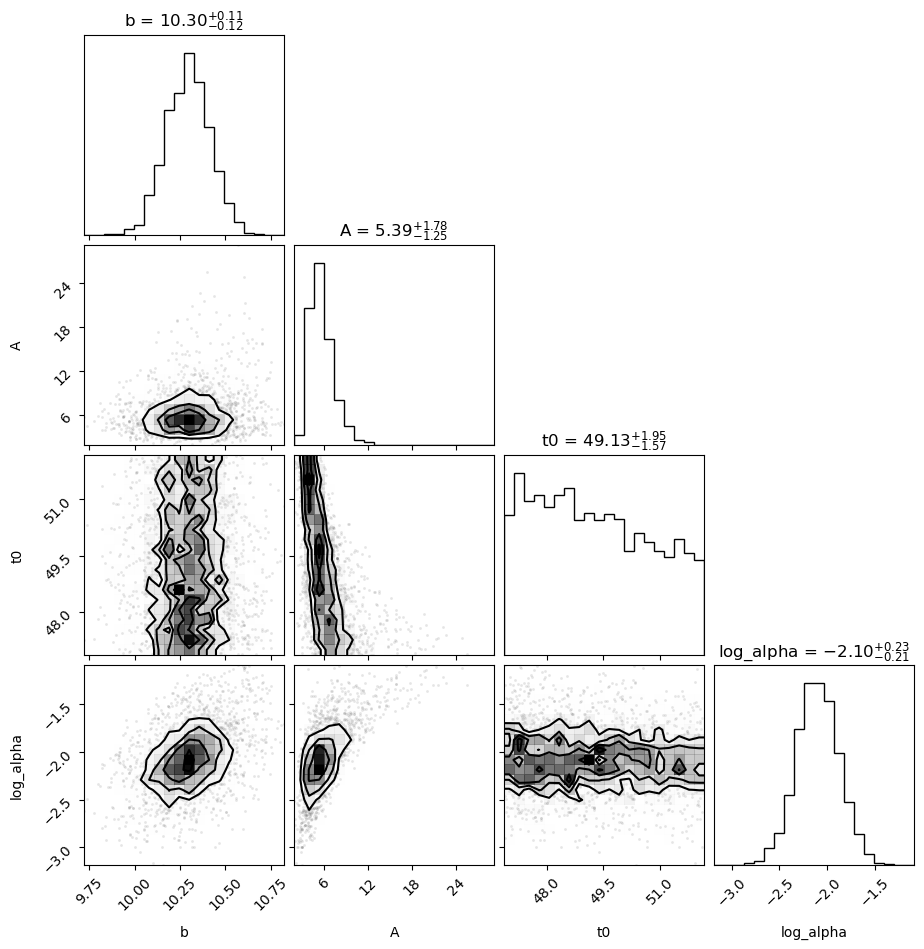

In [440]:
cornerplot(result2)

YAYYYY huge win for me. This actually seems to do a better job, just given more centralized probabilities from this corner plot, than the emcee sampling for the same model. We should use the ultranest results from each model to compute the Bayes factor. 

Getting the Bayes factor (K):

In [447]:
# from online ultranest documentation:
K = np.exp(result2['logz'] - result['logz'])
print("K = %.2f" % K)
print("The exponential burst model is %.2f times more probable than the gaussian model" % K)
print("assuming the models are equally probable a priori.")

K = 106.59
The exponential burst model is 106.59 times more probable than the gaussian model
assuming the models are equally probable a priori.


From Lecture 9, we consider a Bayes factor this high (in the hundreds) to be decisive evidence that the model in the numerator (in this case, the exponential burst model) fits the data better than the gaussian model.

SRT: Jaelyn, this was expert-level. Well done, and thanks for making my grading job super easy! Full points.